In [1]:

from __future__ import print_function
import h5py
from pathlib import Path
from tqdm import tqdm
import numpy as np
from scipy import spatial

import time, pickle
import pandas as pd

from hloc.utils.read_write_model import read_model
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from hloc.image_utils import image_desc_grouping, image_co_vis_grouping, visualization, points_grouping_test
from hloc.image_utils import points_grouping, build_tree, generate_retrieval_file, localize

from metric_learn import NCA
import metric_learn

In [2]:
sfm_dir = Path("outputs/aachen/sfm_superpoint+superglue")
sfm_dir = Path("outputs/aachen/sfm_superpoint+NN-superpoint")

global_descriptor_path = Path("outputs/aachen/global-feats-netvlad.h5")

In [3]:
print(sfm_dir)
cameras, images, points3D = read_model(sfm_dir, ".bin")

outputs/aachen/sfm_superpoint+NN-superpoint


In [4]:
from hloc.utils.parsers import parse_image_list
query_images = parse_image_list(Path("datasets/aachen_v1_1/queries") / 'day_time_queries_with_intrinsics.txt', True)
query_images_night = parse_image_list(Path("datasets/aachen_v1_1/queries") / 'night_time_queries_with_intrinsics.txt', True)
query_images.extend(query_images_night)
query_images[-1]

[04/06/2022 01:25:27 INFO] Imported 824 images from day_time_queries_with_intrinsics.txt
[04/06/2022 01:25:27 INFO] Imported 191 images from night_time_queries_with_intrinsics.txt


('query/night/nexus5x_additional_night/IMG_20170702_005927.jpg',
 ('SIMPLE_RADIAL',
  1600,
  1200,
  array([ 1.19991e+03,  8.00000e+02,  6.00000e+02, -3.24314e-02])))

In [5]:
index2image_id = dict()
cnt = 0
for image_id, image in images.items():
    cnt += 1

## generate point descriptor

# image group

In [6]:
desc = h5py.File(global_descriptor_path, 'r')
x2 = list()
for query_image in tqdm(query_images):
    name, param = query_image
    cur_desc = np.array([desc[name]['global_descriptor']])[0]
    x2.append(cur_desc)
x2 = np.array(x2)
desc.close()

100%|██████████| 1015/1015 [00:00<00:00, 1643.22it/s]


In [9]:
import logging
def image_grouping(n_cluster = 3000, method = "desc"):
    
    tag = method + "_" + str(n_cluster) 
    group_result_dir = Path("group/aachen/"+tag)
    group_result_dir.mkdir(parents=True, exist_ok=True)
    
    # stage 1: clustering
    result_path = group_result_dir / "cluster_result.pkl"
    if n_cluster == -1:
        labels = []
        index2image_id = dict()
        cnt = 0
        for image_id, image in images.items():
            labels.append(cnt)
            index2image_id[cnt] = image_id
            cnt += 1
    else:
        if method == "desc":
            labels, index2image_id = image_desc_grouping(global_descriptor_path, images, group_result_dir, n_cluster)
        else:
            labels, index2image_id = image_co_vis_grouping(images, points3D,group_result_dir, n_cluster)
        
    ## stage 2: dimensional reduction
    db_desc = h5py.File(global_descriptor_path, 'r')
    x = list()
    for index in range(len(labels)):
        x.append(np.array(db_desc[images[index2image_id[index]].name]['global_descriptor']))
    x = np.array(x)
    db_desc.close()
    if n_cluster == -1:
        n_cluster = 6697
    L = np.zeros((len(labels), n_cluster))
    for index in range(len(labels)):
        L[index, labels[index]] = 1

    Kpca = KernelPCA(n_components=1500, kernel='rbf').fit(x)
    x_trans = Kpca.transform(x)
    W_trans = np.linalg.pinv(x_trans).dot(L)
    x2_trans = Kpca.transform(x2)
    pred = x2_trans.dot(W_trans)
    
    for topK in [2, 3, 5, 10]:
        test_retrieve_groups_file = group_result_dir / str("retrieval_" + str(n_cluster) +"_"+ str(topK)+".txt")
        file = open(test_retrieve_groups_file, "w")
        for i, query_image in tqdm(enumerate(query_images)):
            name, param = query_image
            a = pred[i]
            ind = np.argpartition(a, -topK)[-topK:]
            ind = ind[np.argsort(a[ind])]
            for i in range(topK-1, -1, -1):
                file.write(name + ' ' + str(ind[i]) + '\n')  
        groups_image_points, group_descriptor = points_grouping(images, labels, index2image_id, global_descriptor_path)
#     tree, index2name = build_tree(group_descriptor, nca)
    
        full_tag = tag + "_" + str(topK)
#         generate_retrieval_file(global_descriptor_path, tree, index2name, 
#                                 query_images, group_result_dir, nca, label = str(n_cluster), top_n = topK)

        print(test_retrieve_groups_file)
        point_desc_path = Path("mid_data/aachen_v1_1/superpoint_aachen_NN/fused_feats-superpoint-n4096-r1024.pkl")
        local_feature_path = Path("mid_data/aachen_v1_1/superpoint_aachen_superglue/feats-superpoint-n4096-r1024.h5")
        result, max_inlier_nums = localize(query_images, test_retrieve_groups_file, local_feature_path, point_desc_path,
             groups_image_points, points3D, images, cameras, 
            log_path = group_result_dir / str("retrieval_" + str(n_cluster) +"_"+ str(topK)+".json"))
        
        
        with open(str(group_result_dir)+ "/" + full_tag + ".txt", "w+") as f:
            for name, res in tqdm(result.items()):
                name = name.split('/')[-1]
                f.write(' '.join([name, str(res[0][0]), str(res[0][1]),  str(res[0][2]), str(res[0][3]), 
                                  str(res[1][0]),str(res[1][1]),str(res[1][2])]) + '\n')
                

In [10]:
image_grouping(n_cluster = -1, method = "desc")
image_grouping(n_cluster = 3000, method = "desc")
image_grouping(n_cluster = 2000, method = "desc")
image_grouping(n_cluster = 1000, method = "desc")
image_grouping(n_cluster = 500, method = "desc")

image_grouping(n_cluster = -1, method = "co-vis")
image_grouping(n_cluster = 3000, method = "co-vis")
image_grouping(n_cluster = 2000, method = "co-vis")
image_grouping(n_cluster = 1000, method = "co-vis")
image_grouping(n_cluster = 500, method = "co-vis")

1015it [00:00, 7070.81it/s]
100%|██████████| 6697/6697 [00:00<00:00, 17535.69it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/desc_-1/retrieval_6697_2.txt
localizing: group/aachen/desc_-1/retrieval_6697_2.json


100%|██████████| 1015/1015 [04:28<00:00,  3.79it/s]


0.17636513710021973 110.43908905982971 0 8.154433012008667 113.10653734207153 34.91350746154785 268.08536100387573


100%|██████████| 1015/1015 [00:00<00:00, 91667.43it/s]
1015it [00:00, 9629.15it/s]
100%|██████████| 6697/6697 [00:00<00:00, 17164.95it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/desc_-1/retrieval_6697_3.txt
localizing: group/aachen/desc_-1/retrieval_6697_3.json


100%|██████████| 1015/1015 [05:27<00:00,  3.10it/s]


0.35603952407836914 142.94935274124146 0 10.733740091323853 123.09339833259583 49.221869707107544 327.66257882118225


100%|██████████| 1015/1015 [00:00<00:00, 67442.15it/s]
1015it [00:00, 9130.82it/s]
100%|██████████| 6697/6697 [00:00<00:00, 17425.05it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/desc_-1/retrieval_6697_5.txt
localizing: group/aachen/desc_-1/retrieval_6697_5.json


100%|██████████| 1015/1015 [07:21<00:00,  2.30it/s]


0.7688634395599365 213.02605438232422 0 15.663443565368652 136.24730944633484 74.36646556854248 441.45257234573364


100%|██████████| 1015/1015 [00:00<00:00, 58439.75it/s]
1015it [00:00, 8425.66it/s]
100%|██████████| 6697/6697 [00:00<00:00, 17393.22it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/desc_-1/retrieval_6697_10.txt
localizing: group/aachen/desc_-1/retrieval_6697_10.json


100%|██████████| 1015/1015 [12:35<00:00,  1.34it/s]


1.833319902420044 409.24461007118225 0 28.64385199546814 164.4127061367035 149.71659469604492 755.298139333725


100%|██████████| 6697/6697 [00:02<00:00, 2669.18it/s]


6697


1015it [00:00, 12788.20it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3744.98it/s]


2327
1587
                  0
count   3000.000000
mean    1638.731667
std     1358.815177
min        1.000000
25%      693.250000
50%     1269.500000
75%     2188.000000
max    12842.000000
group/aachen/desc_3000/retrieval_3000_2.txt
localizing: group/aachen/desc_3000/retrieval_3000_2.json


100%|██████████| 1015/1015 [05:39<00:00,  2.99it/s]


0.43645286560058594 167.55384159088135 0 17.274921417236328 115.42303538322449 37.06646966934204 339.0984859466553


100%|██████████| 1015/1015 [00:00<00:00, 92451.76it/s]
1015it [00:00, 12875.19it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3610.62it/s]


2327
1587
                  0
count   3000.000000
mean    1638.731667
std     1358.815177
min        1.000000
25%      693.250000
50%     1269.500000
75%     2188.000000
max    12842.000000
group/aachen/desc_3000/retrieval_3000_3.txt
localizing: group/aachen/desc_3000/retrieval_3000_3.json


100%|██████████| 1015/1015 [07:05<00:00,  2.39it/s]


0.7981631755828857 227.4784755706787 0 22.948797702789307 122.75072050094604 50.18704152107239 425.5528037548065


100%|██████████| 1015/1015 [00:00<00:00, 59998.85it/s]
1015it [00:00, 18408.48it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3720.61it/s]


2327
1587
                  0
count   3000.000000
mean    1638.731667
std     1358.815177
min        1.000000
25%      693.250000
50%     1269.500000
75%     2188.000000
max    12842.000000
group/aachen/desc_3000/retrieval_3000_5.txt
localizing: group/aachen/desc_3000/retrieval_3000_5.json


100%|██████████| 1015/1015 [10:10<00:00,  1.66it/s]


1.61517333984375 352.8453347682953 0 34.70054745674133 134.47188234329224 85.10873651504517 610.1910951137543


100%|██████████| 1015/1015 [00:00<00:00, 52637.54it/s]
1015it [00:00, 15577.26it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3677.86it/s]


2327
1587
                  0
count   3000.000000
mean    1638.731667
std     1358.815177
min        1.000000
25%      693.250000
50%     1269.500000
75%     2188.000000
max    12842.000000
group/aachen/desc_3000/retrieval_3000_10.txt
localizing: group/aachen/desc_3000/retrieval_3000_10.json


100%|██████████| 1015/1015 [19:49<00:00,  1.17s/it]


3.850299835205078 739.2142143249512 0 70.02539730072021 174.65002608299255 199.74714636802673 1189.128493309021


100%|██████████| 6697/6697 [00:02<00:00, 2574.83it/s]


6697


1015it [00:00, 17474.98it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2456.01it/s]


                  0
count   2000.000000
mean    2134.362000
std     1652.428803
min        2.000000
25%      982.750000
50%     1726.500000
75%     2815.500000
max    12842.000000
group/aachen/desc_2000/retrieval_2000_2.txt
localizing: group/aachen/desc_2000/retrieval_2000_2.json


100%|██████████| 1015/1015 [05:57<00:00,  2.84it/s]


0.4866647720336914 184.93182229995728 0 18.56836247444153 114.22866630554199 37.467774629592896 357.06876492500305


100%|██████████| 1015/1015 [00:00<00:00, 59135.43it/s]
1015it [00:00, 25065.76it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2499.87it/s]


                  0
count   2000.000000
mean    2134.362000
std     1652.428803
min        2.000000
25%      982.750000
50%     1726.500000
75%     2815.500000
max    12842.000000
group/aachen/desc_2000/retrieval_2000_3.txt
localizing: group/aachen/desc_2000/retrieval_2000_3.json


100%|██████████| 1015/1015 [07:50<00:00,  2.16it/s]


1.0045390129089355 261.65855050086975 0 26.557008266448975 123.74419474601746 56.25605058670044 470.796128988266


100%|██████████| 1015/1015 [00:00<00:00, 61770.44it/s]
1015it [00:00, 24029.27it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2412.67it/s]


                  0
count   2000.000000
mean    2134.362000
std     1652.428803
min        2.000000
25%      982.750000
50%     1726.500000
75%     2815.500000
max    12842.000000
group/aachen/desc_2000/retrieval_2000_5.txt
localizing: group/aachen/desc_2000/retrieval_2000_5.json


100%|██████████| 1015/1015 [10:55<00:00,  1.55it/s]


1.9524157047271729 390.1083986759186 0 39.577025413513184 133.930077791214 88.84489274024963 655.9003417491913


100%|██████████| 1015/1015 [00:00<00:00, 39735.84it/s]
1015it [00:00, 20532.35it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2440.61it/s]


                  0
count   2000.000000
mean    2134.362000
std     1652.428803
min        2.000000
25%      982.750000
50%     1726.500000
75%     2815.500000
max    12842.000000
group/aachen/desc_2000/retrieval_2000_10.txt
localizing: group/aachen/desc_2000/retrieval_2000_10.json


100%|██████████| 1015/1015 [21:28<00:00,  1.27s/it]


4.542966842651367 812.7544734477997 0 79.65851950645447 172.998939037323 217.31666493415833 1288.9487059116364


100%|██████████| 6697/6697 [00:02<00:00, 2675.73it/s]


6697


1015it [00:00, 26474.75it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1314.54it/s]


                  0
count   1000.000000
mean    3408.052000
std     2380.154183
min       29.000000
25%     1767.000000
50%     2851.000000
75%     4406.000000
max    17529.000000
group/aachen/desc_1000/retrieval_1000_2.txt
localizing: group/aachen/desc_1000/retrieval_1000_2.json


100%|██████████| 1015/1015 [06:51<00:00,  2.47it/s]


0.721665620803833 231.1668403148651 0 25.474268436431885 112.90593028068542 39.90356707572937 411.5901584625244


100%|██████████| 1015/1015 [00:00<00:00, 67689.86it/s]
1015it [00:00, 38111.60it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1292.18it/s]


                  0
count   1000.000000
mean    3408.052000
std     2380.154183
min       29.000000
25%     1767.000000
50%     2851.000000
75%     4406.000000
max    17529.000000
group/aachen/desc_1000/retrieval_1000_3.txt
localizing: group/aachen/desc_1000/retrieval_1000_3.json


100%|██████████| 1015/1015 [08:44<00:00,  1.94it/s]


1.4462695121765137 313.0177571773529 0 35.11416816711426 118.96209263801575 54.45143103599548 524.4499871730804


100%|██████████| 1015/1015 [00:00<00:00, 91566.87it/s]
1015it [00:00, 34861.80it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1283.48it/s]


                  0
count   1000.000000
mean    3408.052000
std     2380.154183
min       29.000000
25%     1767.000000
50%     2851.000000
75%     4406.000000
max    17529.000000
group/aachen/desc_1000/retrieval_1000_5.txt
localizing: group/aachen/desc_1000/retrieval_1000_5.json


100%|██████████| 1015/1015 [13:35<00:00,  1.24it/s]


2.756823778152466 513.8361060619354 0 57.81302261352539 135.7397494316101 103.92684698104858 815.7246339321136


100%|██████████| 1015/1015 [00:00<00:00, 101437.22it/s]
1015it [00:00, 30176.56it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1256.18it/s]


                  0
count   1000.000000
mean    3408.052000
std     2380.154183
min       29.000000
25%     1767.000000
50%     2851.000000
75%     4406.000000
max    17529.000000
group/aachen/desc_1000/retrieval_1000_10.txt
localizing: group/aachen/desc_1000/retrieval_1000_10.json


100%|██████████| 1015/1015 [25:59<00:00,  1.54s/it]


5.988322019577026 1018.6891388893127 0 109.34233331680298 176.4511969089508 247.51241374015808 1559.8161199092865


100%|██████████| 6697/6697 [00:02<00:00, 2682.72it/s]


6697


1015it [00:00, 34925.01it/s]
100%|██████████| 500/500 [00:00<00:00, 652.09it/s]


                 0
count    500.00000
mean    5522.91000
std     3863.54695
min      353.00000
25%     2869.00000
50%     4571.50000
75%     7047.50000
max    31527.00000
group/aachen/desc_500/retrieval_500_2.txt
localizing: group/aachen/desc_500/retrieval_500_2.json


100%|██████████| 1015/1015 [09:19<00:00,  1.81it/s]


1.206599235534668 353.2672998905182 0 44.71589469909668 112.89970302581787 46.30156683921814 559.9337282180786


100%|██████████| 1015/1015 [00:00<00:00, 48673.95it/s]
1015it [00:00, 50268.26it/s]
100%|██████████| 500/500 [00:00<00:00, 642.78it/s]


                 0
count    500.00000
mean    5522.91000
std     3863.54695
min      353.00000
25%     2869.00000
50%     4571.50000
75%     7047.50000
max    31527.00000
group/aachen/desc_500/retrieval_500_3.txt
localizing: group/aachen/desc_500/retrieval_500_3.json


100%|██████████| 1015/1015 [12:31<00:00,  1.35it/s]


2.300529956817627 494.0758101940155 0 64.31982326507568 120.19692611694336 69.06841921806335 751.6281564235687


100%|██████████| 1015/1015 [00:00<00:00, 65990.09it/s]
1015it [00:00, 46414.37it/s]
100%|██████████| 500/500 [00:00<00:00, 621.93it/s]


                 0
count    500.00000
mean    5522.91000
std     3863.54695
min      353.00000
25%     2869.00000
50%     4571.50000
75%     7047.50000
max    31527.00000
group/aachen/desc_500/retrieval_500_5.txt
localizing: group/aachen/desc_500/retrieval_500_5.json


100%|██████████| 1015/1015 [19:19<00:00,  1.14s/it]


4.504554510116577 791.0433695316315 0 101.55779814720154 136.1337969303131 124.31589150428772 1159.4528241157532


100%|██████████| 1015/1015 [00:00<00:00, 90619.61it/s]
1015it [00:00, 35970.21it/s]
100%|██████████| 500/500 [00:00<00:00, 612.56it/s]


                 0
count    500.00000
mean    5522.91000
std     3863.54695
min      353.00000
25%     2869.00000
50%     4571.50000
75%     7047.50000
max    31527.00000
group/aachen/desc_500/retrieval_500_10.txt
localizing: group/aachen/desc_500/retrieval_500_10.json


100%|██████████| 1015/1015 [37:16<00:00,  2.20s/it] 


11.254893779754639 1562.432809829712 0 196.46387028694153 179.85410451889038 283.70038866996765 2236.2081155776978


100%|██████████| 1015/1015 [00:00<00:00, 40150.32it/s]
1015it [00:00, 7364.59it/s]
100%|██████████| 6697/6697 [00:00<00:00, 17513.24it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/co-vis_-1/retrieval_6697_2.txt
localizing: group/aachen/co-vis_-1/retrieval_6697_2.json


100%|██████████| 1015/1015 [04:34<00:00,  3.69it/s]


0.18454647064208984 113.7530882358551 0 8.672873973846436 114.58476305007935 36.354918479919434 274.89905977249146


100%|██████████| 1015/1015 [00:00<00:00, 98421.42it/s]
1015it [00:00, 9206.01it/s]
100%|██████████| 6697/6697 [00:00<00:00, 16799.68it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/co-vis_-1/retrieval_6697_3.txt
localizing: group/aachen/co-vis_-1/retrieval_6697_3.json


100%|██████████| 1015/1015 [05:38<00:00,  3.00it/s]


0.3756899833679199 149.97831773757935 0 11.370333909988403 125.24701619148254 50.43861794471741 338.7841417789459


100%|██████████| 1015/1015 [00:00<00:00, 57838.71it/s]
1015it [00:00, 8937.26it/s]
100%|██████████| 6697/6697 [00:00<00:00, 16738.74it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/co-vis_-1/retrieval_6697_5.txt
localizing: group/aachen/co-vis_-1/retrieval_6697_5.json


100%|██████████| 1015/1015 [07:36<00:00,  2.22it/s]


0.7839844226837158 222.99548649787903 0 16.778558015823364 138.61859798431396 75.58148121833801 456.1998202800751


100%|██████████| 1015/1015 [00:00<00:00, 36883.30it/s]
1015it [00:00, 8451.66it/s]
100%|██████████| 6697/6697 [00:00<00:00, 16859.67it/s]


745
3354
                 0
count  6697.000000
mean   1176.185755
std     730.403596
min       0.000000
25%     626.000000
50%    1031.000000
75%    1567.000000
max    3821.000000
group/aachen/co-vis_-1/retrieval_6697_10.txt
localizing: group/aachen/co-vis_-1/retrieval_6697_10.json


100%|██████████| 1015/1015 [13:06<00:00,  1.29it/s]


1.9032390117645264 430.5136332511902 0 30.933597564697266 167.6816108226776 153.80963253974915 786.3742208480835


100%|██████████| 6697/6697 [00:00<00:00, 1781860.82it/s]
1015it [00:00, 14141.70it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3811.97it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/retrieval_3000_2.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_2.json


100%|██████████| 1015/1015 [05:59<00:00,  2.82it/s]


0.370574951171875 183.16056632995605 0 16.910922527313232 114.76794528961182 42.739261865615845 359.3622727394104


100%|██████████| 1015/1015 [00:00<00:00, 63420.36it/s]
1015it [00:00, 19286.91it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3695.59it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/retrieval_3000_3.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_3.json


100%|██████████| 1015/1015 [07:38<00:00,  2.21it/s]


0.7262189388275146 248.04666876792908 0 22.925196409225464 124.73684048652649 60.917237997055054 458.81618881225586


100%|██████████| 1015/1015 [00:00<00:00, 42613.95it/s]
1015it [00:00, 18339.88it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3557.97it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/retrieval_3000_5.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_5.json


100%|██████████| 1015/1015 [11:15<00:00,  1.50it/s]


1.4575145244598389 392.4509792327881 0 36.384727001190186 140.9955017566681 102.86830234527588 675.6846885681152


100%|██████████| 1015/1015 [00:00<00:00, 89334.14it/s]
1015it [00:00, 16678.04it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3591.88it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/retrieval_3000_10.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_10.json


100%|██████████| 1015/1015 [21:27<00:00,  1.27s/it]


3.4744186401367188 792.4139475822449 0 70.77890706062317 184.16666221618652 234.52556920051575 1287.0786471366882


100%|██████████| 6697/6697 [00:00<00:00, 1923657.98it/s]
1015it [00:00, 17450.62it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2423.49it/s]


1023
1827
                  0
count   2000.000000
mean    1970.709000
std     1695.068143
min        0.000000
25%      795.250000
50%     1488.500000
75%     2642.500000
max    13123.000000
group/aachen/co-vis_2000/retrieval_2000_2.txt
localizing: group/aachen/co-vis_2000/retrieval_2000_2.json


100%|██████████| 1015/1015 [06:26<00:00,  2.63it/s]


0.5179345607757568 207.17438793182373 0 20.752487182617188 113.49027872085571 43.041170835494995 386.4168977737427


100%|██████████| 1015/1015 [00:00<00:00, 58772.14it/s]
1015it [00:00, 23799.56it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2439.64it/s]


1023
1827
                  0
count   2000.000000
mean    1970.709000
std     1695.068143
min        0.000000
25%      795.250000
50%     1488.500000
75%     2642.500000
max    13123.000000
group/aachen/co-vis_2000/retrieval_2000_3.txt
localizing: group/aachen/co-vis_2000/retrieval_2000_3.json


100%|██████████| 1015/1015 [08:21<00:00,  2.03it/s]


1.0296199321746826 285.8085501194 0 28.963239908218384 123.20814967155457 60.626471281051636 501.1646234989166


100%|██████████| 1015/1015 [00:00<00:00, 51388.38it/s]
1015it [00:00, 22154.55it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2472.03it/s]


1023
1827
                  0
count   2000.000000
mean    1970.709000
std     1695.068143
min        0.000000
25%      795.250000
50%     1488.500000
75%     2642.500000
max    13123.000000
group/aachen/co-vis_2000/retrieval_2000_5.txt
localizing: group/aachen/co-vis_2000/retrieval_2000_5.json


100%|██████████| 1015/1015 [12:16<00:00,  1.38it/s]


2.0477983951568604 448.1732439994812 0 45.06867790222168 137.03698801994324 103.07363724708557 736.9749109745026


100%|██████████| 1015/1015 [00:00<00:00, 55740.27it/s]
1015it [00:00, 19804.79it/s]
100%|██████████| 2000/2000 [00:00<00:00, 2490.64it/s]


1023
1827
                  0
count   2000.000000
mean    1970.709000
std     1695.068143
min        0.000000
25%      795.250000
50%     1488.500000
75%     2642.500000
max    13123.000000
group/aachen/co-vis_2000/retrieval_2000_10.txt
localizing: group/aachen/co-vis_2000/retrieval_2000_10.json


100%|██████████| 1015/1015 [23:35<00:00,  1.39s/it]


4.658151626586914 903.7644562721252 0 87.50191950798035 180.72260880470276 237.43004894256592 1415.8631057739258


100%|██████████| 6697/6697 [00:00<00:00, 1950371.75it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:900: UserWarning: Persisting input arguments took 0.68s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)
1015it [00:00, 25208.99it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1256.68it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/retrieval_1000_2.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_2.json


100%|██████████| 1015/1015 [08:40<00:00,  1.95it/s]


0.990243673324585 321.49330735206604 0 36.881481647491455 115.13723874092102 44.54855918884277 520.6257553100586


100%|██████████| 1015/1015 [00:00<00:00, 92133.63it/s]
1015it [00:00, 34231.65it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1252.18it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/retrieval_1000_3.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_3.json


100%|██████████| 1015/1015 [11:38<00:00,  1.45it/s]


1.9456946849822998 449.55871319770813 0 52.84791374206543 122.77471923828125 69.98392748832703 698.787844657898


100%|██████████| 1015/1015 [00:00<00:00, 44636.16it/s]
1015it [00:00, 34928.44it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1201.93it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/retrieval_1000_5.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_5.json


100%|██████████| 1015/1015 [17:54<00:00,  1.06s/it]


3.8073182106018066 719.2784914970398 0 84.40901708602905 138.87849283218384 126.75716471672058 1074.9559614658356


100%|██████████| 1015/1015 [00:00<00:00, 61503.61it/s]
1015it [00:00, 29633.37it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1211.76it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/retrieval_1000_10.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_10.json


100%|██████████| 1015/1015 [34:24<00:00,  2.03s/it]


8.75044322013855 1418.4456901550293 0 160.9661796092987 184.7561354637146 289.6589810848236 2064.828025817871


100%|██████████| 6697/6697 [00:00<00:00, 1907718.95it/s]
1015it [00:00, 34990.45it/s]
100%|██████████| 500/500 [00:00<00:00, 634.78it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/retrieval_500_2.txt
localizing: group/aachen/co-vis_500/retrieval_500_2.json


100%|██████████| 1015/1015 [12:37<00:00,  1.34it/s]


1.9731574058532715 519.6570017337799 0 70.39774775505066 113.91155576705933 50.2459077835083 758.002388715744


100%|██████████| 1015/1015 [00:00<00:00, 93820.93it/s]
1015it [00:00, 47990.83it/s]
100%|██████████| 500/500 [00:00<00:00, 632.04it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/retrieval_500_3.txt
localizing: group/aachen/co-vis_500/retrieval_500_3.json


100%|██████████| 1015/1015 [17:41<00:00,  1.05s/it]


3.8098113536834717 750.7273907661438 0 100.5111243724823 123.25111222267151 81.56535720825195 1061.8256590366364


100%|██████████| 1015/1015 [00:00<00:00, 71350.83it/s]
1015it [00:00, 47638.54it/s]
100%|██████████| 500/500 [00:00<00:00, 615.10it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/retrieval_500_5.txt
localizing: group/aachen/co-vis_500/retrieval_500_5.json


100%|██████████| 1015/1015 [28:19<00:00,  1.67s/it]


7.149460792541504 1224.6779441833496 0 163.8182897567749 142.88580560684204 158.3611717224121 1699.1570200920105


100%|██████████| 1015/1015 [00:00<00:00, 61033.64it/s]
1015it [00:00, 35238.96it/s]
100%|██████████| 500/500 [00:00<00:00, 610.37it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/retrieval_500_10.txt
localizing: group/aachen/co-vis_500/retrieval_500_10.json


100%|██████████| 1015/1015 [51:11<00:00,  3.03s/it]


16.118926286697388 2234.605272769928 0 293.520055770874 186.80558037757874 337.1109983921051 3071.2391431331635


100%|██████████| 1015/1015 [00:00<00:00, 58027.92it/s]


## descriptor based 

In [8]:
group_result_dir = Path("group/aachen")
group_result_dir.mkdir(parents=True, exist_ok=True)

In [144]:
for n_cluster in [3000, 1000, 500]:
    print(n_cluster)
    tag = "co-vis_" + str(n_cluster) 
    result_path = "group/aachen/" + tag + "/cluster_result.pkl"
    map_path = "group/aachen/" + tag + "/index2image_id.pkl"
    with open(result_path, "rb") as f:
        labels = pickle.load(f)
    with open(map_path, "rb") as f:
        index2image_id = pickle.load(f)

    for n_com in [200, 500, 1000, 2000, 3000]:
        print(n_com)
        x = list()
        for index in range(len(labels)):
            x.append(np.array(db_desc[images[index2image_id[index]].name]['global_descriptor']))
        x = np.array(x)

        L = np.zeros((len(labels), n_cluster))
        for index in range(len(labels)):
            L[index, labels[index]] = 1
            
        Kpca = KernelPCA(n_components=n_com, kernel='rbf').fit(x)
        
        x_trans = Kpca.transform(x)
        W_trans = np.linalg.pinv(x_trans).dot(L)
        pred = x_trans.dot(W_trans)
        # training
        first_cnt = 0
        second_cnt = 0
        third_cnt = 0
        for i in range(pred.shape[0]):
            a = pred[i]
            ind = np.argpartition(a, -3)[-3:]
            ind = ind[np.argsort(a[ind])]
        #     print(ind)
            if ind[2] == labels[i]:
                first_cnt += 1
            if ind[1] == labels[i]:
                second_cnt += 1
            if ind[0] == labels[i]:
                third_cnt += 1

        print(first_cnt / len(images), second_cnt / len(images), third_cnt / len(images))

        # test
        x2_trans = Kpca.transform(x2)
        pred = x2_trans.dot(W_trans)
        retrieval_path = "group/aachen/co-vis_" + str(n_cluster) + "/retrieval_" + str(n_cluster) + "_"+str(3) + "_"+str(n_com) +".txt"
        file = open(retrieval_path, "w+")
        for i, query_image in tqdm(enumerate(query_images)):
            name, param = query_image
            a = pred[i]
            ind = np.argpartition(a, -3)[-3:]
            ind = ind[np.argsort(a[ind])]
            for i in range(2, -1, -1):
                file.write(name + ' ' + str(ind[i]) + '\n')  

        groups_image_points, group_descriptor = points_grouping(images, labels, index2image_id, global_descriptor_path)

        group_result_dir = "group/aachen/" + tag + '/'
        print(group_result_dir)
        test_retrieve_groups_file = retrieval_path
        print(test_retrieve_groups_file)

        point_desc_path = Path("mid_data/aachen_v1_1/superpoint_aachen_NN/fused_feats-superpoint-n4096-r1024.pkl")
        local_feature_path = Path("mid_data/aachen_v1_1/superpoint_aachen_superglue/feats-superpoint-n4096-r1024.h5")
        result, max_inlier_nums = localize(query_images, test_retrieve_groups_file, local_feature_path, point_desc_path,
             groups_image_points, points3D, images, cameras, 
            log_path = group_result_dir +  str("retrieval_" + str(n_cluster) +"_"+ str(3) + "_"+str(n_com)+".json"))

        with open(str(group_result_dir)+ "/" + str(n_cluster) +"_"+ str(3) + "_"+str(n_com)+ ".txt", "w+") as f:
            for name, res in tqdm(result.items()):
                name = name.split('/')[-1]
                f.write(' '.join([name, str(res[0][0]), str(res[0][1]),  str(res[0][2]), str(res[0][3]), 
                                  str(res[1][0]),str(res[1][1]),str(res[1][2])]) + '\n')
                

3000
200
0.5278482902792295 0.20845154546812006 0.09780498730774974


1015it [00:00, 12262.00it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3602.93it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/
group/aachen/co-vis_3000/retrieval_3000_3_200.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_3_200.json


100%|██████████| 1015/1015 [08:24<00:00,  2.01it/s]


0.9568929672241211 287.96724128723145 0 28.94029688835144 121.66823673248291 63.435211181640625 504.4322109222412


100%|██████████| 1015/1015 [00:00<00:00, 78815.49it/s]


500
0.8399283261161714 0.125727937882634 0.024189935792145737


1015it [00:00, 12534.87it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3497.60it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/
group/aachen/co-vis_3000/retrieval_3000_3_500.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_3_500.json


100%|██████████| 1015/1015 [08:16<00:00,  2.04it/s]


0.8740944862365723 275.22279167175293 0 26.205768585205078 132.19646835327148 60.41445183753967 496.37237310409546


100%|██████████| 1015/1015 [00:00<00:00, 61168.69it/s]


1000
0.9681947140510676 0.030013438853217857 0.001791847095714499


1015it [00:00, 12470.29it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3550.35it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/
group/aachen/co-vis_3000/retrieval_3000_3_1000.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_3_1000.json


100%|██████████| 1015/1015 [08:08<00:00,  2.08it/s]


0.7918400764465332 264.56856870651245 0 25.467093229293823 135.83186435699463 60.43759894371033 488.53707218170166


100%|██████████| 1015/1015 [00:00<00:00, 92383.55it/s]


2000
0.9982081529042856 0.001791847095714499 0.0


1015it [00:00, 12141.38it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3465.95it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/
group/aachen/co-vis_3000/retrieval_3000_3_2000.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_3_2000.json


100%|██████████| 1015/1015 [08:07<00:00,  2.08it/s]


0.7179596424102783 259.409517288208 0 24.448654174804688 141.26677107810974 60.3354606628418 487.6173298358917


100%|██████████| 1015/1015 [00:00<00:00, 37554.19it/s]


3000
0.9998506794086904 0.00014932059130954157 0.0


1015it [00:00, 12371.36it/s]
100%|██████████| 3000/3000 [00:00<00:00, 3447.67it/s]


2047
1827
                 0
count  3000.000000
mean   1594.419667
std    1271.567021
min       0.000000
25%     689.750000
50%    1246.000000
75%    2147.250000
max    8665.000000
group/aachen/co-vis_3000/
group/aachen/co-vis_3000/retrieval_3000_3_3000.txt
localizing: group/aachen/co-vis_3000/retrieval_3000_3_3000.json


100%|██████████| 1015/1015 [08:16<00:00,  2.04it/s]


0.645932674407959 268.1888108253479 0 24.632904052734375 139.3307728767395 62.462549448013306 496.69181847572327


100%|██████████| 1015/1015 [00:00<00:00, 29144.06it/s]


1000
200
0.6398387337613857 0.16932955054502016 0.0674929072719128


1015it [00:00, 19163.02it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1118.41it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/
group/aachen/co-vis_1000/retrieval_1000_3_200.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_3_200.json


100%|██████████| 1015/1015 [12:52<00:00,  1.31it/s]


2.5883266925811768 505.72458505630493 0 64.01411032676697 128.7575147151947 70.15660500526428 772.9776003360748


100%|██████████| 1015/1015 [00:00<00:00, 34353.74it/s]


500
0.8718829326564134 0.10303120800358369 0.021203523965954905


1015it [00:00, 22049.56it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1127.76it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/
group/aachen/co-vis_1000/retrieval_1000_3_500.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_3_500.json


100%|██████████| 1015/1015 [12:31<00:00,  1.35it/s]


2.4360597133636475 484.64222025871277 0 60.27840518951416 133.98273015022278 68.5569818019867 751.6001110076904


100%|██████████| 1015/1015 [00:00<00:00, 20258.87it/s]


1000
0.9707331641033299 0.0283709123488129 0.0008959235478572496


1015it [00:00, 21033.38it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1120.27it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/
group/aachen/co-vis_1000/retrieval_1000_3_1000.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_3_1000.json


100%|██████████| 1015/1015 [12:29<00:00,  1.35it/s]


2.3108322620391846 476.7126359939575 0 59.644245624542236 138.42735409736633 70.64079594612122 749.4128539562225


100%|██████████| 1015/1015 [00:00<00:00, 81105.33it/s]


2000
0.9988054352695237 0.0011945647304763326 0.0


1015it [00:00, 23006.64it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1123.58it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/
group/aachen/co-vis_1000/retrieval_1000_3_2000.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_3_2000.json


100%|██████████| 1015/1015 [12:31<00:00,  1.35it/s]


2.029524564743042 478.2746248245239 0 58.821335554122925 140.2390570640564 70.90440344810486 751.9287106990814


100%|██████████| 1015/1015 [00:00<00:00, 36042.69it/s]


3000
0.9998506794086904 0.00014932059130954157 0.0


1015it [00:00, 19788.22it/s]
100%|██████████| 1000/1000 [00:00<00:00, 1152.81it/s]


511
913
                  0
count   1000.000000
mean    2914.436000
std     3044.988376
min        0.000000
25%      991.500000
50%     2059.000000
75%     3808.750000
max    26516.000000
group/aachen/co-vis_1000/
group/aachen/co-vis_1000/retrieval_1000_3_3000.txt
localizing: group/aachen/co-vis_1000/retrieval_1000_3_3000.json


100%|██████████| 1015/1015 [12:54<00:00,  1.31it/s]


1.8647758960723877 494.20966696739197 0 60.72197508811951 141.15584588050842 75.36819529533386 774.9547832012177


100%|██████████| 1015/1015 [00:00<00:00, 35072.61it/s]


500
200
0.7098700910855607 0.154397491414066 0.05330745109750635


1015it [00:00, 26136.02it/s]
100%|██████████| 500/500 [00:00<00:00, 583.21it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/
group/aachen/co-vis_500/retrieval_500_3_200.txt
localizing: group/aachen/co-vis_500/retrieval_500_3_200.json


100%|██████████| 1015/1015 [18:27<00:00,  1.09s/it]


5.119001150131226 779.2163407802582 0 111.94430327415466 130.97414994239807 77.727858543396 1107.0556817054749


100%|██████████| 1015/1015 [00:00<00:00, 91401.73it/s]


500
0.8899507242048679 0.0904882783335822 0.014782738539644617


1015it [00:00, 27582.48it/s]
100%|██████████| 500/500 [00:00<00:00, 550.40it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/
group/aachen/co-vis_500/retrieval_500_3_500.txt
localizing: group/aachen/co-vis_500/retrieval_500_3_500.json


100%|██████████| 1015/1015 [17:59<00:00,  1.06s/it]


4.671793699264526 756.9199624061584 0 106.14362907409668 134.1534948348999 75.6848213672638 1079.5972609519958


100%|██████████| 1015/1015 [00:00<00:00, 90716.16it/s]


1000
0.971330446468568 0.027922950574884278 0.000746602956547708


1015it [00:00, 27757.11it/s]
100%|██████████| 500/500 [00:00<00:00, 574.70it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/
group/aachen/co-vis_500/retrieval_500_3_1000.txt
localizing: group/aachen/co-vis_500/retrieval_500_3_1000.json


100%|██████████| 1015/1015 [18:28<00:00,  1.09s/it]


4.311184406280518 773.4885311126709 0 113.5136501789093 136.274169921875 79.07238984107971 1108.6152946949005


100%|██████████| 1015/1015 [00:00<00:00, 88164.90it/s]


2000
0.9985067940869046 0.001493205913095416 0.0


1015it [00:00, 27427.00it/s]
100%|██████████| 500/500 [00:00<00:00, 590.35it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/
group/aachen/co-vis_500/retrieval_500_3_2000.txt
localizing: group/aachen/co-vis_500/retrieval_500_3_2000.json


100%|██████████| 1015/1015 [18:43<00:00,  1.11s/it]


3.9208643436431885 783.5808417797089 0 110.13166832923889 140.2083797454834 83.83193588256836 1123.6391184329987


100%|██████████| 1015/1015 [00:00<00:00, 89234.90it/s]


3000
1.0 0.0 0.0


1015it [00:00, 24963.31it/s]
100%|██████████| 500/500 [00:00<00:00, 567.44it/s]


456
                  0
count    500.000000
mean    4847.666000
std     5552.227171
min        0.000000
25%     1337.500000
50%     3046.000000
75%     6097.250000
max    49092.000000
group/aachen/co-vis_500/
group/aachen/co-vis_500/retrieval_500_3_3000.txt
localizing: group/aachen/co-vis_500/retrieval_500_3_3000.json


100%|██████████| 1015/1015 [19:18<00:00,  1.14s/it]


3.502218246459961 808.1414592266083 0 114.68467617034912 139.2470428943634 91.11719465255737 1158.5851709842682


100%|██████████| 1015/1015 [00:00<00:00, 54870.26it/s]


In [9]:
result_path = group_result_dir / "2000_cluster_result_amm.pkl"
labels, index2image_id = image_desc_grouping(global_descriptor_path, images, result_path, n_cluster = 2000)

new


100%|██████████| 6697/6697 [00:06<00:00, 1077.15it/s]


6697


In [10]:
print(labels.shape)

(6697,)


In [120]:
print(counter[2327])
print(counter[1587])
print(counter[900])
print(counter[901])

[]
[]
[]
[]


In [124]:
target_id = -1
for image_id, image in images.items():
    if image.name == 'db/1808.jpg':
        target_id = image_id
        break
print(target_id)
print(images[target_id].name)
for i in range(len(labels)):
    if index2image_id[i] == target_id:
n_cluster = 2000
tag = "desc_" + str(n_cluster) 

result_path = "group/aachen/" + tag + "/cluster_result.pkl"
retrieval_result = "group/aachen/" + tag + "/retrieval_2000_30.txt"        print(labels[i])

900
db/1808.jpg
2632


In [94]:
n_cluster = 2000
tag = "co-vis_" + str(n_cluster) 
# tag = "desc_" + str(n_cluster) 

if n_cluster == -1:
    labels = []
    index2image_id = dict()
    cnt = 0
    for image_id, image in images.items():
        labels.append(cnt)
        index2image_id[cnt] = image_id
        cnt += 1
else:
    result_path = "group/aachen/" + tag + "/cluster_result.pkl"
    map_path = "group/aachen/" + tag + "/index2image_id.pkl"
    with open(result_path, "rb") as f:
        labels = pickle.load(f)
    with open(map_path, "rb") as f:
        index2image_id = pickle.load(f)

image_id2label = dict()
for i, label in enumerate(labels):
    image_id2label[index2image_id[i]] = label
    
db_desc = h5py.File(global_descriptor_path, 'r')

x = list()
for index in range(len(labels)):
    x.append(np.array(db_desc[images[index2image_id[index]].name]['global_descriptor']))
x = np.array(x)

L = np.zeros((len(labels), n_cluster))
for index in range(len(labels)):
    L[index, labels[index]] = 1

In [103]:

desc = h5py.File(global_descriptor_path, 'r')
x2 = list()
for query_image in tqdm(query_images):
    name, param = query_image
    cur_desc = np.array([desc[name]['global_descriptor']])[0]
    x2.append(cur_desc)

#     pred = cur_desc.dot(W_trans)
# #     print(pred)
#     ind = np.argpartition(pred, -3)[-3:]
#     ind = ind[np.argsort(pred[ind])]
# #     print(ind)
#     for i in range(len(group_indices)-1, -1, -1):
#         file.write(name + ' ' + str(ind[i]) + '\n')  
x2 = np.array(x2)
desc.close()

100%|██████████| 1015/1015 [00:00<00:00, 1113.71it/s]


In [127]:
x2_trans = Kpca.transform(x2)

In [129]:
pred = x2_trans.dot(W_trans)

In [130]:
retrieval_path = "group/aachen/co-vis_2000/retrieval_" + str(n_cluster) + "_"+str(3)+".txt"
file = open(retrieval_path, "w+")
for i, query_image in tqdm(enumerate(query_images)):
    name, param = query_image
    a = pred[i]
    ind = np.argpartition(a, -3)[-3:]
    ind = ind[np.argsort(a[ind])]
    for i in range(len(group_indices)-1, -1, -1):
        file.write(name + ' ' + str(ind[i]) + '\n')  
# print(first_cnt / len(images), second_cnt / len(images), third_cnt / len(images))

1015it [00:00, 21563.73it/s]


## dimensional_reduction_test

In [6]:
from sklearn.manifold import TSNE
def plot_tsne(X, y, colormap=plt.cm.Paired):
    plt.figure(figsize=(9, 9))

    plt.clf()

    tsne = TSNE(verbose=True)
    X_embedded = tsne.fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)

    plt.xticks(())
    plt.yticks(())

    plt.show()

In [6]:
groups_image_points, group_descriptor = points_grouping(images, labels, index2image_id, global_descriptor_path)
tree, index2name = build_tree(group_descriptor, nca = None)

100%|██████████| 2000/2000 [00:00<00:00, 11834.83it/s]


1023
1827
                  0
count   2000.000000
mean    1970.709000
std     1695.068143
min        0.000000
25%      795.250000
50%     1488.500000
75%     2642.500000
max    13123.000000


100%|██████████| 2000/2000 [00:00<00:00, 1156570.80it/s]


In [8]:
from random import sample
db_desc = h5py.File(global_descriptor_path, 'r')

x = list()
for index in range(len(labels)):
    x.append(np.array(db_desc[images[index2image_id[index]].name]['global_descriptor']))
db_desc.close()

triplets = list()
for i in range(len(labels)):
    for neg in sample(list(range(2000)), 1):
        triplets.append([x[i], group_descriptor[labels[i]], group_descriptor[neg]])
print(len(triplets), triplets[0])

6697 [array([ 0.02507755,  0.00299151,  0.00045402, ..., -0.01668817,
       -0.01327498,  0.00134097], dtype=float32), array([ 0.02507755,  0.00299151,  0.00045402, ..., -0.01668817,
       -0.01327498,  0.00134097], dtype=float32), array([ 0.00838884,  0.00611413,  0.01048022, ..., -0.01616557,
        0.00092913,  0.02405013], dtype=float32)]


In [20]:
pairs = list()
pairs_mark = list()
sample_n = 3
db_desc = h5py.File(global_descriptor_path, 'r')
for image_id, image in tqdm(images.items()):
    cur_desc = np.array([db_desc[image.name]['global_descriptor']])
    d, group_indices = tree.query(cur_desc[0], sample_n)
    group_indices = [index2name[x] for x in group_indices]
    for i in range(sample_n):
        if group_indices[i] == image_id2label[image_id]:
            if d[i] > 0:
                pairs.append([cur_desc[0], group_descriptor[group_indices[i]]])
                pairs_mark.append(1)
        else:
            pairs.append([cur_desc[0], group_descriptor[group_indices[i]]])
            pairs_mark.append(-1)
db_desc.close()

100%|██████████| 6697/6697 [08:08<00:00, 13.72it/s]


In [21]:
print(len(pairs), pairs[0])

20091 [array([ 0.02507755,  0.00299151,  0.00045402, ..., -0.01668817,
       -0.01327498,  0.00134097], dtype=float32), array([-0.00330619,  0.02150645,  0.00450206, ...,  0.01295583,
       -0.02130474, -0.01136999], dtype=float32)]


In [24]:
nca = itml
group_descriptor = points_grouping_test(images, labels, index2image_id, global_descriptor_path)
tree, index2name = build_tree(group_descriptor, nca)
print("here")
first_cnt = 0
second_cnt = 0
third_cnt = 0
db_desc = h5py.File(global_descriptor_path, 'r')
for image_id, image in tqdm(images.items()):
    cur_desc = np.array([db_desc[image.name]['global_descriptor']])
    cur_desc = nca.transform(cur_desc)
#     print(cur_desc)
    d, group_indices = tree.query(cur_desc[0], 3)
    if index2name[group_indices[0]] == image_id2label[image_id]:
        first_cnt += 1
    if index2name[group_indices[1]] == image_id2label[image_id]:
        second_cnt += 1
    if index2name[group_indices[2]] == image_id2label[image_id]:
        third_cnt += 1
    
print(first_cnt / len(images), second_cnt / len(images), third_cnt / len(images))
    
db_desc.close()

100%|██████████| 2000/2000 [00:00<00:00, 247334.83it/s]


here


100%|██████████| 6697/6697 [15:23<00:00,  7.25it/s]


0.8460504703598626 0.095117216664178 0.02747498880095565


[509, 973, 708]
509 ['db/36.jpg', 'db/35.jpg', 'db/39.jpg', 'db/40.jpg', 'db/1890.jpg', 'db/44.jpg', 'db/1888.jpg', 'db/1416.jpg', 'db/1887.jpg'] 9
973 ['sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0038.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0041.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0042.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0043.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0040.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0044.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0039.png'] 7
708 ['sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0037.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0032.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0034.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0036.png', 'sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0035.png', 'sequences/n

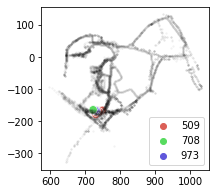

In [176]:
n_cluster = 1000
# tag = "co-vis_" + str(n_cluster) 
tag = "desc_" + str(n_cluster) 

if n_cluster == -1:
    labels = []
    index2image_id = dict()
    cnt = 0
    for image_id, image in images.items():
        labels.append(cnt)
        index2image_id[cnt] = image_id
        cnt += 1
else:
    result_path = "group/aachen/" + tag + "/cluster_result.pkl"
    map_path = "group/aachen/" + tag + "/index2image_id.pkl"

    with open(result_path, "rb") as f:
        labels = pickle.load(f)
    with open(map_path, "rb") as f:
        index2image_id = pickle.load(f)

counter = defaultdict(list)
for i, label in enumerate(labels):
    counter[label].append(images[index2image_id[i]].name)
    
    
retrieval_result = "group/aachen/" + tag + "/retrieval_"+str(n_cluster)+"_3.txt"
retri_result = defaultdict(list)
with open(retrieval_result, "r") as f:
    for line in f.readlines():
        retri_result[line.split()[0]].append(int(line.split()[1]))
print(retri_result['query/day/milestone/2010-10-30_17-48-20_774.jpg'])
show_labels= retri_result['query/day/milestone/2010-10-30_17-48-20_774.jpg']

# counter_sort = list(counter.items())
# counter_sort.sort(key=lambda x:len(x[1]))
# show_labels = [x[0] for x in counter_sort[-10:]]

for label in show_labels:
    print(label, counter[label], len(counter[label]))

visualization(images, labels, show_labels, size = (3,3))

In [119]:
# numbers_covis = [len(x[1]) for x in counter_sort]
numbers = [len(x[1]) for x in counter_sort]


In [144]:
from scipy.spatial.transform import Rotation as R
position = dict()
for image_id, image in images.items():
    qvec = image.qvec
    tvec = np.array(image.tvec)
    r = R.from_quat([qvec[1], qvec[2], qvec[3], qvec[0]])
    t = -r.inv().apply(tvec)
    position[image.name] = ([t[0], t[2]])

In [133]:
std_res = dict()

In [166]:
# compute pairwise distance
import scipy.spatial.distance


# method = "desc"
def variance(method, n_cluster):
    tag = method + "_" + str(n_cluster) 

    result_path = "group/aachen/" + tag + "/cluster_result.pkl"
    map_path = "group/aachen/" + tag + "/index2image_id.pkl"

    with open(result_path, "rb") as f:
        labels = pickle.load(f)
    with open(map_path, "rb") as f:
        index2image_id = pickle.load(f)
    counter = defaultdict(list)
    for i, label in enumerate(labels):
        counter[label].append(images[index2image_id[i]].name)

    sum = 0
    cnt = 0
    db_desc = h5py.File(global_descriptor_path, 'r')
    for label, names in tqdm(counter.items()):
        vectors=list()
        if len(names) == 1:
            continue
        cnt += 1
        for image_name in names:
            vectors.append(db_desc[image_name]['global_descriptor'])
    #         vectors.append(position[image_name])
        vectors = np.array(vectors)
        dist = scipy.spatial.distance.cdist(vectors, np.mean(vectors, axis=0).reshape((1,4096)), metric='cosine')
#         print(dist.shape)
        sum += np.mean(dist)

    print(sum/n_cluster, n_cluster)

    # covis_std = sum/cnt
    return sum/n_cluster

In [168]:
# desc:0.0156

for method in ['co-vis', 'desc']:
    for num in ['500','1000', '2000', '3000']:
        std_res[method + '_' + num] = variance(method, int(num))

for method in ['co-vis', 'desc']:
    for num in ['500','1000', '2000', '3000']:
        print(method, num, std_res[method + '_' + num] )

100%|██████████| 500/500 [00:03<00:00, 150.92it/s]


0.39618795376935856 500


100%|██████████| 1000/1000 [00:03<00:00, 310.63it/s]


0.3039685495938727 1000


100%|██████████| 2000/2000 [00:03<00:00, 570.01it/s]


0.19734508077668028 2000


100%|██████████| 3000/3000 [00:03<00:00, 957.87it/s] 


0.12488322644731675 3000


100%|██████████| 500/500 [00:03<00:00, 157.03it/s]


0.390104782546153 500


100%|██████████| 1000/1000 [00:03<00:00, 313.70it/s]


0.3093877615997003 1000


100%|██████████| 2000/2000 [00:03<00:00, 585.77it/s]


0.20454027386301182 2000


100%|██████████| 3000/3000 [00:03<00:00, 944.11it/s] 

0.12224824221799029 3000
co-vis 500 0.39618795376935856
co-vis 1000 0.3039685495938727
co-vis 2000 0.19734508077668028
co-vis 3000 0.12488322644731675
desc 500 0.390104782546153
desc 1000 0.3093877615997003
desc 2000 0.20454027386301182
desc 3000 0.12224824221799029


In [90]:
print(numbers, numbers_covis)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

                 0
count  1000.000000
mean      6.697000
std       2.687082
min       2.000000
25%       5.000000
50%       6.000000
75%       8.000000
max      20.000000
                 0
count  1000.000000
mean      6.697000
std       5.337197
min       1.000000
25%       3.000000
50%       5.000000
75%       8.000000
max      36.000000


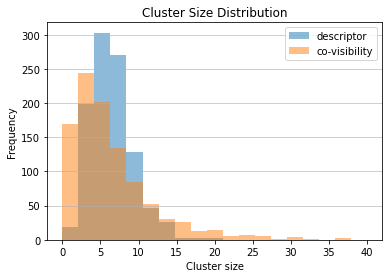

In [82]:
import pandas as pd
numbers_c_pd = pd.DataFrame(numbers_covis)
numbers_pd = pd.DataFrame(numbers)
print(numbers_pd.describe())
print(numbers_c_pd.describe())

bins = numpy.linspace(0, 40, 20)

pyplot.hist(x=numbers, bins=bins, alpha=0.5, label='descriptor')
pyplot.hist(x=numbers_covis, bins=bins, alpha=0.5, label='co-visibility')
# n, bins, patches = plt.hist(x=numbers, bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
pyplot.grid(axis='y', alpha=0.75)
pyplot.xlabel('Cluster size')
pyplot.ylabel('Frequency')
pyplot.title('Cluster Size Distribution')
pyplot.legend()
# maxfreq = n.max()
# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
pyplot.show()

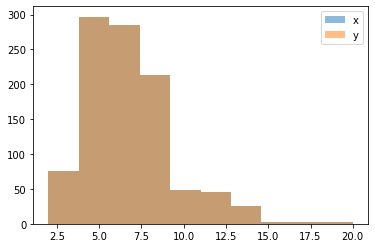

In [65]:
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(numbers, bins, alpha=0.5, label='x')
pyplot.hist(numbers_covis, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

In [29]:
x_total = np.append(x, x2, axis = 0)

print(x_total.shape)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(x)

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    legend="full",
    alpha=1,
    s=50
)

NameError: name 'x' is not defined

171 171 6697


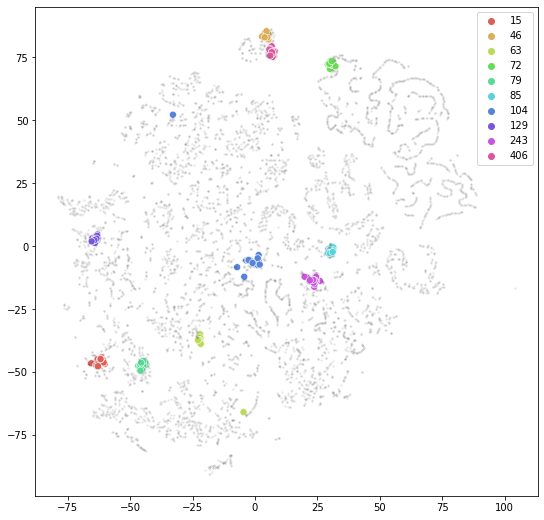

In [30]:
bg_x = []
bg_y = []
image_x = []
image_y = []
hl_labels = []
tsne_results = np.load("tsne_results.npy")

for cnt in range(len(labels)):
    if labels[cnt] not in show_labels:
        bg_x.append(tsne_results[cnt,0])
        bg_y.append(tsne_results[cnt,1])
    else:
        image_x.append(tsne_results[cnt,0])
        image_y.append(tsne_results[cnt,1])
        hl_labels.append(labels[cnt])

    cnt +=1 
        
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
# tsne_results = tsne.fit_transform(group_desc)
        
print(len(image_x), len(image_y), len(labels))
plt.figure(figsize=(9,9))
sns.scatterplot(
    x=image_x, y=image_y,
    hue=hl_labels,
    palette=sns.color_palette("hls", len(show_labels)),
    legend="full",
    alpha=1,
    s=50
)


sns.scatterplot(
    x=bg_x, y=bg_y,
    color=".01", 
    legend="full",
    alpha=0.1,
    s=5
)

plt.savefig("visual2.pdf", format='pdf')

In [83]:
np.save("tsne_results.npy", tsne_results)

## co-visibility based grouping

In [149]:
# group_point_set_path = group_result_dir / "group_point_set.pkl"
# group_desc_path = group_result_dir / "group_desc.pkl"
# result_path = group_result_dir / "2000_cluster_result_amm.pkl"
labels, index2image_id = image_desc_grouping(global_descriptor_path, images, group_result_dir, n_cluster)

groups_image_points, group_descriptor = points_grouping(images, labels, index2image_id, global_descriptor_path)

100%|██████████| 6697/6697 [00:02<00:00, 2865.60it/s]


6697


 10%|█         | 313/3000 [00:00<00:00, 3117.98it/s]

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


 42%|████▏     | 1256/3000 [00:00<00:00, 3137.42it/s]

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


 52%|█████▏    | 1570/3000 [00:00<00:00, 3137.94it/s]

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


 73%|███████▎  | 2189/3000 [00:00<00:00, 2996.42it/s]

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


100%|██████████| 3000/3000 [00:00<00:00, 3009.95it/s]

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


In [150]:
tree, index2name = build_tree(group_descriptor)
generate_retrieval_file(global_descriptor_path, tree, index2name, query_images, group_result_dir, label = "2000", top_n = 50)

100%|██████████| 1015/1015 [00:00<00:00, 5974.83it/s]

2088
2755
2632
1190
1713
201
617
772
329
2318
2793
2378
1328
2115
2107
1680
990
1745
2734
2536
137
2134
1019
2658
34
415
1134
663
2542
2649
313
1873
97
1155
544
79
421
2175
1405
2471
1235
2623
730
1720
1379
2606
1898
1227
441
842


In [125]:
counter = defaultdict(list)
for i, label in enumerate(labels):
    counter[label].append(images[index2image_id[i]].name)
show_labels = [2088, 2632]
for label in show_labels:
    print(label, counter[label])

2088 ['db/1809.jpg']
2632 ['db/1808.jpg']


In [143]:
#35 ['db/81.jpg', 'db/82.jpg', 'db/14.jpg', 'db/77.jpg']
global_feature_path =  Path("outputs/aachen/global-feats-netvlad.h5")
desc = h5py.File(global_feature_path, 'r')
data = np.array([desc['db/81.jpg']['global_descriptor'], 
                desc['db/82.jpg']['global_descriptor'],
                desc['db/14.jpg']['global_descriptor'],
               desc['db/77.jpg']['global_descriptor']])
# np.array(desc['query/day/milestone/2011-10-13_15-28-19_661.jpg']['global_descriptor']))
# ave /= 4
print(data.shape, np.mean(data, axis=0))
dist = cdist(data, np.mean(data, axis=0).reshape((1,4096)), metric='euclidean')
dist_idx = np.argmin(dist, axis=0)
print(dist, dist_idx)

print(np.linalg.norm(data[dist_idx] - 
                        np.array(desc['query/day/milestone/2011-10-13_15-28-19_661.jpg']['global_descriptor']) ))
desc.close()

(4, 4096) [ 0.00453452  0.02619184 -0.00350796 ... -0.00449938  0.00445566
  0.01838634]
[[0.61574587]
 [0.67580259]
 [0.68749724]
 [0.71612378]] [0]
1.3414975


In [39]:
test_retrieve_groups_file = group_result_dir / "2000_5.txt"
point_desc_path = Path("mid_data/aachen_v1_1/superpoint_aachen_superglue/fused_feats-superpoint-n4096-r1024.pkl")
local_feature_path = Path("mid_data/aachen_v1_1/superpoint_aachen_superglue/feats-superpoint-n4096-r1024.h5")

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

result, max_inlier_nums = localize(query_images, test_retrieve_groups_file, local_feature_path, point_desc_path,
             groups_image_points, points3D, images, cameras)

[03/26/2022 22:09:50 INFO] using retrieval file :group/aachen/2000_5.txt
[03/26/2022 22:09:50 INFO] image based
[03/26/2022 22:09:50 INFO] loading point descs1
[03/26/2022 22:09:55 INFO] loading point descs2
[03/26/2022 22:09:59 INFO] merging
[03/26/2022 22:09:59 INFO] loading retrieval result
[03/26/2022 22:09:59 INFO] load local feature
[03/26/2022 22:09:59 INFO] create matcher


  0%|          | 0/1015 [00:00<?, ?it/s]

[03/26/2022 22:09:59 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182846.jpg
[03/26/2022 22:09:59 INFO] # candidate_point_set: 1
[03/26/2022 22:09:59 INFO] new cps with size  31794
[03/26/2022 22:10:00 INFO] #inliers: 902
[03/26/2022 22:10:00 INFO] #result: True
[03/26/2022 22:10:00 INFO] #num_inliers: 888
[03/26/2022 22:10:00 INFO] ### final: max_inlier_nums: 888


  0%|          | 1/1015 [00:01<17:41,  1.05s/it]

[03/26/2022 22:10:00 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211432.jpg
[03/26/2022 22:10:00 INFO] # candidate_point_set: 1
[03/26/2022 22:10:00 INFO] new cps with size  29967
[03/26/2022 22:10:01 INFO] #inliers: 195
[03/26/2022 22:10:01 INFO] #result: True
[03/26/2022 22:10:01 INFO] #num_inliers: 176
[03/26/2022 22:10:01 INFO] ### final: max_inlier_nums: 176


  0%|          | 2/1015 [00:01<14:16,  1.18it/s]

[03/26/2022 22:10:01 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135037.jpg
[03/26/2022 22:10:01 INFO] # candidate_point_set: 1
[03/26/2022 22:10:01 INFO] new cps with size  24365
[03/26/2022 22:10:02 INFO] #inliers: 438
[03/26/2022 22:10:02 INFO] #result: True
[03/26/2022 22:10:02 INFO] #num_inliers: 400
[03/26/2022 22:10:02 INFO] ### final: max_inlier_nums: 400


  0%|          | 3/1015 [00:02<14:18,  1.18it/s]

[03/26/2022 22:10:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135047.jpg
[03/26/2022 22:10:02 INFO] # candidate_point_set: 1
[03/26/2022 22:10:02 INFO] new cps with size  12088
[03/26/2022 22:10:02 INFO] #inliers: 229
[03/26/2022 22:10:02 INFO] #result: True
[03/26/2022 22:10:02 INFO] #num_inliers: 211
[03/26/2022 22:10:02 INFO] ### final: max_inlier_nums: 211


  0%|          | 4/1015 [00:03<11:23,  1.48it/s]

[03/26/2022 22:10:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134943.jpg
[03/26/2022 22:10:02 INFO] # candidate_point_set: 4
[03/26/2022 22:10:02 INFO] new cps with size  13792
[03/26/2022 22:10:02 INFO] #inliers: 17
[03/26/2022 22:10:02 INFO] #result: True
[03/26/2022 22:10:02 INFO] #num_inliers: 9
[03/26/2022 22:10:02 INFO] new cps with size  8638
[03/26/2022 22:10:03 INFO] #inliers: 7
[03/26/2022 22:10:03 INFO] #result: True
[03/26/2022 22:10:03 INFO] #num_inliers: 4
[03/26/2022 22:10:03 INFO] new cps with size  8611
[03/26/2022 22:10:03 INFO] #inliers: 7
[03/26/2022 22:10:03 INFO] #result: True
[03/26/2022 22:10:03 INFO] #num_inliers: 4
[03/26/2022 22:10:03 INFO] new cps with size  4007
[03/26/2022 22:10:03 INFO] #inliers: 119
[03/26/2022 22:10:03 INFO] #result: True
[03/26/2022 22:10:03 INFO] #num_inliers: 113
[03/26/2022 22:10:03 INFO] ### final: max_inlier_nums: 113


  0%|          | 5/1015 [00:04<13:19,  1.26it/s]

[03/26/2022 22:10:03 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135321.jpg
[03/26/2022 22:10:03 INFO] # candidate_point_set: 3
[03/26/2022 22:10:03 INFO] new cps with size  9985
[03/26/2022 22:10:03 INFO] #inliers: 149
[03/26/2022 22:10:03 INFO] #result: True
[03/26/2022 22:10:03 INFO] #num_inliers: 138
[03/26/2022 22:10:03 INFO] new cps with size  8611
[03/26/2022 22:10:04 INFO] #inliers: 4
[03/26/2022 22:10:04 INFO] #result: True
[03/26/2022 22:10:04 INFO] #num_inliers: 3
[03/26/2022 22:10:04 INFO] new cps with size  5825
[03/26/2022 22:10:04 INFO] #inliers: 2
[03/26/2022 22:10:04 INFO] #result: False
[03/26/2022 22:10:04 INFO] ### final: max_inlier_nums: 138


  1%|          | 6/1015 [00:04<12:56,  1.30it/s]

[03/26/2022 22:10:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135225.jpg
[03/26/2022 22:10:04 INFO] # candidate_point_set: 2
[03/26/2022 22:10:04 INFO] new cps with size  10536
[03/26/2022 22:10:04 INFO] #inliers: 229
[03/26/2022 22:10:04 INFO] #result: True
[03/26/2022 22:10:04 INFO] #num_inliers: 207
[03/26/2022 22:10:04 INFO] new cps with size  7515
[03/26/2022 22:10:04 INFO] #inliers: 3
[03/26/2022 22:10:04 INFO] #result: True
[03/26/2022 22:10:04 INFO] #num_inliers: 3
[03/26/2022 22:10:04 INFO] ### final: max_inlier_nums: 207


  1%|          | 7/1015 [00:05<11:43,  1.43it/s]

[03/26/2022 22:10:04 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211801.jpg
[03/26/2022 22:10:04 INFO] # candidate_point_set: 1
[03/26/2022 22:10:04 INFO] new cps with size  20755
[03/26/2022 22:10:05 INFO] #inliers: 186
[03/26/2022 22:10:05 INFO] #result: True
[03/26/2022 22:10:05 INFO] #num_inliers: 165
[03/26/2022 22:10:05 INFO] ### final: max_inlier_nums: 165


  1%|          | 8/1015 [00:05<10:34,  1.59it/s]

[03/26/2022 22:10:05 INFO] ##### localizing: query/day/milestone/2011-12-17_14-28-15_257.jpg
[03/26/2022 22:10:05 INFO] # candidate_point_set: 4
[03/26/2022 22:10:05 INFO] new cps with size  10258
[03/26/2022 22:10:05 INFO] #inliers: 105
[03/26/2022 22:10:05 INFO] #result: True
[03/26/2022 22:10:05 INFO] #num_inliers: 100
[03/26/2022 22:10:05 INFO] new cps with size  8611
[03/26/2022 22:10:05 INFO] #inliers: 1
[03/26/2022 22:10:05 INFO] #result: False
[03/26/2022 22:10:05 INFO] new cps with size  5732
[03/26/2022 22:10:05 INFO] #inliers: 1
[03/26/2022 22:10:05 INFO] #result: False
[03/26/2022 22:10:06 INFO] new cps with size  5552
[03/26/2022 22:10:06 INFO] #inliers: 1
[03/26/2022 22:10:06 INFO] #result: False
[03/26/2022 22:10:06 INFO] ### final: max_inlier_nums: 100


  1%|          | 9/1015 [00:06<11:33,  1.45it/s]

[03/26/2022 22:10:06 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182958.jpg
[03/26/2022 22:10:06 INFO] # candidate_point_set: 2
[03/26/2022 22:10:06 INFO] new cps with size  27340
[03/26/2022 22:10:06 INFO] #inliers: 53
[03/26/2022 22:10:06 INFO] #result: True
[03/26/2022 22:10:06 INFO] #num_inliers: 52
[03/26/2022 22:10:06 INFO] new cps with size  3819
[03/26/2022 22:10:06 INFO] #inliers: 2
[03/26/2022 22:10:06 INFO] #result: False
[03/26/2022 22:10:06 INFO] ### final: max_inlier_nums: 52


  1%|          | 10/1015 [00:07<12:15,  1.37it/s]

[03/26/2022 22:10:06 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135040.jpg
[03/26/2022 22:10:06 INFO] # candidate_point_set: 1
[03/26/2022 22:10:06 INFO] new cps with size  18416
[03/26/2022 22:10:07 INFO] #inliers: 375
[03/26/2022 22:10:07 INFO] #result: True
[03/26/2022 22:10:07 INFO] #num_inliers: 346
[03/26/2022 22:10:07 INFO] ### final: max_inlier_nums: 346


  1%|          | 11/1015 [00:08<11:28,  1.46it/s]

[03/26/2022 22:10:07 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134826.jpg
[03/26/2022 22:10:07 INFO] # candidate_point_set: 5
[03/26/2022 22:10:07 INFO] new cps with size  8611
[03/26/2022 22:10:07 INFO] #inliers: 1
[03/26/2022 22:10:07 INFO] #result: False
[03/26/2022 22:10:07 INFO] new cps with size  3418
[03/26/2022 22:10:07 INFO] #inliers: 2
[03/26/2022 22:10:07 INFO] #result: False
[03/26/2022 22:10:07 INFO] new cps with size  2781
[03/26/2022 22:10:08 INFO] #inliers: 5
[03/26/2022 22:10:08 INFO] #result: True
[03/26/2022 22:10:08 INFO] #num_inliers: 3
[03/26/2022 22:10:08 INFO] new cps with size  2113
[03/26/2022 22:10:08 INFO] #inliers: 1
[03/26/2022 22:10:08 INFO] #result: False
[03/26/2022 22:10:08 INFO] new cps with size  1931
[03/26/2022 22:10:08 INFO] #inliers: 1
[03/26/2022 22:10:08 INFO] #result: False
[03/26/2022 22:10:08 INFO] ### final: max_inlier_nums: 3


  1%|          | 12/1015 [00:08<11:12,  1.49it/s]

[03/26/2022 22:10:08 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183007.jpg
[03/26/2022 22:10:08 INFO] # candidate_point_set: 4
[03/26/2022 22:10:08 INFO] new cps with size  8611
[03/26/2022 22:10:08 INFO] #inliers: 2
[03/26/2022 22:10:08 INFO] #result: False
[03/26/2022 22:10:08 INFO] new cps with size  5525
[03/26/2022 22:10:08 INFO] #inliers: 1
[03/26/2022 22:10:08 INFO] #result: False
[03/26/2022 22:10:08 INFO] new cps with size  5253
[03/26/2022 22:10:08 INFO] #inliers: 4
[03/26/2022 22:10:08 INFO] #result: True
[03/26/2022 22:10:08 INFO] #num_inliers: 3
[03/26/2022 22:10:08 INFO] new cps with size  2781
[03/26/2022 22:10:09 INFO] #inliers: 3
[03/26/2022 22:10:09 INFO] #result: True
[03/26/2022 22:10:09 INFO] #num_inliers: 3
[03/26/2022 22:10:09 INFO] ### final: max_inlier_nums: 3


  1%|▏         | 13/1015 [00:09<11:59,  1.39it/s]

[03/26/2022 22:10:09 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182943.jpg
[03/26/2022 22:10:09 INFO] # candidate_point_set: 1
[03/26/2022 22:10:09 INFO] new cps with size  27981
[03/26/2022 22:10:09 INFO] #inliers: 222
[03/26/2022 22:10:09 INFO] #result: True
[03/26/2022 22:10:09 INFO] #num_inliers: 209
[03/26/2022 22:10:09 INFO] ### final: max_inlier_nums: 209


  1%|▏         | 14/1015 [00:10<12:00,  1.39it/s]

[03/26/2022 22:10:09 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211910.jpg
[03/26/2022 22:10:09 INFO] # candidate_point_set: 2
[03/26/2022 22:10:09 INFO] new cps with size  14258
[03/26/2022 22:10:10 INFO] #inliers: 123
[03/26/2022 22:10:10 INFO] #result: True
[03/26/2022 22:10:10 INFO] #num_inliers: 115
[03/26/2022 22:10:10 INFO] new cps with size  3521
[03/26/2022 22:10:10 INFO] #inliers: 11
[03/26/2022 22:10:10 INFO] #result: True
[03/26/2022 22:10:10 INFO] #num_inliers: 6
[03/26/2022 22:10:10 INFO] ### final: max_inlier_nums: 115


  1%|▏         | 15/1015 [00:10<10:52,  1.53it/s]

[03/26/2022 22:10:10 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135650.jpg
[03/26/2022 22:10:10 INFO] # candidate_point_set: 2
[03/26/2022 22:10:10 INFO] new cps with size  18038
[03/26/2022 22:10:10 INFO] #inliers: 39
[03/26/2022 22:10:10 INFO] #result: True
[03/26/2022 22:10:10 INFO] #num_inliers: 33
[03/26/2022 22:10:10 INFO] new cps with size  10280
[03/26/2022 22:10:10 INFO] #inliers: 35
[03/26/2022 22:10:10 INFO] #result: True
[03/26/2022 22:10:10 INFO] #num_inliers: 29
[03/26/2022 22:10:10 INFO] ### final: max_inlier_nums: 33


  2%|▏         | 16/1015 [00:11<11:21,  1.47it/s]

[03/26/2022 22:10:10 INFO] ##### localizing: query/day/milestone/2011-10-13_15-24-05_816.jpg
[03/26/2022 22:10:11 INFO] # candidate_point_set: 1
[03/26/2022 22:10:11 INFO] new cps with size  22204
[03/26/2022 22:10:11 INFO] #inliers: 75
[03/26/2022 22:10:11 INFO] #result: True
[03/26/2022 22:10:11 INFO] #num_inliers: 54
[03/26/2022 22:10:11 INFO] ### final: max_inlier_nums: 54


  2%|▏         | 17/1015 [00:11<10:24,  1.60it/s]

[03/26/2022 22:10:11 INFO] ##### localizing: query/day/milestone/2011-12-17_14-29-11_706.jpg
[03/26/2022 22:10:11 INFO] # candidate_point_set: 3
[03/26/2022 22:10:11 INFO] new cps with size  9378
[03/26/2022 22:10:11 INFO] #inliers: 52
[03/26/2022 22:10:11 INFO] #result: True
[03/26/2022 22:10:11 INFO] #num_inliers: 46
[03/26/2022 22:10:11 INFO] new cps with size  5732
[03/26/2022 22:10:11 INFO] #inliers: 3
[03/26/2022 22:10:12 INFO] #result: False
[03/26/2022 22:10:12 INFO] new cps with size  4321
[03/26/2022 22:10:12 INFO] #inliers: 2
[03/26/2022 22:10:12 INFO] #result: False
[03/26/2022 22:10:12 INFO] ### final: max_inlier_nums: 46


  2%|▏         | 18/1015 [00:12<11:03,  1.50it/s]

[03/26/2022 22:10:12 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134821.jpg
[03/26/2022 22:10:12 INFO] # candidate_point_set: 2
[03/26/2022 22:10:12 INFO] new cps with size  14119
[03/26/2022 22:10:12 INFO] #inliers: 275
[03/26/2022 22:10:12 INFO] #result: True
[03/26/2022 22:10:12 INFO] #num_inliers: 245
[03/26/2022 22:10:12 INFO] new cps with size  8904
[03/26/2022 22:10:12 INFO] #inliers: 11
[03/26/2022 22:10:12 INFO] #result: True
[03/26/2022 22:10:12 INFO] #num_inliers: 6
[03/26/2022 22:10:12 INFO] ### final: max_inlier_nums: 245


  2%|▏         | 19/1015 [00:13<11:07,  1.49it/s]

[03/26/2022 22:10:12 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211723.jpg
[03/26/2022 22:10:12 INFO] # candidate_point_set: 1
[03/26/2022 22:10:12 INFO] new cps with size  24397
[03/26/2022 22:10:13 INFO] #inliers: 56
[03/26/2022 22:10:13 INFO] #result: True
[03/26/2022 22:10:13 INFO] #num_inliers: 47
[03/26/2022 22:10:13 INFO] ### final: max_inlier_nums: 47


  2%|▏         | 20/1015 [00:13<10:18,  1.61it/s]

[03/26/2022 22:10:13 INFO] ##### localizing: query/day/milestone/2011-12-17_15-01-35_152.jpg
[03/26/2022 22:10:13 INFO] # candidate_point_set: 1
[03/26/2022 22:10:13 INFO] new cps with size  18227
[03/26/2022 22:10:13 INFO] #inliers: 36
[03/26/2022 22:10:13 INFO] #result: True
[03/26/2022 22:10:13 INFO] #num_inliers: 34
[03/26/2022 22:10:13 INFO] ### final: max_inlier_nums: 34


  2%|▏         | 21/1015 [00:14<09:07,  1.82it/s]

[03/26/2022 22:10:13 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182904.jpg
[03/26/2022 22:10:13 INFO] # candidate_point_set: 1
[03/26/2022 22:10:13 INFO] new cps with size  15715
[03/26/2022 22:10:14 INFO] #inliers: 298
[03/26/2022 22:10:14 INFO] #result: True
[03/26/2022 22:10:14 INFO] #num_inliers: 273
[03/26/2022 22:10:14 INFO] ### final: max_inlier_nums: 273


  2%|▏         | 22/1015 [00:14<08:48,  1.88it/s]

[03/26/2022 22:10:14 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182849.jpg
[03/26/2022 22:10:14 INFO] # candidate_point_set: 1
[03/26/2022 22:10:14 INFO] new cps with size  33326
[03/26/2022 22:10:15 INFO] #inliers: 463
[03/26/2022 22:10:15 INFO] #result: True
[03/26/2022 22:10:15 INFO] #num_inliers: 441
[03/26/2022 22:10:15 INFO] ### final: max_inlier_nums: 441


  2%|▏         | 23/1015 [00:15<10:38,  1.55it/s]

[03/26/2022 22:10:15 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134925.jpg
[03/26/2022 22:10:15 INFO] # candidate_point_set: 1
[03/26/2022 22:10:15 INFO] new cps with size  7692
[03/26/2022 22:10:15 INFO] #inliers: 359
[03/26/2022 22:10:15 INFO] #result: True
[03/26/2022 22:10:15 INFO] #num_inliers: 328
[03/26/2022 22:10:15 INFO] ### final: max_inlier_nums: 328


  2%|▏         | 24/1015 [00:16<09:13,  1.79it/s]

[03/26/2022 22:10:15 INFO] ##### localizing: query/day/milestone/2011-12-17_14-50-43_241.jpg
[03/26/2022 22:10:15 INFO] # candidate_point_set: 2
[03/26/2022 22:10:15 INFO] new cps with size  17518
[03/26/2022 22:10:16 INFO] #inliers: 201
[03/26/2022 22:10:16 INFO] #result: True
[03/26/2022 22:10:16 INFO] #num_inliers: 191
[03/26/2022 22:10:16 INFO] new cps with size  4705
[03/26/2022 22:10:16 INFO] #inliers: 33
[03/26/2022 22:10:16 INFO] #result: True
[03/26/2022 22:10:16 INFO] #num_inliers: 12
[03/26/2022 22:10:16 INFO] ### final: max_inlier_nums: 191


  2%|▏         | 25/1015 [00:16<09:34,  1.72it/s]

[03/26/2022 22:10:16 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134908.jpg
[03/26/2022 22:10:16 INFO] # candidate_point_set: 1
[03/26/2022 22:10:16 INFO] new cps with size  10848
[03/26/2022 22:10:16 INFO] #inliers: 292
[03/26/2022 22:10:16 INFO] #result: True
[03/26/2022 22:10:16 INFO] #num_inliers: 272
[03/26/2022 22:10:16 INFO] ### final: max_inlier_nums: 272


  3%|▎         | 26/1015 [00:17<08:27,  1.95it/s]

[03/26/2022 22:10:16 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135013.jpg
[03/26/2022 22:10:16 INFO] # candidate_point_set: 2
[03/26/2022 22:10:16 INFO] new cps with size  8677
[03/26/2022 22:10:16 INFO] #inliers: 550
[03/26/2022 22:10:17 INFO] #result: True
[03/26/2022 22:10:17 INFO] #num_inliers: 531
[03/26/2022 22:10:17 INFO] new cps with size  3778
[03/26/2022 22:10:17 INFO] #inliers: 20
[03/26/2022 22:10:17 INFO] #result: True
[03/26/2022 22:10:17 INFO] #num_inliers: 12
[03/26/2022 22:10:17 INFO] ### final: max_inlier_nums: 531


  3%|▎         | 27/1015 [00:17<08:53,  1.85it/s]

[03/26/2022 22:10:17 INFO] ##### localizing: query/day/milestone/2011-12-29_15-31-46_760.jpg
[03/26/2022 22:10:17 INFO] # candidate_point_set: 2
[03/26/2022 22:10:17 INFO] new cps with size  8918
[03/26/2022 22:10:17 INFO] #inliers: 74
[03/26/2022 22:10:17 INFO] #result: True
[03/26/2022 22:10:17 INFO] #num_inliers: 57
[03/26/2022 22:10:17 INFO] new cps with size  8611
[03/26/2022 22:10:17 INFO] #inliers: 3
[03/26/2022 22:10:17 INFO] #result: True
[03/26/2022 22:10:17 INFO] #num_inliers: 3
[03/26/2022 22:10:17 INFO] ### final: max_inlier_nums: 57


  3%|▎         | 28/1015 [00:18<08:17,  1.98it/s]

[03/26/2022 22:10:17 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145312.jpg
[03/26/2022 22:10:17 INFO] # candidate_point_set: 3
[03/26/2022 22:10:17 INFO] new cps with size  14885
[03/26/2022 22:10:18 INFO] #inliers: 257
[03/26/2022 22:10:18 INFO] #result: True
[03/26/2022 22:10:18 INFO] #num_inliers: 229
[03/26/2022 22:10:18 INFO] new cps with size  8611
[03/26/2022 22:10:18 INFO] #inliers: 3
[03/26/2022 22:10:18 INFO] #result: True
[03/26/2022 22:10:18 INFO] #num_inliers: 3
[03/26/2022 22:10:18 INFO] new cps with size  3174
[03/26/2022 22:10:18 INFO] #inliers: 305
[03/26/2022 22:10:18 INFO] #result: True
[03/26/2022 22:10:18 INFO] #num_inliers: 285
[03/26/2022 22:10:18 INFO] ### final: max_inlier_nums: 285


  3%|▎         | 29/1015 [00:19<10:43,  1.53it/s]

[03/26/2022 22:10:18 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183040.jpg
[03/26/2022 22:10:18 INFO] # candidate_point_set: 3
[03/26/2022 22:10:18 INFO] new cps with size  8611
[03/26/2022 22:10:18 INFO] #inliers: 7
[03/26/2022 22:10:18 INFO] #result: True
[03/26/2022 22:10:18 INFO] #num_inliers: 3
[03/26/2022 22:10:18 INFO] new cps with size  6088
[03/26/2022 22:10:19 INFO] #inliers: 338
[03/26/2022 22:10:19 INFO] #result: True
[03/26/2022 22:10:19 INFO] #num_inliers: 284
[03/26/2022 22:10:19 INFO] new cps with size  3044
[03/26/2022 22:10:19 INFO] #inliers: 1
[03/26/2022 22:10:19 INFO] #result: False
[03/26/2022 22:10:19 INFO] ### final: max_inlier_nums: 284


  3%|▎         | 30/1015 [00:19<11:03,  1.48it/s]

[03/26/2022 22:10:19 INFO] ##### localizing: query/day/milestone/2011-12-17_14-53-09_639.jpg
[03/26/2022 22:10:19 INFO] # candidate_point_set: 2
[03/26/2022 22:10:19 INFO] new cps with size  19427
[03/26/2022 22:10:19 INFO] #inliers: 328
[03/26/2022 22:10:19 INFO] #result: True
[03/26/2022 22:10:19 INFO] #num_inliers: 320
[03/26/2022 22:10:19 INFO] new cps with size  6792
[03/26/2022 22:10:20 INFO] #inliers: 13
[03/26/2022 22:10:20 INFO] #result: True
[03/26/2022 22:10:20 INFO] #num_inliers: 6
[03/26/2022 22:10:20 INFO] ### final: max_inlier_nums: 320


  3%|▎         | 31/1015 [00:20<11:47,  1.39it/s]

[03/26/2022 22:10:20 INFO] ##### localizing: query/day/milestone/2011-12-17_14-53-55_436.jpg
[03/26/2022 22:10:20 INFO] # candidate_point_set: 5
[03/26/2022 22:10:20 INFO] new cps with size  10724
[03/26/2022 22:10:20 INFO] #inliers: 1
[03/26/2022 22:10:20 INFO] #result: False
[03/26/2022 22:10:20 INFO] new cps with size  8611
[03/26/2022 22:10:20 INFO] #inliers: 1
[03/26/2022 22:10:20 INFO] #result: False
[03/26/2022 22:10:20 INFO] new cps with size  5732
[03/26/2022 22:10:20 INFO] #inliers: 2
[03/26/2022 22:10:20 INFO] #result: False
[03/26/2022 22:10:20 INFO] new cps with size  4373
[03/26/2022 22:10:21 INFO] #inliers: 411
[03/26/2022 22:10:21 INFO] #result: True
[03/26/2022 22:10:21 INFO] #num_inliers: 389
[03/26/2022 22:10:21 INFO] new cps with size  4123
[03/26/2022 22:10:21 INFO] #inliers: 2
[03/26/2022 22:10:21 INFO] #result: False
[03/26/2022 22:10:21 INFO] ### final: max_inlier_nums: 389


  3%|▎         | 32/1015 [00:21<13:44,  1.19it/s]

[03/26/2022 22:10:21 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134950.jpg
[03/26/2022 22:10:21 INFO] # candidate_point_set: 3
[03/26/2022 22:10:21 INFO] new cps with size  14423
[03/26/2022 22:10:21 INFO] #inliers: 375
[03/26/2022 22:10:21 INFO] #result: True
[03/26/2022 22:10:21 INFO] #num_inliers: 334
[03/26/2022 22:10:21 INFO] new cps with size  6233
[03/26/2022 22:10:22 INFO] #inliers: 2
[03/26/2022 22:10:22 INFO] #result: False
[03/26/2022 22:10:22 INFO] new cps with size  3660
[03/26/2022 22:10:22 INFO] #inliers: 2
[03/26/2022 22:10:22 INFO] #result: False
[03/26/2022 22:10:22 INFO] ### final: max_inlier_nums: 334


  3%|▎         | 33/1015 [00:22<14:12,  1.15it/s]

[03/26/2022 22:10:22 INFO] ##### localizing: query/day/milestone/2011-12-17_14-50-59_577.jpg
[03/26/2022 22:10:22 INFO] # candidate_point_set: 3
[03/26/2022 22:10:22 INFO] new cps with size  13969
[03/26/2022 22:10:22 INFO] #inliers: 166
[03/26/2022 22:10:22 INFO] #result: True
[03/26/2022 22:10:22 INFO] #num_inliers: 162
[03/26/2022 22:10:22 INFO] new cps with size  6478
[03/26/2022 22:10:22 INFO] #inliers: 3
[03/26/2022 22:10:22 INFO] #result: True
[03/26/2022 22:10:22 INFO] #num_inliers: 3
[03/26/2022 22:10:22 INFO] new cps with size  4123
[03/26/2022 22:10:22 INFO] #inliers: 1
[03/26/2022 22:10:22 INFO] #result: False
[03/26/2022 22:10:22 INFO] ### final: max_inlier_nums: 162


  3%|▎         | 34/1015 [00:23<13:46,  1.19it/s]

[03/26/2022 22:10:22 INFO] ##### localizing: query/day/milestone/2011-10-13_15-26-30_438.jpg
[03/26/2022 22:10:22 INFO] # candidate_point_set: 4
[03/26/2022 22:10:22 INFO] new cps with size  8253
[03/26/2022 22:10:23 INFO] #inliers: 21
[03/26/2022 22:10:23 INFO] #result: True
[03/26/2022 22:10:23 INFO] #num_inliers: 18
[03/26/2022 22:10:23 INFO] new cps with size  5969
[03/26/2022 22:10:23 INFO] #inliers: 14
[03/26/2022 22:10:23 INFO] #result: True
[03/26/2022 22:10:23 INFO] #num_inliers: 14
[03/26/2022 22:10:23 INFO] new cps with size  5825
[03/26/2022 22:10:23 INFO] #inliers: 2
[03/26/2022 22:10:23 INFO] #result: False
[03/26/2022 22:10:23 INFO] new cps with size  3647
[03/26/2022 22:10:23 INFO] #inliers: 1
[03/26/2022 22:10:23 INFO] #result: False
[03/26/2022 22:10:23 INFO] ### final: max_inlier_nums: 18


  3%|▎         | 35/1015 [00:23<12:28,  1.31it/s]

[03/26/2022 22:10:23 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182925.jpg
[03/26/2022 22:10:23 INFO] # candidate_point_set: 1
[03/26/2022 22:10:23 INFO] new cps with size  20064
[03/26/2022 22:10:24 INFO] #inliers: 126
[03/26/2022 22:10:24 INFO] #result: True
[03/26/2022 22:10:24 INFO] #num_inliers: 99
[03/26/2022 22:10:24 INFO] ### final: max_inlier_nums: 99


  4%|▎         | 36/1015 [00:24<11:08,  1.46it/s]

[03/26/2022 22:10:24 INFO] ##### localizing: query/day/milestone/2011-12-17_15-02-30_957.jpg
[03/26/2022 22:10:24 INFO] # candidate_point_set: 1
[03/26/2022 22:10:24 INFO] new cps with size  23578
[03/26/2022 22:10:24 INFO] #inliers: 237
[03/26/2022 22:10:24 INFO] #result: True
[03/26/2022 22:10:24 INFO] #num_inliers: 232
[03/26/2022 22:10:24 INFO] ### final: max_inlier_nums: 232


  4%|▎         | 37/1015 [00:25<10:42,  1.52it/s]

[03/26/2022 22:10:24 INFO] ##### localizing: query/day/milestone/2011-12-17_14-55-12_175.jpg
[03/26/2022 22:10:24 INFO] # candidate_point_set: 3
[03/26/2022 22:10:24 INFO] new cps with size  6478
[03/26/2022 22:10:24 INFO] #inliers: 2
[03/26/2022 22:10:24 INFO] #result: False
[03/26/2022 22:10:24 INFO] new cps with size  5732
[03/26/2022 22:10:25 INFO] #inliers: 1
[03/26/2022 22:10:25 INFO] #result: False
[03/26/2022 22:10:25 INFO] new cps with size  5662
[03/26/2022 22:10:25 INFO] #inliers: 217
[03/26/2022 22:10:25 INFO] #result: True
[03/26/2022 22:10:25 INFO] #num_inliers: 209
[03/26/2022 22:10:25 INFO] ### final: max_inlier_nums: 209


  4%|▎         | 38/1015 [00:25<10:31,  1.55it/s]

[03/26/2022 22:10:25 INFO] ##### localizing: query/day/milestone/2012-02-11_15-54-04_6.jpg
[03/26/2022 22:10:25 INFO] # candidate_point_set: 5
[03/26/2022 22:10:25 INFO] new cps with size  8611
[03/26/2022 22:10:25 INFO] #inliers: 2
[03/26/2022 22:10:25 INFO] #result: False
[03/26/2022 22:10:25 INFO] new cps with size  5437
[03/26/2022 22:10:25 INFO] #inliers: 2
[03/26/2022 22:10:25 INFO] #result: False
[03/26/2022 22:10:25 INFO] new cps with size  4321
[03/26/2022 22:10:25 INFO] #inliers: 2
[03/26/2022 22:10:25 INFO] #result: False
[03/26/2022 22:10:25 INFO] new cps with size  3752
[03/26/2022 22:10:25 INFO] #inliers: 30
[03/26/2022 22:10:25 INFO] #result: True
[03/26/2022 22:10:25 INFO] #num_inliers: 24
[03/26/2022 22:10:25 INFO] new cps with size  2165
[03/26/2022 22:10:25 INFO] #inliers: 4
[03/26/2022 22:10:25 INFO] #result: True
[03/26/2022 22:10:25 INFO] #num_inliers: 3
[03/26/2022 22:10:25 INFO] ### final: max_inlier_nums: 24


  4%|▍         | 39/1015 [00:26<10:40,  1.52it/s]

[03/26/2022 22:10:25 INFO] ##### localizing: query/day/milestone/2011-10-13_15-28-19_661.jpg
[03/26/2022 22:10:25 INFO] # candidate_point_set: 5
[03/26/2022 22:10:25 INFO] new cps with size  8611
[03/26/2022 22:10:26 INFO] #inliers: 0
[03/26/2022 22:10:26 INFO] #result: False
[03/26/2022 22:10:26 INFO] new cps with size  5437
[03/26/2022 22:10:26 INFO] #inliers: 3
[03/26/2022 22:10:26 INFO] #result: True
[03/26/2022 22:10:26 INFO] #num_inliers: 3
[03/26/2022 22:10:26 INFO] new cps with size  4035
[03/26/2022 22:10:26 INFO] #inliers: 4
[03/26/2022 22:10:26 INFO] #result: True
[03/26/2022 22:10:26 INFO] #num_inliers: 4
[03/26/2022 22:10:26 INFO] new cps with size  3647
[03/26/2022 22:10:26 INFO] #inliers: 25
[03/26/2022 22:10:26 INFO] #result: True
[03/26/2022 22:10:26 INFO] #num_inliers: 22
[03/26/2022 22:10:26 INFO] new cps with size  2706
[03/26/2022 22:10:26 INFO] #inliers: 26
[03/26/2022 22:10:26 INFO] #result: True
[03/26/2022 22:10:26 INFO] #num_inliers: 20
[03/26/2022 22:10:26 IN

  4%|▍         | 40/1015 [00:27<11:08,  1.46it/s]

[03/26/2022 22:10:26 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165919.jpg
[03/26/2022 22:10:26 INFO] # candidate_point_set: 4
[03/26/2022 22:10:26 INFO] new cps with size  8611
[03/26/2022 22:10:26 INFO] #inliers: 5
[03/26/2022 22:10:26 INFO] #result: True
[03/26/2022 22:10:26 INFO] #num_inliers: 3
[03/26/2022 22:10:26 INFO] new cps with size  8066
[03/26/2022 22:10:27 INFO] #inliers: 9
[03/26/2022 22:10:27 INFO] #result: True
[03/26/2022 22:10:27 INFO] #num_inliers: 4
[03/26/2022 22:10:27 INFO] new cps with size  5602
[03/26/2022 22:10:27 INFO] #inliers: 7
[03/26/2022 22:10:27 INFO] #result: True
[03/26/2022 22:10:27 INFO] #num_inliers: 3
[03/26/2022 22:10:27 INFO] new cps with size  4561
[03/26/2022 22:10:27 INFO] #inliers: 78
[03/26/2022 22:10:27 INFO] #result: True
[03/26/2022 22:10:27 INFO] #num_inliers: 39
[03/26/2022 22:10:27 INFO] ### final: max_inlier_nums: 39


  4%|▍         | 41/1015 [00:28<12:34,  1.29it/s]

[03/26/2022 22:10:27 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134324.jpg
[03/26/2022 22:10:27 INFO] # candidate_point_set: 4
[03/26/2022 22:10:27 INFO] new cps with size  8611
[03/26/2022 22:10:27 INFO] #inliers: 0
[03/26/2022 22:10:27 INFO] #result: False
[03/26/2022 22:10:27 INFO] new cps with size  8522
[03/26/2022 22:10:28 INFO] #inliers: 130
[03/26/2022 22:10:28 INFO] #result: True
[03/26/2022 22:10:28 INFO] #num_inliers: 121
[03/26/2022 22:10:28 INFO] new cps with size  6021
[03/26/2022 22:10:28 INFO] #inliers: 25
[03/26/2022 22:10:28 INFO] #result: True
[03/26/2022 22:10:28 INFO] #num_inliers: 21
[03/26/2022 22:10:28 INFO] new cps with size  1784
[03/26/2022 22:10:28 INFO] #inliers: 101
[03/26/2022 22:10:28 INFO] #result: True
[03/26/2022 22:10:28 INFO] #num_inliers: 89
[03/26/2022 22:10:28 INFO] ### final: max_inlier_nums: 121


  4%|▍         | 42/1015 [00:28<12:58,  1.25it/s]

[03/26/2022 22:10:28 INFO] ##### localizing: query/day/milestone/2012-02-11_15-05-20_118.jpg
[03/26/2022 22:10:28 INFO] # candidate_point_set: 1
[03/26/2022 22:10:28 INFO] new cps with size  19893
[03/26/2022 22:10:28 INFO] #inliers: 56
[03/26/2022 22:10:28 INFO] #result: True
[03/26/2022 22:10:28 INFO] #num_inliers: 50
[03/26/2022 22:10:28 INFO] ### final: max_inlier_nums: 50


  4%|▍         | 43/1015 [00:29<11:05,  1.46it/s]

[03/26/2022 22:10:28 INFO] ##### localizing: query/day/milestone/2011-10-13_15-26-38_609.jpg
[03/26/2022 22:10:28 INFO] # candidate_point_set: 1
[03/26/2022 22:10:28 INFO] new cps with size  12497
[03/26/2022 22:10:29 INFO] #inliers: 187
[03/26/2022 22:10:29 INFO] #result: True
[03/26/2022 22:10:29 INFO] #num_inliers: 183
[03/26/2022 22:10:29 INFO] ### final: max_inlier_nums: 183


  4%|▍         | 44/1015 [00:29<09:37,  1.68it/s]

[03/26/2022 22:10:29 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211951.jpg
[03/26/2022 22:10:29 INFO] # candidate_point_set: 3
[03/26/2022 22:10:29 INFO] new cps with size  9023
[03/26/2022 22:10:29 INFO] #inliers: 123
[03/26/2022 22:10:29 INFO] #result: True
[03/26/2022 22:10:29 INFO] #num_inliers: 104
[03/26/2022 22:10:29 INFO] new cps with size  8611
[03/26/2022 22:10:29 INFO] #inliers: 65
[03/26/2022 22:10:29 INFO] #result: True
[03/26/2022 22:10:29 INFO] #num_inliers: 48
[03/26/2022 22:10:29 INFO] new cps with size  3521
[03/26/2022 22:10:29 INFO] #inliers: 6
[03/26/2022 22:10:29 INFO] #result: True
[03/26/2022 22:10:29 INFO] #num_inliers: 3
[03/26/2022 22:10:29 INFO] ### final: max_inlier_nums: 104


  4%|▍         | 45/1015 [00:30<09:33,  1.69it/s]

[03/26/2022 22:10:29 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183030.jpg
[03/26/2022 22:10:29 INFO] # candidate_point_set: 1
[03/26/2022 22:10:29 INFO] new cps with size  31349
[03/26/2022 22:10:30 INFO] #inliers: 154
[03/26/2022 22:10:30 INFO] #result: True
[03/26/2022 22:10:30 INFO] #num_inliers: 139
[03/26/2022 22:10:30 INFO] ### final: max_inlier_nums: 139


  5%|▍         | 46/1015 [00:31<10:19,  1.56it/s]

[03/26/2022 22:10:30 INFO] ##### localizing: query/day/milestone/2011-10-01_14-36-23_370.jpg
[03/26/2022 22:10:30 INFO] # candidate_point_set: 5
[03/26/2022 22:10:30 INFO] new cps with size  8681
[03/26/2022 22:10:30 INFO] #inliers: 0
[03/26/2022 22:10:30 INFO] #result: False
[03/26/2022 22:10:30 INFO] new cps with size  7272
[03/26/2022 22:10:31 INFO] #inliers: 0
[03/26/2022 22:10:31 INFO] #result: False
[03/26/2022 22:10:31 INFO] new cps with size  6282
[03/26/2022 22:10:31 INFO] #inliers: 0
[03/26/2022 22:10:31 INFO] #result: False
[03/26/2022 22:10:31 INFO] new cps with size  2116
[03/26/2022 22:10:31 INFO] #inliers: 1
[03/26/2022 22:10:31 INFO] #result: False
[03/26/2022 22:10:31 INFO] new cps with size  1931
[03/26/2022 22:10:31 INFO] #inliers: 0
[03/26/2022 22:10:31 INFO] #result: False
[03/26/2022 22:10:31 INFO] ### final: max_inlier_nums: 0


  5%|▍         | 47/1015 [00:31<10:31,  1.53it/s]

[03/26/2022 22:10:31 INFO] ##### localizing: query/day/milestone/2011-10-13_15-24-55_789.jpg
[03/26/2022 22:10:31 INFO] # candidate_point_set: 1
[03/26/2022 22:10:31 INFO] new cps with size  24595
[03/26/2022 22:10:31 INFO] #inliers: 177
[03/26/2022 22:10:31 INFO] #result: True
[03/26/2022 22:10:31 INFO] #num_inliers: 162
[03/26/2022 22:10:31 INFO] ### final: max_inlier_nums: 162


  5%|▍         | 48/1015 [00:32<10:12,  1.58it/s]

[03/26/2022 22:10:31 INFO] ##### localizing: query/day/milestone/2012-02-11_16-05-30_275.jpg
[03/26/2022 22:10:31 INFO] # candidate_point_set: 2
[03/26/2022 22:10:31 INFO] new cps with size  13163
[03/26/2022 22:10:32 INFO] #inliers: 255
[03/26/2022 22:10:32 INFO] #result: True
[03/26/2022 22:10:32 INFO] #num_inliers: 212
[03/26/2022 22:10:32 INFO] new cps with size  8611
[03/26/2022 22:10:32 INFO] #inliers: 4
[03/26/2022 22:10:32 INFO] #result: True
[03/26/2022 22:10:32 INFO] #num_inliers: 3
[03/26/2022 22:10:32 INFO] ### final: max_inlier_nums: 212


  5%|▍         | 49/1015 [00:33<10:22,  1.55it/s]

[03/26/2022 22:10:32 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183033.jpg
[03/26/2022 22:10:32 INFO] # candidate_point_set: 2
[03/26/2022 22:10:32 INFO] new cps with size  26640
[03/26/2022 22:10:33 INFO] #inliers: 112
[03/26/2022 22:10:33 INFO] #result: True
[03/26/2022 22:10:33 INFO] #num_inliers: 103
[03/26/2022 22:10:33 INFO] new cps with size  1820
[03/26/2022 22:10:33 INFO] #inliers: 139
[03/26/2022 22:10:33 INFO] #result: True
[03/26/2022 22:10:33 INFO] #num_inliers: 130
[03/26/2022 22:10:33 INFO] ### final: max_inlier_nums: 130


  5%|▍         | 50/1015 [00:33<10:59,  1.46it/s]

[03/26/2022 22:10:33 INFO] ##### localizing: query/day/milestone/2011-12-17_15-02-21_722.jpg
[03/26/2022 22:10:33 INFO] # candidate_point_set: 1
[03/26/2022 22:10:33 INFO] new cps with size  19203
[03/26/2022 22:10:33 INFO] #inliers: 170
[03/26/2022 22:10:33 INFO] #result: True
[03/26/2022 22:10:33 INFO] #num_inliers: 129
[03/26/2022 22:10:33 INFO] ### final: max_inlier_nums: 129


  5%|▌         | 51/1015 [00:34<10:00,  1.61it/s]

[03/26/2022 22:10:33 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183130.jpg
[03/26/2022 22:10:33 INFO] # candidate_point_set: 5
[03/26/2022 22:10:33 INFO] new cps with size  5996
[03/26/2022 22:10:34 INFO] #inliers: 6
[03/26/2022 22:10:34 INFO] #result: True
[03/26/2022 22:10:34 INFO] #num_inliers: 4
[03/26/2022 22:10:34 INFO] new cps with size  5002
[03/26/2022 22:10:34 INFO] #inliers: 70
[03/26/2022 22:10:34 INFO] #result: True
[03/26/2022 22:10:34 INFO] #num_inliers: 64
[03/26/2022 22:10:34 INFO] new cps with size  3452
[03/26/2022 22:10:34 INFO] #inliers: 9
[03/26/2022 22:10:34 INFO] #result: True
[03/26/2022 22:10:34 INFO] #num_inliers: 6
[03/26/2022 22:10:34 INFO] new cps with size  2781
[03/26/2022 22:10:34 INFO] #inliers: 5
[03/26/2022 22:10:34 INFO] #result: True
[03/26/2022 22:10:34 INFO] #num_inliers: 3
[03/26/2022 22:10:34 INFO] new cps with size  1820
[03/26/2022 22:10:34 INFO] #inliers: 98
[03/26/2022 22:10:34 INFO] #result: True
[03/26/2022 22:10:34 INFO] #num_

  5%|▌         | 52/1015 [00:35<11:04,  1.45it/s]

[03/26/2022 22:10:34 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165751.jpg
[03/26/2022 22:10:34 INFO] # candidate_point_set: 4
[03/26/2022 22:10:34 INFO] new cps with size  10877
[03/26/2022 22:10:35 INFO] #inliers: 3
[03/26/2022 22:10:35 INFO] #result: False
[03/26/2022 22:10:35 INFO] new cps with size  8611
[03/26/2022 22:10:35 INFO] #inliers: 2
[03/26/2022 22:10:35 INFO] #result: False
[03/26/2022 22:10:35 INFO] new cps with size  4884
[03/26/2022 22:10:35 INFO] #inliers: 1
[03/26/2022 22:10:35 INFO] #result: False
[03/26/2022 22:10:35 INFO] new cps with size  4811
[03/26/2022 22:10:35 INFO] #inliers: 163
[03/26/2022 22:10:35 INFO] #result: True
[03/26/2022 22:10:35 INFO] #num_inliers: 144
[03/26/2022 22:10:35 INFO] ### final: max_inlier_nums: 144


  5%|▌         | 53/1015 [00:36<12:32,  1.28it/s]

[03/26/2022 22:10:35 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211943.jpg
[03/26/2022 22:10:35 INFO] # candidate_point_set: 2
[03/26/2022 22:10:35 INFO] new cps with size  13797
[03/26/2022 22:10:36 INFO] #inliers: 90
[03/26/2022 22:10:36 INFO] #result: True
[03/26/2022 22:10:36 INFO] #num_inliers: 72
[03/26/2022 22:10:36 INFO] new cps with size  1997
[03/26/2022 22:10:36 INFO] #inliers: 104
[03/26/2022 22:10:36 INFO] #result: True
[03/26/2022 22:10:36 INFO] #num_inliers: 55
[03/26/2022 22:10:36 INFO] ### final: max_inlier_nums: 72


  5%|▌         | 54/1015 [00:36<11:06,  1.44it/s]

[03/26/2022 22:10:36 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183020.jpg
[03/26/2022 22:10:36 INFO] # candidate_point_set: 2
[03/26/2022 22:10:36 INFO] new cps with size  10679
[03/26/2022 22:10:36 INFO] #inliers: 429
[03/26/2022 22:10:36 INFO] #result: True
[03/26/2022 22:10:36 INFO] #num_inliers: 408
[03/26/2022 22:10:36 INFO] new cps with size  6538
[03/26/2022 22:10:36 INFO] #inliers: 107
[03/26/2022 22:10:36 INFO] #result: True
[03/26/2022 22:10:36 INFO] #num_inliers: 82
[03/26/2022 22:10:36 INFO] ### final: max_inlier_nums: 408


  5%|▌         | 55/1015 [00:37<11:05,  1.44it/s]

[03/26/2022 22:10:36 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145337.jpg
[03/26/2022 22:10:36 INFO] # candidate_point_set: 3
[03/26/2022 22:10:36 INFO] new cps with size  13235
[03/26/2022 22:10:37 INFO] #inliers: 3
[03/26/2022 22:10:37 INFO] #result: True
[03/26/2022 22:10:37 INFO] #num_inliers: 3
[03/26/2022 22:10:37 INFO] new cps with size  8131
[03/26/2022 22:10:37 INFO] #inliers: 91
[03/26/2022 22:10:37 INFO] #result: True
[03/26/2022 22:10:37 INFO] #num_inliers: 69
[03/26/2022 22:10:37 INFO] new cps with size  5558
[03/26/2022 22:10:37 INFO] #inliers: 3
[03/26/2022 22:10:37 INFO] #result: True
[03/26/2022 22:10:37 INFO] #num_inliers: 3
[03/26/2022 22:10:37 INFO] ### final: max_inlier_nums: 69


  6%|▌         | 56/1015 [00:38<11:52,  1.35it/s]

[03/26/2022 22:10:37 INFO] ##### localizing: query/day/milestone/2011-12-17_14-53-47_244.jpg
[03/26/2022 22:10:37 INFO] # candidate_point_set: 5
[03/26/2022 22:10:37 INFO] new cps with size  6529
[03/26/2022 22:10:37 INFO] #inliers: 1
[03/26/2022 22:10:37 INFO] #result: False
[03/26/2022 22:10:37 INFO] new cps with size  5732
[03/26/2022 22:10:38 INFO] #inliers: 1
[03/26/2022 22:10:38 INFO] #result: False
[03/26/2022 22:10:38 INFO] new cps with size  4373
[03/26/2022 22:10:38 INFO] #inliers: 99
[03/26/2022 22:10:38 INFO] #result: True
[03/26/2022 22:10:38 INFO] #num_inliers: 93
[03/26/2022 22:10:38 INFO] new cps with size  3557
[03/26/2022 22:10:38 INFO] #inliers: 2
[03/26/2022 22:10:38 INFO] #result: False
[03/26/2022 22:10:38 INFO] new cps with size  1931
[03/26/2022 22:10:38 INFO] #inliers: 0
[03/26/2022 22:10:38 INFO] #result: False
[03/26/2022 22:10:38 INFO] ### final: max_inlier_nums: 93


  6%|▌         | 57/1015 [00:38<11:21,  1.41it/s]

[03/26/2022 22:10:38 INFO] ##### localizing: query/day/milestone/2011-12-17_14-54-02_921.jpg
[03/26/2022 22:10:38 INFO] # candidate_point_set: 5
[03/26/2022 22:10:38 INFO] new cps with size  12313
[03/26/2022 22:10:38 INFO] #inliers: 0
[03/26/2022 22:10:38 INFO] #result: False
[03/26/2022 22:10:38 INFO] new cps with size  5732
[03/26/2022 22:10:38 INFO] #inliers: 4
[03/26/2022 22:10:38 INFO] #result: True
[03/26/2022 22:10:38 INFO] #num_inliers: 3
[03/26/2022 22:10:38 INFO] new cps with size  4373
[03/26/2022 22:10:38 INFO] #inliers: 4
[03/26/2022 22:10:38 INFO] #result: True
[03/26/2022 22:10:38 INFO] #num_inliers: 3
[03/26/2022 22:10:38 INFO] new cps with size  2116
[03/26/2022 22:10:39 INFO] #inliers: 2
[03/26/2022 22:10:39 INFO] #result: False
[03/26/2022 22:10:39 INFO] new cps with size  1931
[03/26/2022 22:10:39 INFO] #inliers: 1
[03/26/2022 22:10:39 INFO] #result: False
[03/26/2022 22:10:39 INFO] ### final: max_inlier_nums: 3


  6%|▌         | 58/1015 [00:39<11:45,  1.36it/s]

[03/26/2022 22:10:39 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135837.jpg
[03/26/2022 22:10:39 INFO] # candidate_point_set: 4
[03/26/2022 22:10:39 INFO] new cps with size  11199
[03/26/2022 22:10:39 INFO] #inliers: 16
[03/26/2022 22:10:39 INFO] #result: True
[03/26/2022 22:10:39 INFO] #num_inliers: 9
[03/26/2022 22:10:39 INFO] new cps with size  10724
[03/26/2022 22:10:39 INFO] #inliers: 85
[03/26/2022 22:10:39 INFO] #result: True
[03/26/2022 22:10:39 INFO] #num_inliers: 81
[03/26/2022 22:10:39 INFO] new cps with size  8611
[03/26/2022 22:10:40 INFO] #inliers: 3
[03/26/2022 22:10:40 INFO] #result: True
[03/26/2022 22:10:40 INFO] #num_inliers: 3
[03/26/2022 22:10:40 INFO] new cps with size  5483
[03/26/2022 22:10:40 INFO] #inliers: 4
[03/26/2022 22:10:40 INFO] #result: True
[03/26/2022 22:10:40 INFO] #num_inliers: 3
[03/26/2022 22:10:40 INFO] ### final: max_inlier_nums: 81


  6%|▌         | 59/1015 [00:40<13:18,  1.20it/s]

[03/26/2022 22:10:40 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160049.jpg
[03/26/2022 22:10:40 INFO] # candidate_point_set: 1
[03/26/2022 22:10:40 INFO] new cps with size  12144
[03/26/2022 22:10:40 INFO] #inliers: 297
[03/26/2022 22:10:40 INFO] #result: True
[03/26/2022 22:10:40 INFO] #num_inliers: 255
[03/26/2022 22:10:40 INFO] ### final: max_inlier_nums: 255


  6%|▌         | 60/1015 [00:41<11:30,  1.38it/s]

[03/26/2022 22:10:40 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160059.jpg
[03/26/2022 22:10:40 INFO] # candidate_point_set: 1
[03/26/2022 22:10:40 INFO] new cps with size  32385
[03/26/2022 22:10:41 INFO] #inliers: 107
[03/26/2022 22:10:41 INFO] #result: True
[03/26/2022 22:10:41 INFO] #num_inliers: 95
[03/26/2022 22:10:41 INFO] ### final: max_inlier_nums: 95


  6%|▌         | 61/1015 [00:41<11:27,  1.39it/s]

[03/26/2022 22:10:41 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160208.jpg
[03/26/2022 22:10:41 INFO] # candidate_point_set: 3
[03/26/2022 22:10:41 INFO] new cps with size  18405
[03/26/2022 22:10:41 INFO] #inliers: 181
[03/26/2022 22:10:41 INFO] #result: True
[03/26/2022 22:10:41 INFO] #num_inliers: 160
[03/26/2022 22:10:41 INFO] new cps with size  8611
[03/26/2022 22:10:42 INFO] #inliers: 2
[03/26/2022 22:10:42 INFO] #result: False
[03/26/2022 22:10:42 INFO] new cps with size  6938
[03/26/2022 22:10:42 INFO] #inliers: 5
[03/26/2022 22:10:42 INFO] #result: True
[03/26/2022 22:10:42 INFO] #num_inliers: 3
[03/26/2022 22:10:42 INFO] ### final: max_inlier_nums: 160


  6%|▌         | 62/1015 [00:42<12:36,  1.26it/s]

[03/26/2022 22:10:42 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160401.jpg
[03/26/2022 22:10:42 INFO] # candidate_point_set: 2
[03/26/2022 22:10:42 INFO] new cps with size  21482
[03/26/2022 22:10:42 INFO] #inliers: 52
[03/26/2022 22:10:42 INFO] #result: True
[03/26/2022 22:10:42 INFO] #num_inliers: 49
[03/26/2022 22:10:42 INFO] new cps with size  8611
[03/26/2022 22:10:43 INFO] #inliers: 7
[03/26/2022 22:10:43 INFO] #result: True
[03/26/2022 22:10:43 INFO] #num_inliers: 3
[03/26/2022 22:10:43 INFO] ### final: max_inlier_nums: 49


  6%|▌         | 63/1015 [00:43<12:31,  1.27it/s]

[03/26/2022 22:10:43 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160415.jpg
[03/26/2022 22:10:43 INFO] # candidate_point_set: 2
[03/26/2022 22:10:43 INFO] new cps with size  19236
[03/26/2022 22:10:43 INFO] #inliers: 67
[03/26/2022 22:10:43 INFO] #result: True
[03/26/2022 22:10:43 INFO] #num_inliers: 62
[03/26/2022 22:10:43 INFO] new cps with size  2019
[03/26/2022 22:10:43 INFO] #inliers: 32
[03/26/2022 22:10:43 INFO] #result: True
[03/26/2022 22:10:43 INFO] #num_inliers: 25
[03/26/2022 22:10:43 INFO] ### final: max_inlier_nums: 62


  6%|▋         | 64/1015 [00:44<11:56,  1.33it/s]

[03/26/2022 22:10:43 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160457.jpg
[03/26/2022 22:10:43 INFO] # candidate_point_set: 4
[03/26/2022 22:10:43 INFO] new cps with size  8611
[03/26/2022 22:10:44 INFO] #inliers: 4
[03/26/2022 22:10:44 INFO] #result: True
[03/26/2022 22:10:44 INFO] #num_inliers: 3
[03/26/2022 22:10:44 INFO] new cps with size  5938
[03/26/2022 22:10:44 INFO] #inliers: 303
[03/26/2022 22:10:44 INFO] #result: True
[03/26/2022 22:10:44 INFO] #num_inliers: 273
[03/26/2022 22:10:44 INFO] new cps with size  2677
[03/26/2022 22:10:44 INFO] #inliers: 164
[03/26/2022 22:10:44 INFO] #result: True
[03/26/2022 22:10:44 INFO] #num_inliers: 117
[03/26/2022 22:10:44 INFO] new cps with size  2019
[03/26/2022 22:10:44 INFO] #inliers: 13
[03/26/2022 22:10:44 INFO] #result: True
[03/26/2022 22:10:44 INFO] #num_inliers: 8
[03/26/2022 22:10:44 INFO] ### final: max_inlier_nums: 273


  6%|▋         | 65/1015 [00:45<13:07,  1.21it/s]

[03/26/2022 22:10:44 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160507.jpg
[03/26/2022 22:10:44 INFO] # candidate_point_set: 1
[03/26/2022 22:10:44 INFO] new cps with size  31281
[03/26/2022 22:10:45 INFO] #inliers: 116
[03/26/2022 22:10:45 INFO] #result: True
[03/26/2022 22:10:45 INFO] #num_inliers: 114
[03/26/2022 22:10:45 INFO] ### final: max_inlier_nums: 114


  7%|▋         | 66/1015 [00:46<12:44,  1.24it/s]

[03/26/2022 22:10:45 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165237.jpg
[03/26/2022 22:10:45 INFO] # candidate_point_set: 5
[03/26/2022 22:10:45 INFO] new cps with size  8611
[03/26/2022 22:10:45 INFO] #inliers: 4
[03/26/2022 22:10:45 INFO] #result: True
[03/26/2022 22:10:45 INFO] #num_inliers: 3
[03/26/2022 22:10:45 INFO] new cps with size  6938
[03/26/2022 22:10:46 INFO] #inliers: 1
[03/26/2022 22:10:46 INFO] #result: False
[03/26/2022 22:10:46 INFO] new cps with size  6051
[03/26/2022 22:10:46 INFO] #inliers: 0
[03/26/2022 22:10:46 INFO] #result: False
[03/26/2022 22:10:46 INFO] new cps with size  5602
[03/26/2022 22:10:46 INFO] #inliers: 4
[03/26/2022 22:10:46 INFO] #result: True
[03/26/2022 22:10:46 INFO] #num_inliers: 3
[03/26/2022 22:10:46 INFO] new cps with size  2448
[03/26/2022 22:10:46 INFO] #inliers: 3
[03/26/2022 22:10:46 INFO] #result: True
[03/26/2022 22:10:46 INFO] #num_inliers: 3
[03/26/2022 22:10:46 INFO] ### final: max_inlier_nums: 3


  7%|▋         | 67/1015 [00:47<14:05,  1.12it/s]

[03/26/2022 22:10:46 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165320.jpg
[03/26/2022 22:10:46 INFO] # candidate_point_set: 2
[03/26/2022 22:10:46 INFO] new cps with size  12841
[03/26/2022 22:10:47 INFO] #inliers: 559
[03/26/2022 22:10:47 INFO] #result: True
[03/26/2022 22:10:47 INFO] #num_inliers: 541
[03/26/2022 22:10:47 INFO] new cps with size  2116
[03/26/2022 22:10:47 INFO] #inliers: 20
[03/26/2022 22:10:47 INFO] #result: True
[03/26/2022 22:10:47 INFO] #num_inliers: 19
[03/26/2022 22:10:47 INFO] ### final: max_inlier_nums: 541


  7%|▋         | 68/1015 [00:47<13:25,  1.18it/s]

[03/26/2022 22:10:47 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165400.jpg
[03/26/2022 22:10:47 INFO] # candidate_point_set: 4
[03/26/2022 22:10:47 INFO] new cps with size  14883
[03/26/2022 22:10:47 INFO] #inliers: 23
[03/26/2022 22:10:47 INFO] #result: True
[03/26/2022 22:10:47 INFO] #num_inliers: 16
[03/26/2022 22:10:47 INFO] new cps with size  8611
[03/26/2022 22:10:48 INFO] #inliers: 9
[03/26/2022 22:10:48 INFO] #result: True
[03/26/2022 22:10:48 INFO] #num_inliers: 5
[03/26/2022 22:10:48 INFO] new cps with size  6510
[03/26/2022 22:10:48 INFO] #inliers: 38
[03/26/2022 22:10:48 INFO] #result: True
[03/26/2022 22:10:48 INFO] #num_inliers: 32
[03/26/2022 22:10:48 INFO] new cps with size  4007
[03/26/2022 22:10:48 INFO] #inliers: 130
[03/26/2022 22:10:48 INFO] #result: True
[03/26/2022 22:10:48 INFO] #num_inliers: 124
[03/26/2022 22:10:48 INFO] ### final: max_inlier_nums: 124


  7%|▋         | 69/1015 [00:48<14:19,  1.10it/s]

[03/26/2022 22:10:48 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133240.jpg
[03/26/2022 22:10:48 INFO] # candidate_point_set: 5
[03/26/2022 22:10:48 INFO] new cps with size  5044
[03/26/2022 22:10:48 INFO] #inliers: 28
[03/26/2022 22:10:48 INFO] #result: True
[03/26/2022 22:10:48 INFO] #num_inliers: 14
[03/26/2022 22:10:48 INFO] new cps with size  4641
[03/26/2022 22:10:48 INFO] #inliers: 4
[03/26/2022 22:10:48 INFO] #result: True
[03/26/2022 22:10:48 INFO] #num_inliers: 3
[03/26/2022 22:10:48 INFO] new cps with size  3452
[03/26/2022 22:10:48 INFO] #inliers: 4
[03/26/2022 22:10:49 INFO] #result: True
[03/26/2022 22:10:49 INFO] #num_inliers: 3
[03/26/2022 22:10:49 INFO] new cps with size  2802
[03/26/2022 22:10:49 INFO] #inliers: 2
[03/26/2022 22:10:49 INFO] #result: False
[03/26/2022 22:10:49 INFO] new cps with size  2781
[03/26/2022 22:10:49 INFO] #inliers: 3
[03/26/2022 22:10:49 INFO] #result: False
[03/26/2022 22:10:49 INFO] ### final: max_inlier_nums: 14


  7%|▋         | 70/1015 [00:49<13:40,  1.15it/s]

[03/26/2022 22:10:49 INFO] ##### localizing: query/day/milestone/2012-02-18_13-08-53_664.jpg
[03/26/2022 22:10:49 INFO] # candidate_point_set: 2
[03/26/2022 22:10:49 INFO] new cps with size  19816
[03/26/2022 22:10:49 INFO] #inliers: 309
[03/26/2022 22:10:49 INFO] #result: True
[03/26/2022 22:10:49 INFO] #num_inliers: 302
[03/26/2022 22:10:49 INFO] new cps with size  4123
[03/26/2022 22:10:50 INFO] #inliers: 12
[03/26/2022 22:10:50 INFO] #result: True
[03/26/2022 22:10:50 INFO] #num_inliers: 6
[03/26/2022 22:10:50 INFO] ### final: max_inlier_nums: 302


  7%|▋         | 71/1015 [00:50<13:09,  1.20it/s]

[03/26/2022 22:10:50 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135713.jpg
[03/26/2022 22:10:50 INFO] # candidate_point_set: 5
[03/26/2022 22:10:50 INFO] new cps with size  8611
[03/26/2022 22:10:50 INFO] #inliers: 4
[03/26/2022 22:10:52 INFO] #result: False
[03/26/2022 22:10:52 INFO] new cps with size  8610
[03/26/2022 22:10:52 INFO] #inliers: 5
[03/26/2022 22:10:52 INFO] #result: True
[03/26/2022 22:10:52 INFO] #num_inliers: 3
[03/26/2022 22:10:52 INFO] new cps with size  5017
[03/26/2022 22:10:52 INFO] #inliers: 1
[03/26/2022 22:10:52 INFO] #result: False
[03/26/2022 22:10:52 INFO] new cps with size  2747
[03/26/2022 22:10:52 INFO] #inliers: 9
[03/26/2022 22:10:52 INFO] #result: True
[03/26/2022 22:10:52 INFO] #num_inliers: 3
[03/26/2022 22:10:52 INFO] new cps with size  2116
[03/26/2022 22:10:52 INFO] #inliers: 2
[03/26/2022 22:10:52 INFO] #result: False
[03/26/2022 22:10:52 INFO] ### final: max_inlier_nums: 3


  7%|▋         | 72/1015 [00:53<22:37,  1.44s/it]

[03/26/2022 22:10:52 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165902.jpg
[03/26/2022 22:10:52 INFO] # candidate_point_set: 5
[03/26/2022 22:10:52 INFO] new cps with size  8611
[03/26/2022 22:10:53 INFO] #inliers: 6
[03/26/2022 22:10:53 INFO] #result: True
[03/26/2022 22:10:53 INFO] #num_inliers: 3
[03/26/2022 22:10:53 INFO] new cps with size  5604
[03/26/2022 22:10:53 INFO] #inliers: 64
[03/26/2022 22:10:53 INFO] #result: True
[03/26/2022 22:10:53 INFO] #num_inliers: 46
[03/26/2022 22:10:53 INFO] new cps with size  5445
[03/26/2022 22:10:53 INFO] #inliers: 151
[03/26/2022 22:10:53 INFO] #result: True
[03/26/2022 22:10:53 INFO] #num_inliers: 139
[03/26/2022 22:10:53 INFO] new cps with size  5096
[03/26/2022 22:10:53 INFO] #inliers: 3
[03/26/2022 22:10:53 INFO] #result: True
[03/26/2022 22:10:53 INFO] #num_inliers: 3
[03/26/2022 22:10:53 INFO] new cps with size  4180
[03/26/2022 22:10:53 INFO] #inliers: 0
[03/26/2022 22:10:53 INFO] #result: False
[03/26/2022 22:10:53 INFO] #

  7%|▋         | 73/1015 [00:54<19:43,  1.26s/it]

[03/26/2022 22:10:53 INFO] ##### localizing: query/day/nexus4/IMG_20130210_170019.jpg
[03/26/2022 22:10:53 INFO] # candidate_point_set: 3
[03/26/2022 22:10:53 INFO] new cps with size  15326
[03/26/2022 22:10:54 INFO] #inliers: 205
[03/26/2022 22:10:54 INFO] #result: True
[03/26/2022 22:10:54 INFO] #num_inliers: 194
[03/26/2022 22:10:54 INFO] new cps with size  10724
[03/26/2022 22:10:54 INFO] #inliers: 15
[03/26/2022 22:10:54 INFO] #result: True
[03/26/2022 22:10:54 INFO] #num_inliers: 6
[03/26/2022 22:10:54 INFO] new cps with size  4123
[03/26/2022 22:10:54 INFO] #inliers: 15
[03/26/2022 22:10:54 INFO] #result: True
[03/26/2022 22:10:54 INFO] #num_inliers: 8
[03/26/2022 22:10:54 INFO] ### final: max_inlier_nums: 194


  7%|▋         | 74/1015 [00:55<18:37,  1.19s/it]

[03/26/2022 22:10:54 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183116.jpg
[03/26/2022 22:10:54 INFO] # candidate_point_set: 5
[03/26/2022 22:10:54 INFO] new cps with size  5253
[03/26/2022 22:10:54 INFO] #inliers: 3
[03/26/2022 22:10:54 INFO] #result: True
[03/26/2022 22:10:54 INFO] #num_inliers: 3
[03/26/2022 22:10:54 INFO] new cps with size  4049
[03/26/2022 22:10:55 INFO] #inliers: 2
[03/26/2022 22:10:55 INFO] #result: False
[03/26/2022 22:10:55 INFO] new cps with size  3452
[03/26/2022 22:10:55 INFO] #inliers: 12
[03/26/2022 22:10:55 INFO] #result: True
[03/26/2022 22:10:55 INFO] #num_inliers: 8
[03/26/2022 22:10:55 INFO] new cps with size  2113
[03/26/2022 22:10:55 INFO] #inliers: 2
[03/26/2022 22:10:55 INFO] #result: False
[03/26/2022 22:10:55 INFO] new cps with size  1931
[03/26/2022 22:10:55 INFO] #inliers: 2
[03/26/2022 22:10:55 INFO] #result: False
[03/26/2022 22:10:55 INFO] ### final: max_inlier_nums: 8


  7%|▋         | 75/1015 [00:55<16:28,  1.05s/it]

[03/26/2022 22:10:55 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183109.jpg
[03/26/2022 22:10:55 INFO] # candidate_point_set: 3
[03/26/2022 22:10:55 INFO] new cps with size  7166
[03/26/2022 22:10:55 INFO] #inliers: 52
[03/26/2022 22:10:55 INFO] #result: True
[03/26/2022 22:10:55 INFO] #num_inliers: 14
[03/26/2022 22:10:55 INFO] new cps with size  5729
[03/26/2022 22:10:55 INFO] #inliers: 66
[03/26/2022 22:10:55 INFO] #result: True
[03/26/2022 22:10:55 INFO] #num_inliers: 43
[03/26/2022 22:10:55 INFO] new cps with size  2131
[03/26/2022 22:10:56 INFO] #inliers: 64
[03/26/2022 22:10:56 INFO] #result: True
[03/26/2022 22:10:56 INFO] #num_inliers: 33
[03/26/2022 22:10:56 INFO] ### final: max_inlier_nums: 43


  7%|▋         | 76/1015 [00:56<14:12,  1.10it/s]

[03/26/2022 22:10:56 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134750.jpg
[03/26/2022 22:10:56 INFO] # candidate_point_set: 2
[03/26/2022 22:10:56 INFO] new cps with size  14119
[03/26/2022 22:10:56 INFO] #inliers: 204
[03/26/2022 22:10:56 INFO] #result: True
[03/26/2022 22:10:56 INFO] #num_inliers: 191
[03/26/2022 22:10:56 INFO] new cps with size  4123
[03/26/2022 22:10:56 INFO] #inliers: 11
[03/26/2022 22:10:56 INFO] #result: True
[03/26/2022 22:10:56 INFO] #num_inliers: 6
[03/26/2022 22:10:56 INFO] ### final: max_inlier_nums: 191


  8%|▊         | 77/1015 [00:57<12:27,  1.25it/s]

[03/26/2022 22:10:56 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134922.jpg
[03/26/2022 22:10:56 INFO] # candidate_point_set: 5
[03/26/2022 22:10:56 INFO] new cps with size  6282
[03/26/2022 22:10:56 INFO] #inliers: 3
[03/26/2022 22:10:56 INFO] #result: True
[03/26/2022 22:10:56 INFO] #num_inliers: 3
[03/26/2022 22:10:56 INFO] new cps with size  3683
[03/26/2022 22:10:56 INFO] #inliers: 215
[03/26/2022 22:10:56 INFO] #result: True
[03/26/2022 22:10:56 INFO] #num_inliers: 200
[03/26/2022 22:10:56 INFO] new cps with size  3660
[03/26/2022 22:10:57 INFO] #inliers: 22
[03/26/2022 22:10:57 INFO] #result: True
[03/26/2022 22:10:57 INFO] #num_inliers: 17
[03/26/2022 22:10:57 INFO] new cps with size  2643
[03/26/2022 22:10:57 INFO] #inliers: 21
[03/26/2022 22:10:57 INFO] #result: True
[03/26/2022 22:10:57 INFO] #num_inliers: 17
[03/26/2022 22:10:57 INFO] new cps with size  2116
[03/26/2022 22:10:57 INFO] #inliers: 43
[03/26/2022 22:10:57 INFO] #result: True
[03/26/2022 22:10:57 INFO]

  8%|▊         | 78/1015 [00:57<12:36,  1.24it/s]

[03/26/2022 22:10:57 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164118.jpg
[03/26/2022 22:10:57 INFO] # candidate_point_set: 1
[03/26/2022 22:10:57 INFO] new cps with size  17604
[03/26/2022 22:10:58 INFO] #inliers: 833
[03/26/2022 22:10:58 INFO] #result: True
[03/26/2022 22:10:58 INFO] #num_inliers: 812
[03/26/2022 22:10:58 INFO] ### final: max_inlier_nums: 812


  8%|▊         | 79/1015 [00:58<12:25,  1.25it/s]

[03/26/2022 22:10:58 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134126.jpg
[03/26/2022 22:10:58 INFO] # candidate_point_set: 1
[03/26/2022 22:10:58 INFO] new cps with size  22728
[03/26/2022 22:10:58 INFO] #inliers: 548
[03/26/2022 22:10:58 INFO] #result: True
[03/26/2022 22:10:58 INFO] #num_inliers: 506
[03/26/2022 22:10:58 INFO] ### final: max_inlier_nums: 506


  8%|▊         | 80/1015 [00:59<12:07,  1.28it/s]

[03/26/2022 22:10:58 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165428.jpg
[03/26/2022 22:10:58 INFO] # candidate_point_set: 2
[03/26/2022 22:10:58 INFO] new cps with size  8677
[03/26/2022 22:10:59 INFO] #inliers: 544
[03/26/2022 22:10:59 INFO] #result: True
[03/26/2022 22:10:59 INFO] #num_inliers: 523
[03/26/2022 22:10:59 INFO] new cps with size  3778
[03/26/2022 22:10:59 INFO] #inliers: 12
[03/26/2022 22:10:59 INFO] #result: True
[03/26/2022 22:10:59 INFO] #num_inliers: 7
[03/26/2022 22:10:59 INFO] ### final: max_inlier_nums: 523


  8%|▊         | 81/1015 [01:00<11:43,  1.33it/s]

[03/26/2022 22:10:59 INFO] ##### localizing: query/day/milestone/2012-01-28_14-40-22_205.jpg
[03/26/2022 22:10:59 INFO] # candidate_point_set: 2
[03/26/2022 22:10:59 INFO] new cps with size  25368
[03/26/2022 22:11:00 INFO] #inliers: 36
[03/26/2022 22:11:00 INFO] #result: True
[03/26/2022 22:11:00 INFO] #num_inliers: 24
[03/26/2022 22:11:00 INFO] new cps with size  3418
[03/26/2022 22:11:00 INFO] #inliers: 29
[03/26/2022 22:11:00 INFO] #result: True
[03/26/2022 22:11:00 INFO] #num_inliers: 21
[03/26/2022 22:11:00 INFO] ### final: max_inlier_nums: 24


  8%|▊         | 82/1015 [01:00<11:24,  1.36it/s]

[03/26/2022 22:11:00 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164129.jpg
[03/26/2022 22:11:00 INFO] # candidate_point_set: 2
[03/26/2022 22:11:00 INFO] new cps with size  13216
[03/26/2022 22:11:00 INFO] #inliers: 244
[03/26/2022 22:11:00 INFO] #result: True
[03/26/2022 22:11:00 INFO] #num_inliers: 228
[03/26/2022 22:11:00 INFO] new cps with size  6282
[03/26/2022 22:11:00 INFO] #inliers: 5
[03/26/2022 22:11:00 INFO] #result: True
[03/26/2022 22:11:00 INFO] #num_inliers: 4
[03/26/2022 22:11:00 INFO] ### final: max_inlier_nums: 228


  8%|▊         | 83/1015 [01:01<10:44,  1.45it/s]

[03/26/2022 22:11:00 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135601.jpg
[03/26/2022 22:11:00 INFO] # candidate_point_set: 4
[03/26/2022 22:11:00 INFO] new cps with size  8611
[03/26/2022 22:11:01 INFO] #inliers: 2
[03/26/2022 22:11:01 INFO] #result: False
[03/26/2022 22:11:01 INFO] new cps with size  7902
[03/26/2022 22:11:01 INFO] #inliers: 3
[03/26/2022 22:11:02 INFO] #result: False
[03/26/2022 22:11:02 INFO] new cps with size  7859
[03/26/2022 22:11:02 INFO] #inliers: 27
[03/26/2022 22:11:02 INFO] #result: True
[03/26/2022 22:11:02 INFO] #num_inliers: 17
[03/26/2022 22:11:02 INFO] new cps with size  7156
[03/26/2022 22:11:02 INFO] #inliers: 2
[03/26/2022 22:11:02 INFO] #result: False
[03/26/2022 22:11:02 INFO] ### final: max_inlier_nums: 17


  8%|▊         | 84/1015 [01:03<17:17,  1.11s/it]

[03/26/2022 22:11:02 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164053.jpg
[03/26/2022 22:11:02 INFO] # candidate_point_set: 4
[03/26/2022 22:11:02 INFO] new cps with size  11352
[03/26/2022 22:11:03 INFO] #inliers: 217
[03/26/2022 22:11:03 INFO] #result: True
[03/26/2022 22:11:03 INFO] #num_inliers: 191
[03/26/2022 22:11:03 INFO] new cps with size  8611
[03/26/2022 22:11:03 INFO] #inliers: 5
[03/26/2022 22:11:03 INFO] #result: True
[03/26/2022 22:11:03 INFO] #num_inliers: 4
[03/26/2022 22:11:03 INFO] new cps with size  5732
[03/26/2022 22:11:03 INFO] #inliers: 8
[03/26/2022 22:11:03 INFO] #result: True
[03/26/2022 22:11:03 INFO] #num_inliers: 6
[03/26/2022 22:11:03 INFO] new cps with size  3291
[03/26/2022 22:11:04 INFO] #inliers: 151
[03/26/2022 22:11:04 INFO] #result: True
[03/26/2022 22:11:04 INFO] #num_inliers: 129
[03/26/2022 22:11:04 INFO] ### final: max_inlier_nums: 191


  8%|▊         | 85/1015 [01:04<17:04,  1.10s/it]

[03/26/2022 22:11:04 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165216.jpg
[03/26/2022 22:11:04 INFO] # candidate_point_set: 2
[03/26/2022 22:11:04 INFO] new cps with size  15300
[03/26/2022 22:11:04 INFO] #inliers: 128
[03/26/2022 22:11:04 INFO] #result: True
[03/26/2022 22:11:04 INFO] #num_inliers: 122
[03/26/2022 22:11:04 INFO] new cps with size  8904
[03/26/2022 22:11:04 INFO] #inliers: 13
[03/26/2022 22:11:04 INFO] #result: True
[03/26/2022 22:11:04 INFO] #num_inliers: 10
[03/26/2022 22:11:04 INFO] ### final: max_inlier_nums: 122


  8%|▊         | 86/1015 [01:05<15:06,  1.02it/s]

[03/26/2022 22:11:04 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211426.jpg
[03/26/2022 22:11:04 INFO] # candidate_point_set: 5
[03/26/2022 22:11:04 INFO] new cps with size  5996
[03/26/2022 22:11:04 INFO] #inliers: 3
[03/26/2022 22:11:04 INFO] #result: True
[03/26/2022 22:11:04 INFO] #num_inliers: 3
[03/26/2022 22:11:04 INFO] new cps with size  4641
[03/26/2022 22:11:05 INFO] #inliers: 4
[03/26/2022 22:11:05 INFO] #result: True
[03/26/2022 22:11:05 INFO] #num_inliers: 3
[03/26/2022 22:11:05 INFO] new cps with size  3001
[03/26/2022 22:11:05 INFO] #inliers: 2
[03/26/2022 22:11:05 INFO] #result: False
[03/26/2022 22:11:05 INFO] new cps with size  2781
[03/26/2022 22:11:05 INFO] #inliers: 2
[03/26/2022 22:11:05 INFO] #result: False
[03/26/2022 22:11:05 INFO] new cps with size  2302
[03/26/2022 22:11:05 INFO] #inliers: 1
[03/26/2022 22:11:05 INFO] #result: False
[03/26/2022 22:11:05 INFO] ### final: max_inlier_nums: 3


  9%|▊         | 87/1015 [01:05<13:22,  1.16it/s]

[03/26/2022 22:11:05 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182639.jpg
[03/26/2022 22:11:05 INFO] # candidate_point_set: 4
[03/26/2022 22:11:05 INFO] new cps with size  9227
[03/26/2022 22:11:05 INFO] #inliers: 2
[03/26/2022 22:11:05 INFO] #result: False
[03/26/2022 22:11:05 INFO] new cps with size  4473
[03/26/2022 22:11:05 INFO] #inliers: 3
[03/26/2022 22:11:05 INFO] #result: True
[03/26/2022 22:11:05 INFO] #num_inliers: 3
[03/26/2022 22:11:05 INFO] new cps with size  3452
[03/26/2022 22:11:05 INFO] #inliers: 6
[03/26/2022 22:11:05 INFO] #result: True
[03/26/2022 22:11:05 INFO] #num_inliers: 3
[03/26/2022 22:11:05 INFO] new cps with size  2473
[03/26/2022 22:11:06 INFO] #inliers: 5
[03/26/2022 22:11:06 INFO] #result: True
[03/26/2022 22:11:06 INFO] #num_inliers: 3
[03/26/2022 22:11:06 INFO] ### final: max_inlier_nums: 3


  9%|▊         | 88/1015 [01:06<12:49,  1.20it/s]

[03/26/2022 22:11:06 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165246.jpg
[03/26/2022 22:11:06 INFO] # candidate_point_set: 3
[03/26/2022 22:11:06 INFO] new cps with size  8611
[03/26/2022 22:11:06 INFO] #inliers: 2
[03/26/2022 22:11:06 INFO] #result: False
[03/26/2022 22:11:06 INFO] new cps with size  5570
[03/26/2022 22:11:06 INFO] #inliers: 265
[03/26/2022 22:11:06 INFO] #result: True
[03/26/2022 22:11:06 INFO] #num_inliers: 236
[03/26/2022 22:11:06 INFO] new cps with size  3667
[03/26/2022 22:11:06 INFO] #inliers: 7
[03/26/2022 22:11:06 INFO] #result: True
[03/26/2022 22:11:06 INFO] #num_inliers: 3
[03/26/2022 22:11:06 INFO] ### final: max_inlier_nums: 236


  9%|▉         | 89/1015 [01:07<12:23,  1.24it/s]

[03/26/2022 22:11:06 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165314.jpg
[03/26/2022 22:11:06 INFO] # candidate_point_set: 3
[03/26/2022 22:11:06 INFO] new cps with size  8388
[03/26/2022 22:11:07 INFO] #inliers: 364
[03/26/2022 22:11:07 INFO] #result: True
[03/26/2022 22:11:07 INFO] #num_inliers: 341
[03/26/2022 22:11:07 INFO] new cps with size  6282
[03/26/2022 22:11:07 INFO] #inliers: 7
[03/26/2022 22:11:07 INFO] #result: True
[03/26/2022 22:11:07 INFO] #num_inliers: 3
[03/26/2022 22:11:07 INFO] new cps with size  3894
[03/26/2022 22:11:07 INFO] #inliers: 6
[03/26/2022 22:11:07 INFO] #result: True
[03/26/2022 22:11:07 INFO] #num_inliers: 3
[03/26/2022 22:11:07 INFO] ### final: max_inlier_nums: 341


  9%|▉         | 90/1015 [01:07<11:44,  1.31it/s]

[03/26/2022 22:11:07 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165344.jpg
[03/26/2022 22:11:07 INFO] # candidate_point_set: 4
[03/26/2022 22:11:07 INFO] new cps with size  8611
[03/26/2022 22:11:07 INFO] #inliers: 1
[03/26/2022 22:11:07 INFO] #result: False
[03/26/2022 22:11:07 INFO] new cps with size  7068
[03/26/2022 22:11:08 INFO] #inliers: 308
[03/26/2022 22:11:08 INFO] #result: True
[03/26/2022 22:11:08 INFO] #num_inliers: 299
[03/26/2022 22:11:08 INFO] new cps with size  4277
[03/26/2022 22:11:08 INFO] #inliers: 1
[03/26/2022 22:11:08 INFO] #result: False
[03/26/2022 22:11:08 INFO] new cps with size  1703
[03/26/2022 22:11:08 INFO] #inliers: 0
[03/26/2022 22:11:08 INFO] #result: False
[03/26/2022 22:11:08 INFO] ### final: max_inlier_nums: 299


  9%|▉         | 91/1015 [01:08<11:42,  1.32it/s]

[03/26/2022 22:11:08 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165420.jpg
[03/26/2022 22:11:08 INFO] # candidate_point_set: 4
[03/26/2022 22:11:08 INFO] new cps with size  8638
[03/26/2022 22:11:08 INFO] #inliers: 29
[03/26/2022 22:11:08 INFO] #result: True
[03/26/2022 22:11:08 INFO] #num_inliers: 13
[03/26/2022 22:11:08 INFO] new cps with size  6510
[03/26/2022 22:11:08 INFO] #inliers: 12
[03/26/2022 22:11:08 INFO] #result: True
[03/26/2022 22:11:08 INFO] #num_inliers: 5
[03/26/2022 22:11:08 INFO] new cps with size  5744
[03/26/2022 22:11:08 INFO] #inliers: 257
[03/26/2022 22:11:08 INFO] #result: True
[03/26/2022 22:11:08 INFO] #num_inliers: 228
[03/26/2022 22:11:08 INFO] new cps with size  2841
[03/26/2022 22:11:09 INFO] #inliers: 237
[03/26/2022 22:11:09 INFO] #result: True
[03/26/2022 22:11:09 INFO] #num_inliers: 220
[03/26/2022 22:11:09 INFO] ### final: max_inlier_nums: 228


  9%|▉         | 92/1015 [01:09<12:24,  1.24it/s]

[03/26/2022 22:11:09 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165444.jpg
[03/26/2022 22:11:09 INFO] # candidate_point_set: 3
[03/26/2022 22:11:09 INFO] new cps with size  8034
[03/26/2022 22:11:09 INFO] #inliers: 517
[03/26/2022 22:11:09 INFO] #result: True
[03/26/2022 22:11:09 INFO] #num_inliers: 494
[03/26/2022 22:11:09 INFO] new cps with size  7515
[03/26/2022 22:11:09 INFO] #inliers: 3
[03/26/2022 22:11:09 INFO] #result: True
[03/26/2022 22:11:09 INFO] #num_inliers: 3
[03/26/2022 22:11:09 INFO] new cps with size  5825
[03/26/2022 22:11:09 INFO] #inliers: 54
[03/26/2022 22:11:09 INFO] #result: True
[03/26/2022 22:11:09 INFO] #num_inliers: 53
[03/26/2022 22:11:09 INFO] ### final: max_inlier_nums: 494


  9%|▉         | 93/1015 [01:10<12:22,  1.24it/s]

[03/26/2022 22:11:09 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165507.jpg
[03/26/2022 22:11:09 INFO] # candidate_point_set: 1
[03/26/2022 22:11:09 INFO] new cps with size  16006
[03/26/2022 22:11:10 INFO] #inliers: 457
[03/26/2022 22:11:10 INFO] #result: True
[03/26/2022 22:11:10 INFO] #num_inliers: 438
[03/26/2022 22:11:10 INFO] ### final: max_inlier_nums: 438


  9%|▉         | 94/1015 [01:10<11:17,  1.36it/s]

[03/26/2022 22:11:10 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145414.jpg
[03/26/2022 22:11:10 INFO] # candidate_point_set: 4
[03/26/2022 22:11:10 INFO] new cps with size  8343
[03/26/2022 22:11:10 INFO] #inliers: 76
[03/26/2022 22:11:10 INFO] #result: True
[03/26/2022 22:11:10 INFO] #num_inliers: 68
[03/26/2022 22:11:10 INFO] new cps with size  6233
[03/26/2022 22:11:11 INFO] #inliers: 1
[03/26/2022 22:11:11 INFO] #result: False
[03/26/2022 22:11:11 INFO] new cps with size  3660
[03/26/2022 22:11:11 INFO] #inliers: 2
[03/26/2022 22:11:11 INFO] #result: False
[03/26/2022 22:11:11 INFO] new cps with size  2116
[03/26/2022 22:11:11 INFO] #inliers: 1
[03/26/2022 22:11:11 INFO] #result: False
[03/26/2022 22:11:11 INFO] ### final: max_inlier_nums: 68


  9%|▉         | 95/1015 [01:11<11:26,  1.34it/s]

[03/26/2022 22:11:11 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164001.jpg
[03/26/2022 22:11:11 INFO] # candidate_point_set: 5
[03/26/2022 22:11:11 INFO] new cps with size  8611
[03/26/2022 22:11:11 INFO] #inliers: 158
[03/26/2022 22:11:11 INFO] #result: True
[03/26/2022 22:11:11 INFO] #num_inliers: 115
[03/26/2022 22:11:11 INFO] new cps with size  7691
[03/26/2022 22:11:11 INFO] #inliers: 10
[03/26/2022 22:11:11 INFO] #result: True
[03/26/2022 22:11:11 INFO] #num_inliers: 3
[03/26/2022 22:11:11 INFO] new cps with size  6938
[03/26/2022 22:11:12 INFO] #inliers: 3
[03/26/2022 22:11:12 INFO] #result: True
[03/26/2022 22:11:12 INFO] #num_inliers: 3
[03/26/2022 22:11:12 INFO] new cps with size  6197
[03/26/2022 22:11:12 INFO] #inliers: 6
[03/26/2022 22:11:12 INFO] #result: True
[03/26/2022 22:11:12 INFO] #num_inliers: 3
[03/26/2022 22:11:12 INFO] new cps with size  5602
[03/26/2022 22:11:12 INFO] #inliers: 3
[03/26/2022 22:11:12 INFO] #result: True
[03/26/2022 22:11:12 INFO] #nu

  9%|▉         | 96/1015 [01:12<13:23,  1.14it/s]

[03/26/2022 22:11:12 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165836.jpg
[03/26/2022 22:11:12 INFO] # candidate_point_set: 4
[03/26/2022 22:11:12 INFO] new cps with size  8688
[03/26/2022 22:11:12 INFO] #inliers: 189
[03/26/2022 22:11:12 INFO] #result: True
[03/26/2022 22:11:12 INFO] #num_inliers: 165
[03/26/2022 22:11:12 INFO] new cps with size  8611
[03/26/2022 22:11:13 INFO] #inliers: 3
[03/26/2022 22:11:13 INFO] #result: True
[03/26/2022 22:11:13 INFO] #num_inliers: 3
[03/26/2022 22:11:13 INFO] new cps with size  5604
[03/26/2022 22:11:13 INFO] #inliers: 26
[03/26/2022 22:11:13 INFO] #result: True
[03/26/2022 22:11:13 INFO] #num_inliers: 13
[03/26/2022 22:11:13 INFO] new cps with size  5096
[03/26/2022 22:11:13 INFO] #inliers: 7
[03/26/2022 22:11:13 INFO] #result: True
[03/26/2022 22:11:13 INFO] #num_inliers: 4
[03/26/2022 22:11:13 INFO] ### final: max_inlier_nums: 165


 10%|▉         | 97/1015 [01:13<13:32,  1.13it/s]

[03/26/2022 22:11:13 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164036.jpg
[03/26/2022 22:11:13 INFO] # candidate_point_set: 3
[03/26/2022 22:11:13 INFO] new cps with size  8611
[03/26/2022 22:11:13 INFO] #inliers: 8
[03/26/2022 22:11:13 INFO] #result: True
[03/26/2022 22:11:13 INFO] #num_inliers: 4
[03/26/2022 22:11:13 INFO] new cps with size  8043
[03/26/2022 22:11:13 INFO] #inliers: 110
[03/26/2022 22:11:13 INFO] #result: True
[03/26/2022 22:11:13 INFO] #num_inliers: 95
[03/26/2022 22:11:13 INFO] new cps with size  4418
[03/26/2022 22:11:14 INFO] #inliers: 4
[03/26/2022 22:11:14 INFO] #result: True
[03/26/2022 22:11:14 INFO] #num_inliers: 3
[03/26/2022 22:11:14 INFO] ### final: max_inlier_nums: 95


 10%|▉         | 98/1015 [01:14<12:14,  1.25it/s]

[03/26/2022 22:11:14 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135520.jpg
[03/26/2022 22:11:14 INFO] # candidate_point_set: 5
[03/26/2022 22:11:14 INFO] new cps with size  8611
[03/26/2022 22:11:14 INFO] #inliers: 0
[03/26/2022 22:11:14 INFO] #result: False
[03/26/2022 22:11:14 INFO] new cps with size  5758
[03/26/2022 22:11:14 INFO] #inliers: 3
[03/26/2022 22:11:14 INFO] #result: True
[03/26/2022 22:11:14 INFO] #num_inliers: 3
[03/26/2022 22:11:14 INFO] new cps with size  3647
[03/26/2022 22:11:14 INFO] #inliers: 42
[03/26/2022 22:11:14 INFO] #result: True
[03/26/2022 22:11:14 INFO] #num_inliers: 30
[03/26/2022 22:11:14 INFO] new cps with size  3061
[03/26/2022 22:11:14 INFO] #inliers: 199
[03/26/2022 22:11:14 INFO] #result: True
[03/26/2022 22:11:14 INFO] #num_inliers: 166
[03/26/2022 22:11:14 INFO] new cps with size  2188
[03/26/2022 22:11:14 INFO] #inliers: 102
[03/26/2022 22:11:14 INFO] #result: True
[03/26/2022 22:11:14 INFO] #num_inliers: 89
[03/26/2022 22:11:14 INFO

 10%|▉         | 99/1015 [01:15<12:28,  1.22it/s]

[03/26/2022 22:11:14 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164048.jpg
[03/26/2022 22:11:14 INFO] # candidate_point_set: 5
[03/26/2022 22:11:14 INFO] new cps with size  8611
[03/26/2022 22:11:15 INFO] #inliers: 10
[03/26/2022 22:11:15 INFO] #result: True
[03/26/2022 22:11:15 INFO] #num_inliers: 6
[03/26/2022 22:11:15 INFO] new cps with size  5732
[03/26/2022 22:11:15 INFO] #inliers: 9
[03/26/2022 22:11:15 INFO] #result: True
[03/26/2022 22:11:15 INFO] #num_inliers: 7
[03/26/2022 22:11:15 INFO] new cps with size  4642
[03/26/2022 22:11:15 INFO] #inliers: 196
[03/26/2022 22:11:15 INFO] #result: True
[03/26/2022 22:11:15 INFO] #num_inliers: 179
[03/26/2022 22:11:15 INFO] new cps with size  4199
[03/26/2022 22:11:15 INFO] #inliers: 98
[03/26/2022 22:11:15 INFO] #result: True
[03/26/2022 22:11:15 INFO] #num_inliers: 92
[03/26/2022 22:11:15 INFO] new cps with size  3291
[03/26/2022 22:11:15 INFO] #inliers: 119
[03/26/2022 22:11:15 INFO] #result: True
[03/26/2022 22:11:15 INFO]

 10%|▉         | 100/1015 [01:16<13:42,  1.11it/s]

[03/26/2022 22:11:15 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164100.jpg
[03/26/2022 22:11:15 INFO] # candidate_point_set: 4
[03/26/2022 22:11:15 INFO] new cps with size  12313
[03/26/2022 22:11:16 INFO] #inliers: 7
[03/26/2022 22:11:16 INFO] #result: True
[03/26/2022 22:11:16 INFO] #num_inliers: 3
[03/26/2022 22:11:16 INFO] new cps with size  8611
[03/26/2022 22:11:16 INFO] #inliers: 0
[03/26/2022 22:11:16 INFO] #result: False
[03/26/2022 22:11:16 INFO] new cps with size  7691
[03/26/2022 22:11:16 INFO] #inliers: 252
[03/26/2022 22:11:16 INFO] #result: True
[03/26/2022 22:11:16 INFO] #num_inliers: 240
[03/26/2022 22:11:16 INFO] new cps with size  6233
[03/26/2022 22:11:17 INFO] #inliers: 9
[03/26/2022 22:11:17 INFO] #result: True
[03/26/2022 22:11:17 INFO] #num_inliers: 5
[03/26/2022 22:11:17 INFO] ### final: max_inlier_nums: 240


 10%|▉         | 101/1015 [01:17<15:02,  1.01it/s]

[03/26/2022 22:11:17 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164110.jpg
[03/26/2022 22:11:17 INFO] # candidate_point_set: 3
[03/26/2022 22:11:17 INFO] new cps with size  15756
[03/26/2022 22:11:17 INFO] #inliers: 108
[03/26/2022 22:11:17 INFO] #result: True
[03/26/2022 22:11:17 INFO] #num_inliers: 89
[03/26/2022 22:11:17 INFO] new cps with size  7691
[03/26/2022 22:11:17 INFO] #inliers: 150
[03/26/2022 22:11:17 INFO] #result: True
[03/26/2022 22:11:17 INFO] #num_inliers: 121
[03/26/2022 22:11:17 INFO] new cps with size  5350
[03/26/2022 22:11:18 INFO] #inliers: 213
[03/26/2022 22:11:18 INFO] #result: True
[03/26/2022 22:11:18 INFO] #num_inliers: 175
[03/26/2022 22:11:18 INFO] ### final: max_inlier_nums: 175


 10%|█         | 102/1015 [01:18<15:28,  1.02s/it]

[03/26/2022 22:11:18 INFO] ##### localizing: query/day/milestone/2011-12-17_14-53-36_335.jpg
[03/26/2022 22:11:18 INFO] # candidate_point_set: 5
[03/26/2022 22:11:18 INFO] new cps with size  8800
[03/26/2022 22:11:18 INFO] #inliers: 1
[03/26/2022 22:11:18 INFO] #result: False
[03/26/2022 22:11:18 INFO] new cps with size  5732
[03/26/2022 22:11:18 INFO] #inliers: 1
[03/26/2022 22:11:18 INFO] #result: False
[03/26/2022 22:11:18 INFO] new cps with size  5437
[03/26/2022 22:11:18 INFO] #inliers: 3
[03/26/2022 22:11:18 INFO] #result: True
[03/26/2022 22:11:18 INFO] #num_inliers: 3
[03/26/2022 22:11:18 INFO] new cps with size  3253
[03/26/2022 22:11:18 INFO] #inliers: 0
[03/26/2022 22:11:18 INFO] #result: False
[03/26/2022 22:11:18 INFO] new cps with size  1931
[03/26/2022 22:11:19 INFO] #inliers: 3
[03/26/2022 22:11:19 INFO] #result: True
[03/26/2022 22:11:19 INFO] #num_inliers: 3
[03/26/2022 22:11:19 INFO] ### final: max_inlier_nums: 3


 10%|█         | 103/1015 [01:19<14:32,  1.05it/s]

[03/26/2022 22:11:19 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164155.jpg
[03/26/2022 22:11:19 INFO] # candidate_point_set: 3
[03/26/2022 22:11:19 INFO] new cps with size  13337
[03/26/2022 22:11:19 INFO] #inliers: 75
[03/26/2022 22:11:19 INFO] #result: True
[03/26/2022 22:11:19 INFO] #num_inliers: 56
[03/26/2022 22:11:19 INFO] new cps with size  9145
[03/26/2022 22:11:19 INFO] #inliers: 20
[03/26/2022 22:11:19 INFO] #result: True
[03/26/2022 22:11:19 INFO] #num_inliers: 8
[03/26/2022 22:11:19 INFO] new cps with size  8611
[03/26/2022 22:11:19 INFO] #inliers: 14
[03/26/2022 22:11:19 INFO] #result: True
[03/26/2022 22:11:19 INFO] #num_inliers: 5
[03/26/2022 22:11:19 INFO] ### final: max_inlier_nums: 56


 10%|█         | 104/1015 [01:20<14:07,  1.07it/s]

[03/26/2022 22:11:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135611.jpg
[03/26/2022 22:11:19 INFO] # candidate_point_set: 5
[03/26/2022 22:11:19 INFO] new cps with size  8611
[03/26/2022 22:11:20 INFO] #inliers: 1
[03/26/2022 22:11:20 INFO] #result: False
[03/26/2022 22:11:20 INFO] new cps with size  5732
[03/26/2022 22:11:20 INFO] #inliers: 8
[03/26/2022 22:11:20 INFO] #result: True
[03/26/2022 22:11:20 INFO] #num_inliers: 3
[03/26/2022 22:11:20 INFO] new cps with size  5558
[03/26/2022 22:11:20 INFO] #inliers: 3
[03/26/2022 22:11:20 INFO] #result: True
[03/26/2022 22:11:20 INFO] #num_inliers: 3
[03/26/2022 22:11:20 INFO] new cps with size  4321
[03/26/2022 22:11:20 INFO] #inliers: 2
[03/26/2022 22:11:20 INFO] #result: False
[03/26/2022 22:11:20 INFO] new cps with size  2513
[03/26/2022 22:11:20 INFO] #inliers: 8
[03/26/2022 22:11:20 INFO] #result: True
[03/26/2022 22:11:20 INFO] #num_inliers: 5
[03/26/2022 22:11:20 INFO] ### final: max_inlier_nums: 5


 10%|█         | 105/1015 [01:21<13:29,  1.12it/s]

[03/26/2022 22:11:20 INFO] ##### localizing: query/day/milestone/2012-02-11_16-06-24_189.jpg
[03/26/2022 22:11:20 INFO] # candidate_point_set: 3
[03/26/2022 22:11:20 INFO] new cps with size  9697
[03/26/2022 22:11:21 INFO] #inliers: 99
[03/26/2022 22:11:21 INFO] #result: True
[03/26/2022 22:11:21 INFO] #num_inliers: 86
[03/26/2022 22:11:21 INFO] new cps with size  8611
[03/26/2022 22:11:21 INFO] #inliers: 3
[03/26/2022 22:11:21 INFO] #result: True
[03/26/2022 22:11:21 INFO] #num_inliers: 3
[03/26/2022 22:11:21 INFO] new cps with size  4745
[03/26/2022 22:11:21 INFO] #inliers: 2
[03/26/2022 22:11:21 INFO] #result: False
[03/26/2022 22:11:21 INFO] ### final: max_inlier_nums: 86


 10%|█         | 106/1015 [01:21<12:35,  1.20it/s]

[03/26/2022 22:11:21 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163939.jpg
[03/26/2022 22:11:21 INFO] # candidate_point_set: 5
[03/26/2022 22:11:21 INFO] new cps with size  8611
[03/26/2022 22:11:21 INFO] #inliers: 77
[03/26/2022 22:11:21 INFO] #result: True
[03/26/2022 22:11:21 INFO] #num_inliers: 51
[03/26/2022 22:11:21 INFO] new cps with size  6051
[03/26/2022 22:11:21 INFO] #inliers: 5
[03/26/2022 22:11:21 INFO] #result: True
[03/26/2022 22:11:21 INFO] #num_inliers: 3
[03/26/2022 22:11:21 INFO] new cps with size  4304
[03/26/2022 22:11:22 INFO] #inliers: 69
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #num_inliers: 57
[03/26/2022 22:11:22 INFO] new cps with size  3521
[03/26/2022 22:11:22 INFO] #inliers: 26
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #num_inliers: 8
[03/26/2022 22:11:22 INFO] new cps with size  3255
[03/26/2022 22:11:22 INFO] #inliers: 55
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #n

 11%|█         | 107/1015 [01:22<13:17,  1.14it/s]

[03/26/2022 22:11:22 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211815.jpg
[03/26/2022 22:11:22 INFO] # candidate_point_set: 4
[03/26/2022 22:11:22 INFO] new cps with size  7092
[03/26/2022 22:11:22 INFO] #inliers: 16
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #num_inliers: 6
[03/26/2022 22:11:22 INFO] new cps with size  3001
[03/26/2022 22:11:22 INFO] #inliers: 15
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #num_inliers: 4
[03/26/2022 22:11:22 INFO] new cps with size  2802
[03/26/2022 22:11:22 INFO] #inliers: 19
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #num_inliers: 9
[03/26/2022 22:11:22 INFO] new cps with size  2781
[03/26/2022 22:11:22 INFO] #inliers: 10
[03/26/2022 22:11:22 INFO] #result: True
[03/26/2022 22:11:22 INFO] #num_inliers: 5
[03/26/2022 22:11:22 INFO] ### final: max_inlier_nums: 9


 11%|█         | 108/1015 [01:23<11:46,  1.28it/s]

[03/26/2022 22:11:22 INFO] ##### localizing: query/day/milestone/2012-02-11_15-56-27_505.jpg
[03/26/2022 22:11:22 INFO] # candidate_point_set: 4
[03/26/2022 22:11:22 INFO] new cps with size  8611
[03/26/2022 22:11:23 INFO] #inliers: 1
[03/26/2022 22:11:23 INFO] #result: False
[03/26/2022 22:11:23 INFO] new cps with size  8354
[03/26/2022 22:11:23 INFO] #inliers: 25
[03/26/2022 22:11:23 INFO] #result: True
[03/26/2022 22:11:23 INFO] #num_inliers: 14
[03/26/2022 22:11:23 INFO] new cps with size  6312
[03/26/2022 22:11:23 INFO] #inliers: 18
[03/26/2022 22:11:23 INFO] #result: True
[03/26/2022 22:11:23 INFO] #num_inliers: 8
[03/26/2022 22:11:23 INFO] new cps with size  4781
[03/26/2022 22:11:23 INFO] #inliers: 14
[03/26/2022 22:11:23 INFO] #result: True
[03/26/2022 22:11:23 INFO] #num_inliers: 11
[03/26/2022 22:11:23 INFO] ### final: max_inlier_nums: 14


 11%|█         | 109/1015 [01:24<11:50,  1.28it/s]

[03/26/2022 22:11:23 INFO] ##### localizing: query/day/milestone/2012-01-01_10-59-45_309.jpg
[03/26/2022 22:11:23 INFO] # candidate_point_set: 1
[03/26/2022 22:11:23 INFO] new cps with size  27363
[03/26/2022 22:11:24 INFO] #inliers: 189
[03/26/2022 22:11:24 INFO] #result: True
[03/26/2022 22:11:24 INFO] #num_inliers: 184
[03/26/2022 22:11:24 INFO] ### final: max_inlier_nums: 184


 11%|█         | 110/1015 [01:24<11:05,  1.36it/s]

[03/26/2022 22:11:24 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163933.jpg
[03/26/2022 22:11:24 INFO] # candidate_point_set: 5
[03/26/2022 22:11:24 INFO] new cps with size  6205
[03/26/2022 22:11:24 INFO] #inliers: 3
[03/26/2022 22:11:24 INFO] #result: True
[03/26/2022 22:11:24 INFO] #num_inliers: 3
[03/26/2022 22:11:24 INFO] new cps with size  4321
[03/26/2022 22:11:24 INFO] #inliers: 2
[03/26/2022 22:11:24 INFO] #result: False
[03/26/2022 22:11:24 INFO] new cps with size  3451
[03/26/2022 22:11:24 INFO] #inliers: 110
[03/26/2022 22:11:24 INFO] #result: True
[03/26/2022 22:11:24 INFO] #num_inliers: 72
[03/26/2022 22:11:24 INFO] new cps with size  3446
[03/26/2022 22:11:24 INFO] #inliers: 59
[03/26/2022 22:11:24 INFO] #result: True
[03/26/2022 22:11:24 INFO] #num_inliers: 33
[03/26/2022 22:11:24 INFO] new cps with size  2696
[03/26/2022 22:11:25 INFO] #inliers: 78
[03/26/2022 22:11:25 INFO] #result: True
[03/26/2022 22:11:25 INFO] #num_inliers: 47
[03/26/2022 22:11:25 INFO] 

 11%|█         | 111/1015 [01:25<11:10,  1.35it/s]

[03/26/2022 22:11:25 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163921.jpg
[03/26/2022 22:11:25 INFO] # candidate_point_set: 5
[03/26/2022 22:11:25 INFO] new cps with size  8611
[03/26/2022 22:11:25 INFO] #inliers: 7
[03/26/2022 22:11:25 INFO] #result: True
[03/26/2022 22:11:25 INFO] #num_inliers: 4
[03/26/2022 22:11:25 INFO] new cps with size  6938
[03/26/2022 22:11:25 INFO] #inliers: 2
[03/26/2022 22:11:25 INFO] #result: False
[03/26/2022 22:11:25 INFO] new cps with size  5825
[03/26/2022 22:11:25 INFO] #inliers: 3
[03/26/2022 22:11:25 INFO] #result: True
[03/26/2022 22:11:25 INFO] #num_inliers: 3
[03/26/2022 22:11:25 INFO] new cps with size  5643
[03/26/2022 22:11:26 INFO] #inliers: 34
[03/26/2022 22:11:26 INFO] #result: True
[03/26/2022 22:11:26 INFO] #num_inliers: 24
[03/26/2022 22:11:26 INFO] new cps with size  5138
[03/26/2022 22:11:26 INFO] #inliers: 189
[03/26/2022 22:11:26 INFO] #result: True
[03/26/2022 22:11:26 INFO] #num_inliers: 180
[03/26/2022 22:11:26 INFO] #

 11%|█         | 112/1015 [01:26<13:27,  1.12it/s]

[03/26/2022 22:11:26 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164016.jpg
[03/26/2022 22:11:26 INFO] # candidate_point_set: 5
[03/26/2022 22:11:26 INFO] new cps with size  8611
[03/26/2022 22:11:26 INFO] #inliers: 1
[03/26/2022 22:11:26 INFO] #result: False
[03/26/2022 22:11:26 INFO] new cps with size  6155
[03/26/2022 22:11:26 INFO] #inliers: 5
[03/26/2022 22:11:26 INFO] #result: True
[03/26/2022 22:11:26 INFO] #num_inliers: 4
[03/26/2022 22:11:26 INFO] new cps with size  4370
[03/26/2022 22:11:26 INFO] #inliers: 125
[03/26/2022 22:11:26 INFO] #result: True
[03/26/2022 22:11:26 INFO] #num_inliers: 110
[03/26/2022 22:11:26 INFO] new cps with size  2165
[03/26/2022 22:11:27 INFO] #inliers: 61
[03/26/2022 22:11:27 INFO] #result: True
[03/26/2022 22:11:27 INFO] #num_inliers: 48
[03/26/2022 22:11:27 INFO] new cps with size  1786
[03/26/2022 22:11:27 INFO] #inliers: 47
[03/26/2022 22:11:27 INFO] #result: True
[03/26/2022 22:11:27 INFO] #num_inliers: 39
[03/26/2022 22:11:27 INFO]

 11%|█         | 113/1015 [01:27<12:46,  1.18it/s]

[03/26/2022 22:11:27 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163913.jpg
[03/26/2022 22:11:27 INFO] # candidate_point_set: 5
[03/26/2022 22:11:27 INFO] new cps with size  6282
[03/26/2022 22:11:27 INFO] #inliers: 5
[03/26/2022 22:11:27 INFO] #result: True
[03/26/2022 22:11:27 INFO] #num_inliers: 3
[03/26/2022 22:11:27 INFO] new cps with size  6233
[03/26/2022 22:11:27 INFO] #inliers: 8
[03/26/2022 22:11:27 INFO] #result: True
[03/26/2022 22:11:27 INFO] #num_inliers: 3
[03/26/2022 22:11:27 INFO] new cps with size  5138
[03/26/2022 22:11:27 INFO] #inliers: 395
[03/26/2022 22:11:27 INFO] #result: True
[03/26/2022 22:11:27 INFO] #num_inliers: 390
[03/26/2022 22:11:27 INFO] new cps with size  3660
[03/26/2022 22:11:28 INFO] #inliers: 1
[03/26/2022 22:11:28 INFO] #result: False
[03/26/2022 22:11:28 INFO] new cps with size  2116
[03/26/2022 22:11:28 INFO] #inliers: 1
[03/26/2022 22:11:28 INFO] #result: False
[03/26/2022 22:11:28 INFO] ### final: max_inlier_nums: 390


 11%|█         | 114/1015 [01:28<13:39,  1.10it/s]

[03/26/2022 22:11:28 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163904.jpg
[03/26/2022 22:11:28 INFO] # candidate_point_set: 4
[03/26/2022 22:11:28 INFO] new cps with size  8611
[03/26/2022 22:11:28 INFO] #inliers: 135
[03/26/2022 22:11:28 INFO] #result: True
[03/26/2022 22:11:28 INFO] #num_inliers: 112
[03/26/2022 22:11:28 INFO] new cps with size  6922
[03/26/2022 22:11:28 INFO] #inliers: 257
[03/26/2022 22:11:28 INFO] #result: True
[03/26/2022 22:11:28 INFO] #num_inliers: 214
[03/26/2022 22:11:28 INFO] new cps with size  3337
[03/26/2022 22:11:28 INFO] #inliers: 125
[03/26/2022 22:11:28 INFO] #result: True
[03/26/2022 22:11:28 INFO] #num_inliers: 84
[03/26/2022 22:11:28 INFO] new cps with size  2165
[03/26/2022 22:11:29 INFO] #inliers: 86
[03/26/2022 22:11:29 INFO] #result: True
[03/26/2022 22:11:29 INFO] #num_inliers: 61
[03/26/2022 22:11:29 INFO] ### final: max_inlier_nums: 214


 11%|█▏        | 115/1015 [01:29<13:44,  1.09it/s]

[03/26/2022 22:11:29 INFO] ##### localizing: query/day/milestone/2011-12-30_15-18-52_399.jpg
[03/26/2022 22:11:29 INFO] # candidate_point_set: 1
[03/26/2022 22:11:29 INFO] new cps with size  13318
[03/26/2022 22:11:29 INFO] #inliers: 280
[03/26/2022 22:11:29 INFO] #result: True
[03/26/2022 22:11:29 INFO] #num_inliers: 245
[03/26/2022 22:11:29 INFO] ### final: max_inlier_nums: 245


 11%|█▏        | 116/1015 [01:29<11:28,  1.30it/s]

[03/26/2022 22:11:29 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163855.jpg
[03/26/2022 22:11:29 INFO] # candidate_point_set: 2
[03/26/2022 22:11:29 INFO] new cps with size  14258
[03/26/2022 22:11:29 INFO] #inliers: 160
[03/26/2022 22:11:29 INFO] #result: True
[03/26/2022 22:11:29 INFO] #num_inliers: 133
[03/26/2022 22:11:29 INFO] new cps with size  7691
[03/26/2022 22:11:30 INFO] #inliers: 12
[03/26/2022 22:11:30 INFO] #result: True
[03/26/2022 22:11:30 INFO] #num_inliers: 6
[03/26/2022 22:11:30 INFO] ### final: max_inlier_nums: 133


 12%|█▏        | 117/1015 [01:30<11:15,  1.33it/s]

[03/26/2022 22:11:30 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163846.jpg
[03/26/2022 22:11:30 INFO] # candidate_point_set: 3
[03/26/2022 22:11:30 INFO] new cps with size  12300
[03/26/2022 22:11:30 INFO] #inliers: 310
[03/26/2022 22:11:30 INFO] #result: True
[03/26/2022 22:11:30 INFO] #num_inliers: 290
[03/26/2022 22:11:30 INFO] new cps with size  8611
[03/26/2022 22:11:30 INFO] #inliers: 95
[03/26/2022 22:11:30 INFO] #result: True
[03/26/2022 22:11:30 INFO] #num_inliers: 79
[03/26/2022 22:11:30 INFO] new cps with size  6938
[03/26/2022 22:11:31 INFO] #inliers: 3
[03/26/2022 22:11:31 INFO] #result: True
[03/26/2022 22:11:31 INFO] #num_inliers: 3
[03/26/2022 22:11:31 INFO] ### final: max_inlier_nums: 290


 12%|█▏        | 118/1015 [01:31<11:58,  1.25it/s]

[03/26/2022 22:11:31 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163818.jpg
[03/26/2022 22:11:31 INFO] # candidate_point_set: 1
[03/26/2022 22:11:31 INFO] new cps with size  17836
[03/26/2022 22:11:31 INFO] #inliers: 172
[03/26/2022 22:11:31 INFO] #result: True
[03/26/2022 22:11:31 INFO] #num_inliers: 128
[03/26/2022 22:11:31 INFO] ### final: max_inlier_nums: 128


 12%|█▏        | 119/1015 [01:32<10:27,  1.43it/s]

[03/26/2022 22:11:31 INFO] ##### localizing: query/day/milestone/2012-02-11_15-53-21_857.jpg
[03/26/2022 22:11:31 INFO] # candidate_point_set: 5
[03/26/2022 22:11:31 INFO] new cps with size  5732
[03/26/2022 22:11:31 INFO] #inliers: 2
[03/26/2022 22:11:31 INFO] #result: False
[03/26/2022 22:11:31 INFO] new cps with size  5437
[03/26/2022 22:11:31 INFO] #inliers: 3
[03/26/2022 22:11:33 INFO] #result: False
[03/26/2022 22:11:33 INFO] new cps with size  4321
[03/26/2022 22:11:33 INFO] #inliers: 36
[03/26/2022 22:11:33 INFO] #result: True
[03/26/2022 22:11:33 INFO] #num_inliers: 30
[03/26/2022 22:11:33 INFO] new cps with size  3753
[03/26/2022 22:11:33 INFO] #inliers: 21
[03/26/2022 22:11:33 INFO] #result: True
[03/26/2022 22:11:33 INFO] #num_inliers: 13
[03/26/2022 22:11:33 INFO] new cps with size  2113
[03/26/2022 22:11:33 INFO] #inliers: 5
[03/26/2022 22:11:33 INFO] #result: True
[03/26/2022 22:11:33 INFO] #num_inliers: 3
[03/26/2022 22:11:33 INFO] ### final: max_inlier_nums: 30


 12%|█▏        | 120/1015 [01:34<16:02,  1.07s/it]

[03/26/2022 22:11:33 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163801.jpg
[03/26/2022 22:11:33 INFO] # candidate_point_set: 4
[03/26/2022 22:11:33 INFO] new cps with size  8611
[03/26/2022 22:11:33 INFO] #inliers: 31
[03/26/2022 22:11:33 INFO] #result: True
[03/26/2022 22:11:33 INFO] #num_inliers: 19
[03/26/2022 22:11:33 INFO] new cps with size  4898
[03/26/2022 22:11:34 INFO] #inliers: 200
[03/26/2022 22:11:34 INFO] #result: True
[03/26/2022 22:11:34 INFO] #num_inliers: 162
[03/26/2022 22:11:34 INFO] new cps with size  4443
[03/26/2022 22:11:34 INFO] #inliers: 180
[03/26/2022 22:11:34 INFO] #result: True
[03/26/2022 22:11:34 INFO] #num_inliers: 127
[03/26/2022 22:11:34 INFO] new cps with size  3028
[03/26/2022 22:11:34 INFO] #inliers: 176
[03/26/2022 22:11:34 INFO] #result: True
[03/26/2022 22:11:34 INFO] #num_inliers: 127
[03/26/2022 22:11:34 INFO] ### final: max_inlier_nums: 162


 12%|█▏        | 121/1015 [01:35<15:54,  1.07s/it]

[03/26/2022 22:11:34 INFO] ##### localizing: query/day/milestone/2012-02-11_15-53-01_240.jpg
[03/26/2022 22:11:34 INFO] # candidate_point_set: 4
[03/26/2022 22:11:34 INFO] new cps with size  8611
[03/26/2022 22:11:34 INFO] #inliers: 2
[03/26/2022 22:11:34 INFO] #result: False
[03/26/2022 22:11:34 INFO] new cps with size  5732
[03/26/2022 22:11:34 INFO] #inliers: 8
[03/26/2022 22:11:34 INFO] #result: True
[03/26/2022 22:11:34 INFO] #num_inliers: 4
[03/26/2022 22:11:34 INFO] new cps with size  5538
[03/26/2022 22:11:35 INFO] #inliers: 83
[03/26/2022 22:11:35 INFO] #result: True
[03/26/2022 22:11:35 INFO] #num_inliers: 64
[03/26/2022 22:11:35 INFO] new cps with size  2116
[03/26/2022 22:11:35 INFO] #inliers: 0
[03/26/2022 22:11:35 INFO] #result: False
[03/26/2022 22:11:35 INFO] ### final: max_inlier_nums: 64


 12%|█▏        | 122/1015 [01:35<13:42,  1.09it/s]

[03/26/2022 22:11:35 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135412.jpg
[03/26/2022 22:11:35 INFO] # candidate_point_set: 4
[03/26/2022 22:11:35 INFO] new cps with size  12166
[03/26/2022 22:11:35 INFO] #inliers: 2
[03/26/2022 22:11:35 INFO] #result: False
[03/26/2022 22:11:35 INFO] new cps with size  8611
[03/26/2022 22:11:35 INFO] #inliers: 3
[03/26/2022 22:11:36 INFO] #result: False
[03/26/2022 22:11:36 INFO] new cps with size  5080
[03/26/2022 22:11:37 INFO] #inliers: 175
[03/26/2022 22:11:37 INFO] #result: True
[03/26/2022 22:11:37 INFO] #num_inliers: 141
[03/26/2022 22:11:37 INFO] new cps with size  3011
[03/26/2022 22:11:37 INFO] #inliers: 125
[03/26/2022 22:11:37 INFO] #result: True
[03/26/2022 22:11:37 INFO] #num_inliers: 75
[03/26/2022 22:11:37 INFO] ### final: max_inlier_nums: 141


 12%|█▏        | 123/1015 [01:37<19:02,  1.28s/it]

[03/26/2022 22:11:37 INFO] ##### localizing: query/day/milestone/2012-01-15_12-41-51_416.jpg
[03/26/2022 22:11:37 INFO] # candidate_point_set: 3
[03/26/2022 22:11:37 INFO] new cps with size  11394
[03/26/2022 22:11:37 INFO] #inliers: 91
[03/26/2022 22:11:37 INFO] #result: True
[03/26/2022 22:11:37 INFO] #num_inliers: 73
[03/26/2022 22:11:37 INFO] new cps with size  5552
[03/26/2022 22:11:37 INFO] #inliers: 1
[03/26/2022 22:11:37 INFO] #result: False
[03/26/2022 22:11:37 INFO] new cps with size  3598
[03/26/2022 22:11:37 INFO] #inliers: 5
[03/26/2022 22:11:37 INFO] #result: True
[03/26/2022 22:11:37 INFO] #num_inliers: 3
[03/26/2022 22:11:37 INFO] ### final: max_inlier_nums: 73


 12%|█▏        | 124/1015 [01:38<15:52,  1.07s/it]

[03/26/2022 22:11:37 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134219.jpg
[03/26/2022 22:11:37 INFO] # candidate_point_set: 2
[03/26/2022 22:11:37 INFO] new cps with size  15547
[03/26/2022 22:11:38 INFO] #inliers: 53
[03/26/2022 22:11:38 INFO] #result: True
[03/26/2022 22:11:38 INFO] #num_inliers: 47
[03/26/2022 22:11:38 INFO] new cps with size  10822
[03/26/2022 22:11:38 INFO] #inliers: 176
[03/26/2022 22:11:38 INFO] #result: True
[03/26/2022 22:11:38 INFO] #num_inliers: 160
[03/26/2022 22:11:38 INFO] ### final: max_inlier_nums: 160


 12%|█▏        | 125/1015 [01:39<14:17,  1.04it/s]

[03/26/2022 22:11:38 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134146.jpg
[03/26/2022 22:11:38 INFO] # candidate_point_set: 1
[03/26/2022 22:11:38 INFO] new cps with size  25257
[03/26/2022 22:11:39 INFO] #inliers: 298
[03/26/2022 22:11:39 INFO] #result: True
[03/26/2022 22:11:39 INFO] #num_inliers: 272
[03/26/2022 22:11:39 INFO] ### final: max_inlier_nums: 272


 12%|█▏        | 126/1015 [01:39<12:53,  1.15it/s]

[03/26/2022 22:11:39 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_162934.jpg
[03/26/2022 22:11:39 INFO] # candidate_point_set: 1
[03/26/2022 22:11:39 INFO] new cps with size  19252
[03/26/2022 22:11:39 INFO] #inliers: 313
[03/26/2022 22:11:39 INFO] #result: True
[03/26/2022 22:11:39 INFO] #num_inliers: 294
[03/26/2022 22:11:39 INFO] ### final: max_inlier_nums: 294


 13%|█▎        | 127/1015 [01:40<11:29,  1.29it/s]

[03/26/2022 22:11:39 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160409.jpg
[03/26/2022 22:11:39 INFO] # candidate_point_set: 2
[03/26/2022 22:11:39 INFO] new cps with size  12321
[03/26/2022 22:11:40 INFO] #inliers: 54
[03/26/2022 22:11:40 INFO] #result: True
[03/26/2022 22:11:40 INFO] #num_inliers: 36
[03/26/2022 22:11:40 INFO] new cps with size  8611
[03/26/2022 22:11:40 INFO] #inliers: 7
[03/26/2022 22:11:40 INFO] #result: True
[03/26/2022 22:11:40 INFO] #num_inliers: 4
[03/26/2022 22:11:40 INFO] ### final: max_inlier_nums: 36


 13%|█▎        | 128/1015 [01:40<10:28,  1.41it/s]

[03/26/2022 22:11:40 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165452.jpg
[03/26/2022 22:11:40 INFO] # candidate_point_set: 1
[03/26/2022 22:11:40 INFO] new cps with size  23035
[03/26/2022 22:11:41 INFO] #inliers: 495
[03/26/2022 22:11:41 INFO] #result: True
[03/26/2022 22:11:41 INFO] #num_inliers: 468
[03/26/2022 22:11:41 INFO] ### final: max_inlier_nums: 468


 13%|█▎        | 129/1015 [01:41<10:26,  1.42it/s]

[03/26/2022 22:11:41 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165302.jpg
[03/26/2022 22:11:41 INFO] # candidate_point_set: 3
[03/26/2022 22:11:41 INFO] new cps with size  15259
[03/26/2022 22:11:41 INFO] #inliers: 58
[03/26/2022 22:11:41 INFO] #result: True
[03/26/2022 22:11:41 INFO] #num_inliers: 52
[03/26/2022 22:11:41 INFO] new cps with size  8904
[03/26/2022 22:11:41 INFO] #inliers: 7
[03/26/2022 22:11:41 INFO] #result: True
[03/26/2022 22:11:41 INFO] #num_inliers: 3
[03/26/2022 22:11:41 INFO] new cps with size  8831
[03/26/2022 22:11:42 INFO] #inliers: 3
[03/26/2022 22:11:42 INFO] #result: True
[03/26/2022 22:11:42 INFO] #num_inliers: 3
[03/26/2022 22:11:42 INFO] ### final: max_inlier_nums: 52


 13%|█▎        | 130/1015 [01:42<11:39,  1.27it/s]

[03/26/2022 22:11:42 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163951.jpg
[03/26/2022 22:11:42 INFO] # candidate_point_set: 4
[03/26/2022 22:11:42 INFO] new cps with size  8611
[03/26/2022 22:11:42 INFO] #inliers: 22
[03/26/2022 22:11:42 INFO] #result: True
[03/26/2022 22:11:42 INFO] #num_inliers: 6
[03/26/2022 22:11:42 INFO] new cps with size  5263
[03/26/2022 22:11:42 INFO] #inliers: 149
[03/26/2022 22:11:42 INFO] #result: True
[03/26/2022 22:11:42 INFO] #num_inliers: 127
[03/26/2022 22:11:42 INFO] new cps with size  3521
[03/26/2022 22:11:42 INFO] #inliers: 95
[03/26/2022 22:11:42 INFO] #result: True
[03/26/2022 22:11:42 INFO] #num_inliers: 62
[03/26/2022 22:11:42 INFO] new cps with size  3255
[03/26/2022 22:11:42 INFO] #inliers: 36
[03/26/2022 22:11:42 INFO] #result: True
[03/26/2022 22:11:42 INFO] #num_inliers: 17
[03/26/2022 22:11:42 INFO] ### final: max_inlier_nums: 127


 13%|█▎        | 131/1015 [01:43<12:10,  1.21it/s]

[03/26/2022 22:11:42 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134023.jpg
[03/26/2022 22:11:42 INFO] # candidate_point_set: 2
[03/26/2022 22:11:42 INFO] new cps with size  15706
[03/26/2022 22:11:43 INFO] #inliers: 56
[03/26/2022 22:11:43 INFO] #result: True
[03/26/2022 22:11:43 INFO] #num_inliers: 30
[03/26/2022 22:11:43 INFO] new cps with size  1634
[03/26/2022 22:11:43 INFO] #inliers: 64
[03/26/2022 22:11:43 INFO] #result: True
[03/26/2022 22:11:43 INFO] #num_inliers: 37
[03/26/2022 22:11:43 INFO] ### final: max_inlier_nums: 37


 13%|█▎        | 132/1015 [01:43<10:28,  1.41it/s]

[03/26/2022 22:11:43 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_163204.jpg
[03/26/2022 22:11:43 INFO] # candidate_point_set: 2
[03/26/2022 22:11:43 INFO] new cps with size  9146
[03/26/2022 22:11:43 INFO] #inliers: 209
[03/26/2022 22:11:43 INFO] #result: True
[03/26/2022 22:11:43 INFO] #num_inliers: 188
[03/26/2022 22:11:43 INFO] new cps with size  8904
[03/26/2022 22:11:44 INFO] #inliers: 4
[03/26/2022 22:11:44 INFO] #result: True
[03/26/2022 22:11:44 INFO] #num_inliers: 3
[03/26/2022 22:11:44 INFO] ### final: max_inlier_nums: 188


 13%|█▎        | 133/1015 [01:44<10:09,  1.45it/s]

[03/26/2022 22:11:44 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_162953.jpg
[03/26/2022 22:11:44 INFO] # candidate_point_set: 4
[03/26/2022 22:11:44 INFO] new cps with size  8611
[03/26/2022 22:11:44 INFO] #inliers: 0
[03/26/2022 22:11:44 INFO] #result: False
[03/26/2022 22:11:44 INFO] new cps with size  6051
[03/26/2022 22:11:44 INFO] #inliers: 0
[03/26/2022 22:11:44 INFO] #result: False
[03/26/2022 22:11:44 INFO] new cps with size  5415
[03/26/2022 22:11:44 INFO] #inliers: 0
[03/26/2022 22:11:44 INFO] #result: False
[03/26/2022 22:11:44 INFO] new cps with size  4096
[03/26/2022 22:11:45 INFO] #inliers: 100
[03/26/2022 22:11:45 INFO] #result: True
[03/26/2022 22:11:45 INFO] #num_inliers: 89
[03/26/2022 22:11:45 INFO] ### final: max_inlier_nums: 89


 13%|█▎        | 134/1015 [01:45<11:22,  1.29it/s]

[03/26/2022 22:11:45 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134151.jpg
[03/26/2022 22:11:45 INFO] # candidate_point_set: 1
[03/26/2022 22:11:45 INFO] new cps with size  23138
[03/26/2022 22:11:45 INFO] #inliers: 286
[03/26/2022 22:11:45 INFO] #result: True
[03/26/2022 22:11:45 INFO] #num_inliers: 260
[03/26/2022 22:11:45 INFO] ### final: max_inlier_nums: 260


 13%|█▎        | 135/1015 [01:46<10:41,  1.37it/s]

[03/26/2022 22:11:45 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164206.jpg
[03/26/2022 22:11:45 INFO] # candidate_point_set: 2
[03/26/2022 22:11:45 INFO] new cps with size  13293
[03/26/2022 22:11:46 INFO] #inliers: 320
[03/26/2022 22:11:46 INFO] #result: True
[03/26/2022 22:11:46 INFO] #num_inliers: 295
[03/26/2022 22:11:46 INFO] new cps with size  7838
[03/26/2022 22:11:46 INFO] #inliers: 3
[03/26/2022 22:11:47 INFO] #result: False
[03/26/2022 22:11:47 INFO] ### final: max_inlier_nums: 295


 13%|█▎        | 136/1015 [01:48<16:18,  1.11s/it]

[03/26/2022 22:11:47 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164238.jpg
[03/26/2022 22:11:47 INFO] # candidate_point_set: 5
[03/26/2022 22:11:47 INFO] new cps with size  8611
[03/26/2022 22:11:47 INFO] #inliers: 3
[03/26/2022 22:11:47 INFO] #result: True
[03/26/2022 22:11:47 INFO] #num_inliers: 3
[03/26/2022 22:11:47 INFO] new cps with size  6938
[03/26/2022 22:11:48 INFO] #inliers: 6
[03/26/2022 22:11:48 INFO] #result: True
[03/26/2022 22:11:48 INFO] #num_inliers: 3
[03/26/2022 22:11:48 INFO] new cps with size  3598
[03/26/2022 22:11:48 INFO] #inliers: 9
[03/26/2022 22:11:48 INFO] #result: True
[03/26/2022 22:11:48 INFO] #num_inliers: 5
[03/26/2022 22:11:48 INFO] new cps with size  2562
[03/26/2022 22:11:48 INFO] #inliers: 42
[03/26/2022 22:11:48 INFO] #result: True
[03/26/2022 22:11:48 INFO] #num_inliers: 33
[03/26/2022 22:11:48 INFO] new cps with size  1552
[03/26/2022 22:11:48 INFO] #inliers: 48
[03/26/2022 22:11:48 INFO] #result: True
[03/26/2022 22:11:48 INFO] #num_

 13%|█▎        | 137/1015 [01:48<15:12,  1.04s/it]

[03/26/2022 22:11:48 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134202.jpg
[03/26/2022 22:11:48 INFO] # candidate_point_set: 5
[03/26/2022 22:11:48 INFO] new cps with size  4614
[03/26/2022 22:11:48 INFO] #inliers: 73
[03/26/2022 22:11:48 INFO] #result: True
[03/26/2022 22:11:48 INFO] #num_inliers: 67
[03/26/2022 22:11:48 INFO] new cps with size  3613
[03/26/2022 22:11:48 INFO] #inliers: 81
[03/26/2022 22:11:48 INFO] #result: True
[03/26/2022 22:11:48 INFO] #num_inliers: 64
[03/26/2022 22:11:48 INFO] new cps with size  2428
[03/26/2022 22:11:49 INFO] #inliers: 153
[03/26/2022 22:11:49 INFO] #result: True
[03/26/2022 22:11:49 INFO] #num_inliers: 142
[03/26/2022 22:11:49 INFO] new cps with size  2427
[03/26/2022 22:11:49 INFO] #inliers: 43
[03/26/2022 22:11:49 INFO] #result: True
[03/26/2022 22:11:49 INFO] #num_inliers: 35
[03/26/2022 22:11:49 INFO] new cps with size  2019
[03/26/2022 22:11:49 INFO] #inliers: 65
[03/26/2022 22:11:49 INFO] #result: True
[03/26/2022 22:11:49 INF

 14%|█▎        | 138/1015 [01:49<14:14,  1.03it/s]

[03/26/2022 22:11:49 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164244.jpg
[03/26/2022 22:11:49 INFO] # candidate_point_set: 3
[03/26/2022 22:11:49 INFO] new cps with size  14218
[03/26/2022 22:11:49 INFO] #inliers: 20
[03/26/2022 22:11:49 INFO] #result: True
[03/26/2022 22:11:49 INFO] #num_inliers: 15
[03/26/2022 22:11:49 INFO] new cps with size  6282
[03/26/2022 22:11:49 INFO] #inliers: 7
[03/26/2022 22:11:49 INFO] #result: True
[03/26/2022 22:11:49 INFO] #num_inliers: 4
[03/26/2022 22:11:49 INFO] new cps with size  5758
[03/26/2022 22:11:50 INFO] #inliers: 2
[03/26/2022 22:11:50 INFO] #result: False
[03/26/2022 22:11:50 INFO] ### final: max_inlier_nums: 15


 14%|█▎        | 139/1015 [01:50<13:09,  1.11it/s]

[03/26/2022 22:11:50 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134209.jpg
[03/26/2022 22:11:50 INFO] # candidate_point_set: 2
[03/26/2022 22:11:50 INFO] new cps with size  9613
[03/26/2022 22:11:50 INFO] #inliers: 204
[03/26/2022 22:11:50 INFO] #result: True
[03/26/2022 22:11:50 INFO] #num_inliers: 123
[03/26/2022 22:11:50 INFO] new cps with size  8611
[03/26/2022 22:11:50 INFO] #inliers: 1
[03/26/2022 22:11:50 INFO] #result: False
[03/26/2022 22:11:50 INFO] ### final: max_inlier_nums: 123


 14%|█▍        | 140/1015 [01:51<11:40,  1.25it/s]

[03/26/2022 22:11:50 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134213.jpg
[03/26/2022 22:11:50 INFO] # candidate_point_set: 2
[03/26/2022 22:11:50 INFO] new cps with size  10968
[03/26/2022 22:11:51 INFO] #inliers: 401
[03/26/2022 22:11:51 INFO] #result: True
[03/26/2022 22:11:51 INFO] #num_inliers: 348
[03/26/2022 22:11:51 INFO] new cps with size  8422
[03/26/2022 22:11:51 INFO] #inliers: 14
[03/26/2022 22:11:51 INFO] #result: True
[03/26/2022 22:11:51 INFO] #num_inliers: 10
[03/26/2022 22:11:51 INFO] ### final: max_inlier_nums: 348


 14%|█▍        | 141/1015 [01:51<11:15,  1.29it/s]

[03/26/2022 22:11:51 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164256.jpg
[03/26/2022 22:11:51 INFO] # candidate_point_set: 4
[03/26/2022 22:11:51 INFO] new cps with size  8611
[03/26/2022 22:11:51 INFO] #inliers: 11
[03/26/2022 22:11:51 INFO] #result: True
[03/26/2022 22:11:51 INFO] #num_inliers: 7
[03/26/2022 22:11:51 INFO] new cps with size  8584
[03/26/2022 22:11:51 INFO] #inliers: 11
[03/26/2022 22:11:51 INFO] #result: True
[03/26/2022 22:11:51 INFO] #num_inliers: 10
[03/26/2022 22:11:51 INFO] new cps with size  2116
[03/26/2022 22:11:51 INFO] #inliers: 7
[03/26/2022 22:11:51 INFO] #result: True
[03/26/2022 22:11:51 INFO] #num_inliers: 3
[03/26/2022 22:11:51 INFO] new cps with size  2019
[03/26/2022 22:11:52 INFO] #inliers: 3
[03/26/2022 22:11:52 INFO] #result: True
[03/26/2022 22:11:52 INFO] #num_inliers: 3
[03/26/2022 22:11:52 INFO] ### final: max_inlier_nums: 10


 14%|█▍        | 142/1015 [01:52<11:12,  1.30it/s]

[03/26/2022 22:11:52 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164322.jpg
[03/26/2022 22:11:52 INFO] # candidate_point_set: 2
[03/26/2022 22:11:52 INFO] new cps with size  17698
[03/26/2022 22:11:52 INFO] #inliers: 235
[03/26/2022 22:11:52 INFO] #result: True
[03/26/2022 22:11:52 INFO] #num_inliers: 223
[03/26/2022 22:11:52 INFO] new cps with size  6282
[03/26/2022 22:11:52 INFO] #inliers: 6
[03/26/2022 22:11:52 INFO] #result: True
[03/26/2022 22:11:52 INFO] #num_inliers: 3
[03/26/2022 22:11:52 INFO] ### final: max_inlier_nums: 223


 14%|█▍        | 143/1015 [01:53<11:16,  1.29it/s]

[03/26/2022 22:11:52 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164349.jpg
[03/26/2022 22:11:52 INFO] # candidate_point_set: 2
[03/26/2022 22:11:52 INFO] new cps with size  18605
[03/26/2022 22:11:53 INFO] #inliers: 193
[03/26/2022 22:11:53 INFO] #result: True
[03/26/2022 22:11:53 INFO] #num_inliers: 169
[03/26/2022 22:11:53 INFO] new cps with size  6282
[03/26/2022 22:11:53 INFO] #inliers: 6
[03/26/2022 22:11:53 INFO] #result: True
[03/26/2022 22:11:53 INFO] #num_inliers: 4
[03/26/2022 22:11:53 INFO] ### final: max_inlier_nums: 169


 14%|█▍        | 144/1015 [01:54<10:58,  1.32it/s]

[03/26/2022 22:11:53 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164404.jpg
[03/26/2022 22:11:53 INFO] # candidate_point_set: 3
[03/26/2022 22:11:53 INFO] new cps with size  14814
[03/26/2022 22:11:54 INFO] #inliers: 40
[03/26/2022 22:11:54 INFO] #result: True
[03/26/2022 22:11:54 INFO] #num_inliers: 34
[03/26/2022 22:11:54 INFO] new cps with size  8611
[03/26/2022 22:11:54 INFO] #inliers: 3
[03/26/2022 22:11:54 INFO] #result: True
[03/26/2022 22:11:54 INFO] #num_inliers: 3
[03/26/2022 22:11:54 INFO] new cps with size  6205
[03/26/2022 22:11:54 INFO] #inliers: 3
[03/26/2022 22:11:54 INFO] #result: False
[03/26/2022 22:11:54 INFO] ### final: max_inlier_nums: 34


 14%|█▍        | 145/1015 [01:55<12:32,  1.16it/s]

[03/26/2022 22:11:54 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134236.jpg
[03/26/2022 22:11:54 INFO] # candidate_point_set: 1
[03/26/2022 22:11:54 INFO] new cps with size  22926
[03/26/2022 22:11:55 INFO] #inliers: 118
[03/26/2022 22:11:55 INFO] #result: True
[03/26/2022 22:11:55 INFO] #num_inliers: 110
[03/26/2022 22:11:55 INFO] ### final: max_inlier_nums: 110


 14%|█▍        | 146/1015 [01:55<10:57,  1.32it/s]

[03/26/2022 22:11:55 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134245.jpg
[03/26/2022 22:11:55 INFO] # candidate_point_set: 2
[03/26/2022 22:11:55 INFO] new cps with size  22280
[03/26/2022 22:11:55 INFO] #inliers: 227
[03/26/2022 22:11:55 INFO] #result: True
[03/26/2022 22:11:55 INFO] #num_inliers: 215
[03/26/2022 22:11:55 INFO] new cps with size  6460
[03/26/2022 22:11:55 INFO] #inliers: 20
[03/26/2022 22:11:55 INFO] #result: True
[03/26/2022 22:11:55 INFO] #num_inliers: 10
[03/26/2022 22:11:55 INFO] ### final: max_inlier_nums: 215


 14%|█▍        | 147/1015 [01:56<10:50,  1.33it/s]

[03/26/2022 22:11:55 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164452.jpg
[03/26/2022 22:11:55 INFO] # candidate_point_set: 5
[03/26/2022 22:11:55 INFO] new cps with size  8611
[03/26/2022 22:11:56 INFO] #inliers: 19
[03/26/2022 22:11:56 INFO] #result: True
[03/26/2022 22:11:56 INFO] #num_inliers: 5
[03/26/2022 22:11:56 INFO] new cps with size  8066
[03/26/2022 22:11:56 INFO] #inliers: 5
[03/26/2022 22:11:56 INFO] #result: True
[03/26/2022 22:11:56 INFO] #num_inliers: 3
[03/26/2022 22:11:56 INFO] new cps with size  5096
[03/26/2022 22:11:56 INFO] #inliers: 12
[03/26/2022 22:11:56 INFO] #result: True
[03/26/2022 22:11:56 INFO] #num_inliers: 5
[03/26/2022 22:11:56 INFO] new cps with size  3753
[03/26/2022 22:11:56 INFO] #inliers: 21
[03/26/2022 22:11:56 INFO] #result: True
[03/26/2022 22:11:56 INFO] #num_inliers: 12
[03/26/2022 22:11:56 INFO] new cps with size  2484
[03/26/2022 22:11:56 INFO] #inliers: 36
[03/26/2022 22:11:56 INFO] #result: True
[03/26/2022 22:11:56 INFO] #nu

 15%|█▍        | 148/1015 [01:57<11:34,  1.25it/s]

[03/26/2022 22:11:56 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164500.jpg
[03/26/2022 22:11:56 INFO] # candidate_point_set: 5
[03/26/2022 22:11:56 INFO] new cps with size  8611
[03/26/2022 22:11:57 INFO] #inliers: 0
[03/26/2022 22:11:57 INFO] #result: False
[03/26/2022 22:11:57 INFO] new cps with size  6051
[03/26/2022 22:11:57 INFO] #inliers: 0
[03/26/2022 22:11:57 INFO] #result: False
[03/26/2022 22:11:57 INFO] new cps with size  5732
[03/26/2022 22:11:57 INFO] #inliers: 1
[03/26/2022 22:11:57 INFO] #result: False
[03/26/2022 22:11:57 INFO] new cps with size  3778
[03/26/2022 22:11:57 INFO] #inliers: 26
[03/26/2022 22:11:57 INFO] #result: True
[03/26/2022 22:11:57 INFO] #num_inliers: 25
[03/26/2022 22:11:57 INFO] new cps with size  2988
[03/26/2022 22:11:57 INFO] #inliers: 6
[03/26/2022 22:11:57 INFO] #result: True
[03/26/2022 22:11:57 INFO] #num_inliers: 3
[03/26/2022 22:11:57 INFO] ### final: max_inlier_nums: 25


 15%|█▍        | 149/1015 [01:58<12:36,  1.14it/s]

[03/26/2022 22:11:57 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164513.jpg
[03/26/2022 22:11:57 INFO] # candidate_point_set: 1
[03/26/2022 22:11:57 INFO] new cps with size  24653
[03/26/2022 22:11:58 INFO] #inliers: 135
[03/26/2022 22:11:58 INFO] #result: True
[03/26/2022 22:11:58 INFO] #num_inliers: 127
[03/26/2022 22:11:58 INFO] ### final: max_inlier_nums: 127


 15%|█▍        | 150/1015 [01:58<11:19,  1.27it/s]

[03/26/2022 22:11:58 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164534.jpg
[03/26/2022 22:11:58 INFO] # candidate_point_set: 1
[03/26/2022 22:11:58 INFO] new cps with size  19410
[03/26/2022 22:11:59 INFO] #inliers: 655
[03/26/2022 22:11:59 INFO] #result: True
[03/26/2022 22:11:59 INFO] #num_inliers: 613
[03/26/2022 22:11:59 INFO] ### final: max_inlier_nums: 613


 15%|█▍        | 151/1015 [01:59<11:10,  1.29it/s]

[03/26/2022 22:11:59 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164543.jpg
[03/26/2022 22:11:59 INFO] # candidate_point_set: 2
[03/26/2022 22:11:59 INFO] new cps with size  15876
[03/26/2022 22:11:59 INFO] #inliers: 155
[03/26/2022 22:11:59 INFO] #result: True
[03/26/2022 22:11:59 INFO] #num_inliers: 151
[03/26/2022 22:11:59 INFO] new cps with size  4728
[03/26/2022 22:11:59 INFO] #inliers: 111
[03/26/2022 22:11:59 INFO] #result: True
[03/26/2022 22:11:59 INFO] #num_inliers: 96
[03/26/2022 22:11:59 INFO] ### final: max_inlier_nums: 151


 15%|█▍        | 152/1015 [02:00<10:27,  1.38it/s]

[03/26/2022 22:11:59 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164550.jpg
[03/26/2022 22:11:59 INFO] # candidate_point_set: 2
[03/26/2022 22:11:59 INFO] new cps with size  26696
[03/26/2022 22:12:00 INFO] #inliers: 53
[03/26/2022 22:12:00 INFO] #result: True
[03/26/2022 22:12:00 INFO] #num_inliers: 44
[03/26/2022 22:12:00 INFO] new cps with size  7595
[03/26/2022 22:12:00 INFO] #inliers: 123
[03/26/2022 22:12:00 INFO] #result: True
[03/26/2022 22:12:00 INFO] #num_inliers: 107
[03/26/2022 22:12:00 INFO] ### final: max_inlier_nums: 107


 15%|█▌        | 153/1015 [02:01<11:06,  1.29it/s]

[03/26/2022 22:12:00 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134335.jpg
[03/26/2022 22:12:00 INFO] # candidate_point_set: 3
[03/26/2022 22:12:00 INFO] new cps with size  8422
[03/26/2022 22:12:01 INFO] #inliers: 425
[03/26/2022 22:12:01 INFO] #result: True
[03/26/2022 22:12:01 INFO] #num_inliers: 393
[03/26/2022 22:12:01 INFO] new cps with size  4500
[03/26/2022 22:12:01 INFO] #inliers: 55
[03/26/2022 22:12:01 INFO] #result: True
[03/26/2022 22:12:01 INFO] #num_inliers: 47
[03/26/2022 22:12:01 INFO] new cps with size  1931
[03/26/2022 22:12:01 INFO] #inliers: 5
[03/26/2022 22:12:01 INFO] #result: True
[03/26/2022 22:12:01 INFO] #num_inliers: 3
[03/26/2022 22:12:01 INFO] ### final: max_inlier_nums: 393


 15%|█▌        | 154/1015 [02:02<11:19,  1.27it/s]

[03/26/2022 22:12:01 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164557.jpg
[03/26/2022 22:12:01 INFO] # candidate_point_set: 2
[03/26/2022 22:12:01 INFO] new cps with size  12994
[03/26/2022 22:12:02 INFO] #inliers: 452
[03/26/2022 22:12:02 INFO] #result: True
[03/26/2022 22:12:02 INFO] #num_inliers: 383
[03/26/2022 22:12:02 INFO] new cps with size  8422
[03/26/2022 22:12:02 INFO] #inliers: 8
[03/26/2022 22:12:02 INFO] #result: True
[03/26/2022 22:12:02 INFO] #num_inliers: 5
[03/26/2022 22:12:02 INFO] ### final: max_inlier_nums: 383


 15%|█▌        | 155/1015 [02:02<11:35,  1.24it/s]

[03/26/2022 22:12:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134340.jpg
[03/26/2022 22:12:02 INFO] # candidate_point_set: 2
[03/26/2022 22:12:02 INFO] new cps with size  15052
[03/26/2022 22:12:02 INFO] #inliers: 2
[03/26/2022 22:12:02 INFO] #result: False
[03/26/2022 22:12:02 INFO] new cps with size  9642
[03/26/2022 22:12:03 INFO] #inliers: 507
[03/26/2022 22:12:03 INFO] #result: True
[03/26/2022 22:12:03 INFO] #num_inliers: 487
[03/26/2022 22:12:03 INFO] ### final: max_inlier_nums: 487


 15%|█▌        | 156/1015 [02:03<11:35,  1.24it/s]

[03/26/2022 22:12:03 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164602.jpg
[03/26/2022 22:12:03 INFO] # candidate_point_set: 3
[03/26/2022 22:12:03 INFO] new cps with size  8710
[03/26/2022 22:12:03 INFO] #inliers: 234
[03/26/2022 22:12:03 INFO] #result: True
[03/26/2022 22:12:03 INFO] #num_inliers: 176
[03/26/2022 22:12:03 INFO] new cps with size  8611
[03/26/2022 22:12:03 INFO] #inliers: 2
[03/26/2022 22:12:03 INFO] #result: False
[03/26/2022 22:12:03 INFO] new cps with size  4497
[03/26/2022 22:12:04 INFO] #inliers: 3
[03/26/2022 22:12:04 INFO] #result: False
[03/26/2022 22:12:04 INFO] ### final: max_inlier_nums: 176


 15%|█▌        | 157/1015 [02:04<11:31,  1.24it/s]

[03/26/2022 22:12:04 INFO] ##### localizing: query/day/milestone/2011-12-29_15-09-58_213.jpg
[03/26/2022 22:12:04 INFO] # candidate_point_set: 3
[03/26/2022 22:12:04 INFO] new cps with size  8611
[03/26/2022 22:12:04 INFO] #inliers: 3
[03/26/2022 22:12:04 INFO] #result: True
[03/26/2022 22:12:04 INFO] #num_inliers: 3
[03/26/2022 22:12:04 INFO] new cps with size  8112
[03/26/2022 22:12:04 INFO] #inliers: 88
[03/26/2022 22:12:04 INFO] #result: True
[03/26/2022 22:12:04 INFO] #num_inliers: 84
[03/26/2022 22:12:04 INFO] new cps with size  6155
[03/26/2022 22:12:04 INFO] #inliers: 0
[03/26/2022 22:12:04 INFO] #result: False
[03/26/2022 22:12:04 INFO] ### final: max_inlier_nums: 84


 16%|█▌        | 158/1015 [02:05<10:33,  1.35it/s]

[03/26/2022 22:12:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134347.jpg
[03/26/2022 22:12:04 INFO] # candidate_point_set: 3
[03/26/2022 22:12:04 INFO] new cps with size  13235
[03/26/2022 22:12:04 INFO] #inliers: 4
[03/26/2022 22:12:04 INFO] #result: True
[03/26/2022 22:12:04 INFO] #num_inliers: 3
[03/26/2022 22:12:04 INFO] new cps with size  8517
[03/26/2022 22:12:05 INFO] #inliers: 3
[03/26/2022 22:12:05 INFO] #result: True
[03/26/2022 22:12:05 INFO] #num_inliers: 3
[03/26/2022 22:12:05 INFO] new cps with size  7491
[03/26/2022 22:12:05 INFO] #inliers: 302
[03/26/2022 22:12:05 INFO] #result: True
[03/26/2022 22:12:05 INFO] #num_inliers: 277
[03/26/2022 22:12:05 INFO] ### final: max_inlier_nums: 277


 16%|█▌        | 159/1015 [02:05<11:18,  1.26it/s]

[03/26/2022 22:12:05 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164625.jpg
[03/26/2022 22:12:05 INFO] # candidate_point_set: 2
[03/26/2022 22:12:05 INFO] new cps with size  18960
[03/26/2022 22:12:06 INFO] #inliers: 201
[03/26/2022 22:12:06 INFO] #result: True
[03/26/2022 22:12:06 INFO] #num_inliers: 192
[03/26/2022 22:12:06 INFO] new cps with size  4696
[03/26/2022 22:12:06 INFO] #inliers: 33
[03/26/2022 22:12:06 INFO] #result: True
[03/26/2022 22:12:06 INFO] #num_inliers: 27
[03/26/2022 22:12:06 INFO] ### final: max_inlier_nums: 192


 16%|█▌        | 160/1015 [02:06<10:59,  1.30it/s]

[03/26/2022 22:12:06 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164632.jpg
[03/26/2022 22:12:06 INFO] # candidate_point_set: 3
[03/26/2022 22:12:06 INFO] new cps with size  21117
[03/26/2022 22:12:06 INFO] #inliers: 32
[03/26/2022 22:12:06 INFO] #result: True
[03/26/2022 22:12:06 INFO] #num_inliers: 24
[03/26/2022 22:12:06 INFO] new cps with size  8611
[03/26/2022 22:12:06 INFO] #inliers: 3
[03/26/2022 22:12:07 INFO] #result: True
[03/26/2022 22:12:07 INFO] #num_inliers: 3
[03/26/2022 22:12:07 INFO] new cps with size  6155
[03/26/2022 22:12:07 INFO] #inliers: 4
[03/26/2022 22:12:07 INFO] #result: True
[03/26/2022 22:12:07 INFO] #num_inliers: 3
[03/26/2022 22:12:07 INFO] ### final: max_inlier_nums: 24


 16%|█▌        | 161/1015 [02:07<11:41,  1.22it/s]

[03/26/2022 22:12:07 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134405.jpg
[03/26/2022 22:12:07 INFO] # candidate_point_set: 4
[03/26/2022 22:12:07 INFO] new cps with size  8611
[03/26/2022 22:12:07 INFO] #inliers: 3
[03/26/2022 22:12:07 INFO] #result: True
[03/26/2022 22:12:07 INFO] #num_inliers: 3
[03/26/2022 22:12:07 INFO] new cps with size  3930
[03/26/2022 22:12:07 INFO] #inliers: 105
[03/26/2022 22:12:07 INFO] #result: True
[03/26/2022 22:12:07 INFO] #num_inliers: 95
[03/26/2022 22:12:07 INFO] new cps with size  3184
[03/26/2022 22:12:07 INFO] #inliers: 82
[03/26/2022 22:12:07 INFO] #result: True
[03/26/2022 22:12:07 INFO] #num_inliers: 72
[03/26/2022 22:12:07 INFO] new cps with size  2781
[03/26/2022 22:12:07 INFO] #inliers: 3
[03/26/2022 22:12:07 INFO] #result: True
[03/26/2022 22:12:07 INFO] #num_inliers: 3
[03/26/2022 22:12:07 INFO] ### final: max_inlier_nums: 95


 16%|█▌        | 162/1015 [02:08<11:04,  1.28it/s]

[03/26/2022 22:12:07 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164641.jpg
[03/26/2022 22:12:07 INFO] # candidate_point_set: 5
[03/26/2022 22:12:07 INFO] new cps with size  8611
[03/26/2022 22:12:08 INFO] #inliers: 3
[03/26/2022 22:12:08 INFO] #result: True
[03/26/2022 22:12:08 INFO] #num_inliers: 3
[03/26/2022 22:12:08 INFO] new cps with size  8422
[03/26/2022 22:12:08 INFO] #inliers: 2
[03/26/2022 22:12:08 INFO] #result: False
[03/26/2022 22:12:08 INFO] new cps with size  5081
[03/26/2022 22:12:08 INFO] #inliers: 2
[03/26/2022 22:12:08 INFO] #result: False
[03/26/2022 22:12:08 INFO] new cps with size  4473
[03/26/2022 22:12:08 INFO] #inliers: 2
[03/26/2022 22:12:08 INFO] #result: False
[03/26/2022 22:12:08 INFO] new cps with size  4035
[03/26/2022 22:12:08 INFO] #inliers: 3
[03/26/2022 22:12:09 INFO] #result: False
[03/26/2022 22:12:09 INFO] ### final: max_inlier_nums: 3


 16%|█▌        | 163/1015 [02:10<16:43,  1.18s/it]

[03/26/2022 22:12:09 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134412.jpg
[03/26/2022 22:12:10 INFO] # candidate_point_set: 5
[03/26/2022 22:12:10 INFO] new cps with size  8611
[03/26/2022 22:12:10 INFO] #inliers: 3
[03/26/2022 22:12:10 INFO] #result: True
[03/26/2022 22:12:10 INFO] #num_inliers: 3
[03/26/2022 22:12:10 INFO] new cps with size  4373
[03/26/2022 22:12:10 INFO] #inliers: 4
[03/26/2022 22:12:10 INFO] #result: True
[03/26/2022 22:12:10 INFO] #num_inliers: 3
[03/26/2022 22:12:10 INFO] new cps with size  3753
[03/26/2022 22:12:10 INFO] #inliers: 6
[03/26/2022 22:12:10 INFO] #result: True
[03/26/2022 22:12:10 INFO] #num_inliers: 4
[03/26/2022 22:12:10 INFO] new cps with size  3623
[03/26/2022 22:12:10 INFO] #inliers: 32
[03/26/2022 22:12:10 INFO] #result: True
[03/26/2022 22:12:10 INFO] #num_inliers: 23
[03/26/2022 22:12:10 INFO] new cps with size  1502
[03/26/2022 22:12:10 INFO] #inliers: 14
[03/26/2022 22:12:10 INFO] #result: True
[03/26/2022 22:12:10 INFO] #num_

 16%|█▌        | 164/1015 [02:11<15:01,  1.06s/it]

[03/26/2022 22:12:10 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164650.jpg
[03/26/2022 22:12:10 INFO] # candidate_point_set: 1
[03/26/2022 22:12:10 INFO] new cps with size  22075
[03/26/2022 22:12:11 INFO] #inliers: 364
[03/26/2022 22:12:11 INFO] #result: True
[03/26/2022 22:12:11 INFO] #num_inliers: 334
[03/26/2022 22:12:11 INFO] ### final: max_inlier_nums: 334


 16%|█▋        | 165/1015 [02:11<13:15,  1.07it/s]

[03/26/2022 22:12:11 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134420.jpg
[03/26/2022 22:12:11 INFO] # candidate_point_set: 4
[03/26/2022 22:12:11 INFO] new cps with size  15052
[03/26/2022 22:12:11 INFO] #inliers: 4
[03/26/2022 22:12:11 INFO] #result: True
[03/26/2022 22:12:11 INFO] #num_inliers: 3
[03/26/2022 22:12:11 INFO] new cps with size  8611
[03/26/2022 22:12:12 INFO] #inliers: 6
[03/26/2022 22:12:12 INFO] #result: True
[03/26/2022 22:12:12 INFO] #num_inliers: 3
[03/26/2022 22:12:12 INFO] new cps with size  6700
[03/26/2022 22:12:12 INFO] #inliers: 442
[03/26/2022 22:12:12 INFO] #result: True
[03/26/2022 22:12:12 INFO] #num_inliers: 415
[03/26/2022 22:12:12 INFO] new cps with size  4180
[03/26/2022 22:12:12 INFO] #inliers: 56
[03/26/2022 22:12:12 INFO] #result: True
[03/26/2022 22:12:12 INFO] #num_inliers: 40
[03/26/2022 22:12:12 INFO] ### final: max_inlier_nums: 415


 16%|█▋        | 166/1015 [02:13<14:46,  1.04s/it]

[03/26/2022 22:12:12 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164659.jpg
[03/26/2022 22:12:12 INFO] # candidate_point_set: 2
[03/26/2022 22:12:12 INFO] new cps with size  11199
[03/26/2022 22:12:13 INFO] #inliers: 2
[03/26/2022 22:12:13 INFO] #result: False
[03/26/2022 22:12:13 INFO] new cps with size  10280
[03/26/2022 22:12:13 INFO] #inliers: 241
[03/26/2022 22:12:13 INFO] #result: True
[03/26/2022 22:12:13 INFO] #num_inliers: 213
[03/26/2022 22:12:13 INFO] ### final: max_inlier_nums: 213


 16%|█▋        | 167/1015 [02:13<13:13,  1.07it/s]

[03/26/2022 22:12:13 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134428.jpg
[03/26/2022 22:12:13 INFO] # candidate_point_set: 5
[03/26/2022 22:12:13 INFO] new cps with size  8611
[03/26/2022 22:12:13 INFO] #inliers: 9
[03/26/2022 22:12:13 INFO] #result: True
[03/26/2022 22:12:13 INFO] #num_inliers: 4
[03/26/2022 22:12:13 INFO] new cps with size  8422
[03/26/2022 22:12:13 INFO] #inliers: 204
[03/26/2022 22:12:14 INFO] #result: True
[03/26/2022 22:12:14 INFO] #num_inliers: 194
[03/26/2022 22:12:14 INFO] new cps with size  4500
[03/26/2022 22:12:14 INFO] #inliers: 165
[03/26/2022 22:12:14 INFO] #result: True
[03/26/2022 22:12:14 INFO] #num_inliers: 141
[03/26/2022 22:12:14 INFO] new cps with size  4321
[03/26/2022 22:12:14 INFO] #inliers: 40
[03/26/2022 22:12:14 INFO] #result: True
[03/26/2022 22:12:14 INFO] #num_inliers: 37
[03/26/2022 22:12:14 INFO] new cps with size  4180
[03/26/2022 22:12:14 INFO] #inliers: 16
[03/26/2022 22:12:14 INFO] #result: True
[03/26/2022 22:12:14 INF

 17%|█▋        | 168/1015 [02:15<14:20,  1.02s/it]

[03/26/2022 22:12:14 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164708.jpg
[03/26/2022 22:12:14 INFO] # candidate_point_set: 5
[03/26/2022 22:12:14 INFO] new cps with size  8611
[03/26/2022 22:12:14 INFO] #inliers: 3
[03/26/2022 22:12:14 INFO] #result: True
[03/26/2022 22:12:14 INFO] #num_inliers: 3
[03/26/2022 22:12:14 INFO] new cps with size  8422
[03/26/2022 22:12:15 INFO] #inliers: 8
[03/26/2022 22:12:15 INFO] #result: True
[03/26/2022 22:12:15 INFO] #num_inliers: 4
[03/26/2022 22:12:15 INFO] new cps with size  7182
[03/26/2022 22:12:15 INFO] #inliers: 7
[03/26/2022 22:12:15 INFO] #result: True
[03/26/2022 22:12:15 INFO] #num_inliers: 3
[03/26/2022 22:12:15 INFO] new cps with size  5732
[03/26/2022 22:12:15 INFO] #inliers: 6
[03/26/2022 22:12:15 INFO] #result: True
[03/26/2022 22:12:15 INFO] #num_inliers: 3
[03/26/2022 22:12:15 INFO] new cps with size  4321
[03/26/2022 22:12:15 INFO] #inliers: 2
[03/26/2022 22:12:15 INFO] #result: False
[03/26/2022 22:12:15 INFO] ### fin

 17%|█▋        | 169/1015 [02:16<14:06,  1.00s/it]

[03/26/2022 22:12:15 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164718.jpg
[03/26/2022 22:12:15 INFO] # candidate_point_set: 1
[03/26/2022 22:12:15 INFO] new cps with size  10069
[03/26/2022 22:12:16 INFO] #inliers: 1067
[03/26/2022 22:12:16 INFO] #result: True
[03/26/2022 22:12:16 INFO] #num_inliers: 1055
[03/26/2022 22:12:16 INFO] ### final: max_inlier_nums: 1055


 17%|█▋        | 170/1015 [02:16<12:56,  1.09it/s]

[03/26/2022 22:12:16 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164736.jpg
[03/26/2022 22:12:16 INFO] # candidate_point_set: 2
[03/26/2022 22:12:16 INFO] new cps with size  8627
[03/26/2022 22:12:16 INFO] #inliers: 523
[03/26/2022 22:12:16 INFO] #result: True
[03/26/2022 22:12:16 INFO] #num_inliers: 513
[03/26/2022 22:12:16 INFO] new cps with size  8611
[03/26/2022 22:12:16 INFO] #inliers: 2
[03/26/2022 22:12:17 INFO] #result: False
[03/26/2022 22:12:17 INFO] ### final: max_inlier_nums: 513


 17%|█▋        | 171/1015 [02:17<12:00,  1.17it/s]

[03/26/2022 22:12:17 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133452.jpg
[03/26/2022 22:12:17 INFO] # candidate_point_set: 2
[03/26/2022 22:12:17 INFO] new cps with size  9203
[03/26/2022 22:12:17 INFO] #inliers: 360
[03/26/2022 22:12:17 INFO] #result: True
[03/26/2022 22:12:17 INFO] #num_inliers: 341
[03/26/2022 22:12:17 INFO] new cps with size  7272
[03/26/2022 22:12:17 INFO] #inliers: 2
[03/26/2022 22:12:17 INFO] #result: False
[03/26/2022 22:12:17 INFO] ### final: max_inlier_nums: 341


 17%|█▋        | 172/1015 [02:18<11:16,  1.25it/s]

[03/26/2022 22:12:17 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164742.jpg
[03/26/2022 22:12:17 INFO] # candidate_point_set: 1
[03/26/2022 22:12:17 INFO] new cps with size  19444
[03/26/2022 22:12:18 INFO] #inliers: 313
[03/26/2022 22:12:18 INFO] #result: True
[03/26/2022 22:12:18 INFO] #num_inliers: 299
[03/26/2022 22:12:18 INFO] ### final: max_inlier_nums: 299


 17%|█▋        | 173/1015 [02:18<10:26,  1.34it/s]

[03/26/2022 22:12:18 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134504.jpg
[03/26/2022 22:12:18 INFO] # candidate_point_set: 3
[03/26/2022 22:12:18 INFO] new cps with size  14128
[03/26/2022 22:12:18 INFO] #inliers: 54
[03/26/2022 22:12:18 INFO] #result: True
[03/26/2022 22:12:18 INFO] #num_inliers: 41
[03/26/2022 22:12:18 INFO] new cps with size  8611
[03/26/2022 22:12:18 INFO] #inliers: 5
[03/26/2022 22:12:18 INFO] #result: True
[03/26/2022 22:12:18 INFO] #num_inliers: 3
[03/26/2022 22:12:18 INFO] new cps with size  7156
[03/26/2022 22:12:19 INFO] #inliers: 2
[03/26/2022 22:12:19 INFO] #result: False
[03/26/2022 22:12:19 INFO] ### final: max_inlier_nums: 41


 17%|█▋        | 174/1015 [02:19<11:01,  1.27it/s]

[03/26/2022 22:12:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133418.jpg
[03/26/2022 22:12:19 INFO] # candidate_point_set: 2
[03/26/2022 22:12:19 INFO] new cps with size  11991
[03/26/2022 22:12:19 INFO] #inliers: 171
[03/26/2022 22:12:19 INFO] #result: True
[03/26/2022 22:12:19 INFO] #num_inliers: 121
[03/26/2022 22:12:19 INFO] new cps with size  8611
[03/26/2022 22:12:19 INFO] #inliers: 9
[03/26/2022 22:12:19 INFO] #result: True
[03/26/2022 22:12:19 INFO] #num_inliers: 8
[03/26/2022 22:12:19 INFO] ### final: max_inlier_nums: 121


 17%|█▋        | 175/1015 [02:20<10:12,  1.37it/s]

[03/26/2022 22:12:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133846.jpg
[03/26/2022 22:12:19 INFO] # candidate_point_set: 2
[03/26/2022 22:12:19 INFO] new cps with size  15145
[03/26/2022 22:12:20 INFO] #inliers: 119
[03/26/2022 22:12:20 INFO] #result: True
[03/26/2022 22:12:20 INFO] #num_inliers: 99
[03/26/2022 22:12:20 INFO] new cps with size  6282
[03/26/2022 22:12:20 INFO] #inliers: 9
[03/26/2022 22:12:20 INFO] #result: True
[03/26/2022 22:12:20 INFO] #num_inliers: 3
[03/26/2022 22:12:20 INFO] ### final: max_inlier_nums: 99


 17%|█▋        | 176/1015 [02:20<09:40,  1.45it/s]

[03/26/2022 22:12:20 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133410.jpg
[03/26/2022 22:12:20 INFO] # candidate_point_set: 1
[03/26/2022 22:12:20 INFO] new cps with size  17233
[03/26/2022 22:12:20 INFO] #inliers: 493
[03/26/2022 22:12:20 INFO] #result: True
[03/26/2022 22:12:20 INFO] #num_inliers: 459
[03/26/2022 22:12:20 INFO] ### final: max_inlier_nums: 459


 17%|█▋        | 177/1015 [02:21<09:12,  1.52it/s]

[03/26/2022 22:12:20 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133406.jpg
[03/26/2022 22:12:20 INFO] # candidate_point_set: 2
[03/26/2022 22:12:20 INFO] new cps with size  25930
[03/26/2022 22:12:21 INFO] #inliers: 216
[03/26/2022 22:12:21 INFO] #result: True
[03/26/2022 22:12:21 INFO] #num_inliers: 190
[03/26/2022 22:12:21 INFO] new cps with size  7788
[03/26/2022 22:12:21 INFO] #inliers: 7
[03/26/2022 22:12:21 INFO] #result: True
[03/26/2022 22:12:21 INFO] #num_inliers: 3
[03/26/2022 22:12:21 INFO] ### final: max_inlier_nums: 190


 18%|█▊        | 178/1015 [02:22<10:23,  1.34it/s]

[03/26/2022 22:12:21 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135857.jpg
[03/26/2022 22:12:21 INFO] # candidate_point_set: 5
[03/26/2022 22:12:21 INFO] new cps with size  10897
[03/26/2022 22:12:22 INFO] #inliers: 5
[03/26/2022 22:12:22 INFO] #result: True
[03/26/2022 22:12:22 INFO] #num_inliers: 3
[03/26/2022 22:12:22 INFO] new cps with size  8611
[03/26/2022 22:12:22 INFO] #inliers: 1
[03/26/2022 22:12:22 INFO] #result: False
[03/26/2022 22:12:22 INFO] new cps with size  5732
[03/26/2022 22:12:22 INFO] #inliers: 1
[03/26/2022 22:12:22 INFO] #result: False
[03/26/2022 22:12:22 INFO] new cps with size  4641
[03/26/2022 22:12:22 INFO] #inliers: 5
[03/26/2022 22:12:22 INFO] #result: True
[03/26/2022 22:12:22 INFO] #num_inliers: 3
[03/26/2022 22:12:22 INFO] new cps with size  4321
[03/26/2022 22:12:22 INFO] #inliers: 5
[03/26/2022 22:12:22 INFO] #result: True
[03/26/2022 22:12:22 INFO] #num_inliers: 4
[03/26/2022 22:12:22 INFO] ### final: max_inlier_nums: 4


 18%|█▊        | 179/1015 [02:23<11:13,  1.24it/s]

[03/26/2022 22:12:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133404.jpg
[03/26/2022 22:12:22 INFO] # candidate_point_set: 1
[03/26/2022 22:12:22 INFO] new cps with size  19822
[03/26/2022 22:12:23 INFO] #inliers: 385
[03/26/2022 22:12:23 INFO] #result: True
[03/26/2022 22:12:23 INFO] #num_inliers: 332
[03/26/2022 22:12:23 INFO] ### final: max_inlier_nums: 332


 18%|█▊        | 180/1015 [02:23<10:26,  1.33it/s]

[03/26/2022 22:12:23 INFO] ##### localizing: query/day/milestone/2011-12-17_15-03-49_361.jpg
[03/26/2022 22:12:23 INFO] # candidate_point_set: 1
[03/26/2022 22:12:23 INFO] new cps with size  22075
[03/26/2022 22:12:23 INFO] #inliers: 150
[03/26/2022 22:12:23 INFO] #result: True
[03/26/2022 22:12:23 INFO] #num_inliers: 138
[03/26/2022 22:12:23 INFO] ### final: max_inlier_nums: 138


 18%|█▊        | 181/1015 [02:24<09:25,  1.47it/s]

[03/26/2022 22:12:23 INFO] ##### localizing: query/day/nexus4/IMG_20130302_150040.jpg
[03/26/2022 22:12:23 INFO] # candidate_point_set: 5
[03/26/2022 22:12:23 INFO] new cps with size  8611
[03/26/2022 22:12:24 INFO] #inliers: 340
[03/26/2022 22:12:24 INFO] #result: True
[03/26/2022 22:12:24 INFO] #num_inliers: 275
[03/26/2022 22:12:24 INFO] new cps with size  7882
[03/26/2022 22:12:24 INFO] #inliers: 15
[03/26/2022 22:12:24 INFO] #result: True
[03/26/2022 22:12:24 INFO] #num_inliers: 4
[03/26/2022 22:12:24 INFO] new cps with size  7156
[03/26/2022 22:12:24 INFO] #inliers: 13
[03/26/2022 22:12:24 INFO] #result: True
[03/26/2022 22:12:24 INFO] #num_inliers: 4
[03/26/2022 22:12:24 INFO] new cps with size  6197
[03/26/2022 22:12:25 INFO] #inliers: 4
[03/26/2022 22:12:25 INFO] #result: True
[03/26/2022 22:12:25 INFO] #num_inliers: 3
[03/26/2022 22:12:25 INFO] new cps with size  3255
[03/26/2022 22:12:25 INFO] #inliers: 288
[03/26/2022 22:12:25 INFO] #result: True
[03/26/2022 22:12:25 INFO] 

 18%|█▊        | 182/1015 [02:25<12:16,  1.13it/s]

[03/26/2022 22:12:25 INFO] ##### localizing: query/day/milestone/2012-01-28_15-18-06_979.jpg
[03/26/2022 22:12:25 INFO] # candidate_point_set: 5
[03/26/2022 22:12:25 INFO] new cps with size  8611
[03/26/2022 22:12:25 INFO] #inliers: 2
[03/26/2022 22:12:25 INFO] #result: False
[03/26/2022 22:12:25 INFO] new cps with size  5437
[03/26/2022 22:12:25 INFO] #inliers: 1
[03/26/2022 22:12:25 INFO] #result: False
[03/26/2022 22:12:25 INFO] new cps with size  3821
[03/26/2022 22:12:25 INFO] #inliers: 7
[03/26/2022 22:12:25 INFO] #result: True
[03/26/2022 22:12:25 INFO] #num_inliers: 5
[03/26/2022 22:12:25 INFO] new cps with size  3426
[03/26/2022 22:12:26 INFO] #inliers: 3
[03/26/2022 22:12:26 INFO] #result: True
[03/26/2022 22:12:26 INFO] #num_inliers: 3
[03/26/2022 22:12:26 INFO] new cps with size  1931
[03/26/2022 22:12:26 INFO] #inliers: 0
[03/26/2022 22:12:26 INFO] #result: False
[03/26/2022 22:12:26 INFO] ### final: max_inlier_nums: 5


 18%|█▊        | 183/1015 [02:26<12:02,  1.15it/s]

[03/26/2022 22:12:26 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133121.jpg
[03/26/2022 22:12:26 INFO] # candidate_point_set: 4
[03/26/2022 22:12:26 INFO] new cps with size  14115
[03/26/2022 22:12:26 INFO] #inliers: 79
[03/26/2022 22:12:26 INFO] #result: True
[03/26/2022 22:12:26 INFO] #num_inliers: 61
[03/26/2022 22:12:26 INFO] new cps with size  6106
[03/26/2022 22:12:26 INFO] #inliers: 55
[03/26/2022 22:12:26 INFO] #result: True
[03/26/2022 22:12:26 INFO] #num_inliers: 36
[03/26/2022 22:12:26 INFO] new cps with size  3238
[03/26/2022 22:12:26 INFO] #inliers: 93
[03/26/2022 22:12:26 INFO] #result: True
[03/26/2022 22:12:26 INFO] #num_inliers: 77
[03/26/2022 22:12:26 INFO] new cps with size  1913
[03/26/2022 22:12:27 INFO] #inliers: 84
[03/26/2022 22:12:27 INFO] #result: True
[03/26/2022 22:12:27 INFO] #num_inliers: 70
[03/26/2022 22:12:27 INFO] ### final: max_inlier_nums: 77


 18%|█▊        | 184/1015 [02:27<12:00,  1.15it/s]

[03/26/2022 22:12:27 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133354.jpg
[03/26/2022 22:12:27 INFO] # candidate_point_set: 3
[03/26/2022 22:12:27 INFO] new cps with size  8611
[03/26/2022 22:12:27 INFO] #inliers: 4
[03/26/2022 22:12:27 INFO] #result: True
[03/26/2022 22:12:27 INFO] #num_inliers: 3
[03/26/2022 22:12:27 INFO] new cps with size  7470
[03/26/2022 22:12:27 INFO] #inliers: 30
[03/26/2022 22:12:27 INFO] #result: True
[03/26/2022 22:12:27 INFO] #num_inliers: 11
[03/26/2022 22:12:27 INFO] new cps with size  7137
[03/26/2022 22:12:27 INFO] #inliers: 106
[03/26/2022 22:12:27 INFO] #result: True
[03/26/2022 22:12:27 INFO] #num_inliers: 63
[03/26/2022 22:12:27 INFO] ### final: max_inlier_nums: 63


 18%|█▊        | 185/1015 [02:28<11:17,  1.23it/s]

[03/26/2022 22:12:27 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133612.jpg
[03/26/2022 22:12:27 INFO] # candidate_point_set: 1
[03/26/2022 22:12:27 INFO] new cps with size  20636
[03/26/2022 22:12:28 INFO] #inliers: 615
[03/26/2022 22:12:28 INFO] #result: True
[03/26/2022 22:12:28 INFO] #num_inliers: 577
[03/26/2022 22:12:28 INFO] ### final: max_inlier_nums: 577


 18%|█▊        | 186/1015 [02:28<10:55,  1.26it/s]

[03/26/2022 22:12:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133351.jpg
[03/26/2022 22:12:28 INFO] # candidate_point_set: 1
[03/26/2022 22:12:28 INFO] new cps with size  16487
[03/26/2022 22:12:28 INFO] #inliers: 194
[03/26/2022 22:12:28 INFO] #result: True
[03/26/2022 22:12:28 INFO] #num_inliers: 155
[03/26/2022 22:12:28 INFO] ### final: max_inlier_nums: 155


 18%|█▊        | 187/1015 [02:29<09:32,  1.45it/s]

[03/26/2022 22:12:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133332.jpg
[03/26/2022 22:12:28 INFO] # candidate_point_set: 1
[03/26/2022 22:12:28 INFO] new cps with size  30913
[03/26/2022 22:12:29 INFO] #inliers: 518
[03/26/2022 22:12:29 INFO] #result: True
[03/26/2022 22:12:29 INFO] #num_inliers: 493
[03/26/2022 22:12:29 INFO] ### final: max_inlier_nums: 493


 19%|█▊        | 188/1015 [02:30<10:18,  1.34it/s]

[03/26/2022 22:12:29 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133606.jpg
[03/26/2022 22:12:29 INFO] # candidate_point_set: 1
[03/26/2022 22:12:29 INFO] new cps with size  17448
[03/26/2022 22:12:30 INFO] #inliers: 498
[03/26/2022 22:12:30 INFO] #result: True
[03/26/2022 22:12:30 INFO] #num_inliers: 447
[03/26/2022 22:12:30 INFO] ### final: max_inlier_nums: 447


 19%|█▊        | 189/1015 [02:30<09:57,  1.38it/s]

[03/26/2022 22:12:30 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160503.jpg
[03/26/2022 22:12:30 INFO] # candidate_point_set: 1
[03/26/2022 22:12:30 INFO] new cps with size  33400
[03/26/2022 22:12:31 INFO] #inliers: 169
[03/26/2022 22:12:31 INFO] #result: True
[03/26/2022 22:12:31 INFO] #num_inliers: 160
[03/26/2022 22:12:31 INFO] ### final: max_inlier_nums: 160


 19%|█▊        | 190/1015 [02:31<10:10,  1.35it/s]

[03/26/2022 22:12:31 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133336.jpg
[03/26/2022 22:12:31 INFO] # candidate_point_set: 1
[03/26/2022 22:12:31 INFO] new cps with size  22542
[03/26/2022 22:12:31 INFO] #inliers: 228
[03/26/2022 22:12:31 INFO] #result: True
[03/26/2022 22:12:31 INFO] #num_inliers: 206
[03/26/2022 22:12:31 INFO] ### final: max_inlier_nums: 206


 19%|█▉        | 191/1015 [02:32<09:24,  1.46it/s]

[03/26/2022 22:12:31 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133024.jpg
[03/26/2022 22:12:31 INFO] # candidate_point_set: 4
[03/26/2022 22:12:31 INFO] new cps with size  15046
[03/26/2022 22:12:32 INFO] #inliers: 15
[03/26/2022 22:12:32 INFO] #result: True
[03/26/2022 22:12:32 INFO] #num_inliers: 8
[03/26/2022 22:12:32 INFO] new cps with size  8611
[03/26/2022 22:12:32 INFO] #inliers: 5
[03/26/2022 22:12:32 INFO] #result: True
[03/26/2022 22:12:32 INFO] #num_inliers: 3
[03/26/2022 22:12:32 INFO] new cps with size  6938
[03/26/2022 22:12:32 INFO] #inliers: 2
[03/26/2022 22:12:32 INFO] #result: False
[03/26/2022 22:12:32 INFO] new cps with size  5952
[03/26/2022 22:12:32 INFO] #inliers: 44
[03/26/2022 22:12:32 INFO] #result: True
[03/26/2022 22:12:32 INFO] #num_inliers: 32
[03/26/2022 22:12:32 INFO] ### final: max_inlier_nums: 32


 19%|█▉        | 192/1015 [02:33<10:50,  1.27it/s]

[03/26/2022 22:12:32 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133320.jpg
[03/26/2022 22:12:32 INFO] # candidate_point_set: 1
[03/26/2022 22:12:32 INFO] new cps with size  17339
[03/26/2022 22:12:33 INFO] #inliers: 486
[03/26/2022 22:12:33 INFO] #result: True
[03/26/2022 22:12:33 INFO] #num_inliers: 447
[03/26/2022 22:12:33 INFO] ### final: max_inlier_nums: 447


 19%|█▉        | 193/1015 [02:33<10:07,  1.35it/s]

[03/26/2022 22:12:33 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133230.jpg
[03/26/2022 22:12:33 INFO] # candidate_point_set: 1
[03/26/2022 22:12:33 INFO] new cps with size  27981
[03/26/2022 22:12:34 INFO] #inliers: 194
[03/26/2022 22:12:34 INFO] #result: True
[03/26/2022 22:12:34 INFO] #num_inliers: 168
[03/26/2022 22:12:34 INFO] ### final: max_inlier_nums: 168


 19%|█▉        | 194/1015 [02:34<09:51,  1.39it/s]

[03/26/2022 22:12:34 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133014.jpg
[03/26/2022 22:12:34 INFO] # candidate_point_set: 1
[03/26/2022 22:12:34 INFO] new cps with size  14732
[03/26/2022 22:12:34 INFO] #inliers: 766
[03/26/2022 22:12:34 INFO] #result: True
[03/26/2022 22:12:34 INFO] #num_inliers: 755
[03/26/2022 22:12:34 INFO] ### final: max_inlier_nums: 755


 19%|█▉        | 195/1015 [02:35<09:49,  1.39it/s]

[03/26/2022 22:12:34 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165503.jpg
[03/26/2022 22:12:34 INFO] # candidate_point_set: 1
[03/26/2022 22:12:34 INFO] new cps with size  12544
[03/26/2022 22:12:35 INFO] #inliers: 288
[03/26/2022 22:12:35 INFO] #result: True
[03/26/2022 22:12:35 INFO] #num_inliers: 283
[03/26/2022 22:12:35 INFO] ### final: max_inlier_nums: 283


 19%|█▉        | 196/1015 [02:35<08:35,  1.59it/s]

[03/26/2022 22:12:35 INFO] ##### localizing: query/day/milestone/2012-01-28_14-41-13_0.jpg
[03/26/2022 22:12:35 INFO] # candidate_point_set: 1
[03/26/2022 22:12:35 INFO] new cps with size  32103
[03/26/2022 22:12:35 INFO] #inliers: 111
[03/26/2022 22:12:35 INFO] #result: True
[03/26/2022 22:12:35 INFO] #num_inliers: 99
[03/26/2022 22:12:35 INFO] ### final: max_inlier_nums: 99


 19%|█▉        | 197/1015 [02:36<08:39,  1.58it/s]

[03/26/2022 22:12:35 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211952.jpg
[03/26/2022 22:12:35 INFO] # candidate_point_set: 3
[03/26/2022 22:12:35 INFO] new cps with size  9023
[03/26/2022 22:12:36 INFO] #inliers: 84
[03/26/2022 22:12:36 INFO] #result: True
[03/26/2022 22:12:36 INFO] #num_inliers: 76
[03/26/2022 22:12:36 INFO] new cps with size  8611
[03/26/2022 22:12:36 INFO] #inliers: 51
[03/26/2022 22:12:36 INFO] #result: True
[03/26/2022 22:12:36 INFO] #num_inliers: 42
[03/26/2022 22:12:36 INFO] new cps with size  3521
[03/26/2022 22:12:36 INFO] #inliers: 5
[03/26/2022 22:12:36 INFO] #result: False
[03/26/2022 22:12:36 INFO] ### final: max_inlier_nums: 76


 20%|█▉        | 198/1015 [02:36<08:18,  1.64it/s]

[03/26/2022 22:12:36 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160322.jpg
[03/26/2022 22:12:36 INFO] # candidate_point_set: 3
[03/26/2022 22:12:36 INFO] new cps with size  12158
[03/26/2022 22:12:36 INFO] #inliers: 18
[03/26/2022 22:12:36 INFO] #result: True
[03/26/2022 22:12:36 INFO] #num_inliers: 6
[03/26/2022 22:12:36 INFO] new cps with size  8611
[03/26/2022 22:12:37 INFO] #inliers: 1
[03/26/2022 22:12:37 INFO] #result: False
[03/26/2022 22:12:37 INFO] new cps with size  7515
[03/26/2022 22:12:37 INFO] #inliers: 3
[03/26/2022 22:12:37 INFO] #result: True
[03/26/2022 22:12:37 INFO] #num_inliers: 3
[03/26/2022 22:12:37 INFO] ### final: max_inlier_nums: 6


 20%|█▉        | 199/1015 [02:37<09:25,  1.44it/s]

[03/26/2022 22:12:37 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164731.jpg
[03/26/2022 22:12:37 INFO] # candidate_point_set: 3
[03/26/2022 22:12:37 INFO] new cps with size  8422
[03/26/2022 22:12:37 INFO] #inliers: 447
[03/26/2022 22:12:37 INFO] #result: True
[03/26/2022 22:12:37 INFO] #num_inliers: 407
[03/26/2022 22:12:37 INFO] new cps with size  7902
[03/26/2022 22:12:38 INFO] #inliers: 3
[03/26/2022 22:12:39 INFO] #result: False
[03/26/2022 22:12:39 INFO] new cps with size  2935
[03/26/2022 22:12:39 INFO] #inliers: 24
[03/26/2022 22:12:39 INFO] #result: True
[03/26/2022 22:12:39 INFO] #num_inliers: 10
[03/26/2022 22:12:39 INFO] ### final: max_inlier_nums: 407


 20%|█▉        | 200/1015 [02:39<15:22,  1.13s/it]

[03/26/2022 22:12:39 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134450.jpg
[03/26/2022 22:12:39 INFO] # candidate_point_set: 2
[03/26/2022 22:12:39 INFO] new cps with size  13969
[03/26/2022 22:12:39 INFO] #inliers: 40
[03/26/2022 22:12:39 INFO] #result: True
[03/26/2022 22:12:39 INFO] #num_inliers: 23
[03/26/2022 22:12:39 INFO] new cps with size  8611
[03/26/2022 22:12:40 INFO] #inliers: 2
[03/26/2022 22:12:40 INFO] #result: False
[03/26/2022 22:12:40 INFO] ### final: max_inlier_nums: 23


 20%|█▉        | 201/1015 [02:40<13:17,  1.02it/s]

[03/26/2022 22:12:40 INFO] ##### localizing: query/day/milestone/2011-12-29_15-30-24_502.jpg
[03/26/2022 22:12:40 INFO] # candidate_point_set: 5
[03/26/2022 22:12:40 INFO] new cps with size  8611
[03/26/2022 22:12:40 INFO] #inliers: 2
[03/26/2022 22:12:40 INFO] #result: False
[03/26/2022 22:12:40 INFO] new cps with size  4035
[03/26/2022 22:12:40 INFO] #inliers: 4
[03/26/2022 22:12:40 INFO] #result: True
[03/26/2022 22:12:40 INFO] #num_inliers: 3
[03/26/2022 22:12:40 INFO] new cps with size  3753
[03/26/2022 22:12:40 INFO] #inliers: 1
[03/26/2022 22:12:40 INFO] #result: False
[03/26/2022 22:12:40 INFO] new cps with size  3521
[03/26/2022 22:12:40 INFO] #inliers: 8
[03/26/2022 22:12:40 INFO] #result: True
[03/26/2022 22:12:40 INFO] #num_inliers: 4
[03/26/2022 22:12:40 INFO] new cps with size  1816
[03/26/2022 22:12:40 INFO] #inliers: 10
[03/26/2022 22:12:40 INFO] #result: True
[03/26/2022 22:12:40 INFO] #num_inliers: 5
[03/26/2022 22:12:40 INFO] ### final: max_inlier_nums: 5


 20%|█▉        | 202/1015 [02:41<11:41,  1.16it/s]

[03/26/2022 22:12:40 INFO] ##### localizing: query/day/milestone/2012-01-28_14-41-04_244.jpg
[03/26/2022 22:12:40 INFO] # candidate_point_set: 2
[03/26/2022 22:12:40 INFO] new cps with size  10270
[03/26/2022 22:12:40 INFO] #inliers: 39
[03/26/2022 22:12:40 INFO] #result: True
[03/26/2022 22:12:40 INFO] #num_inliers: 23
[03/26/2022 22:12:40 INFO] new cps with size  8611
[03/26/2022 22:12:41 INFO] #inliers: 7
[03/26/2022 22:12:41 INFO] #result: True
[03/26/2022 22:12:41 INFO] #num_inliers: 3
[03/26/2022 22:12:41 INFO] ### final: max_inlier_nums: 23


 20%|██        | 203/1015 [02:41<09:55,  1.36it/s]

[03/26/2022 22:12:41 INFO] ##### localizing: query/day/milestone/2012-02-04_14-20-50_904.jpg
[03/26/2022 22:12:41 INFO] # candidate_point_set: 4
[03/26/2022 22:12:41 INFO] new cps with size  10877
[03/26/2022 22:12:41 INFO] #inliers: 10
[03/26/2022 22:12:41 INFO] #result: True
[03/26/2022 22:12:41 INFO] #num_inliers: 9
[03/26/2022 22:12:41 INFO] new cps with size  8611
[03/26/2022 22:12:41 INFO] #inliers: 3
[03/26/2022 22:12:41 INFO] #result: True
[03/26/2022 22:12:41 INFO] #num_inliers: 3
[03/26/2022 22:12:41 INFO] new cps with size  3529
[03/26/2022 22:12:41 INFO] #inliers: 19
[03/26/2022 22:12:41 INFO] #result: True
[03/26/2022 22:12:41 INFO] #num_inliers: 17
[03/26/2022 22:12:41 INFO] new cps with size  2113
[03/26/2022 22:12:42 INFO] #inliers: 7
[03/26/2022 22:12:42 INFO] #result: True
[03/26/2022 22:12:42 INFO] #num_inliers: 3
[03/26/2022 22:12:42 INFO] ### final: max_inlier_nums: 17


 20%|██        | 204/1015 [02:42<10:27,  1.29it/s]

[03/26/2022 22:12:42 INFO] ##### localizing: query/day/milestone/2012-01-28_14-40-02_921.jpg
[03/26/2022 22:12:42 INFO] # candidate_point_set: 5
[03/26/2022 22:12:42 INFO] new cps with size  8611
[03/26/2022 22:12:42 INFO] #inliers: 1
[03/26/2022 22:12:42 INFO] #result: False
[03/26/2022 22:12:42 INFO] new cps with size  4781
[03/26/2022 22:12:42 INFO] #inliers: 5
[03/26/2022 22:12:42 INFO] #result: True
[03/26/2022 22:12:42 INFO] #num_inliers: 4
[03/26/2022 22:12:42 INFO] new cps with size  3598
[03/26/2022 22:12:42 INFO] #inliers: 24
[03/26/2022 22:12:42 INFO] #result: True
[03/26/2022 22:12:42 INFO] #num_inliers: 12
[03/26/2022 22:12:42 INFO] new cps with size  3426
[03/26/2022 22:12:42 INFO] #inliers: 3
[03/26/2022 22:12:42 INFO] #result: True
[03/26/2022 22:12:42 INFO] #num_inliers: 3
[03/26/2022 22:12:42 INFO] new cps with size  2536
[03/26/2022 22:12:42 INFO] #inliers: 1
[03/26/2022 22:12:42 INFO] #result: False
[03/26/2022 22:12:42 INFO] ### final: max_inlier_nums: 12


 20%|██        | 205/1015 [02:43<10:27,  1.29it/s]

[03/26/2022 22:12:42 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211912.jpg
[03/26/2022 22:12:42 INFO] # candidate_point_set: 2
[03/26/2022 22:12:42 INFO] new cps with size  14258
[03/26/2022 22:12:43 INFO] #inliers: 170
[03/26/2022 22:12:43 INFO] #result: True
[03/26/2022 22:12:43 INFO] #num_inliers: 153
[03/26/2022 22:12:43 INFO] new cps with size  5996
[03/26/2022 22:12:43 INFO] #inliers: 3
[03/26/2022 22:12:43 INFO] #result: True
[03/26/2022 22:12:43 INFO] #num_inliers: 3
[03/26/2022 22:12:43 INFO] ### final: max_inlier_nums: 153


 20%|██        | 206/1015 [02:43<09:36,  1.40it/s]

[03/26/2022 22:12:43 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182738.jpg
[03/26/2022 22:12:43 INFO] # candidate_point_set: 1
[03/26/2022 22:12:43 INFO] new cps with size  12637
[03/26/2022 22:12:43 INFO] #inliers: 197
[03/26/2022 22:12:43 INFO] #result: True
[03/26/2022 22:12:43 INFO] #num_inliers: 171
[03/26/2022 22:12:43 INFO] ### final: max_inlier_nums: 171


 20%|██        | 207/1015 [02:44<08:17,  1.62it/s]

[03/26/2022 22:12:43 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145531.jpg
[03/26/2022 22:12:43 INFO] # candidate_point_set: 1
[03/26/2022 22:12:43 INFO] new cps with size  19831
[03/26/2022 22:12:44 INFO] #inliers: 276
[03/26/2022 22:12:44 INFO] #result: True
[03/26/2022 22:12:44 INFO] #num_inliers: 252
[03/26/2022 22:12:44 INFO] ### final: max_inlier_nums: 252


 20%|██        | 208/1015 [02:44<08:15,  1.63it/s]

[03/26/2022 22:12:44 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211729.jpg
[03/26/2022 22:12:44 INFO] # candidate_point_set: 3
[03/26/2022 22:12:44 INFO] new cps with size  17475
[03/26/2022 22:12:44 INFO] #inliers: 101
[03/26/2022 22:12:44 INFO] #result: True
[03/26/2022 22:12:44 INFO] #num_inliers: 89
[03/26/2022 22:12:44 INFO] new cps with size  10897
[03/26/2022 22:12:45 INFO] #inliers: 22
[03/26/2022 22:12:45 INFO] #result: True
[03/26/2022 22:12:45 INFO] #num_inliers: 20
[03/26/2022 22:12:45 INFO] new cps with size  8611
[03/26/2022 22:12:45 INFO] #inliers: 5
[03/26/2022 22:12:45 INFO] #result: True
[03/26/2022 22:12:45 INFO] #num_inliers: 3
[03/26/2022 22:12:45 INFO] ### final: max_inlier_nums: 89


 21%|██        | 209/1015 [02:45<09:13,  1.46it/s]

[03/26/2022 22:12:45 INFO] ##### localizing: query/day/milestone/2011-12-29_15-31-19_299.jpg
[03/26/2022 22:12:45 INFO] # candidate_point_set: 5
[03/26/2022 22:12:45 INFO] new cps with size  8611
[03/26/2022 22:12:45 INFO] #inliers: 0
[03/26/2022 22:12:45 INFO] #result: False
[03/26/2022 22:12:45 INFO] new cps with size  3598
[03/26/2022 22:12:45 INFO] #inliers: 0
[03/26/2022 22:12:45 INFO] #result: False
[03/26/2022 22:12:45 INFO] new cps with size  2992
[03/26/2022 22:12:45 INFO] #inliers: 25
[03/26/2022 22:12:45 INFO] #result: True
[03/26/2022 22:12:45 INFO] #num_inliers: 23
[03/26/2022 22:12:45 INFO] new cps with size  2536
[03/26/2022 22:12:45 INFO] #inliers: 13
[03/26/2022 22:12:45 INFO] #result: True
[03/26/2022 22:12:45 INFO] #num_inliers: 11
[03/26/2022 22:12:45 INFO] new cps with size  2065
[03/26/2022 22:12:45 INFO] #inliers: 19
[03/26/2022 22:12:45 INFO] #result: True
[03/26/2022 22:12:45 INFO] #num_inliers: 8
[03/26/2022 22:12:45 INFO] ### final: max_inlier_nums: 23


 21%|██        | 210/1015 [02:46<09:14,  1.45it/s]

[03/26/2022 22:12:45 INFO] ##### localizing: query/day/milestone/2011-12-29_15-36-34_861.jpg
[03/26/2022 22:12:45 INFO] # candidate_point_set: 5
[03/26/2022 22:12:45 INFO] new cps with size  9032
[03/26/2022 22:12:46 INFO] #inliers: 312
[03/26/2022 22:12:46 INFO] #result: True
[03/26/2022 22:12:46 INFO] #num_inliers: 310
[03/26/2022 22:12:46 INFO] new cps with size  6282
[03/26/2022 22:12:46 INFO] #inliers: 1
[03/26/2022 22:12:46 INFO] #result: False
[03/26/2022 22:12:46 INFO] new cps with size  3608
[03/26/2022 22:12:46 INFO] #inliers: 1
[03/26/2022 22:12:46 INFO] #result: False
[03/26/2022 22:12:46 INFO] new cps with size  2725
[03/26/2022 22:12:46 INFO] #inliers: 181
[03/26/2022 22:12:46 INFO] #result: True
[03/26/2022 22:12:46 INFO] #num_inliers: 179
[03/26/2022 22:12:46 INFO] new cps with size  2116
[03/26/2022 22:12:46 INFO] #inliers: 1
[03/26/2022 22:12:46 INFO] #result: False
[03/26/2022 22:12:46 INFO] ### final: max_inlier_nums: 310


 21%|██        | 211/1015 [02:47<10:02,  1.34it/s]

[03/26/2022 22:12:46 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160721.jpg
[03/26/2022 22:12:46 INFO] # candidate_point_set: 5
[03/26/2022 22:12:46 INFO] new cps with size  6478
[03/26/2022 22:12:47 INFO] #inliers: 4
[03/26/2022 22:12:47 INFO] #result: True
[03/26/2022 22:12:47 INFO] #num_inliers: 3
[03/26/2022 22:12:47 INFO] new cps with size  6197
[03/26/2022 22:12:47 INFO] #inliers: 4
[03/26/2022 22:12:47 INFO] #result: True
[03/26/2022 22:12:47 INFO] #num_inliers: 3
[03/26/2022 22:12:47 INFO] new cps with size  3821
[03/26/2022 22:12:47 INFO] #inliers: 5
[03/26/2022 22:12:47 INFO] #result: True
[03/26/2022 22:12:47 INFO] #num_inliers: 4
[03/26/2022 22:12:47 INFO] new cps with size  3598
[03/26/2022 22:12:47 INFO] #inliers: 2
[03/26/2022 22:12:47 INFO] #result: False
[03/26/2022 22:12:47 INFO] new cps with size  3345
[03/26/2022 22:12:47 INFO] #inliers: 2
[03/26/2022 22:12:47 INFO] #result: False
[03/26/2022 22:12:47 INFO] ### final: max_inlier_nums: 4


 21%|██        | 212/1015 [02:48<11:01,  1.21it/s]

[03/26/2022 22:12:47 INFO] ##### localizing: query/day/nexus4/IMG_20140520_212003.jpg
[03/26/2022 22:12:47 INFO] # candidate_point_set: 5
[03/26/2022 22:12:47 INFO] new cps with size  6282
[03/26/2022 22:12:47 INFO] #inliers: 4
[03/26/2022 22:12:47 INFO] #result: True
[03/26/2022 22:12:47 INFO] #num_inliers: 4
[03/26/2022 22:12:47 INFO] new cps with size  4370
[03/26/2022 22:12:48 INFO] #inliers: 75
[03/26/2022 22:12:48 INFO] #result: True
[03/26/2022 22:12:48 INFO] #num_inliers: 64
[03/26/2022 22:12:48 INFO] new cps with size  3993
[03/26/2022 22:12:48 INFO] #inliers: 2
[03/26/2022 22:12:48 INFO] #result: False
[03/26/2022 22:12:48 INFO] new cps with size  3752
[03/26/2022 22:12:48 INFO] #inliers: 14
[03/26/2022 22:12:48 INFO] #result: True
[03/26/2022 22:12:48 INFO] #num_inliers: 12
[03/26/2022 22:12:48 INFO] new cps with size  2165
[03/26/2022 22:12:48 INFO] #inliers: 22
[03/26/2022 22:12:48 INFO] #result: True
[03/26/2022 22:12:48 INFO] #num_inliers: 18
[03/26/2022 22:12:48 INFO] #

 21%|██        | 213/1015 [02:48<09:46,  1.37it/s]

[03/26/2022 22:12:48 INFO] ##### localizing: query/day/milestone/2011-12-29_15-36-47_728.jpg
[03/26/2022 22:12:48 INFO] # candidate_point_set: 5
[03/26/2022 22:12:48 INFO] new cps with size  8611
[03/26/2022 22:12:48 INFO] #inliers: 4
[03/26/2022 22:12:48 INFO] #result: True
[03/26/2022 22:12:48 INFO] #num_inliers: 3
[03/26/2022 22:12:48 INFO] new cps with size  6814
[03/26/2022 22:12:48 INFO] #inliers: 16
[03/26/2022 22:12:48 INFO] #result: True
[03/26/2022 22:12:48 INFO] #num_inliers: 16
[03/26/2022 22:12:48 INFO] new cps with size  5552
[03/26/2022 22:12:48 INFO] #inliers: 1
[03/26/2022 22:12:48 INFO] #result: False
[03/26/2022 22:12:48 INFO] new cps with size  2116
[03/26/2022 22:12:48 INFO] #inliers: 2
[03/26/2022 22:12:48 INFO] #result: False
[03/26/2022 22:12:48 INFO] new cps with size  2048
[03/26/2022 22:12:48 INFO] #inliers: 39
[03/26/2022 22:12:49 INFO] #result: True
[03/26/2022 22:12:49 INFO] #num_inliers: 38
[03/26/2022 22:12:49 INFO] ### final: max_inlier_nums: 38


 21%|██        | 214/1015 [02:49<09:30,  1.40it/s]

[03/26/2022 22:12:49 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133252.jpg
[03/26/2022 22:12:49 INFO] # candidate_point_set: 1
[03/26/2022 22:12:49 INFO] new cps with size  31349
[03/26/2022 22:12:49 INFO] #inliers: 448
[03/26/2022 22:12:49 INFO] #result: True
[03/26/2022 22:12:49 INFO] #num_inliers: 420
[03/26/2022 22:12:49 INFO] ### final: max_inlier_nums: 420


 21%|██        | 215/1015 [02:50<10:07,  1.32it/s]

[03/26/2022 22:12:49 INFO] ##### localizing: query/day/milestone/2011-12-29_15-31-27_158.jpg
[03/26/2022 22:12:49 INFO] # candidate_point_set: 5
[03/26/2022 22:12:49 INFO] new cps with size  8611
[03/26/2022 22:12:50 INFO] #inliers: 1
[03/26/2022 22:12:50 INFO] #result: False
[03/26/2022 22:12:50 INFO] new cps with size  5552
[03/26/2022 22:12:50 INFO] #inliers: 3
[03/26/2022 22:12:50 INFO] #result: True
[03/26/2022 22:12:50 INFO] #num_inliers: 3
[03/26/2022 22:12:50 INFO] new cps with size  4781
[03/26/2022 22:12:50 INFO] #inliers: 21
[03/26/2022 22:12:50 INFO] #result: True
[03/26/2022 22:12:50 INFO] #num_inliers: 16
[03/26/2022 22:12:50 INFO] new cps with size  3598
[03/26/2022 22:12:50 INFO] #inliers: 0
[03/26/2022 22:12:50 INFO] #result: False
[03/26/2022 22:12:50 INFO] new cps with size  2448
[03/26/2022 22:12:50 INFO] #inliers: 7
[03/26/2022 22:12:50 INFO] #result: True
[03/26/2022 22:12:50 INFO] #num_inliers: 3
[03/26/2022 22:12:50 INFO] ### final: max_inlier_nums: 16


 21%|██▏       | 216/1015 [02:51<09:55,  1.34it/s]

[03/26/2022 22:12:50 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135354.jpg
[03/26/2022 22:12:50 INFO] # candidate_point_set: 3
[03/26/2022 22:12:50 INFO] new cps with size  14640
[03/26/2022 22:12:50 INFO] #inliers: 2
[03/26/2022 22:12:50 INFO] #result: False
[03/26/2022 22:12:50 INFO] new cps with size  3452
[03/26/2022 22:12:51 INFO] #inliers: 7
[03/26/2022 22:12:51 INFO] #result: True
[03/26/2022 22:12:51 INFO] #num_inliers: 3
[03/26/2022 22:12:51 INFO] new cps with size  3321
[03/26/2022 22:12:51 INFO] #inliers: 126
[03/26/2022 22:12:51 INFO] #result: True
[03/26/2022 22:12:51 INFO] #num_inliers: 98
[03/26/2022 22:12:51 INFO] ### final: max_inlier_nums: 98


 21%|██▏       | 217/1015 [02:51<09:28,  1.40it/s]

[03/26/2022 22:12:51 INFO] ##### localizing: query/day/milestone/2012-02-11_15-55-27_974.jpg
[03/26/2022 22:12:51 INFO] # candidate_point_set: 2
[03/26/2022 22:12:51 INFO] new cps with size  21573
[03/26/2022 22:12:51 INFO] #inliers: 70
[03/26/2022 22:12:51 INFO] #result: True
[03/26/2022 22:12:51 INFO] #num_inliers: 63
[03/26/2022 22:12:51 INFO] new cps with size  8611
[03/26/2022 22:12:51 INFO] #inliers: 9
[03/26/2022 22:12:51 INFO] #result: True
[03/26/2022 22:12:51 INFO] #num_inliers: 3
[03/26/2022 22:12:51 INFO] ### final: max_inlier_nums: 63


 21%|██▏       | 218/1015 [02:52<09:16,  1.43it/s]

[03/26/2022 22:12:51 INFO] ##### localizing: query/day/milestone/2011-12-17_15-04-45_439.jpg
[03/26/2022 22:12:51 INFO] # candidate_point_set: 3
[03/26/2022 22:12:51 INFO] new cps with size  12357
[03/26/2022 22:12:52 INFO] #inliers: 4
[03/26/2022 22:12:52 INFO] #result: True
[03/26/2022 22:12:52 INFO] #num_inliers: 3
[03/26/2022 22:12:52 INFO] new cps with size  3930
[03/26/2022 22:12:52 INFO] #inliers: 52
[03/26/2022 22:12:52 INFO] #result: True
[03/26/2022 22:12:52 INFO] #num_inliers: 48
[03/26/2022 22:12:52 INFO] new cps with size  1931
[03/26/2022 22:12:52 INFO] #inliers: 5
[03/26/2022 22:12:52 INFO] #result: True
[03/26/2022 22:12:52 INFO] #num_inliers: 3
[03/26/2022 22:12:52 INFO] ### final: max_inlier_nums: 48


 22%|██▏       | 219/1015 [02:52<08:42,  1.52it/s]

[03/26/2022 22:12:52 INFO] ##### localizing: query/day/nexus4/IMG_20140520_212018.jpg
[03/26/2022 22:12:52 INFO] # candidate_point_set: 3
[03/26/2022 22:12:52 INFO] new cps with size  8611
[03/26/2022 22:12:52 INFO] #inliers: 13
[03/26/2022 22:12:52 INFO] #result: True
[03/26/2022 22:12:52 INFO] #num_inliers: 3
[03/26/2022 22:12:52 INFO] new cps with size  7099
[03/26/2022 22:12:52 INFO] #inliers: 102
[03/26/2022 22:12:52 INFO] #result: True
[03/26/2022 22:12:52 INFO] #num_inliers: 88
[03/26/2022 22:12:52 INFO] new cps with size  4418
[03/26/2022 22:12:52 INFO] #inliers: 4
[03/26/2022 22:12:52 INFO] #result: True
[03/26/2022 22:12:52 INFO] #num_inliers: 3
[03/26/2022 22:12:52 INFO] ### final: max_inlier_nums: 88


 22%|██▏       | 220/1015 [02:53<08:11,  1.62it/s]

[03/26/2022 22:12:52 INFO] ##### localizing: query/day/milestone/2011-12-29_15-38-28_183.jpg
[03/26/2022 22:12:52 INFO] # candidate_point_set: 5
[03/26/2022 22:12:52 INFO] new cps with size  8611
[03/26/2022 22:12:53 INFO] #inliers: 3
[03/26/2022 22:12:53 INFO] #result: True
[03/26/2022 22:12:53 INFO] #num_inliers: 3
[03/26/2022 22:12:53 INFO] new cps with size  5732
[03/26/2022 22:12:53 INFO] #inliers: 1
[03/26/2022 22:12:53 INFO] #result: False
[03/26/2022 22:12:53 INFO] new cps with size  3426
[03/26/2022 22:12:53 INFO] #inliers: 0
[03/26/2022 22:12:53 INFO] #result: False
[03/26/2022 22:12:53 INFO] new cps with size  2116
[03/26/2022 22:12:53 INFO] #inliers: 0
[03/26/2022 22:12:53 INFO] #result: False
[03/26/2022 22:12:53 INFO] new cps with size  2113
[03/26/2022 22:12:53 INFO] #inliers: 3
[03/26/2022 22:12:53 INFO] #result: True
[03/26/2022 22:12:53 INFO] #num_inliers: 3
[03/26/2022 22:12:53 INFO] ### final: max_inlier_nums: 3


 22%|██▏       | 221/1015 [02:53<07:53,  1.68it/s]

[03/26/2022 22:12:53 INFO] ##### localizing: query/day/milestone/2012-01-28_14-42-04_667.jpg
[03/26/2022 22:12:53 INFO] # candidate_point_set: 5
[03/26/2022 22:12:53 INFO] new cps with size  8611
[03/26/2022 22:12:53 INFO] #inliers: 6
[03/26/2022 22:12:53 INFO] #result: True
[03/26/2022 22:12:53 INFO] #num_inliers: 4
[03/26/2022 22:12:53 INFO] new cps with size  5732
[03/26/2022 22:12:53 INFO] #inliers: 2
[03/26/2022 22:12:53 INFO] #result: False
[03/26/2022 22:12:53 INFO] new cps with size  5552
[03/26/2022 22:12:54 INFO] #inliers: 7
[03/26/2022 22:12:54 INFO] #result: True
[03/26/2022 22:12:54 INFO] #num_inliers: 3
[03/26/2022 22:12:54 INFO] new cps with size  4409
[03/26/2022 22:12:54 INFO] #inliers: 2
[03/26/2022 22:12:54 INFO] #result: False
[03/26/2022 22:12:54 INFO] new cps with size  1626
[03/26/2022 22:12:54 INFO] #inliers: 3
[03/26/2022 22:12:54 INFO] #result: True
[03/26/2022 22:12:54 INFO] #num_inliers: 3
[03/26/2022 22:12:54 INFO] ### final: max_inlier_nums: 4


 22%|██▏       | 222/1015 [02:54<08:18,  1.59it/s]

[03/26/2022 22:12:54 INFO] ##### localizing: query/day/milestone/2012-02-11_16-08-22_494.jpg
[03/26/2022 22:12:54 INFO] # candidate_point_set: 1
[03/26/2022 22:12:54 INFO] new cps with size  32097
[03/26/2022 22:12:54 INFO] #inliers: 111
[03/26/2022 22:12:54 INFO] #result: True
[03/26/2022 22:12:54 INFO] #num_inliers: 103
[03/26/2022 22:12:54 INFO] ### final: max_inlier_nums: 103


 22%|██▏       | 223/1015 [02:55<08:26,  1.56it/s]

[03/26/2022 22:12:54 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134514.jpg
[03/26/2022 22:12:54 INFO] # candidate_point_set: 2
[03/26/2022 22:12:54 INFO] new cps with size  22758
[03/26/2022 22:12:55 INFO] #inliers: 359
[03/26/2022 22:12:55 INFO] #result: True
[03/26/2022 22:12:55 INFO] #num_inliers: 343
[03/26/2022 22:12:55 INFO] new cps with size  6792
[03/26/2022 22:12:55 INFO] #inliers: 17
[03/26/2022 22:12:55 INFO] #result: True
[03/26/2022 22:12:55 INFO] #num_inliers: 6
[03/26/2022 22:12:55 INFO] ### final: max_inlier_nums: 343


 22%|██▏       | 224/1015 [02:56<09:39,  1.37it/s]

[03/26/2022 22:12:55 INFO] ##### localizing: query/day/milestone/2011-12-17_15-04-25_486.jpg
[03/26/2022 22:12:55 INFO] # candidate_point_set: 5
[03/26/2022 22:12:55 INFO] new cps with size  8611
[03/26/2022 22:12:56 INFO] #inliers: 2
[03/26/2022 22:12:56 INFO] #result: False
[03/26/2022 22:12:56 INFO] new cps with size  5253
[03/26/2022 22:12:56 INFO] #inliers: 2
[03/26/2022 22:12:56 INFO] #result: False
[03/26/2022 22:12:56 INFO] new cps with size  3623
[03/26/2022 22:12:56 INFO] #inliers: 14
[03/26/2022 22:12:56 INFO] #result: True
[03/26/2022 22:12:56 INFO] #num_inliers: 12
[03/26/2022 22:12:56 INFO] new cps with size  3253
[03/26/2022 22:12:56 INFO] #inliers: 26
[03/26/2022 22:12:56 INFO] #result: True
[03/26/2022 22:12:56 INFO] #num_inliers: 25
[03/26/2022 22:12:56 INFO] new cps with size  2116
[03/26/2022 22:12:56 INFO] #inliers: 1
[03/26/2022 22:12:56 INFO] #result: False
[03/26/2022 22:12:56 INFO] ### final: max_inlier_nums: 25


 22%|██▏       | 225/1015 [02:56<08:58,  1.47it/s]

[03/26/2022 22:12:56 INFO] ##### localizing: query/day/milestone/2011-12-29_15-09-40_939.jpg
[03/26/2022 22:12:56 INFO] # candidate_point_set: 4
[03/26/2022 22:12:56 INFO] new cps with size  8611
[03/26/2022 22:12:56 INFO] #inliers: 2
[03/26/2022 22:12:56 INFO] #result: False
[03/26/2022 22:12:56 INFO] new cps with size  5732
[03/26/2022 22:12:56 INFO] #inliers: 5
[03/26/2022 22:12:56 INFO] #result: True
[03/26/2022 22:12:56 INFO] #num_inliers: 3
[03/26/2022 22:12:56 INFO] new cps with size  4932
[03/26/2022 22:12:56 INFO] #inliers: 65
[03/26/2022 22:12:56 INFO] #result: True
[03/26/2022 22:12:56 INFO] #num_inliers: 48
[03/26/2022 22:12:56 INFO] new cps with size  4418
[03/26/2022 22:12:57 INFO] #inliers: 1
[03/26/2022 22:12:57 INFO] #result: False
[03/26/2022 22:12:57 INFO] ### final: max_inlier_nums: 48


 22%|██▏       | 226/1015 [02:57<08:50,  1.49it/s]

[03/26/2022 22:12:57 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182702.jpg
[03/26/2022 22:12:57 INFO] # candidate_point_set: 2
[03/26/2022 22:12:57 INFO] new cps with size  13771
[03/26/2022 22:12:57 INFO] #inliers: 61
[03/26/2022 22:12:57 INFO] #result: True
[03/26/2022 22:12:57 INFO] #num_inliers: 51
[03/26/2022 22:12:57 INFO] new cps with size  8611
[03/26/2022 22:12:57 INFO] #inliers: 5
[03/26/2022 22:12:57 INFO] #result: True
[03/26/2022 22:12:57 INFO] #num_inliers: 4
[03/26/2022 22:12:57 INFO] ### final: max_inlier_nums: 51


 22%|██▏       | 227/1015 [02:58<08:52,  1.48it/s]

[03/26/2022 22:12:57 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182712.jpg
[03/26/2022 22:12:57 INFO] # candidate_point_set: 1
[03/26/2022 22:12:57 INFO] new cps with size  14700
[03/26/2022 22:12:58 INFO] #inliers: 171
[03/26/2022 22:12:58 INFO] #result: True
[03/26/2022 22:12:58 INFO] #num_inliers: 161
[03/26/2022 22:12:58 INFO] ### final: max_inlier_nums: 161


 22%|██▏       | 228/1015 [02:58<07:55,  1.66it/s]

[03/26/2022 22:12:58 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133132.jpg
[03/26/2022 22:12:58 INFO] # candidate_point_set: 1
[03/26/2022 22:12:58 INFO] new cps with size  22798
[03/26/2022 22:12:58 INFO] #inliers: 264
[03/26/2022 22:12:58 INFO] #result: True
[03/26/2022 22:12:58 INFO] #num_inliers: 247
[03/26/2022 22:12:58 INFO] ### final: max_inlier_nums: 247


 23%|██▎       | 229/1015 [02:59<07:55,  1.65it/s]

[03/26/2022 22:12:58 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182813.jpg
[03/26/2022 22:12:58 INFO] # candidate_point_set: 1
[03/26/2022 22:12:58 INFO] new cps with size  18933
[03/26/2022 22:12:59 INFO] #inliers: 292
[03/26/2022 22:12:59 INFO] #result: True
[03/26/2022 22:12:59 INFO] #num_inliers: 248
[03/26/2022 22:12:59 INFO] ### final: max_inlier_nums: 248


 23%|██▎       | 230/1015 [02:59<07:47,  1.68it/s]

[03/26/2022 22:12:59 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160446.jpg
[03/26/2022 22:12:59 INFO] # candidate_point_set: 3
[03/26/2022 22:12:59 INFO] new cps with size  10249
[03/26/2022 22:12:59 INFO] #inliers: 32
[03/26/2022 22:12:59 INFO] #result: True
[03/26/2022 22:12:59 INFO] #num_inliers: 27
[03/26/2022 22:12:59 INFO] new cps with size  8611
[03/26/2022 22:12:59 INFO] #inliers: 3
[03/26/2022 22:13:01 INFO] #result: False
[03/26/2022 22:13:01 INFO] new cps with size  2019
[03/26/2022 22:13:01 INFO] #inliers: 74
[03/26/2022 22:13:01 INFO] #result: True
[03/26/2022 22:13:01 INFO] #num_inliers: 65
[03/26/2022 22:13:01 INFO] ### final: max_inlier_nums: 65


 23%|██▎       | 231/1015 [03:01<13:08,  1.01s/it]

[03/26/2022 22:13:01 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182915.jpg
[03/26/2022 22:13:01 INFO] # candidate_point_set: 2
[03/26/2022 22:13:01 INFO] new cps with size  15165
[03/26/2022 22:13:01 INFO] #inliers: 184
[03/26/2022 22:13:01 INFO] #result: True
[03/26/2022 22:13:01 INFO] #num_inliers: 163
[03/26/2022 22:13:01 INFO] new cps with size  8611
[03/26/2022 22:13:02 INFO] #inliers: 4
[03/26/2022 22:13:02 INFO] #result: True
[03/26/2022 22:13:02 INFO] #num_inliers: 3
[03/26/2022 22:13:02 INFO] ### final: max_inlier_nums: 163


 23%|██▎       | 232/1015 [03:02<12:26,  1.05it/s]

[03/26/2022 22:13:02 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165818.jpg
[03/26/2022 22:13:02 INFO] # candidate_point_set: 4
[03/26/2022 22:13:02 INFO] new cps with size  8611
[03/26/2022 22:13:02 INFO] #inliers: 4
[03/26/2022 22:13:02 INFO] #result: True
[03/26/2022 22:13:02 INFO] #num_inliers: 3
[03/26/2022 22:13:02 INFO] new cps with size  6155
[03/26/2022 22:13:02 INFO] #inliers: 5
[03/26/2022 22:13:02 INFO] #result: True
[03/26/2022 22:13:02 INFO] #num_inliers: 3
[03/26/2022 22:13:02 INFO] new cps with size  6115
[03/26/2022 22:13:03 INFO] #inliers: 305
[03/26/2022 22:13:03 INFO] #result: True
[03/26/2022 22:13:03 INFO] #num_inliers: 273
[03/26/2022 22:13:03 INFO] new cps with size  4497
[03/26/2022 22:13:03 INFO] #inliers: 5
[03/26/2022 22:13:03 INFO] #result: True
[03/26/2022 22:13:03 INFO] #num_inliers: 3
[03/26/2022 22:13:03 INFO] ### final: max_inlier_nums: 273


 23%|██▎       | 233/1015 [03:03<13:01,  1.00it/s]

[03/26/2022 22:13:03 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165913.jpg
[03/26/2022 22:13:03 INFO] # candidate_point_set: 3
[03/26/2022 22:13:03 INFO] new cps with size  7499
[03/26/2022 22:13:03 INFO] #inliers: 3
[03/26/2022 22:13:07 INFO] #result: False
[03/26/2022 22:13:07 INFO] new cps with size  7309
[03/26/2022 22:13:07 INFO] #inliers: 48
[03/26/2022 22:13:07 INFO] #result: True
[03/26/2022 22:13:07 INFO] #num_inliers: 38
[03/26/2022 22:13:07 INFO] new cps with size  2984
[03/26/2022 22:13:07 INFO] #inliers: 16
[03/26/2022 22:13:07 INFO] #result: True
[03/26/2022 22:13:07 INFO] #num_inliers: 5
[03/26/2022 22:13:07 INFO] ### final: max_inlier_nums: 38


 23%|██▎       | 234/1015 [03:07<25:27,  1.96s/it]

[03/26/2022 22:13:07 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133311.jpg
[03/26/2022 22:13:07 INFO] # candidate_point_set: 2
[03/26/2022 22:13:07 INFO] new cps with size  10701
[03/26/2022 22:13:07 INFO] #inliers: 88
[03/26/2022 22:13:07 INFO] #result: True
[03/26/2022 22:13:07 INFO] #num_inliers: 74
[03/26/2022 22:13:07 INFO] new cps with size  2781
[03/26/2022 22:13:07 INFO] #inliers: 16
[03/26/2022 22:13:07 INFO] #result: True
[03/26/2022 22:13:07 INFO] #num_inliers: 6
[03/26/2022 22:13:07 INFO] ### final: max_inlier_nums: 74


 23%|██▎       | 235/1015 [03:08<19:28,  1.50s/it]

[03/26/2022 22:13:07 INFO] ##### localizing: query/day/milestone/2011-12-17_15-01-08_996.jpg
[03/26/2022 22:13:07 INFO] # candidate_point_set: 5
[03/26/2022 22:13:07 INFO] new cps with size  5732
[03/26/2022 22:13:08 INFO] #inliers: 5
[03/26/2022 22:13:08 INFO] #result: True
[03/26/2022 22:13:08 INFO] #num_inliers: 4
[03/26/2022 22:13:08 INFO] new cps with size  5437
[03/26/2022 22:13:08 INFO] #inliers: 2
[03/26/2022 22:13:08 INFO] #result: False
[03/26/2022 22:13:08 INFO] new cps with size  4321
[03/26/2022 22:13:08 INFO] #inliers: 2
[03/26/2022 22:13:08 INFO] #result: False
[03/26/2022 22:13:08 INFO] new cps with size  3304
[03/26/2022 22:13:08 INFO] #inliers: 0
[03/26/2022 22:13:08 INFO] #result: False
[03/26/2022 22:13:08 INFO] new cps with size  1931
[03/26/2022 22:13:08 INFO] #inliers: 2
[03/26/2022 22:13:08 INFO] #result: False
[03/26/2022 22:13:08 INFO] ### final: max_inlier_nums: 4


 23%|██▎       | 236/1015 [03:08<15:40,  1.21s/it]

[03/26/2022 22:13:08 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211734.jpg
[03/26/2022 22:13:08 INFO] # candidate_point_set: 2
[03/26/2022 22:13:08 INFO] new cps with size  10701
[03/26/2022 22:13:08 INFO] #inliers: 56
[03/26/2022 22:13:08 INFO] #result: True
[03/26/2022 22:13:08 INFO] #num_inliers: 45
[03/26/2022 22:13:08 INFO] new cps with size  2781
[03/26/2022 22:13:08 INFO] #inliers: 12
[03/26/2022 22:13:08 INFO] #result: True
[03/26/2022 22:13:08 INFO] #num_inliers: 5
[03/26/2022 22:13:08 INFO] ### final: max_inlier_nums: 45


 23%|██▎       | 237/1015 [03:09<12:27,  1.04it/s]

[03/26/2022 22:13:08 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135850.jpg
[03/26/2022 22:13:08 INFO] # candidate_point_set: 5
[03/26/2022 22:13:08 INFO] new cps with size  5732
[03/26/2022 22:13:08 INFO] #inliers: 6
[03/26/2022 22:13:08 INFO] #result: True
[03/26/2022 22:13:08 INFO] #num_inliers: 4
[03/26/2022 22:13:08 INFO] new cps with size  5415
[03/26/2022 22:13:09 INFO] #inliers: 0
[03/26/2022 22:13:09 INFO] #result: False
[03/26/2022 22:13:09 INFO] new cps with size  4373
[03/26/2022 22:13:09 INFO] #inliers: 86
[03/26/2022 22:13:09 INFO] #result: True
[03/26/2022 22:13:09 INFO] #num_inliers: 72
[03/26/2022 22:13:09 INFO] new cps with size  3452
[03/26/2022 22:13:09 INFO] #inliers: 3
[03/26/2022 22:13:09 INFO] #result: False
[03/26/2022 22:13:09 INFO] new cps with size  2781
[03/26/2022 22:13:09 INFO] #inliers: 8
[03/26/2022 22:13:09 INFO] #result: True
[03/26/2022 22:13:09 INFO] #num_inliers: 5
[03/26/2022 22:13:09 INFO] ### final: max_inlier_nums: 72


 23%|██▎       | 238/1015 [03:10<12:48,  1.01it/s]

[03/26/2022 22:13:09 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145444.jpg
[03/26/2022 22:13:09 INFO] # candidate_point_set: 2
[03/26/2022 22:13:09 INFO] new cps with size  20432
[03/26/2022 22:13:10 INFO] #inliers: 185
[03/26/2022 22:13:10 INFO] #result: True
[03/26/2022 22:13:10 INFO] #num_inliers: 173
[03/26/2022 22:13:10 INFO] new cps with size  6282
[03/26/2022 22:13:10 INFO] #inliers: 6
[03/26/2022 22:13:10 INFO] #result: True
[03/26/2022 22:13:10 INFO] #num_inliers: 3
[03/26/2022 22:13:10 INFO] ### final: max_inlier_nums: 173


 24%|██▎       | 239/1015 [03:11<12:04,  1.07it/s]

[03/26/2022 22:13:10 INFO] ##### localizing: query/day/milestone/2012-01-15_12-34-19_472.jpg
[03/26/2022 22:13:10 INFO] # candidate_point_set: 2
[03/26/2022 22:13:10 INFO] new cps with size  22297
[03/26/2022 22:13:11 INFO] #inliers: 135
[03/26/2022 22:13:11 INFO] #result: True
[03/26/2022 22:13:11 INFO] #num_inliers: 131
[03/26/2022 22:13:11 INFO] new cps with size  8501
[03/26/2022 22:13:11 INFO] #inliers: 4
[03/26/2022 22:13:13 INFO] #result: False
[03/26/2022 22:13:13 INFO] ### final: max_inlier_nums: 131


 24%|██▎       | 240/1015 [03:13<19:00,  1.47s/it]

[03/26/2022 22:13:13 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211827.jpg
[03/26/2022 22:13:13 INFO] # candidate_point_set: 1
[03/26/2022 22:13:13 INFO] new cps with size  32417
[03/26/2022 22:13:14 INFO] #inliers: 410
[03/26/2022 22:13:14 INFO] #result: True
[03/26/2022 22:13:14 INFO] #num_inliers: 393
[03/26/2022 22:13:14 INFO] ### final: max_inlier_nums: 393


 24%|██▎       | 241/1015 [03:14<16:26,  1.27s/it]

[03/26/2022 22:13:14 INFO] ##### localizing: query/day/milestone/2011-12-17_15-03-59_335.jpg
[03/26/2022 22:13:14 INFO] # candidate_point_set: 4
[03/26/2022 22:13:14 INFO] new cps with size  8611
[03/26/2022 22:13:14 INFO] #inliers: 1
[03/26/2022 22:13:14 INFO] #result: False
[03/26/2022 22:13:14 INFO] new cps with size  6227
[03/26/2022 22:13:14 INFO] #inliers: 139
[03/26/2022 22:13:14 INFO] #result: True
[03/26/2022 22:13:14 INFO] #num_inliers: 130
[03/26/2022 22:13:14 INFO] new cps with size  5732
[03/26/2022 22:13:14 INFO] #inliers: 2
[03/26/2022 22:13:14 INFO] #result: False
[03/26/2022 22:13:14 INFO] new cps with size  4373
[03/26/2022 22:13:14 INFO] #inliers: 3
[03/26/2022 22:13:16 INFO] #result: False
[03/26/2022 22:13:16 INFO] ### final: max_inlier_nums: 130


 24%|██▍       | 242/1015 [03:16<18:55,  1.47s/it]

[03/26/2022 22:13:16 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211840.jpg
[03/26/2022 22:13:16 INFO] # candidate_point_set: 1
[03/26/2022 22:13:16 INFO] new cps with size  19822
[03/26/2022 22:13:16 INFO] #inliers: 159
[03/26/2022 22:13:16 INFO] #result: True
[03/26/2022 22:13:16 INFO] #num_inliers: 141
[03/26/2022 22:13:16 INFO] ### final: max_inlier_nums: 141


 24%|██▍       | 243/1015 [03:17<14:59,  1.16s/it]

[03/26/2022 22:13:16 INFO] ##### localizing: query/day/milestone/2011-12-29_15-31-05_955.jpg
[03/26/2022 22:13:16 INFO] # candidate_point_set: 3
[03/26/2022 22:13:16 INFO] new cps with size  15060
[03/26/2022 22:13:16 INFO] #inliers: 56
[03/26/2022 22:13:16 INFO] #result: True
[03/26/2022 22:13:16 INFO] #num_inliers: 50
[03/26/2022 22:13:16 INFO] new cps with size  10877
[03/26/2022 22:13:17 INFO] #inliers: 7
[03/26/2022 22:13:17 INFO] #result: True
[03/26/2022 22:13:17 INFO] #num_inliers: 3
[03/26/2022 22:13:17 INFO] new cps with size  8611
[03/26/2022 22:13:17 INFO] #inliers: 2
[03/26/2022 22:13:17 INFO] #result: False
[03/26/2022 22:13:17 INFO] ### final: max_inlier_nums: 50


 24%|██▍       | 244/1015 [03:17<13:42,  1.07s/it]

[03/26/2022 22:13:17 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134840.jpg
[03/26/2022 22:13:17 INFO] # candidate_point_set: 3
[03/26/2022 22:13:17 INFO] new cps with size  6895
[03/26/2022 22:13:17 INFO] #inliers: 389
[03/26/2022 22:13:17 INFO] #result: True
[03/26/2022 22:13:17 INFO] #num_inliers: 381
[03/26/2022 22:13:17 INFO] new cps with size  4627
[03/26/2022 22:13:18 INFO] #inliers: 315
[03/26/2022 22:13:18 INFO] #result: True
[03/26/2022 22:13:18 INFO] #num_inliers: 287
[03/26/2022 22:13:18 INFO] new cps with size  2922
[03/26/2022 22:13:18 INFO] #inliers: 164
[03/26/2022 22:13:18 INFO] #result: True
[03/26/2022 22:13:18 INFO] #num_inliers: 159
[03/26/2022 22:13:18 INFO] ### final: max_inlier_nums: 381


 24%|██▍       | 245/1015 [03:18<12:52,  1.00s/it]

[03/26/2022 22:13:18 INFO] ##### localizing: query/day/nexus4/IMG_20140520_212025.jpg
[03/26/2022 22:13:18 INFO] # candidate_point_set: 3
[03/26/2022 22:13:18 INFO] new cps with size  16479
[03/26/2022 22:13:18 INFO] #inliers: 13
[03/26/2022 22:13:18 INFO] #result: True
[03/26/2022 22:13:18 INFO] #num_inliers: 4
[03/26/2022 22:13:18 INFO] new cps with size  5081
[03/26/2022 22:13:18 INFO] #inliers: 5
[03/26/2022 22:13:18 INFO] #result: True
[03/26/2022 22:13:18 INFO] #num_inliers: 4
[03/26/2022 22:13:18 INFO] new cps with size  4319
[03/26/2022 22:13:18 INFO] #inliers: 68
[03/26/2022 22:13:18 INFO] #result: True
[03/26/2022 22:13:18 INFO] #num_inliers: 48
[03/26/2022 22:13:18 INFO] ### final: max_inlier_nums: 48


 24%|██▍       | 246/1015 [03:19<11:09,  1.15it/s]

[03/26/2022 22:13:18 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160532.jpg
[03/26/2022 22:13:18 INFO] # candidate_point_set: 2
[03/26/2022 22:13:18 INFO] new cps with size  10531
[03/26/2022 22:13:19 INFO] #inliers: 58
[03/26/2022 22:13:19 INFO] #result: True
[03/26/2022 22:13:19 INFO] #num_inliers: 45
[03/26/2022 22:13:19 INFO] new cps with size  2019
[03/26/2022 22:13:19 INFO] #inliers: 55
[03/26/2022 22:13:19 INFO] #result: True
[03/26/2022 22:13:19 INFO] #num_inliers: 39
[03/26/2022 22:13:19 INFO] ### final: max_inlier_nums: 45


 24%|██▍       | 247/1015 [03:19<09:37,  1.33it/s]

[03/26/2022 22:13:19 INFO] ##### localizing: query/day/milestone/2011-12-29_15-32-54_705.jpg
[03/26/2022 22:13:19 INFO] # candidate_point_set: 2
[03/26/2022 22:13:19 INFO] new cps with size  12347
[03/26/2022 22:13:19 INFO] #inliers: 32
[03/26/2022 22:13:19 INFO] #result: True
[03/26/2022 22:13:19 INFO] #num_inliers: 16
[03/26/2022 22:13:19 INFO] new cps with size  10802
[03/26/2022 22:13:19 INFO] #inliers: 134
[03/26/2022 22:13:19 INFO] #result: True
[03/26/2022 22:13:19 INFO] #num_inliers: 116
[03/26/2022 22:13:19 INFO] ### final: max_inlier_nums: 116


 24%|██▍       | 248/1015 [03:20<08:54,  1.43it/s]

[03/26/2022 22:13:19 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164902.jpg
[03/26/2022 22:13:19 INFO] # candidate_point_set: 3
[03/26/2022 22:13:19 INFO] new cps with size  13668
[03/26/2022 22:13:20 INFO] #inliers: 12
[03/26/2022 22:13:20 INFO] #result: True
[03/26/2022 22:13:20 INFO] #num_inliers: 3
[03/26/2022 22:13:20 INFO] new cps with size  6808
[03/26/2022 22:13:20 INFO] #inliers: 17
[03/26/2022 22:13:20 INFO] #result: True
[03/26/2022 22:13:20 INFO] #num_inliers: 5
[03/26/2022 22:13:20 INFO] new cps with size  5918
[03/26/2022 22:13:20 INFO] #inliers: 321
[03/26/2022 22:13:20 INFO] #result: True
[03/26/2022 22:13:20 INFO] #num_inliers: 298
[03/26/2022 22:13:20 INFO] ### final: max_inlier_nums: 298


 25%|██▍       | 249/1015 [03:21<09:32,  1.34it/s]

[03/26/2022 22:13:20 INFO] ##### localizing: query/day/milestone/2011-12-17_14-52-45_843.jpg
[03/26/2022 22:13:20 INFO] # candidate_point_set: 2
[03/26/2022 22:13:20 INFO] new cps with size  21442
[03/26/2022 22:13:21 INFO] #inliers: 59
[03/26/2022 22:13:21 INFO] #result: True
[03/26/2022 22:13:21 INFO] #num_inliers: 52
[03/26/2022 22:13:21 INFO] new cps with size  4123
[03/26/2022 22:13:21 INFO] #inliers: 0
[03/26/2022 22:13:21 INFO] #result: False
[03/26/2022 22:13:21 INFO] ### final: max_inlier_nums: 52


 25%|██▍       | 250/1015 [03:21<09:00,  1.41it/s]

[03/26/2022 22:13:21 INFO] ##### localizing: query/day/milestone/2011-12-29_15-10-15_99.jpg
[03/26/2022 22:13:21 INFO] # candidate_point_set: 5
[03/26/2022 22:13:21 INFO] new cps with size  8611
[03/26/2022 22:13:21 INFO] #inliers: 1
[03/26/2022 22:13:21 INFO] #result: False
[03/26/2022 22:13:21 INFO] new cps with size  8422
[03/26/2022 22:13:21 INFO] #inliers: 0
[03/26/2022 22:13:21 INFO] #result: False
[03/26/2022 22:13:21 INFO] new cps with size  6938
[03/26/2022 22:13:21 INFO] #inliers: 0
[03/26/2022 22:13:21 INFO] #result: False
[03/26/2022 22:13:21 INFO] new cps with size  3345
[03/26/2022 22:13:22 INFO] #inliers: 4
[03/26/2022 22:13:22 INFO] #result: True
[03/26/2022 22:13:22 INFO] #num_inliers: 3
[03/26/2022 22:13:22 INFO] new cps with size  1931
[03/26/2022 22:13:22 INFO] #inliers: 4
[03/26/2022 22:13:22 INFO] #result: True
[03/26/2022 22:13:22 INFO] #num_inliers: 3
[03/26/2022 22:13:22 INFO] ### final: max_inlier_nums: 3


 25%|██▍       | 251/1015 [03:22<09:38,  1.32it/s]

[03/26/2022 22:13:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134601.jpg
[03/26/2022 22:13:22 INFO] # candidate_point_set: 1
[03/26/2022 22:13:22 INFO] new cps with size  25606
[03/26/2022 22:13:22 INFO] #inliers: 155
[03/26/2022 22:13:22 INFO] #result: True
[03/26/2022 22:13:22 INFO] #num_inliers: 149
[03/26/2022 22:13:22 INFO] ### final: max_inlier_nums: 149


 25%|██▍       | 252/1015 [03:23<09:09,  1.39it/s]

[03/26/2022 22:13:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135310.jpg
[03/26/2022 22:13:22 INFO] # candidate_point_set: 4
[03/26/2022 22:13:22 INFO] new cps with size  8611
[03/26/2022 22:13:23 INFO] #inliers: 2
[03/26/2022 22:13:23 INFO] #result: False
[03/26/2022 22:13:23 INFO] new cps with size  8280
[03/26/2022 22:13:23 INFO] #inliers: 268
[03/26/2022 22:13:23 INFO] #result: True
[03/26/2022 22:13:23 INFO] #num_inliers: 258
[03/26/2022 22:13:23 INFO] new cps with size  7902
[03/26/2022 22:13:23 INFO] #inliers: 4
[03/26/2022 22:13:23 INFO] #result: True
[03/26/2022 22:13:23 INFO] #num_inliers: 3
[03/26/2022 22:13:23 INFO] new cps with size  5096
[03/26/2022 22:13:23 INFO] #inliers: 5
[03/26/2022 22:13:23 INFO] #result: True
[03/26/2022 22:13:23 INFO] #num_inliers: 3
[03/26/2022 22:13:23 INFO] ### final: max_inlier_nums: 258


 25%|██▍       | 253/1015 [03:24<10:09,  1.25it/s]

[03/26/2022 22:13:23 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145424.jpg
[03/26/2022 22:13:23 INFO] # candidate_point_set: 4
[03/26/2022 22:13:23 INFO] new cps with size  10877
[03/26/2022 22:13:24 INFO] #inliers: 3
[03/26/2022 22:13:24 INFO] #result: True
[03/26/2022 22:13:24 INFO] #num_inliers: 3
[03/26/2022 22:13:24 INFO] new cps with size  8611
[03/26/2022 22:13:24 INFO] #inliers: 3
[03/26/2022 22:13:24 INFO] #result: True
[03/26/2022 22:13:24 INFO] #num_inliers: 3
[03/26/2022 22:13:24 INFO] new cps with size  5002
[03/26/2022 22:13:24 INFO] #inliers: 5
[03/26/2022 22:13:24 INFO] #result: True
[03/26/2022 22:13:24 INFO] #num_inliers: 3
[03/26/2022 22:13:24 INFO] new cps with size  1552
[03/26/2022 22:13:24 INFO] #inliers: 27
[03/26/2022 22:13:24 INFO] #result: True
[03/26/2022 22:13:24 INFO] #num_inliers: 15
[03/26/2022 22:13:24 INFO] ### final: max_inlier_nums: 15


 25%|██▌       | 254/1015 [03:25<10:51,  1.17it/s]

[03/26/2022 22:13:24 INFO] ##### localizing: query/day/milestone/2011-12-17_15-01-27_386.jpg
[03/26/2022 22:13:24 INFO] # candidate_point_set: 1
[03/26/2022 22:13:24 INFO] new cps with size  22829
[03/26/2022 22:13:25 INFO] #inliers: 202
[03/26/2022 22:13:25 INFO] #result: True
[03/26/2022 22:13:25 INFO] #num_inliers: 195
[03/26/2022 22:13:25 INFO] ### final: max_inlier_nums: 195


 25%|██▌       | 255/1015 [03:25<09:37,  1.32it/s]

[03/26/2022 22:13:25 INFO] ##### localizing: query/day/milestone/2011-12-17_15-02-09_761.jpg
[03/26/2022 22:13:25 INFO] # candidate_point_set: 2
[03/26/2022 22:13:25 INFO] new cps with size  20445
[03/26/2022 22:13:25 INFO] #inliers: 82
[03/26/2022 22:13:25 INFO] #result: True
[03/26/2022 22:13:25 INFO] #num_inliers: 81
[03/26/2022 22:13:25 INFO] new cps with size  8611
[03/26/2022 22:13:26 INFO] #inliers: 3
[03/26/2022 22:13:26 INFO] #result: True
[03/26/2022 22:13:26 INFO] #num_inliers: 3
[03/26/2022 22:13:26 INFO] ### final: max_inlier_nums: 81


 25%|██▌       | 256/1015 [03:26<09:21,  1.35it/s]

[03/26/2022 22:13:26 INFO] ##### localizing: query/day/milestone/2011-12-29_15-32-40_658.jpg
[03/26/2022 22:13:26 INFO] # candidate_point_set: 2
[03/26/2022 22:13:26 INFO] new cps with size  14258
[03/26/2022 22:13:26 INFO] #inliers: 59
[03/26/2022 22:13:26 INFO] #result: True
[03/26/2022 22:13:26 INFO] #num_inliers: 53
[03/26/2022 22:13:26 INFO] new cps with size  5552
[03/26/2022 22:13:26 INFO] #inliers: 4
[03/26/2022 22:13:26 INFO] #result: True
[03/26/2022 22:13:26 INFO] #num_inliers: 3
[03/26/2022 22:13:26 INFO] ### final: max_inlier_nums: 53


 25%|██▌       | 257/1015 [03:26<08:20,  1.51it/s]

[03/26/2022 22:13:26 INFO] ##### localizing: query/day/milestone/2011-12-17_15-05-47_728.jpg
[03/26/2022 22:13:26 INFO] # candidate_point_set: 5
[03/26/2022 22:13:26 INFO] new cps with size  8611
[03/26/2022 22:13:26 INFO] #inliers: 1
[03/26/2022 22:13:26 INFO] #result: False
[03/26/2022 22:13:26 INFO] new cps with size  6143
[03/26/2022 22:13:26 INFO] #inliers: 13
[03/26/2022 22:13:26 INFO] #result: True
[03/26/2022 22:13:26 INFO] #num_inliers: 4
[03/26/2022 22:13:26 INFO] new cps with size  5732
[03/26/2022 22:13:27 INFO] #inliers: 0
[03/26/2022 22:13:27 INFO] #result: False
[03/26/2022 22:13:27 INFO] new cps with size  5437
[03/26/2022 22:13:27 INFO] #inliers: 3
[03/26/2022 22:13:28 INFO] #result: False
[03/26/2022 22:13:28 INFO] new cps with size  3731
[03/26/2022 22:13:28 INFO] #inliers: 0
[03/26/2022 22:13:28 INFO] #result: False
[03/26/2022 22:13:28 INFO] ### final: max_inlier_nums: 4


 25%|██▌       | 258/1015 [03:29<13:44,  1.09s/it]

[03/26/2022 22:13:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133505.jpg
[03/26/2022 22:13:28 INFO] # candidate_point_set: 4
[03/26/2022 22:13:28 INFO] new cps with size  12319
[03/26/2022 22:13:28 INFO] #inliers: 7
[03/26/2022 22:13:28 INFO] #result: True
[03/26/2022 22:13:28 INFO] #num_inliers: 3
[03/26/2022 22:13:28 INFO] new cps with size  10897
[03/26/2022 22:13:29 INFO] #inliers: 1
[03/26/2022 22:13:29 INFO] #result: False
[03/26/2022 22:13:29 INFO] new cps with size  5643
[03/26/2022 22:13:29 INFO] #inliers: 12
[03/26/2022 22:13:29 INFO] #result: True
[03/26/2022 22:13:29 INFO] #num_inliers: 7
[03/26/2022 22:13:29 INFO] new cps with size  5138
[03/26/2022 22:13:29 INFO] #inliers: 137
[03/26/2022 22:13:29 INFO] #result: True
[03/26/2022 22:13:29 INFO] #num_inliers: 125
[03/26/2022 22:13:29 INFO] ### final: max_inlier_nums: 125


 26%|██▌       | 259/1015 [03:30<13:16,  1.05s/it]

[03/26/2022 22:13:29 INFO] ##### localizing: query/day/milestone/2011-12-17_15-03-03_393.jpg
[03/26/2022 22:13:29 INFO] # candidate_point_set: 3
[03/26/2022 22:13:29 INFO] new cps with size  8710
[03/26/2022 22:13:29 INFO] #inliers: 65
[03/26/2022 22:13:29 INFO] #result: True
[03/26/2022 22:13:29 INFO] #num_inliers: 26
[03/26/2022 22:13:29 INFO] new cps with size  5437
[03/26/2022 22:13:29 INFO] #inliers: 2
[03/26/2022 22:13:29 INFO] #result: False
[03/26/2022 22:13:29 INFO] new cps with size  2807
[03/26/2022 22:13:30 INFO] #inliers: 1
[03/26/2022 22:13:30 INFO] #result: False
[03/26/2022 22:13:30 INFO] ### final: max_inlier_nums: 26


 26%|██▌       | 260/1015 [03:30<11:02,  1.14it/s]

[03/26/2022 22:13:30 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165854.jpg
[03/26/2022 22:13:30 INFO] # candidate_point_set: 4
[03/26/2022 22:13:30 INFO] new cps with size  8611
[03/26/2022 22:13:30 INFO] #inliers: 2
[03/26/2022 22:13:30 INFO] #result: False
[03/26/2022 22:13:30 INFO] new cps with size  5171
[03/26/2022 22:13:30 INFO] #inliers: 104
[03/26/2022 22:13:30 INFO] #result: True
[03/26/2022 22:13:30 INFO] #num_inliers: 84
[03/26/2022 22:13:30 INFO] new cps with size  4630
[03/26/2022 22:13:30 INFO] #inliers: 107
[03/26/2022 22:13:30 INFO] #result: True
[03/26/2022 22:13:30 INFO] #num_inliers: 82
[03/26/2022 22:13:30 INFO] new cps with size  4563
[03/26/2022 22:13:30 INFO] #inliers: 60
[03/26/2022 22:13:30 INFO] #result: True
[03/26/2022 22:13:30 INFO] #num_inliers: 51
[03/26/2022 22:13:30 INFO] ### final: max_inlier_nums: 84


 26%|██▌       | 261/1015 [03:31<11:07,  1.13it/s]

[03/26/2022 22:13:30 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211742.jpg
[03/26/2022 22:13:30 INFO] # candidate_point_set: 1
[03/26/2022 22:13:30 INFO] new cps with size  34036
[03/26/2022 22:13:31 INFO] #inliers: 469
[03/26/2022 22:13:31 INFO] #result: True
[03/26/2022 22:13:31 INFO] #num_inliers: 448
[03/26/2022 22:13:31 INFO] ### final: max_inlier_nums: 448


 26%|██▌       | 262/1015 [03:32<11:01,  1.14it/s]

[03/26/2022 22:13:31 INFO] ##### localizing: query/day/milestone/2011-12-17_14-51-19_450.jpg
[03/26/2022 22:13:31 INFO] # candidate_point_set: 4
[03/26/2022 22:13:31 INFO] new cps with size  12976
[03/26/2022 22:13:32 INFO] #inliers: 2
[03/26/2022 22:13:32 INFO] #result: False
[03/26/2022 22:13:32 INFO] new cps with size  8611
[03/26/2022 22:13:32 INFO] #inliers: 4
[03/26/2022 22:13:32 INFO] #result: True
[03/26/2022 22:13:32 INFO] #num_inliers: 3
[03/26/2022 22:13:32 INFO] new cps with size  3667
[03/26/2022 22:13:32 INFO] #inliers: 4
[03/26/2022 22:13:32 INFO] #result: False
[03/26/2022 22:13:32 INFO] new cps with size  2233
[03/26/2022 22:13:32 INFO] #inliers: 99
[03/26/2022 22:13:32 INFO] #result: True
[03/26/2022 22:13:32 INFO] #num_inliers: 92
[03/26/2022 22:13:32 INFO] ### final: max_inlier_nums: 92


 26%|██▌       | 263/1015 [03:32<10:28,  1.20it/s]

[03/26/2022 22:13:32 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133125.jpg
[03/26/2022 22:13:32 INFO] # candidate_point_set: 1
[03/26/2022 22:13:32 INFO] new cps with size  17382
[03/26/2022 22:13:33 INFO] #inliers: 307
[03/26/2022 22:13:33 INFO] #result: True
[03/26/2022 22:13:33 INFO] #num_inliers: 247
[03/26/2022 22:13:33 INFO] ### final: max_inlier_nums: 247


 26%|██▌       | 264/1015 [03:33<09:25,  1.33it/s]

[03/26/2022 22:13:33 INFO] ##### localizing: query/day/milestone/2011-12-29_15-31-55_697.jpg
[03/26/2022 22:13:33 INFO] # candidate_point_set: 2
[03/26/2022 22:13:33 INFO] new cps with size  28207
[03/26/2022 22:13:33 INFO] #inliers: 49
[03/26/2022 22:13:33 INFO] #result: True
[03/26/2022 22:13:33 INFO] #num_inliers: 46
[03/26/2022 22:13:33 INFO] new cps with size  6938
[03/26/2022 22:13:33 INFO] #inliers: 2
[03/26/2022 22:13:33 INFO] #result: False
[03/26/2022 22:13:33 INFO] ### final: max_inlier_nums: 46


 26%|██▌       | 265/1015 [03:34<09:05,  1.38it/s]

[03/26/2022 22:13:33 INFO] ##### localizing: query/day/milestone/2011-12-29_15-10-25_282.jpg
[03/26/2022 22:13:33 INFO] # candidate_point_set: 5
[03/26/2022 22:13:33 INFO] new cps with size  8611
[03/26/2022 22:13:34 INFO] #inliers: 4
[03/26/2022 22:13:34 INFO] #result: True
[03/26/2022 22:13:34 INFO] #num_inliers: 3
[03/26/2022 22:13:34 INFO] new cps with size  5732
[03/26/2022 22:13:34 INFO] #inliers: 2
[03/26/2022 22:13:34 INFO] #result: False
[03/26/2022 22:13:34 INFO] new cps with size  5602
[03/26/2022 22:13:34 INFO] #inliers: 10
[03/26/2022 22:13:34 INFO] #result: True
[03/26/2022 22:13:34 INFO] #num_inliers: 4
[03/26/2022 22:13:34 INFO] new cps with size  4373
[03/26/2022 22:13:34 INFO] #inliers: 2
[03/26/2022 22:13:34 INFO] #result: False
[03/26/2022 22:13:34 INFO] new cps with size  2113
[03/26/2022 22:13:34 INFO] #inliers: 2
[03/26/2022 22:13:34 INFO] #result: False
[03/26/2022 22:13:34 INFO] ### final: max_inlier_nums: 4


 26%|██▌       | 266/1015 [03:35<09:33,  1.31it/s]

[03/26/2022 22:13:34 INFO] ##### localizing: query/day/nexus4/IMG_20140521_095604.jpg
[03/26/2022 22:13:34 INFO] # candidate_point_set: 2
[03/26/2022 22:13:34 INFO] new cps with size  11516
[03/26/2022 22:13:34 INFO] #inliers: 31
[03/26/2022 22:13:34 INFO] #result: True
[03/26/2022 22:13:34 INFO] #num_inliers: 21
[03/26/2022 22:13:34 INFO] new cps with size  2802
[03/26/2022 22:13:35 INFO] #inliers: 18
[03/26/2022 22:13:35 INFO] #result: True
[03/26/2022 22:13:35 INFO] #num_inliers: 8
[03/26/2022 22:13:35 INFO] ### final: max_inlier_nums: 21


 26%|██▋       | 267/1015 [03:35<08:18,  1.50it/s]

[03/26/2022 22:13:35 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211930.jpg
[03/26/2022 22:13:35 INFO] # candidate_point_set: 4
[03/26/2022 22:13:35 INFO] new cps with size  8611
[03/26/2022 22:13:35 INFO] #inliers: 0
[03/26/2022 22:13:35 INFO] #result: False
[03/26/2022 22:13:35 INFO] new cps with size  7944
[03/26/2022 22:13:35 INFO] #inliers: 206
[03/26/2022 22:13:35 INFO] #result: True
[03/26/2022 22:13:35 INFO] #num_inliers: 199
[03/26/2022 22:13:35 INFO] new cps with size  5825
[03/26/2022 22:13:35 INFO] #inliers: 0
[03/26/2022 22:13:35 INFO] #result: False
[03/26/2022 22:13:35 INFO] new cps with size  2116
[03/26/2022 22:13:35 INFO] #inliers: 2
[03/26/2022 22:13:35 INFO] #result: False
[03/26/2022 22:13:35 INFO] ### final: max_inlier_nums: 199


 26%|██▋       | 268/1015 [03:36<08:35,  1.45it/s]

[03/26/2022 22:13:35 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133207.jpg
[03/26/2022 22:13:35 INFO] # candidate_point_set: 1
[03/26/2022 22:13:35 INFO] new cps with size  34138
[03/26/2022 22:13:36 INFO] #inliers: 557
[03/26/2022 22:13:36 INFO] #result: True
[03/26/2022 22:13:36 INFO] #num_inliers: 535
[03/26/2022 22:13:36 INFO] ### final: max_inlier_nums: 535


 27%|██▋       | 269/1015 [03:37<09:33,  1.30it/s]

[03/26/2022 22:13:36 INFO] ##### localizing: query/day/milestone/2011-12-29_15-10-33_314.jpg
[03/26/2022 22:13:36 INFO] # candidate_point_set: 3
[03/26/2022 22:13:36 INFO] new cps with size  17538
[03/26/2022 22:13:37 INFO] #inliers: 7
[03/26/2022 22:13:37 INFO] #result: True
[03/26/2022 22:13:37 INFO] #num_inliers: 4
[03/26/2022 22:13:37 INFO] new cps with size  6792
[03/26/2022 22:13:37 INFO] #inliers: 1
[03/26/2022 22:13:37 INFO] #result: False
[03/26/2022 22:13:37 INFO] new cps with size  4373
[03/26/2022 22:13:37 INFO] #inliers: 19
[03/26/2022 22:13:37 INFO] #result: True
[03/26/2022 22:13:37 INFO] #num_inliers: 17
[03/26/2022 22:13:37 INFO] ### final: max_inlier_nums: 17


 27%|██▋       | 270/1015 [03:37<09:19,  1.33it/s]

[03/26/2022 22:13:37 INFO] ##### localizing: query/day/nexus4/IMG_20140521_095645.jpg
[03/26/2022 22:13:37 INFO] # candidate_point_set: 2
[03/26/2022 22:13:37 INFO] new cps with size  12194
[03/26/2022 22:13:37 INFO] #inliers: 192
[03/26/2022 22:13:37 INFO] #result: True
[03/26/2022 22:13:37 INFO] #num_inliers: 149
[03/26/2022 22:13:37 INFO] new cps with size  8611
[03/26/2022 22:13:38 INFO] #inliers: 7
[03/26/2022 22:13:38 INFO] #result: True
[03/26/2022 22:13:38 INFO] #num_inliers: 3
[03/26/2022 22:13:38 INFO] ### final: max_inlier_nums: 149


 27%|██▋       | 271/1015 [03:38<08:51,  1.40it/s]

[03/26/2022 22:13:38 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133039.jpg
[03/26/2022 22:13:38 INFO] # candidate_point_set: 1
[03/26/2022 22:13:38 INFO] new cps with size  17628
[03/26/2022 22:13:38 INFO] #inliers: 821
[03/26/2022 22:13:38 INFO] #result: True
[03/26/2022 22:13:38 INFO] #num_inliers: 782
[03/26/2022 22:13:38 INFO] ### final: max_inlier_nums: 782


 27%|██▋       | 272/1015 [03:39<09:02,  1.37it/s]

[03/26/2022 22:13:38 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133102.jpg
[03/26/2022 22:13:38 INFO] # candidate_point_set: 1
[03/26/2022 22:13:38 INFO] new cps with size  16453
[03/26/2022 22:13:39 INFO] #inliers: 220
[03/26/2022 22:13:39 INFO] #result: True
[03/26/2022 22:13:39 INFO] #num_inliers: 192
[03/26/2022 22:13:39 INFO] ### final: max_inlier_nums: 192


 27%|██▋       | 273/1015 [03:39<08:10,  1.51it/s]

[03/26/2022 22:13:39 INFO] ##### localizing: query/day/milestone/2011-12-17_15-00-40_564.jpg
[03/26/2022 22:13:39 INFO] # candidate_point_set: 5
[03/26/2022 22:13:39 INFO] new cps with size  8611
[03/26/2022 22:13:39 INFO] #inliers: 2
[03/26/2022 22:13:39 INFO] #result: False
[03/26/2022 22:13:39 INFO] new cps with size  5732
[03/26/2022 22:13:39 INFO] #inliers: 3
[03/26/2022 22:13:39 INFO] #result: True
[03/26/2022 22:13:39 INFO] #num_inliers: 3
[03/26/2022 22:13:39 INFO] new cps with size  4373
[03/26/2022 22:13:39 INFO] #inliers: 0
[03/26/2022 22:13:39 INFO] #result: False
[03/26/2022 22:13:39 INFO] new cps with size  4321
[03/26/2022 22:13:39 INFO] #inliers: 2
[03/26/2022 22:13:39 INFO] #result: False
[03/26/2022 22:13:39 INFO] new cps with size  3253
[03/26/2022 22:13:40 INFO] #inliers: 1
[03/26/2022 22:13:40 INFO] #result: False
[03/26/2022 22:13:40 INFO] ### final: max_inlier_nums: 3


 27%|██▋       | 274/1015 [03:40<08:14,  1.50it/s]

[03/26/2022 22:13:40 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133028.jpg
[03/26/2022 22:13:40 INFO] # candidate_point_set: 1
[03/26/2022 22:13:40 INFO] new cps with size  14061
[03/26/2022 22:13:40 INFO] #inliers: 115
[03/26/2022 22:13:40 INFO] #result: True
[03/26/2022 22:13:40 INFO] #num_inliers: 93
[03/26/2022 22:13:40 INFO] ### final: max_inlier_nums: 93


 27%|██▋       | 275/1015 [03:40<07:12,  1.71it/s]

[03/26/2022 22:13:40 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211823.jpg
[03/26/2022 22:13:40 INFO] # candidate_point_set: 1
[03/26/2022 22:13:40 INFO] new cps with size  21284
[03/26/2022 22:13:40 INFO] #inliers: 108
[03/26/2022 22:13:40 INFO] #result: True
[03/26/2022 22:13:40 INFO] #num_inliers: 102
[03/26/2022 22:13:40 INFO] ### final: max_inlier_nums: 102


 27%|██▋       | 276/1015 [03:41<06:45,  1.82it/s]

[03/26/2022 22:13:40 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165611.jpg
[03/26/2022 22:13:40 INFO] # candidate_point_set: 2
[03/26/2022 22:13:40 INFO] new cps with size  15167
[03/26/2022 22:13:41 INFO] #inliers: 150
[03/26/2022 22:13:41 INFO] #result: True
[03/26/2022 22:13:41 INFO] #num_inliers: 145
[03/26/2022 22:13:41 INFO] new cps with size  8611
[03/26/2022 22:13:41 INFO] #inliers: 3
[03/26/2022 22:13:42 INFO] #result: False
[03/26/2022 22:13:42 INFO] ### final: max_inlier_nums: 145


 27%|██▋       | 277/1015 [03:43<11:56,  1.03it/s]

[03/26/2022 22:13:42 INFO] ##### localizing: query/day/milestone/2011-12-17_15-01-44_429.jpg
[03/26/2022 22:13:42 INFO] # candidate_point_set: 3
[03/26/2022 22:13:42 INFO] new cps with size  16437
[03/26/2022 22:13:43 INFO] #inliers: 39
[03/26/2022 22:13:43 INFO] #result: True
[03/26/2022 22:13:43 INFO] #num_inliers: 38
[03/26/2022 22:13:43 INFO] new cps with size  2019
[03/26/2022 22:13:43 INFO] #inliers: 53
[03/26/2022 22:13:43 INFO] #result: True
[03/26/2022 22:13:43 INFO] #num_inliers: 47
[03/26/2022 22:13:43 INFO] new cps with size  1931
[03/26/2022 22:13:43 INFO] #inliers: 0
[03/26/2022 22:13:43 INFO] #result: False
[03/26/2022 22:13:43 INFO] ### final: max_inlier_nums: 47


 27%|██▋       | 278/1015 [03:43<10:29,  1.17it/s]

[03/26/2022 22:13:43 INFO] ##### localizing: query/day/milestone/2011-12-17_15-00-58_832.jpg
[03/26/2022 22:13:43 INFO] # candidate_point_set: 3
[03/26/2022 22:13:43 INFO] new cps with size  13329
[03/26/2022 22:13:43 INFO] #inliers: 27
[03/26/2022 22:13:43 INFO] #result: True
[03/26/2022 22:13:43 INFO] #num_inliers: 19
[03/26/2022 22:13:43 INFO] new cps with size  4123
[03/26/2022 22:13:43 INFO] #inliers: 0
[03/26/2022 22:13:43 INFO] #result: False
[03/26/2022 22:13:43 INFO] new cps with size  2807
[03/26/2022 22:13:43 INFO] #inliers: 16
[03/26/2022 22:13:43 INFO] #result: True
[03/26/2022 22:13:43 INFO] #num_inliers: 12
[03/26/2022 22:13:43 INFO] ### final: max_inlier_nums: 19


 27%|██▋       | 279/1015 [03:44<09:09,  1.34it/s]

[03/26/2022 22:13:43 INFO] ##### localizing: query/day/milestone/2012-01-15_12-33-17_302.jpg
[03/26/2022 22:13:43 INFO] # candidate_point_set: 3
[03/26/2022 22:13:43 INFO] new cps with size  8923
[03/26/2022 22:13:44 INFO] #inliers: 113
[03/26/2022 22:13:44 INFO] #result: True
[03/26/2022 22:13:44 INFO] #num_inliers: 103
[03/26/2022 22:13:44 INFO] new cps with size  8611
[03/26/2022 22:13:44 INFO] #inliers: 1
[03/26/2022 22:13:44 INFO] #result: False
[03/26/2022 22:13:44 INFO] new cps with size  4321
[03/26/2022 22:13:44 INFO] #inliers: 5
[03/26/2022 22:13:44 INFO] #result: True
[03/26/2022 22:13:44 INFO] #num_inliers: 3
[03/26/2022 22:13:44 INFO] ### final: max_inlier_nums: 103


 28%|██▊       | 280/1015 [03:45<08:42,  1.41it/s]

[03/26/2022 22:13:44 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133301.jpg
[03/26/2022 22:13:44 INFO] # candidate_point_set: 3
[03/26/2022 22:13:44 INFO] new cps with size  16689
[03/26/2022 22:13:45 INFO] #inliers: 90
[03/26/2022 22:13:45 INFO] #result: True
[03/26/2022 22:13:45 INFO] #num_inliers: 68
[03/26/2022 22:13:45 INFO] new cps with size  10897
[03/26/2022 22:13:45 INFO] #inliers: 68
[03/26/2022 22:13:45 INFO] #result: True
[03/26/2022 22:13:45 INFO] #num_inliers: 53
[03/26/2022 22:13:45 INFO] new cps with size  6106
[03/26/2022 22:13:45 INFO] #inliers: 4
[03/26/2022 22:13:45 INFO] #result: True
[03/26/2022 22:13:45 INFO] #num_inliers: 3
[03/26/2022 22:13:45 INFO] ### final: max_inlier_nums: 68


 28%|██▊       | 281/1015 [03:45<09:37,  1.27it/s]

[03/26/2022 22:13:45 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145343.jpg
[03/26/2022 22:13:45 INFO] # candidate_point_set: 4
[03/26/2022 22:13:45 INFO] new cps with size  10279
[03/26/2022 22:13:45 INFO] #inliers: 168
[03/26/2022 22:13:45 INFO] #result: True
[03/26/2022 22:13:45 INFO] #num_inliers: 136
[03/26/2022 22:13:45 INFO] new cps with size  8611
[03/26/2022 22:13:46 INFO] #inliers: 2
[03/26/2022 22:13:46 INFO] #result: False
[03/26/2022 22:13:46 INFO] new cps with size  5996
[03/26/2022 22:13:46 INFO] #inliers: 24
[03/26/2022 22:13:46 INFO] #result: True
[03/26/2022 22:13:46 INFO] #num_inliers: 13
[03/26/2022 22:13:46 INFO] new cps with size  5552
[03/26/2022 22:13:46 INFO] #inliers: 8
[03/26/2022 22:13:46 INFO] #result: True
[03/26/2022 22:13:46 INFO] #num_inliers: 6
[03/26/2022 22:13:46 INFO] ### final: max_inlier_nums: 136


 28%|██▊       | 282/1015 [03:47<10:39,  1.15it/s]

[03/26/2022 22:13:46 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133245.jpg
[03/26/2022 22:13:46 INFO] # candidate_point_set: 1
[03/26/2022 22:13:46 INFO] new cps with size  32037
[03/26/2022 22:13:47 INFO] #inliers: 248
[03/26/2022 22:13:47 INFO] #result: True
[03/26/2022 22:13:47 INFO] #num_inliers: 219
[03/26/2022 22:13:47 INFO] ### final: max_inlier_nums: 219


 28%|██▊       | 283/1015 [03:47<10:20,  1.18it/s]

[03/26/2022 22:13:47 INFO] ##### localizing: query/day/milestone/2011-12-17_14-53-20_749.jpg
[03/26/2022 22:13:47 INFO] # candidate_point_set: 3
[03/26/2022 22:13:47 INFO] new cps with size  16234
[03/26/2022 22:13:47 INFO] #inliers: 540
[03/26/2022 22:13:48 INFO] #result: True
[03/26/2022 22:13:48 INFO] #num_inliers: 534
[03/26/2022 22:13:48 INFO] new cps with size  7112
[03/26/2022 22:13:48 INFO] #inliers: 2
[03/26/2022 22:13:48 INFO] #result: False
[03/26/2022 22:13:48 INFO] new cps with size  4123
[03/26/2022 22:13:48 INFO] #inliers: 7
[03/26/2022 22:13:48 INFO] #result: True
[03/26/2022 22:13:48 INFO] #num_inliers: 4
[03/26/2022 22:13:48 INFO] ### final: max_inlier_nums: 534


 28%|██▊       | 284/1015 [03:48<10:40,  1.14it/s]

[03/26/2022 22:13:48 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135722.jpg
[03/26/2022 22:13:48 INFO] # candidate_point_set: 2
[03/26/2022 22:13:48 INFO] new cps with size  16214
[03/26/2022 22:13:48 INFO] #inliers: 270
[03/26/2022 22:13:48 INFO] #result: True
[03/26/2022 22:13:48 INFO] #num_inliers: 256
[03/26/2022 22:13:48 INFO] new cps with size  4123
[03/26/2022 22:13:48 INFO] #inliers: 1
[03/26/2022 22:13:48 INFO] #result: False
[03/26/2022 22:13:48 INFO] ### final: max_inlier_nums: 256


 28%|██▊       | 285/1015 [03:49<09:46,  1.24it/s]

[03/26/2022 22:13:48 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165200.jpg
[03/26/2022 22:13:48 INFO] # candidate_point_set: 5
[03/26/2022 22:13:48 INFO] new cps with size  8611
[03/26/2022 22:13:49 INFO] #inliers: 11
[03/26/2022 22:13:49 INFO] #result: True
[03/26/2022 22:13:49 INFO] #num_inliers: 5
[03/26/2022 22:13:49 INFO] new cps with size  7156
[03/26/2022 22:13:49 INFO] #inliers: 51
[03/26/2022 22:13:49 INFO] #result: True
[03/26/2022 22:13:49 INFO] #num_inliers: 31
[03/26/2022 22:13:49 INFO] new cps with size  5602
[03/26/2022 22:13:49 INFO] #inliers: 13
[03/26/2022 22:13:49 INFO] #result: True
[03/26/2022 22:13:49 INFO] #num_inliers: 4
[03/26/2022 22:13:49 INFO] new cps with size  5440
[03/26/2022 22:13:49 INFO] #inliers: 9
[03/26/2022 22:13:49 INFO] #result: True
[03/26/2022 22:13:49 INFO] #num_inliers: 3
[03/26/2022 22:13:49 INFO] new cps with size  2498
[03/26/2022 22:13:50 INFO] #inliers: 32
[03/26/2022 22:13:50 INFO] #result: True
[03/26/2022 22:13:50 INFO] #nu

 28%|██▊       | 286/1015 [03:50<10:48,  1.12it/s]

[03/26/2022 22:13:50 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135704.jpg
[03/26/2022 22:13:50 INFO] # candidate_point_set: 5
[03/26/2022 22:13:50 INFO] new cps with size  8611
[03/26/2022 22:13:50 INFO] #inliers: 0
[03/26/2022 22:13:50 INFO] #result: False
[03/26/2022 22:13:50 INFO] new cps with size  7902
[03/26/2022 22:13:50 INFO] #inliers: 6
[03/26/2022 22:13:50 INFO] #result: True
[03/26/2022 22:13:50 INFO] #num_inliers: 3
[03/26/2022 22:13:50 INFO] new cps with size  7156
[03/26/2022 22:13:50 INFO] #inliers: 24
[03/26/2022 22:13:50 INFO] #result: True
[03/26/2022 22:13:50 INFO] #num_inliers: 20
[03/26/2022 22:13:50 INFO] new cps with size  3753
[03/26/2022 22:13:50 INFO] #inliers: 6
[03/26/2022 22:13:50 INFO] #result: True
[03/26/2022 22:13:50 INFO] #num_inliers: 3
[03/26/2022 22:13:50 INFO] new cps with size  1960
[03/26/2022 22:13:50 INFO] #inliers: 27
[03/26/2022 22:13:50 INFO] #result: True
[03/26/2022 22:13:50 INFO] #num_inliers: 20
[03/26/2022 22:13:50 INFO] ###

 28%|██▊       | 287/1015 [03:51<10:50,  1.12it/s]

[03/26/2022 22:13:50 INFO] ##### localizing: query/day/milestone/2011-12-17_14-52-17_633.jpg
[03/26/2022 22:13:50 INFO] # candidate_point_set: 3
[03/26/2022 22:13:50 INFO] new cps with size  17261
[03/26/2022 22:13:51 INFO] #inliers: 15
[03/26/2022 22:13:51 INFO] #result: True
[03/26/2022 22:13:51 INFO] #num_inliers: 9
[03/26/2022 22:13:51 INFO] new cps with size  3604
[03/26/2022 22:13:51 INFO] #inliers: 21
[03/26/2022 22:13:51 INFO] #result: True
[03/26/2022 22:13:51 INFO] #num_inliers: 5
[03/26/2022 22:13:51 INFO] new cps with size  3589
[03/26/2022 22:13:51 INFO] #inliers: 64
[03/26/2022 22:13:51 INFO] #result: True
[03/26/2022 22:13:51 INFO] #num_inliers: 35
[03/26/2022 22:13:51 INFO] ### final: max_inlier_nums: 35


 28%|██▊       | 288/1015 [03:52<10:05,  1.20it/s]

[03/26/2022 22:13:51 INFO] ##### localizing: query/day/milestone/2011-12-17_14-52-06_93.jpg
[03/26/2022 22:13:51 INFO] # candidate_point_set: 3
[03/26/2022 22:13:51 INFO] new cps with size  11756
[03/26/2022 22:13:51 INFO] #inliers: 81
[03/26/2022 22:13:51 INFO] #result: True
[03/26/2022 22:13:51 INFO] #num_inliers: 66
[03/26/2022 22:13:51 INFO] new cps with size  8611
[03/26/2022 22:13:52 INFO] #inliers: 5
[03/26/2022 22:13:52 INFO] #result: True
[03/26/2022 22:13:52 INFO] #num_inliers: 3
[03/26/2022 22:13:52 INFO] new cps with size  4373
[03/26/2022 22:13:52 INFO] #inliers: 4
[03/26/2022 22:13:52 INFO] #result: True
[03/26/2022 22:13:52 INFO] #num_inliers: 4
[03/26/2022 22:13:52 INFO] ### final: max_inlier_nums: 66


 28%|██▊       | 289/1015 [03:52<09:38,  1.26it/s]

[03/26/2022 22:13:52 INFO] ##### localizing: query/day/milestone/2011-12-17_14-51-41_274.jpg
[03/26/2022 22:13:52 INFO] # candidate_point_set: 4
[03/26/2022 22:13:52 INFO] new cps with size  9454
[03/26/2022 22:13:52 INFO] #inliers: 9
[03/26/2022 22:13:52 INFO] #result: True
[03/26/2022 22:13:52 INFO] #num_inliers: 6
[03/26/2022 22:13:52 INFO] new cps with size  8611
[03/26/2022 22:13:52 INFO] #inliers: 1
[03/26/2022 22:13:52 INFO] #result: False
[03/26/2022 22:13:52 INFO] new cps with size  6197
[03/26/2022 22:13:53 INFO] #inliers: 1
[03/26/2022 22:13:53 INFO] #result: False
[03/26/2022 22:13:53 INFO] new cps with size  3488
[03/26/2022 22:13:53 INFO] #inliers: 3
[03/26/2022 22:13:53 INFO] #result: True
[03/26/2022 22:13:53 INFO] #num_inliers: 3
[03/26/2022 22:13:53 INFO] ### final: max_inlier_nums: 6


 29%|██▊       | 290/1015 [03:53<09:48,  1.23it/s]

[03/26/2022 22:13:53 INFO] ##### localizing: query/day/milestone/2011-12-17_14-51-31_186.jpg
[03/26/2022 22:13:53 INFO] # candidate_point_set: 3
[03/26/2022 22:13:53 INFO] new cps with size  16761
[03/26/2022 22:13:53 INFO] #inliers: 90
[03/26/2022 22:13:53 INFO] #result: True
[03/26/2022 22:13:53 INFO] #num_inliers: 76
[03/26/2022 22:13:53 INFO] new cps with size  10724
[03/26/2022 22:13:53 INFO] #inliers: 13
[03/26/2022 22:13:53 INFO] #result: True
[03/26/2022 22:13:53 INFO] #num_inliers: 6
[03/26/2022 22:13:53 INFO] new cps with size  8746
[03/26/2022 22:13:54 INFO] #inliers: 6
[03/26/2022 22:13:54 INFO] #result: True
[03/26/2022 22:13:54 INFO] #num_inliers: 3
[03/26/2022 22:13:54 INFO] ### final: max_inlier_nums: 76


 29%|██▊       | 291/1015 [03:54<10:24,  1.16it/s]

[03/26/2022 22:13:54 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160435.jpg
[03/26/2022 22:13:54 INFO] # candidate_point_set: 1
[03/26/2022 22:13:54 INFO] new cps with size  29913
[03/26/2022 22:13:54 INFO] #inliers: 147
[03/26/2022 22:13:54 INFO] #result: True
[03/26/2022 22:13:54 INFO] #num_inliers: 145
[03/26/2022 22:13:54 INFO] ### final: max_inlier_nums: 145


 29%|██▉       | 292/1015 [03:55<09:55,  1.21it/s]

[03/26/2022 22:13:54 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165742.jpg
[03/26/2022 22:13:54 INFO] # candidate_point_set: 4
[03/26/2022 22:13:54 INFO] new cps with size  8611
[03/26/2022 22:13:55 INFO] #inliers: 4
[03/26/2022 22:13:55 INFO] #result: True
[03/26/2022 22:13:55 INFO] #num_inliers: 3
[03/26/2022 22:13:55 INFO] new cps with size  7242
[03/26/2022 22:13:55 INFO] #inliers: 59
[03/26/2022 22:13:55 INFO] #result: True
[03/26/2022 22:13:55 INFO] #num_inliers: 51
[03/26/2022 22:13:55 INFO] new cps with size  6197
[03/26/2022 22:13:55 INFO] #inliers: 5
[03/26/2022 22:13:55 INFO] #result: True
[03/26/2022 22:13:55 INFO] #num_inliers: 3
[03/26/2022 22:13:55 INFO] new cps with size  6051
[03/26/2022 22:13:55 INFO] #inliers: 2
[03/26/2022 22:13:55 INFO] #result: False
[03/26/2022 22:13:55 INFO] ### final: max_inlier_nums: 51


 29%|██▉       | 293/1015 [03:56<10:35,  1.14it/s]

[03/26/2022 22:13:55 INFO] ##### localizing: query/day/milestone/2011-12-17_14-50-31_710.jpg
[03/26/2022 22:13:55 INFO] # candidate_point_set: 2
[03/26/2022 22:13:55 INFO] new cps with size  17757
[03/26/2022 22:13:56 INFO] #inliers: 190
[03/26/2022 22:13:56 INFO] #result: True
[03/26/2022 22:13:56 INFO] #num_inliers: 185
[03/26/2022 22:13:56 INFO] new cps with size  10724
[03/26/2022 22:13:56 INFO] #inliers: 6
[03/26/2022 22:13:56 INFO] #result: True
[03/26/2022 22:13:56 INFO] #num_inliers: 3
[03/26/2022 22:13:56 INFO] ### final: max_inlier_nums: 185


 29%|██▉       | 294/1015 [03:57<10:11,  1.18it/s]

[03/26/2022 22:13:56 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165721.jpg
[03/26/2022 22:13:56 INFO] # candidate_point_set: 4
[03/26/2022 22:13:56 INFO] new cps with size  8611
[03/26/2022 22:13:56 INFO] #inliers: 1
[03/26/2022 22:13:56 INFO] #result: False
[03/26/2022 22:13:56 INFO] new cps with size  7086
[03/26/2022 22:13:57 INFO] #inliers: 123
[03/26/2022 22:13:57 INFO] #result: True
[03/26/2022 22:13:57 INFO] #num_inliers: 112
[03/26/2022 22:13:57 INFO] new cps with size  5825
[03/26/2022 22:13:57 INFO] #inliers: 19
[03/26/2022 22:13:57 INFO] #result: True
[03/26/2022 22:13:57 INFO] #num_inliers: 18
[03/26/2022 22:13:57 INFO] new cps with size  5574
[03/26/2022 22:13:57 INFO] #inliers: 0
[03/26/2022 22:13:57 INFO] #result: False
[03/26/2022 22:13:57 INFO] ### final: max_inlier_nums: 112


 29%|██▉       | 295/1015 [03:58<10:10,  1.18it/s]

[03/26/2022 22:13:57 INFO] ##### localizing: query/day/milestone/2011-12-17_14-29-19_237.jpg
[03/26/2022 22:13:57 INFO] # candidate_point_set: 4
[03/26/2022 22:13:57 INFO] new cps with size  8611
[03/26/2022 22:13:57 INFO] #inliers: 1
[03/26/2022 22:13:57 INFO] #result: False
[03/26/2022 22:13:57 INFO] new cps with size  5732
[03/26/2022 22:13:57 INFO] #inliers: 2
[03/26/2022 22:13:57 INFO] #result: False
[03/26/2022 22:13:57 INFO] new cps with size  4561
[03/26/2022 22:13:58 INFO] #inliers: 56
[03/26/2022 22:13:58 INFO] #result: True
[03/26/2022 22:13:58 INFO] #num_inliers: 31
[03/26/2022 22:13:58 INFO] new cps with size  4373
[03/26/2022 22:13:58 INFO] #inliers: 1
[03/26/2022 22:13:58 INFO] #result: False
[03/26/2022 22:13:58 INFO] ### final: max_inlier_nums: 31


 29%|██▉       | 296/1015 [03:58<09:38,  1.24it/s]

[03/26/2022 22:13:58 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165700.jpg
[03/26/2022 22:13:58 INFO] # candidate_point_set: 5
[03/26/2022 22:13:58 INFO] new cps with size  8611
[03/26/2022 22:13:58 INFO] #inliers: 1
[03/26/2022 22:13:58 INFO] #result: False
[03/26/2022 22:13:58 INFO] new cps with size  6155
[03/26/2022 22:13:58 INFO] #inliers: 4
[03/26/2022 22:13:58 INFO] #result: True
[03/26/2022 22:13:58 INFO] #num_inliers: 3
[03/26/2022 22:13:58 INFO] new cps with size  6051
[03/26/2022 22:13:58 INFO] #inliers: 1
[03/26/2022 22:13:58 INFO] #result: False
[03/26/2022 22:13:58 INFO] new cps with size  5825
[03/26/2022 22:13:59 INFO] #inliers: 24
[03/26/2022 22:13:59 INFO] #result: True
[03/26/2022 22:13:59 INFO] #num_inliers: 17
[03/26/2022 22:13:59 INFO] new cps with size  3598
[03/26/2022 22:13:59 INFO] #inliers: 5
[03/26/2022 22:13:59 INFO] #result: False
[03/26/2022 22:13:59 INFO] ### final: max_inlier_nums: 17


 29%|██▉       | 297/1015 [03:59<10:48,  1.11it/s]

[03/26/2022 22:13:59 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133517.jpg
[03/26/2022 22:13:59 INFO] # candidate_point_set: 2
[03/26/2022 22:13:59 INFO] new cps with size  10818
[03/26/2022 22:13:59 INFO] #inliers: 85
[03/26/2022 22:13:59 INFO] #result: True
[03/26/2022 22:13:59 INFO] #num_inliers: 67
[03/26/2022 22:13:59 INFO] new cps with size  7453
[03/26/2022 22:13:59 INFO] #inliers: 138
[03/26/2022 22:13:59 INFO] #result: True
[03/26/2022 22:13:59 INFO] #num_inliers: 105
[03/26/2022 22:13:59 INFO] ### final: max_inlier_nums: 105


 29%|██▉       | 298/1015 [04:00<09:37,  1.24it/s]

[03/26/2022 22:13:59 INFO] ##### localizing: query/day/milestone/2011-12-29_15-32-31_892.jpg
[03/26/2022 22:13:59 INFO] # candidate_point_set: 4
[03/26/2022 22:13:59 INFO] new cps with size  8611
[03/26/2022 22:14:00 INFO] #inliers: 12
[03/26/2022 22:14:00 INFO] #result: True
[03/26/2022 22:14:00 INFO] #num_inliers: 10
[03/26/2022 22:14:00 INFO] new cps with size  7061
[03/26/2022 22:14:00 INFO] #inliers: 31
[03/26/2022 22:14:00 INFO] #result: True
[03/26/2022 22:14:00 INFO] #num_inliers: 28
[03/26/2022 22:14:00 INFO] new cps with size  5732
[03/26/2022 22:14:00 INFO] #inliers: 10
[03/26/2022 22:14:00 INFO] #result: True
[03/26/2022 22:14:00 INFO] #num_inliers: 4
[03/26/2022 22:14:00 INFO] new cps with size  2165
[03/26/2022 22:14:00 INFO] #inliers: 5
[03/26/2022 22:14:00 INFO] #result: True
[03/26/2022 22:14:00 INFO] #num_inliers: 3
[03/26/2022 22:14:00 INFO] ### final: max_inlier_nums: 28


 29%|██▉       | 299/1015 [04:01<08:51,  1.35it/s]

[03/26/2022 22:14:00 INFO] ##### localizing: query/day/milestone/2011-10-01_14-02-41_437.jpg
[03/26/2022 22:14:00 INFO] # candidate_point_set: 1
[03/26/2022 22:14:00 INFO] new cps with size  18549
[03/26/2022 22:14:01 INFO] #inliers: 247
[03/26/2022 22:14:01 INFO] #result: True
[03/26/2022 22:14:01 INFO] #num_inliers: 226
[03/26/2022 22:14:01 INFO] ### final: max_inlier_nums: 226


 30%|██▉       | 300/1015 [04:01<08:07,  1.47it/s]

[03/26/2022 22:14:01 INFO] ##### localizing: query/day/milestone/2011-12-29_15-32-14_611.jpg
[03/26/2022 22:14:01 INFO] # candidate_point_set: 4
[03/26/2022 22:14:01 INFO] new cps with size  8611
[03/26/2022 22:14:01 INFO] #inliers: 6
[03/26/2022 22:14:01 INFO] #result: True
[03/26/2022 22:14:01 INFO] #num_inliers: 6
[03/26/2022 22:14:01 INFO] new cps with size  7468
[03/26/2022 22:14:01 INFO] #inliers: 38
[03/26/2022 22:14:01 INFO] #result: True
[03/26/2022 22:14:01 INFO] #num_inliers: 27
[03/26/2022 22:14:01 INFO] new cps with size  5732
[03/26/2022 22:14:01 INFO] #inliers: 2
[03/26/2022 22:14:01 INFO] #result: False
[03/26/2022 22:14:01 INFO] new cps with size  1931
[03/26/2022 22:14:01 INFO] #inliers: 0
[03/26/2022 22:14:01 INFO] #result: False
[03/26/2022 22:14:01 INFO] ### final: max_inlier_nums: 27


 30%|██▉       | 301/1015 [04:02<07:55,  1.50it/s]

[03/26/2022 22:14:01 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133459.jpg
[03/26/2022 22:14:01 INFO] # candidate_point_set: 3
[03/26/2022 22:14:01 INFO] new cps with size  7252
[03/26/2022 22:14:02 INFO] #inliers: 134
[03/26/2022 22:14:02 INFO] #result: True
[03/26/2022 22:14:02 INFO] #num_inliers: 114
[03/26/2022 22:14:02 INFO] new cps with size  4417
[03/26/2022 22:14:02 INFO] #inliers: 3
[03/26/2022 22:14:02 INFO] #result: True
[03/26/2022 22:14:02 INFO] #num_inliers: 3
[03/26/2022 22:14:02 INFO] new cps with size  2113
[03/26/2022 22:14:02 INFO] #inliers: 2
[03/26/2022 22:14:02 INFO] #result: False
[03/26/2022 22:14:02 INFO] ### final: max_inlier_nums: 114


 30%|██▉       | 302/1015 [04:02<07:27,  1.59it/s]

[03/26/2022 22:14:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_095608.jpg
[03/26/2022 22:14:02 INFO] # candidate_point_set: 1
[03/26/2022 22:14:02 INFO] new cps with size  17153
[03/26/2022 22:14:02 INFO] #inliers: 292
[03/26/2022 22:14:02 INFO] #result: True
[03/26/2022 22:14:02 INFO] #num_inliers: 238
[03/26/2022 22:14:02 INFO] ### final: max_inlier_nums: 238


 30%|██▉       | 303/1015 [04:03<07:00,  1.69it/s]

[03/26/2022 22:14:02 INFO] ##### localizing: query/day/milestone/2011-10-01_14-02-20_999.jpg
[03/26/2022 22:14:02 INFO] # candidate_point_set: 1
[03/26/2022 22:14:02 INFO] new cps with size  27981
[03/26/2022 22:14:03 INFO] #inliers: 445
[03/26/2022 22:14:03 INFO] #result: True
[03/26/2022 22:14:03 INFO] #num_inliers: 438
[03/26/2022 22:14:03 INFO] ### final: max_inlier_nums: 438


 30%|██▉       | 304/1015 [04:04<07:40,  1.54it/s]

[03/26/2022 22:14:03 INFO] ##### localizing: query/day/milestone/2011-12-29_15-31-37_791.jpg
[03/26/2022 22:14:03 INFO] # candidate_point_set: 4
[03/26/2022 22:14:03 INFO] new cps with size  8611
[03/26/2022 22:14:03 INFO] #inliers: 1
[03/26/2022 22:14:03 INFO] #result: False
[03/26/2022 22:14:03 INFO] new cps with size  8398
[03/26/2022 22:14:04 INFO] #inliers: 99
[03/26/2022 22:14:04 INFO] #result: True
[03/26/2022 22:14:04 INFO] #num_inliers: 90
[03/26/2022 22:14:04 INFO] new cps with size  5996
[03/26/2022 22:14:04 INFO] #inliers: 78
[03/26/2022 22:14:04 INFO] #result: True
[03/26/2022 22:14:04 INFO] #num_inliers: 69
[03/26/2022 22:14:04 INFO] new cps with size  5552
[03/26/2022 22:14:04 INFO] #inliers: 1
[03/26/2022 22:14:04 INFO] #result: False
[03/26/2022 22:14:04 INFO] ### final: max_inlier_nums: 90


 30%|███       | 305/1015 [04:04<08:11,  1.45it/s]

[03/26/2022 22:14:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135054.jpg
[03/26/2022 22:14:04 INFO] # candidate_point_set: 4
[03/26/2022 22:14:04 INFO] new cps with size  15008
[03/26/2022 22:14:04 INFO] #inliers: 0
[03/26/2022 22:14:04 INFO] #result: False
[03/26/2022 22:14:04 INFO] new cps with size  6282
[03/26/2022 22:14:04 INFO] #inliers: 1
[03/26/2022 22:14:04 INFO] #result: False
[03/26/2022 22:14:04 INFO] new cps with size  2322
[03/26/2022 22:14:04 INFO] #inliers: 37
[03/26/2022 22:14:05 INFO] #result: True
[03/26/2022 22:14:05 INFO] #num_inliers: 30
[03/26/2022 22:14:05 INFO] new cps with size  2116
[03/26/2022 22:14:05 INFO] #inliers: 0
[03/26/2022 22:14:05 INFO] #result: False
[03/26/2022 22:14:05 INFO] ### final: max_inlier_nums: 30


 30%|███       | 306/1015 [04:05<08:19,  1.42it/s]

[03/26/2022 22:14:05 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135854.jpg
[03/26/2022 22:14:05 INFO] # candidate_point_set: 5
[03/26/2022 22:14:05 INFO] new cps with size  10724
[03/26/2022 22:14:05 INFO] #inliers: 12
[03/26/2022 22:14:05 INFO] #result: True
[03/26/2022 22:14:05 INFO] #num_inliers: 11
[03/26/2022 22:14:05 INFO] new cps with size  7272
[03/26/2022 22:14:05 INFO] #inliers: 1
[03/26/2022 22:14:05 INFO] #result: False
[03/26/2022 22:14:05 INFO] new cps with size  4641
[03/26/2022 22:14:05 INFO] #inliers: 3
[03/26/2022 22:14:05 INFO] #result: True
[03/26/2022 22:14:05 INFO] #num_inliers: 3
[03/26/2022 22:14:05 INFO] new cps with size  3452
[03/26/2022 22:14:05 INFO] #inliers: 4
[03/26/2022 22:14:05 INFO] #result: True
[03/26/2022 22:14:05 INFO] #num_inliers: 3
[03/26/2022 22:14:05 INFO] new cps with size  2781
[03/26/2022 22:14:05 INFO] #inliers: 1
[03/26/2022 22:14:05 INFO] #result: False
[03/26/2022 22:14:05 INFO] ### final: max_inlier_nums: 11


 30%|███       | 307/1015 [04:06<08:49,  1.34it/s]

[03/26/2022 22:14:05 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211821.jpg
[03/26/2022 22:14:05 INFO] # candidate_point_set: 2
[03/26/2022 22:14:05 INFO] new cps with size  19494
[03/26/2022 22:14:06 INFO] #inliers: 131
[03/26/2022 22:14:06 INFO] #result: True
[03/26/2022 22:14:06 INFO] #num_inliers: 116
[03/26/2022 22:14:06 INFO] new cps with size  5552
[03/26/2022 22:14:06 INFO] #inliers: 2
[03/26/2022 22:14:06 INFO] #result: False
[03/26/2022 22:14:06 INFO] ### final: max_inlier_nums: 116


 30%|███       | 308/1015 [04:06<08:16,  1.42it/s]

[03/26/2022 22:14:06 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135330.jpg
[03/26/2022 22:14:06 INFO] # candidate_point_set: 5
[03/26/2022 22:14:06 INFO] new cps with size  8611
[03/26/2022 22:14:06 INFO] #inliers: 0
[03/26/2022 22:14:06 INFO] #result: False
[03/26/2022 22:14:06 INFO] new cps with size  5996
[03/26/2022 22:14:06 INFO] #inliers: 4
[03/26/2022 22:14:06 INFO] #result: True
[03/26/2022 22:14:06 INFO] #num_inliers: 3
[03/26/2022 22:14:06 INFO] new cps with size  5366
[03/26/2022 22:14:07 INFO] #inliers: 3
[03/26/2022 22:14:07 INFO] #result: True
[03/26/2022 22:14:07 INFO] #num_inliers: 3
[03/26/2022 22:14:07 INFO] new cps with size  4497
[03/26/2022 22:14:07 INFO] #inliers: 1
[03/26/2022 22:14:07 INFO] #result: False
[03/26/2022 22:14:07 INFO] new cps with size  3321
[03/26/2022 22:14:07 INFO] #inliers: 100
[03/26/2022 22:14:07 INFO] #result: True
[03/26/2022 22:14:07 INFO] #num_inliers: 92
[03/26/2022 22:14:07 INFO] ### final: max_inlier_nums: 92


 30%|███       | 309/1015 [04:07<09:08,  1.29it/s]

[03/26/2022 22:14:07 INFO] ##### localizing: query/day/milestone/2011-12-30_15-18-43_648.jpg
[03/26/2022 22:14:07 INFO] # candidate_point_set: 1
[03/26/2022 22:14:07 INFO] new cps with size  21448
[03/26/2022 22:14:07 INFO] #inliers: 190
[03/26/2022 22:14:08 INFO] #result: True
[03/26/2022 22:14:08 INFO] #num_inliers: 176
[03/26/2022 22:14:08 INFO] ### final: max_inlier_nums: 176


 31%|███       | 310/1015 [04:08<08:10,  1.44it/s]

[03/26/2022 22:14:08 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133045.jpg
[03/26/2022 22:14:08 INFO] # candidate_point_set: 1
[03/26/2022 22:14:08 INFO] new cps with size  17628
[03/26/2022 22:14:08 INFO] #inliers: 741
[03/26/2022 22:14:08 INFO] #result: True
[03/26/2022 22:14:08 INFO] #num_inliers: 707
[03/26/2022 22:14:08 INFO] ### final: max_inlier_nums: 707


 31%|███       | 311/1015 [04:09<08:17,  1.42it/s]

[03/26/2022 22:14:08 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133546.jpg
[03/26/2022 22:14:08 INFO] # candidate_point_set: 5
[03/26/2022 22:14:08 INFO] new cps with size  6282
[03/26/2022 22:14:08 INFO] #inliers: 6
[03/26/2022 22:14:08 INFO] #result: True
[03/26/2022 22:14:08 INFO] #num_inliers: 4
[03/26/2022 22:14:08 INFO] new cps with size  4370
[03/26/2022 22:14:09 INFO] #inliers: 128
[03/26/2022 22:14:09 INFO] #result: True
[03/26/2022 22:14:09 INFO] #num_inliers: 118
[03/26/2022 22:14:09 INFO] new cps with size  3752
[03/26/2022 22:14:09 INFO] #inliers: 15
[03/26/2022 22:14:09 INFO] #result: True
[03/26/2022 22:14:09 INFO] #num_inliers: 9
[03/26/2022 22:14:09 INFO] new cps with size  2165
[03/26/2022 22:14:09 INFO] #inliers: 23
[03/26/2022 22:14:09 INFO] #result: True
[03/26/2022 22:14:09 INFO] #num_inliers: 20
[03/26/2022 22:14:09 INFO] new cps with size  2116
[03/26/2022 22:14:09 INFO] #inliers: 3
[03/26/2022 22:14:09 INFO] #result: True
[03/26/2022 22:14:09 INFO] #

 31%|███       | 312/1015 [04:09<07:59,  1.47it/s]

[03/26/2022 22:14:09 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133343.jpg
[03/26/2022 22:14:09 INFO] # candidate_point_set: 1
[03/26/2022 22:14:09 INFO] new cps with size  26357
[03/26/2022 22:14:10 INFO] #inliers: 588
[03/26/2022 22:14:10 INFO] #result: True
[03/26/2022 22:14:10 INFO] #num_inliers: 541
[03/26/2022 22:14:10 INFO] ### final: max_inlier_nums: 541


 31%|███       | 313/1015 [04:10<08:30,  1.38it/s]

[03/26/2022 22:14:10 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160317.jpg
[03/26/2022 22:14:10 INFO] # candidate_point_set: 1
[03/26/2022 22:14:10 INFO] new cps with size  18187
[03/26/2022 22:14:10 INFO] #inliers: 656
[03/26/2022 22:14:10 INFO] #result: True
[03/26/2022 22:14:10 INFO] #num_inliers: 625
[03/26/2022 22:14:10 INFO] ### final: max_inlier_nums: 625


 31%|███       | 314/1015 [04:11<08:27,  1.38it/s]

[03/26/2022 22:14:10 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134523.jpg
[03/26/2022 22:14:10 INFO] # candidate_point_set: 2
[03/26/2022 22:14:10 INFO] new cps with size  22606
[03/26/2022 22:14:11 INFO] #inliers: 289
[03/26/2022 22:14:11 INFO] #result: True
[03/26/2022 22:14:11 INFO] #num_inliers: 274
[03/26/2022 22:14:11 INFO] new cps with size  9851
[03/26/2022 22:14:11 INFO] #inliers: 60
[03/26/2022 22:14:11 INFO] #result: True
[03/26/2022 22:14:11 INFO] #num_inliers: 42
[03/26/2022 22:14:11 INFO] ### final: max_inlier_nums: 274


 31%|███       | 315/1015 [04:12<09:08,  1.28it/s]

[03/26/2022 22:14:11 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133521.jpg
[03/26/2022 22:14:11 INFO] # candidate_point_set: 2
[03/26/2022 22:14:11 INFO] new cps with size  15855
[03/26/2022 22:14:12 INFO] #inliers: 120
[03/26/2022 22:14:12 INFO] #result: True
[03/26/2022 22:14:12 INFO] #num_inliers: 93
[03/26/2022 22:14:12 INFO] new cps with size  3452
[03/26/2022 22:14:12 INFO] #inliers: 3
[03/26/2022 22:14:12 INFO] #result: False
[03/26/2022 22:14:12 INFO] ### final: max_inlier_nums: 93


 31%|███       | 316/1015 [04:12<08:25,  1.38it/s]

[03/26/2022 22:14:12 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135342.jpg
[03/26/2022 22:14:12 INFO] # candidate_point_set: 4
[03/26/2022 22:14:12 INFO] new cps with size  8611
[03/26/2022 22:14:12 INFO] #inliers: 3
[03/26/2022 22:14:12 INFO] #result: True
[03/26/2022 22:14:12 INFO] #num_inliers: 3
[03/26/2022 22:14:12 INFO] new cps with size  7818
[03/26/2022 22:14:12 INFO] #inliers: 114
[03/26/2022 22:14:12 INFO] #result: True
[03/26/2022 22:14:12 INFO] #num_inliers: 89
[03/26/2022 22:14:12 INFO] new cps with size  5825
[03/26/2022 22:14:13 INFO] #inliers: 9
[03/26/2022 22:14:13 INFO] #result: True
[03/26/2022 22:14:13 INFO] #num_inliers: 6
[03/26/2022 22:14:13 INFO] new cps with size  5574
[03/26/2022 22:14:13 INFO] #inliers: 1
[03/26/2022 22:14:13 INFO] #result: False
[03/26/2022 22:14:13 INFO] ### final: max_inlier_nums: 89


 31%|███       | 317/1015 [04:13<08:50,  1.32it/s]

[03/26/2022 22:14:13 INFO] ##### localizing: query/day/milestone/2011-12-29_15-36-03_290.jpg
[03/26/2022 22:14:13 INFO] # candidate_point_set: 4
[03/26/2022 22:14:13 INFO] new cps with size  18014
[03/26/2022 22:14:13 INFO] #inliers: 2
[03/26/2022 22:14:13 INFO] #result: False
[03/26/2022 22:14:13 INFO] new cps with size  8611
[03/26/2022 22:14:13 INFO] #inliers: 2
[03/26/2022 22:14:13 INFO] #result: False
[03/26/2022 22:14:13 INFO] new cps with size  6938
[03/26/2022 22:14:13 INFO] #inliers: 1
[03/26/2022 22:14:13 INFO] #result: False
[03/26/2022 22:14:13 INFO] new cps with size  2116
[03/26/2022 22:14:13 INFO] #inliers: 0
[03/26/2022 22:14:13 INFO] #result: False
[03/26/2022 22:14:13 INFO] ### final: max_inlier_nums: 0


 31%|███▏      | 318/1015 [04:14<08:43,  1.33it/s]

[03/26/2022 22:14:13 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135220.jpg
[03/26/2022 22:14:14 INFO] # candidate_point_set: 1
[03/26/2022 22:14:14 INFO] new cps with size  15841
[03/26/2022 22:14:14 INFO] #inliers: 379
[03/26/2022 22:14:14 INFO] #result: True
[03/26/2022 22:14:14 INFO] #num_inliers: 367
[03/26/2022 22:14:14 INFO] ### final: max_inlier_nums: 367


 31%|███▏      | 319/1015 [04:14<07:54,  1.47it/s]

[03/26/2022 22:14:14 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160238.jpg
[03/26/2022 22:14:14 INFO] # candidate_point_set: 3
[03/26/2022 22:14:14 INFO] new cps with size  13398
[03/26/2022 22:14:14 INFO] #inliers: 113
[03/26/2022 22:14:14 INFO] #result: True
[03/26/2022 22:14:14 INFO] #num_inliers: 105
[03/26/2022 22:14:14 INFO] new cps with size  5552
[03/26/2022 22:14:15 INFO] #inliers: 3
[03/26/2022 22:14:15 INFO] #result: True
[03/26/2022 22:14:15 INFO] #num_inliers: 3
[03/26/2022 22:14:15 INFO] new cps with size  4321
[03/26/2022 22:14:15 INFO] #inliers: 4
[03/26/2022 22:14:15 INFO] #result: True
[03/26/2022 22:14:15 INFO] #num_inliers: 3
[03/26/2022 22:14:15 INFO] ### final: max_inlier_nums: 105


 32%|███▏      | 320/1015 [04:15<08:09,  1.42it/s]

[03/26/2022 22:14:15 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134955.jpg
[03/26/2022 22:14:15 INFO] # candidate_point_set: 2
[03/26/2022 22:14:15 INFO] new cps with size  13280
[03/26/2022 22:14:15 INFO] #inliers: 162
[03/26/2022 22:14:15 INFO] #result: True
[03/26/2022 22:14:15 INFO] #num_inliers: 133
[03/26/2022 22:14:15 INFO] new cps with size  6523
[03/26/2022 22:14:15 INFO] #inliers: 176
[03/26/2022 22:14:15 INFO] #result: True
[03/26/2022 22:14:15 INFO] #num_inliers: 141
[03/26/2022 22:14:15 INFO] ### final: max_inlier_nums: 141


 32%|███▏      | 321/1015 [04:16<07:46,  1.49it/s]

[03/26/2022 22:14:15 INFO] ##### localizing: query/day/milestone/2012-01-28_14-44-55_57.jpg
[03/26/2022 22:14:15 INFO] # candidate_point_set: 3
[03/26/2022 22:14:15 INFO] new cps with size  10138
[03/26/2022 22:14:16 INFO] #inliers: 114
[03/26/2022 22:14:16 INFO] #result: True
[03/26/2022 22:14:16 INFO] #num_inliers: 98
[03/26/2022 22:14:16 INFO] new cps with size  8611
[03/26/2022 22:14:16 INFO] #inliers: 6
[03/26/2022 22:14:16 INFO] #result: True
[03/26/2022 22:14:16 INFO] #num_inliers: 3
[03/26/2022 22:14:16 INFO] new cps with size  2019
[03/26/2022 22:14:16 INFO] #inliers: 0
[03/26/2022 22:14:16 INFO] #result: False
[03/26/2022 22:14:16 INFO] ### final: max_inlier_nums: 98


 32%|███▏      | 322/1015 [04:16<07:26,  1.55it/s]

[03/26/2022 22:14:16 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133539.jpg
[03/26/2022 22:14:16 INFO] # candidate_point_set: 5
[03/26/2022 22:14:16 INFO] new cps with size  4370
[03/26/2022 22:14:16 INFO] #inliers: 118
[03/26/2022 22:14:16 INFO] #result: True
[03/26/2022 22:14:16 INFO] #num_inliers: 97
[03/26/2022 22:14:16 INFO] new cps with size  3752
[03/26/2022 22:14:16 INFO] #inliers: 53
[03/26/2022 22:14:16 INFO] #result: True
[03/26/2022 22:14:16 INFO] #num_inliers: 39
[03/26/2022 22:14:16 INFO] new cps with size  2165
[03/26/2022 22:14:16 INFO] #inliers: 108
[03/26/2022 22:14:16 INFO] #result: True
[03/26/2022 22:14:16 INFO] #num_inliers: 95
[03/26/2022 22:14:16 INFO] new cps with size  1786
[03/26/2022 22:14:17 INFO] #inliers: 61
[03/26/2022 22:14:17 INFO] #result: True
[03/26/2022 22:14:17 INFO] #num_inliers: 52
[03/26/2022 22:14:17 INFO] new cps with size  1082
[03/26/2022 22:14:17 INFO] #inliers: 144
[03/26/2022 22:14:17 INFO] #result: True
[03/26/2022 22:14:17 IN

 32%|███▏      | 323/1015 [04:17<07:40,  1.50it/s]

[03/26/2022 22:14:17 INFO] ##### localizing: query/day/milestone/2011-12-29_15-30-50_650.jpg
[03/26/2022 22:14:17 INFO] # candidate_point_set: 5
[03/26/2022 22:14:17 INFO] new cps with size  8611
[03/26/2022 22:14:17 INFO] #inliers: 4
[03/26/2022 22:14:17 INFO] #result: True
[03/26/2022 22:14:17 INFO] #num_inliers: 3
[03/26/2022 22:14:17 INFO] new cps with size  5732
[03/26/2022 22:14:17 INFO] #inliers: 1
[03/26/2022 22:14:17 INFO] #result: False
[03/26/2022 22:14:17 INFO] new cps with size  5415
[03/26/2022 22:14:17 INFO] #inliers: 3
[03/26/2022 22:14:17 INFO] #result: True
[03/26/2022 22:14:17 INFO] #num_inliers: 3
[03/26/2022 22:14:17 INFO] new cps with size  3753
[03/26/2022 22:14:17 INFO] #inliers: 5
[03/26/2022 22:14:17 INFO] #result: True
[03/26/2022 22:14:17 INFO] #num_inliers: 4
[03/26/2022 22:14:17 INFO] new cps with size  3426
[03/26/2022 22:14:17 INFO] #inliers: 1
[03/26/2022 22:14:17 INFO] #result: False
[03/26/2022 22:14:17 INFO] ### final: max_inlier_nums: 4


 32%|███▏      | 324/1015 [04:18<08:00,  1.44it/s]

[03/26/2022 22:14:17 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133535.jpg
[03/26/2022 22:14:17 INFO] # candidate_point_set: 2
[03/26/2022 22:14:17 INFO] new cps with size  14170
[03/26/2022 22:14:18 INFO] #inliers: 126
[03/26/2022 22:14:18 INFO] #result: True
[03/26/2022 22:14:18 INFO] #num_inliers: 102
[03/26/2022 22:14:18 INFO] new cps with size  3238
[03/26/2022 22:14:18 INFO] #inliers: 5
[03/26/2022 22:14:18 INFO] #result: True
[03/26/2022 22:14:18 INFO] #num_inliers: 4
[03/26/2022 22:14:18 INFO] ### final: max_inlier_nums: 102


 32%|███▏      | 325/1015 [04:18<07:36,  1.51it/s]

[03/26/2022 22:14:18 INFO] ##### localizing: query/day/milestone/2011-12-30_15-18-20_837.jpg
[03/26/2022 22:14:18 INFO] # candidate_point_set: 2
[03/26/2022 22:14:18 INFO] new cps with size  20445
[03/26/2022 22:14:18 INFO] #inliers: 112
[03/26/2022 22:14:18 INFO] #result: True
[03/26/2022 22:14:18 INFO] #num_inliers: 107
[03/26/2022 22:14:18 INFO] new cps with size  3018
[03/26/2022 22:14:19 INFO] #inliers: 121
[03/26/2022 22:14:19 INFO] #result: True
[03/26/2022 22:14:19 INFO] #num_inliers: 107
[03/26/2022 22:14:19 INFO] ### final: max_inlier_nums: 107


 32%|███▏      | 326/1015 [04:19<07:29,  1.53it/s]

[03/26/2022 22:14:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133153.jpg
[03/26/2022 22:14:19 INFO] # candidate_point_set: 1
[03/26/2022 22:14:19 INFO] new cps with size  18086
[03/26/2022 22:14:19 INFO] #inliers: 249
[03/26/2022 22:14:19 INFO] #result: True
[03/26/2022 22:14:19 INFO] #num_inliers: 227
[03/26/2022 22:14:19 INFO] ### final: max_inlier_nums: 227


 32%|███▏      | 327/1015 [04:20<07:01,  1.63it/s]

[03/26/2022 22:14:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133558.jpg
[03/26/2022 22:14:19 INFO] # candidate_point_set: 2
[03/26/2022 22:14:19 INFO] new cps with size  9590
[03/26/2022 22:14:20 INFO] #inliers: 180
[03/26/2022 22:14:20 INFO] #result: True
[03/26/2022 22:14:20 INFO] #num_inliers: 145
[03/26/2022 22:14:20 INFO] new cps with size  7882
[03/26/2022 22:14:20 INFO] #inliers: 22
[03/26/2022 22:14:20 INFO] #result: True
[03/26/2022 22:14:20 INFO] #num_inliers: 5
[03/26/2022 22:14:20 INFO] ### final: max_inlier_nums: 145


 32%|███▏      | 328/1015 [04:20<07:08,  1.60it/s]

[03/26/2022 22:14:20 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165733.jpg
[03/26/2022 22:14:20 INFO] # candidate_point_set: 4
[03/26/2022 22:14:20 INFO] new cps with size  8611
[03/26/2022 22:14:20 INFO] #inliers: 3
[03/26/2022 22:14:21 INFO] #result: False
[03/26/2022 22:14:21 INFO] new cps with size  5732
[03/26/2022 22:14:22 INFO] #inliers: 0
[03/26/2022 22:14:22 INFO] #result: False
[03/26/2022 22:14:22 INFO] new cps with size  5552
[03/26/2022 22:14:22 INFO] #inliers: 5
[03/26/2022 22:14:22 INFO] #result: True
[03/26/2022 22:14:22 INFO] #num_inliers: 3
[03/26/2022 22:14:22 INFO] new cps with size  5020
[03/26/2022 22:14:22 INFO] #inliers: 360
[03/26/2022 22:14:22 INFO] #result: True
[03/26/2022 22:14:22 INFO] #num_inliers: 331
[03/26/2022 22:14:22 INFO] ### final: max_inlier_nums: 331


 32%|███▏      | 329/1015 [04:23<12:51,  1.12s/it]

[03/26/2022 22:14:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134537.jpg
[03/26/2022 22:14:22 INFO] # candidate_point_set: 4
[03/26/2022 22:14:22 INFO] new cps with size  8611
[03/26/2022 22:14:22 INFO] #inliers: 5
[03/26/2022 22:14:22 INFO] #result: True
[03/26/2022 22:14:22 INFO] #num_inliers: 3
[03/26/2022 22:14:22 INFO] new cps with size  7788
[03/26/2022 22:14:23 INFO] #inliers: 2
[03/26/2022 22:14:23 INFO] #result: False
[03/26/2022 22:14:23 INFO] new cps with size  7226
[03/26/2022 22:14:23 INFO] #inliers: 161
[03/26/2022 22:14:23 INFO] #result: True
[03/26/2022 22:14:23 INFO] #num_inliers: 150
[03/26/2022 22:14:23 INFO] new cps with size  3452
[03/26/2022 22:14:23 INFO] #inliers: 3
[03/26/2022 22:14:23 INFO] #result: True
[03/26/2022 22:14:23 INFO] #num_inliers: 3
[03/26/2022 22:14:23 INFO] ### final: max_inlier_nums: 150


 33%|███▎      | 330/1015 [04:23<11:57,  1.05s/it]

[03/26/2022 22:14:23 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160600.jpg
[03/26/2022 22:14:23 INFO] # candidate_point_set: 4
[03/26/2022 22:14:23 INFO] new cps with size  8611
[03/26/2022 22:14:23 INFO] #inliers: 1
[03/26/2022 22:14:23 INFO] #result: False
[03/26/2022 22:14:23 INFO] new cps with size  6227
[03/26/2022 22:14:24 INFO] #inliers: 269
[03/26/2022 22:14:24 INFO] #result: True
[03/26/2022 22:14:24 INFO] #num_inliers: 259
[03/26/2022 22:14:24 INFO] new cps with size  4373
[03/26/2022 22:14:24 INFO] #inliers: 7
[03/26/2022 22:14:24 INFO] #result: True
[03/26/2022 22:14:24 INFO] #num_inliers: 4
[03/26/2022 22:14:24 INFO] new cps with size  4321
[03/26/2022 22:14:24 INFO] #inliers: 6
[03/26/2022 22:14:24 INFO] #result: True
[03/26/2022 22:14:24 INFO] #num_inliers: 3
[03/26/2022 22:14:24 INFO] ### final: max_inlier_nums: 259


 33%|███▎      | 331/1015 [04:24<11:47,  1.03s/it]

[03/26/2022 22:14:24 INFO] ##### localizing: query/day/milestone/2011-12-29_15-33-17_315.jpg
[03/26/2022 22:14:24 INFO] # candidate_point_set: 3
[03/26/2022 22:14:24 INFO] new cps with size  16689
[03/26/2022 22:14:24 INFO] #inliers: 69
[03/26/2022 22:14:24 INFO] #result: True
[03/26/2022 22:14:24 INFO] #num_inliers: 59
[03/26/2022 22:14:24 INFO] new cps with size  8611
[03/26/2022 22:14:25 INFO] #inliers: 3
[03/26/2022 22:14:26 INFO] #result: False
[03/26/2022 22:14:26 INFO] new cps with size  1931
[03/26/2022 22:14:26 INFO] #inliers: 0
[03/26/2022 22:14:26 INFO] #result: False
[03/26/2022 22:14:26 INFO] ### final: max_inlier_nums: 59


 33%|███▎      | 332/1015 [04:26<14:38,  1.29s/it]

[03/26/2022 22:14:26 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164919.jpg
[03/26/2022 22:14:26 INFO] # candidate_point_set: 4
[03/26/2022 22:14:26 INFO] new cps with size  10877
[03/26/2022 22:14:26 INFO] #inliers: 6
[03/26/2022 22:14:26 INFO] #result: True
[03/26/2022 22:14:26 INFO] #num_inliers: 3
[03/26/2022 22:14:26 INFO] new cps with size  8611
[03/26/2022 22:14:26 INFO] #inliers: 1
[03/26/2022 22:14:26 INFO] #result: False
[03/26/2022 22:14:26 INFO] new cps with size  3423
[03/26/2022 22:14:27 INFO] #inliers: 97
[03/26/2022 22:14:27 INFO] #result: True
[03/26/2022 22:14:27 INFO] #num_inliers: 77
[03/26/2022 22:14:27 INFO] new cps with size  2866
[03/26/2022 22:14:27 INFO] #inliers: 24
[03/26/2022 22:14:27 INFO] #result: True
[03/26/2022 22:14:27 INFO] #num_inliers: 17
[03/26/2022 22:14:27 INFO] ### final: max_inlier_nums: 77


 33%|███▎      | 333/1015 [04:27<13:32,  1.19s/it]

[03/26/2022 22:14:27 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134832.jpg
[03/26/2022 22:14:27 INFO] # candidate_point_set: 4
[03/26/2022 22:14:27 INFO] new cps with size  12158
[03/26/2022 22:14:27 INFO] #inliers: 3
[03/26/2022 22:14:27 INFO] #result: False
[03/26/2022 22:14:27 INFO] new cps with size  8611
[03/26/2022 22:14:28 INFO] #inliers: 2
[03/26/2022 22:14:28 INFO] #result: False
[03/26/2022 22:14:28 INFO] new cps with size  3753
[03/26/2022 22:14:28 INFO] #inliers: 2
[03/26/2022 22:14:28 INFO] #result: False
[03/26/2022 22:14:28 INFO] new cps with size  3452
[03/26/2022 22:14:28 INFO] #inliers: 4
[03/26/2022 22:14:28 INFO] #result: True
[03/26/2022 22:14:28 INFO] #num_inliers: 4
[03/26/2022 22:14:28 INFO] ### final: max_inlier_nums: 4


 33%|███▎      | 334/1015 [04:28<13:15,  1.17s/it]

[03/26/2022 22:14:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134530.jpg
[03/26/2022 22:14:28 INFO] # candidate_point_set: 1
[03/26/2022 22:14:28 INFO] new cps with size  17224
[03/26/2022 22:14:28 INFO] #inliers: 164
[03/26/2022 22:14:28 INFO] #result: True
[03/26/2022 22:14:28 INFO] #num_inliers: 143
[03/26/2022 22:14:28 INFO] ### final: max_inlier_nums: 143


 33%|███▎      | 335/1015 [04:29<10:55,  1.04it/s]

[03/26/2022 22:14:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133200.jpg
[03/26/2022 22:14:28 INFO] # candidate_point_set: 3
[03/26/2022 22:14:28 INFO] new cps with size  16186
[03/26/2022 22:14:29 INFO] #inliers: 205
[03/26/2022 22:14:29 INFO] #result: True
[03/26/2022 22:14:29 INFO] #num_inliers: 168
[03/26/2022 22:14:29 INFO] new cps with size  6210
[03/26/2022 22:14:29 INFO] #inliers: 145
[03/26/2022 22:14:29 INFO] #result: True
[03/26/2022 22:14:29 INFO] #num_inliers: 119
[03/26/2022 22:14:29 INFO] new cps with size  3920
[03/26/2022 22:14:29 INFO] #inliers: 134
[03/26/2022 22:14:29 INFO] #result: True
[03/26/2022 22:14:29 INFO] #num_inliers: 101
[03/26/2022 22:14:29 INFO] ### final: max_inlier_nums: 168


 33%|███▎      | 336/1015 [04:30<10:43,  1.05it/s]

[03/26/2022 22:14:29 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164947.jpg
[03/26/2022 22:14:29 INFO] # candidate_point_set: 2
[03/26/2022 22:14:29 INFO] new cps with size  24661
[03/26/2022 22:14:30 INFO] #inliers: 677
[03/26/2022 22:14:30 INFO] #result: True
[03/26/2022 22:14:30 INFO] #num_inliers: 653
[03/26/2022 22:14:30 INFO] new cps with size  6792
[03/26/2022 22:14:30 INFO] #inliers: 28
[03/26/2022 22:14:30 INFO] #result: True
[03/26/2022 22:14:30 INFO] #num_inliers: 14
[03/26/2022 22:14:30 INFO] ### final: max_inlier_nums: 653


 33%|███▎      | 337/1015 [04:31<11:11,  1.01it/s]

[03/26/2022 22:14:30 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160713.jpg
[03/26/2022 22:14:30 INFO] # candidate_point_set: 5
[03/26/2022 22:14:30 INFO] new cps with size  8611
[03/26/2022 22:14:31 INFO] #inliers: 8
[03/26/2022 22:14:31 INFO] #result: True
[03/26/2022 22:14:31 INFO] #num_inliers: 4
[03/26/2022 22:14:31 INFO] new cps with size  6143
[03/26/2022 22:14:31 INFO] #inliers: 15
[03/26/2022 22:14:31 INFO] #result: True
[03/26/2022 22:14:31 INFO] #num_inliers: 7
[03/26/2022 22:14:31 INFO] new cps with size  6051
[03/26/2022 22:14:31 INFO] #inliers: 7
[03/26/2022 22:14:31 INFO] #result: True
[03/26/2022 22:14:31 INFO] #num_inliers: 3
[03/26/2022 22:14:31 INFO] new cps with size  3855
[03/26/2022 22:14:31 INFO] #inliers: 98
[03/26/2022 22:14:31 INFO] #result: True
[03/26/2022 22:14:31 INFO] #num_inliers: 67
[03/26/2022 22:14:31 INFO] new cps with size  1760
[03/26/2022 22:14:32 INFO] #inliers: 133
[03/26/2022 22:14:32 INFO] #result: True
[03/26/2022 22:14:32 INFO] #n

 33%|███▎      | 338/1015 [04:32<11:47,  1.05s/it]

[03/26/2022 22:14:32 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_162905.jpg
[03/26/2022 22:14:32 INFO] # candidate_point_set: 1
[03/26/2022 22:14:32 INFO] new cps with size  17208
[03/26/2022 22:14:32 INFO] #inliers: 589
[03/26/2022 22:14:32 INFO] #result: True
[03/26/2022 22:14:32 INFO] #num_inliers: 569
[03/26/2022 22:14:32 INFO] ### final: max_inlier_nums: 569


 33%|███▎      | 339/1015 [04:33<10:31,  1.07it/s]

[03/26/2022 22:14:32 INFO] ##### localizing: query/day/milestone/2011-12-29_15-35-03_214.jpg
[03/26/2022 22:14:32 INFO] # candidate_point_set: 5
[03/26/2022 22:14:32 INFO] new cps with size  8611
[03/26/2022 22:14:32 INFO] #inliers: 2
[03/26/2022 22:14:32 INFO] #result: False
[03/26/2022 22:14:32 INFO] new cps with size  4035
[03/26/2022 22:14:33 INFO] #inliers: 3
[03/26/2022 22:14:33 INFO] #result: True
[03/26/2022 22:14:33 INFO] #num_inliers: 3
[03/26/2022 22:14:33 INFO] new cps with size  3647
[03/26/2022 22:14:33 INFO] #inliers: 31
[03/26/2022 22:14:33 INFO] #result: True
[03/26/2022 22:14:33 INFO] #num_inliers: 28
[03/26/2022 22:14:33 INFO] new cps with size  3598
[03/26/2022 22:14:33 INFO] #inliers: 2
[03/26/2022 22:14:33 INFO] #result: False
[03/26/2022 22:14:33 INFO] new cps with size  3426
[03/26/2022 22:14:33 INFO] #inliers: 1
[03/26/2022 22:14:33 INFO] #result: False
[03/26/2022 22:14:33 INFO] ### final: max_inlier_nums: 28


 33%|███▎      | 340/1015 [04:33<09:44,  1.15it/s]

[03/26/2022 22:14:33 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133144.jpg
[03/26/2022 22:14:33 INFO] # candidate_point_set: 1
[03/26/2022 22:14:33 INFO] new cps with size  28225
[03/26/2022 22:14:34 INFO] #inliers: 400
[03/26/2022 22:14:34 INFO] #result: True
[03/26/2022 22:14:34 INFO] #num_inliers: 383
[03/26/2022 22:14:34 INFO] ### final: max_inlier_nums: 383


 34%|███▎      | 341/1015 [04:34<09:30,  1.18it/s]

[03/26/2022 22:14:34 INFO] ##### localizing: query/day/milestone/2012-04-01_17-53-05_488.jpg
[03/26/2022 22:14:34 INFO] # candidate_point_set: 5
[03/26/2022 22:14:34 INFO] new cps with size  8611
[03/26/2022 22:14:34 INFO] #inliers: 4
[03/26/2022 22:14:34 INFO] #result: True
[03/26/2022 22:14:34 INFO] #num_inliers: 4
[03/26/2022 22:14:34 INFO] new cps with size  7691
[03/26/2022 22:14:34 INFO] #inliers: 4
[03/26/2022 22:14:34 INFO] #result: True
[03/26/2022 22:14:34 INFO] #num_inliers: 3
[03/26/2022 22:14:34 INFO] new cps with size  4500
[03/26/2022 22:14:34 INFO] #inliers: 80
[03/26/2022 22:14:34 INFO] #result: True
[03/26/2022 22:14:34 INFO] #num_inliers: 69
[03/26/2022 22:14:34 INFO] new cps with size  4180
[03/26/2022 22:14:34 INFO] #inliers: 12
[03/26/2022 22:14:34 INFO] #result: True
[03/26/2022 22:14:34 INFO] #num_inliers: 8
[03/26/2022 22:14:34 INFO] new cps with size  1261
[03/26/2022 22:14:35 INFO] #inliers: 156
[03/26/2022 22:14:35 INFO] #result: True
[03/26/2022 22:14:35 IN

 34%|███▎      | 342/1015 [04:35<09:29,  1.18it/s]

[03/26/2022 22:14:35 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211849.jpg
[03/26/2022 22:14:35 INFO] # candidate_point_set: 4
[03/26/2022 22:14:35 INFO] new cps with size  8611
[03/26/2022 22:14:35 INFO] #inliers: 20
[03/26/2022 22:14:35 INFO] #result: True
[03/26/2022 22:14:35 INFO] #num_inliers: 17
[03/26/2022 22:14:35 INFO] new cps with size  8231
[03/26/2022 22:14:35 INFO] #inliers: 77
[03/26/2022 22:14:35 INFO] #result: True
[03/26/2022 22:14:35 INFO] #num_inliers: 54
[03/26/2022 22:14:35 INFO] new cps with size  4409
[03/26/2022 22:14:35 INFO] #inliers: 52
[03/26/2022 22:14:35 INFO] #result: True
[03/26/2022 22:14:35 INFO] #num_inliers: 44
[03/26/2022 22:14:35 INFO] new cps with size  3664
[03/26/2022 22:14:35 INFO] #inliers: 59
[03/26/2022 22:14:35 INFO] #result: True
[03/26/2022 22:14:35 INFO] #num_inliers: 46
[03/26/2022 22:14:35 INFO] ### final: max_inlier_nums: 54


 34%|███▍      | 343/1015 [04:36<09:02,  1.24it/s]

[03/26/2022 22:14:35 INFO] ##### localizing: query/day/milestone/2012-02-11_16-05-04_241.jpg
[03/26/2022 22:14:35 INFO] # candidate_point_set: 2
[03/26/2022 22:14:35 INFO] new cps with size  22551
[03/26/2022 22:14:36 INFO] #inliers: 122
[03/26/2022 22:14:36 INFO] #result: True
[03/26/2022 22:14:36 INFO] #num_inliers: 115
[03/26/2022 22:14:36 INFO] new cps with size  8611
[03/26/2022 22:14:36 INFO] #inliers: 4
[03/26/2022 22:14:36 INFO] #result: True
[03/26/2022 22:14:36 INFO] #num_inliers: 3
[03/26/2022 22:14:36 INFO] ### final: max_inlier_nums: 115


 34%|███▍      | 344/1015 [04:37<08:54,  1.26it/s]

[03/26/2022 22:14:36 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160604.jpg
[03/26/2022 22:14:36 INFO] # candidate_point_set: 2
[03/26/2022 22:14:36 INFO] new cps with size  15401
[03/26/2022 22:14:37 INFO] #inliers: 266
[03/26/2022 22:14:37 INFO] #result: True
[03/26/2022 22:14:37 INFO] #num_inliers: 251
[03/26/2022 22:14:37 INFO] new cps with size  13914
[03/26/2022 22:14:37 INFO] #inliers: 4
[03/26/2022 22:14:37 INFO] #result: False
[03/26/2022 22:14:37 INFO] ### final: max_inlier_nums: 251


 34%|███▍      | 345/1015 [04:37<09:18,  1.20it/s]

[03/26/2022 22:14:37 INFO] ##### localizing: query/day/milestone/2011-12-29_15-33-32_635.jpg
[03/26/2022 22:14:37 INFO] # candidate_point_set: 2
[03/26/2022 22:14:37 INFO] new cps with size  17593
[03/26/2022 22:14:37 INFO] #inliers: 149
[03/26/2022 22:14:37 INFO] #result: True
[03/26/2022 22:14:37 INFO] #num_inliers: 139
[03/26/2022 22:14:37 INFO] new cps with size  8611
[03/26/2022 22:14:38 INFO] #inliers: 6
[03/26/2022 22:14:38 INFO] #result: True
[03/26/2022 22:14:38 INFO] #num_inliers: 3
[03/26/2022 22:14:38 INFO] ### final: max_inlier_nums: 139


 34%|███▍      | 346/1015 [04:38<08:32,  1.30it/s]

[03/26/2022 22:14:38 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160525.jpg
[03/26/2022 22:14:38 INFO] # candidate_point_set: 1
[03/26/2022 22:14:38 INFO] new cps with size  23352
[03/26/2022 22:14:38 INFO] #inliers: 61
[03/26/2022 22:14:38 INFO] #result: True
[03/26/2022 22:14:38 INFO] #num_inliers: 52
[03/26/2022 22:14:38 INFO] ### final: max_inlier_nums: 52


 34%|███▍      | 347/1015 [04:39<07:55,  1.40it/s]

[03/26/2022 22:14:38 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164850.jpg
[03/26/2022 22:14:38 INFO] # candidate_point_set: 5
[03/26/2022 22:14:38 INFO] new cps with size  8611
[03/26/2022 22:14:38 INFO] #inliers: 4
[03/26/2022 22:14:38 INFO] #result: True
[03/26/2022 22:14:38 INFO] #num_inliers: 4
[03/26/2022 22:14:38 INFO] new cps with size  6155
[03/26/2022 22:14:39 INFO] #inliers: 3
[03/26/2022 22:14:39 INFO] #result: True
[03/26/2022 22:14:39 INFO] #num_inliers: 3
[03/26/2022 22:14:39 INFO] new cps with size  4500
[03/26/2022 22:14:39 INFO] #inliers: 157
[03/26/2022 22:14:39 INFO] #result: True
[03/26/2022 22:14:39 INFO] #num_inliers: 149
[03/26/2022 22:14:39 INFO] new cps with size  4409
[03/26/2022 22:14:39 INFO] #inliers: 11
[03/26/2022 22:14:39 INFO] #result: True
[03/26/2022 22:14:39 INFO] #num_inliers: 4
[03/26/2022 22:14:39 INFO] new cps with size  4180
[03/26/2022 22:14:39 INFO] #inliers: 29
[03/26/2022 22:14:39 INFO] #result: True
[03/26/2022 22:14:39 INFO] #n

 34%|███▍      | 348/1015 [04:40<09:00,  1.24it/s]

[03/26/2022 22:14:39 INFO] ##### localizing: query/day/nexus5x/IMG_20161227_160732.jpg
[03/26/2022 22:14:39 INFO] # candidate_point_set: 4
[03/26/2022 22:14:39 INFO] new cps with size  9454
[03/26/2022 22:14:40 INFO] #inliers: 27
[03/26/2022 22:14:40 INFO] #result: True
[03/26/2022 22:14:40 INFO] #num_inliers: 13
[03/26/2022 22:14:40 INFO] new cps with size  8611
[03/26/2022 22:14:40 INFO] #inliers: 0
[03/26/2022 22:14:40 INFO] #result: False
[03/26/2022 22:14:40 INFO] new cps with size  5732
[03/26/2022 22:14:40 INFO] #inliers: 5
[03/26/2022 22:14:40 INFO] #result: True
[03/26/2022 22:14:40 INFO] #num_inliers: 3
[03/26/2022 22:14:40 INFO] new cps with size  4321
[03/26/2022 22:14:40 INFO] #inliers: 0
[03/26/2022 22:14:40 INFO] #result: False
[03/26/2022 22:14:40 INFO] ### final: max_inlier_nums: 13


 34%|███▍      | 349/1015 [04:41<09:34,  1.16it/s]

[03/26/2022 22:14:40 INFO] ##### localizing: query/day/milestone/2011-12-29_15-34-53_611.jpg
[03/26/2022 22:14:40 INFO] # candidate_point_set: 5
[03/26/2022 22:14:40 INFO] new cps with size  8611
[03/26/2022 22:14:40 INFO] #inliers: 2
[03/26/2022 22:14:40 INFO] #result: False
[03/26/2022 22:14:40 INFO] new cps with size  4348
[03/26/2022 22:14:41 INFO] #inliers: 6
[03/26/2022 22:14:41 INFO] #result: True
[03/26/2022 22:14:41 INFO] #num_inliers: 5
[03/26/2022 22:14:41 INFO] new cps with size  4035
[03/26/2022 22:14:41 INFO] #inliers: 5
[03/26/2022 22:14:41 INFO] #result: True
[03/26/2022 22:14:41 INFO] #num_inliers: 4
[03/26/2022 22:14:41 INFO] new cps with size  3996
[03/26/2022 22:14:41 INFO] #inliers: 5
[03/26/2022 22:14:41 INFO] #result: True
[03/26/2022 22:14:41 INFO] #num_inliers: 5
[03/26/2022 22:14:41 INFO] new cps with size  3647
[03/26/2022 22:14:41 INFO] #inliers: 17
[03/26/2022 22:14:41 INFO] #result: True
[03/26/2022 22:14:41 INFO] #num_inliers: 16
[03/26/2022 22:14:41 INFO

 34%|███▍      | 350/1015 [04:41<08:51,  1.25it/s]

[03/26/2022 22:14:41 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211900.jpg
[03/26/2022 22:14:41 INFO] # candidate_point_set: 1
[03/26/2022 22:14:41 INFO] new cps with size  19521
[03/26/2022 22:14:41 INFO] #inliers: 114
[03/26/2022 22:14:41 INFO] #result: True
[03/26/2022 22:14:41 INFO] #num_inliers: 102
[03/26/2022 22:14:41 INFO] ### final: max_inlier_nums: 102


 35%|███▍      | 351/1015 [04:42<07:37,  1.45it/s]

[03/26/2022 22:14:41 INFO] ##### localizing: query/day/milestone/2011-12-29_15-33-51_400.jpg
[03/26/2022 22:14:41 INFO] # candidate_point_set: 1
[03/26/2022 22:14:41 INFO] new cps with size  36152
[03/26/2022 22:14:42 INFO] #inliers: 170
[03/26/2022 22:14:42 INFO] #result: True
[03/26/2022 22:14:42 INFO] #num_inliers: 166
[03/26/2022 22:14:42 INFO] ### final: max_inlier_nums: 166


 35%|███▍      | 352/1015 [04:43<07:47,  1.42it/s]

[03/26/2022 22:14:42 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165229.jpg
[03/26/2022 22:14:42 INFO] # candidate_point_set: 1
[03/26/2022 22:14:42 INFO] new cps with size  17246
[03/26/2022 22:14:43 INFO] #inliers: 337
[03/26/2022 22:14:43 INFO] #result: True
[03/26/2022 22:14:43 INFO] #num_inliers: 325
[03/26/2022 22:14:43 INFO] ### final: max_inlier_nums: 325


 35%|███▍      | 353/1015 [04:43<07:20,  1.50it/s]

[03/26/2022 22:14:43 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165147.jpg
[03/26/2022 22:14:43 INFO] # candidate_point_set: 2
[03/26/2022 22:14:43 INFO] new cps with size  15008
[03/26/2022 22:14:43 INFO] #inliers: 3
[03/26/2022 22:14:43 INFO] #result: False
[03/26/2022 22:14:43 INFO] new cps with size  14357
[03/26/2022 22:14:43 INFO] #inliers: 29
[03/26/2022 22:14:43 INFO] #result: True
[03/26/2022 22:14:43 INFO] #num_inliers: 24
[03/26/2022 22:14:43 INFO] ### final: max_inlier_nums: 24


 35%|███▍      | 354/1015 [04:44<07:32,  1.46it/s]

[03/26/2022 22:14:43 INFO] ##### localizing: query/day/milestone/2011-12-30_15-18-29_265.jpg
[03/26/2022 22:14:43 INFO] # candidate_point_set: 1
[03/26/2022 22:14:43 INFO] new cps with size  17786
[03/26/2022 22:14:44 INFO] #inliers: 59
[03/26/2022 22:14:44 INFO] #result: True
[03/26/2022 22:14:44 INFO] #num_inliers: 46
[03/26/2022 22:14:44 INFO] ### final: max_inlier_nums: 46


 35%|███▍      | 355/1015 [04:44<06:30,  1.69it/s]

[03/26/2022 22:14:44 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165136.jpg
[03/26/2022 22:14:44 INFO] # candidate_point_set: 2
[03/26/2022 22:14:44 INFO] new cps with size  19130
[03/26/2022 22:14:44 INFO] #inliers: 457
[03/26/2022 22:14:44 INFO] #result: True
[03/26/2022 22:14:44 INFO] #num_inliers: 432
[03/26/2022 22:14:44 INFO] new cps with size  8746
[03/26/2022 22:14:45 INFO] #inliers: 2
[03/26/2022 22:14:45 INFO] #result: False
[03/26/2022 22:14:45 INFO] ### final: max_inlier_nums: 432


 35%|███▌      | 356/1015 [04:45<07:43,  1.42it/s]

[03/26/2022 22:14:45 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165128.jpg
[03/26/2022 22:14:45 INFO] # candidate_point_set: 1
[03/26/2022 22:14:45 INFO] new cps with size  15889
[03/26/2022 22:14:45 INFO] #inliers: 23
[03/26/2022 22:14:45 INFO] #result: True
[03/26/2022 22:14:45 INFO] #num_inliers: 10
[03/26/2022 22:14:45 INFO] ### final: max_inlier_nums: 10


 35%|███▌      | 357/1015 [04:46<06:47,  1.62it/s]

[03/26/2022 22:14:45 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165125.jpg
[03/26/2022 22:14:45 INFO] # candidate_point_set: 1
[03/26/2022 22:14:45 INFO] new cps with size  22910
[03/26/2022 22:14:46 INFO] #inliers: 207
[03/26/2022 22:14:46 INFO] #result: True
[03/26/2022 22:14:46 INFO] #num_inliers: 200
[03/26/2022 22:14:46 INFO] ### final: max_inlier_nums: 200


 35%|███▌      | 358/1015 [04:46<06:48,  1.61it/s]

[03/26/2022 22:14:46 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165116.jpg
[03/26/2022 22:14:46 INFO] # candidate_point_set: 4
[03/26/2022 22:14:46 INFO] new cps with size  10229
[03/26/2022 22:14:46 INFO] #inliers: 69
[03/26/2022 22:14:46 INFO] #result: True
[03/26/2022 22:14:46 INFO] #num_inliers: 62
[03/26/2022 22:14:46 INFO] new cps with size  8611
[03/26/2022 22:14:46 INFO] #inliers: 2
[03/26/2022 22:14:46 INFO] #result: False
[03/26/2022 22:14:46 INFO] new cps with size  5602
[03/26/2022 22:14:46 INFO] #inliers: 6
[03/26/2022 22:14:46 INFO] #result: True
[03/26/2022 22:14:46 INFO] #num_inliers: 3
[03/26/2022 22:14:46 INFO] new cps with size  2498
[03/26/2022 22:14:47 INFO] #inliers: 6
[03/26/2022 22:14:47 INFO] #result: True
[03/26/2022 22:14:47 INFO] #num_inliers: 3
[03/26/2022 22:14:47 INFO] ### final: max_inlier_nums: 62


 35%|███▌      | 359/1015 [04:47<07:34,  1.44it/s]

[03/26/2022 22:14:47 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165057.jpg
[03/26/2022 22:14:47 INFO] # candidate_point_set: 2
[03/26/2022 22:14:47 INFO] new cps with size  22528
[03/26/2022 22:14:47 INFO] #inliers: 245
[03/26/2022 22:14:47 INFO] #result: True
[03/26/2022 22:14:47 INFO] #num_inliers: 237
[03/26/2022 22:14:47 INFO] new cps with size  6792
[03/26/2022 22:14:48 INFO] #inliers: 95
[03/26/2022 22:14:48 INFO] #result: True
[03/26/2022 22:14:48 INFO] #num_inliers: 80
[03/26/2022 22:14:48 INFO] ### final: max_inlier_nums: 237


 35%|███▌      | 360/1015 [04:48<08:19,  1.31it/s]

[03/26/2022 22:14:48 INFO] ##### localizing: query/day/milestone/2011-12-29_15-36-19_806.jpg
[03/26/2022 22:14:48 INFO] # candidate_point_set: 5
[03/26/2022 22:14:48 INFO] new cps with size  8611
[03/26/2022 22:14:48 INFO] #inliers: 7
[03/26/2022 22:14:48 INFO] #result: True
[03/26/2022 22:14:48 INFO] #num_inliers: 5
[03/26/2022 22:14:48 INFO] new cps with size  4473
[03/26/2022 22:14:48 INFO] #inliers: 0
[03/26/2022 22:14:48 INFO] #result: False
[03/26/2022 22:14:48 INFO] new cps with size  4123
[03/26/2022 22:14:48 INFO] #inliers: 6
[03/26/2022 22:14:48 INFO] #result: True
[03/26/2022 22:14:48 INFO] #num_inliers: 4
[03/26/2022 22:14:48 INFO] new cps with size  2116
[03/26/2022 22:14:48 INFO] #inliers: 1
[03/26/2022 22:14:48 INFO] #result: False
[03/26/2022 22:14:48 INFO] new cps with size  1851
[03/26/2022 22:14:48 INFO] #inliers: 0
[03/26/2022 22:14:48 INFO] #result: False
[03/26/2022 22:14:48 INFO] ### final: max_inlier_nums: 5


 36%|███▌      | 361/1015 [04:49<07:56,  1.37it/s]

[03/26/2022 22:14:48 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165052.jpg
[03/26/2022 22:14:48 INFO] # candidate_point_set: 4
[03/26/2022 22:14:48 INFO] new cps with size  8611
[03/26/2022 22:14:48 INFO] #inliers: 2
[03/26/2022 22:14:48 INFO] #result: False
[03/26/2022 22:14:48 INFO] new cps with size  8094
[03/26/2022 22:14:49 INFO] #inliers: 42
[03/26/2022 22:14:49 INFO] #result: True
[03/26/2022 22:14:49 INFO] #num_inliers: 31
[03/26/2022 22:14:49 INFO] new cps with size  3647
[03/26/2022 22:14:49 INFO] #inliers: 7
[03/26/2022 22:14:49 INFO] #result: True
[03/26/2022 22:14:49 INFO] #num_inliers: 5
[03/26/2022 22:14:49 INFO] new cps with size  1914
[03/26/2022 22:14:49 INFO] #inliers: 66
[03/26/2022 22:14:49 INFO] #result: True
[03/26/2022 22:14:49 INFO] #num_inliers: 54
[03/26/2022 22:14:49 INFO] ### final: max_inlier_nums: 54


 36%|███▌      | 362/1015 [04:50<08:25,  1.29it/s]

[03/26/2022 22:14:49 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165043.jpg
[03/26/2022 22:14:49 INFO] # candidate_point_set: 1
[03/26/2022 22:14:49 INFO] new cps with size  15417
[03/26/2022 22:14:49 INFO] #inliers: 123
[03/26/2022 22:14:49 INFO] #result: True
[03/26/2022 22:14:49 INFO] #num_inliers: 98
[03/26/2022 22:14:49 INFO] ### final: max_inlier_nums: 98


 36%|███▌      | 363/1015 [04:50<07:13,  1.50it/s]

[03/26/2022 22:14:49 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165031.jpg
[03/26/2022 22:14:49 INFO] # candidate_point_set: 3
[03/26/2022 22:14:49 INFO] new cps with size  10631
[03/26/2022 22:14:50 INFO] #inliers: 106
[03/26/2022 22:14:50 INFO] #result: True
[03/26/2022 22:14:50 INFO] #num_inliers: 82
[03/26/2022 22:14:50 INFO] new cps with size  8422
[03/26/2022 22:14:50 INFO] #inliers: 0
[03/26/2022 22:14:50 INFO] #result: False
[03/26/2022 22:14:50 INFO] new cps with size  4123
[03/26/2022 22:14:50 INFO] #inliers: 2
[03/26/2022 22:14:50 INFO] #result: False
[03/26/2022 22:14:50 INFO] ### final: max_inlier_nums: 82


 36%|███▌      | 364/1015 [04:51<07:41,  1.41it/s]

[03/26/2022 22:14:50 INFO] ##### localizing: query/day/milestone/2011-12-29_15-35-42_606.jpg
[03/26/2022 22:14:50 INFO] # candidate_point_set: 4
[03/26/2022 22:14:50 INFO] new cps with size  8611
[03/26/2022 22:14:50 INFO] #inliers: 2
[03/26/2022 22:14:50 INFO] #result: False
[03/26/2022 22:14:51 INFO] new cps with size  8343
[03/26/2022 22:14:51 INFO] #inliers: 14
[03/26/2022 22:14:51 INFO] #result: True
[03/26/2022 22:14:51 INFO] #num_inliers: 13
[03/26/2022 22:14:51 INFO] new cps with size  6233
[03/26/2022 22:14:51 INFO] #inliers: 7
[03/26/2022 22:14:51 INFO] #result: True
[03/26/2022 22:14:51 INFO] #num_inliers: 3
[03/26/2022 22:14:51 INFO] new cps with size  2116
[03/26/2022 22:14:51 INFO] #inliers: 2
[03/26/2022 22:14:51 INFO] #result: False
[03/26/2022 22:14:51 INFO] ### final: max_inlier_nums: 13


 36%|███▌      | 365/1015 [04:51<07:28,  1.45it/s]

[03/26/2022 22:14:51 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165017.jpg
[03/26/2022 22:14:51 INFO] # candidate_point_set: 1
[03/26/2022 22:14:51 INFO] new cps with size  25714
[03/26/2022 22:14:52 INFO] #inliers: 487
[03/26/2022 22:14:52 INFO] #result: True
[03/26/2022 22:14:52 INFO] #num_inliers: 472
[03/26/2022 22:14:52 INFO] ### final: max_inlier_nums: 472


 36%|███▌      | 366/1015 [04:52<07:43,  1.40it/s]

[03/26/2022 22:14:52 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165003.jpg
[03/26/2022 22:14:52 INFO] # candidate_point_set: 3
[03/26/2022 22:14:52 INFO] new cps with size  10747
[03/26/2022 22:14:52 INFO] #inliers: 108
[03/26/2022 22:14:52 INFO] #result: True
[03/26/2022 22:14:52 INFO] #num_inliers: 98
[03/26/2022 22:14:52 INFO] new cps with size  8611
[03/26/2022 22:14:52 INFO] #inliers: 1
[03/26/2022 22:14:52 INFO] #result: False
[03/26/2022 22:14:52 INFO] new cps with size  1914
[03/26/2022 22:14:52 INFO] #inliers: 121
[03/26/2022 22:14:52 INFO] #result: True
[03/26/2022 22:14:52 INFO] #num_inliers: 107
[03/26/2022 22:14:52 INFO] ### final: max_inlier_nums: 107


 36%|███▌      | 367/1015 [04:53<07:55,  1.36it/s]

[03/26/2022 22:14:53 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164956.jpg
[03/26/2022 22:14:53 INFO] # candidate_point_set: 2
[03/26/2022 22:14:53 INFO] new cps with size  15800
[03/26/2022 22:14:53 INFO] #inliers: 183
[03/26/2022 22:14:53 INFO] #result: True
[03/26/2022 22:14:53 INFO] #num_inliers: 157
[03/26/2022 22:14:53 INFO] new cps with size  7156
[03/26/2022 22:14:53 INFO] #inliers: 8
[03/26/2022 22:14:53 INFO] #result: True
[03/26/2022 22:14:53 INFO] #num_inliers: 4
[03/26/2022 22:14:53 INFO] ### final: max_inlier_nums: 157


 36%|███▋      | 368/1015 [04:54<07:51,  1.37it/s]

[03/26/2022 22:14:53 INFO] ##### localizing: query/day/milestone/2011-12-29_15-34-47_696.jpg
[03/26/2022 22:14:53 INFO] # candidate_point_set: 3
[03/26/2022 22:14:53 INFO] new cps with size  16831
[03/26/2022 22:14:54 INFO] #inliers: 72
[03/26/2022 22:14:54 INFO] #result: True
[03/26/2022 22:14:54 INFO] #num_inliers: 65
[03/26/2022 22:14:54 INFO] new cps with size  5002
[03/26/2022 22:14:54 INFO] #inliers: 28
[03/26/2022 22:14:54 INFO] #result: True
[03/26/2022 22:14:54 INFO] #num_inliers: 11
[03/26/2022 22:14:54 INFO] new cps with size  4123
[03/26/2022 22:14:54 INFO] #inliers: 1
[03/26/2022 22:14:54 INFO] #result: False
[03/26/2022 22:14:54 INFO] ### final: max_inlier_nums: 65


 36%|███▋      | 369/1015 [04:54<07:34,  1.42it/s]

[03/26/2022 22:14:54 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164938.jpg
[03/26/2022 22:14:54 INFO] # candidate_point_set: 4
[03/26/2022 22:14:54 INFO] new cps with size  13668
[03/26/2022 22:14:54 INFO] #inliers: 179
[03/26/2022 22:14:54 INFO] #result: True
[03/26/2022 22:14:54 INFO] #num_inliers: 162
[03/26/2022 22:14:54 INFO] new cps with size  8517
[03/26/2022 22:14:55 INFO] #inliers: 5
[03/26/2022 22:14:55 INFO] #result: True
[03/26/2022 22:14:55 INFO] #num_inliers: 3
[03/26/2022 22:14:55 INFO] new cps with size  8501
[03/26/2022 22:14:55 INFO] #inliers: 6
[03/26/2022 22:14:55 INFO] #result: True
[03/26/2022 22:14:55 INFO] #num_inliers: 3
[03/26/2022 22:14:55 INFO] new cps with size  3604
[03/26/2022 22:14:55 INFO] #inliers: 18
[03/26/2022 22:14:55 INFO] #result: True
[03/26/2022 22:14:55 INFO] #num_inliers: 8
[03/26/2022 22:14:55 INFO] ### final: max_inlier_nums: 162


 36%|███▋      | 370/1015 [04:55<08:50,  1.22it/s]

[03/26/2022 22:14:55 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164929.jpg
[03/26/2022 22:14:55 INFO] # candidate_point_set: 2
[03/26/2022 22:14:55 INFO] new cps with size  13680
[03/26/2022 22:14:55 INFO] #inliers: 121
[03/26/2022 22:14:55 INFO] #result: True
[03/26/2022 22:14:55 INFO] #num_inliers: 93
[03/26/2022 22:14:55 INFO] new cps with size  8611
[03/26/2022 22:14:56 INFO] #inliers: 6
[03/26/2022 22:14:56 INFO] #result: True
[03/26/2022 22:14:56 INFO] #num_inliers: 5
[03/26/2022 22:14:56 INFO] ### final: max_inlier_nums: 93


 37%|███▋      | 371/1015 [04:56<08:17,  1.29it/s]

[03/26/2022 22:14:56 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164844.jpg
[03/26/2022 22:14:56 INFO] # candidate_point_set: 4
[03/26/2022 22:14:56 INFO] new cps with size  8611
[03/26/2022 22:14:56 INFO] #inliers: 1
[03/26/2022 22:14:56 INFO] #result: False
[03/26/2022 22:14:56 INFO] new cps with size  5825
[03/26/2022 22:14:56 INFO] #inliers: 22
[03/26/2022 22:14:56 INFO] #result: True
[03/26/2022 22:14:56 INFO] #num_inliers: 15
[03/26/2022 22:14:56 INFO] new cps with size  5602
[03/26/2022 22:14:56 INFO] #inliers: 11
[03/26/2022 22:14:56 INFO] #result: True
[03/26/2022 22:14:56 INFO] #num_inliers: 4
[03/26/2022 22:14:56 INFO] new cps with size  3423
[03/26/2022 22:14:57 INFO] #inliers: 7
[03/26/2022 22:14:57 INFO] #result: True
[03/26/2022 22:14:57 INFO] #num_inliers: 4
[03/26/2022 22:14:57 INFO] ### final: max_inlier_nums: 15


 37%|███▋      | 372/1015 [04:57<08:40,  1.24it/s]

[03/26/2022 22:14:57 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164834.jpg
[03/26/2022 22:14:57 INFO] # candidate_point_set: 4
[03/26/2022 22:14:57 INFO] new cps with size  9976
[03/26/2022 22:14:57 INFO] #inliers: 511
[03/26/2022 22:14:57 INFO] #result: True
[03/26/2022 22:14:57 INFO] #num_inliers: 486
[03/26/2022 22:14:57 INFO] new cps with size  8611
[03/26/2022 22:14:57 INFO] #inliers: 5
[03/26/2022 22:14:57 INFO] #result: True
[03/26/2022 22:14:57 INFO] #num_inliers: 3
[03/26/2022 22:14:57 INFO] new cps with size  5732
[03/26/2022 22:14:57 INFO] #inliers: 5
[03/26/2022 22:14:57 INFO] #result: True
[03/26/2022 22:14:57 INFO] #num_inliers: 3
[03/26/2022 22:14:57 INFO] new cps with size  4500
[03/26/2022 22:14:58 INFO] #inliers: 355
[03/26/2022 22:14:58 INFO] #result: True
[03/26/2022 22:14:58 INFO] #num_inliers: 334
[03/26/2022 22:14:58 INFO] ### final: max_inlier_nums: 486


 37%|███▋      | 373/1015 [04:58<09:51,  1.09it/s]

[03/26/2022 22:14:58 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164819.jpg
[03/26/2022 22:14:58 INFO] # candidate_point_set: 3
[03/26/2022 22:14:58 INFO] new cps with size  13235
[03/26/2022 22:14:58 INFO] #inliers: 2
[03/26/2022 22:14:58 INFO] #result: False
[03/26/2022 22:14:58 INFO] new cps with size  8517
[03/26/2022 22:14:58 INFO] #inliers: 1
[03/26/2022 22:14:58 INFO] #result: False
[03/26/2022 22:14:58 INFO] new cps with size  6700
[03/26/2022 22:14:59 INFO] #inliers: 272
[03/26/2022 22:14:59 INFO] #result: True
[03/26/2022 22:14:59 INFO] #num_inliers: 256
[03/26/2022 22:14:59 INFO] ### final: max_inlier_nums: 256


 37%|███▋      | 374/1015 [04:59<09:54,  1.08it/s]

[03/26/2022 22:14:59 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164807.jpg
[03/26/2022 22:14:59 INFO] # candidate_point_set: 4
[03/26/2022 22:14:59 INFO] new cps with size  8611
[03/26/2022 22:14:59 INFO] #inliers: 5
[03/26/2022 22:14:59 INFO] #result: True
[03/26/2022 22:14:59 INFO] #num_inliers: 4
[03/26/2022 22:14:59 INFO] new cps with size  5074
[03/26/2022 22:14:59 INFO] #inliers: 177
[03/26/2022 22:14:59 INFO] #result: True
[03/26/2022 22:14:59 INFO] #num_inliers: 158
[03/26/2022 22:14:59 INFO] new cps with size  3667
[03/26/2022 22:14:59 INFO] #inliers: 1
[03/26/2022 22:14:59 INFO] #result: False
[03/26/2022 22:14:59 INFO] new cps with size  3253
[03/26/2022 22:14:59 INFO] #inliers: 103
[03/26/2022 22:14:59 INFO] #result: True
[03/26/2022 22:14:59 INFO] #num_inliers: 89
[03/26/2022 22:14:59 INFO] ### final: max_inlier_nums: 158


 37%|███▋      | 375/1015 [05:00<09:28,  1.13it/s]

[03/26/2022 22:14:59 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134509.jpg
[03/26/2022 22:14:59 INFO] # candidate_point_set: 2
[03/26/2022 22:14:59 INFO] new cps with size  14478
[03/26/2022 22:15:00 INFO] #inliers: 91
[03/26/2022 22:15:00 INFO] #result: True
[03/26/2022 22:15:00 INFO] #num_inliers: 74
[03/26/2022 22:15:00 INFO] new cps with size  8611
[03/26/2022 22:15:00 INFO] #inliers: 4
[03/26/2022 22:15:00 INFO] #result: True
[03/26/2022 22:15:00 INFO] #num_inliers: 3
[03/26/2022 22:15:00 INFO] ### final: max_inlier_nums: 74


 37%|███▋      | 376/1015 [05:01<08:45,  1.22it/s]

[03/26/2022 22:15:00 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164749.jpg
[03/26/2022 22:15:00 INFO] # candidate_point_set: 4
[03/26/2022 22:15:00 INFO] new cps with size  7297
[03/26/2022 22:15:00 INFO] #inliers: 18
[03/26/2022 22:15:00 INFO] #result: True
[03/26/2022 22:15:00 INFO] #num_inliers: 7
[03/26/2022 22:15:00 INFO] new cps with size  7068
[03/26/2022 22:15:01 INFO] #inliers: 14
[03/26/2022 22:15:01 INFO] #result: True
[03/26/2022 22:15:01 INFO] #num_inliers: 4
[03/26/2022 22:15:01 INFO] new cps with size  6808
[03/26/2022 22:15:01 INFO] #inliers: 18
[03/26/2022 22:15:01 INFO] #result: True
[03/26/2022 22:15:01 INFO] #num_inliers: 7
[03/26/2022 22:15:01 INFO] new cps with size  3589
[03/26/2022 22:15:01 INFO] #inliers: 6
[03/26/2022 22:15:01 INFO] #result: True
[03/26/2022 22:15:01 INFO] #num_inliers: 3
[03/26/2022 22:15:01 INFO] ### final: max_inlier_nums: 7


 37%|███▋      | 377/1015 [05:01<08:44,  1.22it/s]

[03/26/2022 22:15:01 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135831.jpg
[03/26/2022 22:15:01 INFO] # candidate_point_set: 4
[03/26/2022 22:15:01 INFO] new cps with size  8999
[03/26/2022 22:15:01 INFO] #inliers: 3
[03/26/2022 22:15:01 INFO] #result: True
[03/26/2022 22:15:01 INFO] #num_inliers: 3
[03/26/2022 22:15:01 INFO] new cps with size  7838
[03/26/2022 22:15:01 INFO] #inliers: 11
[03/26/2022 22:15:01 INFO] #result: True
[03/26/2022 22:15:01 INFO] #num_inliers: 3
[03/26/2022 22:15:01 INFO] new cps with size  7203
[03/26/2022 22:15:02 INFO] #inliers: 23
[03/26/2022 22:15:02 INFO] #result: True
[03/26/2022 22:15:02 INFO] #num_inliers: 9
[03/26/2022 22:15:02 INFO] new cps with size  4004
[03/26/2022 22:15:02 INFO] #inliers: 9
[03/26/2022 22:15:02 INFO] #result: True
[03/26/2022 22:15:02 INFO] #num_inliers: 3
[03/26/2022 22:15:02 INFO] ### final: max_inlier_nums: 9


 37%|███▋      | 378/1015 [05:02<09:33,  1.11it/s]

[03/26/2022 22:15:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135826.jpg
[03/26/2022 22:15:02 INFO] # candidate_point_set: 4
[03/26/2022 22:15:02 INFO] new cps with size  7885
[03/26/2022 22:15:02 INFO] #inliers: 2
[03/26/2022 22:15:02 INFO] #result: False
[03/26/2022 22:15:02 INFO] new cps with size  7156
[03/26/2022 22:15:03 INFO] #inliers: 2
[03/26/2022 22:15:03 INFO] #result: False
[03/26/2022 22:15:03 INFO] new cps with size  3452
[03/26/2022 22:15:03 INFO] #inliers: 4
[03/26/2022 22:15:03 INFO] #result: True
[03/26/2022 22:15:03 INFO] #num_inliers: 3
[03/26/2022 22:15:03 INFO] new cps with size  2490
[03/26/2022 22:15:03 INFO] #inliers: 19
[03/26/2022 22:15:03 INFO] #result: True
[03/26/2022 22:15:03 INFO] #num_inliers: 8
[03/26/2022 22:15:03 INFO] ### final: max_inlier_nums: 8


 37%|███▋      | 379/1015 [05:03<09:22,  1.13it/s]

[03/26/2022 22:15:03 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135822.jpg
[03/26/2022 22:15:03 INFO] # candidate_point_set: 2
[03/26/2022 22:15:03 INFO] new cps with size  19427
[03/26/2022 22:15:03 INFO] #inliers: 375
[03/26/2022 22:15:03 INFO] #result: True
[03/26/2022 22:15:03 INFO] #num_inliers: 369
[03/26/2022 22:15:03 INFO] new cps with size  6792
[03/26/2022 22:15:04 INFO] #inliers: 6
[03/26/2022 22:15:04 INFO] #result: True
[03/26/2022 22:15:04 INFO] #num_inliers: 3
[03/26/2022 22:15:04 INFO] ### final: max_inlier_nums: 369


 37%|███▋      | 380/1015 [05:04<09:25,  1.12it/s]

[03/26/2022 22:15:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135727.jpg
[03/26/2022 22:15:04 INFO] # candidate_point_set: 2
[03/26/2022 22:15:04 INFO] new cps with size  21491
[03/26/2022 22:15:04 INFO] #inliers: 195
[03/26/2022 22:15:04 INFO] #result: True
[03/26/2022 22:15:04 INFO] #num_inliers: 176
[03/26/2022 22:15:04 INFO] new cps with size  8501
[03/26/2022 22:15:05 INFO] #inliers: 18
[03/26/2022 22:15:05 INFO] #result: True
[03/26/2022 22:15:05 INFO] #num_inliers: 10
[03/26/2022 22:15:05 INFO] ### final: max_inlier_nums: 176


 38%|███▊      | 381/1015 [05:05<09:33,  1.11it/s]

[03/26/2022 22:15:05 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135635.jpg
[03/26/2022 22:15:05 INFO] # candidate_point_set: 2
[03/26/2022 22:15:05 INFO] new cps with size  14454
[03/26/2022 22:15:05 INFO] #inliers: 17
[03/26/2022 22:15:05 INFO] #result: True
[03/26/2022 22:15:05 INFO] #num_inliers: 5
[03/26/2022 22:15:05 INFO] new cps with size  8611
[03/26/2022 22:15:05 INFO] #inliers: 3
[03/26/2022 22:15:05 INFO] #result: True
[03/26/2022 22:15:05 INFO] #num_inliers: 3
[03/26/2022 22:15:05 INFO] ### final: max_inlier_nums: 5


 38%|███▊      | 382/1015 [05:06<08:32,  1.24it/s]

[03/26/2022 22:15:05 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135627.jpg
[03/26/2022 22:15:05 INFO] # candidate_point_set: 2
[03/26/2022 22:15:05 INFO] new cps with size  12605
[03/26/2022 22:15:06 INFO] #inliers: 156
[03/26/2022 22:15:06 INFO] #result: True
[03/26/2022 22:15:06 INFO] #num_inliers: 138
[03/26/2022 22:15:06 INFO] new cps with size  7864
[03/26/2022 22:15:06 INFO] #inliers: 168
[03/26/2022 22:15:06 INFO] #result: True
[03/26/2022 22:15:06 INFO] #num_inliers: 156
[03/26/2022 22:15:06 INFO] ### final: max_inlier_nums: 156


 38%|███▊      | 383/1015 [05:06<08:08,  1.29it/s]

[03/26/2022 22:15:06 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135615.jpg
[03/26/2022 22:15:06 INFO] # candidate_point_set: 3
[03/26/2022 22:15:06 INFO] new cps with size  17091
[03/26/2022 22:15:06 INFO] #inliers: 134
[03/26/2022 22:15:06 INFO] #result: True
[03/26/2022 22:15:06 INFO] #num_inliers: 118
[03/26/2022 22:15:06 INFO] new cps with size  10724
[03/26/2022 22:15:07 INFO] #inliers: 9
[03/26/2022 22:15:07 INFO] #result: True
[03/26/2022 22:15:07 INFO] #num_inliers: 5
[03/26/2022 22:15:07 INFO] new cps with size  4123
[03/26/2022 22:15:07 INFO] #inliers: 18
[03/26/2022 22:15:07 INFO] #result: True
[03/26/2022 22:15:07 INFO] #num_inliers: 9
[03/26/2022 22:15:07 INFO] ### final: max_inlier_nums: 118


 38%|███▊      | 384/1015 [05:07<08:35,  1.22it/s]

[03/26/2022 22:15:07 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135553.jpg
[03/26/2022 22:15:07 INFO] # candidate_point_set: 4
[03/26/2022 22:15:07 INFO] new cps with size  8611
[03/26/2022 22:15:07 INFO] #inliers: 10
[03/26/2022 22:15:07 INFO] #result: True
[03/26/2022 22:15:07 INFO] #num_inliers: 4
[03/26/2022 22:15:07 INFO] new cps with size  7882
[03/26/2022 22:15:07 INFO] #inliers: 4
[03/26/2022 22:15:07 INFO] #result: False
[03/26/2022 22:15:07 INFO] new cps with size  6051
[03/26/2022 22:15:08 INFO] #inliers: 8
[03/26/2022 22:15:08 INFO] #result: True
[03/26/2022 22:15:08 INFO] #num_inliers: 4
[03/26/2022 22:15:08 INFO] new cps with size  4561
[03/26/2022 22:15:08 INFO] #inliers: 4
[03/26/2022 22:15:10 INFO] #result: False
[03/26/2022 22:15:10 INFO] ### final: max_inlier_nums: 4


 38%|███▊      | 385/1015 [05:10<14:40,  1.40s/it]

[03/26/2022 22:15:10 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135550.jpg
[03/26/2022 22:15:10 INFO] # candidate_point_set: 5
[03/26/2022 22:15:10 INFO] new cps with size  8611
[03/26/2022 22:15:10 INFO] #inliers: 1
[03/26/2022 22:15:10 INFO] #result: False
[03/26/2022 22:15:10 INFO] new cps with size  8066
[03/26/2022 22:15:10 INFO] #inliers: 4
[03/26/2022 22:15:10 INFO] #result: True
[03/26/2022 22:15:10 INFO] #num_inliers: 3
[03/26/2022 22:15:10 INFO] new cps with size  7902
[03/26/2022 22:15:10 INFO] #inliers: 7
[03/26/2022 22:15:11 INFO] #result: True
[03/26/2022 22:15:11 INFO] #num_inliers: 3
[03/26/2022 22:15:11 INFO] new cps with size  4417
[03/26/2022 22:15:11 INFO] #inliers: 0
[03/26/2022 22:15:11 INFO] #result: False
[03/26/2022 22:15:11 INFO] new cps with size  3978
[03/26/2022 22:15:11 INFO] #inliers: 4
[03/26/2022 22:15:11 INFO] #result: False
[03/26/2022 22:15:11 INFO] ### final: max_inlier_nums: 3


 38%|███▊      | 386/1015 [05:11<14:10,  1.35s/it]

[03/26/2022 22:15:11 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135542.jpg
[03/26/2022 22:15:11 INFO] # candidate_point_set: 5
[03/26/2022 22:15:11 INFO] new cps with size  8611
[03/26/2022 22:15:11 INFO] #inliers: 5
[03/26/2022 22:15:11 INFO] #result: True
[03/26/2022 22:15:11 INFO] #num_inliers: 3
[03/26/2022 22:15:11 INFO] new cps with size  7156
[03/26/2022 22:15:11 INFO] #inliers: 13
[03/26/2022 22:15:11 INFO] #result: True
[03/26/2022 22:15:11 INFO] #num_inliers: 6
[03/26/2022 22:15:11 INFO] new cps with size  5732
[03/26/2022 22:15:12 INFO] #inliers: 7
[03/26/2022 22:15:12 INFO] #result: True
[03/26/2022 22:15:12 INFO] #num_inliers: 3
[03/26/2022 22:15:12 INFO] new cps with size  3071
[03/26/2022 22:15:12 INFO] #inliers: 112
[03/26/2022 22:15:12 INFO] #result: True
[03/26/2022 22:15:12 INFO] #num_inliers: 87
[03/26/2022 22:15:12 INFO] new cps with size  2113
[03/26/2022 22:15:12 INFO] #inliers: 5
[03/26/2022 22:15:12 INFO] #result: True
[03/26/2022 22:15:12 INFO] #num

 38%|███▊      | 387/1015 [05:12<12:50,  1.23s/it]

[03/26/2022 22:15:12 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135532.jpg
[03/26/2022 22:15:12 INFO] # candidate_point_set: 5
[03/26/2022 22:15:12 INFO] new cps with size  8611
[03/26/2022 22:15:12 INFO] #inliers: 0
[03/26/2022 22:15:12 INFO] #result: False
[03/26/2022 22:15:12 INFO] new cps with size  6205
[03/26/2022 22:15:12 INFO] #inliers: 1
[03/26/2022 22:15:12 INFO] #result: False
[03/26/2022 22:15:12 INFO] new cps with size  3908
[03/26/2022 22:15:12 INFO] #inliers: 46
[03/26/2022 22:15:12 INFO] #result: True
[03/26/2022 22:15:12 INFO] #num_inliers: 44
[03/26/2022 22:15:12 INFO] new cps with size  3311
[03/26/2022 22:15:12 INFO] #inliers: 3
[03/26/2022 22:15:14 INFO] #result: False
[03/26/2022 22:15:14 INFO] new cps with size  2113
[03/26/2022 22:15:14 INFO] #inliers: 0
[03/26/2022 22:15:14 INFO] #result: False
[03/26/2022 22:15:14 INFO] ### final: max_inlier_nums: 44


 38%|███▊      | 388/1015 [05:14<15:23,  1.47s/it]

[03/26/2022 22:15:14 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135527.jpg
[03/26/2022 22:15:14 INFO] # candidate_point_set: 2
[03/26/2022 22:15:14 INFO] new cps with size  10547
[03/26/2022 22:15:14 INFO] #inliers: 97
[03/26/2022 22:15:14 INFO] #result: True
[03/26/2022 22:15:14 INFO] #num_inliers: 78
[03/26/2022 22:15:14 INFO] new cps with size  3203
[03/26/2022 22:15:14 INFO] #inliers: 7
[03/26/2022 22:15:14 INFO] #result: True
[03/26/2022 22:15:14 INFO] #num_inliers: 4
[03/26/2022 22:15:14 INFO] ### final: max_inlier_nums: 78


 38%|███▊      | 389/1015 [05:15<12:02,  1.15s/it]

[03/26/2022 22:15:14 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135517.jpg
[03/26/2022 22:15:14 INFO] # candidate_point_set: 3
[03/26/2022 22:15:14 INFO] new cps with size  8611
[03/26/2022 22:15:15 INFO] #inliers: 11
[03/26/2022 22:15:15 INFO] #result: True
[03/26/2022 22:15:15 INFO] #num_inliers: 4
[03/26/2022 22:15:15 INFO] new cps with size  7156
[03/26/2022 22:15:15 INFO] #inliers: 13
[03/26/2022 22:15:15 INFO] #result: True
[03/26/2022 22:15:15 INFO] #num_inliers: 5
[03/26/2022 22:15:15 INFO] new cps with size  4927
[03/26/2022 22:15:15 INFO] #inliers: 254
[03/26/2022 22:15:15 INFO] #result: True
[03/26/2022 22:15:15 INFO] #num_inliers: 222
[03/26/2022 22:15:15 INFO] ### final: max_inlier_nums: 222


 38%|███▊      | 390/1015 [05:15<10:47,  1.04s/it]

[03/26/2022 22:15:15 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135510.jpg
[03/26/2022 22:15:15 INFO] # candidate_point_set: 5
[03/26/2022 22:15:15 INFO] new cps with size  8611
[03/26/2022 22:15:15 INFO] #inliers: 0
[03/26/2022 22:15:15 INFO] #result: False
[03/26/2022 22:15:15 INFO] new cps with size  8066
[03/26/2022 22:15:16 INFO] #inliers: 5
[03/26/2022 22:15:16 INFO] #result: True
[03/26/2022 22:15:16 INFO] #num_inliers: 3
[03/26/2022 22:15:16 INFO] new cps with size  7902
[03/26/2022 22:15:16 INFO] #inliers: 0
[03/26/2022 22:15:16 INFO] #result: False
[03/26/2022 22:15:16 INFO] new cps with size  3978
[03/26/2022 22:15:16 INFO] #inliers: 10
[03/26/2022 22:15:16 INFO] #result: True
[03/26/2022 22:15:16 INFO] #num_inliers: 4
[03/26/2022 22:15:16 INFO] new cps with size  3424
[03/26/2022 22:15:16 INFO] #inliers: 50
[03/26/2022 22:15:16 INFO] #result: True
[03/26/2022 22:15:16 INFO] #num_inliers: 17
[03/26/2022 22:15:16 INFO] ### final: max_inlier_nums: 17


 39%|███▊      | 391/1015 [05:16<10:37,  1.02s/it]

[03/26/2022 22:15:16 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135502.jpg
[03/26/2022 22:15:16 INFO] # candidate_point_set: 3
[03/26/2022 22:15:16 INFO] new cps with size  7828
[03/26/2022 22:15:16 INFO] #inliers: 167
[03/26/2022 22:15:16 INFO] #result: True
[03/26/2022 22:15:16 INFO] #num_inliers: 152
[03/26/2022 22:15:16 INFO] new cps with size  6205
[03/26/2022 22:15:16 INFO] #inliers: 4
[03/26/2022 22:15:18 INFO] #result: False
[03/26/2022 22:15:18 INFO] new cps with size  3203
[03/26/2022 22:15:19 INFO] #inliers: 153
[03/26/2022 22:15:19 INFO] #result: True
[03/26/2022 22:15:19 INFO] #num_inliers: 132
[03/26/2022 22:15:19 INFO] ### final: max_inlier_nums: 152


 39%|███▊      | 392/1015 [05:19<15:11,  1.46s/it]

[03/26/2022 22:15:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135458.jpg
[03/26/2022 22:15:19 INFO] # candidate_point_set: 3
[03/26/2022 22:15:19 INFO] new cps with size  9415
[03/26/2022 22:15:19 INFO] #inliers: 115
[03/26/2022 22:15:19 INFO] #result: True
[03/26/2022 22:15:19 INFO] #num_inliers: 97
[03/26/2022 22:15:19 INFO] new cps with size  4654
[03/26/2022 22:15:19 INFO] #inliers: 5
[03/26/2022 22:15:19 INFO] #result: True
[03/26/2022 22:15:19 INFO] #num_inliers: 3
[03/26/2022 22:15:19 INFO] new cps with size  4417
[03/26/2022 22:15:19 INFO] #inliers: 1
[03/26/2022 22:15:19 INFO] #result: False
[03/26/2022 22:15:19 INFO] ### final: max_inlier_nums: 97


 39%|███▊      | 393/1015 [05:20<12:25,  1.20s/it]

[03/26/2022 22:15:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135439.jpg
[03/26/2022 22:15:19 INFO] # candidate_point_set: 4
[03/26/2022 22:15:19 INFO] new cps with size  8688
[03/26/2022 22:15:19 INFO] #inliers: 108
[03/26/2022 22:15:19 INFO] #result: True
[03/26/2022 22:15:19 INFO] #num_inliers: 94
[03/26/2022 22:15:19 INFO] new cps with size  5604
[03/26/2022 22:15:20 INFO] #inliers: 59
[03/26/2022 22:15:20 INFO] #result: True
[03/26/2022 22:15:20 INFO] #num_inliers: 39
[03/26/2022 22:15:20 INFO] new cps with size  5096
[03/26/2022 22:15:20 INFO] #inliers: 0
[03/26/2022 22:15:20 INFO] #result: False
[03/26/2022 22:15:20 INFO] new cps with size  4180
[03/26/2022 22:15:20 INFO] #inliers: 2
[03/26/2022 22:15:20 INFO] #result: False
[03/26/2022 22:15:20 INFO] ### final: max_inlier_nums: 94


 39%|███▉      | 394/1015 [05:20<10:59,  1.06s/it]

[03/26/2022 22:15:20 INFO] ##### localizing: query/day/nexus4/IMG_20140521_095557.jpg
[03/26/2022 22:15:20 INFO] # candidate_point_set: 2
[03/26/2022 22:15:20 INFO] new cps with size  11479
[03/26/2022 22:15:20 INFO] #inliers: 245
[03/26/2022 22:15:20 INFO] #result: True
[03/26/2022 22:15:20 INFO] #num_inliers: 228
[03/26/2022 22:15:20 INFO] new cps with size  10877
[03/26/2022 22:15:20 INFO] #inliers: 4
[03/26/2022 22:15:20 INFO] #result: True
[03/26/2022 22:15:20 INFO] #num_inliers: 3
[03/26/2022 22:15:20 INFO] ### final: max_inlier_nums: 228


 39%|███▉      | 395/1015 [05:21<09:41,  1.07it/s]

[03/26/2022 22:15:21 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135339.jpg
[03/26/2022 22:15:21 INFO] # candidate_point_set: 5
[03/26/2022 22:15:21 INFO] new cps with size  8422
[03/26/2022 22:15:21 INFO] #inliers: 3
[03/26/2022 22:15:21 INFO] #result: True
[03/26/2022 22:15:21 INFO] #num_inliers: 3
[03/26/2022 22:15:21 INFO] new cps with size  6282
[03/26/2022 22:15:21 INFO] #inliers: 2
[03/26/2022 22:15:21 INFO] #result: False
[03/26/2022 22:15:21 INFO] new cps with size  5825
[03/26/2022 22:15:21 INFO] #inliers: 36
[03/26/2022 22:15:21 INFO] #result: True
[03/26/2022 22:15:21 INFO] #num_inliers: 31
[03/26/2022 22:15:21 INFO] new cps with size  5732
[03/26/2022 22:15:21 INFO] #inliers: 5
[03/26/2022 22:15:21 INFO] #result: True
[03/26/2022 22:15:21 INFO] #num_inliers: 3
[03/26/2022 22:15:21 INFO] new cps with size  4811
[03/26/2022 22:15:22 INFO] #inliers: 206
[03/26/2022 22:15:22 INFO] #result: True
[03/26/2022 22:15:22 INFO] #num_inliers: 200
[03/26/2022 22:15:22 INFO] #

 39%|███▉      | 396/1015 [05:22<10:09,  1.02it/s]

[03/26/2022 22:15:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134437.jpg
[03/26/2022 22:15:22 INFO] # candidate_point_set: 5
[03/26/2022 22:15:22 INFO] new cps with size  8611
[03/26/2022 22:15:22 INFO] #inliers: 0
[03/26/2022 22:15:22 INFO] #result: False
[03/26/2022 22:15:22 INFO] new cps with size  6205
[03/26/2022 22:15:22 INFO] #inliers: 1
[03/26/2022 22:15:22 INFO] #result: False
[03/26/2022 22:15:22 INFO] new cps with size  6155
[03/26/2022 22:15:22 INFO] #inliers: 2
[03/26/2022 22:15:22 INFO] #result: False
[03/26/2022 22:15:22 INFO] new cps with size  5366
[03/26/2022 22:15:22 INFO] #inliers: 2
[03/26/2022 22:15:22 INFO] #result: False
[03/26/2022 22:15:22 INFO] new cps with size  1502
[03/26/2022 22:15:22 INFO] #inliers: 35
[03/26/2022 22:15:22 INFO] #result: True
[03/26/2022 22:15:23 INFO] #num_inliers: 28
[03/26/2022 22:15:23 INFO] ### final: max_inlier_nums: 28


 39%|███▉      | 397/1015 [05:23<09:54,  1.04it/s]

[03/26/2022 22:15:23 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134157.jpg
[03/26/2022 22:15:23 INFO] # candidate_point_set: 1
[03/26/2022 22:15:23 INFO] new cps with size  16598
[03/26/2022 22:15:23 INFO] #inliers: 513
[03/26/2022 22:15:23 INFO] #result: True
[03/26/2022 22:15:23 INFO] #num_inliers: 496
[03/26/2022 22:15:23 INFO] ### final: max_inlier_nums: 496


 39%|███▉      | 398/1015 [05:24<08:43,  1.18it/s]

[03/26/2022 22:15:23 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134905.jpg
[03/26/2022 22:15:23 INFO] # candidate_point_set: 2
[03/26/2022 22:15:23 INFO] new cps with size  10608
[03/26/2022 22:15:24 INFO] #inliers: 440
[03/26/2022 22:15:24 INFO] #result: True
[03/26/2022 22:15:24 INFO] #num_inliers: 422
[03/26/2022 22:15:24 INFO] new cps with size  2932
[03/26/2022 22:15:24 INFO] #inliers: 26
[03/26/2022 22:15:24 INFO] #result: True
[03/26/2022 22:15:24 INFO] #num_inliers: 18
[03/26/2022 22:15:24 INFO] ### final: max_inlier_nums: 422


 39%|███▉      | 399/1015 [05:24<08:01,  1.28it/s]

[03/26/2022 22:15:24 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133901.jpg
[03/26/2022 22:15:24 INFO] # candidate_point_set: 5
[03/26/2022 22:15:24 INFO] new cps with size  8611
[03/26/2022 22:15:24 INFO] #inliers: 8
[03/26/2022 22:15:24 INFO] #result: True
[03/26/2022 22:15:24 INFO] #num_inliers: 5
[03/26/2022 22:15:24 INFO] new cps with size  5432
[03/26/2022 22:15:24 INFO] #inliers: 62
[03/26/2022 22:15:24 INFO] #result: True
[03/26/2022 22:15:24 INFO] #num_inliers: 60
[03/26/2022 22:15:24 INFO] new cps with size  4008
[03/26/2022 22:15:24 INFO] #inliers: 70
[03/26/2022 22:15:24 INFO] #result: True
[03/26/2022 22:15:24 INFO] #num_inliers: 63
[03/26/2022 22:15:24 INFO] new cps with size  2562
[03/26/2022 22:15:24 INFO] #inliers: 56
[03/26/2022 22:15:24 INFO] #result: True
[03/26/2022 22:15:24 INFO] #num_inliers: 40
[03/26/2022 22:15:24 INFO] new cps with size  2172
[03/26/2022 22:15:25 INFO] #inliers: 107
[03/26/2022 22:15:25 INFO] #result: True
[03/26/2022 22:15:25 INFO] 

 39%|███▉      | 400/1015 [05:25<08:20,  1.23it/s]

[03/26/2022 22:15:25 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133440.jpg
[03/26/2022 22:15:25 INFO] # candidate_point_set: 3
[03/26/2022 22:15:25 INFO] new cps with size  10540
[03/26/2022 22:15:25 INFO] #inliers: 309
[03/26/2022 22:15:25 INFO] #result: True
[03/26/2022 22:15:25 INFO] #num_inliers: 294
[03/26/2022 22:15:25 INFO] new cps with size  8611
[03/26/2022 22:15:25 INFO] #inliers: 22
[03/26/2022 22:15:25 INFO] #result: True
[03/26/2022 22:15:25 INFO] #num_inliers: 19
[03/26/2022 22:15:25 INFO] new cps with size  6938
[03/26/2022 22:15:25 INFO] #inliers: 3
[03/26/2022 22:15:25 INFO] #result: True
[03/26/2022 22:15:25 INFO] #num_inliers: 3
[03/26/2022 22:15:25 INFO] ### final: max_inlier_nums: 294


 40%|███▉      | 401/1015 [05:26<08:33,  1.20it/s]

[03/26/2022 22:15:25 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133430.jpg
[03/26/2022 22:15:25 INFO] # candidate_point_set: 1
[03/26/2022 22:15:25 INFO] new cps with size  17238
[03/26/2022 22:15:26 INFO] #inliers: 233
[03/26/2022 22:15:26 INFO] #result: True
[03/26/2022 22:15:26 INFO] #num_inliers: 210
[03/26/2022 22:15:26 INFO] ### final: max_inlier_nums: 210


 40%|███▉      | 402/1015 [05:26<07:28,  1.37it/s]

[03/26/2022 22:15:26 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133129.jpg
[03/26/2022 22:15:26 INFO] # candidate_point_set: 4
[03/26/2022 22:15:26 INFO] new cps with size  9033
[03/26/2022 22:15:26 INFO] #inliers: 143
[03/26/2022 22:15:26 INFO] #result: True
[03/26/2022 22:15:26 INFO] #num_inliers: 105
[03/26/2022 22:15:26 INFO] new cps with size  8611
[03/26/2022 22:15:27 INFO] #inliers: 5
[03/26/2022 22:15:27 INFO] #result: True
[03/26/2022 22:15:27 INFO] #num_inliers: 3
[03/26/2022 22:15:27 INFO] new cps with size  5996
[03/26/2022 22:15:27 INFO] #inliers: 62
[03/26/2022 22:15:27 INFO] #result: True
[03/26/2022 22:15:27 INFO] #num_inliers: 41
[03/26/2022 22:15:27 INFO] new cps with size  5437
[03/26/2022 22:15:27 INFO] #inliers: 97
[03/26/2022 22:15:27 INFO] #result: True
[03/26/2022 22:15:27 INFO] #num_inliers: 71
[03/26/2022 22:15:27 INFO] ### final: max_inlier_nums: 105


 40%|███▉      | 403/1015 [05:28<08:33,  1.19it/s]

[03/26/2022 22:15:27 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164315.jpg
[03/26/2022 22:15:27 INFO] # candidate_point_set: 1
[03/26/2022 22:15:27 INFO] new cps with size  21659
[03/26/2022 22:15:28 INFO] #inliers: 397
[03/26/2022 22:15:28 INFO] #result: True
[03/26/2022 22:15:28 INFO] #num_inliers: 375
[03/26/2022 22:15:28 INFO] ### final: max_inlier_nums: 375


 40%|███▉      | 404/1015 [05:28<08:02,  1.27it/s]

[03/26/2022 22:15:28 INFO] ##### localizing: query/day/nexus4/IMG_20130210_164224.jpg
[03/26/2022 22:15:28 INFO] # candidate_point_set: 1
[03/26/2022 22:15:28 INFO] new cps with size  14985
[03/26/2022 22:15:28 INFO] #inliers: 260
[03/26/2022 22:15:28 INFO] #result: True
[03/26/2022 22:15:28 INFO] #num_inliers: 255
[03/26/2022 22:15:28 INFO] ### final: max_inlier_nums: 255


 40%|███▉      | 405/1015 [05:29<07:08,  1.42it/s]

[03/26/2022 22:15:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135349.jpg
[03/26/2022 22:15:28 INFO] # candidate_point_set: 2
[03/26/2022 22:15:28 INFO] new cps with size  9616
[03/26/2022 22:15:29 INFO] #inliers: 332
[03/26/2022 22:15:29 INFO] #result: True
[03/26/2022 22:15:29 INFO] #num_inliers: 304
[03/26/2022 22:15:29 INFO] new cps with size  8611
[03/26/2022 22:15:29 INFO] #inliers: 2
[03/26/2022 22:15:29 INFO] #result: False
[03/26/2022 22:15:29 INFO] ### final: max_inlier_nums: 304


 40%|████      | 406/1015 [05:29<07:02,  1.44it/s]

[03/26/2022 22:15:29 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165539.jpg
[03/26/2022 22:15:29 INFO] # candidate_point_set: 4
[03/26/2022 22:15:29 INFO] new cps with size  8611
[03/26/2022 22:15:29 INFO] #inliers: 2
[03/26/2022 22:15:29 INFO] #result: False
[03/26/2022 22:15:29 INFO] new cps with size  6197
[03/26/2022 22:15:29 INFO] #inliers: 5
[03/26/2022 22:15:29 INFO] #result: True
[03/26/2022 22:15:29 INFO] #num_inliers: 3
[03/26/2022 22:15:29 INFO] new cps with size  6051
[03/26/2022 22:15:30 INFO] #inliers: 5
[03/26/2022 22:15:30 INFO] #result: True
[03/26/2022 22:15:30 INFO] #num_inliers: 3
[03/26/2022 22:15:30 INFO] new cps with size  4096
[03/26/2022 22:15:30 INFO] #inliers: 192
[03/26/2022 22:15:30 INFO] #result: True
[03/26/2022 22:15:30 INFO] #num_inliers: 182
[03/26/2022 22:15:30 INFO] ### final: max_inlier_nums: 182


 40%|████      | 407/1015 [05:30<08:01,  1.26it/s]

[03/26/2022 22:15:30 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211939.jpg
[03/26/2022 22:15:30 INFO] # candidate_point_set: 2
[03/26/2022 22:15:30 INFO] new cps with size  13398
[03/26/2022 22:15:30 INFO] #inliers: 54
[03/26/2022 22:15:30 INFO] #result: True
[03/26/2022 22:15:30 INFO] #num_inliers: 39
[03/26/2022 22:15:30 INFO] new cps with size  5288
[03/26/2022 22:15:30 INFO] #inliers: 92
[03/26/2022 22:15:30 INFO] #result: True
[03/26/2022 22:15:30 INFO] #num_inliers: 58
[03/26/2022 22:15:30 INFO] ### final: max_inlier_nums: 58


 40%|████      | 408/1015 [05:31<07:08,  1.42it/s]

[03/26/2022 22:15:30 INFO] ##### localizing: query/day/nexus4/IMG_20140521_095640.jpg
[03/26/2022 22:15:30 INFO] # candidate_point_set: 2
[03/26/2022 22:15:30 INFO] new cps with size  11256
[03/26/2022 22:15:31 INFO] #inliers: 598
[03/26/2022 22:15:31 INFO] #result: True
[03/26/2022 22:15:31 INFO] #num_inliers: 559
[03/26/2022 22:15:31 INFO] new cps with size  8611
[03/26/2022 22:15:31 INFO] #inliers: 2
[03/26/2022 22:15:31 INFO] #result: False
[03/26/2022 22:15:31 INFO] ### final: max_inlier_nums: 559


 40%|████      | 409/1015 [05:32<07:31,  1.34it/s]

[03/26/2022 22:15:31 INFO] ##### localizing: query/day/milestone/2012-04-01_17-50-32_648.jpg
[03/26/2022 22:15:31 INFO] # candidate_point_set: 4
[03/26/2022 22:15:31 INFO] new cps with size  8611
[03/26/2022 22:15:32 INFO] #inliers: 2
[03/26/2022 22:15:32 INFO] #result: False
[03/26/2022 22:15:32 INFO] new cps with size  6197
[03/26/2022 22:15:32 INFO] #inliers: 5
[03/26/2022 22:15:32 INFO] #result: True
[03/26/2022 22:15:32 INFO] #num_inliers: 4
[03/26/2022 22:15:32 INFO] new cps with size  6051
[03/26/2022 22:15:32 INFO] #inliers: 3
[03/26/2022 22:15:32 INFO] #result: True
[03/26/2022 22:15:32 INFO] #num_inliers: 3
[03/26/2022 22:15:32 INFO] new cps with size  4531
[03/26/2022 22:15:32 INFO] #inliers: 264
[03/26/2022 22:15:32 INFO] #result: True
[03/26/2022 22:15:32 INFO] #num_inliers: 252
[03/26/2022 22:15:32 INFO] ### final: max_inlier_nums: 252


 40%|████      | 410/1015 [05:33<07:55,  1.27it/s]

[03/26/2022 22:15:32 INFO] ##### localizing: query/day/milestone/2012-04-01_17-51-28_674.jpg
[03/26/2022 22:15:32 INFO] # candidate_point_set: 2
[03/26/2022 22:15:32 INFO] new cps with size  22758
[03/26/2022 22:15:33 INFO] #inliers: 104
[03/26/2022 22:15:33 INFO] #result: True
[03/26/2022 22:15:33 INFO] #num_inliers: 100
[03/26/2022 22:15:33 INFO] new cps with size  4450
[03/26/2022 22:15:33 INFO] #inliers: 160
[03/26/2022 22:15:33 INFO] #result: True
[03/26/2022 22:15:33 INFO] #num_inliers: 157
[03/26/2022 22:15:33 INFO] ### final: max_inlier_nums: 157


 40%|████      | 411/1015 [05:33<07:56,  1.27it/s]

[03/26/2022 22:15:33 INFO] ##### localizing: query/day/milestone/2012-04-01_17-54-56_5.jpg
[03/26/2022 22:15:33 INFO] # candidate_point_set: 5
[03/26/2022 22:15:33 INFO] new cps with size  10724
[03/26/2022 22:15:33 INFO] #inliers: 2
[03/26/2022 22:15:33 INFO] #result: False
[03/26/2022 22:15:33 INFO] new cps with size  8611
[03/26/2022 22:15:33 INFO] #inliers: 3
[03/26/2022 22:15:33 INFO] #result: True
[03/26/2022 22:15:33 INFO] #num_inliers: 3
[03/26/2022 22:15:33 INFO] new cps with size  6155
[03/26/2022 22:15:34 INFO] #inliers: 2
[03/26/2022 22:15:34 INFO] #result: False
[03/26/2022 22:15:34 INFO] new cps with size  5825
[03/26/2022 22:15:34 INFO] #inliers: 5
[03/26/2022 22:15:34 INFO] #result: True
[03/26/2022 22:15:34 INFO] #num_inliers: 3
[03/26/2022 22:15:34 INFO] new cps with size  4123
[03/26/2022 22:15:34 INFO] #inliers: 9
[03/26/2022 22:15:34 INFO] #result: True
[03/26/2022 22:15:34 INFO] #num_inliers: 3
[03/26/2022 22:15:34 INFO] ### final: max_inlier_nums: 3


 41%|████      | 412/1015 [05:34<08:31,  1.18it/s]

[03/26/2022 22:15:34 INFO] ##### localizing: query/day/milestone/2012-02-11_15-55-43_341.jpg
[03/26/2022 22:15:34 INFO] # candidate_point_set: 1
[03/26/2022 22:15:34 INFO] new cps with size  36151
[03/26/2022 22:15:35 INFO] #inliers: 483
[03/26/2022 22:15:35 INFO] #result: True
[03/26/2022 22:15:35 INFO] #num_inliers: 470
[03/26/2022 22:15:35 INFO] ### final: max_inlier_nums: 470


 41%|████      | 413/1015 [05:35<08:45,  1.14it/s]

[03/26/2022 22:15:35 INFO] ##### localizing: query/day/milestone/2012-02-11_15-56-05_505.jpg
[03/26/2022 22:15:35 INFO] # candidate_point_set: 1
[03/26/2022 22:15:35 INFO] new cps with size  31508
[03/26/2022 22:15:36 INFO] #inliers: 598
[03/26/2022 22:15:36 INFO] #result: True
[03/26/2022 22:15:36 INFO] #num_inliers: 588
[03/26/2022 22:15:36 INFO] ### final: max_inlier_nums: 588


 41%|████      | 414/1015 [05:36<08:48,  1.14it/s]

[03/26/2022 22:15:36 INFO] ##### localizing: query/day/milestone/2011-10-01_14-36-47_800.jpg
[03/26/2022 22:15:36 INFO] # candidate_point_set: 3
[03/26/2022 22:15:36 INFO] new cps with size  10052
[03/26/2022 22:15:36 INFO] #inliers: 29
[03/26/2022 22:15:36 INFO] #result: True
[03/26/2022 22:15:36 INFO] #num_inliers: 22
[03/26/2022 22:15:36 INFO] new cps with size  8611
[03/26/2022 22:15:36 INFO] #inliers: 3
[03/26/2022 22:15:38 INFO] #result: False
[03/26/2022 22:15:38 INFO] new cps with size  5732
[03/26/2022 22:15:38 INFO] #inliers: 4
[03/26/2022 22:15:38 INFO] #result: True
[03/26/2022 22:15:38 INFO] #num_inliers: 3
[03/26/2022 22:15:38 INFO] ### final: max_inlier_nums: 22


 41%|████      | 415/1015 [05:38<11:53,  1.19s/it]

[03/26/2022 22:15:38 INFO] ##### localizing: query/day/milestone/2012-04-21_19-06-20_584.jpg
[03/26/2022 22:15:38 INFO] # candidate_point_set: 1
[03/26/2022 22:15:38 INFO] new cps with size  19652
[03/26/2022 22:15:38 INFO] #inliers: 260
[03/26/2022 22:15:38 INFO] #result: True
[03/26/2022 22:15:38 INFO] #num_inliers: 245
[03/26/2022 22:15:38 INFO] ### final: max_inlier_nums: 245


 41%|████      | 416/1015 [05:39<09:49,  1.02it/s]

[03/26/2022 22:15:38 INFO] ##### localizing: query/day/milestone/2011-10-01_14-37-04_651.jpg
[03/26/2022 22:15:38 INFO] # candidate_point_set: 3
[03/26/2022 22:15:38 INFO] new cps with size  8637
[03/26/2022 22:15:38 INFO] #inliers: 18
[03/26/2022 22:15:38 INFO] #result: True
[03/26/2022 22:15:38 INFO] #num_inliers: 18
[03/26/2022 22:15:38 INFO] new cps with size  6282
[03/26/2022 22:15:39 INFO] #inliers: 0
[03/26/2022 22:15:39 INFO] #result: False
[03/26/2022 22:15:39 INFO] new cps with size  5969
[03/26/2022 22:15:39 INFO] #inliers: 5
[03/26/2022 22:15:39 INFO] #result: True
[03/26/2022 22:15:39 INFO] #num_inliers: 3
[03/26/2022 22:15:39 INFO] ### final: max_inlier_nums: 18


 41%|████      | 417/1015 [05:39<08:29,  1.17it/s]

[03/26/2022 22:15:39 INFO] ##### localizing: query/day/milestone/2012-04-21_19-06-34_639.jpg
[03/26/2022 22:15:39 INFO] # candidate_point_set: 1
[03/26/2022 22:15:39 INFO] new cps with size  18493
[03/26/2022 22:15:39 INFO] #inliers: 124
[03/26/2022 22:15:39 INFO] #result: True
[03/26/2022 22:15:39 INFO] #num_inliers: 93
[03/26/2022 22:15:39 INFO] ### final: max_inlier_nums: 93


 41%|████      | 418/1015 [05:40<07:19,  1.36it/s]

[03/26/2022 22:15:39 INFO] ##### localizing: query/day/milestone/2012-04-21_19-06-42_262.jpg
[03/26/2022 22:15:39 INFO] # candidate_point_set: 4
[03/26/2022 22:15:39 INFO] new cps with size  8611
[03/26/2022 22:15:39 INFO] #inliers: 61
[03/26/2022 22:15:39 INFO] #result: True
[03/26/2022 22:15:39 INFO] #num_inliers: 45
[03/26/2022 22:15:39 INFO] new cps with size  7691
[03/26/2022 22:15:40 INFO] #inliers: 16
[03/26/2022 22:15:40 INFO] #result: True
[03/26/2022 22:15:40 INFO] #num_inliers: 4
[03/26/2022 22:15:40 INFO] new cps with size  5288
[03/26/2022 22:15:40 INFO] #inliers: 74
[03/26/2022 22:15:40 INFO] #result: True
[03/26/2022 22:15:40 INFO] #num_inliers: 64
[03/26/2022 22:15:40 INFO] new cps with size  3255
[03/26/2022 22:15:40 INFO] #inliers: 19
[03/26/2022 22:15:40 INFO] #result: True
[03/26/2022 22:15:40 INFO] #num_inliers: 13
[03/26/2022 22:15:40 INFO] ### final: max_inlier_nums: 64


 41%|████▏     | 419/1015 [05:40<07:14,  1.37it/s]

[03/26/2022 22:15:40 INFO] ##### localizing: query/day/milestone/2011-10-01_14-37-38_417.jpg
[03/26/2022 22:15:40 INFO] # candidate_point_set: 3
[03/26/2022 22:15:40 INFO] new cps with size  8611
[03/26/2022 22:15:40 INFO] #inliers: 2
[03/26/2022 22:15:40 INFO] #result: False
[03/26/2022 22:15:40 INFO] new cps with size  5732
[03/26/2022 22:15:40 INFO] #inliers: 1
[03/26/2022 22:15:40 INFO] #result: False
[03/26/2022 22:15:40 INFO] new cps with size  5393
[03/26/2022 22:15:40 INFO] #inliers: 72
[03/26/2022 22:15:40 INFO] #result: True
[03/26/2022 22:15:40 INFO] #num_inliers: 67
[03/26/2022 22:15:40 INFO] ### final: max_inlier_nums: 67


 41%|████▏     | 420/1015 [05:41<06:47,  1.46it/s]

[03/26/2022 22:15:40 INFO] ##### localizing: query/day/milestone/2012-04-21_19-06-59_420.jpg
[03/26/2022 22:15:40 INFO] # candidate_point_set: 2
[03/26/2022 22:15:40 INFO] new cps with size  12597
[03/26/2022 22:15:41 INFO] #inliers: 185
[03/26/2022 22:15:41 INFO] #result: True
[03/26/2022 22:15:41 INFO] #num_inliers: 161
[03/26/2022 22:15:41 INFO] new cps with size  12347
[03/26/2022 22:15:41 INFO] #inliers: 48
[03/26/2022 22:15:41 INFO] #result: True
[03/26/2022 22:15:41 INFO] #num_inliers: 25
[03/26/2022 22:15:41 INFO] ### final: max_inlier_nums: 161


 41%|████▏     | 421/1015 [05:42<06:43,  1.47it/s]

[03/26/2022 22:15:41 INFO] ##### localizing: query/day/milestone/2011-10-01_14-38-10_16.jpg
[03/26/2022 22:15:41 INFO] # candidate_point_set: 4
[03/26/2022 22:15:41 INFO] new cps with size  6779
[03/26/2022 22:15:41 INFO] #inliers: 49
[03/26/2022 22:15:41 INFO] #result: True
[03/26/2022 22:15:41 INFO] #num_inliers: 43
[03/26/2022 22:15:41 INFO] new cps with size  5732
[03/26/2022 22:15:42 INFO] #inliers: 3
[03/26/2022 22:15:42 INFO] #result: True
[03/26/2022 22:15:42 INFO] #num_inliers: 3
[03/26/2022 22:15:42 INFO] new cps with size  3452
[03/26/2022 22:15:42 INFO] #inliers: 1
[03/26/2022 22:15:42 INFO] #result: False
[03/26/2022 22:15:42 INFO] new cps with size  2398
[03/26/2022 22:15:42 INFO] #inliers: 46
[03/26/2022 22:15:42 INFO] #result: True
[03/26/2022 22:15:42 INFO] #num_inliers: 44
[03/26/2022 22:15:42 INFO] ### final: max_inlier_nums: 44


 42%|████▏     | 422/1015 [05:42<06:33,  1.51it/s]

[03/26/2022 22:15:42 INFO] ##### localizing: query/day/milestone/2012-04-21_19-07-18_263.jpg
[03/26/2022 22:15:42 INFO] # candidate_point_set: 1
[03/26/2022 22:15:42 INFO] new cps with size  30364
[03/26/2022 22:15:43 INFO] #inliers: 351
[03/26/2022 22:15:43 INFO] #result: True
[03/26/2022 22:15:43 INFO] #num_inliers: 342
[03/26/2022 22:15:43 INFO] ### final: max_inlier_nums: 342


 42%|████▏     | 423/1015 [05:43<06:49,  1.44it/s]

[03/26/2022 22:15:43 INFO] ##### localizing: query/day/milestone/2012-04-21_19-07-28_94.jpg
[03/26/2022 22:15:43 INFO] # candidate_point_set: 2
[03/26/2022 22:15:43 INFO] new cps with size  10973
[03/26/2022 22:15:43 INFO] #inliers: 27
[03/26/2022 22:15:43 INFO] #result: True
[03/26/2022 22:15:43 INFO] #num_inliers: 19
[03/26/2022 22:15:43 INFO] new cps with size  2781
[03/26/2022 22:15:43 INFO] #inliers: 19
[03/26/2022 22:15:43 INFO] #result: True
[03/26/2022 22:15:43 INFO] #num_inliers: 11
[03/26/2022 22:15:43 INFO] ### final: max_inlier_nums: 19


 42%|████▏     | 424/1015 [05:43<05:50,  1.69it/s]

[03/26/2022 22:15:43 INFO] ##### localizing: query/day/milestone/2012-02-11_15-57-37_244.jpg
[03/26/2022 22:15:43 INFO] # candidate_point_set: 3
[03/26/2022 22:15:43 INFO] new cps with size  12835
[03/26/2022 22:15:43 INFO] #inliers: 74
[03/26/2022 22:15:43 INFO] #result: True
[03/26/2022 22:15:43 INFO] #num_inliers: 72
[03/26/2022 22:15:43 INFO] new cps with size  8611
[03/26/2022 22:15:43 INFO] #inliers: 3
[03/26/2022 22:15:43 INFO] #result: True
[03/26/2022 22:15:43 INFO] #num_inliers: 3
[03/26/2022 22:15:43 INFO] new cps with size  5996
[03/26/2022 22:15:44 INFO] #inliers: 2
[03/26/2022 22:15:44 INFO] #result: False
[03/26/2022 22:15:44 INFO] ### final: max_inlier_nums: 72


 42%|████▏     | 425/1015 [05:44<06:14,  1.58it/s]

[03/26/2022 22:15:44 INFO] ##### localizing: query/day/milestone/2012-04-21_19-07-46_32.jpg
[03/26/2022 22:15:44 INFO] # candidate_point_set: 3
[03/26/2022 22:15:44 INFO] new cps with size  13603
[03/26/2022 22:15:44 INFO] #inliers: 65
[03/26/2022 22:15:44 INFO] #result: True
[03/26/2022 22:15:44 INFO] #num_inliers: 60
[03/26/2022 22:15:44 INFO] new cps with size  8611
[03/26/2022 22:15:44 INFO] #inliers: 3
[03/26/2022 22:15:44 INFO] #result: True
[03/26/2022 22:15:44 INFO] #num_inliers: 3
[03/26/2022 22:15:44 INFO] new cps with size  3819
[03/26/2022 22:15:44 INFO] #inliers: 35
[03/26/2022 22:15:44 INFO] #result: True
[03/26/2022 22:15:44 INFO] #num_inliers: 28
[03/26/2022 22:15:44 INFO] ### final: max_inlier_nums: 60


 42%|████▏     | 426/1015 [05:45<06:27,  1.52it/s]

[03/26/2022 22:15:44 INFO] ##### localizing: query/day/milestone/2012-04-21_19-07-58_895.jpg
[03/26/2022 22:15:44 INFO] # candidate_point_set: 1
[03/26/2022 22:15:44 INFO] new cps with size  34328
[03/26/2022 22:15:45 INFO] #inliers: 473
[03/26/2022 22:15:45 INFO] #result: True
[03/26/2022 22:15:45 INFO] #num_inliers: 461
[03/26/2022 22:15:45 INFO] ### final: max_inlier_nums: 461


 42%|████▏     | 427/1015 [05:46<07:07,  1.38it/s]

[03/26/2022 22:15:45 INFO] ##### localizing: query/day/milestone/2012-02-11_16-05-22_472.jpg
[03/26/2022 22:15:45 INFO] # candidate_point_set: 3
[03/26/2022 22:15:45 INFO] new cps with size  16489
[03/26/2022 22:15:46 INFO] #inliers: 66
[03/26/2022 22:15:46 INFO] #result: True
[03/26/2022 22:15:46 INFO] #num_inliers: 54
[03/26/2022 22:15:46 INFO] new cps with size  8611
[03/26/2022 22:15:46 INFO] #inliers: 2
[03/26/2022 22:15:46 INFO] #result: False
[03/26/2022 22:15:46 INFO] new cps with size  5552
[03/26/2022 22:15:46 INFO] #inliers: 1
[03/26/2022 22:15:46 INFO] #result: False
[03/26/2022 22:15:46 INFO] ### final: max_inlier_nums: 54


 42%|████▏     | 428/1015 [05:46<07:06,  1.38it/s]

[03/26/2022 22:15:46 INFO] ##### localizing: query/day/milestone/2011-10-13_14-39-23_451.jpg
[03/26/2022 22:15:46 INFO] # candidate_point_set: 1
[03/26/2022 22:15:46 INFO] new cps with size  21561
[03/26/2022 22:15:46 INFO] #inliers: 70
[03/26/2022 22:15:46 INFO] #result: True
[03/26/2022 22:15:46 INFO] #num_inliers: 64
[03/26/2022 22:15:46 INFO] ### final: max_inlier_nums: 64


 42%|████▏     | 429/1015 [05:47<06:23,  1.53it/s]

[03/26/2022 22:15:46 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134111.jpg
[03/26/2022 22:15:46 INFO] # candidate_point_set: 1
[03/26/2022 22:15:46 INFO] new cps with size  16003
[03/26/2022 22:15:47 INFO] #inliers: 102
[03/26/2022 22:15:47 INFO] #result: True
[03/26/2022 22:15:47 INFO] #num_inliers: 81
[03/26/2022 22:15:47 INFO] ### final: max_inlier_nums: 81


 42%|████▏     | 430/1015 [05:47<05:38,  1.73it/s]

[03/26/2022 22:15:47 INFO] ##### localizing: query/day/milestone/2012-04-21_19-08-10_84.jpg
[03/26/2022 22:15:47 INFO] # candidate_point_set: 2
[03/26/2022 22:15:47 INFO] new cps with size  25368
[03/26/2022 22:15:47 INFO] #inliers: 52
[03/26/2022 22:15:47 INFO] #result: True
[03/26/2022 22:15:47 INFO] #num_inliers: 43
[03/26/2022 22:15:47 INFO] new cps with size  6106
[03/26/2022 22:15:48 INFO] #inliers: 4
[03/26/2022 22:15:48 INFO] #result: True
[03/26/2022 22:15:48 INFO] #num_inliers: 3
[03/26/2022 22:15:48 INFO] ### final: max_inlier_nums: 43


 42%|████▏     | 431/1015 [05:48<05:55,  1.64it/s]

[03/26/2022 22:15:48 INFO] ##### localizing: query/day/milestone/2012-04-21_19-08-20_123.jpg
[03/26/2022 22:15:48 INFO] # candidate_point_set: 2
[03/26/2022 22:15:48 INFO] new cps with size  15455
[03/26/2022 22:15:48 INFO] #inliers: 141
[03/26/2022 22:15:48 INFO] #result: True
[03/26/2022 22:15:48 INFO] #num_inliers: 126
[03/26/2022 22:15:48 INFO] new cps with size  6538
[03/26/2022 22:15:48 INFO] #inliers: 53
[03/26/2022 22:15:48 INFO] #result: True
[03/26/2022 22:15:48 INFO] #num_inliers: 42
[03/26/2022 22:15:48 INFO] ### final: max_inlier_nums: 126


 43%|████▎     | 432/1015 [05:49<05:55,  1.64it/s]

[03/26/2022 22:15:48 INFO] ##### localizing: query/day/milestone/2012-02-11_16-05-39_713.jpg
[03/26/2022 22:15:48 INFO] # candidate_point_set: 2
[03/26/2022 22:15:48 INFO] new cps with size  17542
[03/26/2022 22:15:49 INFO] #inliers: 31
[03/26/2022 22:15:49 INFO] #result: True
[03/26/2022 22:15:49 INFO] #num_inliers: 25
[03/26/2022 22:15:49 INFO] new cps with size  9836
[03/26/2022 22:15:49 INFO] #inliers: 42
[03/26/2022 22:15:49 INFO] #result: True
[03/26/2022 22:15:49 INFO] #num_inliers: 38
[03/26/2022 22:15:49 INFO] ### final: max_inlier_nums: 38


 43%|████▎     | 433/1015 [05:49<05:57,  1.63it/s]

[03/26/2022 22:15:49 INFO] ##### localizing: query/day/milestone/2011-10-13_14-39-58_742.jpg
[03/26/2022 22:15:49 INFO] # candidate_point_set: 4
[03/26/2022 22:15:49 INFO] new cps with size  8611
[03/26/2022 22:15:49 INFO] #inliers: 5
[03/26/2022 22:15:49 INFO] #result: True
[03/26/2022 22:15:49 INFO] #num_inliers: 3
[03/26/2022 22:15:49 INFO] new cps with size  7544
[03/26/2022 22:15:49 INFO] #inliers: 19
[03/26/2022 22:15:49 INFO] #result: True
[03/26/2022 22:15:49 INFO] #num_inliers: 14
[03/26/2022 22:15:49 INFO] new cps with size  4035
[03/26/2022 22:15:49 INFO] #inliers: 9
[03/26/2022 22:15:49 INFO] #result: True
[03/26/2022 22:15:49 INFO] #num_inliers: 5
[03/26/2022 22:15:49 INFO] new cps with size  3647
[03/26/2022 22:15:49 INFO] #inliers: 21
[03/26/2022 22:15:49 INFO] #result: True
[03/26/2022 22:15:49 INFO] #num_inliers: 18
[03/26/2022 22:15:49 INFO] ### final: max_inlier_nums: 18


 43%|████▎     | 434/1015 [05:50<05:57,  1.62it/s]

[03/26/2022 22:15:49 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163122.jpg
[03/26/2022 22:15:49 INFO] # candidate_point_set: 1
[03/26/2022 22:15:49 INFO] new cps with size  33885
[03/26/2022 22:15:50 INFO] #inliers: 411
[03/26/2022 22:15:50 INFO] #result: True
[03/26/2022 22:15:50 INFO] #num_inliers: 392
[03/26/2022 22:15:50 INFO] ### final: max_inlier_nums: 392


 43%|████▎     | 435/1015 [05:51<06:45,  1.43it/s]

[03/26/2022 22:15:50 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163137.jpg
[03/26/2022 22:15:50 INFO] # candidate_point_set: 4
[03/26/2022 22:15:50 INFO] new cps with size  8611
[03/26/2022 22:15:50 INFO] #inliers: 3
[03/26/2022 22:15:52 INFO] #result: False
[03/26/2022 22:15:52 INFO] new cps with size  7544
[03/26/2022 22:15:52 INFO] #inliers: 32
[03/26/2022 22:15:52 INFO] #result: True
[03/26/2022 22:15:52 INFO] #num_inliers: 20
[03/26/2022 22:15:52 INFO] new cps with size  4276
[03/26/2022 22:15:52 INFO] #inliers: 7
[03/26/2022 22:15:52 INFO] #result: True
[03/26/2022 22:15:52 INFO] #num_inliers: 4
[03/26/2022 22:15:52 INFO] new cps with size  3647
[03/26/2022 22:15:52 INFO] #inliers: 55
[03/26/2022 22:15:52 INFO] #result: True
[03/26/2022 22:15:52 INFO] #num_inliers: 44
[03/26/2022 22:15:52 INFO] ### final: max_inlier_nums: 44


 43%|████▎     | 436/1015 [05:53<10:30,  1.09s/it]

[03/26/2022 22:15:52 INFO] ##### localizing: query/day/milestone/2012-02-11_16-06-13_994.jpg
[03/26/2022 22:15:52 INFO] # candidate_point_set: 2
[03/26/2022 22:15:52 INFO] new cps with size  8611
[03/26/2022 22:15:52 INFO] #inliers: 8
[03/26/2022 22:15:52 INFO] #result: True
[03/26/2022 22:15:52 INFO] #num_inliers: 4
[03/26/2022 22:15:52 INFO] new cps with size  8277
[03/26/2022 22:15:53 INFO] #inliers: 46
[03/26/2022 22:15:53 INFO] #result: True
[03/26/2022 22:15:53 INFO] #num_inliers: 45
[03/26/2022 22:15:53 INFO] ### final: max_inlier_nums: 45


 43%|████▎     | 437/1015 [05:53<08:23,  1.15it/s]

[03/26/2022 22:15:53 INFO] ##### localizing: query/day/milestone/2011-10-13_14-40-18_252.jpg
[03/26/2022 22:15:53 INFO] # candidate_point_set: 1
[03/26/2022 22:15:53 INFO] new cps with size  31699
[03/26/2022 22:15:53 INFO] #inliers: 289
[03/26/2022 22:15:53 INFO] #result: True
[03/26/2022 22:15:53 INFO] #num_inliers: 282
[03/26/2022 22:15:53 INFO] ### final: max_inlier_nums: 282


 43%|████▎     | 438/1015 [05:54<08:02,  1.20it/s]

[03/26/2022 22:15:53 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163148.jpg
[03/26/2022 22:15:53 INFO] # candidate_point_set: 2
[03/26/2022 22:15:53 INFO] new cps with size  13890
[03/26/2022 22:15:54 INFO] #inliers: 246
[03/26/2022 22:15:54 INFO] #result: True
[03/26/2022 22:15:54 INFO] #num_inliers: 230
[03/26/2022 22:15:54 INFO] new cps with size  6996
[03/26/2022 22:15:54 INFO] #inliers: 3
[03/26/2022 22:15:54 INFO] #result: True
[03/26/2022 22:15:54 INFO] #num_inliers: 3
[03/26/2022 22:15:54 INFO] ### final: max_inlier_nums: 230


 43%|████▎     | 439/1015 [05:54<07:32,  1.27it/s]

[03/26/2022 22:15:54 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163156.jpg
[03/26/2022 22:15:54 INFO] # candidate_point_set: 3
[03/26/2022 22:15:54 INFO] new cps with size  12582
[03/26/2022 22:15:54 INFO] #inliers: 120
[03/26/2022 22:15:54 INFO] #result: True
[03/26/2022 22:15:54 INFO] #num_inliers: 87
[03/26/2022 22:15:54 INFO] new cps with size  8611
[03/26/2022 22:15:55 INFO] #inliers: 5
[03/26/2022 22:15:55 INFO] #result: True
[03/26/2022 22:15:55 INFO] #num_inliers: 3
[03/26/2022 22:15:55 INFO] new cps with size  5996
[03/26/2022 22:15:55 INFO] #inliers: 23
[03/26/2022 22:15:55 INFO] #result: True
[03/26/2022 22:15:55 INFO] #num_inliers: 10
[03/26/2022 22:15:55 INFO] ### final: max_inlier_nums: 87


 43%|████▎     | 440/1015 [05:55<07:55,  1.21it/s]

[03/26/2022 22:15:55 INFO] ##### localizing: query/day/milestone/2012-02-11_15-55-54_45.jpg
[03/26/2022 22:15:55 INFO] # candidate_point_set: 1
[03/26/2022 22:15:55 INFO] new cps with size  21398
[03/26/2022 22:15:55 INFO] #inliers: 223
[03/26/2022 22:15:55 INFO] #result: True
[03/26/2022 22:15:55 INFO] #num_inliers: 209
[03/26/2022 22:15:55 INFO] ### final: max_inlier_nums: 209


 43%|████▎     | 441/1015 [05:56<06:59,  1.37it/s]

[03/26/2022 22:15:55 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163204.jpg
[03/26/2022 22:15:55 INFO] # candidate_point_set: 1
[03/26/2022 22:15:56 INFO] new cps with size  21095
[03/26/2022 22:15:56 INFO] #inliers: 337
[03/26/2022 22:15:56 INFO] #result: True
[03/26/2022 22:15:56 INFO] #num_inliers: 328
[03/26/2022 22:15:56 INFO] ### final: max_inlier_nums: 328


 44%|████▎     | 442/1015 [05:57<06:41,  1.43it/s]

[03/26/2022 22:15:56 INFO] ##### localizing: query/day/milestone/2012-02-11_16-06-40_96.jpg
[03/26/2022 22:15:56 INFO] # candidate_point_set: 4
[03/26/2022 22:15:56 INFO] new cps with size  10877
[03/26/2022 22:15:56 INFO] #inliers: 38
[03/26/2022 22:15:56 INFO] #result: True
[03/26/2022 22:15:56 INFO] #num_inliers: 31
[03/26/2022 22:15:56 INFO] new cps with size  8611
[03/26/2022 22:15:57 INFO] #inliers: 2
[03/26/2022 22:15:57 INFO] #result: False
[03/26/2022 22:15:57 INFO] new cps with size  6728
[03/26/2022 22:15:57 INFO] #inliers: 2
[03/26/2022 22:15:57 INFO] #result: False
[03/26/2022 22:15:57 INFO] new cps with size  3426
[03/26/2022 22:15:57 INFO] #inliers: 2
[03/26/2022 22:15:57 INFO] #result: False
[03/26/2022 22:15:57 INFO] ### final: max_inlier_nums: 31


 44%|████▎     | 443/1015 [05:57<06:39,  1.43it/s]

[03/26/2022 22:15:57 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163213.jpg
[03/26/2022 22:15:57 INFO] # candidate_point_set: 1
[03/26/2022 22:15:57 INFO] new cps with size  13770
[03/26/2022 22:15:57 INFO] #inliers: 213
[03/26/2022 22:15:57 INFO] #result: True
[03/26/2022 22:15:57 INFO] #num_inliers: 163
[03/26/2022 22:15:57 INFO] ### final: max_inlier_nums: 163


 44%|████▎     | 444/1015 [05:58<05:52,  1.62it/s]

[03/26/2022 22:15:57 INFO] ##### localizing: query/day/milestone/2012-02-11_15-56-19_244.jpg
[03/26/2022 22:15:57 INFO] # candidate_point_set: 5
[03/26/2022 22:15:57 INFO] new cps with size  10348
[03/26/2022 22:15:57 INFO] #inliers: 1
[03/26/2022 22:15:57 INFO] #result: False
[03/26/2022 22:15:57 INFO] new cps with size  8611
[03/26/2022 22:15:58 INFO] #inliers: 4
[03/26/2022 22:15:58 INFO] #result: True
[03/26/2022 22:15:58 INFO] #num_inliers: 3
[03/26/2022 22:15:58 INFO] new cps with size  6938
[03/26/2022 22:15:58 INFO] #inliers: 1
[03/26/2022 22:15:58 INFO] #result: False
[03/26/2022 22:15:58 INFO] new cps with size  6210
[03/26/2022 22:15:58 INFO] #inliers: 58
[03/26/2022 22:15:58 INFO] #result: True
[03/26/2022 22:15:58 INFO] #num_inliers: 41
[03/26/2022 22:15:58 INFO] new cps with size  4043
[03/26/2022 22:15:58 INFO] #inliers: 75
[03/26/2022 22:15:58 INFO] #result: True
[03/26/2022 22:15:58 INFO] #num_inliers: 54
[03/26/2022 22:15:58 INFO] ### final: max_inlier_nums: 54


 44%|████▍     | 445/1015 [05:59<06:53,  1.38it/s]

[03/26/2022 22:15:58 INFO] ##### localizing: query/day/milestone/2011-10-13_14-41-53_189.jpg
[03/26/2022 22:15:58 INFO] # candidate_point_set: 3
[03/26/2022 22:15:58 INFO] new cps with size  9033
[03/26/2022 22:15:58 INFO] #inliers: 118
[03/26/2022 22:15:59 INFO] #result: True
[03/26/2022 22:15:59 INFO] #num_inliers: 114
[03/26/2022 22:15:59 INFO] new cps with size  6282
[03/26/2022 22:15:59 INFO] #inliers: 1
[03/26/2022 22:15:59 INFO] #result: False
[03/26/2022 22:15:59 INFO] new cps with size  5758
[03/26/2022 22:15:59 INFO] #inliers: 2
[03/26/2022 22:15:59 INFO] #result: False
[03/26/2022 22:15:59 INFO] ### final: max_inlier_nums: 114


 44%|████▍     | 446/1015 [05:59<06:40,  1.42it/s]

[03/26/2022 22:15:59 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163222.jpg
[03/26/2022 22:15:59 INFO] # candidate_point_set: 1
[03/26/2022 22:15:59 INFO] new cps with size  19754
[03/26/2022 22:16:00 INFO] #inliers: 876
[03/26/2022 22:16:00 INFO] #result: True
[03/26/2022 22:16:00 INFO] #num_inliers: 843
[03/26/2022 22:16:00 INFO] ### final: max_inlier_nums: 843


 44%|████▍     | 447/1015 [06:00<06:55,  1.37it/s]

[03/26/2022 22:16:00 INFO] ##### localizing: query/day/milestone/2012-02-11_16-07-27_41.jpg
[03/26/2022 22:16:00 INFO] # candidate_point_set: 3
[03/26/2022 22:16:00 INFO] new cps with size  14115
[03/26/2022 22:16:00 INFO] #inliers: 8
[03/26/2022 22:16:00 INFO] #result: True
[03/26/2022 22:16:00 INFO] #num_inliers: 4
[03/26/2022 22:16:00 INFO] new cps with size  9836
[03/26/2022 22:16:00 INFO] #inliers: 113
[03/26/2022 22:16:00 INFO] #result: True
[03/26/2022 22:16:00 INFO] #num_inliers: 101
[03/26/2022 22:16:00 INFO] new cps with size  8611
[03/26/2022 22:16:00 INFO] #inliers: 0
[03/26/2022 22:16:00 INFO] #result: False
[03/26/2022 22:16:00 INFO] ### final: max_inlier_nums: 101


 44%|████▍     | 448/1015 [06:01<07:01,  1.34it/s]

[03/26/2022 22:16:00 INFO] ##### localizing: query/day/milestone/2011-10-01_14-04-55_608.jpg
[03/26/2022 22:16:00 INFO] # candidate_point_set: 1
[03/26/2022 22:16:00 INFO] new cps with size  17287
[03/26/2022 22:16:01 INFO] #inliers: 94
[03/26/2022 22:16:01 INFO] #result: True
[03/26/2022 22:16:01 INFO] #num_inliers: 93
[03/26/2022 22:16:01 INFO] ### final: max_inlier_nums: 93


 44%|████▍     | 449/1015 [06:01<06:00,  1.57it/s]

[03/26/2022 22:16:01 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163228.jpg
[03/26/2022 22:16:01 INFO] # candidate_point_set: 3
[03/26/2022 22:16:01 INFO] new cps with size  10736
[03/26/2022 22:16:01 INFO] #inliers: 366
[03/26/2022 22:16:01 INFO] #result: True
[03/26/2022 22:16:01 INFO] #num_inliers: 298
[03/26/2022 22:16:01 INFO] new cps with size  8611
[03/26/2022 22:16:02 INFO] #inliers: 3
[03/26/2022 22:16:02 INFO] #result: True
[03/26/2022 22:16:02 INFO] #num_inliers: 3
[03/26/2022 22:16:02 INFO] new cps with size  6312
[03/26/2022 22:16:02 INFO] #inliers: 365
[03/26/2022 22:16:02 INFO] #result: True
[03/26/2022 22:16:02 INFO] #num_inliers: 299
[03/26/2022 22:16:02 INFO] ### final: max_inlier_nums: 299


 44%|████▍     | 450/1015 [06:02<07:40,  1.23it/s]

[03/26/2022 22:16:02 INFO] ##### localizing: query/day/milestone/2012-02-11_15-56-35_310.jpg
[03/26/2022 22:16:02 INFO] # candidate_point_set: 4
[03/26/2022 22:16:02 INFO] new cps with size  10897
[03/26/2022 22:16:02 INFO] #inliers: 25
[03/26/2022 22:16:02 INFO] #result: True
[03/26/2022 22:16:02 INFO] #num_inliers: 17
[03/26/2022 22:16:02 INFO] new cps with size  9749
[03/26/2022 22:16:03 INFO] #inliers: 114
[03/26/2022 22:16:03 INFO] #result: True
[03/26/2022 22:16:03 INFO] #num_inliers: 106
[03/26/2022 22:16:03 INFO] new cps with size  8611
[03/26/2022 22:16:03 INFO] #inliers: 1
[03/26/2022 22:16:03 INFO] #result: False
[03/26/2022 22:16:03 INFO] new cps with size  5552
[03/26/2022 22:16:03 INFO] #inliers: 70
[03/26/2022 22:16:03 INFO] #result: True
[03/26/2022 22:16:03 INFO] #num_inliers: 64
[03/26/2022 22:16:03 INFO] ### final: max_inlier_nums: 106


 44%|████▍     | 451/1015 [06:03<07:54,  1.19it/s]

[03/26/2022 22:16:03 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163239.jpg
[03/26/2022 22:16:03 INFO] # candidate_point_set: 1
[03/26/2022 22:16:03 INFO] new cps with size  29412
[03/26/2022 22:16:04 INFO] #inliers: 442
[03/26/2022 22:16:04 INFO] #result: True
[03/26/2022 22:16:04 INFO] #num_inliers: 401
[03/26/2022 22:16:04 INFO] ### final: max_inlier_nums: 401


 45%|████▍     | 452/1015 [06:04<07:51,  1.19it/s]

[03/26/2022 22:16:04 INFO] ##### localizing: query/day/milestone/2012-02-11_16-08-30_939.jpg
[03/26/2022 22:16:04 INFO] # candidate_point_set: 3
[03/26/2022 22:16:04 INFO] new cps with size  9979
[03/26/2022 22:16:04 INFO] #inliers: 54
[03/26/2022 22:16:04 INFO] #result: True
[03/26/2022 22:16:04 INFO] #num_inliers: 32
[03/26/2022 22:16:04 INFO] new cps with size  3304
[03/26/2022 22:16:04 INFO] #inliers: 4
[03/26/2022 22:16:04 INFO] #result: True
[03/26/2022 22:16:04 INFO] #num_inliers: 3
[03/26/2022 22:16:04 INFO] new cps with size  1119
[03/26/2022 22:16:04 INFO] #inliers: 3
[03/26/2022 22:16:06 INFO] #result: False
[03/26/2022 22:16:06 INFO] ### final: max_inlier_nums: 32


 45%|████▍     | 453/1015 [06:06<10:26,  1.11s/it]

[03/26/2022 22:16:06 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134226.jpg
[03/26/2022 22:16:06 INFO] # candidate_point_set: 1
[03/26/2022 22:16:06 INFO] new cps with size  19130
[03/26/2022 22:16:06 INFO] #inliers: 152
[03/26/2022 22:16:06 INFO] #result: True
[03/26/2022 22:16:06 INFO] #num_inliers: 141
[03/26/2022 22:16:06 INFO] ### final: max_inlier_nums: 141


 45%|████▍     | 454/1015 [06:06<08:34,  1.09it/s]

[03/26/2022 22:16:06 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163245.jpg
[03/26/2022 22:16:06 INFO] # candidate_point_set: 2
[03/26/2022 22:16:06 INFO] new cps with size  20557
[03/26/2022 22:16:07 INFO] #inliers: 212
[03/26/2022 22:16:07 INFO] #result: True
[03/26/2022 22:16:07 INFO] #num_inliers: 146
[03/26/2022 22:16:07 INFO] new cps with size  8611
[03/26/2022 22:16:07 INFO] #inliers: 8
[03/26/2022 22:16:07 INFO] #result: True
[03/26/2022 22:16:07 INFO] #num_inliers: 3
[03/26/2022 22:16:07 INFO] ### final: max_inlier_nums: 146


 45%|████▍     | 455/1015 [06:07<08:24,  1.11it/s]

[03/26/2022 22:16:07 INFO] ##### localizing: query/day/milestone/2012-02-11_15-57-28_658.jpg
[03/26/2022 22:16:07 INFO] # candidate_point_set: 1
[03/26/2022 22:16:07 INFO] new cps with size  32349
[03/26/2022 22:16:08 INFO] #inliers: 279
[03/26/2022 22:16:08 INFO] #result: True
[03/26/2022 22:16:08 INFO] #num_inliers: 270
[03/26/2022 22:16:08 INFO] ### final: max_inlier_nums: 270


 45%|████▍     | 456/1015 [06:08<07:57,  1.17it/s]

[03/26/2022 22:16:08 INFO] ##### localizing: query/day/milestone/2011-10-13_14-42-44_697.jpg
[03/26/2022 22:16:08 INFO] # candidate_point_set: 1
[03/26/2022 22:16:08 INFO] new cps with size  34328
[03/26/2022 22:16:08 INFO] #inliers: 484
[03/26/2022 22:16:09 INFO] #result: True
[03/26/2022 22:16:09 INFO] #num_inliers: 464
[03/26/2022 22:16:09 INFO] ### final: max_inlier_nums: 464


 45%|████▌     | 457/1015 [06:09<08:04,  1.15it/s]

[03/26/2022 22:16:09 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133730.jpg
[03/26/2022 22:16:09 INFO] # candidate_point_set: 3
[03/26/2022 22:16:09 INFO] new cps with size  11700
[03/26/2022 22:16:09 INFO] #inliers: 71
[03/26/2022 22:16:09 INFO] #result: True
[03/26/2022 22:16:09 INFO] #num_inliers: 50
[03/26/2022 22:16:09 INFO] new cps with size  8611
[03/26/2022 22:16:09 INFO] #inliers: 16
[03/26/2022 22:16:09 INFO] #result: True
[03/26/2022 22:16:09 INFO] #num_inliers: 6
[03/26/2022 22:16:09 INFO] new cps with size  2562
[03/26/2022 22:16:09 INFO] #inliers: 86
[03/26/2022 22:16:09 INFO] #result: True
[03/26/2022 22:16:09 INFO] #num_inliers: 58
[03/26/2022 22:16:09 INFO] ### final: max_inlier_nums: 58


 45%|████▌     | 458/1015 [06:10<07:30,  1.24it/s]

[03/26/2022 22:16:09 INFO] ##### localizing: query/day/milestone/2011-09-18_19-53-53_378.jpg
[03/26/2022 22:16:09 INFO] # candidate_point_set: 5
[03/26/2022 22:16:09 INFO] new cps with size  8611
[03/26/2022 22:16:09 INFO] #inliers: 2
[03/26/2022 22:16:09 INFO] #result: False
[03/26/2022 22:16:09 INFO] new cps with size  5437
[03/26/2022 22:16:09 INFO] #inliers: 2
[03/26/2022 22:16:09 INFO] #result: False
[03/26/2022 22:16:10 INFO] new cps with size  4641
[03/26/2022 22:16:10 INFO] #inliers: 2
[03/26/2022 22:16:10 INFO] #result: False
[03/26/2022 22:16:10 INFO] new cps with size  2116
[03/26/2022 22:16:10 INFO] #inliers: 1
[03/26/2022 22:16:10 INFO] #result: False
[03/26/2022 22:16:10 INFO] new cps with size  1931
[03/26/2022 22:16:10 INFO] #inliers: 0
[03/26/2022 22:16:10 INFO] #result: False
[03/26/2022 22:16:10 INFO] ### final: max_inlier_nums: 0


 45%|████▌     | 459/1015 [06:10<06:49,  1.36it/s]

[03/26/2022 22:16:10 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163519.jpg
[03/26/2022 22:16:10 INFO] # candidate_point_set: 1
[03/26/2022 22:16:10 INFO] new cps with size  32468
[03/26/2022 22:16:10 INFO] #inliers: 136
[03/26/2022 22:16:10 INFO] #result: True
[03/26/2022 22:16:10 INFO] #num_inliers: 124
[03/26/2022 22:16:10 INFO] ### final: max_inlier_nums: 124


 45%|████▌     | 460/1015 [06:11<06:44,  1.37it/s]

[03/26/2022 22:16:10 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133744.jpg
[03/26/2022 22:16:10 INFO] # candidate_point_set: 4
[03/26/2022 22:16:10 INFO] new cps with size  13824
[03/26/2022 22:16:11 INFO] #inliers: 208
[03/26/2022 22:16:11 INFO] #result: True
[03/26/2022 22:16:11 INFO] #num_inliers: 198
[03/26/2022 22:16:11 INFO] new cps with size  4026
[03/26/2022 22:16:11 INFO] #inliers: 217
[03/26/2022 22:16:11 INFO] #result: True
[03/26/2022 22:16:11 INFO] #num_inliers: 202
[03/26/2022 22:16:11 INFO] new cps with size  2172
[03/26/2022 22:16:11 INFO] #inliers: 233
[03/26/2022 22:16:11 INFO] #result: True
[03/26/2022 22:16:11 INFO] #num_inliers: 219
[03/26/2022 22:16:11 INFO] new cps with size  2019
[03/26/2022 22:16:11 INFO] #inliers: 2
[03/26/2022 22:16:11 INFO] #result: False
[03/26/2022 22:16:11 INFO] ### final: max_inlier_nums: 219


 45%|████▌     | 461/1015 [06:12<07:10,  1.29it/s]

[03/26/2022 22:16:11 INFO] ##### localizing: query/day/milestone/2011-10-01_14-01-49_608.jpg
[03/26/2022 22:16:11 INFO] # candidate_point_set: 3
[03/26/2022 22:16:11 INFO] new cps with size  13800
[03/26/2022 22:16:12 INFO] #inliers: 38
[03/26/2022 22:16:12 INFO] #result: True
[03/26/2022 22:16:12 INFO] #num_inliers: 29
[03/26/2022 22:16:12 INFO] new cps with size  8066
[03/26/2022 22:16:12 INFO] #inliers: 54
[03/26/2022 22:16:12 INFO] #result: True
[03/26/2022 22:16:12 INFO] #num_inliers: 41
[03/26/2022 22:16:12 INFO] new cps with size  3418
[03/26/2022 22:16:12 INFO] #inliers: 35
[03/26/2022 22:16:12 INFO] #result: True
[03/26/2022 22:16:12 INFO] #num_inliers: 25
[03/26/2022 22:16:12 INFO] ### final: max_inlier_nums: 41


 46%|████▌     | 462/1015 [06:13<07:19,  1.26it/s]

[03/26/2022 22:16:12 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163642.jpg
[03/26/2022 22:16:12 INFO] # candidate_point_set: 1
[03/26/2022 22:16:12 INFO] new cps with size  36152
[03/26/2022 22:16:13 INFO] #inliers: 633
[03/26/2022 22:16:13 INFO] #result: True
[03/26/2022 22:16:13 INFO] #num_inliers: 614
[03/26/2022 22:16:13 INFO] ### final: max_inlier_nums: 614


 46%|████▌     | 463/1015 [06:14<07:53,  1.16it/s]

[03/26/2022 22:16:13 INFO] ##### localizing: query/day/milestone/2011-10-01_14-32-50_305.jpg
[03/26/2022 22:16:13 INFO] # candidate_point_set: 3
[03/26/2022 22:16:13 INFO] new cps with size  11756
[03/26/2022 22:16:13 INFO] #inliers: 24
[03/26/2022 22:16:13 INFO] #result: True
[03/26/2022 22:16:13 INFO] #num_inliers: 12
[03/26/2022 22:16:13 INFO] new cps with size  8611
[03/26/2022 22:16:14 INFO] #inliers: 0
[03/26/2022 22:16:14 INFO] #result: False
[03/26/2022 22:16:14 INFO] new cps with size  5437
[03/26/2022 22:16:14 INFO] #inliers: 1
[03/26/2022 22:16:14 INFO] #result: False
[03/26/2022 22:16:14 INFO] ### final: max_inlier_nums: 12


 46%|████▌     | 464/1015 [06:14<07:20,  1.25it/s]

[03/26/2022 22:16:14 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133943.jpg
[03/26/2022 22:16:14 INFO] # candidate_point_set: 5
[03/26/2022 22:16:14 INFO] new cps with size  8611
[03/26/2022 22:16:14 INFO] #inliers: 2
[03/26/2022 22:16:14 INFO] #result: False
[03/26/2022 22:16:14 INFO] new cps with size  6197
[03/26/2022 22:16:14 INFO] #inliers: 16
[03/26/2022 22:16:14 INFO] #result: True
[03/26/2022 22:16:14 INFO] #num_inliers: 12
[03/26/2022 22:16:14 INFO] new cps with size  3557
[03/26/2022 22:16:14 INFO] #inliers: 25
[03/26/2022 22:16:14 INFO] #result: True
[03/26/2022 22:16:14 INFO] #num_inliers: 18
[03/26/2022 22:16:14 INFO] new cps with size  3186
[03/26/2022 22:16:14 INFO] #inliers: 36
[03/26/2022 22:16:14 INFO] #result: True
[03/26/2022 22:16:14 INFO] #num_inliers: 21
[03/26/2022 22:16:14 INFO] new cps with size  2562
[03/26/2022 22:16:15 INFO] #inliers: 24
[03/26/2022 22:16:15 INFO] #result: True
[03/26/2022 22:16:15 INFO] #num_inliers: 16
[03/26/2022 22:16:15 INFO]

 46%|████▌     | 465/1015 [06:15<07:05,  1.29it/s]

[03/26/2022 22:16:15 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163507.jpg
[03/26/2022 22:16:15 INFO] # candidate_point_set: 3
[03/26/2022 22:16:15 INFO] new cps with size  12835
[03/26/2022 22:16:15 INFO] #inliers: 18
[03/26/2022 22:16:15 INFO] #result: True
[03/26/2022 22:16:15 INFO] #num_inliers: 11
[03/26/2022 22:16:15 INFO] new cps with size  8611
[03/26/2022 22:16:15 INFO] #inliers: 2
[03/26/2022 22:16:15 INFO] #result: False
[03/26/2022 22:16:15 INFO] new cps with size  3598
[03/26/2022 22:16:15 INFO] #inliers: 5
[03/26/2022 22:16:15 INFO] #result: True
[03/26/2022 22:16:15 INFO] #num_inliers: 3
[03/26/2022 22:16:15 INFO] ### final: max_inlier_nums: 11


 46%|████▌     | 466/1015 [06:16<07:19,  1.25it/s]

[03/26/2022 22:16:15 INFO] ##### localizing: query/day/milestone/2011-09-18_19-53-14_634.jpg
[03/26/2022 22:16:15 INFO] # candidate_point_set: 1
[03/26/2022 22:16:15 INFO] new cps with size  36152
[03/26/2022 22:16:16 INFO] #inliers: 81
[03/26/2022 22:16:16 INFO] #result: True
[03/26/2022 22:16:16 INFO] #num_inliers: 77
[03/26/2022 22:16:16 INFO] ### final: max_inlier_nums: 77


 46%|████▌     | 467/1015 [06:17<07:00,  1.30it/s]

[03/26/2022 22:16:16 INFO] ##### localizing: query/day/milestone/2011-10-01_14-04-42_522.jpg
[03/26/2022 22:16:16 INFO] # candidate_point_set: 1
[03/26/2022 22:16:16 INFO] new cps with size  22760
[03/26/2022 22:16:17 INFO] #inliers: 119
[03/26/2022 22:16:17 INFO] #result: True
[03/26/2022 22:16:17 INFO] #num_inliers: 115
[03/26/2022 22:16:17 INFO] ### final: max_inlier_nums: 115


 46%|████▌     | 468/1015 [06:17<06:12,  1.47it/s]

[03/26/2022 22:16:17 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134018.jpg
[03/26/2022 22:16:17 INFO] # candidate_point_set: 2
[03/26/2022 22:16:17 INFO] new cps with size  21331
[03/26/2022 22:16:17 INFO] #inliers: 428
[03/26/2022 22:16:17 INFO] #result: True
[03/26/2022 22:16:17 INFO] #num_inliers: 400
[03/26/2022 22:16:17 INFO] new cps with size  4008
[03/26/2022 22:16:18 INFO] #inliers: 316
[03/26/2022 22:16:18 INFO] #result: True
[03/26/2022 22:16:18 INFO] #num_inliers: 275
[03/26/2022 22:16:18 INFO] ### final: max_inlier_nums: 400


 46%|████▌     | 469/1015 [06:18<06:58,  1.31it/s]

[03/26/2022 22:16:18 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134713.jpg
[03/26/2022 22:16:18 INFO] # candidate_point_set: 2
[03/26/2022 22:16:18 INFO] new cps with size  14150
[03/26/2022 22:16:18 INFO] #inliers: 95
[03/26/2022 22:16:18 INFO] #result: True
[03/26/2022 22:16:18 INFO] #num_inliers: 70
[03/26/2022 22:16:18 INFO] new cps with size  2363
[03/26/2022 22:16:18 INFO] #inliers: 251
[03/26/2022 22:16:18 INFO] #result: True
[03/26/2022 22:16:18 INFO] #num_inliers: 212
[03/26/2022 22:16:18 INFO] ### final: max_inlier_nums: 212


 46%|████▋     | 470/1015 [06:19<06:35,  1.38it/s]

[03/26/2022 22:16:18 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163543.jpg
[03/26/2022 22:16:18 INFO] # candidate_point_set: 2
[03/26/2022 22:16:18 INFO] new cps with size  12442
[03/26/2022 22:16:19 INFO] #inliers: 112
[03/26/2022 22:16:19 INFO] #result: True
[03/26/2022 22:16:19 INFO] #num_inliers: 87
[03/26/2022 22:16:19 INFO] new cps with size  8611
[03/26/2022 22:16:19 INFO] #inliers: 3
[03/26/2022 22:16:19 INFO] #result: True
[03/26/2022 22:16:19 INFO] #num_inliers: 3
[03/26/2022 22:16:19 INFO] ### final: max_inlier_nums: 87


 46%|████▋     | 471/1015 [06:19<06:28,  1.40it/s]

[03/26/2022 22:16:19 INFO] ##### localizing: query/day/milestone/2011-10-01_14-01-18_320.jpg
[03/26/2022 22:16:19 INFO] # candidate_point_set: 4
[03/26/2022 22:16:19 INFO] new cps with size  10877
[03/26/2022 22:16:19 INFO] #inliers: 5
[03/26/2022 22:16:19 INFO] #result: True
[03/26/2022 22:16:19 INFO] #num_inliers: 3
[03/26/2022 22:16:19 INFO] new cps with size  8611
[03/26/2022 22:16:19 INFO] #inliers: 3
[03/26/2022 22:16:19 INFO] #result: True
[03/26/2022 22:16:19 INFO] #num_inliers: 3
[03/26/2022 22:16:19 INFO] new cps with size  5002
[03/26/2022 22:16:20 INFO] #inliers: 10
[03/26/2022 22:16:20 INFO] #result: True
[03/26/2022 22:16:20 INFO] #num_inliers: 9
[03/26/2022 22:16:20 INFO] new cps with size  3426
[03/26/2022 22:16:20 INFO] #inliers: 1
[03/26/2022 22:16:20 INFO] #result: False
[03/26/2022 22:16:20 INFO] ### final: max_inlier_nums: 9


 47%|████▋     | 472/1015 [06:20<06:36,  1.37it/s]

[03/26/2022 22:16:20 INFO] ##### localizing: query/day/milestone/2011-10-01_14-34-58_286.jpg
[03/26/2022 22:16:20 INFO] # candidate_point_set: 5
[03/26/2022 22:16:20 INFO] new cps with size  8831
[03/26/2022 22:16:20 INFO] #inliers: 0
[03/26/2022 22:16:20 INFO] #result: False
[03/26/2022 22:16:20 INFO] new cps with size  8611
[03/26/2022 22:16:20 INFO] #inliers: 0
[03/26/2022 22:16:20 INFO] #result: False
[03/26/2022 22:16:20 INFO] new cps with size  6282
[03/26/2022 22:16:20 INFO] #inliers: 0
[03/26/2022 22:16:20 INFO] #result: False
[03/26/2022 22:16:20 INFO] new cps with size  5253
[03/26/2022 22:16:20 INFO] #inliers: 3
[03/26/2022 22:16:20 INFO] #result: True
[03/26/2022 22:16:20 INFO] #num_inliers: 3
[03/26/2022 22:16:20 INFO] new cps with size  2116
[03/26/2022 22:16:20 INFO] #inliers: 59
[03/26/2022 22:16:21 INFO] #result: True
[03/26/2022 22:16:21 INFO] #num_inliers: 55
[03/26/2022 22:16:21 INFO] ### final: max_inlier_nums: 55


 47%|████▋     | 473/1015 [06:21<06:58,  1.30it/s]

[03/26/2022 22:16:21 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163605.jpg
[03/26/2022 22:16:21 INFO] # candidate_point_set: 3
[03/26/2022 22:16:21 INFO] new cps with size  12835
[03/26/2022 22:16:21 INFO] #inliers: 18
[03/26/2022 22:16:21 INFO] #result: True
[03/26/2022 22:16:21 INFO] #num_inliers: 5
[03/26/2022 22:16:21 INFO] new cps with size  8611
[03/26/2022 22:16:21 INFO] #inliers: 1
[03/26/2022 22:16:21 INFO] #result: False
[03/26/2022 22:16:21 INFO] new cps with size  3598
[03/26/2022 22:16:21 INFO] #inliers: 4
[03/26/2022 22:16:21 INFO] #result: True
[03/26/2022 22:16:21 INFO] #num_inliers: 3
[03/26/2022 22:16:21 INFO] ### final: max_inlier_nums: 5


 47%|████▋     | 474/1015 [06:22<07:08,  1.26it/s]

[03/26/2022 22:16:21 INFO] ##### localizing: query/day/milestone/2011-10-01_14-01-28_960.jpg
[03/26/2022 22:16:21 INFO] # candidate_point_set: 5
[03/26/2022 22:16:21 INFO] new cps with size  10897
[03/26/2022 22:16:22 INFO] #inliers: 2
[03/26/2022 22:16:22 INFO] #result: False
[03/26/2022 22:16:22 INFO] new cps with size  8611
[03/26/2022 22:16:22 INFO] #inliers: 4
[03/26/2022 22:16:22 INFO] #result: True
[03/26/2022 22:16:22 INFO] #num_inliers: 3
[03/26/2022 22:16:22 INFO] new cps with size  6649
[03/26/2022 22:16:22 INFO] #inliers: 13
[03/26/2022 22:16:22 INFO] #result: True
[03/26/2022 22:16:22 INFO] #num_inliers: 10
[03/26/2022 22:16:22 INFO] new cps with size  3819
[03/26/2022 22:16:22 INFO] #inliers: 1
[03/26/2022 22:16:22 INFO] #result: False
[03/26/2022 22:16:22 INFO] new cps with size  3426
[03/26/2022 22:16:22 INFO] #inliers: 0
[03/26/2022 22:16:22 INFO] #result: False
[03/26/2022 22:16:22 INFO] ### final: max_inlier_nums: 10


 47%|████▋     | 475/1015 [06:23<07:32,  1.19it/s]

[03/26/2022 22:16:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134049.jpg
[03/26/2022 22:16:22 INFO] # candidate_point_set: 1
[03/26/2022 22:16:22 INFO] new cps with size  15448
[03/26/2022 22:16:23 INFO] #inliers: 290
[03/26/2022 22:16:23 INFO] #result: True
[03/26/2022 22:16:23 INFO] #num_inliers: 235
[03/26/2022 22:16:23 INFO] ### final: max_inlier_nums: 235


 47%|████▋     | 476/1015 [06:23<06:38,  1.35it/s]

[03/26/2022 22:16:23 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163410.jpg
[03/26/2022 22:16:23 INFO] # candidate_point_set: 3
[03/26/2022 22:16:23 INFO] new cps with size  13518
[03/26/2022 22:16:23 INFO] #inliers: 281
[03/26/2022 22:16:23 INFO] #result: True
[03/26/2022 22:16:23 INFO] #num_inliers: 258
[03/26/2022 22:16:23 INFO] new cps with size  8611
[03/26/2022 22:16:24 INFO] #inliers: 10
[03/26/2022 22:16:24 INFO] #result: True
[03/26/2022 22:16:24 INFO] #num_inliers: 3
[03/26/2022 22:16:24 INFO] new cps with size  2448
[03/26/2022 22:16:24 INFO] #inliers: 171
[03/26/2022 22:16:24 INFO] #result: True
[03/26/2022 22:16:24 INFO] #num_inliers: 145
[03/26/2022 22:16:24 INFO] ### final: max_inlier_nums: 258


 47%|████▋     | 477/1015 [06:24<07:12,  1.25it/s]

[03/26/2022 22:16:24 INFO] ##### localizing: query/day/milestone/2011-10-01_14-01-40_851.jpg
[03/26/2022 22:16:24 INFO] # candidate_point_set: 1
[03/26/2022 22:16:24 INFO] new cps with size  27538
[03/26/2022 22:16:24 INFO] #inliers: 72
[03/26/2022 22:16:24 INFO] #result: True
[03/26/2022 22:16:24 INFO] #num_inliers: 70
[03/26/2022 22:16:24 INFO] ### final: max_inlier_nums: 70


 47%|████▋     | 478/1015 [06:25<06:32,  1.37it/s]

[03/26/2022 22:16:24 INFO] ##### localizing: query/day/milestone/2011-10-01_14-06-54_697.jpg
[03/26/2022 22:16:24 INFO] # candidate_point_set: 5
[03/26/2022 22:16:24 INFO] new cps with size  8611
[03/26/2022 22:16:25 INFO] #inliers: 18
[03/26/2022 22:16:25 INFO] #result: True
[03/26/2022 22:16:25 INFO] #num_inliers: 11
[03/26/2022 22:16:25 INFO] new cps with size  7902
[03/26/2022 22:16:25 INFO] #inliers: 1
[03/26/2022 22:16:25 INFO] #result: False
[03/26/2022 22:16:25 INFO] new cps with size  6205
[03/26/2022 22:16:25 INFO] #inliers: 1
[03/26/2022 22:16:25 INFO] #result: False
[03/26/2022 22:16:25 INFO] new cps with size  5732
[03/26/2022 22:16:25 INFO] #inliers: 4
[03/26/2022 22:16:25 INFO] #result: True
[03/26/2022 22:16:25 INFO] #num_inliers: 3
[03/26/2022 22:16:25 INFO] new cps with size  5602
[03/26/2022 22:16:25 INFO] #inliers: 3
[03/26/2022 22:16:26 INFO] #result: False
[03/26/2022 22:16:26 INFO] ### final: max_inlier_nums: 11


 47%|████▋     | 479/1015 [06:27<10:21,  1.16s/it]

[03/26/2022 22:16:26 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163430.jpg
[03/26/2022 22:16:27 INFO] # candidate_point_set: 3
[03/26/2022 22:16:27 INFO] new cps with size  18823
[03/26/2022 22:16:27 INFO] #inliers: 102
[03/26/2022 22:16:27 INFO] #result: True
[03/26/2022 22:16:27 INFO] #num_inliers: 90
[03/26/2022 22:16:27 INFO] new cps with size  8611
[03/26/2022 22:16:27 INFO] #inliers: 1
[03/26/2022 22:16:27 INFO] #result: False
[03/26/2022 22:16:27 INFO] new cps with size  3452
[03/26/2022 22:16:27 INFO] #inliers: 50
[03/26/2022 22:16:27 INFO] #result: True
[03/26/2022 22:16:27 INFO] #num_inliers: 33
[03/26/2022 22:16:27 INFO] ### final: max_inlier_nums: 90


 47%|████▋     | 480/1015 [06:28<09:40,  1.09s/it]

[03/26/2022 22:16:27 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163744.jpg
[03/26/2022 22:16:27 INFO] # candidate_point_set: 4
[03/26/2022 22:16:27 INFO] new cps with size  15060
[03/26/2022 22:16:28 INFO] #inliers: 108
[03/26/2022 22:16:28 INFO] #result: True
[03/26/2022 22:16:28 INFO] #num_inliers: 85
[03/26/2022 22:16:28 INFO] new cps with size  8611
[03/26/2022 22:16:28 INFO] #inliers: 4
[03/26/2022 22:16:28 INFO] #result: True
[03/26/2022 22:16:28 INFO] #num_inliers: 3
[03/26/2022 22:16:28 INFO] new cps with size  6938
[03/26/2022 22:16:28 INFO] #inliers: 5
[03/26/2022 22:16:28 INFO] #result: True
[03/26/2022 22:16:28 INFO] #num_inliers: 3
[03/26/2022 22:16:28 INFO] new cps with size  3174
[03/26/2022 22:16:28 INFO] #inliers: 11
[03/26/2022 22:16:28 INFO] #result: True
[03/26/2022 22:16:28 INFO] #num_inliers: 5
[03/26/2022 22:16:28 INFO] ### final: max_inlier_nums: 85


 47%|████▋     | 481/1015 [06:29<09:35,  1.08s/it]

[03/26/2022 22:16:28 INFO] ##### localizing: query/day/milestone/2011-10-01_14-02-31_15.jpg
[03/26/2022 22:16:28 INFO] # candidate_point_set: 1
[03/26/2022 22:16:28 INFO] new cps with size  17839
[03/26/2022 22:16:29 INFO] #inliers: 83
[03/26/2022 22:16:29 INFO] #result: True
[03/26/2022 22:16:29 INFO] #num_inliers: 65
[03/26/2022 22:16:29 INFO] ### final: max_inlier_nums: 65


 47%|████▋     | 482/1015 [06:29<07:49,  1.14it/s]

[03/26/2022 22:16:29 INFO] ##### localizing: query/day/milestone/2011-10-01_14-36-35_776.jpg
[03/26/2022 22:16:29 INFO] # candidate_point_set: 5
[03/26/2022 22:16:29 INFO] new cps with size  8611
[03/26/2022 22:16:29 INFO] #inliers: 2
[03/26/2022 22:16:29 INFO] #result: False
[03/26/2022 22:16:29 INFO] new cps with size  6051
[03/26/2022 22:16:29 INFO] #inliers: 1
[03/26/2022 22:16:29 INFO] #result: False
[03/26/2022 22:16:29 INFO] new cps with size  5825
[03/26/2022 22:16:29 INFO] #inliers: 21
[03/26/2022 22:16:29 INFO] #result: True
[03/26/2022 22:16:29 INFO] #num_inliers: 17
[03/26/2022 22:16:29 INFO] new cps with size  5732
[03/26/2022 22:16:30 INFO] #inliers: 2
[03/26/2022 22:16:30 INFO] #result: False
[03/26/2022 22:16:30 INFO] new cps with size  3128
[03/26/2022 22:16:30 INFO] #inliers: 3
[03/26/2022 22:16:30 INFO] #result: True
[03/26/2022 22:16:30 INFO] #num_inliers: 3
[03/26/2022 22:16:30 INFO] ### final: max_inlier_nums: 17


 48%|████▊     | 483/1015 [06:30<07:42,  1.15it/s]

[03/26/2022 22:16:30 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134121.jpg
[03/26/2022 22:16:30 INFO] # candidate_point_set: 1
[03/26/2022 22:16:30 INFO] new cps with size  29923
[03/26/2022 22:16:30 INFO] #inliers: 209
[03/26/2022 22:16:30 INFO] #result: True
[03/26/2022 22:16:30 INFO] #num_inliers: 195
[03/26/2022 22:16:30 INFO] ### final: max_inlier_nums: 195


 48%|████▊     | 484/1015 [06:31<07:21,  1.20it/s]

[03/26/2022 22:16:30 INFO] ##### localizing: query/day/nexus4/IMG_20140520_183052.jpg
[03/26/2022 22:16:30 INFO] # candidate_point_set: 5
[03/26/2022 22:16:30 INFO] new cps with size  5996
[03/26/2022 22:16:31 INFO] #inliers: 2
[03/26/2022 22:16:31 INFO] #result: False
[03/26/2022 22:16:31 INFO] new cps with size  5044
[03/26/2022 22:16:31 INFO] #inliers: 5
[03/26/2022 22:16:31 INFO] #result: True
[03/26/2022 22:16:31 INFO] #num_inliers: 3
[03/26/2022 22:16:31 INFO] new cps with size  4641
[03/26/2022 22:16:31 INFO] #inliers: 2
[03/26/2022 22:16:31 INFO] #result: False
[03/26/2022 22:16:31 INFO] new cps with size  3452
[03/26/2022 22:16:31 INFO] #inliers: 3
[03/26/2022 22:16:31 INFO] #result: True
[03/26/2022 22:16:31 INFO] #num_inliers: 3
[03/26/2022 22:16:31 INFO] new cps with size  2781
[03/26/2022 22:16:31 INFO] #inliers: 1
[03/26/2022 22:16:31 INFO] #result: False
[03/26/2022 22:16:31 INFO] ### final: max_inlier_nums: 3


 48%|████▊     | 485/1015 [06:32<07:18,  1.21it/s]

[03/26/2022 22:16:31 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133951.jpg
[03/26/2022 22:16:31 INFO] # candidate_point_set: 5
[03/26/2022 22:16:31 INFO] new cps with size  6021
[03/26/2022 22:16:31 INFO] #inliers: 40
[03/26/2022 22:16:31 INFO] #result: True
[03/26/2022 22:16:31 INFO] #num_inliers: 18
[03/26/2022 22:16:31 INFO] new cps with size  4102
[03/26/2022 22:16:32 INFO] #inliers: 78
[03/26/2022 22:16:32 INFO] #result: True
[03/26/2022 22:16:32 INFO] #num_inliers: 57
[03/26/2022 22:16:32 INFO] new cps with size  3121
[03/26/2022 22:16:32 INFO] #inliers: 128
[03/26/2022 22:16:32 INFO] #result: True
[03/26/2022 22:16:32 INFO] #num_inliers: 101
[03/26/2022 22:16:32 INFO] new cps with size  2807
[03/26/2022 22:16:32 INFO] #inliers: 66
[03/26/2022 22:16:32 INFO] #result: True
[03/26/2022 22:16:32 INFO] #num_inliers: 52
[03/26/2022 22:16:32 INFO] new cps with size  2071
[03/26/2022 22:16:32 INFO] #inliers: 81
[03/26/2022 22:16:32 INFO] #result: True
[03/26/2022 22:16:32 INF

 48%|████▊     | 486/1015 [06:33<07:16,  1.21it/s]

[03/26/2022 22:16:32 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133853.jpg
[03/26/2022 22:16:32 INFO] # candidate_point_set: 5
[03/26/2022 22:16:32 INFO] new cps with size  8611
[03/26/2022 22:16:32 INFO] #inliers: 10
[03/26/2022 22:16:32 INFO] #result: True
[03/26/2022 22:16:32 INFO] #num_inliers: 7
[03/26/2022 22:16:32 INFO] new cps with size  6938
[03/26/2022 22:16:33 INFO] #inliers: 1
[03/26/2022 22:16:33 INFO] #result: False
[03/26/2022 22:16:33 INFO] new cps with size  4614
[03/26/2022 22:16:33 INFO] #inliers: 1
[03/26/2022 22:16:33 INFO] #result: False
[03/26/2022 22:16:33 INFO] new cps with size  4008
[03/26/2022 22:16:33 INFO] #inliers: 20
[03/26/2022 22:16:33 INFO] #result: True
[03/26/2022 22:16:33 INFO] #num_inliers: 18
[03/26/2022 22:16:33 INFO] new cps with size  2019
[03/26/2022 22:16:33 INFO] #inliers: 1
[03/26/2022 22:16:33 INFO] #result: False
[03/26/2022 22:16:33 INFO] ### final: max_inlier_nums: 18


 48%|████▊     | 487/1015 [06:33<07:09,  1.23it/s]

[03/26/2022 22:16:33 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182723.jpg
[03/26/2022 22:16:33 INFO] # candidate_point_set: 2
[03/26/2022 22:16:33 INFO] new cps with size  17460
[03/26/2022 22:16:33 INFO] #inliers: 78
[03/26/2022 22:16:33 INFO] #result: True
[03/26/2022 22:16:33 INFO] #num_inliers: 71
[03/26/2022 22:16:33 INFO] new cps with size  10897
[03/26/2022 22:16:34 INFO] #inliers: 3
[03/26/2022 22:16:34 INFO] #result: True
[03/26/2022 22:16:34 INFO] #num_inliers: 3
[03/26/2022 22:16:34 INFO] ### final: max_inlier_nums: 71


 48%|████▊     | 488/1015 [06:34<06:48,  1.29it/s]

[03/26/2022 22:16:34 INFO] ##### localizing: query/day/milestone/2012-04-01_18-11-50_589.jpg
[03/26/2022 22:16:34 INFO] # candidate_point_set: 2
[03/26/2022 22:16:34 INFO] new cps with size  7658
[03/26/2022 22:16:34 INFO] #inliers: 74
[03/26/2022 22:16:34 INFO] #result: True
[03/26/2022 22:16:34 INFO] #num_inliers: 44
[03/26/2022 22:16:34 INFO] new cps with size  7468
[03/26/2022 22:16:34 INFO] #inliers: 65
[03/26/2022 22:16:34 INFO] #result: True
[03/26/2022 22:16:34 INFO] #num_inliers: 28
[03/26/2022 22:16:34 INFO] ### final: max_inlier_nums: 44


 48%|████▊     | 489/1015 [06:34<05:53,  1.49it/s]

[03/26/2022 22:16:34 INFO] ##### localizing: query/day/milestone/2011-10-13_15-24-38_28.jpg
[03/26/2022 22:16:34 INFO] # candidate_point_set: 1
[03/26/2022 22:16:34 INFO] new cps with size  19735
[03/26/2022 22:16:34 INFO] #inliers: 81
[03/26/2022 22:16:34 INFO] #result: True
[03/26/2022 22:16:34 INFO] #num_inliers: 75
[03/26/2022 22:16:34 INFO] ### final: max_inlier_nums: 75


 48%|████▊     | 490/1015 [06:35<05:20,  1.64it/s]

[03/26/2022 22:16:34 INFO] ##### localizing: query/day/milestone/2011-10-13_15-23-25_156.jpg
[03/26/2022 22:16:34 INFO] # candidate_point_set: 5
[03/26/2022 22:16:34 INFO] new cps with size  8611
[03/26/2022 22:16:35 INFO] #inliers: 1
[03/26/2022 22:16:35 INFO] #result: False
[03/26/2022 22:16:35 INFO] new cps with size  5732
[03/26/2022 22:16:35 INFO] #inliers: 4
[03/26/2022 22:16:35 INFO] #result: True
[03/26/2022 22:16:35 INFO] #num_inliers: 3
[03/26/2022 22:16:35 INFO] new cps with size  4614
[03/26/2022 22:16:35 INFO] #inliers: 7
[03/26/2022 22:16:35 INFO] #result: True
[03/26/2022 22:16:35 INFO] #num_inliers: 5
[03/26/2022 22:16:35 INFO] new cps with size  3253
[03/26/2022 22:16:35 INFO] #inliers: 6
[03/26/2022 22:16:35 INFO] #result: True
[03/26/2022 22:16:35 INFO] #num_inliers: 3
[03/26/2022 22:16:35 INFO] new cps with size  2116
[03/26/2022 22:16:35 INFO] #inliers: 3
[03/26/2022 22:16:35 INFO] #result: True
[03/26/2022 22:16:35 INFO] #num_inliers: 3
[03/26/2022 22:16:35 INFO] 

 48%|████▊     | 491/1015 [06:36<05:42,  1.53it/s]

[03/26/2022 22:16:35 INFO] ##### localizing: query/day/milestone/2012-02-11_15-54-22_239.jpg
[03/26/2022 22:16:35 INFO] # candidate_point_set: 5
[03/26/2022 22:16:35 INFO] new cps with size  8611
[03/26/2022 22:16:35 INFO] #inliers: 42
[03/26/2022 22:16:35 INFO] #result: True
[03/26/2022 22:16:35 INFO] #num_inliers: 34
[03/26/2022 22:16:35 INFO] new cps with size  5552
[03/26/2022 22:16:36 INFO] #inliers: 5
[03/26/2022 22:16:36 INFO] #result: True
[03/26/2022 22:16:36 INFO] #num_inliers: 3
[03/26/2022 22:16:36 INFO] new cps with size  4418
[03/26/2022 22:16:36 INFO] #inliers: 3
[03/26/2022 22:16:36 INFO] #result: True
[03/26/2022 22:16:36 INFO] #num_inliers: 3
[03/26/2022 22:16:36 INFO] new cps with size  3521
[03/26/2022 22:16:36 INFO] #inliers: 7
[03/26/2022 22:16:36 INFO] #result: True
[03/26/2022 22:16:36 INFO] #num_inliers: 4
[03/26/2022 22:16:36 INFO] new cps with size  3255
[03/26/2022 22:16:36 INFO] #inliers: 60
[03/26/2022 22:16:36 INFO] #result: True
[03/26/2022 22:16:36 INFO

 48%|████▊     | 492/1015 [06:37<06:09,  1.41it/s]

[03/26/2022 22:16:36 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133959.jpg
[03/26/2022 22:16:36 INFO] # candidate_point_set: 2
[03/26/2022 22:16:36 INFO] new cps with size  21236
[03/26/2022 22:16:37 INFO] #inliers: 238
[03/26/2022 22:16:37 INFO] #result: True
[03/26/2022 22:16:37 INFO] #num_inliers: 218
[03/26/2022 22:16:37 INFO] new cps with size  4008
[03/26/2022 22:16:37 INFO] #inliers: 319
[03/26/2022 22:16:37 INFO] #result: True
[03/26/2022 22:16:37 INFO] #num_inliers: 285
[03/26/2022 22:16:37 INFO] ### final: max_inlier_nums: 285


 49%|████▊     | 493/1015 [06:37<06:27,  1.35it/s]

[03/26/2022 22:16:37 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211755.jpg
[03/26/2022 22:16:37 INFO] # candidate_point_set: 1
[03/26/2022 22:16:37 INFO] new cps with size  32310
[03/26/2022 22:16:38 INFO] #inliers: 427
[03/26/2022 22:16:38 INFO] #result: True
[03/26/2022 22:16:38 INFO] #num_inliers: 407
[03/26/2022 22:16:38 INFO] ### final: max_inlier_nums: 407


 49%|████▊     | 494/1015 [06:38<06:37,  1.31it/s]

[03/26/2022 22:16:38 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163450.jpg
[03/26/2022 22:16:38 INFO] # candidate_point_set: 5
[03/26/2022 22:16:38 INFO] new cps with size  8611
[03/26/2022 22:16:38 INFO] #inliers: 1
[03/26/2022 22:16:38 INFO] #result: False
[03/26/2022 22:16:38 INFO] new cps with size  6996
[03/26/2022 22:16:38 INFO] #inliers: 4
[03/26/2022 22:16:38 INFO] #result: True
[03/26/2022 22:16:38 INFO] #num_inliers: 4
[03/26/2022 22:16:38 INFO] new cps with size  6210
[03/26/2022 22:16:38 INFO] #inliers: 82
[03/26/2022 22:16:38 INFO] #result: True
[03/26/2022 22:16:38 INFO] #num_inliers: 57
[03/26/2022 22:16:38 INFO] new cps with size  5825
[03/26/2022 22:16:39 INFO] #inliers: 1
[03/26/2022 22:16:39 INFO] #result: False
[03/26/2022 22:16:39 INFO] new cps with size  2336
[03/26/2022 22:16:39 INFO] #inliers: 226
[03/26/2022 22:16:39 INFO] #result: True
[03/26/2022 22:16:39 INFO] #num_inliers: 190
[03/26/2022 22:16:39 INFO] ### final: max_inlier_nums: 190


 49%|████▉     | 495/1015 [06:39<07:24,  1.17it/s]

[03/26/2022 22:16:39 INFO] ##### localizing: query/day/milestone/2011-09-18_19-51-48_277.jpg
[03/26/2022 22:16:39 INFO] # candidate_point_set: 4
[03/26/2022 22:16:39 INFO] new cps with size  11523
[03/26/2022 22:16:39 INFO] #inliers: 40
[03/26/2022 22:16:39 INFO] #result: True
[03/26/2022 22:16:39 INFO] #num_inliers: 33
[03/26/2022 22:16:39 INFO] new cps with size  8611
[03/26/2022 22:16:39 INFO] #inliers: 8
[03/26/2022 22:16:39 INFO] #result: True
[03/26/2022 22:16:39 INFO] #num_inliers: 4
[03/26/2022 22:16:39 INFO] new cps with size  3816
[03/26/2022 22:16:39 INFO] #inliers: 33
[03/26/2022 22:16:39 INFO] #result: True
[03/26/2022 22:16:39 INFO] #num_inliers: 19
[03/26/2022 22:16:39 INFO] new cps with size  3557
[03/26/2022 22:16:39 INFO] #inliers: 2
[03/26/2022 22:16:39 INFO] #result: False
[03/26/2022 22:16:39 INFO] ### final: max_inlier_nums: 33


 49%|████▉     | 496/1015 [06:40<06:46,  1.28it/s]

[03/26/2022 22:16:39 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134720.jpg
[03/26/2022 22:16:39 INFO] # candidate_point_set: 4
[03/26/2022 22:16:39 INFO] new cps with size  8611
[03/26/2022 22:16:40 INFO] #inliers: 2
[03/26/2022 22:16:40 INFO] #result: False
[03/26/2022 22:16:40 INFO] new cps with size  7156
[03/26/2022 22:16:40 INFO] #inliers: 67
[03/26/2022 22:16:40 INFO] #result: True
[03/26/2022 22:16:40 INFO] #num_inliers: 41
[03/26/2022 22:16:40 INFO] new cps with size  3105
[03/26/2022 22:16:40 INFO] #inliers: 367
[03/26/2022 22:16:40 INFO] #result: True
[03/26/2022 22:16:40 INFO] #num_inliers: 325
[03/26/2022 22:16:40 INFO] new cps with size  1688
[03/26/2022 22:16:40 INFO] #inliers: 282
[03/26/2022 22:16:40 INFO] #result: True
[03/26/2022 22:16:40 INFO] #num_inliers: 249
[03/26/2022 22:16:40 INFO] ### final: max_inlier_nums: 325


 49%|████▉     | 497/1015 [06:41<07:16,  1.19it/s]

[03/26/2022 22:16:40 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135132.jpg
[03/26/2022 22:16:40 INFO] # candidate_point_set: 3
[03/26/2022 22:16:40 INFO] new cps with size  9912
[03/26/2022 22:16:41 INFO] #inliers: 185
[03/26/2022 22:16:41 INFO] #result: True
[03/26/2022 22:16:41 INFO] #num_inliers: 164
[03/26/2022 22:16:41 INFO] new cps with size  8611
[03/26/2022 22:16:41 INFO] #inliers: 8
[03/26/2022 22:16:41 INFO] #result: True
[03/26/2022 22:16:41 INFO] #num_inliers: 3
[03/26/2022 22:16:41 INFO] new cps with size  3357
[03/26/2022 22:16:41 INFO] #inliers: 134
[03/26/2022 22:16:41 INFO] #result: True
[03/26/2022 22:16:41 INFO] #num_inliers: 115
[03/26/2022 22:16:41 INFO] ### final: max_inlier_nums: 164


 49%|████▉     | 498/1015 [06:42<06:54,  1.25it/s]

[03/26/2022 22:16:41 INFO] ##### localizing: query/day/milestone/2012-04-21_19-06-12_928.jpg
[03/26/2022 22:16:41 INFO] # candidate_point_set: 4
[03/26/2022 22:16:41 INFO] new cps with size  8611
[03/26/2022 22:16:41 INFO] #inliers: 27
[03/26/2022 22:16:41 INFO] #result: True
[03/26/2022 22:16:41 INFO] #num_inliers: 14
[03/26/2022 22:16:41 INFO] new cps with size  7691
[03/26/2022 22:16:41 INFO] #inliers: 23
[03/26/2022 22:16:41 INFO] #result: True
[03/26/2022 22:16:41 INFO] #num_inliers: 14
[03/26/2022 22:16:42 INFO] new cps with size  5288
[03/26/2022 22:16:42 INFO] #inliers: 19
[03/26/2022 22:16:42 INFO] #result: True
[03/26/2022 22:16:42 INFO] #num_inliers: 9
[03/26/2022 22:16:42 INFO] new cps with size  4641
[03/26/2022 22:16:42 INFO] #inliers: 2
[03/26/2022 22:16:42 INFO] #result: False
[03/26/2022 22:16:42 INFO] ### final: max_inlier_nums: 14


 49%|████▉     | 499/1015 [06:42<06:43,  1.28it/s]

[03/26/2022 22:16:42 INFO] ##### localizing: query/day/milestone/2011-10-01_14-32-21_386.jpg
[03/26/2022 22:16:42 INFO] # candidate_point_set: 2
[03/26/2022 22:16:42 INFO] new cps with size  14059
[03/26/2022 22:16:42 INFO] #inliers: 82
[03/26/2022 22:16:42 INFO] #result: True
[03/26/2022 22:16:42 INFO] #num_inliers: 68
[03/26/2022 22:16:42 INFO] new cps with size  8611
[03/26/2022 22:16:42 INFO] #inliers: 0
[03/26/2022 22:16:42 INFO] #result: False
[03/26/2022 22:16:42 INFO] ### final: max_inlier_nums: 68


 49%|████▉     | 500/1015 [06:43<06:01,  1.43it/s]

[03/26/2022 22:16:42 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135449.jpg
[03/26/2022 22:16:42 INFO] # candidate_point_set: 4
[03/26/2022 22:16:42 INFO] new cps with size  8611
[03/26/2022 22:16:43 INFO] #inliers: 6
[03/26/2022 22:16:43 INFO] #result: True
[03/26/2022 22:16:43 INFO] #num_inliers: 3
[03/26/2022 22:16:43 INFO] new cps with size  8066
[03/26/2022 22:16:43 INFO] #inliers: 5
[03/26/2022 22:16:43 INFO] #result: True
[03/26/2022 22:16:43 INFO] #num_inliers: 3
[03/26/2022 22:16:43 INFO] new cps with size  5732
[03/26/2022 22:16:43 INFO] #inliers: 3
[03/26/2022 22:16:43 INFO] #result: False
[03/26/2022 22:16:43 INFO] new cps with size  4561
[03/26/2022 22:16:43 INFO] #inliers: 154
[03/26/2022 22:16:43 INFO] #result: True
[03/26/2022 22:16:43 INFO] #num_inliers: 107
[03/26/2022 22:16:43 INFO] ### final: max_inlier_nums: 107


 49%|████▉     | 501/1015 [06:44<06:42,  1.28it/s]

[03/26/2022 22:16:43 INFO] ##### localizing: query/day/milestone/2011-10-13_15-28-32_396.jpg
[03/26/2022 22:16:43 INFO] # candidate_point_set: 5
[03/26/2022 22:16:43 INFO] new cps with size  8611
[03/26/2022 22:16:44 INFO] #inliers: 1
[03/26/2022 22:16:44 INFO] #result: False
[03/26/2022 22:16:44 INFO] new cps with size  6205
[03/26/2022 22:16:44 INFO] #inliers: 1
[03/26/2022 22:16:44 INFO] #result: False
[03/26/2022 22:16:44 INFO] new cps with size  5732
[03/26/2022 22:16:44 INFO] #inliers: 1
[03/26/2022 22:16:44 INFO] #result: False
[03/26/2022 22:16:44 INFO] new cps with size  5437
[03/26/2022 22:16:44 INFO] #inliers: 6
[03/26/2022 22:16:44 INFO] #result: True
[03/26/2022 22:16:44 INFO] #num_inliers: 4
[03/26/2022 22:16:44 INFO] new cps with size  3076
[03/26/2022 22:16:44 INFO] #inliers: 9
[03/26/2022 22:16:44 INFO] #result: True
[03/26/2022 22:16:44 INFO] #num_inliers: 5
[03/26/2022 22:16:44 INFO] ### final: max_inlier_nums: 5


 49%|████▉     | 502/1015 [06:45<06:45,  1.27it/s]

[03/26/2022 22:16:44 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134103.jpg
[03/26/2022 22:16:44 INFO] # candidate_point_set: 2
[03/26/2022 22:16:44 INFO] new cps with size  10250
[03/26/2022 22:16:44 INFO] #inliers: 89
[03/26/2022 22:16:44 INFO] #result: True
[03/26/2022 22:16:44 INFO] #num_inliers: 81
[03/26/2022 22:16:44 INFO] new cps with size  2019
[03/26/2022 22:16:44 INFO] #inliers: 68
[03/26/2022 22:16:45 INFO] #result: True
[03/26/2022 22:16:45 INFO] #num_inliers: 60
[03/26/2022 22:16:45 INFO] ### final: max_inlier_nums: 81


 50%|████▉     | 503/1015 [06:45<05:45,  1.48it/s]

[03/26/2022 22:16:45 INFO] ##### localizing: query/day/milestone/2012-01-28_14-40-10_416.jpg
[03/26/2022 22:16:45 INFO] # candidate_point_set: 1
[03/26/2022 22:16:45 INFO] new cps with size  28371
[03/26/2022 22:16:45 INFO] #inliers: 71
[03/26/2022 22:16:45 INFO] #result: True
[03/26/2022 22:16:45 INFO] #num_inliers: 67
[03/26/2022 22:16:45 INFO] ### final: max_inlier_nums: 67


 50%|████▉     | 504/1015 [06:46<05:32,  1.54it/s]

[03/26/2022 22:16:45 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163456.jpg
[03/26/2022 22:16:45 INFO] # candidate_point_set: 2
[03/26/2022 22:16:45 INFO] new cps with size  31287
[03/26/2022 22:16:46 INFO] #inliers: 175
[03/26/2022 22:16:46 INFO] #result: True
[03/26/2022 22:16:46 INFO] #num_inliers: 154
[03/26/2022 22:16:46 INFO] new cps with size  8611
[03/26/2022 22:16:46 INFO] #inliers: 6
[03/26/2022 22:16:46 INFO] #result: True
[03/26/2022 22:16:46 INFO] #num_inliers: 3
[03/26/2022 22:16:46 INFO] ### final: max_inlier_nums: 154


 50%|████▉     | 505/1015 [06:47<06:34,  1.29it/s]

[03/26/2022 22:16:46 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165257.jpg
[03/26/2022 22:16:46 INFO] # candidate_point_set: 3
[03/26/2022 22:16:46 INFO] new cps with size  8923
[03/26/2022 22:16:46 INFO] #inliers: 74
[03/26/2022 22:16:46 INFO] #result: True
[03/26/2022 22:16:46 INFO] #num_inliers: 66
[03/26/2022 22:16:46 INFO] new cps with size  4321
[03/26/2022 22:16:47 INFO] #inliers: 3
[03/26/2022 22:16:47 INFO] #result: True
[03/26/2022 22:16:47 INFO] #num_inliers: 3
[03/26/2022 22:16:47 INFO] new cps with size  3894
[03/26/2022 22:16:47 INFO] #inliers: 16
[03/26/2022 22:16:47 INFO] #result: True
[03/26/2022 22:16:47 INFO] #num_inliers: 10
[03/26/2022 22:16:47 INFO] ### final: max_inlier_nums: 66


 50%|████▉     | 506/1015 [06:47<05:53,  1.44it/s]

[03/26/2022 22:16:47 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134058.jpg
[03/26/2022 22:16:47 INFO] # candidate_point_set: 1
[03/26/2022 22:16:47 INFO] new cps with size  25961
[03/26/2022 22:16:47 INFO] #inliers: 220
[03/26/2022 22:16:47 INFO] #result: True
[03/26/2022 22:16:47 INFO] #num_inliers: 217
[03/26/2022 22:16:47 INFO] ### final: max_inlier_nums: 217


 50%|████▉     | 507/1015 [06:48<05:47,  1.46it/s]

[03/26/2022 22:16:47 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163752.jpg
[03/26/2022 22:16:47 INFO] # candidate_point_set: 2
[03/26/2022 22:16:47 INFO] new cps with size  15318
[03/26/2022 22:16:48 INFO] #inliers: 508
[03/26/2022 22:16:48 INFO] #result: True
[03/26/2022 22:16:48 INFO] #num_inliers: 487
[03/26/2022 22:16:48 INFO] new cps with size  6996
[03/26/2022 22:16:48 INFO] #inliers: 10
[03/26/2022 22:16:48 INFO] #result: True
[03/26/2022 22:16:48 INFO] #num_inliers: 5
[03/26/2022 22:16:48 INFO] ### final: max_inlier_nums: 487


 50%|█████     | 508/1015 [06:49<05:58,  1.41it/s]

[03/26/2022 22:16:48 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134517.jpg
[03/26/2022 22:16:48 INFO] # candidate_point_set: 2
[03/26/2022 22:16:48 INFO] new cps with size  21218
[03/26/2022 22:16:49 INFO] #inliers: 271
[03/26/2022 22:16:49 INFO] #result: True
[03/26/2022 22:16:49 INFO] #num_inliers: 249
[03/26/2022 22:16:49 INFO] new cps with size  8501
[03/26/2022 22:16:49 INFO] #inliers: 10
[03/26/2022 22:16:49 INFO] #result: True
[03/26/2022 22:16:49 INFO] #num_inliers: 4
[03/26/2022 22:16:49 INFO] ### final: max_inlier_nums: 249


 50%|█████     | 509/1015 [06:49<06:20,  1.33it/s]

[03/26/2022 22:16:49 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134725.jpg
[03/26/2022 22:16:49 INFO] # candidate_point_set: 5
[03/26/2022 22:16:49 INFO] new cps with size  8611
[03/26/2022 22:16:49 INFO] #inliers: 2
[03/26/2022 22:16:49 INFO] #result: False
[03/26/2022 22:16:49 INFO] new cps with size  7156
[03/26/2022 22:16:49 INFO] #inliers: 59
[03/26/2022 22:16:49 INFO] #result: True
[03/26/2022 22:16:49 INFO] #num_inliers: 48
[03/26/2022 22:16:49 INFO] new cps with size  4049
[03/26/2022 22:16:50 INFO] #inliers: 1
[03/26/2022 22:16:50 INFO] #result: False
[03/26/2022 22:16:50 INFO] new cps with size  3215
[03/26/2022 22:16:50 INFO] #inliers: 3
[03/26/2022 22:16:50 INFO] #result: True
[03/26/2022 22:16:50 INFO] #num_inliers: 3
[03/26/2022 22:16:50 INFO] new cps with size  2781
[03/26/2022 22:16:50 INFO] #inliers: 3
[03/26/2022 22:16:50 INFO] #result: True
[03/26/2022 22:16:50 INFO] #num_inliers: 3
[03/26/2022 22:16:50 INFO] ### final: max_inlier_nums: 48


 50%|█████     | 510/1015 [06:50<07:00,  1.20it/s]

[03/26/2022 22:16:50 INFO] ##### localizing: query/day/milestone/2011-10-13_14-42-19_619.jpg
[03/26/2022 22:16:50 INFO] # candidate_point_set: 1
[03/26/2022 22:16:50 INFO] new cps with size  31349
[03/26/2022 22:16:51 INFO] #inliers: 325
[03/26/2022 22:16:51 INFO] #result: True
[03/26/2022 22:16:51 INFO] #num_inliers: 310
[03/26/2022 22:16:51 INFO] ### final: max_inlier_nums: 310


 50%|█████     | 511/1015 [06:51<06:49,  1.23it/s]

[03/26/2022 22:16:51 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134032.jpg
[03/26/2022 22:16:51 INFO] # candidate_point_set: 1
[03/26/2022 22:16:51 INFO] new cps with size  22828
[03/26/2022 22:16:51 INFO] #inliers: 138
[03/26/2022 22:16:51 INFO] #result: True
[03/26/2022 22:16:51 INFO] #num_inliers: 121
[03/26/2022 22:16:51 INFO] ### final: max_inlier_nums: 121


 50%|█████     | 512/1015 [06:52<06:04,  1.38it/s]

[03/26/2022 22:16:51 INFO] ##### localizing: query/day/milestone/2011-10-03_13-15-48_699.jpg
[03/26/2022 22:16:51 INFO] # candidate_point_set: 5
[03/26/2022 22:16:51 INFO] new cps with size  8611
[03/26/2022 22:16:51 INFO] #inliers: 0
[03/26/2022 22:16:51 INFO] #result: False
[03/26/2022 22:16:51 INFO] new cps with size  5732
[03/26/2022 22:16:52 INFO] #inliers: 1
[03/26/2022 22:16:52 INFO] #result: False
[03/26/2022 22:16:52 INFO] new cps with size  5604
[03/26/2022 22:16:52 INFO] #inliers: 42
[03/26/2022 22:16:52 INFO] #result: True
[03/26/2022 22:16:52 INFO] #num_inliers: 37
[03/26/2022 22:16:52 INFO] new cps with size  3452
[03/26/2022 22:16:52 INFO] #inliers: 0
[03/26/2022 22:16:52 INFO] #result: False
[03/26/2022 22:16:52 INFO] new cps with size  2807
[03/26/2022 22:16:52 INFO] #inliers: 0
[03/26/2022 22:16:52 INFO] #result: False
[03/26/2022 22:16:52 INFO] ### final: max_inlier_nums: 37


 51%|█████     | 513/1015 [06:52<06:09,  1.36it/s]

[03/26/2022 22:16:52 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135154.jpg
[03/26/2022 22:16:52 INFO] # candidate_point_set: 3
[03/26/2022 22:16:52 INFO] new cps with size  10052
[03/26/2022 22:16:52 INFO] #inliers: 113
[03/26/2022 22:16:52 INFO] #result: True
[03/26/2022 22:16:52 INFO] #num_inliers: 106
[03/26/2022 22:16:52 INFO] new cps with size  8611
[03/26/2022 22:16:52 INFO] #inliers: 4
[03/26/2022 22:16:53 INFO] #result: True
[03/26/2022 22:16:53 INFO] #num_inliers: 3
[03/26/2022 22:16:53 INFO] new cps with size  5969
[03/26/2022 22:16:53 INFO] #inliers: 30
[03/26/2022 22:16:53 INFO] #result: True
[03/26/2022 22:16:53 INFO] #num_inliers: 23
[03/26/2022 22:16:53 INFO] ### final: max_inlier_nums: 106


 51%|█████     | 514/1015 [06:53<05:58,  1.40it/s]

[03/26/2022 22:16:53 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134702.jpg
[03/26/2022 22:16:53 INFO] # candidate_point_set: 1
[03/26/2022 22:16:53 INFO] new cps with size  20316
[03/26/2022 22:16:53 INFO] #inliers: 168
[03/26/2022 22:16:53 INFO] #result: True
[03/26/2022 22:16:53 INFO] #num_inliers: 137
[03/26/2022 22:16:53 INFO] ### final: max_inlier_nums: 137


 51%|█████     | 515/1015 [06:54<05:36,  1.48it/s]

[03/26/2022 22:16:53 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134006.jpg
[03/26/2022 22:16:53 INFO] # candidate_point_set: 4
[03/26/2022 22:16:53 INFO] new cps with size  9454
[03/26/2022 22:16:53 INFO] #inliers: 28
[03/26/2022 22:16:53 INFO] #result: True
[03/26/2022 22:16:53 INFO] #num_inliers: 21
[03/26/2022 22:16:54 INFO] new cps with size  8611
[03/26/2022 22:16:54 INFO] #inliers: 1
[03/26/2022 22:16:54 INFO] #result: False
[03/26/2022 22:16:54 INFO] new cps with size  3186
[03/26/2022 22:16:54 INFO] #inliers: 36
[03/26/2022 22:16:54 INFO] #result: True
[03/26/2022 22:16:54 INFO] #num_inliers: 28
[03/26/2022 22:16:54 INFO] new cps with size  2562
[03/26/2022 22:16:54 INFO] #inliers: 18
[03/26/2022 22:16:54 INFO] #result: True
[03/26/2022 22:16:54 INFO] #num_inliers: 13
[03/26/2022 22:16:54 INFO] ### final: max_inlier_nums: 28


 51%|█████     | 516/1015 [06:54<05:37,  1.48it/s]

[03/26/2022 22:16:54 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135141.jpg
[03/26/2022 22:16:54 INFO] # candidate_point_set: 2
[03/26/2022 22:16:54 INFO] new cps with size  13109
[03/26/2022 22:16:54 INFO] #inliers: 125
[03/26/2022 22:16:54 INFO] #result: True
[03/26/2022 22:16:54 INFO] #num_inliers: 121
[03/26/2022 22:16:54 INFO] new cps with size  4123
[03/26/2022 22:16:54 INFO] #inliers: 9
[03/26/2022 22:16:54 INFO] #result: True
[03/26/2022 22:16:54 INFO] #num_inliers: 5
[03/26/2022 22:16:54 INFO] ### final: max_inlier_nums: 121


 51%|█████     | 517/1015 [06:55<05:04,  1.64it/s]

[03/26/2022 22:16:54 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135136.jpg
[03/26/2022 22:16:54 INFO] # candidate_point_set: 1
[03/26/2022 22:16:54 INFO] new cps with size  14941
[03/26/2022 22:16:55 INFO] #inliers: 383
[03/26/2022 22:16:55 INFO] #result: True
[03/26/2022 22:16:55 INFO] #num_inliers: 369
[03/26/2022 22:16:55 INFO] ### final: max_inlier_nums: 369


 51%|█████     | 518/1015 [06:55<04:48,  1.72it/s]

[03/26/2022 22:16:55 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182909.jpg
[03/26/2022 22:16:55 INFO] # candidate_point_set: 1
[03/26/2022 22:16:55 INFO] new cps with size  13158
[03/26/2022 22:16:55 INFO] #inliers: 32
[03/26/2022 22:16:55 INFO] #result: True
[03/26/2022 22:16:55 INFO] #num_inliers: 26
[03/26/2022 22:16:55 INFO] ### final: max_inlier_nums: 26


 51%|█████     | 519/1015 [06:56<04:08,  2.00it/s]

[03/26/2022 22:16:55 INFO] ##### localizing: query/day/milestone/2011-10-13_15-28-44_551.jpg
[03/26/2022 22:16:55 INFO] # candidate_point_set: 2
[03/26/2022 22:16:55 INFO] new cps with size  18026
[03/26/2022 22:16:56 INFO] #inliers: 128
[03/26/2022 22:16:56 INFO] #result: True
[03/26/2022 22:16:56 INFO] #num_inliers: 118
[03/26/2022 22:16:56 INFO] new cps with size  15052
[03/26/2022 22:16:56 INFO] #inliers: 17
[03/26/2022 22:16:56 INFO] #result: True
[03/26/2022 22:16:56 INFO] #num_inliers: 7
[03/26/2022 22:16:56 INFO] ### final: max_inlier_nums: 118


 51%|█████     | 520/1015 [06:57<05:00,  1.65it/s]

[03/26/2022 22:16:56 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134455.jpg
[03/26/2022 22:16:56 INFO] # candidate_point_set: 1
[03/26/2022 22:16:56 INFO] new cps with size  14912
[03/26/2022 22:16:57 INFO] #inliers: 98
[03/26/2022 22:16:57 INFO] #result: True
[03/26/2022 22:16:57 INFO] #num_inliers: 69
[03/26/2022 22:16:57 INFO] ### final: max_inlier_nums: 69


 51%|█████▏    | 521/1015 [06:57<04:36,  1.79it/s]

[03/26/2022 22:16:57 INFO] ##### localizing: query/day/milestone/2012-04-01_17-51-57_877.jpg
[03/26/2022 22:16:57 INFO] # candidate_point_set: 5
[03/26/2022 22:16:57 INFO] new cps with size  8611
[03/26/2022 22:16:57 INFO] #inliers: 1
[03/26/2022 22:16:57 INFO] #result: False
[03/26/2022 22:16:57 INFO] new cps with size  6478
[03/26/2022 22:16:57 INFO] #inliers: 5
[03/26/2022 22:16:57 INFO] #result: True
[03/26/2022 22:16:57 INFO] #num_inliers: 4
[03/26/2022 22:16:57 INFO] new cps with size  6143
[03/26/2022 22:16:57 INFO] #inliers: 3
[03/26/2022 22:16:57 INFO] #result: True
[03/26/2022 22:16:57 INFO] #num_inliers: 3
[03/26/2022 22:16:57 INFO] new cps with size  3345
[03/26/2022 22:16:57 INFO] #inliers: 4
[03/26/2022 22:16:57 INFO] #result: True
[03/26/2022 22:16:57 INFO] #num_inliers: 3
[03/26/2022 22:16:57 INFO] new cps with size  3041
[03/26/2022 22:16:58 INFO] #inliers: 58
[03/26/2022 22:16:58 INFO] #result: True
[03/26/2022 22:16:58 INFO] #num_inliers: 51
[03/26/2022 22:16:58 INFO

 51%|█████▏    | 522/1015 [06:58<05:40,  1.45it/s]

[03/26/2022 22:16:58 INFO] ##### localizing: query/day/milestone/2012-01-01_09-47-31_226.jpg
[03/26/2022 22:16:58 INFO] # candidate_point_set: 1
[03/26/2022 22:16:58 INFO] new cps with size  30317
[03/26/2022 22:16:58 INFO] #inliers: 128
[03/26/2022 22:16:58 INFO] #result: True
[03/26/2022 22:16:58 INFO] #num_inliers: 117
[03/26/2022 22:16:58 INFO] ### final: max_inlier_nums: 117


 52%|█████▏    | 523/1015 [06:59<05:38,  1.45it/s]

[03/26/2022 22:16:58 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134759.jpg
[03/26/2022 22:16:58 INFO] # candidate_point_set: 3
[03/26/2022 22:16:58 INFO] new cps with size  9685
[03/26/2022 22:16:58 INFO] #inliers: 155
[03/26/2022 22:16:59 INFO] #result: True
[03/26/2022 22:16:59 INFO] #num_inliers: 135
[03/26/2022 22:16:59 INFO] new cps with size  4123
[03/26/2022 22:16:59 INFO] #inliers: 5
[03/26/2022 22:16:59 INFO] #result: False
[03/26/2022 22:16:59 INFO] new cps with size  3778
[03/26/2022 22:16:59 INFO] #inliers: 18
[03/26/2022 22:16:59 INFO] #result: True
[03/26/2022 22:16:59 INFO] #num_inliers: 8
[03/26/2022 22:16:59 INFO] ### final: max_inlier_nums: 135


 52%|█████▏    | 524/1015 [06:59<05:20,  1.53it/s]

[03/26/2022 22:16:59 INFO] ##### localizing: query/day/milestone/2011-10-13_14-42-35_909.jpg
[03/26/2022 22:16:59 INFO] # candidate_point_set: 4
[03/26/2022 22:16:59 INFO] new cps with size  8611
[03/26/2022 22:16:59 INFO] #inliers: 11
[03/26/2022 22:16:59 INFO] #result: True
[03/26/2022 22:16:59 INFO] #num_inliers: 5
[03/26/2022 22:16:59 INFO] new cps with size  5667
[03/26/2022 22:16:59 INFO] #inliers: 69
[03/26/2022 22:16:59 INFO] #result: True
[03/26/2022 22:16:59 INFO] #num_inliers: 49
[03/26/2022 22:16:59 INFO] new cps with size  5415
[03/26/2022 22:16:59 INFO] #inliers: 72
[03/26/2022 22:16:59 INFO] #result: True
[03/26/2022 22:16:59 INFO] #num_inliers: 52
[03/26/2022 22:16:59 INFO] new cps with size  3426
[03/26/2022 22:17:00 INFO] #inliers: 3
[03/26/2022 22:17:00 INFO] #result: True
[03/26/2022 22:17:00 INFO] #num_inliers: 3
[03/26/2022 22:17:00 INFO] ### final: max_inlier_nums: 52


 52%|█████▏    | 525/1015 [07:00<05:36,  1.46it/s]

[03/26/2022 22:17:00 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134042.jpg
[03/26/2022 22:17:00 INFO] # candidate_point_set: 1
[03/26/2022 22:17:00 INFO] new cps with size  28689
[03/26/2022 22:17:00 INFO] #inliers: 349
[03/26/2022 22:17:00 INFO] #result: True
[03/26/2022 22:17:00 INFO] #num_inliers: 340
[03/26/2022 22:17:00 INFO] ### final: max_inlier_nums: 340


 52%|█████▏    | 526/1015 [07:01<05:45,  1.41it/s]

[03/26/2022 22:17:00 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135234.jpg
[03/26/2022 22:17:00 INFO] # candidate_point_set: 5
[03/26/2022 22:17:00 INFO] new cps with size  6155
[03/26/2022 22:17:00 INFO] #inliers: 1
[03/26/2022 22:17:00 INFO] #result: False
[03/26/2022 22:17:00 INFO] new cps with size  6051
[03/26/2022 22:17:01 INFO] #inliers: 2
[03/26/2022 22:17:01 INFO] #result: False
[03/26/2022 22:17:01 INFO] new cps with size  5732
[03/26/2022 22:17:01 INFO] #inliers: 4
[03/26/2022 22:17:01 INFO] #result: True
[03/26/2022 22:17:01 INFO] #num_inliers: 3
[03/26/2022 22:17:01 INFO] new cps with size  4060
[03/26/2022 22:17:01 INFO] #inliers: 4
[03/26/2022 22:17:01 INFO] #result: True
[03/26/2022 22:17:01 INFO] #num_inliers: 3
[03/26/2022 22:17:01 INFO] new cps with size  2781
[03/26/2022 22:17:01 INFO] #inliers: 10
[03/26/2022 22:17:01 INFO] #result: True
[03/26/2022 22:17:01 INFO] #num_inliers: 5
[03/26/2022 22:17:01 INFO] ### final: max_inlier_nums: 5


 52%|█████▏    | 527/1015 [07:02<05:53,  1.38it/s]

[03/26/2022 22:17:01 INFO] ##### localizing: query/day/milestone/2011-10-01_14-33-25_558.jpg
[03/26/2022 22:17:01 INFO] # candidate_point_set: 2
[03/26/2022 22:17:01 INFO] new cps with size  17523
[03/26/2022 22:17:02 INFO] #inliers: 34
[03/26/2022 22:17:02 INFO] #result: True
[03/26/2022 22:17:02 INFO] #num_inliers: 28
[03/26/2022 22:17:02 INFO] new cps with size  8746
[03/26/2022 22:17:02 INFO] #inliers: 6
[03/26/2022 22:17:02 INFO] #result: True
[03/26/2022 22:17:02 INFO] #num_inliers: 3
[03/26/2022 22:17:02 INFO] ### final: max_inlier_nums: 28


 52%|█████▏    | 528/1015 [07:02<06:12,  1.31it/s]

[03/26/2022 22:17:02 INFO] ##### localizing: query/day/milestone/2011-10-13_14-40-48_799.jpg
[03/26/2022 22:17:02 INFO] # candidate_point_set: 1
[03/26/2022 22:17:02 INFO] new cps with size  16015
[03/26/2022 22:17:02 INFO] #inliers: 81
[03/26/2022 22:17:02 INFO] #result: True
[03/26/2022 22:17:02 INFO] #num_inliers: 68
[03/26/2022 22:17:02 INFO] ### final: max_inlier_nums: 68


 52%|█████▏    | 529/1015 [07:03<05:25,  1.49it/s]

[03/26/2022 22:17:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134620.jpg
[03/26/2022 22:17:02 INFO] # candidate_point_set: 5
[03/26/2022 22:17:02 INFO] new cps with size  8611
[03/26/2022 22:17:03 INFO] #inliers: 0
[03/26/2022 22:17:03 INFO] #result: False
[03/26/2022 22:17:03 INFO] new cps with size  7156
[03/26/2022 22:17:03 INFO] #inliers: 19
[03/26/2022 22:17:03 INFO] #result: True
[03/26/2022 22:17:03 INFO] #num_inliers: 16
[03/26/2022 22:17:03 INFO] new cps with size  4641
[03/26/2022 22:17:03 INFO] #inliers: 1
[03/26/2022 22:17:03 INFO] #result: False
[03/26/2022 22:17:03 INFO] new cps with size  3753
[03/26/2022 22:17:03 INFO] #inliers: 5
[03/26/2022 22:17:03 INFO] #result: True
[03/26/2022 22:17:03 INFO] #num_inliers: 3
[03/26/2022 22:17:03 INFO] new cps with size  2781
[03/26/2022 22:17:03 INFO] #inliers: 4
[03/26/2022 22:17:03 INFO] #result: True
[03/26/2022 22:17:03 INFO] #num_inliers: 3
[03/26/2022 22:17:03 INFO] ### final: max_inlier_nums: 16


 52%|█████▏    | 530/1015 [07:04<06:16,  1.29it/s]

[03/26/2022 22:17:03 INFO] ##### localizing: query/day/milestone/2011-10-13_14-40-58_228.jpg
[03/26/2022 22:17:03 INFO] # candidate_point_set: 3
[03/26/2022 22:17:03 INFO] new cps with size  12690
[03/26/2022 22:17:04 INFO] #inliers: 52
[03/26/2022 22:17:04 INFO] #result: True
[03/26/2022 22:17:04 INFO] #num_inliers: 40
[03/26/2022 22:17:04 INFO] new cps with size  8611
[03/26/2022 22:17:04 INFO] #inliers: 1
[03/26/2022 22:17:04 INFO] #result: False
[03/26/2022 22:17:04 INFO] new cps with size  3426
[03/26/2022 22:17:04 INFO] #inliers: 3
[03/26/2022 22:17:04 INFO] #result: True
[03/26/2022 22:17:04 INFO] #num_inliers: 3
[03/26/2022 22:17:04 INFO] ### final: max_inlier_nums: 40


 52%|█████▏    | 531/1015 [07:05<06:04,  1.33it/s]

[03/26/2022 22:17:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135207.jpg
[03/26/2022 22:17:04 INFO] # candidate_point_set: 1
[03/26/2022 22:17:04 INFO] new cps with size  12628
[03/26/2022 22:17:04 INFO] #inliers: 205
[03/26/2022 22:17:04 INFO] #result: True
[03/26/2022 22:17:04 INFO] #num_inliers: 181
[03/26/2022 22:17:04 INFO] ### final: max_inlier_nums: 181


 52%|█████▏    | 532/1015 [07:05<05:11,  1.55it/s]

[03/26/2022 22:17:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134708.jpg
[03/26/2022 22:17:04 INFO] # candidate_point_set: 2
[03/26/2022 22:17:04 INFO] new cps with size  17840
[03/26/2022 22:17:05 INFO] #inliers: 118
[03/26/2022 22:17:05 INFO] #result: True
[03/26/2022 22:17:05 INFO] #num_inliers: 104
[03/26/2022 22:17:05 INFO] new cps with size  8746
[03/26/2022 22:17:05 INFO] #inliers: 2
[03/26/2022 22:17:05 INFO] #result: False
[03/26/2022 22:17:05 INFO] ### final: max_inlier_nums: 104


 53%|█████▎    | 533/1015 [07:06<05:29,  1.46it/s]

[03/26/2022 22:17:05 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134010.jpg
[03/26/2022 22:17:05 INFO] # candidate_point_set: 1
[03/26/2022 22:17:05 INFO] new cps with size  16680
[03/26/2022 22:17:06 INFO] #inliers: 404
[03/26/2022 22:17:06 INFO] #result: True
[03/26/2022 22:17:06 INFO] #num_inliers: 395
[03/26/2022 22:17:06 INFO] ### final: max_inlier_nums: 395


 53%|█████▎    | 534/1015 [07:06<05:04,  1.58it/s]

[03/26/2022 22:17:06 INFO] ##### localizing: query/day/milestone/2011-10-13_15-22-28_406.jpg
[03/26/2022 22:17:06 INFO] # candidate_point_set: 5
[03/26/2022 22:17:06 INFO] new cps with size  8611
[03/26/2022 22:17:06 INFO] #inliers: 2
[03/26/2022 22:17:06 INFO] #result: False
[03/26/2022 22:17:06 INFO] new cps with size  7902
[03/26/2022 22:17:06 INFO] #inliers: 0
[03/26/2022 22:17:06 INFO] #result: False
[03/26/2022 22:17:06 INFO] new cps with size  4500
[03/26/2022 22:17:06 INFO] #inliers: 213
[03/26/2022 22:17:06 INFO] #result: True
[03/26/2022 22:17:06 INFO] #num_inliers: 197
[03/26/2022 22:17:06 INFO] new cps with size  4180
[03/26/2022 22:17:07 INFO] #inliers: 57
[03/26/2022 22:17:07 INFO] #result: True
[03/26/2022 22:17:07 INFO] #num_inliers: 42
[03/26/2022 22:17:07 INFO] new cps with size  1261
[03/26/2022 22:17:07 INFO] #inliers: 251
[03/26/2022 22:17:07 INFO] #result: True
[03/26/2022 22:17:07 INFO] #num_inliers: 224
[03/26/2022 22:17:07 INFO] ### final: max_inlier_nums: 224


 53%|█████▎    | 535/1015 [07:07<05:54,  1.35it/s]

[03/26/2022 22:17:07 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135259.jpg
[03/26/2022 22:17:07 INFO] # candidate_point_set: 4
[03/26/2022 22:17:07 INFO] new cps with size  8611
[03/26/2022 22:17:07 INFO] #inliers: 2
[03/26/2022 22:17:07 INFO] #result: False
[03/26/2022 22:17:07 INFO] new cps with size  6051
[03/26/2022 22:17:07 INFO] #inliers: 3
[03/26/2022 22:17:07 INFO] #result: True
[03/26/2022 22:17:07 INFO] #num_inliers: 3
[03/26/2022 22:17:07 INFO] new cps with size  5996
[03/26/2022 22:17:07 INFO] #inliers: 3
[03/26/2022 22:17:07 INFO] #result: True
[03/26/2022 22:17:07 INFO] #num_inliers: 3
[03/26/2022 22:17:07 INFO] new cps with size  4096
[03/26/2022 22:17:08 INFO] #inliers: 333
[03/26/2022 22:17:08 INFO] #result: True
[03/26/2022 22:17:08 INFO] #num_inliers: 325
[03/26/2022 22:17:08 INFO] ### final: max_inlier_nums: 325


 53%|█████▎    | 536/1015 [07:08<06:21,  1.26it/s]

[03/26/2022 22:17:08 INFO] ##### localizing: query/day/milestone/2011-10-01_14-04-06_46.jpg
[03/26/2022 22:17:08 INFO] # candidate_point_set: 2
[03/26/2022 22:17:08 INFO] new cps with size  15811
[03/26/2022 22:17:08 INFO] #inliers: 30
[03/26/2022 22:17:08 INFO] #result: True
[03/26/2022 22:17:08 INFO] #num_inliers: 19
[03/26/2022 22:17:08 INFO] new cps with size  5732
[03/26/2022 22:17:08 INFO] #inliers: 9
[03/26/2022 22:17:08 INFO] #result: True
[03/26/2022 22:17:08 INFO] #num_inliers: 4
[03/26/2022 22:17:08 INFO] ### final: max_inlier_nums: 19


 53%|█████▎    | 537/1015 [07:09<05:58,  1.33it/s]

[03/26/2022 22:17:08 INFO] ##### localizing: query/day/milestone/2011-10-13_14-40-10_3.jpg
[03/26/2022 22:17:08 INFO] # candidate_point_set: 1
[03/26/2022 22:17:08 INFO] new cps with size  14369
[03/26/2022 22:17:09 INFO] #inliers: 175
[03/26/2022 22:17:09 INFO] #result: True
[03/26/2022 22:17:09 INFO] #num_inliers: 151
[03/26/2022 22:17:09 INFO] ### final: max_inlier_nums: 151


 53%|█████▎    | 538/1015 [07:09<05:10,  1.54it/s]

[03/26/2022 22:17:09 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133829.jpg
[03/26/2022 22:17:09 INFO] # candidate_point_set: 3
[03/26/2022 22:17:09 INFO] new cps with size  14667
[03/26/2022 22:17:09 INFO] #inliers: 506
[03/26/2022 22:17:09 INFO] #result: True
[03/26/2022 22:17:09 INFO] #num_inliers: 480
[03/26/2022 22:17:09 INFO] new cps with size  7272
[03/26/2022 22:17:10 INFO] #inliers: 3
[03/26/2022 22:17:10 INFO] #result: True
[03/26/2022 22:17:10 INFO] #num_inliers: 3
[03/26/2022 22:17:10 INFO] new cps with size  5399
[03/26/2022 22:17:10 INFO] #inliers: 7
[03/26/2022 22:17:10 INFO] #result: True
[03/26/2022 22:17:10 INFO] #num_inliers: 3
[03/26/2022 22:17:10 INFO] ### final: max_inlier_nums: 480


 53%|█████▎    | 539/1015 [07:10<06:06,  1.30it/s]

[03/26/2022 22:17:10 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163303.jpg
[03/26/2022 22:17:10 INFO] # candidate_point_set: 3
[03/26/2022 22:17:10 INFO] new cps with size  14137
[03/26/2022 22:17:10 INFO] #inliers: 144
[03/26/2022 22:17:10 INFO] #result: True
[03/26/2022 22:17:10 INFO] #num_inliers: 118
[03/26/2022 22:17:10 INFO] new cps with size  8611
[03/26/2022 22:17:10 INFO] #inliers: 14
[03/26/2022 22:17:10 INFO] #result: True
[03/26/2022 22:17:10 INFO] #num_inliers: 6
[03/26/2022 22:17:10 INFO] new cps with size  5552
[03/26/2022 22:17:11 INFO] #inliers: 8
[03/26/2022 22:17:11 INFO] #result: True
[03/26/2022 22:17:11 INFO] #num_inliers: 4
[03/26/2022 22:17:11 INFO] ### final: max_inlier_nums: 118


 53%|█████▎    | 540/1015 [07:11<06:19,  1.25it/s]

[03/26/2022 22:17:11 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135218.jpg
[03/26/2022 22:17:11 INFO] # candidate_point_set: 1
[03/26/2022 22:17:11 INFO] new cps with size  9855
[03/26/2022 22:17:11 INFO] #inliers: 551
[03/26/2022 22:17:11 INFO] #result: True
[03/26/2022 22:17:11 INFO] #num_inliers: 534
[03/26/2022 22:17:11 INFO] ### final: max_inlier_nums: 534


 53%|█████▎    | 541/1015 [07:12<05:35,  1.41it/s]

[03/26/2022 22:17:11 INFO] ##### localizing: query/day/milestone/2011-10-13_14-43-25_273.jpg
[03/26/2022 22:17:11 INFO] # candidate_point_set: 1
[03/26/2022 22:17:11 INFO] new cps with size  19604
[03/26/2022 22:17:12 INFO] #inliers: 146
[03/26/2022 22:17:12 INFO] #result: True
[03/26/2022 22:17:12 INFO] #num_inliers: 135
[03/26/2022 22:17:12 INFO] ### final: max_inlier_nums: 135


 53%|█████▎    | 542/1015 [07:12<05:02,  1.56it/s]

[03/26/2022 22:17:12 INFO] ##### localizing: query/day/milestone/2012-02-11_15-54-43_404.jpg
[03/26/2022 22:17:12 INFO] # candidate_point_set: 2
[03/26/2022 22:17:12 INFO] new cps with size  8373
[03/26/2022 22:17:12 INFO] #inliers: 352
[03/26/2022 22:17:12 INFO] #result: True
[03/26/2022 22:17:12 INFO] #num_inliers: 349
[03/26/2022 22:17:12 INFO] new cps with size  2116
[03/26/2022 22:17:12 INFO] #inliers: 1
[03/26/2022 22:17:12 INFO] #result: False
[03/26/2022 22:17:12 INFO] ### final: max_inlier_nums: 349


 53%|█████▎    | 543/1015 [07:13<04:42,  1.67it/s]

[03/26/2022 22:17:12 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135144.jpg
[03/26/2022 22:17:12 INFO] # candidate_point_set: 5
[03/26/2022 22:17:12 INFO] new cps with size  8611
[03/26/2022 22:17:12 INFO] #inliers: 2
[03/26/2022 22:17:12 INFO] #result: False
[03/26/2022 22:17:12 INFO] new cps with size  5996
[03/26/2022 22:17:13 INFO] #inliers: 1
[03/26/2022 22:17:13 INFO] #result: False
[03/26/2022 22:17:13 INFO] new cps with size  5825
[03/26/2022 22:17:13 INFO] #inliers: 70
[03/26/2022 22:17:13 INFO] #result: True
[03/26/2022 22:17:13 INFO] #num_inliers: 60
[03/26/2022 22:17:13 INFO] new cps with size  3911
[03/26/2022 22:17:13 INFO] #inliers: 202
[03/26/2022 22:17:13 INFO] #result: True
[03/26/2022 22:17:13 INFO] #num_inliers: 189
[03/26/2022 22:17:13 INFO] new cps with size  3774
[03/26/2022 22:17:13 INFO] #inliers: 90
[03/26/2022 22:17:13 INFO] #result: True
[03/26/2022 22:17:13 INFO] #num_inliers: 85
[03/26/2022 22:17:13 INFO] ### final: max_inlier_nums: 189


 54%|█████▎    | 544/1015 [07:14<05:38,  1.39it/s]

[03/26/2022 22:17:13 INFO] ##### localizing: query/day/milestone/2011-10-13_15-21-54_312.jpg
[03/26/2022 22:17:13 INFO] # candidate_point_set: 1
[03/26/2022 22:17:13 INFO] new cps with size  17224
[03/26/2022 22:17:14 INFO] #inliers: 73
[03/26/2022 22:17:14 INFO] #result: True
[03/26/2022 22:17:14 INFO] #num_inliers: 45
[03/26/2022 22:17:14 INFO] ### final: max_inlier_nums: 45


 54%|█████▎    | 545/1015 [07:14<04:56,  1.59it/s]

[03/26/2022 22:17:14 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163342.jpg
[03/26/2022 22:17:14 INFO] # candidate_point_set: 1
[03/26/2022 22:17:14 INFO] new cps with size  34110
[03/26/2022 22:17:14 INFO] #inliers: 493
[03/26/2022 22:17:14 INFO] #result: True
[03/26/2022 22:17:14 INFO] #num_inliers: 463
[03/26/2022 22:17:14 INFO] ### final: max_inlier_nums: 463


 54%|█████▍    | 546/1015 [07:15<05:36,  1.39it/s]

[03/26/2022 22:17:14 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165409.jpg
[03/26/2022 22:17:14 INFO] # candidate_point_set: 3
[03/26/2022 22:17:14 INFO] new cps with size  9117
[03/26/2022 22:17:15 INFO] #inliers: 164
[03/26/2022 22:17:15 INFO] #result: True
[03/26/2022 22:17:15 INFO] #num_inliers: 146
[03/26/2022 22:17:15 INFO] new cps with size  8611
[03/26/2022 22:17:15 INFO] #inliers: 5
[03/26/2022 22:17:15 INFO] #result: True
[03/26/2022 22:17:15 INFO] #num_inliers: 3
[03/26/2022 22:17:15 INFO] new cps with size  6639
[03/26/2022 22:17:15 INFO] #inliers: 42
[03/26/2022 22:17:15 INFO] #result: True
[03/26/2022 22:17:15 INFO] #num_inliers: 28
[03/26/2022 22:17:15 INFO] ### final: max_inlier_nums: 146


 54%|█████▍    | 547/1015 [07:16<05:53,  1.32it/s]

[03/26/2022 22:17:15 INFO] ##### localizing: query/day/milestone/2012-01-28_14-40-55_292.jpg
[03/26/2022 22:17:15 INFO] # candidate_point_set: 5
[03/26/2022 22:17:15 INFO] new cps with size  8611
[03/26/2022 22:17:16 INFO] #inliers: 0
[03/26/2022 22:17:16 INFO] #result: False
[03/26/2022 22:17:16 INFO] new cps with size  6197
[03/26/2022 22:17:16 INFO] #inliers: 2
[03/26/2022 22:17:16 INFO] #result: False
[03/26/2022 22:17:16 INFO] new cps with size  4781
[03/26/2022 22:17:16 INFO] #inliers: 3
[03/26/2022 22:17:17 INFO] #result: False
[03/26/2022 22:17:17 INFO] new cps with size  3598
[03/26/2022 22:17:17 INFO] #inliers: 6
[03/26/2022 22:17:17 INFO] #result: True
[03/26/2022 22:17:17 INFO] #num_inliers: 5
[03/26/2022 22:17:17 INFO] new cps with size  2536
[03/26/2022 22:17:18 INFO] #inliers: 6
[03/26/2022 22:17:18 INFO] #result: True
[03/26/2022 22:17:18 INFO] #num_inliers: 4
[03/26/2022 22:17:18 INFO] ### final: max_inlier_nums: 5


 54%|█████▍    | 548/1015 [07:18<09:18,  1.20s/it]

[03/26/2022 22:17:18 INFO] ##### localizing: query/day/milestone/2012-02-11_16-06-32_96.jpg
[03/26/2022 22:17:18 INFO] # candidate_point_set: 1
[03/26/2022 22:17:18 INFO] new cps with size  16200
[03/26/2022 22:17:18 INFO] #inliers: 786
[03/26/2022 22:17:18 INFO] #result: True
[03/26/2022 22:17:18 INFO] #num_inliers: 778
[03/26/2022 22:17:18 INFO] ### final: max_inlier_nums: 778


 54%|█████▍    | 549/1015 [07:19<08:07,  1.05s/it]

[03/26/2022 22:17:18 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134543.jpg
[03/26/2022 22:17:18 INFO] # candidate_point_set: 4
[03/26/2022 22:17:18 INFO] new cps with size  8611
[03/26/2022 22:17:18 INFO] #inliers: 3
[03/26/2022 22:17:19 INFO] #result: False
[03/26/2022 22:17:19 INFO] new cps with size  8539
[03/26/2022 22:17:19 INFO] #inliers: 102
[03/26/2022 22:17:19 INFO] #result: True
[03/26/2022 22:17:19 INFO] #num_inliers: 97
[03/26/2022 22:17:19 INFO] new cps with size  6051
[03/26/2022 22:17:19 INFO] #inliers: 4
[03/26/2022 22:17:19 INFO] #result: True
[03/26/2022 22:17:19 INFO] #num_inliers: 3
[03/26/2022 22:17:19 INFO] new cps with size  3753
[03/26/2022 22:17:19 INFO] #inliers: 1
[03/26/2022 22:17:19 INFO] #result: False
[03/26/2022 22:17:19 INFO] ### final: max_inlier_nums: 97


 54%|█████▍    | 550/1015 [07:20<07:41,  1.01it/s]

[03/26/2022 22:17:19 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134552.jpg
[03/26/2022 22:17:19 INFO] # candidate_point_set: 2
[03/26/2022 22:17:19 INFO] new cps with size  19226
[03/26/2022 22:17:20 INFO] #inliers: 624
[03/26/2022 22:17:20 INFO] #result: True
[03/26/2022 22:17:20 INFO] #num_inliers: 605
[03/26/2022 22:17:20 INFO] new cps with size  4450
[03/26/2022 22:17:20 INFO] #inliers: 96
[03/26/2022 22:17:20 INFO] #result: True
[03/26/2022 22:17:20 INFO] #num_inliers: 79
[03/26/2022 22:17:20 INFO] ### final: max_inlier_nums: 605


 54%|█████▍    | 551/1015 [07:21<07:36,  1.02it/s]

[03/26/2022 22:17:20 INFO] ##### localizing: query/day/milestone/2011-12-17_14-51-57_632.jpg
[03/26/2022 22:17:20 INFO] # candidate_point_set: 2
[03/26/2022 22:17:20 INFO] new cps with size  19130
[03/26/2022 22:17:21 INFO] #inliers: 101
[03/26/2022 22:17:21 INFO] #result: True
[03/26/2022 22:17:21 INFO] #num_inliers: 92
[03/26/2022 22:17:21 INFO] new cps with size  8746
[03/26/2022 22:17:21 INFO] #inliers: 3
[03/26/2022 22:17:21 INFO] #result: True
[03/26/2022 22:17:21 INFO] #num_inliers: 3
[03/26/2022 22:17:21 INFO] ### final: max_inlier_nums: 92


 54%|█████▍    | 552/1015 [07:21<06:52,  1.12it/s]

[03/26/2022 22:17:21 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163442.jpg
[03/26/2022 22:17:21 INFO] # candidate_point_set: 3
[03/26/2022 22:17:21 INFO] new cps with size  8611
[03/26/2022 22:17:21 INFO] #inliers: 3
[03/26/2022 22:17:21 INFO] #result: True
[03/26/2022 22:17:21 INFO] #num_inliers: 3
[03/26/2022 22:17:21 INFO] new cps with size  6088
[03/26/2022 22:17:21 INFO] #inliers: 170
[03/26/2022 22:17:21 INFO] #result: True
[03/26/2022 22:17:21 INFO] #num_inliers: 141
[03/26/2022 22:17:21 INFO] new cps with size  2336
[03/26/2022 22:17:22 INFO] #inliers: 144
[03/26/2022 22:17:22 INFO] #result: True
[03/26/2022 22:17:22 INFO] #num_inliers: 105
[03/26/2022 22:17:22 INFO] ### final: max_inlier_nums: 141


 54%|█████▍    | 553/1015 [07:22<06:37,  1.16it/s]

[03/26/2022 22:17:22 INFO] ##### localizing: query/day/milestone/2012-04-01_17-52-20_918.jpg
[03/26/2022 22:17:22 INFO] # candidate_point_set: 2
[03/26/2022 22:17:22 INFO] new cps with size  16817
[03/26/2022 22:17:22 INFO] #inliers: 13
[03/26/2022 22:17:22 INFO] #result: True
[03/26/2022 22:17:22 INFO] #num_inliers: 8
[03/26/2022 22:17:22 INFO] new cps with size  8611
[03/26/2022 22:17:22 INFO] #inliers: 5
[03/26/2022 22:17:22 INFO] #result: True
[03/26/2022 22:17:22 INFO] #num_inliers: 4
[03/26/2022 22:17:22 INFO] ### final: max_inlier_nums: 8


 55%|█████▍    | 554/1015 [07:23<06:02,  1.27it/s]

[03/26/2022 22:17:22 INFO] ##### localizing: query/day/milestone/2012-04-01_18-11-32_119.jpg
[03/26/2022 22:17:22 INFO] # candidate_point_set: 2
[03/26/2022 22:17:22 INFO] new cps with size  19494
[03/26/2022 22:17:23 INFO] #inliers: 93
[03/26/2022 22:17:23 INFO] #result: True
[03/26/2022 22:17:23 INFO] #num_inliers: 81
[03/26/2022 22:17:23 INFO] new cps with size  5552
[03/26/2022 22:17:23 INFO] #inliers: 6
[03/26/2022 22:17:23 INFO] #result: True
[03/26/2022 22:17:23 INFO] #num_inliers: 3
[03/26/2022 22:17:23 INFO] ### final: max_inlier_nums: 81


 55%|█████▍    | 555/1015 [07:23<05:36,  1.37it/s]

[03/26/2022 22:17:23 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134259.jpg
[03/26/2022 22:17:23 INFO] # candidate_point_set: 1
[03/26/2022 22:17:23 INFO] new cps with size  19288
[03/26/2022 22:17:23 INFO] #inliers: 431
[03/26/2022 22:17:23 INFO] #result: True
[03/26/2022 22:17:23 INFO] #num_inliers: 406
[03/26/2022 22:17:23 INFO] ### final: max_inlier_nums: 406


 55%|█████▍    | 556/1015 [07:24<05:26,  1.41it/s]

[03/26/2022 22:17:23 INFO] ##### localizing: query/day/milestone/2012-02-18_13-09-02_132.jpg
[03/26/2022 22:17:23 INFO] # candidate_point_set: 2
[03/26/2022 22:17:23 INFO] new cps with size  22571
[03/26/2022 22:17:24 INFO] #inliers: 16
[03/26/2022 22:17:24 INFO] #result: True
[03/26/2022 22:17:24 INFO] #num_inliers: 15
[03/26/2022 22:17:24 INFO] new cps with size  6792
[03/26/2022 22:17:24 INFO] #inliers: 117
[03/26/2022 22:17:24 INFO] #result: True
[03/26/2022 22:17:24 INFO] #num_inliers: 115
[03/26/2022 22:17:24 INFO] ### final: max_inlier_nums: 115


 55%|█████▍    | 557/1015 [07:25<05:44,  1.33it/s]

[03/26/2022 22:17:24 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135425.jpg
[03/26/2022 22:17:24 INFO] # candidate_point_set: 5
[03/26/2022 22:17:24 INFO] new cps with size  8611
[03/26/2022 22:17:25 INFO] #inliers: 4
[03/26/2022 22:17:25 INFO] #result: True
[03/26/2022 22:17:25 INFO] #num_inliers: 3
[03/26/2022 22:17:25 INFO] new cps with size  7691
[03/26/2022 22:17:25 INFO] #inliers: 2
[03/26/2022 22:17:25 INFO] #result: False
[03/26/2022 22:17:25 INFO] new cps with size  3452
[03/26/2022 22:17:25 INFO] #inliers: 3
[03/26/2022 22:17:25 INFO] #result: False
[03/26/2022 22:17:25 INFO] new cps with size  3332
[03/26/2022 22:17:25 INFO] #inliers: 99
[03/26/2022 22:17:25 INFO] #result: True
[03/26/2022 22:17:25 INFO] #num_inliers: 87
[03/26/2022 22:17:25 INFO] new cps with size  3286
[03/26/2022 22:17:25 INFO] #inliers: 87
[03/26/2022 22:17:25 INFO] #result: True
[03/26/2022 22:17:25 INFO] #num_inliers: 70
[03/26/2022 22:17:25 INFO] ### final: max_inlier_nums: 87


 55%|█████▍    | 558/1015 [07:26<06:06,  1.25it/s]

[03/26/2022 22:17:25 INFO] ##### localizing: query/day/milestone/2012-02-04_14-26-36_868.jpg
[03/26/2022 22:17:25 INFO] # candidate_point_set: 5
[03/26/2022 22:17:25 INFO] new cps with size  7272
[03/26/2022 22:17:25 INFO] #inliers: 3
[03/26/2022 22:17:25 INFO] #result: True
[03/26/2022 22:17:25 INFO] #num_inliers: 3
[03/26/2022 22:17:25 INFO] new cps with size  5253
[03/26/2022 22:17:26 INFO] #inliers: 0
[03/26/2022 22:17:26 INFO] #result: False
[03/26/2022 22:17:26 INFO] new cps with size  2363
[03/26/2022 22:17:26 INFO] #inliers: 0
[03/26/2022 22:17:26 INFO] #result: False
[03/26/2022 22:17:26 INFO] new cps with size  2116
[03/26/2022 22:17:26 INFO] #inliers: 2
[03/26/2022 22:17:26 INFO] #result: False
[03/26/2022 22:17:26 INFO] new cps with size  1931
[03/26/2022 22:17:26 INFO] #inliers: 1
[03/26/2022 22:17:26 INFO] #result: False
[03/26/2022 22:17:26 INFO] ### final: max_inlier_nums: 3


 55%|█████▌    | 559/1015 [07:26<05:38,  1.35it/s]

[03/26/2022 22:17:26 INFO] ##### localizing: query/day/milestone/2012-02-04_14-24-57_766.jpg
[03/26/2022 22:17:26 INFO] # candidate_point_set: 3
[03/26/2022 22:17:26 INFO] new cps with size  9885
[03/26/2022 22:17:26 INFO] #inliers: 94
[03/26/2022 22:17:26 INFO] #result: True
[03/26/2022 22:17:26 INFO] #num_inliers: 87
[03/26/2022 22:17:26 INFO] new cps with size  6155
[03/26/2022 22:17:26 INFO] #inliers: 13
[03/26/2022 22:17:26 INFO] #result: True
[03/26/2022 22:17:26 INFO] #num_inliers: 6
[03/26/2022 22:17:26 INFO] new cps with size  5574
[03/26/2022 22:17:26 INFO] #inliers: 7
[03/26/2022 22:17:27 INFO] #result: True
[03/26/2022 22:17:27 INFO] #num_inliers: 3
[03/26/2022 22:17:27 INFO] ### final: max_inlier_nums: 87


 55%|█████▌    | 560/1015 [07:27<05:33,  1.37it/s]

[03/26/2022 22:17:27 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134229.jpg
[03/26/2022 22:17:27 INFO] # candidate_point_set: 5
[03/26/2022 22:17:27 INFO] new cps with size  8611
[03/26/2022 22:17:27 INFO] #inliers: 6
[03/26/2022 22:17:27 INFO] #result: True
[03/26/2022 22:17:27 INFO] #num_inliers: 3
[03/26/2022 22:17:27 INFO] new cps with size  6021
[03/26/2022 22:17:27 INFO] #inliers: 39
[03/26/2022 22:17:27 INFO] #result: True
[03/26/2022 22:17:27 INFO] #num_inliers: 24
[03/26/2022 22:17:27 INFO] new cps with size  4614
[03/26/2022 22:17:27 INFO] #inliers: 91
[03/26/2022 22:17:27 INFO] #result: True
[03/26/2022 22:17:27 INFO] #num_inliers: 63
[03/26/2022 22:17:27 INFO] new cps with size  2019
[03/26/2022 22:17:27 INFO] #inliers: 60
[03/26/2022 22:17:27 INFO] #result: True
[03/26/2022 22:17:27 INFO] #num_inliers: 35
[03/26/2022 22:17:27 INFO] new cps with size  1750
[03/26/2022 22:17:27 INFO] #inliers: 107
[03/26/2022 22:17:27 INFO] #result: True
[03/26/2022 22:17:27 INFO] 

 55%|█████▌    | 561/1015 [07:28<05:44,  1.32it/s]

[03/26/2022 22:17:27 INFO] ##### localizing: query/day/milestone/2011-10-13_15-23-06_588.jpg
[03/26/2022 22:17:27 INFO] # candidate_point_set: 2
[03/26/2022 22:17:27 INFO] new cps with size  14638
[03/26/2022 22:17:28 INFO] #inliers: 25
[03/26/2022 22:17:28 INFO] #result: True
[03/26/2022 22:17:28 INFO] #num_inliers: 20
[03/26/2022 22:17:28 INFO] new cps with size  8611
[03/26/2022 22:17:28 INFO] #inliers: 3
[03/26/2022 22:17:28 INFO] #result: True
[03/26/2022 22:17:28 INFO] #num_inliers: 3
[03/26/2022 22:17:28 INFO] ### final: max_inlier_nums: 20


 55%|█████▌    | 562/1015 [07:28<05:10,  1.46it/s]

[03/26/2022 22:17:28 INFO] ##### localizing: query/day/milestone/2012-04-01_17-53-25_203.jpg
[03/26/2022 22:17:28 INFO] # candidate_point_set: 3
[03/26/2022 22:17:28 INFO] new cps with size  13979
[03/26/2022 22:17:28 INFO] #inliers: 390
[03/26/2022 22:17:28 INFO] #result: True
[03/26/2022 22:17:28 INFO] #num_inliers: 377
[03/26/2022 22:17:28 INFO] new cps with size  8611
[03/26/2022 22:17:28 INFO] #inliers: 2
[03/26/2022 22:17:28 INFO] #result: False
[03/26/2022 22:17:28 INFO] new cps with size  7182
[03/26/2022 22:17:29 INFO] #inliers: 3
[03/26/2022 22:17:29 INFO] #result: True
[03/26/2022 22:17:29 INFO] #num_inliers: 3
[03/26/2022 22:17:29 INFO] ### final: max_inlier_nums: 377


 55%|█████▌    | 563/1015 [07:29<05:31,  1.36it/s]

[03/26/2022 22:17:29 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135431.jpg
[03/26/2022 22:17:29 INFO] # candidate_point_set: 4
[03/26/2022 22:17:29 INFO] new cps with size  6205
[03/26/2022 22:17:29 INFO] #inliers: 3
[03/26/2022 22:17:29 INFO] #result: True
[03/26/2022 22:17:29 INFO] #num_inliers: 3
[03/26/2022 22:17:29 INFO] new cps with size  6107
[03/26/2022 22:17:29 INFO] #inliers: 126
[03/26/2022 22:17:29 INFO] #result: True
[03/26/2022 22:17:29 INFO] #num_inliers: 112
[03/26/2022 22:17:29 INFO] new cps with size  4321
[03/26/2022 22:17:29 INFO] #inliers: 2
[03/26/2022 22:17:29 INFO] #result: False
[03/26/2022 22:17:29 INFO] new cps with size  3678
[03/26/2022 22:17:29 INFO] #inliers: 154
[03/26/2022 22:17:30 INFO] #result: True
[03/26/2022 22:17:30 INFO] #num_inliers: 145
[03/26/2022 22:17:30 INFO] ### final: max_inlier_nums: 145


 56%|█████▌    | 564/1015 [07:30<05:43,  1.31it/s]

[03/26/2022 22:17:30 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134250.jpg
[03/26/2022 22:17:30 INFO] # candidate_point_set: 4
[03/26/2022 22:17:30 INFO] new cps with size  8611
[03/26/2022 22:17:30 INFO] #inliers: 3
[03/26/2022 22:17:30 INFO] #result: True
[03/26/2022 22:17:30 INFO] #num_inliers: 3
[03/26/2022 22:17:30 INFO] new cps with size  6938
[03/26/2022 22:17:30 INFO] #inliers: 6
[03/26/2022 22:17:30 INFO] #result: True
[03/26/2022 22:17:30 INFO] #num_inliers: 3
[03/26/2022 22:17:30 INFO] new cps with size  6640
[03/26/2022 22:17:30 INFO] #inliers: 63
[03/26/2022 22:17:30 INFO] #result: True
[03/26/2022 22:17:30 INFO] #num_inliers: 45
[03/26/2022 22:17:30 INFO] new cps with size  2019
[03/26/2022 22:17:30 INFO] #inliers: 47
[03/26/2022 22:17:30 INFO] #result: True
[03/26/2022 22:17:30 INFO] #num_inliers: 32
[03/26/2022 22:17:30 INFO] ### final: max_inlier_nums: 45


 56%|█████▌    | 565/1015 [07:31<05:33,  1.35it/s]

[03/26/2022 22:17:30 INFO] ##### localizing: query/day/milestone/2012-04-21_19-05-53_128.jpg
[03/26/2022 22:17:30 INFO] # candidate_point_set: 4
[03/26/2022 22:17:30 INFO] new cps with size  8611
[03/26/2022 22:17:30 INFO] #inliers: 3
[03/26/2022 22:17:30 INFO] #result: True
[03/26/2022 22:17:30 INFO] #num_inliers: 3
[03/26/2022 22:17:30 INFO] new cps with size  6051
[03/26/2022 22:17:31 INFO] #inliers: 1
[03/26/2022 22:17:31 INFO] #result: False
[03/26/2022 22:17:31 INFO] new cps with size  5859
[03/26/2022 22:17:31 INFO] #inliers: 61
[03/26/2022 22:17:31 INFO] #result: True
[03/26/2022 22:17:31 INFO] #num_inliers: 54
[03/26/2022 22:17:31 INFO] new cps with size  2552
[03/26/2022 22:17:31 INFO] #inliers: 64
[03/26/2022 22:17:31 INFO] #result: True
[03/26/2022 22:17:31 INFO] #num_inliers: 44
[03/26/2022 22:17:31 INFO] ### final: max_inlier_nums: 54


 56%|█████▌    | 566/1015 [07:31<05:21,  1.40it/s]

[03/26/2022 22:17:31 INFO] ##### localizing: query/day/milestone/2011-10-01_14-02-03_773.jpg
[03/26/2022 22:17:31 INFO] # candidate_point_set: 3
[03/26/2022 22:17:31 INFO] new cps with size  12622
[03/26/2022 22:17:31 INFO] #inliers: 25
[03/26/2022 22:17:31 INFO] #result: True
[03/26/2022 22:17:31 INFO] #num_inliers: 20
[03/26/2022 22:17:31 INFO] new cps with size  3904
[03/26/2022 22:17:31 INFO] #inliers: 22
[03/26/2022 22:17:31 INFO] #result: True
[03/26/2022 22:17:31 INFO] #num_inliers: 16
[03/26/2022 22:17:31 INFO] new cps with size  2448
[03/26/2022 22:17:31 INFO] #inliers: 25
[03/26/2022 22:17:31 INFO] #result: True
[03/26/2022 22:17:31 INFO] #num_inliers: 11
[03/26/2022 22:17:31 INFO] ### final: max_inlier_nums: 20


 56%|█████▌    | 567/1015 [07:32<04:56,  1.51it/s]

[03/26/2022 22:17:31 INFO] ##### localizing: query/day/milestone/2011-10-13_15-26-09_227.jpg
[03/26/2022 22:17:31 INFO] # candidate_point_set: 2
[03/26/2022 22:17:31 INFO] new cps with size  10566
[03/26/2022 22:17:32 INFO] #inliers: 168
[03/26/2022 22:17:32 INFO] #result: True
[03/26/2022 22:17:32 INFO] #num_inliers: 165
[03/26/2022 22:17:32 INFO] new cps with size  6155
[03/26/2022 22:17:32 INFO] #inliers: 39
[03/26/2022 22:17:32 INFO] #result: True
[03/26/2022 22:17:32 INFO] #num_inliers: 35
[03/26/2022 22:17:32 INFO] ### final: max_inlier_nums: 165


 56%|█████▌    | 568/1015 [07:32<04:36,  1.62it/s]

[03/26/2022 22:17:32 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163656.jpg
[03/26/2022 22:17:32 INFO] # candidate_point_set: 1
[03/26/2022 22:17:32 INFO] new cps with size  21650
[03/26/2022 22:17:33 INFO] #inliers: 674
[03/26/2022 22:17:33 INFO] #result: True
[03/26/2022 22:17:33 INFO] #num_inliers: 647
[03/26/2022 22:17:33 INFO] ### final: max_inlier_nums: 647


 56%|█████▌    | 569/1015 [07:33<05:00,  1.48it/s]

[03/26/2022 22:17:33 INFO] ##### localizing: query/day/milestone/2011-09-12_14-15-33_253.jpg
[03/26/2022 22:17:33 INFO] # candidate_point_set: 2
[03/26/2022 22:17:33 INFO] new cps with size  19190
[03/26/2022 22:17:33 INFO] #inliers: 104
[03/26/2022 22:17:33 INFO] #result: True
[03/26/2022 22:17:33 INFO] #num_inliers: 102
[03/26/2022 22:17:33 INFO] new cps with size  4123
[03/26/2022 22:17:33 INFO] #inliers: 2
[03/26/2022 22:17:33 INFO] #result: False
[03/26/2022 22:17:33 INFO] ### final: max_inlier_nums: 102


 56%|█████▌    | 570/1015 [07:34<04:57,  1.50it/s]

[03/26/2022 22:17:33 INFO] ##### localizing: query/day/milestone/2012-02-11_17-54-57_837.jpg
[03/26/2022 22:17:33 INFO] # candidate_point_set: 5
[03/26/2022 22:17:33 INFO] new cps with size  8611
[03/26/2022 22:17:34 INFO] #inliers: 2
[03/26/2022 22:17:34 INFO] #result: False
[03/26/2022 22:17:34 INFO] new cps with size  6529
[03/26/2022 22:17:34 INFO] #inliers: 0
[03/26/2022 22:17:34 INFO] #result: False
[03/26/2022 22:17:34 INFO] new cps with size  4321
[03/26/2022 22:17:34 INFO] #inliers: 0
[03/26/2022 22:17:34 INFO] #result: False
[03/26/2022 22:17:34 INFO] new cps with size  2116
[03/26/2022 22:17:34 INFO] #inliers: 0
[03/26/2022 22:17:34 INFO] #result: False
[03/26/2022 22:17:34 INFO] new cps with size  1931
[03/26/2022 22:17:34 INFO] #inliers: 0
[03/26/2022 22:17:34 INFO] #result: False
[03/26/2022 22:17:34 INFO] ### final: max_inlier_nums: 0


 56%|█████▋    | 571/1015 [07:34<04:35,  1.61it/s]

[03/26/2022 22:17:34 INFO] ##### localizing: query/day/milestone/2011-10-01_14-34-01_838.jpg
[03/26/2022 22:17:34 INFO] # candidate_point_set: 2
[03/26/2022 22:17:34 INFO] new cps with size  20565
[03/26/2022 22:17:34 INFO] #inliers: 126
[03/26/2022 22:17:34 INFO] #result: True
[03/26/2022 22:17:34 INFO] #num_inliers: 117
[03/26/2022 22:17:34 INFO] new cps with size  8904
[03/26/2022 22:17:35 INFO] #inliers: 12
[03/26/2022 22:17:35 INFO] #result: True
[03/26/2022 22:17:35 INFO] #num_inliers: 6
[03/26/2022 22:17:35 INFO] ### final: max_inlier_nums: 117


 56%|█████▋    | 572/1015 [07:35<05:04,  1.45it/s]

[03/26/2022 22:17:35 INFO] ##### localizing: query/day/milestone/2011-10-13_14-41-10_987.jpg
[03/26/2022 22:17:35 INFO] # candidate_point_set: 2
[03/26/2022 22:17:35 INFO] new cps with size  19326
[03/26/2022 22:17:35 INFO] #inliers: 214
[03/26/2022 22:17:35 INFO] #result: True
[03/26/2022 22:17:35 INFO] #num_inliers: 204
[03/26/2022 22:17:35 INFO] new cps with size  16102
[03/26/2022 22:17:36 INFO] #inliers: 174
[03/26/2022 22:17:36 INFO] #result: True
[03/26/2022 22:17:36 INFO] #num_inliers: 165
[03/26/2022 22:17:36 INFO] ### final: max_inlier_nums: 204


 56%|█████▋    | 573/1015 [07:36<05:35,  1.32it/s]

[03/26/2022 22:17:36 INFO] ##### localizing: query/day/milestone/2011-10-01_14-03-23_319.jpg
[03/26/2022 22:17:36 INFO] # candidate_point_set: 2
[03/26/2022 22:17:36 INFO] new cps with size  9064
[03/26/2022 22:17:36 INFO] #inliers: 10
[03/26/2022 22:17:36 INFO] #result: True
[03/26/2022 22:17:36 INFO] #num_inliers: 7
[03/26/2022 22:17:36 INFO] new cps with size  8611
[03/26/2022 22:17:36 INFO] #inliers: 5
[03/26/2022 22:17:36 INFO] #result: True
[03/26/2022 22:17:36 INFO] #num_inliers: 4
[03/26/2022 22:17:36 INFO] ### final: max_inlier_nums: 7


 57%|█████▋    | 574/1015 [07:37<04:49,  1.52it/s]

[03/26/2022 22:17:36 INFO] ##### localizing: query/day/milestone/2011-10-13_14-39-31_519.jpg
[03/26/2022 22:17:36 INFO] # candidate_point_set: 5
[03/26/2022 22:17:36 INFO] new cps with size  8611
[03/26/2022 22:17:36 INFO] #inliers: 1
[03/26/2022 22:17:36 INFO] #result: False
[03/26/2022 22:17:36 INFO] new cps with size  6051
[03/26/2022 22:17:36 INFO] #inliers: 1
[03/26/2022 22:17:36 INFO] #result: False
[03/26/2022 22:17:36 INFO] new cps with size  5437
[03/26/2022 22:17:37 INFO] #inliers: 7
[03/26/2022 22:17:37 INFO] #result: True
[03/26/2022 22:17:37 INFO] #num_inliers: 6
[03/26/2022 22:17:37 INFO] new cps with size  4465
[03/26/2022 22:17:37 INFO] #inliers: 9
[03/26/2022 22:17:37 INFO] #result: True
[03/26/2022 22:17:37 INFO] #num_inliers: 7
[03/26/2022 22:17:37 INFO] new cps with size  2113
[03/26/2022 22:17:37 INFO] #inliers: 6
[03/26/2022 22:17:37 INFO] #result: True
[03/26/2022 22:17:37 INFO] #num_inliers: 6
[03/26/2022 22:17:37 INFO] ### final: max_inlier_nums: 7


 57%|█████▋    | 575/1015 [07:37<05:07,  1.43it/s]

[03/26/2022 22:17:37 INFO] ##### localizing: query/day/milestone/2011-10-13_15-28-57_199.jpg
[03/26/2022 22:17:37 INFO] # candidate_point_set: 1
[03/26/2022 22:17:37 INFO] new cps with size  33603
[03/26/2022 22:17:38 INFO] #inliers: 33
[03/26/2022 22:17:38 INFO] #result: True
[03/26/2022 22:17:38 INFO] #num_inliers: 25
[03/26/2022 22:17:38 INFO] ### final: max_inlier_nums: 25


 57%|█████▋    | 576/1015 [07:38<04:59,  1.47it/s]

[03/26/2022 22:17:38 INFO] ##### localizing: query/day/milestone/2012-01-28_14-44-12_979.jpg
[03/26/2022 22:17:38 INFO] # candidate_point_set: 3
[03/26/2022 22:17:38 INFO] new cps with size  9683
[03/26/2022 22:17:38 INFO] #inliers: 7
[03/26/2022 22:17:38 INFO] #result: True
[03/26/2022 22:17:38 INFO] #num_inliers: 4
[03/26/2022 22:17:38 INFO] new cps with size  8611
[03/26/2022 22:17:38 INFO] #inliers: 0
[03/26/2022 22:17:38 INFO] #result: False
[03/26/2022 22:17:38 INFO] new cps with size  2562
[03/26/2022 22:17:38 INFO] #inliers: 8
[03/26/2022 22:17:38 INFO] #result: True
[03/26/2022 22:17:38 INFO] #num_inliers: 4
[03/26/2022 22:17:38 INFO] ### final: max_inlier_nums: 4


 57%|█████▋    | 577/1015 [07:39<04:52,  1.49it/s]

[03/26/2022 22:17:38 INFO] ##### localizing: query/day/milestone/2011-10-01_14-32-07_573.jpg
[03/26/2022 22:17:38 INFO] # candidate_point_set: 4
[03/26/2022 22:17:38 INFO] new cps with size  11793
[03/26/2022 22:17:38 INFO] #inliers: 3
[03/26/2022 22:17:40 INFO] #result: False
[03/26/2022 22:17:40 INFO] new cps with size  10724
[03/26/2022 22:17:40 INFO] #inliers: 34
[03/26/2022 22:17:40 INFO] #result: True
[03/26/2022 22:17:40 INFO] #num_inliers: 32
[03/26/2022 22:17:40 INFO] new cps with size  8422
[03/26/2022 22:17:40 INFO] #inliers: 4
[03/26/2022 22:17:40 INFO] #result: True
[03/26/2022 22:17:40 INFO] #num_inliers: 3
[03/26/2022 22:17:40 INFO] new cps with size  4123
[03/26/2022 22:17:40 INFO] #inliers: 3
[03/26/2022 22:17:40 INFO] #result: True
[03/26/2022 22:17:40 INFO] #num_inliers: 3
[03/26/2022 22:17:40 INFO] ### final: max_inlier_nums: 32


 57%|█████▋    | 578/1015 [07:41<08:21,  1.15s/it]

[03/26/2022 22:17:40 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133816.jpg
[03/26/2022 22:17:40 INFO] # candidate_point_set: 5
[03/26/2022 22:17:40 INFO] new cps with size  9032
[03/26/2022 22:17:41 INFO] #inliers: 391
[03/26/2022 22:17:41 INFO] #result: True
[03/26/2022 22:17:41 INFO] #num_inliers: 374
[03/26/2022 22:17:41 INFO] new cps with size  8800
[03/26/2022 22:17:41 INFO] #inliers: 1
[03/26/2022 22:17:41 INFO] #result: False
[03/26/2022 22:17:41 INFO] new cps with size  7272
[03/26/2022 22:17:41 INFO] #inliers: 3
[03/26/2022 22:17:41 INFO] #result: True
[03/26/2022 22:17:41 INFO] #num_inliers: 3
[03/26/2022 22:17:41 INFO] new cps with size  6282
[03/26/2022 22:17:42 INFO] #inliers: 2
[03/26/2022 22:17:42 INFO] #result: False
[03/26/2022 22:17:42 INFO] new cps with size  3894
[03/26/2022 22:17:42 INFO] #inliers: 4
[03/26/2022 22:17:42 INFO] #result: True
[03/26/2022 22:17:42 INFO] #num_inliers: 3
[03/26/2022 22:17:42 INFO] ### final: max_inlier_nums: 374


 57%|█████▋    | 579/1015 [07:42<08:44,  1.20s/it]

[03/26/2022 22:17:42 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133716.jpg
[03/26/2022 22:17:42 INFO] # candidate_point_set: 2
[03/26/2022 22:17:42 INFO] new cps with size  19022
[03/26/2022 22:17:42 INFO] #inliers: 215
[03/26/2022 22:17:42 INFO] #result: True
[03/26/2022 22:17:42 INFO] #num_inliers: 202
[03/26/2022 22:17:42 INFO] new cps with size  6282
[03/26/2022 22:17:42 INFO] #inliers: 6
[03/26/2022 22:17:42 INFO] #result: True
[03/26/2022 22:17:42 INFO] #num_inliers: 4
[03/26/2022 22:17:42 INFO] ### final: max_inlier_nums: 202


 57%|█████▋    | 580/1015 [07:43<07:38,  1.05s/it]

[03/26/2022 22:17:42 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163420.jpg
[03/26/2022 22:17:42 INFO] # candidate_point_set: 3
[03/26/2022 22:17:42 INFO] new cps with size  10221
[03/26/2022 22:17:43 INFO] #inliers: 137
[03/26/2022 22:17:43 INFO] #result: True
[03/26/2022 22:17:43 INFO] #num_inliers: 115
[03/26/2022 22:17:43 INFO] new cps with size  8611
[03/26/2022 22:17:43 INFO] #inliers: 1
[03/26/2022 22:17:43 INFO] #result: False
[03/26/2022 22:17:43 INFO] new cps with size  3598
[03/26/2022 22:17:43 INFO] #inliers: 45
[03/26/2022 22:17:43 INFO] #result: True
[03/26/2022 22:17:43 INFO] #num_inliers: 39
[03/26/2022 22:17:43 INFO] ### final: max_inlier_nums: 115


 57%|█████▋    | 581/1015 [07:44<07:10,  1.01it/s]

[03/26/2022 22:17:43 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133618.jpg
[03/26/2022 22:17:43 INFO] # candidate_point_set: 2
[03/26/2022 22:17:43 INFO] new cps with size  8611
[03/26/2022 22:17:44 INFO] #inliers: 8
[03/26/2022 22:17:44 INFO] #result: True
[03/26/2022 22:17:44 INFO] #num_inliers: 3
[03/26/2022 22:17:44 INFO] new cps with size  7786
[03/26/2022 22:17:44 INFO] #inliers: 138
[03/26/2022 22:17:44 INFO] #result: True
[03/26/2022 22:17:44 INFO] #num_inliers: 109
[03/26/2022 22:17:44 INFO] ### final: max_inlier_nums: 109


 57%|█████▋    | 582/1015 [07:44<06:04,  1.19it/s]

[03/26/2022 22:17:44 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163326.jpg
[03/26/2022 22:17:44 INFO] # candidate_point_set: 3
[03/26/2022 22:17:44 INFO] new cps with size  12835
[03/26/2022 22:17:44 INFO] #inliers: 31
[03/26/2022 22:17:44 INFO] #result: True
[03/26/2022 22:17:44 INFO] #num_inliers: 21
[03/26/2022 22:17:44 INFO] new cps with size  8611
[03/26/2022 22:17:44 INFO] #inliers: 6
[03/26/2022 22:17:44 INFO] #result: True
[03/26/2022 22:17:44 INFO] #num_inliers: 3
[03/26/2022 22:17:44 INFO] new cps with size  4049
[03/26/2022 22:17:45 INFO] #inliers: 36
[03/26/2022 22:17:45 INFO] #result: True
[03/26/2022 22:17:45 INFO] #num_inliers: 28
[03/26/2022 22:17:45 INFO] ### final: max_inlier_nums: 28


 57%|█████▋    | 583/1015 [07:45<05:48,  1.24it/s]

[03/26/2022 22:17:45 INFO] ##### localizing: query/day/milestone/2011-10-15_14-27-51_352.jpg
[03/26/2022 22:17:45 INFO] # candidate_point_set: 3
[03/26/2022 22:17:45 INFO] new cps with size  12582
[03/26/2022 22:17:45 INFO] #inliers: 85
[03/26/2022 22:17:45 INFO] #result: True
[03/26/2022 22:17:45 INFO] #num_inliers: 72
[03/26/2022 22:17:45 INFO] new cps with size  8611
[03/26/2022 22:17:45 INFO] #inliers: 0
[03/26/2022 22:17:45 INFO] #result: False
[03/26/2022 22:17:45 INFO] new cps with size  6051
[03/26/2022 22:17:45 INFO] #inliers: 3
[03/26/2022 22:17:45 INFO] #result: True
[03/26/2022 22:17:45 INFO] #num_inliers: 3
[03/26/2022 22:17:45 INFO] ### final: max_inlier_nums: 72


 58%|█████▊    | 584/1015 [07:46<05:45,  1.25it/s]

[03/26/2022 22:17:45 INFO] ##### localizing: query/day/milestone/2011-10-15_14-27-59_188.jpg
[03/26/2022 22:17:45 INFO] # candidate_point_set: 3
[03/26/2022 22:17:45 INFO] new cps with size  10897
[03/26/2022 22:17:46 INFO] #inliers: 2
[03/26/2022 22:17:46 INFO] #result: False
[03/26/2022 22:17:46 INFO] new cps with size  10877
[03/26/2022 22:17:46 INFO] #inliers: 39
[03/26/2022 22:17:46 INFO] #result: True
[03/26/2022 22:17:46 INFO] #num_inliers: 32
[03/26/2022 22:17:46 INFO] new cps with size  6540
[03/26/2022 22:17:46 INFO] #inliers: 33
[03/26/2022 22:17:46 INFO] #result: True
[03/26/2022 22:17:46 INFO] #num_inliers: 27
[03/26/2022 22:17:46 INFO] ### final: max_inlier_nums: 32


 58%|█████▊    | 585/1015 [07:46<05:30,  1.30it/s]

[03/26/2022 22:17:46 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163733.jpg
[03/26/2022 22:17:46 INFO] # candidate_point_set: 5
[03/26/2022 22:17:46 INFO] new cps with size  8611
[03/26/2022 22:17:46 INFO] #inliers: 5
[03/26/2022 22:17:46 INFO] #result: True
[03/26/2022 22:17:46 INFO] #num_inliers: 3
[03/26/2022 22:17:46 INFO] new cps with size  7902
[03/26/2022 22:17:46 INFO] #inliers: 6
[03/26/2022 22:17:46 INFO] #result: True
[03/26/2022 22:17:46 INFO] #num_inliers: 3
[03/26/2022 22:17:46 INFO] new cps with size  3785
[03/26/2022 22:17:47 INFO] #inliers: 58
[03/26/2022 22:17:47 INFO] #result: True
[03/26/2022 22:17:47 INFO] #num_inliers: 42
[03/26/2022 22:17:47 INFO] new cps with size  3756
[03/26/2022 22:17:47 INFO] #inliers: 121
[03/26/2022 22:17:47 INFO] #result: True
[03/26/2022 22:17:47 INFO] #num_inliers: 94
[03/26/2022 22:17:47 INFO] new cps with size  3753
[03/26/2022 22:17:47 INFO] #inliers: 4
[03/26/2022 22:17:47 INFO] #result: True
[03/26/2022 22:17:47 INFO] #nu

 58%|█████▊    | 586/1015 [07:47<05:58,  1.20it/s]

[03/26/2022 22:17:47 INFO] ##### localizing: query/day/milestone/2012-04-01_18-11-58_134.jpg
[03/26/2022 22:17:47 INFO] # candidate_point_set: 4
[03/26/2022 22:17:47 INFO] new cps with size  8611
[03/26/2022 22:17:47 INFO] #inliers: 1
[03/26/2022 22:17:47 INFO] #result: False
[03/26/2022 22:17:47 INFO] new cps with size  7470
[03/26/2022 22:17:47 INFO] #inliers: 12
[03/26/2022 22:17:47 INFO] #result: True
[03/26/2022 22:17:47 INFO] #num_inliers: 5
[03/26/2022 22:17:47 INFO] new cps with size  3426
[03/26/2022 22:17:48 INFO] #inliers: 0
[03/26/2022 22:17:48 INFO] #result: False
[03/26/2022 22:17:48 INFO] new cps with size  2781
[03/26/2022 22:17:48 INFO] #inliers: 11
[03/26/2022 22:17:48 INFO] #result: True
[03/26/2022 22:17:48 INFO] #num_inliers: 6
[03/26/2022 22:17:48 INFO] ### final: max_inlier_nums: 6


 58%|█████▊    | 587/1015 [07:48<05:33,  1.28it/s]

[03/26/2022 22:17:48 INFO] ##### localizing: query/day/milestone/2012-04-01_18-11-40_213.jpg
[03/26/2022 22:17:48 INFO] # candidate_point_set: 2
[03/26/2022 22:17:48 INFO] new cps with size  29431
[03/26/2022 22:17:48 INFO] #inliers: 151
[03/26/2022 22:17:48 INFO] #result: True
[03/26/2022 22:17:48 INFO] #num_inliers: 148
[03/26/2022 22:17:48 INFO] new cps with size  10558
[03/26/2022 22:17:49 INFO] #inliers: 13
[03/26/2022 22:17:49 INFO] #result: True
[03/26/2022 22:17:49 INFO] #num_inliers: 6
[03/26/2022 22:17:49 INFO] ### final: max_inlier_nums: 148


 58%|█████▊    | 588/1015 [07:49<05:51,  1.21it/s]

[03/26/2022 22:17:49 INFO] ##### localizing: query/day/milestone/2011-10-01_14-05-51_548.jpg
[03/26/2022 22:17:49 INFO] # candidate_point_set: 5
[03/26/2022 22:17:49 INFO] new cps with size  8611
[03/26/2022 22:17:49 INFO] #inliers: 4
[03/26/2022 22:17:50 INFO] #result: False
[03/26/2022 22:17:50 INFO] new cps with size  5732
[03/26/2022 22:17:50 INFO] #inliers: 2
[03/26/2022 22:17:50 INFO] #result: False
[03/26/2022 22:17:50 INFO] new cps with size  4417
[03/26/2022 22:17:50 INFO] #inliers: 3
[03/26/2022 22:17:52 INFO] #result: False
[03/26/2022 22:17:52 INFO] new cps with size  2874
[03/26/2022 22:17:52 INFO] #inliers: 3
[03/26/2022 22:17:52 INFO] #result: True
[03/26/2022 22:17:52 INFO] #num_inliers: 3
[03/26/2022 22:17:52 INFO] new cps with size  2574
[03/26/2022 22:17:52 INFO] #inliers: 0
[03/26/2022 22:17:52 INFO] #result: False
[03/26/2022 22:17:52 INFO] ### final: max_inlier_nums: 3


 58%|█████▊    | 589/1015 [07:52<11:28,  1.62s/it]

[03/26/2022 22:17:52 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133704.jpg
[03/26/2022 22:17:52 INFO] # candidate_point_set: 5
[03/26/2022 22:17:52 INFO] new cps with size  8611
[03/26/2022 22:17:52 INFO] #inliers: 1
[03/26/2022 22:17:52 INFO] #result: False
[03/26/2022 22:17:52 INFO] new cps with size  3260
[03/26/2022 22:17:52 INFO] #inliers: 53
[03/26/2022 22:17:52 INFO] #result: True
[03/26/2022 22:17:52 INFO] #num_inliers: 42
[03/26/2022 22:17:52 INFO] new cps with size  3121
[03/26/2022 22:17:53 INFO] #inliers: 52
[03/26/2022 22:17:53 INFO] #result: True
[03/26/2022 22:17:53 INFO] #num_inliers: 41
[03/26/2022 22:17:53 INFO] new cps with size  2071
[03/26/2022 22:17:53 INFO] #inliers: 53
[03/26/2022 22:17:53 INFO] #result: True
[03/26/2022 22:17:53 INFO] #num_inliers: 42
[03/26/2022 22:17:53 INFO] new cps with size  2048
[03/26/2022 22:17:53 INFO] #inliers: 58
[03/26/2022 22:17:53 INFO] #result: True
[03/26/2022 22:17:53 INFO] #num_inliers: 49
[03/26/2022 22:17:53 INFO]

 58%|█████▊    | 590/1015 [07:53<09:42,  1.37s/it]

[03/26/2022 22:17:53 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163614.jpg
[03/26/2022 22:17:53 INFO] # candidate_point_set: 4
[03/26/2022 22:17:53 INFO] new cps with size  13031
[03/26/2022 22:17:53 INFO] #inliers: 140
[03/26/2022 22:17:53 INFO] #result: True
[03/26/2022 22:17:53 INFO] #num_inliers: 129
[03/26/2022 22:17:53 INFO] new cps with size  8611
[03/26/2022 22:17:53 INFO] #inliers: 6
[03/26/2022 22:17:53 INFO] #result: True
[03/26/2022 22:17:53 INFO] #num_inliers: 3
[03/26/2022 22:17:53 INFO] new cps with size  5552
[03/26/2022 22:17:54 INFO] #inliers: 45
[03/26/2022 22:17:54 INFO] #result: True
[03/26/2022 22:17:54 INFO] #num_inliers: 31
[03/26/2022 22:17:54 INFO] new cps with size  2448
[03/26/2022 22:17:54 INFO] #inliers: 105
[03/26/2022 22:17:54 INFO] #result: True
[03/26/2022 22:17:54 INFO] #num_inliers: 73
[03/26/2022 22:17:54 INFO] ### final: max_inlier_nums: 129


 58%|█████▊    | 591/1015 [07:54<09:02,  1.28s/it]

[03/26/2022 22:17:54 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133236.jpg
[03/26/2022 22:17:54 INFO] # candidate_point_set: 1
[03/26/2022 22:17:54 INFO] new cps with size  13604
[03/26/2022 22:17:54 INFO] #inliers: 366
[03/26/2022 22:17:54 INFO] #result: True
[03/26/2022 22:17:54 INFO] #num_inliers: 327
[03/26/2022 22:17:54 INFO] ### final: max_inlier_nums: 327


 58%|█████▊    | 592/1015 [07:55<07:23,  1.05s/it]

[03/26/2022 22:17:54 INFO] ##### localizing: query/day/milestone/2011-10-01_14-05-02_890.jpg
[03/26/2022 22:17:54 INFO] # candidate_point_set: 1
[03/26/2022 22:17:54 INFO] new cps with size  21677
[03/26/2022 22:17:55 INFO] #inliers: 135
[03/26/2022 22:17:55 INFO] #result: True
[03/26/2022 22:17:55 INFO] #num_inliers: 117
[03/26/2022 22:17:55 INFO] ### final: max_inlier_nums: 117


 58%|█████▊    | 593/1015 [07:55<06:14,  1.13it/s]

[03/26/2022 22:17:55 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133657.jpg
[03/26/2022 22:17:55 INFO] # candidate_point_set: 3
[03/26/2022 22:17:55 INFO] new cps with size  16479
[03/26/2022 22:17:55 INFO] #inliers: 328
[03/26/2022 22:17:55 INFO] #result: True
[03/26/2022 22:17:55 INFO] #num_inliers: 297
[03/26/2022 22:17:55 INFO] new cps with size  6205
[03/26/2022 22:17:56 INFO] #inliers: 3
[03/26/2022 22:17:56 INFO] #result: True
[03/26/2022 22:17:56 INFO] #num_inliers: 3
[03/26/2022 22:17:56 INFO] new cps with size  5096
[03/26/2022 22:17:56 INFO] #inliers: 78
[03/26/2022 22:17:56 INFO] #result: True
[03/26/2022 22:17:56 INFO] #num_inliers: 49
[03/26/2022 22:17:56 INFO] ### final: max_inlier_nums: 297


 59%|█████▊    | 594/1015 [07:56<06:29,  1.08it/s]

[03/26/2022 22:17:56 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134901.jpg
[03/26/2022 22:17:56 INFO] # candidate_point_set: 5
[03/26/2022 22:17:56 INFO] new cps with size  8611
[03/26/2022 22:17:56 INFO] #inliers: 1
[03/26/2022 22:17:56 INFO] #result: False
[03/26/2022 22:17:56 INFO] new cps with size  5096
[03/26/2022 22:17:56 INFO] #inliers: 1
[03/26/2022 22:17:56 INFO] #result: False
[03/26/2022 22:17:56 INFO] new cps with size  3667
[03/26/2022 22:17:57 INFO] #inliers: 103
[03/26/2022 22:17:57 INFO] #result: True
[03/26/2022 22:17:57 INFO] #num_inliers: 86
[03/26/2022 22:17:57 INFO] new cps with size  3647
[03/26/2022 22:17:57 INFO] #inliers: 6
[03/26/2022 22:17:57 INFO] #result: True
[03/26/2022 22:17:57 INFO] #num_inliers: 3
[03/26/2022 22:17:57 INFO] new cps with size  2330
[03/26/2022 22:17:57 INFO] #inliers: 136
[03/26/2022 22:17:57 INFO] #result: True
[03/26/2022 22:17:57 INFO] #num_inliers: 112
[03/26/2022 22:17:57 INFO] ### final: max_inlier_nums: 112


 59%|█████▊    | 595/1015 [07:57<06:25,  1.09it/s]

[03/26/2022 22:17:57 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163537.jpg
[03/26/2022 22:17:57 INFO] # candidate_point_set: 2
[03/26/2022 22:17:57 INFO] new cps with size  12899
[03/26/2022 22:17:57 INFO] #inliers: 492
[03/26/2022 22:17:57 INFO] #result: True
[03/26/2022 22:17:57 INFO] #num_inliers: 413
[03/26/2022 22:17:57 INFO] new cps with size  8611
[03/26/2022 22:17:58 INFO] #inliers: 2
[03/26/2022 22:17:58 INFO] #result: False
[03/26/2022 22:17:58 INFO] ### final: max_inlier_nums: 413


 59%|█████▊    | 596/1015 [07:58<06:11,  1.13it/s]

[03/26/2022 22:17:58 INFO] ##### localizing: query/day/milestone/2011-10-01_14-04-27_991.jpg
[03/26/2022 22:17:58 INFO] # candidate_point_set: 1
[03/26/2022 22:17:58 INFO] new cps with size  19232
[03/26/2022 22:17:58 INFO] #inliers: 158
[03/26/2022 22:17:58 INFO] #result: True
[03/26/2022 22:17:58 INFO] #num_inliers: 151
[03/26/2022 22:17:58 INFO] ### final: max_inlier_nums: 151


 59%|█████▉    | 597/1015 [07:59<05:23,  1.29it/s]

[03/26/2022 22:17:58 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133638.jpg
[03/26/2022 22:17:58 INFO] # candidate_point_set: 3
[03/26/2022 22:17:58 INFO] new cps with size  9835
[03/26/2022 22:17:59 INFO] #inliers: 418
[03/26/2022 22:17:59 INFO] #result: True
[03/26/2022 22:17:59 INFO] #num_inliers: 353
[03/26/2022 22:17:59 INFO] new cps with size  6282
[03/26/2022 22:17:59 INFO] #inliers: 9
[03/26/2022 22:17:59 INFO] #result: True
[03/26/2022 22:17:59 INFO] #num_inliers: 4
[03/26/2022 22:17:59 INFO] new cps with size  6233
[03/26/2022 22:17:59 INFO] #inliers: 19
[03/26/2022 22:17:59 INFO] #result: True
[03/26/2022 22:17:59 INFO] #num_inliers: 9
[03/26/2022 22:17:59 INFO] ### final: max_inlier_nums: 353


 59%|█████▉    | 598/1015 [08:00<05:39,  1.23it/s]

[03/26/2022 22:17:59 INFO] ##### localizing: query/day/milestone/2011-10-13_15-26-23_83.jpg
[03/26/2022 22:17:59 INFO] # candidate_point_set: 2
[03/26/2022 22:17:59 INFO] new cps with size  14858
[03/26/2022 22:17:59 INFO] #inliers: 76
[03/26/2022 22:17:59 INFO] #result: True
[03/26/2022 22:17:59 INFO] #num_inliers: 74
[03/26/2022 22:17:59 INFO] new cps with size  6282
[03/26/2022 22:18:00 INFO] #inliers: 4
[03/26/2022 22:18:00 INFO] #result: True
[03/26/2022 22:18:00 INFO] #num_inliers: 3
[03/26/2022 22:18:00 INFO] ### final: max_inlier_nums: 74


 59%|█████▉    | 599/1015 [08:00<04:59,  1.39it/s]

[03/26/2022 22:18:00 INFO] ##### localizing: query/day/milestone/2012-04-01_17-52-30_726.jpg
[03/26/2022 22:18:00 INFO] # candidate_point_set: 1
[03/26/2022 22:18:00 INFO] new cps with size  24865
[03/26/2022 22:18:00 INFO] #inliers: 266
[03/26/2022 22:18:00 INFO] #result: True
[03/26/2022 22:18:00 INFO] #num_inliers: 259
[03/26/2022 22:18:00 INFO] ### final: max_inlier_nums: 259


 59%|█████▉    | 600/1015 [08:01<04:43,  1.46it/s]

[03/26/2022 22:18:00 INFO] ##### localizing: query/day/milestone/2011-10-01_14-04-16_647.jpg
[03/26/2022 22:18:00 INFO] # candidate_point_set: 5
[03/26/2022 22:18:00 INFO] new cps with size  8611
[03/26/2022 22:18:00 INFO] #inliers: 5
[03/26/2022 22:18:00 INFO] #result: True
[03/26/2022 22:18:00 INFO] #num_inliers: 3
[03/26/2022 22:18:00 INFO] new cps with size  6021
[03/26/2022 22:18:01 INFO] #inliers: 17
[03/26/2022 22:18:01 INFO] #result: True
[03/26/2022 22:18:01 INFO] #num_inliers: 9
[03/26/2022 22:18:01 INFO] new cps with size  3426
[03/26/2022 22:18:01 INFO] #inliers: 4
[03/26/2022 22:18:01 INFO] #result: True
[03/26/2022 22:18:01 INFO] #num_inliers: 3
[03/26/2022 22:18:01 INFO] new cps with size  2071
[03/26/2022 22:18:01 INFO] #inliers: 46
[03/26/2022 22:18:01 INFO] #result: True
[03/26/2022 22:18:01 INFO] #num_inliers: 30
[03/26/2022 22:18:01 INFO] new cps with size  1718
[03/26/2022 22:18:01 INFO] #inliers: 20
[03/26/2022 22:18:01 INFO] #result: True
[03/26/2022 22:18:01 INF

 59%|█████▉    | 601/1015 [08:01<04:37,  1.49it/s]

[03/26/2022 22:18:01 INFO] ##### localizing: query/day/milestone/2012-01-15_12-42-51_289.jpg
[03/26/2022 22:18:01 INFO] # candidate_point_set: 3
[03/26/2022 22:18:01 INFO] new cps with size  14375
[03/26/2022 22:18:01 INFO] #inliers: 29
[03/26/2022 22:18:01 INFO] #result: True
[03/26/2022 22:18:01 INFO] #num_inliers: 24
[03/26/2022 22:18:01 INFO] new cps with size  11084
[03/26/2022 22:18:02 INFO] #inliers: 29
[03/26/2022 22:18:02 INFO] #result: True
[03/26/2022 22:18:02 INFO] #num_inliers: 25
[03/26/2022 22:18:02 INFO] new cps with size  2448
[03/26/2022 22:18:02 INFO] #inliers: 25
[03/26/2022 22:18:02 INFO] #result: True
[03/26/2022 22:18:02 INFO] #num_inliers: 17
[03/26/2022 22:18:02 INFO] ### final: max_inlier_nums: 25


 59%|█████▉    | 602/1015 [08:02<05:09,  1.34it/s]

[03/26/2022 22:18:02 INFO] ##### localizing: query/day/milestone/2011-10-13_15-25-56_609.jpg
[03/26/2022 22:18:02 INFO] # candidate_point_set: 3
[03/26/2022 22:18:02 INFO] new cps with size  9885
[03/26/2022 22:18:02 INFO] #inliers: 59
[03/26/2022 22:18:02 INFO] #result: True
[03/26/2022 22:18:02 INFO] #num_inliers: 56
[03/26/2022 22:18:02 INFO] new cps with size  6155
[03/26/2022 22:18:02 INFO] #inliers: 12
[03/26/2022 22:18:02 INFO] #result: True
[03/26/2022 22:18:02 INFO] #num_inliers: 5
[03/26/2022 22:18:02 INFO] new cps with size  5825
[03/26/2022 22:18:02 INFO] #inliers: 2
[03/26/2022 22:18:02 INFO] #result: False
[03/26/2022 22:18:02 INFO] ### final: max_inlier_nums: 56


 59%|█████▉    | 603/1015 [08:03<04:52,  1.41it/s]

[03/26/2022 22:18:02 INFO] ##### localizing: query/day/milestone/2012-04-01_17-52-11_509.jpg
[03/26/2022 22:18:02 INFO] # candidate_point_set: 5
[03/26/2022 22:18:02 INFO] new cps with size  8611
[03/26/2022 22:18:03 INFO] #inliers: 1
[03/26/2022 22:18:03 INFO] #result: False
[03/26/2022 22:18:03 INFO] new cps with size  8422
[03/26/2022 22:18:03 INFO] #inliers: 1
[03/26/2022 22:18:03 INFO] #result: False
[03/26/2022 22:18:03 INFO] new cps with size  6370
[03/26/2022 22:18:03 INFO] #inliers: 32
[03/26/2022 22:18:03 INFO] #result: True
[03/26/2022 22:18:03 INFO] #num_inliers: 25
[03/26/2022 22:18:03 INFO] new cps with size  4373
[03/26/2022 22:18:03 INFO] #inliers: 12
[03/26/2022 22:18:03 INFO] #result: True
[03/26/2022 22:18:03 INFO] #num_inliers: 9
[03/26/2022 22:18:03 INFO] new cps with size  4123
[03/26/2022 22:18:03 INFO] #inliers: 1
[03/26/2022 22:18:03 INFO] #result: False
[03/26/2022 22:18:03 INFO] ### final: max_inlier_nums: 25


 60%|█████▉    | 604/1015 [08:04<05:27,  1.26it/s]

[03/26/2022 22:18:03 INFO] ##### localizing: query/day/milestone/2011-10-01_14-03-53_317.jpg
[03/26/2022 22:18:03 INFO] # candidate_point_set: 3
[03/26/2022 22:18:03 INFO] new cps with size  14141
[03/26/2022 22:18:04 INFO] #inliers: 188
[03/26/2022 22:18:04 INFO] #result: True
[03/26/2022 22:18:04 INFO] #num_inliers: 181
[03/26/2022 22:18:04 INFO] new cps with size  6282
[03/26/2022 22:18:04 INFO] #inliers: 2
[03/26/2022 22:18:04 INFO] #result: False
[03/26/2022 22:18:04 INFO] new cps with size  3230
[03/26/2022 22:18:04 INFO] #inliers: 197
[03/26/2022 22:18:04 INFO] #result: True
[03/26/2022 22:18:04 INFO] #num_inliers: 190
[03/26/2022 22:18:04 INFO] ### final: max_inlier_nums: 190


 60%|█████▉    | 605/1015 [08:05<05:46,  1.18it/s]

[03/26/2022 22:18:04 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134814.jpg
[03/26/2022 22:18:04 INFO] # candidate_point_set: 5
[03/26/2022 22:18:04 INFO] new cps with size  12313
[03/26/2022 22:18:05 INFO] #inliers: 2
[03/26/2022 22:18:05 INFO] #result: False
[03/26/2022 22:18:05 INFO] new cps with size  8611
[03/26/2022 22:18:05 INFO] #inliers: 7
[03/26/2022 22:18:05 INFO] #result: True
[03/26/2022 22:18:05 INFO] #num_inliers: 3
[03/26/2022 22:18:05 INFO] new cps with size  4473
[03/26/2022 22:18:05 INFO] #inliers: 4
[03/26/2022 22:18:05 INFO] #result: True
[03/26/2022 22:18:05 INFO] #num_inliers: 3
[03/26/2022 22:18:05 INFO] new cps with size  2747
[03/26/2022 22:18:05 INFO] #inliers: 2
[03/26/2022 22:18:05 INFO] #result: False
[03/26/2022 22:18:05 INFO] new cps with size  579
[03/26/2022 22:18:05 INFO] #inliers: 1
[03/26/2022 22:18:05 INFO] #result: False
[03/26/2022 22:18:05 INFO] ### final: max_inlier_nums: 3


 60%|█████▉    | 606/1015 [08:06<05:57,  1.14it/s]

[03/26/2022 22:18:05 INFO] ##### localizing: query/day/milestone/2012-04-01_17-51-41_830.jpg
[03/26/2022 22:18:05 INFO] # candidate_point_set: 1
[03/26/2022 22:18:05 INFO] new cps with size  15889
[03/26/2022 22:18:06 INFO] #inliers: 14
[03/26/2022 22:18:06 INFO] #result: True
[03/26/2022 22:18:06 INFO] #num_inliers: 4
[03/26/2022 22:18:06 INFO] ### final: max_inlier_nums: 4


 60%|█████▉    | 607/1015 [08:06<04:58,  1.37it/s]

[03/26/2022 22:18:06 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133925.jpg
[03/26/2022 22:18:06 INFO] # candidate_point_set: 2
[03/26/2022 22:18:06 INFO] new cps with size  17244
[03/26/2022 22:18:06 INFO] #inliers: 158
[03/26/2022 22:18:06 INFO] #result: True
[03/26/2022 22:18:06 INFO] #num_inliers: 156
[03/26/2022 22:18:06 INFO] new cps with size  4026
[03/26/2022 22:18:06 INFO] #inliers: 163
[03/26/2022 22:18:06 INFO] #result: True
[03/26/2022 22:18:06 INFO] #num_inliers: 155
[03/26/2022 22:18:06 INFO] ### final: max_inlier_nums: 156


 60%|█████▉    | 608/1015 [08:07<04:46,  1.42it/s]

[03/26/2022 22:18:06 INFO] ##### localizing: query/day/milestone/2011-10-01_14-03-03_624.jpg
[03/26/2022 22:18:06 INFO] # candidate_point_set: 2
[03/26/2022 22:18:06 INFO] new cps with size  15188
[03/26/2022 22:18:07 INFO] #inliers: 39
[03/26/2022 22:18:07 INFO] #result: True
[03/26/2022 22:18:07 INFO] #num_inliers: 30
[03/26/2022 22:18:07 INFO] new cps with size  3426
[03/26/2022 22:18:07 INFO] #inliers: 6
[03/26/2022 22:18:07 INFO] #result: True
[03/26/2022 22:18:07 INFO] #num_inliers: 4
[03/26/2022 22:18:07 INFO] ### final: max_inlier_nums: 30


 60%|██████    | 609/1015 [08:07<04:23,  1.54it/s]

[03/26/2022 22:18:07 INFO] ##### localizing: query/day/milestone/2011-10-13_15-24-27_555.jpg
[03/26/2022 22:18:07 INFO] # candidate_point_set: 3
[03/26/2022 22:18:07 INFO] new cps with size  14814
[03/26/2022 22:18:07 INFO] #inliers: 3
[03/26/2022 22:18:07 INFO] #result: False
[03/26/2022 22:18:07 INFO] new cps with size  4529
[03/26/2022 22:18:08 INFO] #inliers: 0
[03/26/2022 22:18:08 INFO] #result: False
[03/26/2022 22:18:08 INFO] new cps with size  3753
[03/26/2022 22:18:08 INFO] #inliers: 2
[03/26/2022 22:18:08 INFO] #result: False
[03/26/2022 22:18:08 INFO] ### final: max_inlier_nums: 0


 60%|██████    | 610/1015 [08:08<04:52,  1.38it/s]

[03/26/2022 22:18:08 INFO] ##### localizing: query/day/milestone/2012-04-01_17-50-51_52.jpg
[03/26/2022 22:18:08 INFO] # candidate_point_set: 2
[03/26/2022 22:18:08 INFO] new cps with size  10106
[03/26/2022 22:18:08 INFO] #inliers: 364
[03/26/2022 22:18:08 INFO] #result: True
[03/26/2022 22:18:08 INFO] #num_inliers: 361
[03/26/2022 22:18:08 INFO] new cps with size  8904
[03/26/2022 22:18:08 INFO] #inliers: 1
[03/26/2022 22:18:08 INFO] #result: False
[03/26/2022 22:18:08 INFO] ### final: max_inlier_nums: 361


 60%|██████    | 611/1015 [08:09<04:43,  1.43it/s]

[03/26/2022 22:18:08 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134746.jpg
[03/26/2022 22:18:08 INFO] # candidate_point_set: 3
[03/26/2022 22:18:08 INFO] new cps with size  9521
[03/26/2022 22:18:09 INFO] #inliers: 235
[03/26/2022 22:18:09 INFO] #result: True
[03/26/2022 22:18:09 INFO] #num_inliers: 209
[03/26/2022 22:18:09 INFO] new cps with size  8611
[03/26/2022 22:18:09 INFO] #inliers: 7
[03/26/2022 22:18:09 INFO] #result: True
[03/26/2022 22:18:09 INFO] #num_inliers: 3
[03/26/2022 22:18:09 INFO] new cps with size  2535
[03/26/2022 22:18:09 INFO] #inliers: 146
[03/26/2022 22:18:09 INFO] #result: True
[03/26/2022 22:18:09 INFO] #num_inliers: 141
[03/26/2022 22:18:09 INFO] ### final: max_inlier_nums: 209


 60%|██████    | 612/1015 [08:10<04:43,  1.42it/s]

[03/26/2022 22:18:09 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163400.jpg
[03/26/2022 22:18:09 INFO] # candidate_point_set: 4
[03/26/2022 22:18:09 INFO] new cps with size  8681
[03/26/2022 22:18:09 INFO] #inliers: 92
[03/26/2022 22:18:09 INFO] #result: True
[03/26/2022 22:18:09 INFO] #num_inliers: 78
[03/26/2022 22:18:09 INFO] new cps with size  8611
[03/26/2022 22:18:10 INFO] #inliers: 2
[03/26/2022 22:18:10 INFO] #result: False
[03/26/2022 22:18:10 INFO] new cps with size  6773
[03/26/2022 22:18:10 INFO] #inliers: 145
[03/26/2022 22:18:10 INFO] #result: True
[03/26/2022 22:18:10 INFO] #num_inliers: 122
[03/26/2022 22:18:10 INFO] new cps with size  3598
[03/26/2022 22:18:10 INFO] #inliers: 3
[03/26/2022 22:18:10 INFO] #result: True
[03/26/2022 22:18:10 INFO] #num_inliers: 3
[03/26/2022 22:18:10 INFO] ### final: max_inlier_nums: 122


 60%|██████    | 613/1015 [08:11<05:28,  1.22it/s]

[03/26/2022 22:18:10 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134319.jpg
[03/26/2022 22:18:10 INFO] # candidate_point_set: 2
[03/26/2022 22:18:10 INFO] new cps with size  15401
[03/26/2022 22:18:11 INFO] #inliers: 1000
[03/26/2022 22:18:11 INFO] #result: True
[03/26/2022 22:18:11 INFO] #num_inliers: 986
[03/26/2022 22:18:11 INFO] new cps with size  13489
[03/26/2022 22:18:11 INFO] #inliers: 1
[03/26/2022 22:18:11 INFO] #result: False
[03/26/2022 22:18:11 INFO] ### final: max_inlier_nums: 986


 60%|██████    | 614/1015 [08:12<06:08,  1.09it/s]

[03/26/2022 22:18:11 INFO] ##### localizing: query/day/milestone/2011-10-13_15-24-17_508.jpg
[03/26/2022 22:18:11 INFO] # candidate_point_set: 2
[03/26/2022 22:18:11 INFO] new cps with size  15014
[03/26/2022 22:18:12 INFO] #inliers: 12
[03/26/2022 22:18:12 INFO] #result: True
[03/26/2022 22:18:12 INFO] #num_inliers: 8
[03/26/2022 22:18:12 INFO] new cps with size  8611
[03/26/2022 22:18:12 INFO] #inliers: 0
[03/26/2022 22:18:12 INFO] #result: False
[03/26/2022 22:18:12 INFO] ### final: max_inlier_nums: 8


 61%|██████    | 615/1015 [08:12<05:18,  1.26it/s]

[03/26/2022 22:18:12 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133834.jpg
[03/26/2022 22:18:12 INFO] # candidate_point_set: 4
[03/26/2022 22:18:12 INFO] new cps with size  10897
[03/26/2022 22:18:12 INFO] #inliers: 4
[03/26/2022 22:18:12 INFO] #result: True
[03/26/2022 22:18:12 INFO] #num_inliers: 3
[03/26/2022 22:18:12 INFO] new cps with size  10877
[03/26/2022 22:18:12 INFO] #inliers: 7
[03/26/2022 22:18:12 INFO] #result: True
[03/26/2022 22:18:12 INFO] #num_inliers: 4
[03/26/2022 22:18:12 INFO] new cps with size  8611
[03/26/2022 22:18:13 INFO] #inliers: 7
[03/26/2022 22:18:13 INFO] #result: True
[03/26/2022 22:18:13 INFO] #num_inliers: 3
[03/26/2022 22:18:13 INFO] new cps with size  2562
[03/26/2022 22:18:13 INFO] #inliers: 50
[03/26/2022 22:18:13 INFO] #result: True
[03/26/2022 22:18:13 INFO] #num_inliers: 47
[03/26/2022 22:18:13 INFO] ### final: max_inlier_nums: 47


 61%|██████    | 616/1015 [08:13<05:27,  1.22it/s]

[03/26/2022 22:18:13 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134734.jpg
[03/26/2022 22:18:13 INFO] # candidate_point_set: 5
[03/26/2022 22:18:13 INFO] new cps with size  8611
[03/26/2022 22:18:13 INFO] #inliers: 2
[03/26/2022 22:18:13 INFO] #result: False
[03/26/2022 22:18:13 INFO] new cps with size  7156
[03/26/2022 22:18:13 INFO] #inliers: 7
[03/26/2022 22:18:13 INFO] #result: True
[03/26/2022 22:18:13 INFO] #num_inliers: 3
[03/26/2022 22:18:13 INFO] new cps with size  6051
[03/26/2022 22:18:13 INFO] #inliers: 4
[03/26/2022 22:18:13 INFO] #result: True
[03/26/2022 22:18:13 INFO] #num_inliers: 3
[03/26/2022 22:18:13 INFO] new cps with size  4321
[03/26/2022 22:18:13 INFO] #inliers: 1
[03/26/2022 22:18:13 INFO] #result: False
[03/26/2022 22:18:13 INFO] new cps with size  3521
[03/26/2022 22:18:14 INFO] #inliers: 0
[03/26/2022 22:18:14 INFO] #result: False
[03/26/2022 22:18:14 INFO] ### final: max_inlier_nums: 3


 61%|██████    | 617/1015 [08:14<05:36,  1.18it/s]

[03/26/2022 22:18:14 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133824.jpg
[03/26/2022 22:18:14 INFO] # candidate_point_set: 3
[03/26/2022 22:18:14 INFO] new cps with size  11793
[03/26/2022 22:18:14 INFO] #inliers: 906
[03/26/2022 22:18:14 INFO] #result: True
[03/26/2022 22:18:14 INFO] #num_inliers: 880
[03/26/2022 22:18:14 INFO] new cps with size  8611
[03/26/2022 22:18:15 INFO] #inliers: 1
[03/26/2022 22:18:15 INFO] #result: False
[03/26/2022 22:18:15 INFO] new cps with size  6282
[03/26/2022 22:18:15 INFO] #inliers: 2
[03/26/2022 22:18:15 INFO] #result: False
[03/26/2022 22:18:15 INFO] ### final: max_inlier_nums: 880


 61%|██████    | 618/1015 [08:15<06:12,  1.07it/s]

[03/26/2022 22:18:15 INFO] ##### localizing: query/day/milestone/2012-02-11_17-55-15_790.jpg
[03/26/2022 22:18:15 INFO] # candidate_point_set: 2
[03/26/2022 22:18:15 INFO] new cps with size  26596
[03/26/2022 22:18:15 INFO] #inliers: 32
[03/26/2022 22:18:15 INFO] #result: True
[03/26/2022 22:18:15 INFO] #num_inliers: 30
[03/26/2022 22:18:15 INFO] new cps with size  6529
[03/26/2022 22:18:15 INFO] #inliers: 0
[03/26/2022 22:18:15 INFO] #result: False
[03/26/2022 22:18:15 INFO] ### final: max_inlier_nums: 30


 61%|██████    | 619/1015 [08:16<05:35,  1.18it/s]

[03/26/2022 22:18:15 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133802.jpg
[03/26/2022 22:18:15 INFO] # candidate_point_set: 3
[03/26/2022 22:18:15 INFO] new cps with size  13215
[03/26/2022 22:18:16 INFO] #inliers: 189
[03/26/2022 22:18:16 INFO] #result: True
[03/26/2022 22:18:16 INFO] #num_inliers: 177
[03/26/2022 22:18:16 INFO] new cps with size  6282
[03/26/2022 22:18:16 INFO] #inliers: 12
[03/26/2022 22:18:16 INFO] #result: True
[03/26/2022 22:18:16 INFO] #num_inliers: 4
[03/26/2022 22:18:16 INFO] new cps with size  3565
[03/26/2022 22:18:16 INFO] #inliers: 26
[03/26/2022 22:18:16 INFO] #result: True
[03/26/2022 22:18:16 INFO] #num_inliers: 8
[03/26/2022 22:18:16 INFO] ### final: max_inlier_nums: 177


 61%|██████    | 620/1015 [08:17<05:26,  1.21it/s]

[03/26/2022 22:18:16 INFO] ##### localizing: query/day/milestone/2011-09-18_19-52-52_142.jpg
[03/26/2022 22:18:16 INFO] # candidate_point_set: 5
[03/26/2022 22:18:16 INFO] new cps with size  8611
[03/26/2022 22:18:16 INFO] #inliers: 4
[03/26/2022 22:18:16 INFO] #result: True
[03/26/2022 22:18:16 INFO] #num_inliers: 3
[03/26/2022 22:18:16 INFO] new cps with size  5996
[03/26/2022 22:18:17 INFO] #inliers: 25
[03/26/2022 22:18:17 INFO] #result: True
[03/26/2022 22:18:17 INFO] #num_inliers: 20
[03/26/2022 22:18:17 INFO] new cps with size  5732
[03/26/2022 22:18:17 INFO] #inliers: 5
[03/26/2022 22:18:17 INFO] #result: True
[03/26/2022 22:18:17 INFO] #num_inliers: 3
[03/26/2022 22:18:17 INFO] new cps with size  5552
[03/26/2022 22:18:17 INFO] #inliers: 2
[03/26/2022 22:18:17 INFO] #result: False
[03/26/2022 22:18:17 INFO] new cps with size  1931
[03/26/2022 22:18:17 INFO] #inliers: 1
[03/26/2022 22:18:17 INFO] #result: False
[03/26/2022 22:18:17 INFO] ### final: max_inlier_nums: 20


 61%|██████    | 621/1015 [08:17<05:08,  1.28it/s]

[03/26/2022 22:18:17 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133751.jpg
[03/26/2022 22:18:17 INFO] # candidate_point_set: 1
[03/26/2022 22:18:17 INFO] new cps with size  16885
[03/26/2022 22:18:17 INFO] #inliers: 490
[03/26/2022 22:18:17 INFO] #result: True
[03/26/2022 22:18:17 INFO] #num_inliers: 468
[03/26/2022 22:18:17 INFO] ### final: max_inlier_nums: 468


 61%|██████▏   | 622/1015 [08:18<04:48,  1.36it/s]

[03/26/2022 22:18:17 INFO] ##### localizing: query/day/milestone/2011-10-01_14-35-09_370.jpg
[03/26/2022 22:18:17 INFO] # candidate_point_set: 1
[03/26/2022 22:18:17 INFO] new cps with size  14782
[03/26/2022 22:18:18 INFO] #inliers: 43
[03/26/2022 22:18:18 INFO] #result: True
[03/26/2022 22:18:18 INFO] #num_inliers: 39
[03/26/2022 22:18:18 INFO] ### final: max_inlier_nums: 39


 61%|██████▏   | 623/1015 [08:18<03:58,  1.64it/s]

[03/26/2022 22:18:18 INFO] ##### localizing: query/day/milestone/2012-02-11_17-54-45_951.jpg
[03/26/2022 22:18:18 INFO] # candidate_point_set: 3
[03/26/2022 22:18:18 INFO] new cps with size  14375
[03/26/2022 22:18:18 INFO] #inliers: 18
[03/26/2022 22:18:18 INFO] #result: True
[03/26/2022 22:18:18 INFO] #num_inliers: 13
[03/26/2022 22:18:18 INFO] new cps with size  10877
[03/26/2022 22:18:18 INFO] #inliers: 3
[03/26/2022 22:18:18 INFO] #result: True
[03/26/2022 22:18:18 INFO] #num_inliers: 3
[03/26/2022 22:18:18 INFO] new cps with size  8611
[03/26/2022 22:18:18 INFO] #inliers: 3
[03/26/2022 22:18:20 INFO] #result: False
[03/26/2022 22:18:20 INFO] ### final: max_inlier_nums: 13


 61%|██████▏   | 624/1015 [08:20<06:35,  1.01s/it]

[03/26/2022 22:18:20 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134934.jpg
[03/26/2022 22:18:20 INFO] # candidate_point_set: 1
[03/26/2022 22:18:20 INFO] new cps with size  14782
[03/26/2022 22:18:20 INFO] #inliers: 230
[03/26/2022 22:18:20 INFO] #result: True
[03/26/2022 22:18:20 INFO] #num_inliers: 212
[03/26/2022 22:18:20 INFO] ### final: max_inlier_nums: 212


 62%|██████▏   | 625/1015 [08:21<05:22,  1.21it/s]

[03/26/2022 22:18:20 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133735.jpg
[03/26/2022 22:18:20 INFO] # candidate_point_set: 1
[03/26/2022 22:18:20 INFO] new cps with size  15767
[03/26/2022 22:18:21 INFO] #inliers: 171
[03/26/2022 22:18:21 INFO] #result: True
[03/26/2022 22:18:21 INFO] #num_inliers: 155
[03/26/2022 22:18:21 INFO] ### final: max_inlier_nums: 155


 62%|██████▏   | 626/1015 [08:21<04:33,  1.42it/s]

[03/26/2022 22:18:21 INFO] ##### localizing: query/day/milestone/2012-02-11_16-12-51_455.jpg
[03/26/2022 22:18:21 INFO] # candidate_point_set: 2
[03/26/2022 22:18:21 INFO] new cps with size  29271
[03/26/2022 22:18:21 INFO] #inliers: 62
[03/26/2022 22:18:21 INFO] #result: True
[03/26/2022 22:18:21 INFO] #num_inliers: 60
[03/26/2022 22:18:21 INFO] new cps with size  4123
[03/26/2022 22:18:21 INFO] #inliers: 2
[03/26/2022 22:18:21 INFO] #result: False
[03/26/2022 22:18:21 INFO] ### final: max_inlier_nums: 60


 62%|██████▏   | 627/1015 [08:22<04:29,  1.44it/s]

[03/26/2022 22:18:21 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134642.jpg
[03/26/2022 22:18:21 INFO] # candidate_point_set: 3
[03/26/2022 22:18:21 INFO] new cps with size  10653
[03/26/2022 22:18:22 INFO] #inliers: 78
[03/26/2022 22:18:22 INFO] #result: True
[03/26/2022 22:18:22 INFO] #num_inliers: 71
[03/26/2022 22:18:22 INFO] new cps with size  8611
[03/26/2022 22:18:22 INFO] #inliers: 4
[03/26/2022 22:18:22 INFO] #result: True
[03/26/2022 22:18:22 INFO] #num_inliers: 3
[03/26/2022 22:18:22 INFO] new cps with size  5999
[03/26/2022 22:18:22 INFO] #inliers: 5
[03/26/2022 22:18:22 INFO] #result: True
[03/26/2022 22:18:22 INFO] #num_inliers: 3
[03/26/2022 22:18:22 INFO] ### final: max_inlier_nums: 71


 62%|██████▏   | 628/1015 [08:22<04:30,  1.43it/s]

[03/26/2022 22:18:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133725.jpg
[03/26/2022 22:18:22 INFO] # candidate_point_set: 3
[03/26/2022 22:18:22 INFO] new cps with size  17442
[03/26/2022 22:18:22 INFO] #inliers: 42
[03/26/2022 22:18:22 INFO] #result: True
[03/26/2022 22:18:22 INFO] #num_inliers: 37
[03/26/2022 22:18:22 INFO] new cps with size  8611
[03/26/2022 22:18:23 INFO] #inliers: 9
[03/26/2022 22:18:23 INFO] #result: True
[03/26/2022 22:18:23 INFO] #num_inliers: 4
[03/26/2022 22:18:23 INFO] new cps with size  2562
[03/26/2022 22:18:23 INFO] #inliers: 78
[03/26/2022 22:18:23 INFO] #result: True
[03/26/2022 22:18:23 INFO] #num_inliers: 63
[03/26/2022 22:18:23 INFO] ### final: max_inlier_nums: 63


 62%|██████▏   | 629/1015 [08:23<04:34,  1.41it/s]

[03/26/2022 22:18:23 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134624.jpg
[03/26/2022 22:18:23 INFO] # candidate_point_set: 1
[03/26/2022 22:18:23 INFO] new cps with size  26229
[03/26/2022 22:18:23 INFO] #inliers: 261
[03/26/2022 22:18:23 INFO] #result: True
[03/26/2022 22:18:23 INFO] #num_inliers: 253
[03/26/2022 22:18:23 INFO] ### final: max_inlier_nums: 253


 62%|██████▏   | 630/1015 [08:24<04:32,  1.41it/s]

[03/26/2022 22:18:23 INFO] ##### localizing: query/day/milestone/2011-10-01_14-33-40_719.jpg
[03/26/2022 22:18:23 INFO] # candidate_point_set: 4
[03/26/2022 22:18:23 INFO] new cps with size  7864
[03/26/2022 22:18:24 INFO] #inliers: 25
[03/26/2022 22:18:24 INFO] #result: True
[03/26/2022 22:18:24 INFO] #num_inliers: 21
[03/26/2022 22:18:24 INFO] new cps with size  5558
[03/26/2022 22:18:24 INFO] #inliers: 8
[03/26/2022 22:18:24 INFO] #result: True
[03/26/2022 22:18:24 INFO] #num_inliers: 4
[03/26/2022 22:18:24 INFO] new cps with size  4123
[03/26/2022 22:18:24 INFO] #inliers: 0
[03/26/2022 22:18:24 INFO] #result: False
[03/26/2022 22:18:24 INFO] new cps with size  2363
[03/26/2022 22:18:24 INFO] #inliers: 31
[03/26/2022 22:18:24 INFO] #result: True
[03/26/2022 22:18:24 INFO] #num_inliers: 22
[03/26/2022 22:18:24 INFO] ### final: max_inlier_nums: 22


 62%|██████▏   | 631/1015 [08:25<04:30,  1.42it/s]

[03/26/2022 22:18:24 INFO] ##### localizing: query/day/milestone/2011-10-13_15-22-10_39.jpg
[03/26/2022 22:18:24 INFO] # candidate_point_set: 4
[03/26/2022 22:18:24 INFO] new cps with size  11793
[03/26/2022 22:18:24 INFO] #inliers: 4
[03/26/2022 22:18:24 INFO] #result: True
[03/26/2022 22:18:24 INFO] #num_inliers: 3
[03/26/2022 22:18:24 INFO] new cps with size  8611
[03/26/2022 22:18:25 INFO] #inliers: 2
[03/26/2022 22:18:25 INFO] #result: False
[03/26/2022 22:18:25 INFO] new cps with size  4373
[03/26/2022 22:18:25 INFO] #inliers: 375
[03/26/2022 22:18:25 INFO] #result: True
[03/26/2022 22:18:25 INFO] #num_inliers: 365
[03/26/2022 22:18:25 INFO] new cps with size  3426
[03/26/2022 22:18:25 INFO] #inliers: 3
[03/26/2022 22:18:25 INFO] #result: True
[03/26/2022 22:18:25 INFO] #num_inliers: 3
[03/26/2022 22:18:25 INFO] ### final: max_inlier_nums: 365


 62%|██████▏   | 632/1015 [08:25<05:00,  1.27it/s]

[03/26/2022 22:18:25 INFO] ##### localizing: query/day/milestone/2012-02-11_16-07-09_767.jpg
[03/26/2022 22:18:25 INFO] # candidate_point_set: 3
[03/26/2022 22:18:25 INFO] new cps with size  14115
[03/26/2022 22:18:25 INFO] #inliers: 38
[03/26/2022 22:18:25 INFO] #result: True
[03/26/2022 22:18:25 INFO] #num_inliers: 28
[03/26/2022 22:18:25 INFO] new cps with size  9836
[03/26/2022 22:18:26 INFO] #inliers: 25
[03/26/2022 22:18:26 INFO] #result: True
[03/26/2022 22:18:26 INFO] #num_inliers: 20
[03/26/2022 22:18:26 INFO] new cps with size  8611
[03/26/2022 22:18:26 INFO] #inliers: 2
[03/26/2022 22:18:26 INFO] #result: False
[03/26/2022 22:18:26 INFO] ### final: max_inlier_nums: 28


 62%|██████▏   | 633/1015 [08:26<04:54,  1.30it/s]

[03/26/2022 22:18:26 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134611.jpg
[03/26/2022 22:18:26 INFO] # candidate_point_set: 1
[03/26/2022 22:18:26 INFO] new cps with size  17224
[03/26/2022 22:18:26 INFO] #inliers: 176
[03/26/2022 22:18:26 INFO] #result: True
[03/26/2022 22:18:26 INFO] #num_inliers: 141
[03/26/2022 22:18:26 INFO] ### final: max_inlier_nums: 141


 62%|██████▏   | 634/1015 [08:27<04:21,  1.46it/s]

[03/26/2022 22:18:26 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134851.jpg
[03/26/2022 22:18:26 INFO] # candidate_point_set: 2
[03/26/2022 22:18:26 INFO] new cps with size  10608
[03/26/2022 22:18:27 INFO] #inliers: 252
[03/26/2022 22:18:27 INFO] #result: True
[03/26/2022 22:18:27 INFO] #num_inliers: 232
[03/26/2022 22:18:27 INFO] new cps with size  3894
[03/26/2022 22:18:27 INFO] #inliers: 14
[03/26/2022 22:18:27 INFO] #result: True
[03/26/2022 22:18:27 INFO] #num_inliers: 7
[03/26/2022 22:18:27 INFO] ### final: max_inlier_nums: 232


 63%|██████▎   | 635/1015 [08:27<03:56,  1.61it/s]

[03/26/2022 22:18:27 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133653.jpg
[03/26/2022 22:18:27 INFO] # candidate_point_set: 3
[03/26/2022 22:18:27 INFO] new cps with size  17323
[03/26/2022 22:18:27 INFO] #inliers: 617
[03/26/2022 22:18:27 INFO] #result: True
[03/26/2022 22:18:27 INFO] #num_inliers: 585
[03/26/2022 22:18:27 INFO] new cps with size  8611
[03/26/2022 22:18:28 INFO] #inliers: 48
[03/26/2022 22:18:28 INFO] #result: True
[03/26/2022 22:18:28 INFO] #num_inliers: 17
[03/26/2022 22:18:28 INFO] new cps with size  4319
[03/26/2022 22:18:28 INFO] #inliers: 42
[03/26/2022 22:18:28 INFO] #result: True
[03/26/2022 22:18:28 INFO] #num_inliers: 18
[03/26/2022 22:18:28 INFO] ### final: max_inlier_nums: 585


 63%|██████▎   | 636/1015 [08:28<04:59,  1.27it/s]

[03/26/2022 22:18:28 INFO] ##### localizing: query/day/milestone/2011-10-01_14-33-15_675.jpg
[03/26/2022 22:18:28 INFO] # candidate_point_set: 5
[03/26/2022 22:18:28 INFO] new cps with size  8611
[03/26/2022 22:18:28 INFO] #inliers: 2
[03/26/2022 22:18:28 INFO] #result: False
[03/26/2022 22:18:28 INFO] new cps with size  7156
[03/26/2022 22:18:28 INFO] #inliers: 10
[03/26/2022 22:18:28 INFO] #result: True
[03/26/2022 22:18:28 INFO] #num_inliers: 8
[03/26/2022 22:18:28 INFO] new cps with size  3426
[03/26/2022 22:18:29 INFO] #inliers: 2
[03/26/2022 22:18:29 INFO] #result: False
[03/26/2022 22:18:29 INFO] new cps with size  1931
[03/26/2022 22:18:29 INFO] #inliers: 3
[03/26/2022 22:18:29 INFO] #result: True
[03/26/2022 22:18:29 INFO] #num_inliers: 3
[03/26/2022 22:18:29 INFO] new cps with size  906
[03/26/2022 22:18:29 INFO] #inliers: 0
[03/26/2022 22:18:29 INFO] #result: False
[03/26/2022 22:18:29 INFO] ### final: max_inlier_nums: 8


 63%|██████▎   | 637/1015 [08:29<05:03,  1.25it/s]

[03/26/2022 22:18:29 INFO] ##### localizing: query/day/milestone/2011-10-13_15-21-48_70.jpg
[03/26/2022 22:18:29 INFO] # candidate_point_set: 4
[03/26/2022 22:18:29 INFO] new cps with size  13531
[03/26/2022 22:18:29 INFO] #inliers: 21
[03/26/2022 22:18:29 INFO] #result: True
[03/26/2022 22:18:29 INFO] #num_inliers: 18
[03/26/2022 22:18:29 INFO] new cps with size  8611
[03/26/2022 22:18:29 INFO] #inliers: 1
[03/26/2022 22:18:29 INFO] #result: False
[03/26/2022 22:18:29 INFO] new cps with size  4373
[03/26/2022 22:18:29 INFO] #inliers: 9
[03/26/2022 22:18:29 INFO] #result: True
[03/26/2022 22:18:29 INFO] #num_inliers: 5
[03/26/2022 22:18:29 INFO] new cps with size  1931
[03/26/2022 22:18:30 INFO] #inliers: 1
[03/26/2022 22:18:30 INFO] #result: False
[03/26/2022 22:18:30 INFO] ### final: max_inlier_nums: 18


 63%|██████▎   | 638/1015 [08:30<05:06,  1.23it/s]

[03/26/2022 22:18:30 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133644.jpg
[03/26/2022 22:18:30 INFO] # candidate_point_set: 1
[03/26/2022 22:18:30 INFO] new cps with size  14382
[03/26/2022 22:18:30 INFO] #inliers: 884
[03/26/2022 22:18:30 INFO] #result: True
[03/26/2022 22:18:30 INFO] #num_inliers: 838
[03/26/2022 22:18:30 INFO] ### final: max_inlier_nums: 838


 63%|██████▎   | 639/1015 [08:31<04:56,  1.27it/s]

[03/26/2022 22:18:30 INFO] ##### localizing: query/day/milestone/2011-10-01_14-33-03_50.jpg
[03/26/2022 22:18:30 INFO] # candidate_point_set: 2
[03/26/2022 22:18:30 INFO] new cps with size  23438
[03/26/2022 22:18:31 INFO] #inliers: 26
[03/26/2022 22:18:31 INFO] #result: True
[03/26/2022 22:18:31 INFO] #num_inliers: 21
[03/26/2022 22:18:31 INFO] new cps with size  8746
[03/26/2022 22:18:31 INFO] #inliers: 5
[03/26/2022 22:18:31 INFO] #result: True
[03/26/2022 22:18:31 INFO] #num_inliers: 3
[03/26/2022 22:18:31 INFO] ### final: max_inlier_nums: 21


 63%|██████▎   | 640/1015 [08:32<04:55,  1.27it/s]

[03/26/2022 22:18:31 INFO] ##### localizing: query/day/milestone/2011-10-13_14-44-35_892.jpg
[03/26/2022 22:18:31 INFO] # candidate_point_set: 5
[03/26/2022 22:18:31 INFO] new cps with size  8611
[03/26/2022 22:18:31 INFO] #inliers: 18
[03/26/2022 22:18:31 INFO] #result: True
[03/26/2022 22:18:31 INFO] #num_inliers: 4
[03/26/2022 22:18:31 INFO] new cps with size  5253
[03/26/2022 22:18:32 INFO] #inliers: 8
[03/26/2022 22:18:32 INFO] #result: True
[03/26/2022 22:18:32 INFO] #num_inliers: 3
[03/26/2022 22:18:32 INFO] new cps with size  5096
[03/26/2022 22:18:32 INFO] #inliers: 14
[03/26/2022 22:18:32 INFO] #result: True
[03/26/2022 22:18:32 INFO] #num_inliers: 3
[03/26/2022 22:18:32 INFO] new cps with size  4277
[03/26/2022 22:18:32 INFO] #inliers: 11
[03/26/2022 22:18:32 INFO] #result: True
[03/26/2022 22:18:32 INFO] #num_inliers: 5
[03/26/2022 22:18:32 INFO] new cps with size  2747
[03/26/2022 22:18:32 INFO] #inliers: 22
[03/26/2022 22:18:32 INFO] #result: True
[03/26/2022 22:18:32 INF

 63%|██████▎   | 641/1015 [08:32<05:13,  1.19it/s]

[03/26/2022 22:18:32 INFO] ##### localizing: query/day/milestone/2011-09-18_19-45-01_34.jpg
[03/26/2022 22:18:32 INFO] # candidate_point_set: 4
[03/26/2022 22:18:32 INFO] new cps with size  8999
[03/26/2022 22:18:32 INFO] #inliers: 4
[03/26/2022 22:18:32 INFO] #result: True
[03/26/2022 22:18:32 INFO] #num_inliers: 3
[03/26/2022 22:18:32 INFO] new cps with size  8611
[03/26/2022 22:18:32 INFO] #inliers: 59
[03/26/2022 22:18:32 INFO] #result: True
[03/26/2022 22:18:32 INFO] #num_inliers: 41
[03/26/2022 22:18:32 INFO] new cps with size  3255
[03/26/2022 22:18:33 INFO] #inliers: 6
[03/26/2022 22:18:33 INFO] #result: True
[03/26/2022 22:18:33 INFO] #num_inliers: 3
[03/26/2022 22:18:33 INFO] new cps with size  3186
[03/26/2022 22:18:33 INFO] #inliers: 3
[03/26/2022 22:18:33 INFO] #result: True
[03/26/2022 22:18:33 INFO] #num_inliers: 3
[03/26/2022 22:18:33 INFO] ### final: max_inlier_nums: 41


 63%|██████▎   | 642/1015 [08:33<04:53,  1.27it/s]

[03/26/2022 22:18:33 INFO] ##### localizing: query/day/nexus4/IMG_20140521_133630.jpg
[03/26/2022 22:18:33 INFO] # candidate_point_set: 2
[03/26/2022 22:18:33 INFO] new cps with size  18829
[03/26/2022 22:18:33 INFO] #inliers: 210
[03/26/2022 22:18:33 INFO] #result: True
[03/26/2022 22:18:33 INFO] #num_inliers: 176
[03/26/2022 22:18:33 INFO] new cps with size  8611
[03/26/2022 22:18:34 INFO] #inliers: 18
[03/26/2022 22:18:34 INFO] #result: True
[03/26/2022 22:18:34 INFO] #num_inliers: 6
[03/26/2022 22:18:34 INFO] ### final: max_inlier_nums: 176


 63%|██████▎   | 643/1015 [08:34<04:57,  1.25it/s]

[03/26/2022 22:18:34 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163338.jpg
[03/26/2022 22:18:34 INFO] # candidate_point_set: 1
[03/26/2022 22:18:34 INFO] new cps with size  27482
[03/26/2022 22:18:34 INFO] #inliers: 500
[03/26/2022 22:18:34 INFO] #result: True
[03/26/2022 22:18:34 INFO] #num_inliers: 464
[03/26/2022 22:18:34 INFO] ### final: max_inlier_nums: 464


 63%|██████▎   | 644/1015 [08:35<04:58,  1.24it/s]

[03/26/2022 22:18:34 INFO] ##### localizing: query/day/milestone/2012-02-11_16-05-59_783.jpg
[03/26/2022 22:18:34 INFO] # candidate_point_set: 1
[03/26/2022 22:18:34 INFO] new cps with size  33450
[03/26/2022 22:18:35 INFO] #inliers: 463
[03/26/2022 22:18:35 INFO] #result: True
[03/26/2022 22:18:35 INFO] #num_inliers: 459
[03/26/2022 22:18:35 INFO] ### final: max_inlier_nums: 459


 64%|██████▎   | 645/1015 [08:36<05:00,  1.23it/s]

[03/26/2022 22:18:35 INFO] ##### localizing: query/day/milestone/2012-02-11_15-07-14_158.jpg
[03/26/2022 22:18:35 INFO] # candidate_point_set: 4
[03/26/2022 22:18:35 INFO] new cps with size  15756
[03/26/2022 22:18:36 INFO] #inliers: 21
[03/26/2022 22:18:36 INFO] #result: True
[03/26/2022 22:18:36 INFO] #num_inliers: 6
[03/26/2022 22:18:36 INFO] new cps with size  7882
[03/26/2022 22:18:36 INFO] #inliers: 7
[03/26/2022 22:18:36 INFO] #result: True
[03/26/2022 22:18:36 INFO] #num_inliers: 3
[03/26/2022 22:18:36 INFO] new cps with size  6197
[03/26/2022 22:18:36 INFO] #inliers: 4
[03/26/2022 22:18:36 INFO] #result: True
[03/26/2022 22:18:36 INFO] #num_inliers: 4
[03/26/2022 22:18:36 INFO] new cps with size  1883
[03/26/2022 22:18:36 INFO] #inliers: 123
[03/26/2022 22:18:36 INFO] #result: True
[03/26/2022 22:18:36 INFO] #num_inliers: 73
[03/26/2022 22:18:36 INFO] ### final: max_inlier_nums: 73


 64%|██████▎   | 646/1015 [08:36<05:01,  1.22it/s]

[03/26/2022 22:18:36 INFO] ##### localizing: query/day/milestone/2011-10-01_14-31-58_416.jpg
[03/26/2022 22:18:36 INFO] # candidate_point_set: 5
[03/26/2022 22:18:36 INFO] new cps with size  5732
[03/26/2022 22:18:36 INFO] #inliers: 2
[03/26/2022 22:18:36 INFO] #result: False
[03/26/2022 22:18:36 INFO] new cps with size  5366
[03/26/2022 22:18:36 INFO] #inliers: 4
[03/26/2022 22:18:36 INFO] #result: True
[03/26/2022 22:18:36 INFO] #num_inliers: 3
[03/26/2022 22:18:36 INFO] new cps with size  4745
[03/26/2022 22:18:37 INFO] #inliers: 2
[03/26/2022 22:18:37 INFO] #result: False
[03/26/2022 22:18:37 INFO] new cps with size  4373
[03/26/2022 22:18:37 INFO] #inliers: 74
[03/26/2022 22:18:37 INFO] #result: True
[03/26/2022 22:18:37 INFO] #num_inliers: 68
[03/26/2022 22:18:37 INFO] new cps with size  2116
[03/26/2022 22:18:37 INFO] #inliers: 1
[03/26/2022 22:18:37 INFO] #result: False
[03/26/2022 22:18:37 INFO] ### final: max_inlier_nums: 68


 64%|██████▎   | 647/1015 [08:37<04:57,  1.24it/s]

[03/26/2022 22:18:37 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163309.jpg
[03/26/2022 22:18:37 INFO] # candidate_point_set: 1
[03/26/2022 22:18:37 INFO] new cps with size  33411
[03/26/2022 22:18:38 INFO] #inliers: 801
[03/26/2022 22:18:38 INFO] #result: True
[03/26/2022 22:18:38 INFO] #num_inliers: 767
[03/26/2022 22:18:38 INFO] ### final: max_inlier_nums: 767


 64%|██████▍   | 648/1015 [08:38<05:20,  1.14it/s]

[03/26/2022 22:18:38 INFO] ##### localizing: query/day/milestone/2012-02-11_15-06-19_188.jpg
[03/26/2022 22:18:38 INFO] # candidate_point_set: 4
[03/26/2022 22:18:38 INFO] new cps with size  11847
[03/26/2022 22:18:38 INFO] #inliers: 9
[03/26/2022 22:18:38 INFO] #result: True
[03/26/2022 22:18:38 INFO] #num_inliers: 6
[03/26/2022 22:18:38 INFO] new cps with size  6282
[03/26/2022 22:18:38 INFO] #inliers: 0
[03/26/2022 22:18:38 INFO] #result: False
[03/26/2022 22:18:38 INFO] new cps with size  6155
[03/26/2022 22:18:39 INFO] #inliers: 2
[03/26/2022 22:18:39 INFO] #result: False
[03/26/2022 22:18:39 INFO] new cps with size  4533
[03/26/2022 22:18:39 INFO] #inliers: 55
[03/26/2022 22:18:39 INFO] #result: True
[03/26/2022 22:18:39 INFO] #num_inliers: 53
[03/26/2022 22:18:39 INFO] ### final: max_inlier_nums: 53


 64%|██████▍   | 649/1015 [08:39<05:32,  1.10it/s]

[03/26/2022 22:18:39 INFO] ##### localizing: query/day/milestone/2011-10-01_14-06-32_541.jpg
[03/26/2022 22:18:39 INFO] # candidate_point_set: 5
[03/26/2022 22:18:39 INFO] new cps with size  8611
[03/26/2022 22:18:39 INFO] #inliers: 28
[03/26/2022 22:18:39 INFO] #result: True
[03/26/2022 22:18:39 INFO] #num_inliers: 19
[03/26/2022 22:18:39 INFO] new cps with size  7902
[03/26/2022 22:18:39 INFO] #inliers: 4
[03/26/2022 22:18:39 INFO] #result: True
[03/26/2022 22:18:39 INFO] #num_inliers: 3
[03/26/2022 22:18:39 INFO] new cps with size  6205
[03/26/2022 22:18:39 INFO] #inliers: 2
[03/26/2022 22:18:39 INFO] #result: False
[03/26/2022 22:18:39 INFO] new cps with size  5732
[03/26/2022 22:18:40 INFO] #inliers: 6
[03/26/2022 22:18:40 INFO] #result: True
[03/26/2022 22:18:40 INFO] #num_inliers: 3
[03/26/2022 22:18:40 INFO] new cps with size  3255
[03/26/2022 22:18:40 INFO] #inliers: 40
[03/26/2022 22:18:40 INFO] #result: True
[03/26/2022 22:18:40 INFO] #num_inliers: 25
[03/26/2022 22:18:40 IN

 64%|██████▍   | 650/1015 [08:40<05:33,  1.09it/s]

[03/26/2022 22:18:40 INFO] ##### localizing: query/day/nexus4/IMG_20130210_163253.jpg
[03/26/2022 22:18:40 INFO] # candidate_point_set: 1
[03/26/2022 22:18:40 INFO] new cps with size  19861
[03/26/2022 22:18:40 INFO] #inliers: 374
[03/26/2022 22:18:40 INFO] #result: True
[03/26/2022 22:18:40 INFO] #num_inliers: 359
[03/26/2022 22:18:40 INFO] ### final: max_inlier_nums: 359


 64%|██████▍   | 651/1015 [08:41<04:58,  1.22it/s]

[03/26/2022 22:18:40 INFO] ##### localizing: query/day/milestone/2011-10-01_14-06-14_385.jpg
[03/26/2022 22:18:40 INFO] # candidate_point_set: 5
[03/26/2022 22:18:40 INFO] new cps with size  8800
[03/26/2022 22:18:41 INFO] #inliers: 6
[03/26/2022 22:18:41 INFO] #result: True
[03/26/2022 22:18:41 INFO] #num_inliers: 3
[03/26/2022 22:18:41 INFO] new cps with size  8611
[03/26/2022 22:18:41 INFO] #inliers: 1
[03/26/2022 22:18:41 INFO] #result: False
[03/26/2022 22:18:41 INFO] new cps with size  7902
[03/26/2022 22:18:41 INFO] #inliers: 12
[03/26/2022 22:18:41 INFO] #result: True
[03/26/2022 22:18:41 INFO] #num_inliers: 5
[03/26/2022 22:18:41 INFO] new cps with size  6282
[03/26/2022 22:18:41 INFO] #inliers: 1
[03/26/2022 22:18:41 INFO] #result: False
[03/26/2022 22:18:41 INFO] new cps with size  3752
[03/26/2022 22:18:42 INFO] #inliers: 18
[03/26/2022 22:18:42 INFO] #result: True
[03/26/2022 22:18:42 INFO] #num_inliers: 13
[03/26/2022 22:18:42 INFO] ### final: max_inlier_nums: 13


 64%|██████▍   | 652/1015 [08:42<05:43,  1.06it/s]

[03/26/2022 22:18:42 INFO] ##### localizing: query/day/milestone/2011-09-18_19-51-28_840.jpg
[03/26/2022 22:18:42 INFO] # candidate_point_set: 3
[03/26/2022 22:18:42 INFO] new cps with size  18417
[03/26/2022 22:18:42 INFO] #inliers: 46
[03/26/2022 22:18:42 INFO] #result: True
[03/26/2022 22:18:42 INFO] #num_inliers: 44
[03/26/2022 22:18:42 INFO] new cps with size  8611
[03/26/2022 22:18:42 INFO] #inliers: 0
[03/26/2022 22:18:42 INFO] #result: False
[03/26/2022 22:18:42 INFO] new cps with size  2116
[03/26/2022 22:18:42 INFO] #inliers: 0
[03/26/2022 22:18:42 INFO] #result: False
[03/26/2022 22:18:42 INFO] ### final: max_inlier_nums: 44


 64%|██████▍   | 653/1015 [08:43<05:02,  1.20it/s]

[03/26/2022 22:18:42 INFO] ##### localizing: query/day/milestone/2012-02-11_15-55-18_225.jpg
[03/26/2022 22:18:42 INFO] # candidate_point_set: 4
[03/26/2022 22:18:42 INFO] new cps with size  8611
[03/26/2022 22:18:42 INFO] #inliers: 3
[03/26/2022 22:18:42 INFO] #result: True
[03/26/2022 22:18:42 INFO] #num_inliers: 3
[03/26/2022 22:18:42 INFO] new cps with size  7605
[03/26/2022 22:18:43 INFO] #inliers: 14
[03/26/2022 22:18:43 INFO] #result: True
[03/26/2022 22:18:43 INFO] #num_inliers: 8
[03/26/2022 22:18:43 INFO] new cps with size  3426
[03/26/2022 22:18:43 INFO] #inliers: 1
[03/26/2022 22:18:43 INFO] #result: False
[03/26/2022 22:18:43 INFO] new cps with size  2781
[03/26/2022 22:18:43 INFO] #inliers: 19
[03/26/2022 22:18:43 INFO] #result: True
[03/26/2022 22:18:43 INFO] #num_inliers: 13
[03/26/2022 22:18:43 INFO] ### final: max_inlier_nums: 13


 64%|██████▍   | 654/1015 [08:43<04:40,  1.29it/s]

[03/26/2022 22:18:43 INFO] ##### localizing: query/day/milestone/2011-09-18_19-51-21_238.jpg
[03/26/2022 22:18:43 INFO] # candidate_point_set: 5
[03/26/2022 22:18:43 INFO] new cps with size  8611
[03/26/2022 22:18:43 INFO] #inliers: 2
[03/26/2022 22:18:43 INFO] #result: False
[03/26/2022 22:18:43 INFO] new cps with size  6996
[03/26/2022 22:18:43 INFO] #inliers: 18
[03/26/2022 22:18:43 INFO] #result: True
[03/26/2022 22:18:43 INFO] #num_inliers: 16
[03/26/2022 22:18:43 INFO] new cps with size  6529
[03/26/2022 22:18:43 INFO] #inliers: 1
[03/26/2022 22:18:43 INFO] #result: False
[03/26/2022 22:18:43 INFO] new cps with size  5732
[03/26/2022 22:18:43 INFO] #inliers: 2
[03/26/2022 22:18:43 INFO] #result: False
[03/26/2022 22:18:43 INFO] new cps with size  2116
[03/26/2022 22:18:43 INFO] #inliers: 0
[03/26/2022 22:18:43 INFO] #result: False
[03/26/2022 22:18:43 INFO] ### final: max_inlier_nums: 16


 65%|██████▍   | 655/1015 [08:44<04:22,  1.37it/s]

[03/26/2022 22:18:43 INFO] ##### localizing: query/day/milestone/2012-02-11_15-54-53_466.jpg
[03/26/2022 22:18:43 INFO] # candidate_point_set: 3
[03/26/2022 22:18:43 INFO] new cps with size  12347
[03/26/2022 22:18:44 INFO] #inliers: 29
[03/26/2022 22:18:44 INFO] #result: True
[03/26/2022 22:18:44 INFO] #num_inliers: 20
[03/26/2022 22:18:44 INFO] new cps with size  8685
[03/26/2022 22:18:44 INFO] #inliers: 165
[03/26/2022 22:18:44 INFO] #result: True
[03/26/2022 22:18:44 INFO] #num_inliers: 153
[03/26/2022 22:18:44 INFO] new cps with size  8611
[03/26/2022 22:18:44 INFO] #inliers: 1
[03/26/2022 22:18:44 INFO] #result: False
[03/26/2022 22:18:44 INFO] ### final: max_inlier_nums: 153


 65%|██████▍   | 656/1015 [08:45<04:26,  1.35it/s]

[03/26/2022 22:18:44 INFO] ##### localizing: query/day/milestone/2011-09-18_19-50-03_845.jpg
[03/26/2022 22:18:44 INFO] # candidate_point_set: 4
[03/26/2022 22:18:44 INFO] new cps with size  10724
[03/26/2022 22:18:44 INFO] #inliers: 1
[03/26/2022 22:18:44 INFO] #result: False
[03/26/2022 22:18:44 INFO] new cps with size  8611
[03/26/2022 22:18:45 INFO] #inliers: 4
[03/26/2022 22:18:45 INFO] #result: True
[03/26/2022 22:18:45 INFO] #num_inliers: 3
[03/26/2022 22:18:45 INFO] new cps with size  6996
[03/26/2022 22:18:45 INFO] #inliers: 15
[03/26/2022 22:18:45 INFO] #result: True
[03/26/2022 22:18:45 INFO] #num_inliers: 13
[03/26/2022 22:18:45 INFO] new cps with size  4701
[03/26/2022 22:18:45 INFO] #inliers: 20
[03/26/2022 22:18:45 INFO] #result: True
[03/26/2022 22:18:45 INFO] #num_inliers: 18
[03/26/2022 22:18:45 INFO] ### final: max_inlier_nums: 18


 65%|██████▍   | 657/1015 [08:45<04:30,  1.32it/s]

[03/26/2022 22:18:45 INFO] ##### localizing: query/day/milestone/2012-02-11_15-54-30_83.jpg
[03/26/2022 22:18:45 INFO] # candidate_point_set: 4
[03/26/2022 22:18:45 INFO] new cps with size  8611
[03/26/2022 22:18:45 INFO] #inliers: 11
[03/26/2022 22:18:45 INFO] #result: True
[03/26/2022 22:18:45 INFO] #num_inliers: 7
[03/26/2022 22:18:45 INFO] new cps with size  7691
[03/26/2022 22:18:45 INFO] #inliers: 14
[03/26/2022 22:18:45 INFO] #result: True
[03/26/2022 22:18:45 INFO] #num_inliers: 6
[03/26/2022 22:18:45 INFO] new cps with size  6284
[03/26/2022 22:18:46 INFO] #inliers: 45
[03/26/2022 22:18:46 INFO] #result: True
[03/26/2022 22:18:46 INFO] #num_inliers: 36
[03/26/2022 22:18:46 INFO] new cps with size  4304
[03/26/2022 22:18:46 INFO] #inliers: 28
[03/26/2022 22:18:46 INFO] #result: True
[03/26/2022 22:18:46 INFO] #num_inliers: 22
[03/26/2022 22:18:46 INFO] ### final: max_inlier_nums: 36


 65%|██████▍   | 658/1015 [08:46<04:39,  1.28it/s]

[03/26/2022 22:18:46 INFO] ##### localizing: query/day/milestone/2011-09-18_19-49-27_741.jpg
[03/26/2022 22:18:46 INFO] # candidate_point_set: 5
[03/26/2022 22:18:46 INFO] new cps with size  8611
[03/26/2022 22:18:46 INFO] #inliers: 2
[03/26/2022 22:18:46 INFO] #result: False
[03/26/2022 22:18:46 INFO] new cps with size  5732
[03/26/2022 22:18:46 INFO] #inliers: 0
[03/26/2022 22:18:46 INFO] #result: False
[03/26/2022 22:18:46 INFO] new cps with size  4106
[03/26/2022 22:18:46 INFO] #inliers: 4
[03/26/2022 22:18:46 INFO] #result: True
[03/26/2022 22:18:46 INFO] #num_inliers: 3
[03/26/2022 22:18:46 INFO] new cps with size  2874
[03/26/2022 22:18:46 INFO] #inliers: 0
[03/26/2022 22:18:46 INFO] #result: False
[03/26/2022 22:18:46 INFO] new cps with size  1931
[03/26/2022 22:18:46 INFO] #inliers: 2
[03/26/2022 22:18:46 INFO] #result: False
[03/26/2022 22:18:46 INFO] ### final: max_inlier_nums: 3


 65%|██████▍   | 659/1015 [08:47<04:24,  1.35it/s]

[03/26/2022 22:18:46 INFO] ##### localizing: query/day/milestone/2012-01-01_11-00-20_21.jpg
[03/26/2022 22:18:46 INFO] # candidate_point_set: 2
[03/26/2022 22:18:46 INFO] new cps with size  9955
[03/26/2022 22:18:47 INFO] #inliers: 52
[03/26/2022 22:18:47 INFO] #result: True
[03/26/2022 22:18:47 INFO] #num_inliers: 45
[03/26/2022 22:18:47 INFO] new cps with size  3647
[03/26/2022 22:18:47 INFO] #inliers: 46
[03/26/2022 22:18:47 INFO] #result: True
[03/26/2022 22:18:47 INFO] #num_inliers: 38
[03/26/2022 22:18:47 INFO] ### final: max_inlier_nums: 45


 65%|██████▌   | 660/1015 [08:47<03:45,  1.58it/s]

[03/26/2022 22:18:47 INFO] ##### localizing: query/day/milestone/2012-01-28_14-42-30_955.jpg
[03/26/2022 22:18:47 INFO] # candidate_point_set: 5
[03/26/2022 22:18:47 INFO] new cps with size  8611
[03/26/2022 22:18:47 INFO] #inliers: 50
[03/26/2022 22:18:47 INFO] #result: True
[03/26/2022 22:18:47 INFO] #num_inliers: 40
[03/26/2022 22:18:47 INFO] new cps with size  5602
[03/26/2022 22:18:47 INFO] #inliers: 1
[03/26/2022 22:18:47 INFO] #result: False
[03/26/2022 22:18:47 INFO] new cps with size  5552
[03/26/2022 22:18:47 INFO] #inliers: 7
[03/26/2022 22:18:47 INFO] #result: True
[03/26/2022 22:18:47 INFO] #num_inliers: 3
[03/26/2022 22:18:47 INFO] new cps with size  5253
[03/26/2022 22:18:48 INFO] #inliers: 6
[03/26/2022 22:18:48 INFO] #result: True
[03/26/2022 22:18:48 INFO] #num_inliers: 3
[03/26/2022 22:18:48 INFO] new cps with size  3816
[03/26/2022 22:18:48 INFO] #inliers: 4
[03/26/2022 22:18:48 INFO] #result: True
[03/26/2022 22:18:48 INFO] #num_inliers: 3
[03/26/2022 22:18:48 INFO

 65%|██████▌   | 661/1015 [08:48<04:08,  1.42it/s]

[03/26/2022 22:18:48 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165559.jpg
[03/26/2022 22:18:48 INFO] # candidate_point_set: 1
[03/26/2022 22:18:48 INFO] new cps with size  14941
[03/26/2022 22:18:48 INFO] #inliers: 221
[03/26/2022 22:18:48 INFO] #result: True
[03/26/2022 22:18:48 INFO] #num_inliers: 200
[03/26/2022 22:18:48 INFO] ### final: max_inlier_nums: 200


 65%|██████▌   | 662/1015 [08:49<03:42,  1.58it/s]

[03/26/2022 22:18:48 INFO] ##### localizing: query/day/milestone/2012-02-11_15-53-41_116.jpg
[03/26/2022 22:18:48 INFO] # candidate_point_set: 5
[03/26/2022 22:18:48 INFO] new cps with size  8611
[03/26/2022 22:18:48 INFO] #inliers: 0
[03/26/2022 22:18:48 INFO] #result: False
[03/26/2022 22:18:48 INFO] new cps with size  5732
[03/26/2022 22:18:49 INFO] #inliers: 6
[03/26/2022 22:18:49 INFO] #result: True
[03/26/2022 22:18:49 INFO] #num_inliers: 3
[03/26/2022 22:18:49 INFO] new cps with size  4180
[03/26/2022 22:18:49 INFO] #inliers: 4
[03/26/2022 22:18:49 INFO] #result: True
[03/26/2022 22:18:49 INFO] #num_inliers: 3
[03/26/2022 22:18:49 INFO] new cps with size  3134
[03/26/2022 22:18:49 INFO] #inliers: 18
[03/26/2022 22:18:49 INFO] #result: True
[03/26/2022 22:18:49 INFO] #num_inliers: 9
[03/26/2022 22:18:49 INFO] new cps with size  3098
[03/26/2022 22:18:49 INFO] #inliers: 22
[03/26/2022 22:18:49 INFO] #result: True
[03/26/2022 22:18:49 INFO] #num_inliers: 8
[03/26/2022 22:18:49 INFO

 65%|██████▌   | 663/1015 [08:49<04:04,  1.44it/s]

[03/26/2022 22:18:49 INFO] ##### localizing: query/day/milestone/2011-09-18_19-48-09_199.jpg
[03/26/2022 22:18:49 INFO] # candidate_point_set: 5
[03/26/2022 22:18:49 INFO] new cps with size  8611
[03/26/2022 22:18:49 INFO] #inliers: 2
[03/26/2022 22:18:49 INFO] #result: False
[03/26/2022 22:18:49 INFO] new cps with size  3186
[03/26/2022 22:18:49 INFO] #inliers: 1
[03/26/2022 22:18:49 INFO] #result: False
[03/26/2022 22:18:49 INFO] new cps with size  2116
[03/26/2022 22:18:49 INFO] #inliers: 0
[03/26/2022 22:18:49 INFO] #result: False
[03/26/2022 22:18:49 INFO] new cps with size  2046
[03/26/2022 22:18:49 INFO] #inliers: 4
[03/26/2022 22:18:49 INFO] #result: True
[03/26/2022 22:18:49 INFO] #num_inliers: 3
[03/26/2022 22:18:49 INFO] new cps with size  1931
[03/26/2022 22:18:50 INFO] #inliers: 2
[03/26/2022 22:18:50 INFO] #result: False
[03/26/2022 22:18:50 INFO] ### final: max_inlier_nums: 3


 65%|██████▌   | 664/1015 [08:50<03:42,  1.58it/s]

[03/26/2022 22:18:50 INFO] ##### localizing: query/day/milestone/2011-09-18_19-48-01_445.jpg
[03/26/2022 22:18:50 INFO] # candidate_point_set: 2
[03/26/2022 22:18:50 INFO] new cps with size  17735
[03/26/2022 22:18:50 INFO] #inliers: 193
[03/26/2022 22:18:50 INFO] #result: True
[03/26/2022 22:18:50 INFO] #num_inliers: 187
[03/26/2022 22:18:50 INFO] new cps with size  4123
[03/26/2022 22:18:50 INFO] #inliers: 3
[03/26/2022 22:18:50 INFO] #result: True
[03/26/2022 22:18:50 INFO] #num_inliers: 3
[03/26/2022 22:18:50 INFO] ### final: max_inlier_nums: 187


 66%|██████▌   | 665/1015 [08:51<03:33,  1.64it/s]

[03/26/2022 22:18:50 INFO] ##### localizing: query/day/milestone/2012-02-11_15-07-21_697.jpg
[03/26/2022 22:18:50 INFO] # candidate_point_set: 5
[03/26/2022 22:18:50 INFO] new cps with size  8611
[03/26/2022 22:18:50 INFO] #inliers: 1
[03/26/2022 22:18:50 INFO] #result: False
[03/26/2022 22:18:50 INFO] new cps with size  4614
[03/26/2022 22:18:50 INFO] #inliers: 7
[03/26/2022 22:18:50 INFO] #result: True
[03/26/2022 22:18:50 INFO] #num_inliers: 5
[03/26/2022 22:18:50 INFO] new cps with size  4321
[03/26/2022 22:18:51 INFO] #inliers: 4
[03/26/2022 22:18:51 INFO] #result: True
[03/26/2022 22:18:51 INFO] #num_inliers: 3
[03/26/2022 22:18:51 INFO] new cps with size  2165
[03/26/2022 22:18:51 INFO] #inliers: 6
[03/26/2022 22:18:51 INFO] #result: True
[03/26/2022 22:18:51 INFO] #num_inliers: 4
[03/26/2022 22:18:51 INFO] new cps with size  2019
[03/26/2022 22:18:51 INFO] #inliers: 10
[03/26/2022 22:18:51 INFO] #result: True
[03/26/2022 22:18:51 INFO] #num_inliers: 7
[03/26/2022 22:18:51 INFO]

 66%|██████▌   | 666/1015 [08:51<03:34,  1.63it/s]

[03/26/2022 22:18:51 INFO] ##### localizing: query/day/milestone/2011-12-30_15-21-57_182.jpg
[03/26/2022 22:18:51 INFO] # candidate_point_set: 5
[03/26/2022 22:18:51 INFO] new cps with size  8611
[03/26/2022 22:18:51 INFO] #inliers: 1
[03/26/2022 22:18:51 INFO] #result: False
[03/26/2022 22:18:51 INFO] new cps with size  6155
[03/26/2022 22:18:51 INFO] #inliers: 0
[03/26/2022 22:18:51 INFO] #result: False
[03/26/2022 22:18:51 INFO] new cps with size  5437
[03/26/2022 22:18:51 INFO] #inliers: 1
[03/26/2022 22:18:51 INFO] #result: False
[03/26/2022 22:18:51 INFO] new cps with size  5253
[03/26/2022 22:18:51 INFO] #inliers: 2
[03/26/2022 22:18:51 INFO] #result: False
[03/26/2022 22:18:51 INFO] new cps with size  1931
[03/26/2022 22:18:51 INFO] #inliers: 4
[03/26/2022 22:18:51 INFO] #result: True
[03/26/2022 22:18:51 INFO] #num_inliers: 3
[03/26/2022 22:18:51 INFO] ### final: max_inlier_nums: 3


 66%|██████▌   | 667/1015 [08:52<03:44,  1.55it/s]

[03/26/2022 22:18:51 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165459.jpg
[03/26/2022 22:18:51 INFO] # candidate_point_set: 1
[03/26/2022 22:18:51 INFO] new cps with size  21464
[03/26/2022 22:18:52 INFO] #inliers: 391
[03/26/2022 22:18:52 INFO] #result: True
[03/26/2022 22:18:52 INFO] #num_inliers: 375
[03/26/2022 22:18:52 INFO] ### final: max_inlier_nums: 375


 66%|██████▌   | 668/1015 [08:53<03:46,  1.53it/s]

[03/26/2022 22:18:52 INFO] ##### localizing: query/day/milestone/2011-09-04_18-03-31_55.jpg
[03/26/2022 22:18:52 INFO] # candidate_point_set: 1
[03/26/2022 22:18:52 INFO] new cps with size  21282
[03/26/2022 22:18:53 INFO] #inliers: 115
[03/26/2022 22:18:53 INFO] #result: True
[03/26/2022 22:18:53 INFO] #num_inliers: 95
[03/26/2022 22:18:53 INFO] ### final: max_inlier_nums: 95


 66%|██████▌   | 669/1015 [08:53<03:27,  1.66it/s]

[03/26/2022 22:18:53 INFO] ##### localizing: query/day/milestone/2012-02-11_15-06-31_219.jpg
[03/26/2022 22:18:53 INFO] # candidate_point_set: 3
[03/26/2022 22:18:53 INFO] new cps with size  13889
[03/26/2022 22:18:53 INFO] #inliers: 75
[03/26/2022 22:18:53 INFO] #result: True
[03/26/2022 22:18:53 INFO] #num_inliers: 66
[03/26/2022 22:18:53 INFO] new cps with size  8611
[03/26/2022 22:18:53 INFO] #inliers: 7
[03/26/2022 22:18:53 INFO] #result: True
[03/26/2022 22:18:53 INFO] #num_inliers: 3
[03/26/2022 22:18:53 INFO] new cps with size  7156
[03/26/2022 22:18:53 INFO] #inliers: 6
[03/26/2022 22:18:53 INFO] #result: True
[03/26/2022 22:18:53 INFO] #num_inliers: 4
[03/26/2022 22:18:53 INFO] ### final: max_inlier_nums: 66


 66%|██████▌   | 670/1015 [08:54<03:41,  1.56it/s]

[03/26/2022 22:18:53 INFO] ##### localizing: query/day/milestone/2011-08-27_19-07-57_152.jpg
[03/26/2022 22:18:53 INFO] # candidate_point_set: 1
[03/26/2022 22:18:53 INFO] new cps with size  19232
[03/26/2022 22:18:54 INFO] #inliers: 134
[03/26/2022 22:18:54 INFO] #result: True
[03/26/2022 22:18:54 INFO] #num_inliers: 131
[03/26/2022 22:18:54 INFO] ### final: max_inlier_nums: 131


 66%|██████▌   | 671/1015 [08:54<03:22,  1.69it/s]

[03/26/2022 22:18:54 INFO] ##### localizing: query/day/milestone/2011-08-27_19-04-32_391.jpg
[03/26/2022 22:18:54 INFO] # candidate_point_set: 3
[03/26/2022 22:18:54 INFO] new cps with size  17030
[03/26/2022 22:18:54 INFO] #inliers: 49
[03/26/2022 22:18:54 INFO] #result: True
[03/26/2022 22:18:54 INFO] #num_inliers: 46
[03/26/2022 22:18:54 INFO] new cps with size  4123
[03/26/2022 22:18:54 INFO] #inliers: 31
[03/26/2022 22:18:54 INFO] #result: True
[03/26/2022 22:18:54 INFO] #num_inliers: 29
[03/26/2022 22:18:54 INFO] new cps with size  2116
[03/26/2022 22:18:54 INFO] #inliers: 2
[03/26/2022 22:18:54 INFO] #result: False
[03/26/2022 22:18:54 INFO] ### final: max_inlier_nums: 46


 66%|██████▌   | 672/1015 [08:55<03:20,  1.71it/s]

[03/26/2022 22:18:54 INFO] ##### localizing: query/day/milestone/2012-02-11_15-06-07_821.jpg
[03/26/2022 22:18:54 INFO] # candidate_point_set: 5
[03/26/2022 22:18:54 INFO] new cps with size  5732
[03/26/2022 22:18:54 INFO] #inliers: 7
[03/26/2022 22:18:55 INFO] #result: True
[03/26/2022 22:18:55 INFO] #num_inliers: 6
[03/26/2022 22:18:55 INFO] new cps with size  4642
[03/26/2022 22:18:55 INFO] #inliers: 54
[03/26/2022 22:18:55 INFO] #result: True
[03/26/2022 22:18:55 INFO] #num_inliers: 47
[03/26/2022 22:18:55 INFO] new cps with size  4417
[03/26/2022 22:18:55 INFO] #inliers: 46
[03/26/2022 22:18:55 INFO] #result: True
[03/26/2022 22:18:55 INFO] #num_inliers: 39
[03/26/2022 22:18:55 INFO] new cps with size  4319
[03/26/2022 22:18:55 INFO] #inliers: 63
[03/26/2022 22:18:55 INFO] #result: True
[03/26/2022 22:18:55 INFO] #num_inliers: 51
[03/26/2022 22:18:55 INFO] new cps with size  3191
[03/26/2022 22:18:55 INFO] #inliers: 104
[03/26/2022 22:18:55 INFO] #result: True
[03/26/2022 22:18:55

 66%|██████▋   | 673/1015 [08:56<03:37,  1.57it/s]

[03/26/2022 22:18:55 INFO] ##### localizing: query/day/milestone/2011-06-25_14-52-41_37.jpg
[03/26/2022 22:18:55 INFO] # candidate_point_set: 2
[03/26/2022 22:18:55 INFO] new cps with size  22165
[03/26/2022 22:18:56 INFO] #inliers: 162
[03/26/2022 22:18:56 INFO] #result: True
[03/26/2022 22:18:56 INFO] #num_inliers: 150
[03/26/2022 22:18:56 INFO] new cps with size  5552
[03/26/2022 22:18:56 INFO] #inliers: 4
[03/26/2022 22:18:56 INFO] #result: True
[03/26/2022 22:18:56 INFO] #num_inliers: 3
[03/26/2022 22:18:56 INFO] ### final: max_inlier_nums: 150


 66%|██████▋   | 674/1015 [08:56<03:37,  1.57it/s]

[03/26/2022 22:18:56 INFO] ##### localizing: query/day/milestone/2012-02-11_15-05-53_430.jpg
[03/26/2022 22:18:56 INFO] # candidate_point_set: 3
[03/26/2022 22:18:56 INFO] new cps with size  14452
[03/26/2022 22:18:56 INFO] #inliers: 68
[03/26/2022 22:18:56 INFO] #result: True
[03/26/2022 22:18:56 INFO] #num_inliers: 58
[03/26/2022 22:18:56 INFO] new cps with size  2165
[03/26/2022 22:18:56 INFO] #inliers: 73
[03/26/2022 22:18:56 INFO] #result: True
[03/26/2022 22:18:56 INFO] #num_inliers: 61
[03/26/2022 22:18:56 INFO] new cps with size  1786
[03/26/2022 22:18:56 INFO] #inliers: 40
[03/26/2022 22:18:56 INFO] #result: True
[03/26/2022 22:18:56 INFO] #num_inliers: 35
[03/26/2022 22:18:56 INFO] ### final: max_inlier_nums: 61


 67%|██████▋   | 675/1015 [08:57<03:21,  1.69it/s]

[03/26/2022 22:18:56 INFO] ##### localizing: query/day/milestone/2011-06-25_14-52-30_729.jpg
[03/26/2022 22:18:56 INFO] # candidate_point_set: 1
[03/26/2022 22:18:56 INFO] new cps with size  18185
[03/26/2022 22:18:57 INFO] #inliers: 158
[03/26/2022 22:18:57 INFO] #result: True
[03/26/2022 22:18:57 INFO] #num_inliers: 146
[03/26/2022 22:18:57 INFO] ### final: max_inlier_nums: 146


 67%|██████▋   | 676/1015 [08:57<03:07,  1.81it/s]

[03/26/2022 22:18:57 INFO] ##### localizing: query/day/milestone/2012-02-11_15-05-45_805.jpg
[03/26/2022 22:18:57 INFO] # candidate_point_set: 5
[03/26/2022 22:18:57 INFO] new cps with size  6282
[03/26/2022 22:18:57 INFO] #inliers: 1
[03/26/2022 22:18:57 INFO] #result: False
[03/26/2022 22:18:57 INFO] new cps with size  4370
[03/26/2022 22:18:57 INFO] #inliers: 78
[03/26/2022 22:18:57 INFO] #result: True
[03/26/2022 22:18:57 INFO] #num_inliers: 68
[03/26/2022 22:18:57 INFO] new cps with size  3752
[03/26/2022 22:18:57 INFO] #inliers: 14
[03/26/2022 22:18:57 INFO] #result: True
[03/26/2022 22:18:57 INFO] #num_inliers: 7
[03/26/2022 22:18:57 INFO] new cps with size  2165
[03/26/2022 22:18:57 INFO] #inliers: 22
[03/26/2022 22:18:57 INFO] #result: True
[03/26/2022 22:18:57 INFO] #num_inliers: 11
[03/26/2022 22:18:57 INFO] new cps with size  2116
[03/26/2022 22:18:57 INFO] #inliers: 3
[03/26/2022 22:18:57 INFO] #result: True
[03/26/2022 22:18:57 INFO] #num_inliers: 3
[03/26/2022 22:18:57 I

 67%|██████▋   | 677/1015 [08:58<03:07,  1.80it/s]

[03/26/2022 22:18:57 INFO] ##### localizing: query/day/milestone/2011-06-25_14-52-16_178.jpg
[03/26/2022 22:18:57 INFO] # candidate_point_set: 2
[03/26/2022 22:18:57 INFO] new cps with size  10103
[03/26/2022 22:18:58 INFO] #inliers: 83
[03/26/2022 22:18:58 INFO] #result: True
[03/26/2022 22:18:58 INFO] #num_inliers: 69
[03/26/2022 22:18:58 INFO] new cps with size  9749
[03/26/2022 22:18:58 INFO] #inliers: 90
[03/26/2022 22:18:58 INFO] #result: True
[03/26/2022 22:18:58 INFO] #num_inliers: 67
[03/26/2022 22:18:58 INFO] ### final: max_inlier_nums: 69


 67%|██████▋   | 678/1015 [08:58<03:04,  1.83it/s]

[03/26/2022 22:18:58 INFO] ##### localizing: query/day/milestone/2012-02-11_15-05-04_657.jpg
[03/26/2022 22:18:58 INFO] # candidate_point_set: 2
[03/26/2022 22:18:58 INFO] new cps with size  18405
[03/26/2022 22:18:58 INFO] #inliers: 54
[03/26/2022 22:18:58 INFO] #result: True
[03/26/2022 22:18:58 INFO] #num_inliers: 52
[03/26/2022 22:18:58 INFO] new cps with size  10877
[03/26/2022 22:18:58 INFO] #inliers: 3
[03/26/2022 22:18:58 INFO] #result: True
[03/26/2022 22:18:58 INFO] #num_inliers: 3
[03/26/2022 22:18:58 INFO] ### final: max_inlier_nums: 52


 67%|██████▋   | 679/1015 [08:59<03:12,  1.75it/s]

[03/26/2022 22:18:58 INFO] ##### localizing: query/day/milestone/2010-10-30_17-49-44_340.jpg
[03/26/2022 22:18:58 INFO] # candidate_point_set: 2
[03/26/2022 22:18:58 INFO] new cps with size  28598
[03/26/2022 22:18:59 INFO] #inliers: 234
[03/26/2022 22:18:59 INFO] #result: True
[03/26/2022 22:18:59 INFO] #num_inliers: 228
[03/26/2022 22:18:59 INFO] new cps with size  6938
[03/26/2022 22:18:59 INFO] #inliers: 29
[03/26/2022 22:18:59 INFO] #result: True
[03/26/2022 22:18:59 INFO] #num_inliers: 24
[03/26/2022 22:18:59 INFO] ### final: max_inlier_nums: 228


 67%|██████▋   | 680/1015 [09:00<03:41,  1.51it/s]

[03/26/2022 22:18:59 INFO] ##### localizing: query/day/milestone/2010-10-30_17-49-33_742.jpg
[03/26/2022 22:18:59 INFO] # candidate_point_set: 1
[03/26/2022 22:18:59 INFO] new cps with size  33929
[03/26/2022 22:19:00 INFO] #inliers: 401
[03/26/2022 22:19:00 INFO] #result: True
[03/26/2022 22:19:00 INFO] #num_inliers: 392
[03/26/2022 22:19:00 INFO] ### final: max_inlier_nums: 392


 67%|██████▋   | 681/1015 [09:01<03:58,  1.40it/s]

[03/26/2022 22:19:00 INFO] ##### localizing: query/day/milestone/2011-12-29_15-36-12_252.jpg
[03/26/2022 22:19:00 INFO] # candidate_point_set: 4
[03/26/2022 22:19:00 INFO] new cps with size  10877
[03/26/2022 22:19:00 INFO] #inliers: 3
[03/26/2022 22:19:00 INFO] #result: False
[03/26/2022 22:19:00 INFO] new cps with size  8611
[03/26/2022 22:19:01 INFO] #inliers: 3
[03/26/2022 22:19:02 INFO] #result: False
[03/26/2022 22:19:02 INFO] new cps with size  6197
[03/26/2022 22:19:02 INFO] #inliers: 3
[03/26/2022 22:19:03 INFO] #result: False
[03/26/2022 22:19:03 INFO] new cps with size  1552
[03/26/2022 22:19:04 INFO] #inliers: 3
[03/26/2022 22:19:04 INFO] #result: True
[03/26/2022 22:19:04 INFO] #num_inliers: 3
[03/26/2022 22:19:04 INFO] ### final: max_inlier_nums: 3


 67%|██████▋   | 682/1015 [09:04<08:25,  1.52s/it]

[03/26/2022 22:19:04 INFO] ##### localizing: query/day/milestone/2012-02-04_14-38-27_722.jpg
[03/26/2022 22:19:04 INFO] # candidate_point_set: 5
[03/26/2022 22:19:04 INFO] new cps with size  8611
[03/26/2022 22:19:04 INFO] #inliers: 1
[03/26/2022 22:19:04 INFO] #result: False
[03/26/2022 22:19:04 INFO] new cps with size  5552
[03/26/2022 22:19:04 INFO] #inliers: 0
[03/26/2022 22:19:04 INFO] #result: False
[03/26/2022 22:19:04 INFO] new cps with size  4497
[03/26/2022 22:19:04 INFO] #inliers: 3
[03/26/2022 22:19:04 INFO] #result: True
[03/26/2022 22:19:04 INFO] #num_inliers: 3
[03/26/2022 22:19:04 INFO] new cps with size  4035
[03/26/2022 22:19:04 INFO] #inliers: 2
[03/26/2022 22:19:04 INFO] #result: False
[03/26/2022 22:19:04 INFO] new cps with size  2894
[03/26/2022 22:19:04 INFO] #inliers: 31
[03/26/2022 22:19:04 INFO] #result: True
[03/26/2022 22:19:04 INFO] #num_inliers: 26
[03/26/2022 22:19:04 INFO] ### final: max_inlier_nums: 26


 67%|██████▋   | 683/1015 [09:05<07:02,  1.27s/it]

[03/26/2022 22:19:04 INFO] ##### localizing: query/day/milestone/2010-10-30_17-49-17_523.jpg
[03/26/2022 22:19:04 INFO] # candidate_point_set: 1
[03/26/2022 22:19:04 INFO] new cps with size  24397
[03/26/2022 22:19:05 INFO] #inliers: 146
[03/26/2022 22:19:05 INFO] #result: True
[03/26/2022 22:19:05 INFO] #num_inliers: 131
[03/26/2022 22:19:05 INFO] ### final: max_inlier_nums: 131


 67%|██████▋   | 684/1015 [09:05<05:48,  1.05s/it]

[03/26/2022 22:19:05 INFO] ##### localizing: query/day/milestone/2010-10-30_17-48-53_719.jpg
[03/26/2022 22:19:05 INFO] # candidate_point_set: 1
[03/26/2022 22:19:05 INFO] new cps with size  28913
[03/26/2022 22:19:06 INFO] #inliers: 539
[03/26/2022 22:19:06 INFO] #result: True
[03/26/2022 22:19:06 INFO] #num_inliers: 532
[03/26/2022 22:19:06 INFO] ### final: max_inlier_nums: 532


 67%|██████▋   | 685/1015 [09:06<05:23,  1.02it/s]

[03/26/2022 22:19:06 INFO] ##### localizing: query/day/milestone/2010-10-30_17-48-42_201.jpg
[03/26/2022 22:19:06 INFO] # candidate_point_set: 2
[03/26/2022 22:19:06 INFO] new cps with size  17593
[03/26/2022 22:19:06 INFO] #inliers: 289
[03/26/2022 22:19:06 INFO] #result: True
[03/26/2022 22:19:06 INFO] #num_inliers: 270
[03/26/2022 22:19:06 INFO] new cps with size  8611
[03/26/2022 22:19:06 INFO] #inliers: 5
[03/26/2022 22:19:06 INFO] #result: True
[03/26/2022 22:19:06 INFO] #num_inliers: 3
[03/26/2022 22:19:06 INFO] ### final: max_inlier_nums: 270


 68%|██████▊   | 686/1015 [09:07<04:58,  1.10it/s]

[03/26/2022 22:19:06 INFO] ##### localizing: query/day/milestone/2012-02-04_14-28-54_541.jpg
[03/26/2022 22:19:06 INFO] # candidate_point_set: 5
[03/26/2022 22:19:06 INFO] new cps with size  8681
[03/26/2022 22:19:07 INFO] #inliers: 1
[03/26/2022 22:19:07 INFO] #result: False
[03/26/2022 22:19:07 INFO] new cps with size  8611
[03/26/2022 22:19:07 INFO] #inliers: 3
[03/26/2022 22:19:08 INFO] #result: False
[03/26/2022 22:19:08 INFO] new cps with size  7156
[03/26/2022 22:19:08 INFO] #inliers: 13
[03/26/2022 22:19:08 INFO] #result: True
[03/26/2022 22:19:08 INFO] #num_inliers: 10
[03/26/2022 22:19:08 INFO] new cps with size  6197
[03/26/2022 22:19:08 INFO] #inliers: 4
[03/26/2022 22:19:08 INFO] #result: True
[03/26/2022 22:19:08 INFO] #num_inliers: 3
[03/26/2022 22:19:08 INFO] new cps with size  3423
[03/26/2022 22:19:09 INFO] #inliers: 19
[03/26/2022 22:19:09 INFO] #result: True
[03/26/2022 22:19:09 INFO] #num_inliers: 12
[03/26/2022 22:19:09 INFO] ### final: max_inlier_nums: 12


 68%|██████▊   | 687/1015 [09:09<07:10,  1.31s/it]

[03/26/2022 22:19:09 INFO] ##### localizing: query/day/milestone/2010-10-30_17-48-33_797.jpg
[03/26/2022 22:19:09 INFO] # candidate_point_set: 2
[03/26/2022 22:19:09 INFO] new cps with size  14312
[03/26/2022 22:19:09 INFO] #inliers: 135
[03/26/2022 22:19:09 INFO] #result: True
[03/26/2022 22:19:09 INFO] #num_inliers: 117
[03/26/2022 22:19:09 INFO] new cps with size  8611
[03/26/2022 22:19:09 INFO] #inliers: 1
[03/26/2022 22:19:09 INFO] #result: False
[03/26/2022 22:19:09 INFO] ### final: max_inlier_nums: 117


 68%|██████▊   | 688/1015 [09:10<05:58,  1.10s/it]

[03/26/2022 22:19:09 INFO] ##### localizing: query/day/milestone/2012-02-04_14-28-43_650.jpg
[03/26/2022 22:19:09 INFO] # candidate_point_set: 2
[03/26/2022 22:19:09 INFO] new cps with size  14478
[03/26/2022 22:19:10 INFO] #inliers: 15
[03/26/2022 22:19:10 INFO] #result: True
[03/26/2022 22:19:10 INFO] #num_inliers: 7
[03/26/2022 22:19:10 INFO] new cps with size  6197
[03/26/2022 22:19:10 INFO] #inliers: 3
[03/26/2022 22:19:10 INFO] #result: True
[03/26/2022 22:19:10 INFO] #num_inliers: 3
[03/26/2022 22:19:10 INFO] ### final: max_inlier_nums: 7


 68%|██████▊   | 689/1015 [09:10<05:11,  1.05it/s]

[03/26/2022 22:19:10 INFO] ##### localizing: query/day/milestone/2010-10-30_17-48-20_774.jpg
[03/26/2022 22:19:10 INFO] # candidate_point_set: 2
[03/26/2022 22:19:10 INFO] new cps with size  16909
[03/26/2022 22:19:10 INFO] #inliers: 195
[03/26/2022 22:19:10 INFO] #result: True
[03/26/2022 22:19:10 INFO] #num_inliers: 182
[03/26/2022 22:19:10 INFO] new cps with size  10897
[03/26/2022 22:19:10 INFO] #inliers: 45
[03/26/2022 22:19:10 INFO] #result: True
[03/26/2022 22:19:10 INFO] #num_inliers: 39
[03/26/2022 22:19:10 INFO] ### final: max_inlier_nums: 182


 68%|██████▊   | 690/1015 [09:11<04:42,  1.15it/s]

[03/26/2022 22:19:10 INFO] ##### localizing: query/day/milestone/2012-02-04_14-28-35_778.jpg
[03/26/2022 22:19:10 INFO] # candidate_point_set: 2
[03/26/2022 22:19:10 INFO] new cps with size  22800
[03/26/2022 22:19:11 INFO] #inliers: 182
[03/26/2022 22:19:11 INFO] #result: True
[03/26/2022 22:19:11 INFO] #num_inliers: 172
[03/26/2022 22:19:11 INFO] new cps with size  8501
[03/26/2022 22:19:11 INFO] #inliers: 2
[03/26/2022 22:19:11 INFO] #result: False
[03/26/2022 22:19:11 INFO] ### final: max_inlier_nums: 172


 68%|██████▊   | 691/1015 [09:12<04:43,  1.14it/s]

[03/26/2022 22:19:11 INFO] ##### localizing: query/day/milestone/2010-10-30_17-47-59_875.jpg
[03/26/2022 22:19:11 INFO] # candidate_point_set: 2
[03/26/2022 22:19:11 INFO] new cps with size  21533
[03/26/2022 22:19:12 INFO] #inliers: 748
[03/26/2022 22:19:12 INFO] #result: True
[03/26/2022 22:19:12 INFO] #num_inliers: 728
[03/26/2022 22:19:12 INFO] new cps with size  8800
[03/26/2022 22:19:12 INFO] #inliers: 69
[03/26/2022 22:19:12 INFO] #result: True
[03/26/2022 22:19:12 INFO] #num_inliers: 49
[03/26/2022 22:19:12 INFO] ### final: max_inlier_nums: 728


 68%|██████▊   | 692/1015 [09:13<05:06,  1.05it/s]

[03/26/2022 22:19:12 INFO] ##### localizing: query/day/milestone/2012-02-04_14-28-12_421.jpg
[03/26/2022 22:19:12 INFO] # candidate_point_set: 2
[03/26/2022 22:19:12 INFO] new cps with size  20418
[03/26/2022 22:19:13 INFO] #inliers: 39
[03/26/2022 22:19:13 INFO] #result: True
[03/26/2022 22:19:13 INFO] #num_inliers: 34
[03/26/2022 22:19:13 INFO] new cps with size  6354
[03/26/2022 22:19:13 INFO] #inliers: 36
[03/26/2022 22:19:13 INFO] #result: True
[03/26/2022 22:19:13 INFO] #num_inliers: 27
[03/26/2022 22:19:13 INFO] ### final: max_inlier_nums: 34


 68%|██████▊   | 693/1015 [09:14<04:48,  1.12it/s]

[03/26/2022 22:19:13 INFO] ##### localizing: query/day/milestone/2010-10-30_17-47-51_774.jpg
[03/26/2022 22:19:13 INFO] # candidate_point_set: 1
[03/26/2022 22:19:13 INFO] new cps with size  17443
[03/26/2022 22:19:14 INFO] #inliers: 295
[03/26/2022 22:19:14 INFO] #result: True
[03/26/2022 22:19:14 INFO] #num_inliers: 262
[03/26/2022 22:19:14 INFO] ### final: max_inlier_nums: 262


 68%|██████▊   | 694/1015 [09:14<04:11,  1.27it/s]

[03/26/2022 22:19:14 INFO] ##### localizing: query/day/milestone/2011-12-29_15-33-41_760.jpg
[03/26/2022 22:19:14 INFO] # candidate_point_set: 5
[03/26/2022 22:19:14 INFO] new cps with size  8611
[03/26/2022 22:19:14 INFO] #inliers: 0
[03/26/2022 22:19:14 INFO] #result: False
[03/26/2022 22:19:14 INFO] new cps with size  5732
[03/26/2022 22:19:14 INFO] #inliers: 2
[03/26/2022 22:19:14 INFO] #result: False
[03/26/2022 22:19:14 INFO] new cps with size  4781
[03/26/2022 22:19:14 INFO] #inliers: 17
[03/26/2022 22:19:14 INFO] #result: True
[03/26/2022 22:19:14 INFO] #num_inliers: 9
[03/26/2022 22:19:14 INFO] new cps with size  4035
[03/26/2022 22:19:14 INFO] #inliers: 3
[03/26/2022 22:19:16 INFO] #result: False
[03/26/2022 22:19:16 INFO] new cps with size  3598
[03/26/2022 22:19:16 INFO] #inliers: 11
[03/26/2022 22:19:16 INFO] #result: True
[03/26/2022 22:19:16 INFO] #num_inliers: 5
[03/26/2022 22:19:16 INFO] ### final: max_inlier_nums: 9


 68%|██████▊   | 695/1015 [09:16<06:03,  1.14s/it]

[03/26/2022 22:19:16 INFO] ##### localizing: query/day/milestone/2012-02-04_14-27-59_72.jpg
[03/26/2022 22:19:16 INFO] # candidate_point_set: 4
[03/26/2022 22:19:16 INFO] new cps with size  8611
[03/26/2022 22:19:16 INFO] #inliers: 2
[03/26/2022 22:19:16 INFO] #result: False
[03/26/2022 22:19:16 INFO] new cps with size  6197
[03/26/2022 22:19:16 INFO] #inliers: 8
[03/26/2022 22:19:16 INFO] #result: True
[03/26/2022 22:19:16 INFO] #num_inliers: 3
[03/26/2022 22:19:16 INFO] new cps with size  5602
[03/26/2022 22:19:16 INFO] #inliers: 9
[03/26/2022 22:19:16 INFO] #result: True
[03/26/2022 22:19:16 INFO] #num_inliers: 4
[03/26/2022 22:19:16 INFO] new cps with size  5374
[03/26/2022 22:19:17 INFO] #inliers: 8
[03/26/2022 22:19:17 INFO] #result: True
[03/26/2022 22:19:17 INFO] #num_inliers: 4
[03/26/2022 22:19:17 INFO] ### final: max_inlier_nums: 4


 69%|██████▊   | 696/1015 [09:17<05:36,  1.06s/it]

[03/26/2022 22:19:17 INFO] ##### localizing: query/day/milestone/2010-10-30_17-47-33_586.jpg
[03/26/2022 22:19:17 INFO] # candidate_point_set: 2
[03/26/2022 22:19:17 INFO] new cps with size  12999
[03/26/2022 22:19:17 INFO] #inliers: 172
[03/26/2022 22:19:17 INFO] #result: True
[03/26/2022 22:19:17 INFO] #num_inliers: 131
[03/26/2022 22:19:17 INFO] new cps with size  8611
[03/26/2022 22:19:17 INFO] #inliers: 3
[03/26/2022 22:19:17 INFO] #result: False
[03/26/2022 22:19:17 INFO] ### final: max_inlier_nums: 131


 69%|██████▊   | 697/1015 [09:18<04:54,  1.08it/s]

[03/26/2022 22:19:17 INFO] ##### localizing: query/day/milestone/2012-02-11_15-04-56_852.jpg
[03/26/2022 22:19:17 INFO] # candidate_point_set: 3
[03/26/2022 22:19:17 INFO] new cps with size  10204
[03/26/2022 22:19:18 INFO] #inliers: 283
[03/26/2022 22:19:18 INFO] #result: True
[03/26/2022 22:19:18 INFO] #num_inliers: 275
[03/26/2022 22:19:18 INFO] new cps with size  9464
[03/26/2022 22:19:18 INFO] #inliers: 4
[03/26/2022 22:19:18 INFO] #result: True
[03/26/2022 22:19:18 INFO] #num_inliers: 4
[03/26/2022 22:19:18 INFO] new cps with size  6996
[03/26/2022 22:19:18 INFO] #inliers: 8
[03/26/2022 22:19:18 INFO] #result: True
[03/26/2022 22:19:18 INFO] #num_inliers: 4
[03/26/2022 22:19:18 INFO] ### final: max_inlier_nums: 275


 69%|██████▉   | 698/1015 [09:18<04:35,  1.15it/s]

[03/26/2022 22:19:18 INFO] ##### localizing: query/day/milestone/2011-09-18_19-49-47_322.jpg
[03/26/2022 22:19:18 INFO] # candidate_point_set: 1
[03/26/2022 22:19:18 INFO] new cps with size  25664
[03/26/2022 22:19:18 INFO] #inliers: 122
[03/26/2022 22:19:18 INFO] #result: True
[03/26/2022 22:19:18 INFO] #num_inliers: 120
[03/26/2022 22:19:18 INFO] ### final: max_inlier_nums: 120


 69%|██████▉   | 699/1015 [09:19<04:01,  1.31it/s]

[03/26/2022 22:19:18 INFO] ##### localizing: query/day/milestone/2012-02-04_14-29-15_423.jpg
[03/26/2022 22:19:18 INFO] # candidate_point_set: 4
[03/26/2022 22:19:18 INFO] new cps with size  8611
[03/26/2022 22:19:19 INFO] #inliers: 1
[03/26/2022 22:19:19 INFO] #result: False
[03/26/2022 22:19:19 INFO] new cps with size  8015
[03/26/2022 22:19:19 INFO] #inliers: 20
[03/26/2022 22:19:19 INFO] #result: True
[03/26/2022 22:19:19 INFO] #num_inliers: 16
[03/26/2022 22:19:19 INFO] new cps with size  6051
[03/26/2022 22:19:19 INFO] #inliers: 2
[03/26/2022 22:19:19 INFO] #result: False
[03/26/2022 22:19:19 INFO] new cps with size  4373
[03/26/2022 22:19:19 INFO] #inliers: 6
[03/26/2022 22:19:19 INFO] #result: True
[03/26/2022 22:19:19 INFO] #num_inliers: 4
[03/26/2022 22:19:19 INFO] ### final: max_inlier_nums: 16


 69%|██████▉   | 700/1015 [09:20<04:09,  1.26it/s]

[03/26/2022 22:19:19 INFO] ##### localizing: query/day/milestone/2011-09-18_19-49-18_689.jpg
[03/26/2022 22:19:19 INFO] # candidate_point_set: 3
[03/26/2022 22:19:19 INFO] new cps with size  15328
[03/26/2022 22:19:20 INFO] #inliers: 13
[03/26/2022 22:19:20 INFO] #result: True
[03/26/2022 22:19:20 INFO] #num_inliers: 10
[03/26/2022 22:19:20 INFO] new cps with size  8611
[03/26/2022 22:19:20 INFO] #inliers: 1
[03/26/2022 22:19:20 INFO] #result: False
[03/26/2022 22:19:20 INFO] new cps with size  6021
[03/26/2022 22:19:20 INFO] #inliers: 15
[03/26/2022 22:19:20 INFO] #result: True
[03/26/2022 22:19:20 INFO] #num_inliers: 11
[03/26/2022 22:19:20 INFO] ### final: max_inlier_nums: 11


 69%|██████▉   | 701/1015 [09:20<03:52,  1.35it/s]

[03/26/2022 22:19:20 INFO] ##### localizing: query/day/milestone/2012-02-04_14-29-05_111.jpg
[03/26/2022 22:19:20 INFO] # candidate_point_set: 2
[03/26/2022 22:19:20 INFO] new cps with size  22178
[03/26/2022 22:19:20 INFO] #inliers: 38
[03/26/2022 22:19:20 INFO] #result: True
[03/26/2022 22:19:20 INFO] #num_inliers: 33
[03/26/2022 22:19:20 INFO] new cps with size  6792
[03/26/2022 22:19:21 INFO] #inliers: 5
[03/26/2022 22:19:21 INFO] #result: True
[03/26/2022 22:19:21 INFO] #num_inliers: 3
[03/26/2022 22:19:21 INFO] ### final: max_inlier_nums: 33


 69%|██████▉   | 702/1015 [09:21<03:51,  1.35it/s]

[03/26/2022 22:19:21 INFO] ##### localizing: query/day/milestone/2011-09-18_19-48-15_986.jpg
[03/26/2022 22:19:21 INFO] # candidate_point_set: 5
[03/26/2022 22:19:21 INFO] new cps with size  8611
[03/26/2022 22:19:21 INFO] #inliers: 2
[03/26/2022 22:19:21 INFO] #result: False
[03/26/2022 22:19:21 INFO] new cps with size  5732
[03/26/2022 22:19:21 INFO] #inliers: 0
[03/26/2022 22:19:21 INFO] #result: False
[03/26/2022 22:19:21 INFO] new cps with size  4321
[03/26/2022 22:19:21 INFO] #inliers: 2
[03/26/2022 22:19:21 INFO] #result: False
[03/26/2022 22:19:21 INFO] new cps with size  4035
[03/26/2022 22:19:21 INFO] #inliers: 0
[03/26/2022 22:19:21 INFO] #result: False
[03/26/2022 22:19:21 INFO] new cps with size  1931
[03/26/2022 22:19:21 INFO] #inliers: 2
[03/26/2022 22:19:21 INFO] #result: False
[03/26/2022 22:19:21 INFO] ### final: max_inlier_nums: 0


 69%|██████▉   | 703/1015 [09:22<03:39,  1.42it/s]

[03/26/2022 22:19:21 INFO] ##### localizing: query/day/milestone/2011-06-25_14-52-08_316.jpg
[03/26/2022 22:19:21 INFO] # candidate_point_set: 2
[03/26/2022 22:19:21 INFO] new cps with size  11516
[03/26/2022 22:19:22 INFO] #inliers: 85
[03/26/2022 22:19:22 INFO] #result: True
[03/26/2022 22:19:22 INFO] #num_inliers: 52
[03/26/2022 22:19:22 INFO] new cps with size  3001
[03/26/2022 22:19:22 INFO] #inliers: 64
[03/26/2022 22:19:22 INFO] #result: True
[03/26/2022 22:19:22 INFO] #num_inliers: 38
[03/26/2022 22:19:22 INFO] ### final: max_inlier_nums: 52


 69%|██████▉   | 704/1015 [09:22<03:15,  1.59it/s]

[03/26/2022 22:19:22 INFO] ##### localizing: query/day/milestone/2010-10-30_17-47-25_73.jpg
[03/26/2022 22:19:22 INFO] # candidate_point_set: 1
[03/26/2022 22:19:22 INFO] new cps with size  11112
[03/26/2022 22:19:22 INFO] #inliers: 113
[03/26/2022 22:19:22 INFO] #result: True
[03/26/2022 22:19:22 INFO] #num_inliers: 106
[03/26/2022 22:19:22 INFO] ### final: max_inlier_nums: 106


 69%|██████▉   | 705/1015 [09:22<02:42,  1.91it/s]

[03/26/2022 22:19:22 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134310.jpg
[03/26/2022 22:19:22 INFO] # candidate_point_set: 4
[03/26/2022 22:19:22 INFO] new cps with size  8611
[03/26/2022 22:19:22 INFO] #inliers: 3
[03/26/2022 22:19:22 INFO] #result: True
[03/26/2022 22:19:22 INFO] #num_inliers: 3
[03/26/2022 22:19:22 INFO] new cps with size  6227
[03/26/2022 22:19:23 INFO] #inliers: 438
[03/26/2022 22:19:23 INFO] #result: True
[03/26/2022 22:19:23 INFO] #num_inliers: 435
[03/26/2022 22:19:23 INFO] new cps with size  4373
[03/26/2022 22:19:23 INFO] #inliers: 8
[03/26/2022 22:19:23 INFO] #result: True
[03/26/2022 22:19:23 INFO] #num_inliers: 5
[03/26/2022 22:19:23 INFO] new cps with size  4321
[03/26/2022 22:19:23 INFO] #inliers: 5
[03/26/2022 22:19:23 INFO] #result: True
[03/26/2022 22:19:23 INFO] #num_inliers: 3
[03/26/2022 22:19:23 INFO] ### final: max_inlier_nums: 435


 70%|██████▉   | 706/1015 [09:23<03:17,  1.57it/s]

[03/26/2022 22:19:23 INFO] ##### localizing: query/day/milestone/2011-10-01_14-38-39_644.jpg
[03/26/2022 22:19:23 INFO] # candidate_point_set: 3
[03/26/2022 22:19:23 INFO] new cps with size  8985
[03/26/2022 22:19:23 INFO] #inliers: 48
[03/26/2022 22:19:23 INFO] #result: True
[03/26/2022 22:19:23 INFO] #num_inliers: 40
[03/26/2022 22:19:23 INFO] new cps with size  8611
[03/26/2022 22:19:23 INFO] #inliers: 1
[03/26/2022 22:19:23 INFO] #result: False
[03/26/2022 22:19:23 INFO] new cps with size  4350
[03/26/2022 22:19:24 INFO] #inliers: 21
[03/26/2022 22:19:24 INFO] #result: True
[03/26/2022 22:19:24 INFO] #num_inliers: 16
[03/26/2022 22:19:24 INFO] ### final: max_inlier_nums: 40


 70%|██████▉   | 707/1015 [09:24<03:15,  1.58it/s]

[03/26/2022 22:19:24 INFO] ##### localizing: query/day/milestone/2012-02-04_14-27-02_446.jpg
[03/26/2022 22:19:24 INFO] # candidate_point_set: 1
[03/26/2022 22:19:24 INFO] new cps with size  21060
[03/26/2022 22:19:24 INFO] #inliers: 283
[03/26/2022 22:19:24 INFO] #result: True
[03/26/2022 22:19:24 INFO] #num_inliers: 279
[03/26/2022 22:19:24 INFO] ### final: max_inlier_nums: 279


 70%|██████▉   | 708/1015 [09:25<03:08,  1.63it/s]

[03/26/2022 22:19:24 INFO] ##### localizing: query/day/milestone/2012-02-04_14-26-27_329.jpg
[03/26/2022 22:19:24 INFO] # candidate_point_set: 1
[03/26/2022 22:19:24 INFO] new cps with size  18436
[03/26/2022 22:19:25 INFO] #inliers: 148
[03/26/2022 22:19:25 INFO] #result: True
[03/26/2022 22:19:25 INFO] #num_inliers: 140
[03/26/2022 22:19:25 INFO] ### final: max_inlier_nums: 140


 70%|██████▉   | 709/1015 [09:25<02:50,  1.80it/s]

[03/26/2022 22:19:25 INFO] ##### localizing: query/day/milestone/2012-02-04_14-27-11_868.jpg
[03/26/2022 22:19:25 INFO] # candidate_point_set: 3
[03/26/2022 22:19:25 INFO] new cps with size  15758
[03/26/2022 22:19:25 INFO] #inliers: 26
[03/26/2022 22:19:25 INFO] #result: True
[03/26/2022 22:19:25 INFO] #num_inliers: 17
[03/26/2022 22:19:25 INFO] new cps with size  8611
[03/26/2022 22:19:25 INFO] #inliers: 1
[03/26/2022 22:19:25 INFO] #result: False
[03/26/2022 22:19:25 INFO] new cps with size  4007
[03/26/2022 22:19:25 INFO] #inliers: 53
[03/26/2022 22:19:25 INFO] #result: True
[03/26/2022 22:19:25 INFO] #num_inliers: 48
[03/26/2022 22:19:25 INFO] ### final: max_inlier_nums: 48


 70%|██████▉   | 710/1015 [09:26<02:57,  1.71it/s]

[03/26/2022 22:19:25 INFO] ##### localizing: query/day/milestone/2012-02-04_14-26-05_672.jpg
[03/26/2022 22:19:25 INFO] # candidate_point_set: 5
[03/26/2022 22:19:25 INFO] new cps with size  8611
[03/26/2022 22:19:25 INFO] #inliers: 2
[03/26/2022 22:19:25 INFO] #result: False
[03/26/2022 22:19:25 INFO] new cps with size  6051
[03/26/2022 22:19:26 INFO] #inliers: 3
[03/26/2022 22:19:26 INFO] #result: True
[03/26/2022 22:19:26 INFO] #num_inliers: 3
[03/26/2022 22:19:26 INFO] new cps with size  5825
[03/26/2022 22:19:26 INFO] #inliers: 4
[03/26/2022 22:19:26 INFO] #result: True
[03/26/2022 22:19:26 INFO] #num_inliers: 3
[03/26/2022 22:19:26 INFO] new cps with size  5552
[03/26/2022 22:19:26 INFO] #inliers: 1
[03/26/2022 22:19:26 INFO] #result: False
[03/26/2022 22:19:26 INFO] new cps with size  2994
[03/26/2022 22:19:26 INFO] #inliers: 94
[03/26/2022 22:19:26 INFO] #result: True
[03/26/2022 22:19:26 INFO] #num_inliers: 91
[03/26/2022 22:19:26 INFO] ### final: max_inlier_nums: 91


 70%|███████   | 711/1015 [09:27<03:23,  1.49it/s]

[03/26/2022 22:19:26 INFO] ##### localizing: query/day/milestone/2012-02-04_14-25-57_611.jpg
[03/26/2022 22:19:26 INFO] # candidate_point_set: 1
[03/26/2022 22:19:26 INFO] new cps with size  15686
[03/26/2022 22:19:26 INFO] #inliers: 131
[03/26/2022 22:19:26 INFO] #result: True
[03/26/2022 22:19:26 INFO] #num_inliers: 130
[03/26/2022 22:19:26 INFO] ### final: max_inlier_nums: 130


 70%|███████   | 712/1015 [09:27<02:57,  1.70it/s]

[03/26/2022 22:19:26 INFO] ##### localizing: query/day/milestone/2012-02-04_14-25-24_48.jpg
[03/26/2022 22:19:26 INFO] # candidate_point_set: 5
[03/26/2022 22:19:26 INFO] new cps with size  8611
[03/26/2022 22:19:27 INFO] #inliers: 7
[03/26/2022 22:19:27 INFO] #result: True
[03/26/2022 22:19:27 INFO] #num_inliers: 4
[03/26/2022 22:19:27 INFO] new cps with size  7691
[03/26/2022 22:19:27 INFO] #inliers: 2
[03/26/2022 22:19:27 INFO] #result: False
[03/26/2022 22:19:27 INFO] new cps with size  6155
[03/26/2022 22:19:27 INFO] #inliers: 4
[03/26/2022 22:19:27 INFO] #result: True
[03/26/2022 22:19:27 INFO] #num_inliers: 4
[03/26/2022 22:19:27 INFO] new cps with size  5552
[03/26/2022 22:19:27 INFO] #inliers: 3
[03/26/2022 22:19:27 INFO] #result: True
[03/26/2022 22:19:27 INFO] #num_inliers: 3
[03/26/2022 22:19:27 INFO] new cps with size  2113
[03/26/2022 22:19:27 INFO] #inliers: 6
[03/26/2022 22:19:27 INFO] #result: True
[03/26/2022 22:19:27 INFO] #num_inliers: 4
[03/26/2022 22:19:27 INFO] #

 70%|███████   | 713/1015 [09:28<03:12,  1.57it/s]

[03/26/2022 22:19:27 INFO] ##### localizing: query/day/milestone/2012-02-04_14-25-15_610.jpg
[03/26/2022 22:19:27 INFO] # candidate_point_set: 1
[03/26/2022 22:19:27 INFO] new cps with size  15841
[03/26/2022 22:19:28 INFO] #inliers: 85
[03/26/2022 22:19:28 INFO] #result: True
[03/26/2022 22:19:28 INFO] #num_inliers: 82
[03/26/2022 22:19:28 INFO] ### final: max_inlier_nums: 82


 70%|███████   | 714/1015 [09:28<02:47,  1.80it/s]

[03/26/2022 22:19:28 INFO] ##### localizing: query/day/milestone/2012-02-04_14-23-21_748.jpg
[03/26/2022 22:19:28 INFO] # candidate_point_set: 3
[03/26/2022 22:19:28 INFO] new cps with size  16576
[03/26/2022 22:19:28 INFO] #inliers: 42
[03/26/2022 22:19:28 INFO] #result: True
[03/26/2022 22:19:28 INFO] #num_inliers: 42
[03/26/2022 22:19:28 INFO] new cps with size  8611
[03/26/2022 22:19:28 INFO] #inliers: 9
[03/26/2022 22:19:28 INFO] #result: True
[03/26/2022 22:19:28 INFO] #num_inliers: 6
[03/26/2022 22:19:28 INFO] new cps with size  4008
[03/26/2022 22:19:28 INFO] #inliers: 30
[03/26/2022 22:19:28 INFO] #result: True
[03/26/2022 22:19:28 INFO] #num_inliers: 30
[03/26/2022 22:19:28 INFO] ### final: max_inlier_nums: 42


 70%|███████   | 715/1015 [09:29<03:01,  1.66it/s]

[03/26/2022 22:19:28 INFO] ##### localizing: query/day/milestone/2012-02-04_14-22-58_90.jpg
[03/26/2022 22:19:28 INFO] # candidate_point_set: 4
[03/26/2022 22:19:28 INFO] new cps with size  12049
[03/26/2022 22:19:29 INFO] #inliers: 62
[03/26/2022 22:19:29 INFO] #result: True
[03/26/2022 22:19:29 INFO] #num_inliers: 41
[03/26/2022 22:19:29 INFO] new cps with size  8611
[03/26/2022 22:19:29 INFO] #inliers: 1
[03/26/2022 22:19:29 INFO] #result: False
[03/26/2022 22:19:29 INFO] new cps with size  6155
[03/26/2022 22:19:29 INFO] #inliers: 0
[03/26/2022 22:19:29 INFO] #result: False
[03/26/2022 22:19:29 INFO] new cps with size  1618
[03/26/2022 22:19:29 INFO] #inliers: 78
[03/26/2022 22:19:29 INFO] #result: True
[03/26/2022 22:19:29 INFO] #num_inliers: 59
[03/26/2022 22:19:29 INFO] ### final: max_inlier_nums: 59


 71%|███████   | 716/1015 [09:30<03:19,  1.50it/s]

[03/26/2022 22:19:29 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134138.jpg
[03/26/2022 22:19:29 INFO] # candidate_point_set: 1
[03/26/2022 22:19:29 INFO] new cps with size  13318
[03/26/2022 22:19:30 INFO] #inliers: 274
[03/26/2022 22:19:30 INFO] #result: True
[03/26/2022 22:19:30 INFO] #num_inliers: 205
[03/26/2022 22:19:30 INFO] ### final: max_inlier_nums: 205


 71%|███████   | 717/1015 [09:30<03:00,  1.65it/s]

[03/26/2022 22:19:30 INFO] ##### localizing: query/day/milestone/2012-02-04_14-22-30_751.jpg
[03/26/2022 22:19:30 INFO] # candidate_point_set: 5
[03/26/2022 22:19:30 INFO] new cps with size  8611
[03/26/2022 22:19:30 INFO] #inliers: 2
[03/26/2022 22:19:30 INFO] #result: False
[03/26/2022 22:19:30 INFO] new cps with size  5552
[03/26/2022 22:19:30 INFO] #inliers: 8
[03/26/2022 22:19:30 INFO] #result: True
[03/26/2022 22:19:30 INFO] #num_inliers: 5
[03/26/2022 22:19:30 INFO] new cps with size  4348
[03/26/2022 22:19:30 INFO] #inliers: 0
[03/26/2022 22:19:30 INFO] #result: False
[03/26/2022 22:19:30 INFO] new cps with size  2019
[03/26/2022 22:19:30 INFO] #inliers: 6
[03/26/2022 22:19:30 INFO] #result: True
[03/26/2022 22:19:30 INFO] #num_inliers: 3
[03/26/2022 22:19:30 INFO] new cps with size  1552
[03/26/2022 22:19:30 INFO] #inliers: 53
[03/26/2022 22:19:30 INFO] #result: True
[03/26/2022 22:19:30 INFO] #num_inliers: 42
[03/26/2022 22:19:30 INFO] ### final: max_inlier_nums: 42


 71%|███████   | 718/1015 [09:31<03:11,  1.55it/s]

[03/26/2022 22:19:30 INFO] ##### localizing: query/day/milestone/2012-02-04_14-23-36_467.jpg
[03/26/2022 22:19:30 INFO] # candidate_point_set: 5
[03/26/2022 22:19:30 INFO] new cps with size  8611
[03/26/2022 22:19:31 INFO] #inliers: 2
[03/26/2022 22:19:31 INFO] #result: False
[03/26/2022 22:19:31 INFO] new cps with size  6197
[03/26/2022 22:19:31 INFO] #inliers: 14
[03/26/2022 22:19:31 INFO] #result: True
[03/26/2022 22:19:31 INFO] #num_inliers: 7
[03/26/2022 22:19:31 INFO] new cps with size  3426
[03/26/2022 22:19:31 INFO] #inliers: 7
[03/26/2022 22:19:31 INFO] #result: True
[03/26/2022 22:19:31 INFO] #num_inliers: 3
[03/26/2022 22:19:31 INFO] new cps with size  2677
[03/26/2022 22:19:31 INFO] #inliers: 28
[03/26/2022 22:19:31 INFO] #result: True
[03/26/2022 22:19:31 INFO] #num_inliers: 24
[03/26/2022 22:19:31 INFO] new cps with size  2448
[03/26/2022 22:19:31 INFO] #inliers: 0
[03/26/2022 22:19:31 INFO] #result: False
[03/26/2022 22:19:31 INFO] ### final: max_inlier_nums: 24


 71%|███████   | 719/1015 [09:32<03:27,  1.43it/s]

[03/26/2022 22:19:31 INFO] ##### localizing: query/day/milestone/2012-02-04_14-22-23_115.jpg
[03/26/2022 22:19:31 INFO] # candidate_point_set: 4
[03/26/2022 22:19:31 INFO] new cps with size  10877
[03/26/2022 22:19:31 INFO] #inliers: 3
[03/26/2022 22:19:31 INFO] #result: True
[03/26/2022 22:19:31 INFO] #num_inliers: 3
[03/26/2022 22:19:31 INFO] new cps with size  8611
[03/26/2022 22:19:32 INFO] #inliers: 4
[03/26/2022 22:19:32 INFO] #result: True
[03/26/2022 22:19:32 INFO] #num_inliers: 4
[03/26/2022 22:19:32 INFO] new cps with size  6009
[03/26/2022 22:19:32 INFO] #inliers: 7
[03/26/2022 22:19:32 INFO] #result: True
[03/26/2022 22:19:32 INFO] #num_inliers: 4
[03/26/2022 22:19:32 INFO] new cps with size  3488
[03/26/2022 22:19:32 INFO] #inliers: 2
[03/26/2022 22:19:32 INFO] #result: False
[03/26/2022 22:19:32 INFO] ### final: max_inlier_nums: 4


 71%|███████   | 720/1015 [09:33<03:46,  1.30it/s]

[03/26/2022 22:19:32 INFO] ##### localizing: query/day/milestone/2011-10-01_14-34-12_690.jpg
[03/26/2022 22:19:32 INFO] # candidate_point_set: 3
[03/26/2022 22:19:32 INFO] new cps with size  12357
[03/26/2022 22:19:32 INFO] #inliers: 2
[03/26/2022 22:19:32 INFO] #result: False
[03/26/2022 22:19:32 INFO] new cps with size  9624
[03/26/2022 22:19:33 INFO] #inliers: 4
[03/26/2022 22:19:34 INFO] #result: False
[03/26/2022 22:19:34 INFO] new cps with size  5437
[03/26/2022 22:19:35 INFO] #inliers: 7
[03/26/2022 22:19:35 INFO] #result: True
[03/26/2022 22:19:35 INFO] #num_inliers: 4
[03/26/2022 22:19:35 INFO] ### final: max_inlier_nums: 4


 71%|███████   | 721/1015 [09:35<06:25,  1.31s/it]

[03/26/2022 22:19:35 INFO] ##### localizing: query/day/milestone/2012-02-04_14-22-13_779.jpg
[03/26/2022 22:19:35 INFO] # candidate_point_set: 4
[03/26/2022 22:19:35 INFO] new cps with size  10832
[03/26/2022 22:19:35 INFO] #inliers: 99
[03/26/2022 22:19:35 INFO] #result: True
[03/26/2022 22:19:35 INFO] #num_inliers: 97
[03/26/2022 22:19:35 INFO] new cps with size  8904
[03/26/2022 22:19:35 INFO] #inliers: 2
[03/26/2022 22:19:35 INFO] #result: False
[03/26/2022 22:19:35 INFO] new cps with size  7315
[03/26/2022 22:19:35 INFO] #inliers: 2
[03/26/2022 22:19:35 INFO] #result: False
[03/26/2022 22:19:35 INFO] new cps with size  6282
[03/26/2022 22:19:36 INFO] #inliers: 1
[03/26/2022 22:19:36 INFO] #result: False
[03/26/2022 22:19:36 INFO] ### final: max_inlier_nums: 97


 71%|███████   | 722/1015 [09:36<06:00,  1.23s/it]

[03/26/2022 22:19:36 INFO] ##### localizing: query/day/milestone/2012-02-04_14-21-52_735.jpg
[03/26/2022 22:19:36 INFO] # candidate_point_set: 5
[03/26/2022 22:19:36 INFO] new cps with size  8611
[03/26/2022 22:19:36 INFO] #inliers: 0
[03/26/2022 22:19:36 INFO] #result: False
[03/26/2022 22:19:36 INFO] new cps with size  5552
[03/26/2022 22:19:36 INFO] #inliers: 2
[03/26/2022 22:19:36 INFO] #result: False
[03/26/2022 22:19:36 INFO] new cps with size  2725
[03/26/2022 22:19:36 INFO] #inliers: 6
[03/26/2022 22:19:36 INFO] #result: True
[03/26/2022 22:19:36 INFO] #num_inliers: 5
[03/26/2022 22:19:36 INFO] new cps with size  2116
[03/26/2022 22:19:36 INFO] #inliers: 0
[03/26/2022 22:19:36 INFO] #result: False
[03/26/2022 22:19:36 INFO] new cps with size  1923
[03/26/2022 22:19:36 INFO] #inliers: 170
[03/26/2022 22:19:36 INFO] #result: True
[03/26/2022 22:19:36 INFO] #num_inliers: 143
[03/26/2022 22:19:36 INFO] ### final: max_inlier_nums: 143


 71%|███████   | 723/1015 [09:37<05:16,  1.08s/it]

[03/26/2022 22:19:36 INFO] ##### localizing: query/day/milestone/2012-02-04_14-21-34_646.jpg
[03/26/2022 22:19:36 INFO] # candidate_point_set: 1
[03/26/2022 22:19:36 INFO] new cps with size  12604
[03/26/2022 22:19:37 INFO] #inliers: 99
[03/26/2022 22:19:37 INFO] #result: True
[03/26/2022 22:19:37 INFO] #num_inliers: 98
[03/26/2022 22:19:37 INFO] ### final: max_inlier_nums: 98


 71%|███████▏  | 724/1015 [09:37<04:08,  1.17it/s]

[03/26/2022 22:19:37 INFO] ##### localizing: query/day/milestone/2012-02-04_14-21-18_397.jpg
[03/26/2022 22:19:37 INFO] # candidate_point_set: 5
[03/26/2022 22:19:37 INFO] new cps with size  8611
[03/26/2022 22:19:37 INFO] #inliers: 1
[03/26/2022 22:19:37 INFO] #result: False
[03/26/2022 22:19:37 INFO] new cps with size  6051
[03/26/2022 22:19:37 INFO] #inliers: 1
[03/26/2022 22:19:37 INFO] #result: False
[03/26/2022 22:19:37 INFO] new cps with size  5552
[03/26/2022 22:19:37 INFO] #inliers: 3
[03/26/2022 22:19:37 INFO] #result: True
[03/26/2022 22:19:37 INFO] #num_inliers: 3
[03/26/2022 22:19:37 INFO] new cps with size  5437
[03/26/2022 22:19:37 INFO] #inliers: 7
[03/26/2022 22:19:37 INFO] #result: True
[03/26/2022 22:19:37 INFO] #num_inliers: 4
[03/26/2022 22:19:37 INFO] new cps with size  4035
[03/26/2022 22:19:38 INFO] #inliers: 6
[03/26/2022 22:19:38 INFO] #result: True
[03/26/2022 22:19:38 INFO] #num_inliers: 3
[03/26/2022 22:19:38 INFO] ### final: max_inlier_nums: 4


 71%|███████▏  | 725/1015 [09:38<04:11,  1.15it/s]

[03/26/2022 22:19:38 INFO] ##### localizing: query/day/milestone/2012-02-04_14-21-05_53.jpg
[03/26/2022 22:19:38 INFO] # candidate_point_set: 5
[03/26/2022 22:19:38 INFO] new cps with size  8611
[03/26/2022 22:19:38 INFO] #inliers: 4
[03/26/2022 22:19:39 INFO] #result: False
[03/26/2022 22:19:39 INFO] new cps with size  7902
[03/26/2022 22:19:39 INFO] #inliers: 2
[03/26/2022 22:19:39 INFO] #result: False
[03/26/2022 22:19:39 INFO] new cps with size  6282
[03/26/2022 22:19:40 INFO] #inliers: 5
[03/26/2022 22:19:40 INFO] #result: True
[03/26/2022 22:19:40 INFO] #num_inliers: 4
[03/26/2022 22:19:40 INFO] new cps with size  5732
[03/26/2022 22:19:40 INFO] #inliers: 0
[03/26/2022 22:19:40 INFO] #result: False
[03/26/2022 22:19:40 INFO] new cps with size  4035
[03/26/2022 22:19:40 INFO] #inliers: 2
[03/26/2022 22:19:40 INFO] #result: False
[03/26/2022 22:19:40 INFO] ### final: max_inlier_nums: 4


 72%|███████▏  | 726/1015 [09:40<06:06,  1.27s/it]

[03/26/2022 22:19:40 INFO] ##### localizing: query/day/milestone/2012-01-28_14-43-44_776.jpg
[03/26/2022 22:19:40 INFO] # candidate_point_set: 1
[03/26/2022 22:19:40 INFO] new cps with size  20427
[03/26/2022 22:19:40 INFO] #inliers: 147
[03/26/2022 22:19:40 INFO] #result: True
[03/26/2022 22:19:40 INFO] #num_inliers: 146
[03/26/2022 22:19:40 INFO] ### final: max_inlier_nums: 146


 72%|███████▏  | 727/1015 [09:41<04:58,  1.04s/it]

[03/26/2022 22:19:40 INFO] ##### localizing: query/day/milestone/2012-02-04_14-20-28_124.jpg
[03/26/2022 22:19:40 INFO] # candidate_point_set: 5
[03/26/2022 22:19:40 INFO] new cps with size  8611
[03/26/2022 22:19:41 INFO] #inliers: 2
[03/26/2022 22:19:41 INFO] #result: False
[03/26/2022 22:19:41 INFO] new cps with size  5732
[03/26/2022 22:19:41 INFO] #inliers: 1
[03/26/2022 22:19:41 INFO] #result: False
[03/26/2022 22:19:41 INFO] new cps with size  4473
[03/26/2022 22:19:41 INFO] #inliers: 3
[03/26/2022 22:19:41 INFO] #result: True
[03/26/2022 22:19:41 INFO] #num_inliers: 3
[03/26/2022 22:19:41 INFO] new cps with size  3529
[03/26/2022 22:19:41 INFO] #inliers: 7
[03/26/2022 22:19:41 INFO] #result: True
[03/26/2022 22:19:41 INFO] #num_inliers: 3
[03/26/2022 22:19:41 INFO] new cps with size  2113
[03/26/2022 22:19:41 INFO] #inliers: 5
[03/26/2022 22:19:41 INFO] #result: True
[03/26/2022 22:19:41 INFO] #num_inliers: 4
[03/26/2022 22:19:41 INFO] ### final: max_inlier_nums: 4


 72%|███████▏  | 728/1015 [09:42<04:40,  1.02it/s]

[03/26/2022 22:19:41 INFO] ##### localizing: query/day/milestone/2012-01-28_15-19-19_648.jpg
[03/26/2022 22:19:41 INFO] # candidate_point_set: 5
[03/26/2022 22:19:41 INFO] new cps with size  8611
[03/26/2022 22:19:41 INFO] #inliers: 1
[03/26/2022 22:19:41 INFO] #result: False
[03/26/2022 22:19:41 INFO] new cps with size  5732
[03/26/2022 22:19:42 INFO] #inliers: 2
[03/26/2022 22:19:42 INFO] #result: False
[03/26/2022 22:19:42 INFO] new cps with size  4373
[03/26/2022 22:19:42 INFO] #inliers: 28
[03/26/2022 22:19:42 INFO] #result: True
[03/26/2022 22:19:42 INFO] #num_inliers: 25
[03/26/2022 22:19:42 INFO] new cps with size  3253
[03/26/2022 22:19:42 INFO] #inliers: 5
[03/26/2022 22:19:42 INFO] #result: True
[03/26/2022 22:19:42 INFO] #num_inliers: 3
[03/26/2022 22:19:42 INFO] new cps with size  1931
[03/26/2022 22:19:42 INFO] #inliers: 3
[03/26/2022 22:19:42 INFO] #result: False
[03/26/2022 22:19:42 INFO] ### final: max_inlier_nums: 25


 72%|███████▏  | 729/1015 [09:42<04:24,  1.08it/s]

[03/26/2022 22:19:42 INFO] ##### localizing: query/day/milestone/2012-02-04_14-22-01_386.jpg
[03/26/2022 22:19:42 INFO] # candidate_point_set: 3
[03/26/2022 22:19:42 INFO] new cps with size  18546
[03/26/2022 22:19:42 INFO] #inliers: 3
[03/26/2022 22:19:43 INFO] #result: False
[03/26/2022 22:19:43 INFO] new cps with size  8611
[03/26/2022 22:19:43 INFO] #inliers: 0
[03/26/2022 22:19:43 INFO] #result: False
[03/26/2022 22:19:43 INFO] new cps with size  1552
[03/26/2022 22:19:43 INFO] #inliers: 24
[03/26/2022 22:19:43 INFO] #result: True
[03/26/2022 22:19:43 INFO] #num_inliers: 14
[03/26/2022 22:19:43 INFO] ### final: max_inlier_nums: 14


 72%|███████▏  | 730/1015 [09:43<04:32,  1.04it/s]

[03/26/2022 22:19:43 INFO] ##### localizing: query/day/milestone/2012-02-04_14-26-51_287.jpg
[03/26/2022 22:19:43 INFO] # candidate_point_set: 1
[03/26/2022 22:19:43 INFO] new cps with size  23393
[03/26/2022 22:19:44 INFO] #inliers: 151
[03/26/2022 22:19:44 INFO] #result: True
[03/26/2022 22:19:44 INFO] #num_inliers: 150
[03/26/2022 22:19:44 INFO] ### final: max_inlier_nums: 150


 72%|███████▏  | 731/1015 [09:44<03:56,  1.20it/s]

[03/26/2022 22:19:44 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211932.jpg
[03/26/2022 22:19:44 INFO] # candidate_point_set: 4
[03/26/2022 22:19:44 INFO] new cps with size  8611
[03/26/2022 22:19:44 INFO] #inliers: 2
[03/26/2022 22:19:44 INFO] #result: False
[03/26/2022 22:19:44 INFO] new cps with size  7944
[03/26/2022 22:19:44 INFO] #inliers: 199
[03/26/2022 22:19:44 INFO] #result: True
[03/26/2022 22:19:44 INFO] #num_inliers: 191
[03/26/2022 22:19:44 INFO] new cps with size  6155
[03/26/2022 22:19:44 INFO] #inliers: 0
[03/26/2022 22:19:44 INFO] #result: False
[03/26/2022 22:19:44 INFO] new cps with size  4043
[03/26/2022 22:19:44 INFO] #inliers: 1
[03/26/2022 22:19:44 INFO] #result: False
[03/26/2022 22:19:44 INFO] ### final: max_inlier_nums: 191


 72%|███████▏  | 732/1015 [09:45<03:55,  1.20it/s]

[03/26/2022 22:19:44 INFO] ##### localizing: query/day/milestone/2012-01-28_15-19-08_964.jpg
[03/26/2022 22:19:44 INFO] # candidate_point_set: 5
[03/26/2022 22:19:44 INFO] new cps with size  5732
[03/26/2022 22:19:45 INFO] #inliers: 4
[03/26/2022 22:19:45 INFO] #result: True
[03/26/2022 22:19:45 INFO] #num_inliers: 3
[03/26/2022 22:19:45 INFO] new cps with size  4373
[03/26/2022 22:19:45 INFO] #inliers: 8
[03/26/2022 22:19:45 INFO] #result: True
[03/26/2022 22:19:45 INFO] #num_inliers: 4
[03/26/2022 22:19:45 INFO] new cps with size  2746
[03/26/2022 22:19:45 INFO] #inliers: 8
[03/26/2022 22:19:45 INFO] #result: True
[03/26/2022 22:19:45 INFO] #num_inliers: 3
[03/26/2022 22:19:45 INFO] new cps with size  2536
[03/26/2022 22:19:45 INFO] #inliers: 5
[03/26/2022 22:19:45 INFO] #result: True
[03/26/2022 22:19:45 INFO] #num_inliers: 4
[03/26/2022 22:19:45 INFO] new cps with size  2490
[03/26/2022 22:19:45 INFO] #inliers: 18
[03/26/2022 22:19:45 INFO] #result: True
[03/26/2022 22:19:45 INFO] 

 72%|███████▏  | 733/1015 [09:45<03:33,  1.32it/s]

[03/26/2022 22:19:45 INFO] ##### localizing: query/day/milestone/2012-01-28_15-18-50_977.jpg
[03/26/2022 22:19:45 INFO] # candidate_point_set: 3
[03/26/2022 22:19:45 INFO] new cps with size  15459
[03/26/2022 22:19:45 INFO] #inliers: 140
[03/26/2022 22:19:45 INFO] #result: True
[03/26/2022 22:19:45 INFO] #num_inliers: 138
[03/26/2022 22:19:45 INFO] new cps with size  8501
[03/26/2022 22:19:46 INFO] #inliers: 2
[03/26/2022 22:19:46 INFO] #result: False
[03/26/2022 22:19:46 INFO] new cps with size  6792
[03/26/2022 22:19:46 INFO] #inliers: 6
[03/26/2022 22:19:46 INFO] #result: True
[03/26/2022 22:19:46 INFO] #num_inliers: 3
[03/26/2022 22:19:46 INFO] ### final: max_inlier_nums: 138


 72%|███████▏  | 734/1015 [09:46<03:37,  1.29it/s]

[03/26/2022 22:19:46 INFO] ##### localizing: query/day/milestone/2012-01-28_14-42-20_620.jpg
[03/26/2022 22:19:46 INFO] # candidate_point_set: 5
[03/26/2022 22:19:46 INFO] new cps with size  8611
[03/26/2022 22:19:46 INFO] #inliers: 21
[03/26/2022 22:19:46 INFO] #result: True
[03/26/2022 22:19:46 INFO] #num_inliers: 13
[03/26/2022 22:19:46 INFO] new cps with size  7691
[03/26/2022 22:19:46 INFO] #inliers: 11
[03/26/2022 22:19:46 INFO] #result: True
[03/26/2022 22:19:46 INFO] #num_inliers: 3
[03/26/2022 22:19:46 INFO] new cps with size  6197
[03/26/2022 22:19:46 INFO] #inliers: 2
[03/26/2022 22:19:46 INFO] #result: False
[03/26/2022 22:19:46 INFO] new cps with size  5602
[03/26/2022 22:19:46 INFO] #inliers: 2
[03/26/2022 22:19:46 INFO] #result: False
[03/26/2022 22:19:46 INFO] new cps with size  5552
[03/26/2022 22:19:47 INFO] #inliers: 0
[03/26/2022 22:19:47 INFO] #result: False
[03/26/2022 22:19:47 INFO] ### final: max_inlier_nums: 13


 72%|███████▏  | 735/1015 [09:47<03:39,  1.28it/s]

[03/26/2022 22:19:47 INFO] ##### localizing: query/day/milestone/2012-01-28_15-18-34_874.jpg
[03/26/2022 22:19:47 INFO] # candidate_point_set: 2
[03/26/2022 22:19:47 INFO] new cps with size  17735
[03/26/2022 22:19:47 INFO] #inliers: 153
[03/26/2022 22:19:47 INFO] #result: True
[03/26/2022 22:19:47 INFO] #num_inliers: 153
[03/26/2022 22:19:47 INFO] new cps with size  6792
[03/26/2022 22:19:47 INFO] #inliers: 6
[03/26/2022 22:19:47 INFO] #result: True
[03/26/2022 22:19:47 INFO] #num_inliers: 3
[03/26/2022 22:19:47 INFO] ### final: max_inlier_nums: 153


 73%|███████▎  | 736/1015 [09:48<03:26,  1.35it/s]

[03/26/2022 22:19:47 INFO] ##### localizing: query/day/milestone/2012-01-28_15-18-18_863.jpg
[03/26/2022 22:19:47 INFO] # candidate_point_set: 5
[03/26/2022 22:19:47 INFO] new cps with size  8611
[03/26/2022 22:19:47 INFO] #inliers: 1
[03/26/2022 22:19:47 INFO] #result: False
[03/26/2022 22:19:47 INFO] new cps with size  5732
[03/26/2022 22:19:48 INFO] #inliers: 0
[03/26/2022 22:19:48 INFO] #result: False
[03/26/2022 22:19:48 INFO] new cps with size  5602
[03/26/2022 22:19:48 INFO] #inliers: 6
[03/26/2022 22:19:48 INFO] #result: True
[03/26/2022 22:19:48 INFO] #num_inliers: 3
[03/26/2022 22:19:48 INFO] new cps with size  5437
[03/26/2022 22:19:48 INFO] #inliers: 2
[03/26/2022 22:19:48 INFO] #result: False
[03/26/2022 22:19:48 INFO] new cps with size  4409
[03/26/2022 22:19:48 INFO] #inliers: 5
[03/26/2022 22:19:48 INFO] #result: True
[03/26/2022 22:19:48 INFO] #num_inliers: 3
[03/26/2022 22:19:48 INFO] ### final: max_inlier_nums: 3


 73%|███████▎  | 737/1015 [09:48<03:24,  1.36it/s]

[03/26/2022 22:19:48 INFO] ##### localizing: query/day/milestone/2012-01-28_14-45-51_331.jpg
[03/26/2022 22:19:48 INFO] # candidate_point_set: 1
[03/26/2022 22:19:48 INFO] new cps with size  15718
[03/26/2022 22:19:48 INFO] #inliers: 129
[03/26/2022 22:19:48 INFO] #result: True
[03/26/2022 22:19:48 INFO] #num_inliers: 117
[03/26/2022 22:19:48 INFO] ### final: max_inlier_nums: 117


 73%|███████▎  | 738/1015 [09:49<02:54,  1.59it/s]

[03/26/2022 22:19:48 INFO] ##### localizing: query/day/milestone/2012-01-28_14-40-46_978.jpg
[03/26/2022 22:19:48 INFO] # candidate_point_set: 3
[03/26/2022 22:19:48 INFO] new cps with size  17858
[03/26/2022 22:19:49 INFO] #inliers: 52
[03/26/2022 22:19:49 INFO] #result: True
[03/26/2022 22:19:49 INFO] #num_inliers: 48
[03/26/2022 22:19:49 INFO] new cps with size  8611
[03/26/2022 22:19:49 INFO] #inliers: 4
[03/26/2022 22:19:49 INFO] #result: True
[03/26/2022 22:19:49 INFO] #num_inliers: 3
[03/26/2022 22:19:49 INFO] new cps with size  3426
[03/26/2022 22:19:49 INFO] #inliers: 3
[03/26/2022 22:19:49 INFO] #result: False
[03/26/2022 22:19:49 INFO] ### final: max_inlier_nums: 48


 73%|███████▎  | 739/1015 [09:49<02:55,  1.57it/s]

[03/26/2022 22:19:49 INFO] ##### localizing: query/day/milestone/2012-01-28_14-45-05_143.jpg
[03/26/2022 22:19:49 INFO] # candidate_point_set: 3
[03/26/2022 22:19:49 INFO] new cps with size  18182
[03/26/2022 22:19:49 INFO] #inliers: 27
[03/26/2022 22:19:49 INFO] #result: True
[03/26/2022 22:19:49 INFO] #num_inliers: 25
[03/26/2022 22:19:49 INFO] new cps with size  8611
[03/26/2022 22:19:50 INFO] #inliers: 3
[03/26/2022 22:19:50 INFO] #result: True
[03/26/2022 22:19:50 INFO] #num_inliers: 3
[03/26/2022 22:19:50 INFO] new cps with size  2019
[03/26/2022 22:19:50 INFO] #inliers: 26
[03/26/2022 22:19:50 INFO] #result: True
[03/26/2022 22:19:50 INFO] #num_inliers: 23
[03/26/2022 22:19:50 INFO] ### final: max_inlier_nums: 25


 73%|███████▎  | 740/1015 [09:50<03:03,  1.50it/s]

[03/26/2022 22:19:50 INFO] ##### localizing: query/day/milestone/2012-01-28_14-44-45_580.jpg
[03/26/2022 22:19:50 INFO] # candidate_point_set: 1
[03/26/2022 22:19:50 INFO] new cps with size  27366
[03/26/2022 22:19:50 INFO] #inliers: 149
[03/26/2022 22:19:50 INFO] #result: True
[03/26/2022 22:19:50 INFO] #num_inliers: 135
[03/26/2022 22:19:50 INFO] ### final: max_inlier_nums: 135


 73%|███████▎  | 741/1015 [09:51<02:54,  1.57it/s]

[03/26/2022 22:19:50 INFO] ##### localizing: query/day/milestone/2012-01-28_14-44-35_41.jpg
[03/26/2022 22:19:50 INFO] # candidate_point_set: 3
[03/26/2022 22:19:50 INFO] new cps with size  10392
[03/26/2022 22:19:50 INFO] #inliers: 11
[03/26/2022 22:19:50 INFO] #result: True
[03/26/2022 22:19:50 INFO] #num_inliers: 8
[03/26/2022 22:19:50 INFO] new cps with size  8611
[03/26/2022 22:19:51 INFO] #inliers: 2
[03/26/2022 22:19:51 INFO] #result: False
[03/26/2022 22:19:51 INFO] new cps with size  5168
[03/26/2022 22:19:51 INFO] #inliers: 11
[03/26/2022 22:19:51 INFO] #result: True
[03/26/2022 22:19:51 INFO] #num_inliers: 7
[03/26/2022 22:19:51 INFO] ### final: max_inlier_nums: 8


 73%|███████▎  | 742/1015 [09:51<02:41,  1.69it/s]

[03/26/2022 22:19:51 INFO] ##### localizing: query/day/milestone/2012-01-28_15-18-43_310.jpg
[03/26/2022 22:19:51 INFO] # candidate_point_set: 4
[03/26/2022 22:19:51 INFO] new cps with size  7885
[03/26/2022 22:19:51 INFO] #inliers: 4
[03/26/2022 22:19:51 INFO] #result: True
[03/26/2022 22:19:51 INFO] #num_inliers: 3
[03/26/2022 22:19:51 INFO] new cps with size  6051
[03/26/2022 22:19:51 INFO] #inliers: 1
[03/26/2022 22:19:51 INFO] #result: False
[03/26/2022 22:19:51 INFO] new cps with size  4373
[03/26/2022 22:19:51 INFO] #inliers: 9
[03/26/2022 22:19:51 INFO] #result: True
[03/26/2022 22:19:51 INFO] #num_inliers: 7
[03/26/2022 22:19:51 INFO] new cps with size  2988
[03/26/2022 22:19:51 INFO] #inliers: 3
[03/26/2022 22:19:51 INFO] #result: True
[03/26/2022 22:19:51 INFO] #num_inliers: 3
[03/26/2022 22:19:51 INFO] ### final: max_inlier_nums: 7


 73%|███████▎  | 743/1015 [09:52<02:51,  1.59it/s]

[03/26/2022 22:19:51 INFO] ##### localizing: query/day/milestone/2012-02-04_14-23-07_60.jpg
[03/26/2022 22:19:51 INFO] # candidate_point_set: 4
[03/26/2022 22:19:51 INFO] new cps with size  8611
[03/26/2022 22:19:52 INFO] #inliers: 1
[03/26/2022 22:19:52 INFO] #result: False
[03/26/2022 22:19:52 INFO] new cps with size  8167
[03/26/2022 22:19:52 INFO] #inliers: 25
[03/26/2022 22:19:52 INFO] #result: True
[03/26/2022 22:19:52 INFO] #num_inliers: 19
[03/26/2022 22:19:52 INFO] new cps with size  3598
[03/26/2022 22:19:52 INFO] #inliers: 3
[03/26/2022 22:19:52 INFO] #result: True
[03/26/2022 22:19:52 INFO] #num_inliers: 3
[03/26/2022 22:19:52 INFO] new cps with size  2562
[03/26/2022 22:19:52 INFO] #inliers: 9
[03/26/2022 22:19:52 INFO] #result: True
[03/26/2022 22:19:52 INFO] #num_inliers: 7
[03/26/2022 22:19:52 INFO] ### final: max_inlier_nums: 19


 73%|███████▎  | 744/1015 [09:53<03:05,  1.46it/s]

[03/26/2022 22:19:52 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211811.jpg
[03/26/2022 22:19:52 INFO] # candidate_point_set: 2
[03/26/2022 22:19:52 INFO] new cps with size  12862
[03/26/2022 22:19:53 INFO] #inliers: 101
[03/26/2022 22:19:53 INFO] #result: True
[03/26/2022 22:19:53 INFO] #num_inliers: 74
[03/26/2022 22:19:53 INFO] new cps with size  4409
[03/26/2022 22:19:53 INFO] #inliers: 83
[03/26/2022 22:19:53 INFO] #result: True
[03/26/2022 22:19:53 INFO] #num_inliers: 48
[03/26/2022 22:19:53 INFO] ### final: max_inlier_nums: 74


 73%|███████▎  | 745/1015 [09:53<02:52,  1.57it/s]

[03/26/2022 22:19:53 INFO] ##### localizing: query/day/milestone/2012-01-28_14-44-03_713.jpg
[03/26/2022 22:19:53 INFO] # candidate_point_set: 1
[03/26/2022 22:19:53 INFO] new cps with size  20187
[03/26/2022 22:19:53 INFO] #inliers: 114
[03/26/2022 22:19:53 INFO] #result: True
[03/26/2022 22:19:53 INFO] #num_inliers: 109
[03/26/2022 22:19:53 INFO] ### final: max_inlier_nums: 109


 73%|███████▎  | 746/1015 [09:54<02:40,  1.68it/s]

[03/26/2022 22:19:53 INFO] ##### localizing: query/day/milestone/2012-01-28_14-43-54_18.jpg
[03/26/2022 22:19:53 INFO] # candidate_point_set: 3
[03/26/2022 22:19:53 INFO] new cps with size  16314
[03/26/2022 22:19:54 INFO] #inliers: 67
[03/26/2022 22:19:54 INFO] #result: True
[03/26/2022 22:19:54 INFO] #num_inliers: 63
[03/26/2022 22:19:54 INFO] new cps with size  5252
[03/26/2022 22:19:54 INFO] #inliers: 61
[03/26/2022 22:19:54 INFO] #result: True
[03/26/2022 22:19:54 INFO] #num_inliers: 50
[03/26/2022 22:19:54 INFO] new cps with size  2019
[03/26/2022 22:19:54 INFO] #inliers: 48
[03/26/2022 22:19:54 INFO] #result: True
[03/26/2022 22:19:54 INFO] #num_inliers: 22
[03/26/2022 22:19:54 INFO] ### final: max_inlier_nums: 63


 74%|███████▎  | 747/1015 [09:54<02:48,  1.59it/s]

[03/26/2022 22:19:54 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165643.jpg
[03/26/2022 22:19:54 INFO] # candidate_point_set: 2
[03/26/2022 22:19:54 INFO] new cps with size  9565
[03/26/2022 22:19:54 INFO] #inliers: 256
[03/26/2022 22:19:54 INFO] #result: True
[03/26/2022 22:19:54 INFO] #num_inliers: 241
[03/26/2022 22:19:54 INFO] new cps with size  5969
[03/26/2022 22:19:55 INFO] #inliers: 23
[03/26/2022 22:19:55 INFO] #result: True
[03/26/2022 22:19:55 INFO] #num_inliers: 11
[03/26/2022 22:19:55 INFO] ### final: max_inlier_nums: 241


 74%|███████▎  | 748/1015 [09:55<02:39,  1.68it/s]

[03/26/2022 22:19:55 INFO] ##### localizing: query/day/milestone/2012-01-15_12-39-00_996.jpg
[03/26/2022 22:19:55 INFO] # candidate_point_set: 5
[03/26/2022 22:19:55 INFO] new cps with size  8611
[03/26/2022 22:19:55 INFO] #inliers: 5
[03/26/2022 22:19:55 INFO] #result: True
[03/26/2022 22:19:55 INFO] #num_inliers: 4
[03/26/2022 22:19:55 INFO] new cps with size  5732
[03/26/2022 22:19:55 INFO] #inliers: 2
[03/26/2022 22:19:55 INFO] #result: False
[03/26/2022 22:19:55 INFO] new cps with size  4321
[03/26/2022 22:19:55 INFO] #inliers: 2
[03/26/2022 22:19:55 INFO] #result: False
[03/26/2022 22:19:55 INFO] new cps with size  1931
[03/26/2022 22:19:55 INFO] #inliers: 2
[03/26/2022 22:19:55 INFO] #result: False
[03/26/2022 22:19:55 INFO] new cps with size  1852
[03/26/2022 22:19:55 INFO] #inliers: 13
[03/26/2022 22:19:55 INFO] #result: True
[03/26/2022 22:19:55 INFO] #num_inliers: 10
[03/26/2022 22:19:55 INFO] ### final: max_inlier_nums: 10


 74%|███████▍  | 749/1015 [09:56<02:45,  1.61it/s]

[03/26/2022 22:19:55 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165635.jpg
[03/26/2022 22:19:55 INFO] # candidate_point_set: 1
[03/26/2022 22:19:55 INFO] new cps with size  15335
[03/26/2022 22:19:56 INFO] #inliers: 471
[03/26/2022 22:19:56 INFO] #result: True
[03/26/2022 22:19:56 INFO] #num_inliers: 449
[03/26/2022 22:19:56 INFO] ### final: max_inlier_nums: 449


 74%|███████▍  | 750/1015 [09:56<02:38,  1.67it/s]

[03/26/2022 22:19:56 INFO] ##### localizing: query/day/milestone/2012-01-28_14-43-28_869.jpg
[03/26/2022 22:19:56 INFO] # candidate_point_set: 5
[03/26/2022 22:19:56 INFO] new cps with size  10897
[03/26/2022 22:19:56 INFO] #inliers: 3
[03/26/2022 22:19:56 INFO] #result: True
[03/26/2022 22:19:56 INFO] #num_inliers: 3
[03/26/2022 22:19:56 INFO] new cps with size  8611
[03/26/2022 22:19:56 INFO] #inliers: 1
[03/26/2022 22:19:56 INFO] #result: False
[03/26/2022 22:19:56 INFO] new cps with size  6938
[03/26/2022 22:19:56 INFO] #inliers: 3
[03/26/2022 22:19:58 INFO] #result: False
[03/26/2022 22:19:58 INFO] new cps with size  2048
[03/26/2022 22:19:58 INFO] #inliers: 24
[03/26/2022 22:19:58 INFO] #result: True
[03/26/2022 22:19:58 INFO] #num_inliers: 22
[03/26/2022 22:19:58 INFO] new cps with size  2039
[03/26/2022 22:19:58 INFO] #inliers: 17
[03/26/2022 22:19:58 INFO] #result: True
[03/26/2022 22:19:58 INFO] #num_inliers: 16
[03/26/2022 22:19:58 INFO] ### final: max_inlier_nums: 22


 74%|███████▍  | 751/1015 [09:58<04:25,  1.01s/it]

[03/26/2022 22:19:58 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135313.jpg
[03/26/2022 22:19:58 INFO] # candidate_point_set: 3
[03/26/2022 22:19:58 INFO] new cps with size  12519
[03/26/2022 22:19:58 INFO] #inliers: 225
[03/26/2022 22:19:58 INFO] #result: True
[03/26/2022 22:19:58 INFO] #num_inliers: 206
[03/26/2022 22:19:58 INFO] new cps with size  8611
[03/26/2022 22:19:58 INFO] #inliers: 6
[03/26/2022 22:19:58 INFO] #result: True
[03/26/2022 22:19:58 INFO] #num_inliers: 4
[03/26/2022 22:19:58 INFO] new cps with size  7882
[03/26/2022 22:19:59 INFO] #inliers: 3
[03/26/2022 22:19:59 INFO] #result: False
[03/26/2022 22:19:59 INFO] ### final: max_inlier_nums: 206


 74%|███████▍  | 752/1015 [09:59<04:24,  1.01s/it]

[03/26/2022 22:19:59 INFO] ##### localizing: query/day/milestone/2011-12-17_14-27-50_531.jpg
[03/26/2022 22:19:59 INFO] # candidate_point_set: 5
[03/26/2022 22:19:59 INFO] new cps with size  8611
[03/26/2022 22:19:59 INFO] #inliers: 0
[03/26/2022 22:19:59 INFO] #result: False
[03/26/2022 22:19:59 INFO] new cps with size  5825
[03/26/2022 22:19:59 INFO] #inliers: 9
[03/26/2022 22:19:59 INFO] #result: True
[03/26/2022 22:19:59 INFO] #num_inliers: 8
[03/26/2022 22:19:59 INFO] new cps with size  5366
[03/26/2022 22:19:59 INFO] #inliers: 0
[03/26/2022 22:19:59 INFO] #result: False
[03/26/2022 22:19:59 INFO] new cps with size  2113
[03/26/2022 22:19:59 INFO] #inliers: 0
[03/26/2022 22:19:59 INFO] #result: False
[03/26/2022 22:19:59 INFO] new cps with size  2019
[03/26/2022 22:19:59 INFO] #inliers: 2
[03/26/2022 22:19:59 INFO] #result: False
[03/26/2022 22:19:59 INFO] ### final: max_inlier_nums: 8


 74%|███████▍  | 753/1015 [10:00<03:59,  1.09it/s]

[03/26/2022 22:19:59 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135120.jpg
[03/26/2022 22:19:59 INFO] # candidate_point_set: 5
[03/26/2022 22:19:59 INFO] new cps with size  8611
[03/26/2022 22:20:00 INFO] #inliers: 5
[03/26/2022 22:20:00 INFO] #result: True
[03/26/2022 22:20:00 INFO] #num_inliers: 3
[03/26/2022 22:20:00 INFO] new cps with size  6051
[03/26/2022 22:20:00 INFO] #inliers: 3
[03/26/2022 22:20:00 INFO] #result: True
[03/26/2022 22:20:00 INFO] #num_inliers: 3
[03/26/2022 22:20:00 INFO] new cps with size  5483
[03/26/2022 22:20:00 INFO] #inliers: 4
[03/26/2022 22:20:00 INFO] #result: True
[03/26/2022 22:20:00 INFO] #num_inliers: 3
[03/26/2022 22:20:00 INFO] new cps with size  3819
[03/26/2022 22:20:00 INFO] #inliers: 3
[03/26/2022 22:20:00 INFO] #result: True
[03/26/2022 22:20:00 INFO] #num_inliers: 3
[03/26/2022 22:20:00 INFO] new cps with size  3452
[03/26/2022 22:20:00 INFO] #inliers: 1
[03/26/2022 22:20:00 INFO] #result: False
[03/26/2022 22:20:00 INFO] ### fin

 74%|███████▍  | 754/1015 [10:01<04:06,  1.06it/s]

[03/26/2022 22:20:00 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135106.jpg
[03/26/2022 22:20:00 INFO] # candidate_point_set: 1
[03/26/2022 22:20:00 INFO] new cps with size  16538
[03/26/2022 22:20:01 INFO] #inliers: 428
[03/26/2022 22:20:01 INFO] #result: True
[03/26/2022 22:20:01 INFO] #num_inliers: 415
[03/26/2022 22:20:01 INFO] ### final: max_inlier_nums: 415


 74%|███████▍  | 755/1015 [10:01<03:34,  1.21it/s]

[03/26/2022 22:20:01 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182921.jpg
[03/26/2022 22:20:01 INFO] # candidate_point_set: 1
[03/26/2022 22:20:01 INFO] new cps with size  20225
[03/26/2022 22:20:02 INFO] #inliers: 290
[03/26/2022 22:20:02 INFO] #result: True
[03/26/2022 22:20:02 INFO] #num_inliers: 257
[03/26/2022 22:20:02 INFO] ### final: max_inlier_nums: 257


 74%|███████▍  | 756/1015 [10:02<03:24,  1.27it/s]

[03/26/2022 22:20:02 INFO] ##### localizing: query/day/milestone/2011-10-15_14-27-43_188.jpg
[03/26/2022 22:20:02 INFO] # candidate_point_set: 1
[03/26/2022 22:20:02 INFO] new cps with size  17628
[03/26/2022 22:20:02 INFO] #inliers: 201
[03/26/2022 22:20:02 INFO] #result: True
[03/26/2022 22:20:02 INFO] #num_inliers: 193
[03/26/2022 22:20:02 INFO] ### final: max_inlier_nums: 193


 75%|███████▍  | 757/1015 [10:03<03:02,  1.41it/s]

[03/26/2022 22:20:02 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135059.jpg
[03/26/2022 22:20:02 INFO] # candidate_point_set: 1
[03/26/2022 22:20:02 INFO] new cps with size  15877
[03/26/2022 22:20:03 INFO] #inliers: 529
[03/26/2022 22:20:03 INFO] #result: True
[03/26/2022 22:20:03 INFO] #num_inliers: 514
[03/26/2022 22:20:03 INFO] ### final: max_inlier_nums: 514


 75%|███████▍  | 758/1015 [10:03<02:55,  1.47it/s]

[03/26/2022 22:20:03 INFO] ##### localizing: query/day/milestone/2011-12-17_14-52-31_163.jpg
[03/26/2022 22:20:03 INFO] # candidate_point_set: 5
[03/26/2022 22:20:03 INFO] new cps with size  6197
[03/26/2022 22:20:03 INFO] #inliers: 5
[03/26/2022 22:20:03 INFO] #result: True
[03/26/2022 22:20:03 INFO] #num_inliers: 3
[03/26/2022 22:20:03 INFO] new cps with size  6143
[03/26/2022 22:20:03 INFO] #inliers: 21
[03/26/2022 22:20:03 INFO] #result: True
[03/26/2022 22:20:03 INFO] #num_inliers: 20
[03/26/2022 22:20:03 INFO] new cps with size  3345
[03/26/2022 22:20:03 INFO] #inliers: 36
[03/26/2022 22:20:03 INFO] #result: True
[03/26/2022 22:20:03 INFO] #num_inliers: 33
[03/26/2022 22:20:03 INFO] new cps with size  2116
[03/26/2022 22:20:03 INFO] #inliers: 3
[03/26/2022 22:20:03 INFO] #result: True
[03/26/2022 22:20:04 INFO] #num_inliers: 3
[03/26/2022 22:20:04 INFO] new cps with size  1931
[03/26/2022 22:20:04 INFO] #inliers: 0
[03/26/2022 22:20:04 INFO] #result: False
[03/26/2022 22:20:04 IN

 75%|███████▍  | 759/1015 [10:04<02:59,  1.42it/s]

[03/26/2022 22:20:04 INFO] ##### localizing: query/day/milestone/2011-10-13_15-23-55_514.jpg
[03/26/2022 22:20:04 INFO] # candidate_point_set: 1
[03/26/2022 22:20:04 INFO] new cps with size  20977
[03/26/2022 22:20:04 INFO] #inliers: 171
[03/26/2022 22:20:04 INFO] #result: True
[03/26/2022 22:20:04 INFO] #num_inliers: 163
[03/26/2022 22:20:04 INFO] ### final: max_inlier_nums: 163


 75%|███████▍  | 760/1015 [10:05<02:43,  1.56it/s]

[03/26/2022 22:20:04 INFO] ##### localizing: query/day/milestone/2012-01-01_10-59-53_763.jpg
[03/26/2022 22:20:04 INFO] # candidate_point_set: 3
[03/26/2022 22:20:04 INFO] new cps with size  15009
[03/26/2022 22:20:04 INFO] #inliers: 86
[03/26/2022 22:20:04 INFO] #result: True
[03/26/2022 22:20:04 INFO] #num_inliers: 80
[03/26/2022 22:20:04 INFO] new cps with size  8681
[03/26/2022 22:20:05 INFO] #inliers: 5
[03/26/2022 22:20:05 INFO] #result: True
[03/26/2022 22:20:05 INFO] #num_inliers: 3
[03/26/2022 22:20:05 INFO] new cps with size  8611
[03/26/2022 22:20:05 INFO] #inliers: 2
[03/26/2022 22:20:05 INFO] #result: False
[03/26/2022 22:20:05 INFO] ### final: max_inlier_nums: 80


 75%|███████▍  | 761/1015 [10:05<02:53,  1.46it/s]

[03/26/2022 22:20:05 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165353.jpg
[03/26/2022 22:20:05 INFO] # candidate_point_set: 5
[03/26/2022 22:20:05 INFO] new cps with size  8831
[03/26/2022 22:20:05 INFO] #inliers: 1
[03/26/2022 22:20:05 INFO] #result: False
[03/26/2022 22:20:05 INFO] new cps with size  6233
[03/26/2022 22:20:05 INFO] #inliers: 2
[03/26/2022 22:20:05 INFO] #result: False
[03/26/2022 22:20:05 INFO] new cps with size  6126
[03/26/2022 22:20:06 INFO] #inliers: 42
[03/26/2022 22:20:06 INFO] #result: True
[03/26/2022 22:20:06 INFO] #num_inliers: 38
[03/26/2022 22:20:06 INFO] new cps with size  3778
[03/26/2022 22:20:06 INFO] #inliers: 1
[03/26/2022 22:20:06 INFO] #result: False
[03/26/2022 22:20:06 INFO] new cps with size  2116
[03/26/2022 22:20:06 INFO] #inliers: 1
[03/26/2022 22:20:06 INFO] #result: False
[03/26/2022 22:20:06 INFO] ### final: max_inlier_nums: 38


 75%|███████▌  | 762/1015 [10:06<03:20,  1.26it/s]

[03/26/2022 22:20:06 INFO] ##### localizing: query/day/milestone/2011-10-13_15-25-11_586.jpg
[03/26/2022 22:20:06 INFO] # candidate_point_set: 4
[03/26/2022 22:20:06 INFO] new cps with size  11300
[03/26/2022 22:20:06 INFO] #inliers: 91
[03/26/2022 22:20:06 INFO] #result: True
[03/26/2022 22:20:06 INFO] #num_inliers: 82
[03/26/2022 22:20:06 INFO] new cps with size  5732
[03/26/2022 22:20:06 INFO] #inliers: 0
[03/26/2022 22:20:06 INFO] #result: False
[03/26/2022 22:20:06 INFO] new cps with size  4043
[03/26/2022 22:20:06 INFO] #inliers: 0
[03/26/2022 22:20:06 INFO] #result: False
[03/26/2022 22:20:06 INFO] new cps with size  2116
[03/26/2022 22:20:07 INFO] #inliers: 4
[03/26/2022 22:20:07 INFO] #result: True
[03/26/2022 22:20:07 INFO] #num_inliers: 4
[03/26/2022 22:20:07 INFO] ### final: max_inlier_nums: 82


 75%|███████▌  | 763/1015 [10:07<03:07,  1.34it/s]

[03/26/2022 22:20:07 INFO] ##### localizing: query/day/milestone/2012-01-15_14-14-25_544.jpg
[03/26/2022 22:20:07 INFO] # candidate_point_set: 3
[03/26/2022 22:20:07 INFO] new cps with size  11195
[03/26/2022 22:20:07 INFO] #inliers: 13
[03/26/2022 22:20:07 INFO] #result: True
[03/26/2022 22:20:07 INFO] #num_inliers: 13
[03/26/2022 22:20:07 INFO] new cps with size  8611
[03/26/2022 22:20:07 INFO] #inliers: 2
[03/26/2022 22:20:07 INFO] #result: False
[03/26/2022 22:20:07 INFO] new cps with size  6155
[03/26/2022 22:20:07 INFO] #inliers: 3
[03/26/2022 22:20:08 INFO] #result: False
[03/26/2022 22:20:08 INFO] ### final: max_inlier_nums: 13


 75%|███████▌  | 764/1015 [10:09<04:28,  1.07s/it]

[03/26/2022 22:20:08 INFO] ##### localizing: query/day/milestone/2011-10-01_14-32-33_19.jpg
[03/26/2022 22:20:08 INFO] # candidate_point_set: 3
[03/26/2022 22:20:08 INFO] new cps with size  17971
[03/26/2022 22:20:09 INFO] #inliers: 59
[03/26/2022 22:20:09 INFO] #result: True
[03/26/2022 22:20:09 INFO] #num_inliers: 50
[03/26/2022 22:20:09 INFO] new cps with size  9043
[03/26/2022 22:20:09 INFO] #inliers: 3
[03/26/2022 22:20:09 INFO] #result: True
[03/26/2022 22:20:09 INFO] #num_inliers: 3
[03/26/2022 22:20:09 INFO] new cps with size  4400
[03/26/2022 22:20:09 INFO] #inliers: 10
[03/26/2022 22:20:09 INFO] #result: True
[03/26/2022 22:20:09 INFO] #num_inliers: 4
[03/26/2022 22:20:09 INFO] ### final: max_inlier_nums: 50


 75%|███████▌  | 765/1015 [10:10<04:10,  1.00s/it]

[03/26/2022 22:20:09 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182746.jpg
[03/26/2022 22:20:09 INFO] # candidate_point_set: 2
[03/26/2022 22:20:09 INFO] new cps with size  17311
[03/26/2022 22:20:10 INFO] #inliers: 388
[03/26/2022 22:20:10 INFO] #result: True
[03/26/2022 22:20:10 INFO] #num_inliers: 336
[03/26/2022 22:20:10 INFO] new cps with size  8611
[03/26/2022 22:20:10 INFO] #inliers: 7
[03/26/2022 22:20:10 INFO] #result: True
[03/26/2022 22:20:10 INFO] #num_inliers: 3
[03/26/2022 22:20:10 INFO] ### final: max_inlier_nums: 336


 75%|███████▌  | 766/1015 [10:11<04:00,  1.04it/s]

[03/26/2022 22:20:10 INFO] ##### localizing: query/day/milestone/2012-01-28_14-42-54_940.jpg
[03/26/2022 22:20:10 INFO] # candidate_point_set: 5
[03/26/2022 22:20:10 INFO] new cps with size  8611
[03/26/2022 22:20:10 INFO] #inliers: 1
[03/26/2022 22:20:10 INFO] #result: False
[03/26/2022 22:20:10 INFO] new cps with size  5732
[03/26/2022 22:20:10 INFO] #inliers: 0
[03/26/2022 22:20:10 INFO] #result: False
[03/26/2022 22:20:10 INFO] new cps with size  3291
[03/26/2022 22:20:11 INFO] #inliers: 34
[03/26/2022 22:20:11 INFO] #result: True
[03/26/2022 22:20:11 INFO] #num_inliers: 32
[03/26/2022 22:20:11 INFO] new cps with size  2046
[03/26/2022 22:20:11 INFO] #inliers: 2
[03/26/2022 22:20:11 INFO] #result: False
[03/26/2022 22:20:11 INFO] new cps with size  1931
[03/26/2022 22:20:11 INFO] #inliers: 1
[03/26/2022 22:20:11 INFO] #result: False
[03/26/2022 22:20:11 INFO] ### final: max_inlier_nums: 32


 76%|███████▌  | 767/1015 [10:11<03:30,  1.18it/s]

[03/26/2022 22:20:11 INFO] ##### localizing: query/day/milestone/2011-10-01_14-34-22_269.jpg
[03/26/2022 22:20:11 INFO] # candidate_point_set: 5
[03/26/2022 22:20:11 INFO] new cps with size  8611
[03/26/2022 22:20:11 INFO] #inliers: 1
[03/26/2022 22:20:11 INFO] #result: False
[03/26/2022 22:20:11 INFO] new cps with size  6051
[03/26/2022 22:20:11 INFO] #inliers: 4
[03/26/2022 22:20:11 INFO] #result: True
[03/26/2022 22:20:11 INFO] #num_inliers: 3
[03/26/2022 22:20:11 INFO] new cps with size  5732
[03/26/2022 22:20:11 INFO] #inliers: 7
[03/26/2022 22:20:11 INFO] #result: True
[03/26/2022 22:20:11 INFO] #num_inliers: 3
[03/26/2022 22:20:11 INFO] new cps with size  4321
[03/26/2022 22:20:11 INFO] #inliers: 1
[03/26/2022 22:20:11 INFO] #result: False
[03/26/2022 22:20:11 INFO] new cps with size  2443
[03/26/2022 22:20:12 INFO] #inliers: 29
[03/26/2022 22:20:12 INFO] #result: True
[03/26/2022 22:20:12 INFO] #num_inliers: 23
[03/26/2022 22:20:12 INFO] ### final: max_inlier_nums: 23


 76%|███████▌  | 768/1015 [10:12<03:28,  1.19it/s]

[03/26/2022 22:20:12 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165620.jpg
[03/26/2022 22:20:12 INFO] # candidate_point_set: 2
[03/26/2022 22:20:12 INFO] new cps with size  10542
[03/26/2022 22:20:12 INFO] #inliers: 381
[03/26/2022 22:20:12 INFO] #result: True
[03/26/2022 22:20:12 INFO] #num_inliers: 364
[03/26/2022 22:20:12 INFO] new cps with size  5969
[03/26/2022 22:20:12 INFO] #inliers: 61
[03/26/2022 22:20:12 INFO] #result: True
[03/26/2022 22:20:12 INFO] #num_inliers: 45
[03/26/2022 22:20:12 INFO] ### final: max_inlier_nums: 364


 76%|███████▌  | 769/1015 [10:13<03:11,  1.29it/s]

[03/26/2022 22:20:12 INFO] ##### localizing: query/day/milestone/2011-10-01_14-34-35_331.jpg
[03/26/2022 22:20:12 INFO] # candidate_point_set: 2
[03/26/2022 22:20:12 INFO] new cps with size  8611
[03/26/2022 22:20:12 INFO] #inliers: 1
[03/26/2022 22:20:12 INFO] #result: False
[03/26/2022 22:20:12 INFO] new cps with size  6806
[03/26/2022 22:20:13 INFO] #inliers: 67
[03/26/2022 22:20:13 INFO] #result: True
[03/26/2022 22:20:13 INFO] #num_inliers: 63
[03/26/2022 22:20:13 INFO] ### final: max_inlier_nums: 63


 76%|███████▌  | 770/1015 [10:13<02:43,  1.50it/s]

[03/26/2022 22:20:13 INFO] ##### localizing: query/day/milestone/2011-10-01_14-35-20_347.jpg
[03/26/2022 22:20:13 INFO] # candidate_point_set: 5
[03/26/2022 22:20:13 INFO] new cps with size  8831
[03/26/2022 22:20:13 INFO] #inliers: 1
[03/26/2022 22:20:13 INFO] #result: False
[03/26/2022 22:20:13 INFO] new cps with size  6282
[03/26/2022 22:20:13 INFO] #inliers: 3
[03/26/2022 22:20:13 INFO] #result: True
[03/26/2022 22:20:13 INFO] #num_inliers: 3
[03/26/2022 22:20:13 INFO] new cps with size  3778
[03/26/2022 22:20:13 INFO] #inliers: 4
[03/26/2022 22:20:13 INFO] #result: True
[03/26/2022 22:20:13 INFO] #num_inliers: 4
[03/26/2022 22:20:13 INFO] new cps with size  3113
[03/26/2022 22:20:13 INFO] #inliers: 84
[03/26/2022 22:20:13 INFO] #result: True
[03/26/2022 22:20:13 INFO] #num_inliers: 82
[03/26/2022 22:20:13 INFO] new cps with size  2116
[03/26/2022 22:20:13 INFO] #inliers: 1
[03/26/2022 22:20:13 INFO] #result: False
[03/26/2022 22:20:13 INFO] ### final: max_inlier_nums: 82


 76%|███████▌  | 771/1015 [10:14<02:46,  1.47it/s]

[03/26/2022 22:20:13 INFO] ##### localizing: query/day/milestone/2011-10-01_14-35-34_597.jpg
[03/26/2022 22:20:13 INFO] # candidate_point_set: 3
[03/26/2022 22:20:13 INFO] new cps with size  7557
[03/26/2022 22:20:14 INFO] #inliers: 152
[03/26/2022 22:20:14 INFO] #result: True
[03/26/2022 22:20:14 INFO] #num_inliers: 141
[03/26/2022 22:20:14 INFO] new cps with size  7515
[03/26/2022 22:20:14 INFO] #inliers: 3
[03/26/2022 22:20:14 INFO] #result: True
[03/26/2022 22:20:14 INFO] #num_inliers: 3
[03/26/2022 22:20:14 INFO] new cps with size  4007
[03/26/2022 22:20:14 INFO] #inliers: 157
[03/26/2022 22:20:14 INFO] #result: True
[03/26/2022 22:20:14 INFO] #num_inliers: 146
[03/26/2022 22:20:14 INFO] ### final: max_inlier_nums: 146


 76%|███████▌  | 772/1015 [10:14<02:42,  1.50it/s]

[03/26/2022 22:20:14 INFO] ##### localizing: query/day/milestone/2011-10-01_14-35-55_354.jpg
[03/26/2022 22:20:14 INFO] # candidate_point_set: 4
[03/26/2022 22:20:14 INFO] new cps with size  10903
[03/26/2022 22:20:14 INFO] #inliers: 277
[03/26/2022 22:20:14 INFO] #result: True
[03/26/2022 22:20:14 INFO] #num_inliers: 274
[03/26/2022 22:20:14 INFO] new cps with size  8904
[03/26/2022 22:20:15 INFO] #inliers: 10
[03/26/2022 22:20:15 INFO] #result: True
[03/26/2022 22:20:15 INFO] #num_inliers: 4
[03/26/2022 22:20:15 INFO] new cps with size  6282
[03/26/2022 22:20:15 INFO] #inliers: 3
[03/26/2022 22:20:15 INFO] #result: False
[03/26/2022 22:20:15 INFO] new cps with size  3778
[03/26/2022 22:20:15 INFO] #inliers: 5
[03/26/2022 22:20:15 INFO] #result: True
[03/26/2022 22:20:15 INFO] #num_inliers: 5
[03/26/2022 22:20:15 INFO] ### final: max_inlier_nums: 274


 76%|███████▌  | 773/1015 [10:16<03:26,  1.17it/s]

[03/26/2022 22:20:15 INFO] ##### localizing: query/day/milestone/2011-10-01_14-36-03_448.jpg
[03/26/2022 22:20:15 INFO] # candidate_point_set: 1
[03/26/2022 22:20:15 INFO] new cps with size  25098
[03/26/2022 22:20:16 INFO] #inliers: 126
[03/26/2022 22:20:16 INFO] #result: True
[03/26/2022 22:20:16 INFO] #num_inliers: 121
[03/26/2022 22:20:16 INFO] ### final: max_inlier_nums: 121


 76%|███████▋  | 774/1015 [10:16<03:07,  1.29it/s]

[03/26/2022 22:20:16 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165801.jpg
[03/26/2022 22:20:16 INFO] # candidate_point_set: 2
[03/26/2022 22:20:16 INFO] new cps with size  20689
[03/26/2022 22:20:16 INFO] #inliers: 1
[03/26/2022 22:20:16 INFO] #result: False
[03/26/2022 22:20:16 INFO] new cps with size  6233
[03/26/2022 22:20:17 INFO] #inliers: 4
[03/26/2022 22:20:17 INFO] #result: True
[03/26/2022 22:20:17 INFO] #num_inliers: 3
[03/26/2022 22:20:17 INFO] ### final: max_inlier_nums: 3


 76%|███████▋  | 775/1015 [10:17<03:04,  1.30it/s]

[03/26/2022 22:20:17 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165814.jpg
[03/26/2022 22:20:17 INFO] # candidate_point_set: 3
[03/26/2022 22:20:17 INFO] new cps with size  11646
[03/26/2022 22:20:17 INFO] #inliers: 130
[03/26/2022 22:20:17 INFO] #result: True
[03/26/2022 22:20:17 INFO] #num_inliers: 106
[03/26/2022 22:20:17 INFO] new cps with size  8611
[03/26/2022 22:20:17 INFO] #inliers: 3
[03/26/2022 22:20:17 INFO] #result: True
[03/26/2022 22:20:17 INFO] #num_inliers: 3
[03/26/2022 22:20:17 INFO] new cps with size  5445
[03/26/2022 22:20:17 INFO] #inliers: 28
[03/26/2022 22:20:17 INFO] #result: True
[03/26/2022 22:20:17 INFO] #num_inliers: 21
[03/26/2022 22:20:17 INFO] ### final: max_inlier_nums: 106


 76%|███████▋  | 776/1015 [10:18<03:04,  1.30it/s]

[03/26/2022 22:20:17 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165827.jpg
[03/26/2022 22:20:17 INFO] # candidate_point_set: 5
[03/26/2022 22:20:17 INFO] new cps with size  8611
[03/26/2022 22:20:18 INFO] #inliers: 3
[03/26/2022 22:20:19 INFO] #result: False
[03/26/2022 22:20:19 INFO] new cps with size  4409
[03/26/2022 22:20:19 INFO] #inliers: 5
[03/26/2022 22:20:19 INFO] #result: True
[03/26/2022 22:20:19 INFO] #num_inliers: 3
[03/26/2022 22:20:19 INFO] new cps with size  3286
[03/26/2022 22:20:19 INFO] #inliers: 115
[03/26/2022 22:20:19 INFO] #result: True
[03/26/2022 22:20:19 INFO] #num_inliers: 103
[03/26/2022 22:20:19 INFO] new cps with size  2113
[03/26/2022 22:20:19 INFO] #inliers: 2
[03/26/2022 22:20:19 INFO] #result: False
[03/26/2022 22:20:19 INFO] new cps with size  1714
[03/26/2022 22:20:19 INFO] #inliers: 4
[03/26/2022 22:20:19 INFO] #result: True
[03/26/2022 22:20:19 INFO] #num_inliers: 4
[03/26/2022 22:20:19 INFO] ### final: max_inlier_nums: 103


 77%|███████▋  | 777/1015 [10:20<04:42,  1.19s/it]

[03/26/2022 22:20:19 INFO] ##### localizing: query/day/milestone/2012-02-11_15-57-14_674.jpg
[03/26/2022 22:20:19 INFO] # candidate_point_set: 1
[03/26/2022 22:20:19 INFO] new cps with size  14434
[03/26/2022 22:20:20 INFO] #inliers: 177
[03/26/2022 22:20:20 INFO] #result: True
[03/26/2022 22:20:20 INFO] #num_inliers: 170
[03/26/2022 22:20:20 INFO] ### final: max_inlier_nums: 170


 77%|███████▋  | 778/1015 [10:20<03:44,  1.06it/s]

[03/26/2022 22:20:20 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134354.jpg
[03/26/2022 22:20:20 INFO] # candidate_point_set: 2
[03/26/2022 22:20:20 INFO] new cps with size  17526
[03/26/2022 22:20:20 INFO] #inliers: 290
[03/26/2022 22:20:20 INFO] #result: True
[03/26/2022 22:20:20 INFO] #num_inliers: 269
[03/26/2022 22:20:20 INFO] new cps with size  8517
[03/26/2022 22:20:21 INFO] #inliers: 5
[03/26/2022 22:20:21 INFO] #result: True
[03/26/2022 22:20:21 INFO] #num_inliers: 3
[03/26/2022 22:20:21 INFO] ### final: max_inlier_nums: 269


 77%|███████▋  | 779/1015 [10:21<03:30,  1.12it/s]

[03/26/2022 22:20:21 INFO] ##### localizing: query/day/milestone/2011-10-01_14-37-23_89.jpg
[03/26/2022 22:20:21 INFO] # candidate_point_set: 5
[03/26/2022 22:20:21 INFO] new cps with size  8611
[03/26/2022 22:20:21 INFO] #inliers: 4
[03/26/2022 22:20:21 INFO] #result: False
[03/26/2022 22:20:21 INFO] new cps with size  6282
[03/26/2022 22:20:21 INFO] #inliers: 1
[03/26/2022 22:20:21 INFO] #result: False
[03/26/2022 22:20:21 INFO] new cps with size  5825
[03/26/2022 22:20:21 INFO] #inliers: 50
[03/26/2022 22:20:21 INFO] #result: True
[03/26/2022 22:20:21 INFO] #num_inliers: 50
[03/26/2022 22:20:21 INFO] new cps with size  5574
[03/26/2022 22:20:21 INFO] #inliers: 3
[03/26/2022 22:20:21 INFO] #result: False
[03/26/2022 22:20:21 INFO] new cps with size  3426
[03/26/2022 22:20:21 INFO] #inliers: 5
[03/26/2022 22:20:24 INFO] #result: False
[03/26/2022 22:20:24 INFO] ### final: max_inlier_nums: 50


 77%|███████▋  | 780/1015 [10:24<06:03,  1.55s/it]

[03/26/2022 22:20:24 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165933.jpg
[03/26/2022 22:20:24 INFO] # candidate_point_set: 3
[03/26/2022 22:20:24 INFO] new cps with size  8611
[03/26/2022 22:20:24 INFO] #inliers: 2
[03/26/2022 22:20:24 INFO] #result: False
[03/26/2022 22:20:24 INFO] new cps with size  4927
[03/26/2022 22:20:24 INFO] #inliers: 172
[03/26/2022 22:20:24 INFO] #result: True
[03/26/2022 22:20:24 INFO] #num_inliers: 147
[03/26/2022 22:20:24 INFO] new cps with size  2438
[03/26/2022 22:20:24 INFO] #inliers: 2
[03/26/2022 22:20:24 INFO] #result: False
[03/26/2022 22:20:24 INFO] ### final: max_inlier_nums: 147


 77%|███████▋  | 781/1015 [10:25<04:56,  1.27s/it]

[03/26/2022 22:20:24 INFO] ##### localizing: query/day/milestone/2012-02-04_14-21-27_210.jpg
[03/26/2022 22:20:24 INFO] # candidate_point_set: 2
[03/26/2022 22:20:24 INFO] new cps with size  14575
[03/26/2022 22:20:25 INFO] #inliers: 118
[03/26/2022 22:20:25 INFO] #result: True
[03/26/2022 22:20:25 INFO] #num_inliers: 116
[03/26/2022 22:20:25 INFO] new cps with size  4321
[03/26/2022 22:20:25 INFO] #inliers: 1
[03/26/2022 22:20:25 INFO] #result: False
[03/26/2022 22:20:25 INFO] ### final: max_inlier_nums: 116


 77%|███████▋  | 782/1015 [10:25<04:02,  1.04s/it]

[03/26/2022 22:20:25 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145354.jpg
[03/26/2022 22:20:25 INFO] # candidate_point_set: 5
[03/26/2022 22:20:25 INFO] new cps with size  7902
[03/26/2022 22:20:25 INFO] #inliers: 2
[03/26/2022 22:20:25 INFO] #result: False
[03/26/2022 22:20:25 INFO] new cps with size  5096
[03/26/2022 22:20:25 INFO] #inliers: 4
[03/26/2022 22:20:25 INFO] #result: True
[03/26/2022 22:20:25 INFO] #num_inliers: 3
[03/26/2022 22:20:25 INFO] new cps with size  4418
[03/26/2022 22:20:25 INFO] #inliers: 1
[03/26/2022 22:20:25 INFO] #result: False
[03/26/2022 22:20:25 INFO] new cps with size  4035
[03/26/2022 22:20:26 INFO] #inliers: 29
[03/26/2022 22:20:26 INFO] #result: True
[03/26/2022 22:20:26 INFO] #num_inliers: 19
[03/26/2022 22:20:26 INFO] new cps with size  2439
[03/26/2022 22:20:26 INFO] #inliers: 3
[03/26/2022 22:20:26 INFO] #result: True
[03/26/2022 22:20:26 INFO] #num_inliers: 3
[03/26/2022 22:20:26 INFO] ### final: max_inlier_nums: 19


 77%|███████▋  | 783/1015 [10:26<03:57,  1.02s/it]

[03/26/2022 22:20:26 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145455.jpg
[03/26/2022 22:20:26 INFO] # candidate_point_set: 4
[03/26/2022 22:20:26 INFO] new cps with size  10877
[03/26/2022 22:20:26 INFO] #inliers: 3
[03/26/2022 22:20:26 INFO] #result: True
[03/26/2022 22:20:26 INFO] #num_inliers: 3
[03/26/2022 22:20:26 INFO] new cps with size  8681
[03/26/2022 22:20:26 INFO] #inliers: 5
[03/26/2022 22:20:26 INFO] #result: True
[03/26/2022 22:20:26 INFO] #num_inliers: 3
[03/26/2022 22:20:26 INFO] new cps with size  8611
[03/26/2022 22:20:27 INFO] #inliers: 11
[03/26/2022 22:20:27 INFO] #result: True
[03/26/2022 22:20:27 INFO] #num_inliers: 10
[03/26/2022 22:20:27 INFO] new cps with size  3598
[03/26/2022 22:20:27 INFO] #inliers: 7
[03/26/2022 22:20:27 INFO] #result: True
[03/26/2022 22:20:27 INFO] #num_inliers: 4
[03/26/2022 22:20:27 INFO] ### final: max_inlier_nums: 10


 77%|███████▋  | 784/1015 [10:27<03:56,  1.03s/it]

[03/26/2022 22:20:27 INFO] ##### localizing: query/day/milestone/2011-10-13_14-42-04_627.jpg
[03/26/2022 22:20:27 INFO] # candidate_point_set: 3
[03/26/2022 22:20:27 INFO] new cps with size  8611
[03/26/2022 22:20:27 INFO] #inliers: 5
[03/26/2022 22:20:27 INFO] #result: True
[03/26/2022 22:20:27 INFO] #num_inliers: 4
[03/26/2022 22:20:27 INFO] new cps with size  6088
[03/26/2022 22:20:27 INFO] #inliers: 50
[03/26/2022 22:20:27 INFO] #result: True
[03/26/2022 22:20:27 INFO] #num_inliers: 34
[03/26/2022 22:20:27 INFO] new cps with size  6051
[03/26/2022 22:20:27 INFO] #inliers: 2
[03/26/2022 22:20:27 INFO] #result: False
[03/26/2022 22:20:27 INFO] ### final: max_inlier_nums: 34


 77%|███████▋  | 785/1015 [10:28<03:25,  1.12it/s]

[03/26/2022 22:20:27 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145508.jpg
[03/26/2022 22:20:27 INFO] # candidate_point_set: 5
[03/26/2022 22:20:27 INFO] new cps with size  8611
[03/26/2022 22:20:28 INFO] #inliers: 9
[03/26/2022 22:20:28 INFO] #result: True
[03/26/2022 22:20:28 INFO] #num_inliers: 4
[03/26/2022 22:20:28 INFO] new cps with size  4781
[03/26/2022 22:20:28 INFO] #inliers: 8
[03/26/2022 22:20:28 INFO] #result: True
[03/26/2022 22:20:28 INFO] #num_inliers: 4
[03/26/2022 22:20:28 INFO] new cps with size  2562
[03/26/2022 22:20:28 INFO] #inliers: 168
[03/26/2022 22:20:28 INFO] #result: True
[03/26/2022 22:20:28 INFO] #num_inliers: 153
[03/26/2022 22:20:28 INFO] new cps with size  2448
[03/26/2022 22:20:28 INFO] #inliers: 6
[03/26/2022 22:20:28 INFO] #result: True
[03/26/2022 22:20:28 INFO] #num_inliers: 3
[03/26/2022 22:20:28 INFO] new cps with size  1552
[03/26/2022 22:20:28 INFO] #inliers: 117
[03/26/2022 22:20:28 INFO] #result: True
[03/26/2022 22:20:28 INFO] #n

 77%|███████▋  | 786/1015 [10:29<03:23,  1.13it/s]

[03/26/2022 22:20:28 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134547.jpg
[03/26/2022 22:20:28 INFO] # candidate_point_set: 3
[03/26/2022 22:20:28 INFO] new cps with size  13531
[03/26/2022 22:20:29 INFO] #inliers: 117
[03/26/2022 22:20:29 INFO] #result: True
[03/26/2022 22:20:29 INFO] #num_inliers: 110
[03/26/2022 22:20:29 INFO] new cps with size  11199
[03/26/2022 22:20:29 INFO] #inliers: 32
[03/26/2022 22:20:29 INFO] #result: True
[03/26/2022 22:20:29 INFO] #num_inliers: 28
[03/26/2022 22:20:29 INFO] new cps with size  3345
[03/26/2022 22:20:29 INFO] #inliers: 102
[03/26/2022 22:20:29 INFO] #result: True
[03/26/2022 22:20:29 INFO] #num_inliers: 94
[03/26/2022 22:20:29 INFO] ### final: max_inlier_nums: 110


 78%|███████▊  | 787/1015 [10:30<03:20,  1.14it/s]

[03/26/2022 22:20:29 INFO] ##### localizing: query/day/nexus4/IMG_20130302_145519.jpg
[03/26/2022 22:20:29 INFO] # candidate_point_set: 4
[03/26/2022 22:20:29 INFO] new cps with size  8611
[03/26/2022 22:20:29 INFO] #inliers: 9
[03/26/2022 22:20:29 INFO] #result: True
[03/26/2022 22:20:29 INFO] #num_inliers: 5
[03/26/2022 22:20:29 INFO] new cps with size  6814
[03/26/2022 22:20:30 INFO] #inliers: 70
[03/26/2022 22:20:30 INFO] #result: True
[03/26/2022 22:20:30 INFO] #num_inliers: 64
[03/26/2022 22:20:30 INFO] new cps with size  6208
[03/26/2022 22:20:30 INFO] #inliers: 183
[03/26/2022 22:20:30 INFO] #result: True
[03/26/2022 22:20:30 INFO] #num_inliers: 172
[03/26/2022 22:20:30 INFO] new cps with size  2048
[03/26/2022 22:20:30 INFO] #inliers: 126
[03/26/2022 22:20:30 INFO] #result: True
[03/26/2022 22:20:30 INFO] #num_inliers: 120
[03/26/2022 22:20:30 INFO] ### final: max_inlier_nums: 172


 78%|███████▊  | 788/1015 [10:31<03:27,  1.09it/s]

[03/26/2022 22:20:30 INFO] ##### localizing: query/day/nexus4/IMG_20130302_150016.jpg
[03/26/2022 22:20:30 INFO] # candidate_point_set: 3
[03/26/2022 22:20:30 INFO] new cps with size  8611
[03/26/2022 22:20:30 INFO] #inliers: 3
[03/26/2022 22:20:32 INFO] #result: False
[03/26/2022 22:20:32 INFO] new cps with size  6517
[03/26/2022 22:20:32 INFO] #inliers: 238
[03/26/2022 22:20:32 INFO] #result: True
[03/26/2022 22:20:32 INFO] #num_inliers: 218
[03/26/2022 22:20:32 INFO] new cps with size  2552
[03/26/2022 22:20:32 INFO] #inliers: 220
[03/26/2022 22:20:32 INFO] #result: True
[03/26/2022 22:20:32 INFO] #num_inliers: 190
[03/26/2022 22:20:32 INFO] ### final: max_inlier_nums: 218


 78%|███████▊  | 789/1015 [10:33<04:40,  1.24s/it]

[03/26/2022 22:20:32 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134606.jpg
[03/26/2022 22:20:32 INFO] # candidate_point_set: 1
[03/26/2022 22:20:32 INFO] new cps with size  14877
[03/26/2022 22:20:33 INFO] #inliers: 191
[03/26/2022 22:20:33 INFO] #result: True
[03/26/2022 22:20:33 INFO] #num_inliers: 164
[03/26/2022 22:20:33 INFO] ### final: max_inlier_nums: 164


 78%|███████▊  | 790/1015 [10:33<03:45,  1.00s/it]

[03/26/2022 22:20:33 INFO] ##### localizing: query/day/milestone/2011-10-13_14-42-58_635.jpg
[03/26/2022 22:20:33 INFO] # candidate_point_set: 1
[03/26/2022 22:20:33 INFO] new cps with size  18676
[03/26/2022 22:20:33 INFO] #inliers: 203
[03/26/2022 22:20:33 INFO] #result: True
[03/26/2022 22:20:33 INFO] #num_inliers: 187
[03/26/2022 22:20:33 INFO] ### final: max_inlier_nums: 187


 78%|███████▊  | 791/1015 [10:34<03:11,  1.17it/s]

[03/26/2022 22:20:33 INFO] ##### localizing: query/day/nexus4/IMG_20130302_150032.jpg
[03/26/2022 22:20:33 INFO] # candidate_point_set: 3
[03/26/2022 22:20:33 INFO] new cps with size  8611
[03/26/2022 22:20:33 INFO] #inliers: 7
[03/26/2022 22:20:33 INFO] #result: True
[03/26/2022 22:20:33 INFO] #num_inliers: 3
[03/26/2022 22:20:33 INFO] new cps with size  8043
[03/26/2022 22:20:34 INFO] #inliers: 25
[03/26/2022 22:20:34 INFO] #result: True
[03/26/2022 22:20:34 INFO] #num_inliers: 17
[03/26/2022 22:20:34 INFO] new cps with size  2552
[03/26/2022 22:20:34 INFO] #inliers: 54
[03/26/2022 22:20:34 INFO] #result: True
[03/26/2022 22:20:34 INFO] #num_inliers: 44
[03/26/2022 22:20:34 INFO] ### final: max_inlier_nums: 44


 78%|███████▊  | 792/1015 [10:34<02:58,  1.25it/s]

[03/26/2022 22:20:34 INFO] ##### localizing: query/day/milestone/2011-10-13_14-43-11_783.jpg
[03/26/2022 22:20:34 INFO] # candidate_point_set: 4
[03/26/2022 22:20:34 INFO] new cps with size  8611
[03/26/2022 22:20:34 INFO] #inliers: 12
[03/26/2022 22:20:34 INFO] #result: True
[03/26/2022 22:20:34 INFO] #num_inliers: 11
[03/26/2022 22:20:34 INFO] new cps with size  7468
[03/26/2022 22:20:34 INFO] #inliers: 139
[03/26/2022 22:20:34 INFO] #result: True
[03/26/2022 22:20:34 INFO] #num_inliers: 117
[03/26/2022 22:20:34 INFO] new cps with size  3560
[03/26/2022 22:20:34 INFO] #inliers: 54
[03/26/2022 22:20:34 INFO] #result: True
[03/26/2022 22:20:34 INFO] #num_inliers: 38
[03/26/2022 22:20:34 INFO] new cps with size  1525
[03/26/2022 22:20:35 INFO] #inliers: 77
[03/26/2022 22:20:35 INFO] #result: True
[03/26/2022 22:20:35 INFO] #num_inliers: 57
[03/26/2022 22:20:35 INFO] ### final: max_inlier_nums: 117


 78%|███████▊  | 793/1015 [10:35<02:55,  1.27it/s]

[03/26/2022 22:20:35 INFO] ##### localizing: query/day/milestone/2012-02-04_14-23-47_959.jpg
[03/26/2022 22:20:35 INFO] # candidate_point_set: 1
[03/26/2022 22:20:35 INFO] new cps with size  23850
[03/26/2022 22:20:35 INFO] #inliers: 118
[03/26/2022 22:20:35 INFO] #result: True
[03/26/2022 22:20:35 INFO] #num_inliers: 107
[03/26/2022 22:20:35 INFO] ### final: max_inlier_nums: 107


 78%|███████▊  | 794/1015 [10:36<02:37,  1.40it/s]

[03/26/2022 22:20:35 INFO] ##### localizing: query/day/nexus4/IMG_20130302_150051.jpg
[03/26/2022 22:20:35 INFO] # candidate_point_set: 2
[03/26/2022 22:20:35 INFO] new cps with size  20241
[03/26/2022 22:20:36 INFO] #inliers: 77
[03/26/2022 22:20:36 INFO] #result: True
[03/26/2022 22:20:36 INFO] #num_inliers: 36
[03/26/2022 22:20:36 INFO] new cps with size  8066
[03/26/2022 22:20:36 INFO] #inliers: 35
[03/26/2022 22:20:36 INFO] #result: True
[03/26/2022 22:20:36 INFO] #num_inliers: 9
[03/26/2022 22:20:36 INFO] ### final: max_inlier_nums: 36


 78%|███████▊  | 795/1015 [10:36<02:43,  1.34it/s]

[03/26/2022 22:20:36 INFO] ##### localizing: query/day/milestone/2011-10-13_14-43-36_947.jpg
[03/26/2022 22:20:36 INFO] # candidate_point_set: 2
[03/26/2022 22:20:36 INFO] new cps with size  15349
[03/26/2022 22:20:36 INFO] #inliers: 53
[03/26/2022 22:20:36 INFO] #result: True
[03/26/2022 22:20:36 INFO] #num_inliers: 42
[03/26/2022 22:20:36 INFO] new cps with size  5552
[03/26/2022 22:20:36 INFO] #inliers: 1
[03/26/2022 22:20:36 INFO] #result: False
[03/26/2022 22:20:36 INFO] ### final: max_inlier_nums: 42


 78%|███████▊  | 796/1015 [10:37<02:30,  1.46it/s]

[03/26/2022 22:20:36 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182632.jpg
[03/26/2022 22:20:36 INFO] # candidate_point_set: 3
[03/26/2022 22:20:36 INFO] new cps with size  5437
[03/26/2022 22:20:37 INFO] #inliers: 2
[03/26/2022 22:20:37 INFO] #result: False
[03/26/2022 22:20:37 INFO] new cps with size  4601
[03/26/2022 22:20:37 INFO] #inliers: 136
[03/26/2022 22:20:37 INFO] #result: True
[03/26/2022 22:20:37 INFO] #num_inliers: 114
[03/26/2022 22:20:37 INFO] new cps with size  1527
[03/26/2022 22:20:37 INFO] #inliers: 121
[03/26/2022 22:20:37 INFO] #result: True
[03/26/2022 22:20:37 INFO] #num_inliers: 85
[03/26/2022 22:20:37 INFO] ### final: max_inlier_nums: 114


 79%|███████▊  | 797/1015 [10:37<02:24,  1.51it/s]

[03/26/2022 22:20:37 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134634.jpg
[03/26/2022 22:20:37 INFO] # candidate_point_set: 4
[03/26/2022 22:20:37 INFO] new cps with size  8611
[03/26/2022 22:20:37 INFO] #inliers: 4
[03/26/2022 22:20:37 INFO] #result: True
[03/26/2022 22:20:37 INFO] #num_inliers: 3
[03/26/2022 22:20:37 INFO] new cps with size  8094
[03/26/2022 22:20:38 INFO] #inliers: 87
[03/26/2022 22:20:38 INFO] #result: True
[03/26/2022 22:20:38 INFO] #num_inliers: 68
[03/26/2022 22:20:38 INFO] new cps with size  4641
[03/26/2022 22:20:38 INFO] #inliers: 2
[03/26/2022 22:20:38 INFO] #result: False
[03/26/2022 22:20:38 INFO] new cps with size  3753
[03/26/2022 22:20:38 INFO] #inliers: 1
[03/26/2022 22:20:38 INFO] #result: False
[03/26/2022 22:20:38 INFO] ### final: max_inlier_nums: 68


 79%|███████▊  | 798/1015 [10:38<02:33,  1.41it/s]

[03/26/2022 22:20:38 INFO] ##### localizing: query/day/milestone/2011-10-13_14-43-56_197.jpg
[03/26/2022 22:20:38 INFO] # candidate_point_set: 3
[03/26/2022 22:20:38 INFO] new cps with size  17646
[03/26/2022 22:20:38 INFO] #inliers: 137
[03/26/2022 22:20:38 INFO] #result: True
[03/26/2022 22:20:38 INFO] #num_inliers: 116
[03/26/2022 22:20:38 INFO] new cps with size  7902
[03/26/2022 22:20:39 INFO] #inliers: 8
[03/26/2022 22:20:39 INFO] #result: True
[03/26/2022 22:20:39 INFO] #num_inliers: 3
[03/26/2022 22:20:39 INFO] new cps with size  5096
[03/26/2022 22:20:39 INFO] #inliers: 10
[03/26/2022 22:20:39 INFO] #result: True
[03/26/2022 22:20:39 INFO] #num_inliers: 4
[03/26/2022 22:20:39 INFO] ### final: max_inlier_nums: 116


 79%|███████▊  | 799/1015 [10:39<02:46,  1.30it/s]

[03/26/2022 22:20:39 INFO] ##### localizing: query/day/milestone/2011-10-13_14-44-10_424.jpg
[03/26/2022 22:20:39 INFO] # candidate_point_set: 5
[03/26/2022 22:20:39 INFO] new cps with size  8611
[03/26/2022 22:20:39 INFO] #inliers: 129
[03/26/2022 22:20:39 INFO] #result: True
[03/26/2022 22:20:39 INFO] #num_inliers: 102
[03/26/2022 22:20:39 INFO] new cps with size  7902
[03/26/2022 22:20:39 INFO] #inliers: 2
[03/26/2022 22:20:39 INFO] #result: False
[03/26/2022 22:20:39 INFO] new cps with size  3753
[03/26/2022 22:20:39 INFO] #inliers: 6
[03/26/2022 22:20:39 INFO] #result: True
[03/26/2022 22:20:39 INFO] #num_inliers: 3
[03/26/2022 22:20:39 INFO] new cps with size  3255
[03/26/2022 22:20:40 INFO] #inliers: 91
[03/26/2022 22:20:40 INFO] #result: True
[03/26/2022 22:20:40 INFO] #num_inliers: 54
[03/26/2022 22:20:40 INFO] new cps with size  1883
[03/26/2022 22:20:40 INFO] #inliers: 10
[03/26/2022 22:20:40 INFO] #result: True
[03/26/2022 22:20:40 INFO] #num_inliers: 4
[03/26/2022 22:20:40

 79%|███████▉  | 800/1015 [10:40<02:53,  1.24it/s]

[03/26/2022 22:20:40 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135306.jpg
[03/26/2022 22:20:40 INFO] # candidate_point_set: 3
[03/26/2022 22:20:40 INFO] new cps with size  9674
[03/26/2022 22:20:40 INFO] #inliers: 235
[03/26/2022 22:20:40 INFO] #result: True
[03/26/2022 22:20:40 INFO] #num_inliers: 224
[03/26/2022 22:20:40 INFO] new cps with size  8611
[03/26/2022 22:20:40 INFO] #inliers: 0
[03/26/2022 22:20:40 INFO] #result: False
[03/26/2022 22:20:40 INFO] new cps with size  6282
[03/26/2022 22:20:40 INFO] #inliers: 1
[03/26/2022 22:20:40 INFO] #result: False
[03/26/2022 22:20:40 INFO] ### final: max_inlier_nums: 224


 79%|███████▉  | 801/1015 [10:41<02:48,  1.27it/s]

[03/26/2022 22:20:40 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182651.jpg
[03/26/2022 22:20:40 INFO] # candidate_point_set: 3
[03/26/2022 22:20:40 INFO] new cps with size  15700
[03/26/2022 22:20:41 INFO] #inliers: 56
[03/26/2022 22:20:41 INFO] #result: True
[03/26/2022 22:20:41 INFO] #num_inliers: 48
[03/26/2022 22:20:41 INFO] new cps with size  5825
[03/26/2022 22:20:41 INFO] #inliers: 3
[03/26/2022 22:20:41 INFO] #result: True
[03/26/2022 22:20:41 INFO] #num_inliers: 3
[03/26/2022 22:20:41 INFO] new cps with size  4049
[03/26/2022 22:20:41 INFO] #inliers: 1
[03/26/2022 22:20:41 INFO] #result: False
[03/26/2022 22:20:41 INFO] ### final: max_inlier_nums: 48


 79%|███████▉  | 802/1015 [10:42<02:44,  1.29it/s]

[03/26/2022 22:20:41 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134654.jpg
[03/26/2022 22:20:41 INFO] # candidate_point_set: 2
[03/26/2022 22:20:41 INFO] new cps with size  16401
[03/26/2022 22:20:42 INFO] #inliers: 120
[03/26/2022 22:20:42 INFO] #result: True
[03/26/2022 22:20:42 INFO] #num_inliers: 104
[03/26/2022 22:20:42 INFO] new cps with size  12648
[03/26/2022 22:20:42 INFO] #inliers: 489
[03/26/2022 22:20:42 INFO] #result: True
[03/26/2022 22:20:42 INFO] #num_inliers: 470
[03/26/2022 22:20:42 INFO] ### final: max_inlier_nums: 470


 79%|███████▉  | 803/1015 [10:43<02:59,  1.18it/s]

[03/26/2022 22:20:42 INFO] ##### localizing: query/day/milestone/2011-10-13_14-44-28_463.jpg
[03/26/2022 22:20:42 INFO] # candidate_point_set: 5
[03/26/2022 22:20:42 INFO] new cps with size  8611
[03/26/2022 22:20:42 INFO] #inliers: 3
[03/26/2022 22:20:44 INFO] #result: False
[03/26/2022 22:20:44 INFO] new cps with size  5732
[03/26/2022 22:20:44 INFO] #inliers: 4
[03/26/2022 22:20:44 INFO] #result: True
[03/26/2022 22:20:44 INFO] #num_inliers: 3
[03/26/2022 22:20:44 INFO] new cps with size  5366
[03/26/2022 22:20:44 INFO] #inliers: 3
[03/26/2022 22:20:45 INFO] #result: False
[03/26/2022 22:20:45 INFO] new cps with size  3521
[03/26/2022 22:20:45 INFO] #inliers: 3
[03/26/2022 22:20:45 INFO] #result: False
[03/26/2022 22:20:45 INFO] new cps with size  2165
[03/26/2022 22:20:46 INFO] #inliers: 23
[03/26/2022 22:20:46 INFO] #result: True
[03/26/2022 22:20:46 INFO] #num_inliers: 21
[03/26/2022 22:20:46 INFO] ### final: max_inlier_nums: 21


 79%|███████▉  | 804/1015 [10:46<05:40,  1.61s/it]

[03/26/2022 22:20:46 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182733.jpg
[03/26/2022 22:20:46 INFO] # candidate_point_set: 2
[03/26/2022 22:20:46 INFO] new cps with size  8611
[03/26/2022 22:20:46 INFO] #inliers: 0
[03/26/2022 22:20:46 INFO] #result: False
[03/26/2022 22:20:46 INFO] new cps with size  8277
[03/26/2022 22:20:46 INFO] #inliers: 63
[03/26/2022 22:20:46 INFO] #result: True
[03/26/2022 22:20:46 INFO] #num_inliers: 55
[03/26/2022 22:20:46 INFO] ### final: max_inlier_nums: 55


 79%|███████▉  | 805/1015 [10:46<04:22,  1.25s/it]

[03/26/2022 22:20:46 INFO] ##### localizing: query/day/milestone/2011-10-13_15-22-43_375.jpg
[03/26/2022 22:20:46 INFO] # candidate_point_set: 2
[03/26/2022 22:20:46 INFO] new cps with size  19692
[03/26/2022 22:20:47 INFO] #inliers: 355
[03/26/2022 22:20:47 INFO] #result: True
[03/26/2022 22:20:47 INFO] #num_inliers: 340
[03/26/2022 22:20:47 INFO] new cps with size  8517
[03/26/2022 22:20:47 INFO] #inliers: 7
[03/26/2022 22:20:47 INFO] #result: True
[03/26/2022 22:20:47 INFO] #num_inliers: 4
[03/26/2022 22:20:47 INFO] ### final: max_inlier_nums: 340


 79%|███████▉  | 806/1015 [10:47<03:50,  1.10s/it]

[03/26/2022 22:20:47 INFO] ##### localizing: query/day/nexus4/IMG_20130210_165337.jpg
[03/26/2022 22:20:47 INFO] # candidate_point_set: 2
[03/26/2022 22:20:47 INFO] new cps with size  8638
[03/26/2022 22:20:47 INFO] #inliers: 147
[03/26/2022 22:20:47 INFO] #result: True
[03/26/2022 22:20:47 INFO] #num_inliers: 127
[03/26/2022 22:20:47 INFO] new cps with size  7634
[03/26/2022 22:20:47 INFO] #inliers: 283
[03/26/2022 22:20:47 INFO] #result: True
[03/26/2022 22:20:47 INFO] #num_inliers: 264
[03/26/2022 22:20:47 INFO] ### final: max_inlier_nums: 264


 80%|███████▉  | 807/1015 [10:48<03:20,  1.04it/s]

[03/26/2022 22:20:47 INFO] ##### localizing: query/day/milestone/2012-02-04_14-27-51_236.jpg
[03/26/2022 22:20:47 INFO] # candidate_point_set: 3
[03/26/2022 22:20:47 INFO] new cps with size  17829
[03/26/2022 22:20:48 INFO] #inliers: 13
[03/26/2022 22:20:48 INFO] #result: True
[03/26/2022 22:20:48 INFO] #num_inliers: 10
[03/26/2022 22:20:48 INFO] new cps with size  8904
[03/26/2022 22:20:48 INFO] #inliers: 6
[03/26/2022 22:20:48 INFO] #result: True
[03/26/2022 22:20:48 INFO] #num_inliers: 3
[03/26/2022 22:20:48 INFO] new cps with size  8831
[03/26/2022 22:20:48 INFO] #inliers: 1
[03/26/2022 22:20:48 INFO] #result: False
[03/26/2022 22:20:48 INFO] ### final: max_inlier_nums: 10


 80%|███████▉  | 808/1015 [10:49<03:21,  1.03it/s]

[03/26/2022 22:20:48 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135000.jpg
[03/26/2022 22:20:48 INFO] # candidate_point_set: 3
[03/26/2022 22:20:48 INFO] new cps with size  8638
[03/26/2022 22:20:49 INFO] #inliers: 9
[03/26/2022 22:20:49 INFO] #result: True
[03/26/2022 22:20:49 INFO] #num_inliers: 4
[03/26/2022 22:20:49 INFO] new cps with size  8053
[03/26/2022 22:20:49 INFO] #inliers: 252
[03/26/2022 22:20:49 INFO] #result: True
[03/26/2022 22:20:49 INFO] #num_inliers: 241
[03/26/2022 22:20:49 INFO] new cps with size  4007
[03/26/2022 22:20:49 INFO] #inliers: 240
[03/26/2022 22:20:49 INFO] #result: True
[03/26/2022 22:20:49 INFO] #num_inliers: 229
[03/26/2022 22:20:49 INFO] ### final: max_inlier_nums: 241


 80%|███████▉  | 809/1015 [10:50<03:05,  1.11it/s]

[03/26/2022 22:20:49 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182759.jpg
[03/26/2022 22:20:49 INFO] # candidate_point_set: 1
[03/26/2022 22:20:49 INFO] new cps with size  31899
[03/26/2022 22:20:50 INFO] #inliers: 889
[03/26/2022 22:20:50 INFO] #result: True
[03/26/2022 22:20:50 INFO] #num_inliers: 873
[03/26/2022 22:20:50 INFO] ### final: max_inlier_nums: 873


 80%|███████▉  | 810/1015 [10:51<03:12,  1.06it/s]

[03/26/2022 22:20:50 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134740.jpg
[03/26/2022 22:20:50 INFO] # candidate_point_set: 5
[03/26/2022 22:20:50 INFO] new cps with size  8611
[03/26/2022 22:20:50 INFO] #inliers: 2
[03/26/2022 22:20:50 INFO] #result: False
[03/26/2022 22:20:50 INFO] new cps with size  7156
[03/26/2022 22:20:51 INFO] #inliers: 14
[03/26/2022 22:20:51 INFO] #result: True
[03/26/2022 22:20:51 INFO] #num_inliers: 8
[03/26/2022 22:20:51 INFO] new cps with size  5437
[03/26/2022 22:20:51 INFO] #inliers: 3
[03/26/2022 22:20:51 INFO] #result: True
[03/26/2022 22:20:51 INFO] #num_inliers: 3
[03/26/2022 22:20:51 INFO] new cps with size  4641
[03/26/2022 22:20:51 INFO] #inliers: 3
[03/26/2022 22:20:52 INFO] #result: False
[03/26/2022 22:20:52 INFO] new cps with size  2498
[03/26/2022 22:20:52 INFO] #inliers: 10
[03/26/2022 22:20:52 INFO] #result: True
[03/26/2022 22:20:52 INFO] #num_inliers: 4
[03/26/2022 22:20:52 INFO] ### final: max_inlier_nums: 8


 80%|███████▉  | 811/1015 [10:53<04:27,  1.31s/it]

[03/26/2022 22:20:52 INFO] ##### localizing: query/day/milestone/2011-10-13_15-22-55_274.jpg
[03/26/2022 22:20:52 INFO] # candidate_point_set: 1
[03/26/2022 22:20:52 INFO] new cps with size  10069
[03/26/2022 22:20:53 INFO] #inliers: 412
[03/26/2022 22:20:53 INFO] #result: True
[03/26/2022 22:20:53 INFO] #num_inliers: 404
[03/26/2022 22:20:53 INFO] ### final: max_inlier_nums: 404


 80%|████████  | 812/1015 [10:53<03:31,  1.04s/it]

[03/26/2022 22:20:53 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135007.jpg
[03/26/2022 22:20:53 INFO] # candidate_point_set: 2
[03/26/2022 22:20:53 INFO] new cps with size  15440
[03/26/2022 22:20:53 INFO] #inliers: 513
[03/26/2022 22:20:53 INFO] #result: True
[03/26/2022 22:20:53 INFO] #num_inliers: 476
[03/26/2022 22:20:53 INFO] new cps with size  7515
[03/26/2022 22:20:54 INFO] #inliers: 3
[03/26/2022 22:20:55 INFO] #result: False
[03/26/2022 22:20:55 INFO] ### final: max_inlier_nums: 476


 80%|████████  | 813/1015 [10:55<04:34,  1.36s/it]

[03/26/2022 22:20:55 INFO] ##### localizing: query/day/milestone/2011-10-15_14-27-34_559.jpg
[03/26/2022 22:20:55 INFO] # candidate_point_set: 1
[03/26/2022 22:20:55 INFO] new cps with size  11112
[03/26/2022 22:20:55 INFO] #inliers: 100
[03/26/2022 22:20:55 INFO] #result: True
[03/26/2022 22:20:55 INFO] #num_inliers: 95
[03/26/2022 22:20:55 INFO] ### final: max_inlier_nums: 95


 80%|████████  | 814/1015 [10:56<03:28,  1.04s/it]

[03/26/2022 22:20:55 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182803.jpg
[03/26/2022 22:20:55 INFO] # candidate_point_set: 3
[03/26/2022 22:20:55 INFO] new cps with size  11427
[03/26/2022 22:20:55 INFO] #inliers: 217
[03/26/2022 22:20:55 INFO] #result: True
[03/26/2022 22:20:55 INFO] #num_inliers: 206
[03/26/2022 22:20:55 INFO] new cps with size  10897
[03/26/2022 22:20:56 INFO] #inliers: 20
[03/26/2022 22:20:56 INFO] #result: True
[03/26/2022 22:20:56 INFO] #num_inliers: 11
[03/26/2022 22:20:56 INFO] new cps with size  5552
[03/26/2022 22:20:56 INFO] #inliers: 159
[03/26/2022 22:20:56 INFO] #result: True
[03/26/2022 22:20:56 INFO] #num_inliers: 147
[03/26/2022 22:20:56 INFO] ### final: max_inlier_nums: 206


 80%|████████  | 815/1015 [10:56<03:16,  1.02it/s]

[03/26/2022 22:20:56 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135018.jpg
[03/26/2022 22:20:56 INFO] # candidate_point_set: 1
[03/26/2022 22:20:56 INFO] new cps with size  18588
[03/26/2022 22:20:57 INFO] #inliers: 542
[03/26/2022 22:20:57 INFO] #result: True
[03/26/2022 22:20:57 INFO] #num_inliers: 520
[03/26/2022 22:20:57 INFO] ### final: max_inlier_nums: 520


 80%|████████  | 816/1015 [10:57<02:57,  1.12it/s]

[03/26/2022 22:20:57 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135701.jpg
[03/26/2022 22:20:57 INFO] # candidate_point_set: 5
[03/26/2022 22:20:57 INFO] new cps with size  7156
[03/26/2022 22:20:57 INFO] #inliers: 5
[03/26/2022 22:20:57 INFO] #result: True
[03/26/2022 22:20:57 INFO] #num_inliers: 3
[03/26/2022 22:20:57 INFO] new cps with size  5253
[03/26/2022 22:20:57 INFO] #inliers: 2
[03/26/2022 22:20:57 INFO] #result: False
[03/26/2022 22:20:57 INFO] new cps with size  4641
[03/26/2022 22:20:57 INFO] #inliers: 1
[03/26/2022 22:20:57 INFO] #result: False
[03/26/2022 22:20:57 INFO] new cps with size  3186
[03/26/2022 22:20:57 INFO] #inliers: 2
[03/26/2022 22:20:57 INFO] #result: False
[03/26/2022 22:20:57 INFO] new cps with size  3010
[03/26/2022 22:20:57 INFO] #inliers: 26
[03/26/2022 22:20:58 INFO] #result: True
[03/26/2022 22:20:58 INFO] #num_inliers: 16
[03/26/2022 22:20:58 INFO] ### final: max_inlier_nums: 16


 80%|████████  | 817/1015 [10:58<02:54,  1.14it/s]

[03/26/2022 22:20:58 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182826.jpg
[03/26/2022 22:20:58 INFO] # candidate_point_set: 3
[03/26/2022 22:20:58 INFO] new cps with size  15060
[03/26/2022 22:20:58 INFO] #inliers: 55
[03/26/2022 22:20:58 INFO] #result: True
[03/26/2022 22:20:58 INFO] #num_inliers: 47
[03/26/2022 22:20:58 INFO] new cps with size  10024
[03/26/2022 22:20:58 INFO] #inliers: 271
[03/26/2022 22:20:58 INFO] #result: True
[03/26/2022 22:20:58 INFO] #num_inliers: 254
[03/26/2022 22:20:58 INFO] new cps with size  5357
[03/26/2022 22:20:58 INFO] #inliers: 124
[03/26/2022 22:20:59 INFO] #result: True
[03/26/2022 22:20:59 INFO] #num_inliers: 111
[03/26/2022 22:20:59 INFO] ### final: max_inlier_nums: 254


 81%|████████  | 818/1015 [10:59<03:00,  1.09it/s]

[03/26/2022 22:20:59 INFO] ##### localizing: query/day/milestone/2011-10-13_15-23-34_531.jpg
[03/26/2022 22:20:59 INFO] # candidate_point_set: 1
[03/26/2022 22:20:59 INFO] new cps with size  23809
[03/26/2022 22:20:59 INFO] #inliers: 200
[03/26/2022 22:20:59 INFO] #result: True
[03/26/2022 22:20:59 INFO] #num_inliers: 197
[03/26/2022 22:20:59 INFO] ### final: max_inlier_nums: 197


 81%|████████  | 819/1015 [11:00<02:38,  1.23it/s]

[03/26/2022 22:20:59 INFO] ##### localizing: query/day/nexus4/IMG_20140521_135034.jpg
[03/26/2022 22:20:59 INFO] # candidate_point_set: 1
[03/26/2022 22:20:59 INFO] new cps with size  18024
[03/26/2022 22:21:00 INFO] #inliers: 439
[03/26/2022 22:21:00 INFO] #result: True
[03/26/2022 22:21:00 INFO] #num_inliers: 410
[03/26/2022 22:21:00 INFO] ### final: max_inlier_nums: 410


 81%|████████  | 820/1015 [11:00<02:24,  1.35it/s]

[03/26/2022 22:21:00 INFO] ##### localizing: query/day/nexus4/IMG_20140520_211430.jpg
[03/26/2022 22:21:00 INFO] # candidate_point_set: 1
[03/26/2022 22:21:00 INFO] new cps with size  31774
[03/26/2022 22:21:00 INFO] #inliers: 113
[03/26/2022 22:21:00 INFO] #result: True
[03/26/2022 22:21:00 INFO] #num_inliers: 99
[03/26/2022 22:21:00 INFO] ### final: max_inlier_nums: 99


 81%|████████  | 821/1015 [11:01<02:19,  1.40it/s]

[03/26/2022 22:21:00 INFO] ##### localizing: query/day/nexus4/IMG_20140520_182834.jpg
[03/26/2022 22:21:00 INFO] # candidate_point_set: 1
[03/26/2022 22:21:00 INFO] new cps with size  17392
[03/26/2022 22:21:01 INFO] #inliers: 96
[03/26/2022 22:21:01 INFO] #result: True
[03/26/2022 22:21:01 INFO] #num_inliers: 76
[03/26/2022 22:21:01 INFO] ### final: max_inlier_nums: 76


 81%|████████  | 822/1015 [11:01<01:59,  1.61it/s]

[03/26/2022 22:21:01 INFO] ##### localizing: query/day/nexus4/IMG_20140521_134810.jpg
[03/26/2022 22:21:01 INFO] # candidate_point_set: 2
[03/26/2022 22:21:01 INFO] new cps with size  8611
[03/26/2022 22:21:01 INFO] #inliers: 2
[03/26/2022 22:21:01 INFO] #result: False
[03/26/2022 22:21:01 INFO] new cps with size  6806
[03/26/2022 22:21:01 INFO] #inliers: 276
[03/26/2022 22:21:01 INFO] #result: True
[03/26/2022 22:21:01 INFO] #num_inliers: 257
[03/26/2022 22:21:01 INFO] ### final: max_inlier_nums: 257


 81%|████████  | 823/1015 [11:02<01:54,  1.67it/s]

[03/26/2022 22:21:01 INFO] ##### localizing: query/day/milestone/2011-10-13_15-23-45_574.jpg
[03/26/2022 22:21:01 INFO] # candidate_point_set: 1
[03/26/2022 22:21:01 INFO] new cps with size  23185
[03/26/2022 22:21:02 INFO] #inliers: 69
[03/26/2022 22:21:02 INFO] #result: True
[03/26/2022 22:21:02 INFO] #num_inliers: 65
[03/26/2022 22:21:02 INFO] ### final: max_inlier_nums: 65


 81%|████████  | 824/1015 [11:02<01:53,  1.68it/s]

[03/26/2022 22:21:02 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172439.jpg
[03/26/2022 22:21:02 INFO] # candidate_point_set: 4
[03/26/2022 22:21:02 INFO] new cps with size  8611
[03/26/2022 22:21:02 INFO] #inliers: 0
[03/26/2022 22:21:02 INFO] #result: False
[03/26/2022 22:21:02 INFO] new cps with size  8318
[03/26/2022 22:21:02 INFO] #inliers: 1
[03/26/2022 22:21:02 INFO] #result: False
[03/26/2022 22:21:02 INFO] new cps with size  4321
[03/26/2022 22:21:02 INFO] #inliers: 3
[03/26/2022 22:21:04 INFO] #result: False
[03/26/2022 22:21:04 INFO] new cps with size  1931
[03/26/2022 22:21:04 INFO] #inliers: 2
[03/26/2022 22:21:04 INFO] #result: False
[03/26/2022 22:21:04 INFO] ### final: max_inlier_nums: 0


 81%|████████▏ | 825/1015 [11:04<03:18,  1.04s/it]

[03/26/2022 22:21:04 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172448.jpg
[03/26/2022 22:21:04 INFO] # candidate_point_set: 2
[03/26/2022 22:21:04 INFO] new cps with size  12648
[03/26/2022 22:21:04 INFO] #inliers: 8
[03/26/2022 22:21:04 INFO] #result: True
[03/26/2022 22:21:04 INFO] #num_inliers: 5
[03/26/2022 22:21:04 INFO] new cps with size  2116
[03/26/2022 22:21:04 INFO] #inliers: 0
[03/26/2022 22:21:04 INFO] #result: False
[03/26/2022 22:21:04 INFO] ### final: max_inlier_nums: 5


 81%|████████▏ | 826/1015 [11:05<02:40,  1.18it/s]

[03/26/2022 22:21:04 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172456.jpg
[03/26/2022 22:21:04 INFO] # candidate_point_set: 4
[03/26/2022 22:21:04 INFO] new cps with size  10877
[03/26/2022 22:21:05 INFO] #inliers: 4
[03/26/2022 22:21:05 INFO] #result: True
[03/26/2022 22:21:05 INFO] #num_inliers: 3
[03/26/2022 22:21:05 INFO] new cps with size  8611
[03/26/2022 22:21:05 INFO] #inliers: 2
[03/26/2022 22:21:05 INFO] #result: False
[03/26/2022 22:21:05 INFO] new cps with size  5002
[03/26/2022 22:21:05 INFO] #inliers: 1
[03/26/2022 22:21:05 INFO] #result: False
[03/26/2022 22:21:05 INFO] new cps with size  4321
[03/26/2022 22:21:05 INFO] #inliers: 1
[03/26/2022 22:21:05 INFO] #result: False
[03/26/2022 22:21:05 INFO] ### final: max_inlier_nums: 3


 81%|████████▏ | 827/1015 [11:05<02:32,  1.23it/s]

[03/26/2022 22:21:05 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172504.jpg
[03/26/2022 22:21:05 INFO] # candidate_point_set: 4
[03/26/2022 22:21:05 INFO] new cps with size  13337
[03/26/2022 22:21:05 INFO] #inliers: 3
[03/26/2022 22:21:05 INFO] #result: True
[03/26/2022 22:21:05 INFO] #num_inliers: 3
[03/26/2022 22:21:05 INFO] new cps with size  8611
[03/26/2022 22:21:05 INFO] #inliers: 2
[03/26/2022 22:21:05 INFO] #result: False
[03/26/2022 22:21:05 INFO] new cps with size  5081
[03/26/2022 22:21:06 INFO] #inliers: 3
[03/26/2022 22:21:06 INFO] #result: True
[03/26/2022 22:21:06 INFO] #num_inliers: 3
[03/26/2022 22:21:06 INFO] new cps with size  4964
[03/26/2022 22:21:06 INFO] #inliers: 3
[03/26/2022 22:21:07 INFO] #result: False
[03/26/2022 22:21:07 INFO] ### final: max_inlier_nums: 3


 82%|████████▏ | 828/1015 [11:07<03:36,  1.16s/it]

[03/26/2022 22:21:07 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172513.jpg
[03/26/2022 22:21:07 INFO] # candidate_point_set: 3
[03/26/2022 22:21:07 INFO] new cps with size  12582
[03/26/2022 22:21:07 INFO] #inliers: 13
[03/26/2022 22:21:07 INFO] #result: True
[03/26/2022 22:21:07 INFO] #num_inliers: 7
[03/26/2022 22:21:07 INFO] new cps with size  8611
[03/26/2022 22:21:08 INFO] #inliers: 3
[03/26/2022 22:21:08 INFO] #result: True
[03/26/2022 22:21:08 INFO] #num_inliers: 3
[03/26/2022 22:21:08 INFO] new cps with size  3426
[03/26/2022 22:21:08 INFO] #inliers: 1
[03/26/2022 22:21:08 INFO] #result: False
[03/26/2022 22:21:08 INFO] ### final: max_inlier_nums: 7


 82%|████████▏ | 829/1015 [11:08<03:14,  1.05s/it]

[03/26/2022 22:21:08 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172517.jpg
[03/26/2022 22:21:08 INFO] # candidate_point_set: 2
[03/26/2022 22:21:08 INFO] new cps with size  12024
[03/26/2022 22:21:08 INFO] #inliers: 24
[03/26/2022 22:21:08 INFO] #result: True
[03/26/2022 22:21:08 INFO] #num_inliers: 20
[03/26/2022 22:21:08 INFO] new cps with size  8611
[03/26/2022 22:21:08 INFO] #inliers: 5
[03/26/2022 22:21:08 INFO] #result: True
[03/26/2022 22:21:08 INFO] #num_inliers: 3
[03/26/2022 22:21:08 INFO] ### final: max_inlier_nums: 20


 82%|████████▏ | 830/1015 [11:09<02:47,  1.11it/s]

[03/26/2022 22:21:08 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172529.jpg
[03/26/2022 22:21:08 INFO] # candidate_point_set: 3
[03/26/2022 22:21:08 INFO] new cps with size  20147
[03/26/2022 22:21:09 INFO] #inliers: 8
[03/26/2022 22:21:09 INFO] #result: True
[03/26/2022 22:21:09 INFO] #num_inliers: 7
[03/26/2022 22:21:09 INFO] new cps with size  12121
[03/26/2022 22:21:09 INFO] #inliers: 26
[03/26/2022 22:21:09 INFO] #result: True
[03/26/2022 22:21:09 INFO] #num_inliers: 24
[03/26/2022 22:21:09 INFO] new cps with size  8422
[03/26/2022 22:21:09 INFO] #inliers: 1
[03/26/2022 22:21:09 INFO] #result: False
[03/26/2022 22:21:09 INFO] ### final: max_inlier_nums: 24


 82%|████████▏ | 831/1015 [11:10<02:50,  1.08it/s]

[03/26/2022 22:21:09 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172558.jpg
[03/26/2022 22:21:09 INFO] # candidate_point_set: 5
[03/26/2022 22:21:09 INFO] new cps with size  8611
[03/26/2022 22:21:10 INFO] #inliers: 1
[03/26/2022 22:21:10 INFO] #result: False
[03/26/2022 22:21:10 INFO] new cps with size  6197
[03/26/2022 22:21:10 INFO] #inliers: 0
[03/26/2022 22:21:10 INFO] #result: False
[03/26/2022 22:21:10 INFO] new cps with size  5732
[03/26/2022 22:21:10 INFO] #inliers: 2
[03/26/2022 22:21:10 INFO] #result: False
[03/26/2022 22:21:10 INFO] new cps with size  3598
[03/26/2022 22:21:10 INFO] #inliers: 2
[03/26/2022 22:21:10 INFO] #result: False
[03/26/2022 22:21:10 INFO] new cps with size  3536
[03/26/2022 22:21:10 INFO] #inliers: 3
[03/26/2022 22:21:10 INFO] #result: True
[03/26/2022 22:21:10 INFO] #num_inliers: 3
[03/26/2022 22:21:10 INFO] ### final: max_inlier_nums: 3


 82%|████████▏ | 832/1015 [11:11<02:45,  1.11it/s]

[03/26/2022 22:21:10 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172604.jpg
[03/26/2022 22:21:10 INFO] # candidate_point_set: 2
[03/26/2022 22:21:10 INFO] new cps with size  12896
[03/26/2022 22:21:11 INFO] #inliers: 40
[03/26/2022 22:21:11 INFO] #result: True
[03/26/2022 22:21:11 INFO] #num_inliers: 29
[03/26/2022 22:21:11 INFO] new cps with size  5999
[03/26/2022 22:21:11 INFO] #inliers: 33
[03/26/2022 22:21:11 INFO] #result: True
[03/26/2022 22:21:11 INFO] #num_inliers: 26
[03/26/2022 22:21:11 INFO] ### final: max_inlier_nums: 29


 82%|████████▏ | 833/1015 [11:11<02:26,  1.25it/s]

[03/26/2022 22:21:11 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172616.jpg
[03/26/2022 22:21:11 INFO] # candidate_point_set: 2
[03/26/2022 22:21:11 INFO] new cps with size  20147
[03/26/2022 22:21:11 INFO] #inliers: 4
[03/26/2022 22:21:11 INFO] #result: True
[03/26/2022 22:21:11 INFO] #num_inliers: 3
[03/26/2022 22:21:11 INFO] new cps with size  9033
[03/26/2022 22:21:11 INFO] #inliers: 49
[03/26/2022 22:21:11 INFO] #result: True
[03/26/2022 22:21:11 INFO] #num_inliers: 40
[03/26/2022 22:21:11 INFO] ### final: max_inlier_nums: 40


 82%|████████▏ | 834/1015 [11:12<02:19,  1.29it/s]

[03/26/2022 22:21:11 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172620.jpg
[03/26/2022 22:21:11 INFO] # candidate_point_set: 3
[03/26/2022 22:21:11 INFO] new cps with size  9935
[03/26/2022 22:21:12 INFO] #inliers: 13
[03/26/2022 22:21:12 INFO] #result: True
[03/26/2022 22:21:12 INFO] #num_inliers: 8
[03/26/2022 22:21:12 INFO] new cps with size  8611
[03/26/2022 22:21:12 INFO] #inliers: 0
[03/26/2022 22:21:12 INFO] #result: False
[03/26/2022 22:21:12 INFO] new cps with size  6051
[03/26/2022 22:21:12 INFO] #inliers: 3
[03/26/2022 22:21:12 INFO] #result: False
[03/26/2022 22:21:12 INFO] ### final: max_inlier_nums: 8


 82%|████████▏ | 835/1015 [11:13<02:25,  1.24it/s]

[03/26/2022 22:21:12 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172626.jpg
[03/26/2022 22:21:12 INFO] # candidate_point_set: 4
[03/26/2022 22:21:12 INFO] new cps with size  8611
[03/26/2022 22:21:13 INFO] #inliers: 1
[03/26/2022 22:21:13 INFO] #result: False
[03/26/2022 22:21:13 INFO] new cps with size  7605
[03/26/2022 22:21:13 INFO] #inliers: 4
[03/26/2022 22:21:13 INFO] #result: True
[03/26/2022 22:21:13 INFO] #num_inliers: 3
[03/26/2022 22:21:13 INFO] new cps with size  3598
[03/26/2022 22:21:13 INFO] #inliers: 1
[03/26/2022 22:21:13 INFO] #result: False
[03/26/2022 22:21:13 INFO] new cps with size  2500
[03/26/2022 22:21:13 INFO] #inliers: 3
[03/26/2022 22:21:14 INFO] #result: False
[03/26/2022 22:21:14 INFO] ### final: max_inlier_nums: 3


 82%|████████▏ | 836/1015 [11:15<03:25,  1.15s/it]

[03/26/2022 22:21:14 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172633.jpg
[03/26/2022 22:21:14 INFO] # candidate_point_set: 3
[03/26/2022 22:21:14 INFO] new cps with size  24863
[03/26/2022 22:21:15 INFO] #inliers: 2
[03/26/2022 22:21:15 INFO] #result: False
[03/26/2022 22:21:15 INFO] new cps with size  8611
[03/26/2022 22:21:15 INFO] #inliers: 1
[03/26/2022 22:21:15 INFO] #result: False
[03/26/2022 22:21:15 INFO] new cps with size  6009
[03/26/2022 22:21:15 INFO] #inliers: 0
[03/26/2022 22:21:15 INFO] #result: False
[03/26/2022 22:21:15 INFO] ### final: max_inlier_nums: 0


 82%|████████▏ | 837/1015 [11:16<03:16,  1.10s/it]

[03/26/2022 22:21:15 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172651.jpg
[03/26/2022 22:21:15 INFO] # candidate_point_set: 4
[03/26/2022 22:21:15 INFO] new cps with size  8611
[03/26/2022 22:21:15 INFO] #inliers: 2
[03/26/2022 22:21:15 INFO] #result: False
[03/26/2022 22:21:15 INFO] new cps with size  8318
[03/26/2022 22:21:16 INFO] #inliers: 1
[03/26/2022 22:21:16 INFO] #result: False
[03/26/2022 22:21:16 INFO] new cps with size  5732
[03/26/2022 22:21:16 INFO] #inliers: 0
[03/26/2022 22:21:16 INFO] #result: False
[03/26/2022 22:21:16 INFO] new cps with size  4321
[03/26/2022 22:21:16 INFO] #inliers: 0
[03/26/2022 22:21:16 INFO] #result: False
[03/26/2022 22:21:16 INFO] ### final: max_inlier_nums: 0


 83%|████████▎ | 838/1015 [11:16<02:49,  1.04it/s]

[03/26/2022 22:21:16 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172658.jpg
[03/26/2022 22:21:16 INFO] # candidate_point_set: 5
[03/26/2022 22:21:16 INFO] new cps with size  8611
[03/26/2022 22:21:16 INFO] #inliers: 2
[03/26/2022 22:21:16 INFO] #result: False
[03/26/2022 22:21:16 INFO] new cps with size  8066
[03/26/2022 22:21:16 INFO] #inliers: 13
[03/26/2022 22:21:16 INFO] #result: True
[03/26/2022 22:21:16 INFO] #num_inliers: 6
[03/26/2022 22:21:16 INFO] new cps with size  5732
[03/26/2022 22:21:17 INFO] #inliers: 4
[03/26/2022 22:21:17 INFO] #result: True
[03/26/2022 22:21:17 INFO] #num_inliers: 3
[03/26/2022 22:21:17 INFO] new cps with size  5552
[03/26/2022 22:21:17 INFO] #inliers: 1
[03/26/2022 22:21:17 INFO] #result: False
[03/26/2022 22:21:17 INFO] new cps with size  3426
[03/26/2022 22:21:17 INFO] #inliers: 3
[03/26/2022 22:21:17 INFO] #result: True
[03/26/2022 22:21:17 INFO] #num_inliers: 3
[03/26/2022 22:21:17 INFO] ### final: max_inlier_nums: 6


 83%|████████▎ | 839/1015 [11:17<02:46,  1.06it/s]

[03/26/2022 22:21:17 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172703.jpg
[03/26/2022 22:21:17 INFO] # candidate_point_set: 1
[03/26/2022 22:21:17 INFO] new cps with size  32341
[03/26/2022 22:21:17 INFO] #inliers: 10
[03/26/2022 22:21:18 INFO] #result: True
[03/26/2022 22:21:18 INFO] #num_inliers: 7
[03/26/2022 22:21:18 INFO] ### final: max_inlier_nums: 7


 83%|████████▎ | 840/1015 [11:18<02:30,  1.16it/s]

[03/26/2022 22:21:18 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172723.jpg
[03/26/2022 22:21:18 INFO] # candidate_point_set: 5
[03/26/2022 22:21:18 INFO] new cps with size  8611
[03/26/2022 22:21:18 INFO] #inliers: 6
[03/26/2022 22:21:18 INFO] #result: True
[03/26/2022 22:21:18 INFO] #num_inliers: 3
[03/26/2022 22:21:18 INFO] new cps with size  6051
[03/26/2022 22:21:18 INFO] #inliers: 1
[03/26/2022 22:21:18 INFO] #result: False
[03/26/2022 22:21:18 INFO] new cps with size  5415
[03/26/2022 22:21:18 INFO] #inliers: 27
[03/26/2022 22:21:18 INFO] #result: True
[03/26/2022 22:21:18 INFO] #num_inliers: 14
[03/26/2022 22:21:18 INFO] new cps with size  4409
[03/26/2022 22:21:18 INFO] #inliers: 23
[03/26/2022 22:21:18 INFO] #result: True
[03/26/2022 22:21:18 INFO] #num_inliers: 10
[03/26/2022 22:21:18 INFO] new cps with size  3560
[03/26/2022 22:21:18 INFO] #inliers: 21
[03/26/2022 22:21:18 INFO] #result: True
[03/26/2022 22:21:18 INFO] #num_inliers: 10
[03/26/2022 22:21:18 INFO

 83%|████████▎ | 841/1015 [11:19<02:36,  1.11it/s]

[03/26/2022 22:21:18 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172730.jpg
[03/26/2022 22:21:18 INFO] # candidate_point_set: 2
[03/26/2022 22:21:18 INFO] new cps with size  33090
[03/26/2022 22:21:19 INFO] #inliers: 14
[03/26/2022 22:21:19 INFO] #result: True
[03/26/2022 22:21:19 INFO] #num_inliers: 10
[03/26/2022 22:21:19 INFO] new cps with size  4321
[03/26/2022 22:21:19 INFO] #inliers: 1
[03/26/2022 22:21:19 INFO] #result: False
[03/26/2022 22:21:19 INFO] ### final: max_inlier_nums: 10


 83%|████████▎ | 842/1015 [11:20<02:33,  1.13it/s]

[03/26/2022 22:21:19 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172739.jpg
[03/26/2022 22:21:19 INFO] # candidate_point_set: 4
[03/26/2022 22:21:19 INFO] new cps with size  10897
[03/26/2022 22:21:20 INFO] #inliers: 13
[03/26/2022 22:21:20 INFO] #result: True
[03/26/2022 22:21:20 INFO] #num_inliers: 12
[03/26/2022 22:21:20 INFO] new cps with size  10877
[03/26/2022 22:21:20 INFO] #inliers: 0
[03/26/2022 22:21:20 INFO] #result: False
[03/26/2022 22:21:20 INFO] new cps with size  8611
[03/26/2022 22:21:20 INFO] #inliers: 1
[03/26/2022 22:21:20 INFO] #result: False
[03/26/2022 22:21:20 INFO] new cps with size  2116
[03/26/2022 22:21:20 INFO] #inliers: 1
[03/26/2022 22:21:20 INFO] #result: False
[03/26/2022 22:21:20 INFO] ### final: max_inlier_nums: 12


 83%|████████▎ | 843/1015 [11:21<02:25,  1.18it/s]

[03/26/2022 22:21:20 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172754.jpg
[03/26/2022 22:21:20 INFO] # candidate_point_set: 1
[03/26/2022 22:21:20 INFO] new cps with size  19664
[03/26/2022 22:21:21 INFO] #inliers: 11
[03/26/2022 22:21:21 INFO] #result: True
[03/26/2022 22:21:21 INFO] #num_inliers: 8
[03/26/2022 22:21:21 INFO] ### final: max_inlier_nums: 8


 83%|████████▎ | 844/1015 [11:21<02:02,  1.40it/s]

[03/26/2022 22:21:21 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172811.jpg
[03/26/2022 22:21:21 INFO] # candidate_point_set: 4
[03/26/2022 22:21:21 INFO] new cps with size  12357
[03/26/2022 22:21:21 INFO] #inliers: 5
[03/26/2022 22:21:21 INFO] #result: True
[03/26/2022 22:21:21 INFO] #num_inliers: 5
[03/26/2022 22:21:21 INFO] new cps with size  6938
[03/26/2022 22:21:21 INFO] #inliers: 0
[03/26/2022 22:21:21 INFO] #result: False
[03/26/2022 22:21:21 INFO] new cps with size  5732
[03/26/2022 22:21:21 INFO] #inliers: 2
[03/26/2022 22:21:21 INFO] #result: False
[03/26/2022 22:21:21 INFO] new cps with size  4321
[03/26/2022 22:21:21 INFO] #inliers: 2
[03/26/2022 22:21:21 INFO] #result: False
[03/26/2022 22:21:21 INFO] ### final: max_inlier_nums: 5


 83%|████████▎ | 845/1015 [11:22<02:08,  1.32it/s]

[03/26/2022 22:21:21 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172831.jpg
[03/26/2022 22:21:21 INFO] # candidate_point_set: 5
[03/26/2022 22:21:21 INFO] new cps with size  8611
[03/26/2022 22:21:22 INFO] #inliers: 6
[03/26/2022 22:21:22 INFO] #result: True
[03/26/2022 22:21:22 INFO] #num_inliers: 5
[03/26/2022 22:21:22 INFO] new cps with size  5437
[03/26/2022 22:21:22 INFO] #inliers: 1
[03/26/2022 22:21:22 INFO] #result: False
[03/26/2022 22:21:22 INFO] new cps with size  4418
[03/26/2022 22:21:22 INFO] #inliers: 3
[03/26/2022 22:21:22 INFO] #result: False
[03/26/2022 22:21:22 INFO] new cps with size  4035
[03/26/2022 22:21:22 INFO] #inliers: 1
[03/26/2022 22:21:22 INFO] #result: False
[03/26/2022 22:21:22 INFO] new cps with size  3521
[03/26/2022 22:21:22 INFO] #inliers: 7
[03/26/2022 22:21:22 INFO] #result: True
[03/26/2022 22:21:22 INFO] #num_inliers: 4
[03/26/2022 22:21:22 INFO] ### final: max_inlier_nums: 5


 83%|████████▎ | 846/1015 [11:23<02:12,  1.28it/s]

[03/26/2022 22:21:22 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172836.jpg
[03/26/2022 22:21:22 INFO] # candidate_point_set: 5
[03/26/2022 22:21:22 INFO] new cps with size  8611
[03/26/2022 22:21:22 INFO] #inliers: 2
[03/26/2022 22:21:22 INFO] #result: False
[03/26/2022 22:21:22 INFO] new cps with size  6205
[03/26/2022 22:21:23 INFO] #inliers: 3
[03/26/2022 22:21:23 INFO] #result: False
[03/26/2022 22:21:23 INFO] new cps with size  5732
[03/26/2022 22:21:23 INFO] #inliers: 3
[03/26/2022 22:21:23 INFO] #result: True
[03/26/2022 22:21:23 INFO] #num_inliers: 3
[03/26/2022 22:21:23 INFO] new cps with size  5437
[03/26/2022 22:21:23 INFO] #inliers: 2
[03/26/2022 22:21:23 INFO] #result: False
[03/26/2022 22:21:23 INFO] new cps with size  3451
[03/26/2022 22:21:23 INFO] #inliers: 13
[03/26/2022 22:21:23 INFO] #result: True
[03/26/2022 22:21:23 INFO] #num_inliers: 5
[03/26/2022 22:21:23 INFO] ### final: max_inlier_nums: 5


 83%|████████▎ | 847/1015 [11:24<02:26,  1.14it/s]

[03/26/2022 22:21:23 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172901.jpg
[03/26/2022 22:21:23 INFO] # candidate_point_set: 5
[03/26/2022 22:21:23 INFO] new cps with size  7902
[03/26/2022 22:21:24 INFO] #inliers: 5
[03/26/2022 22:21:24 INFO] #result: True
[03/26/2022 22:21:24 INFO] #num_inliers: 4
[03/26/2022 22:21:24 INFO] new cps with size  5437
[03/26/2022 22:21:24 INFO] #inliers: 1
[03/26/2022 22:21:24 INFO] #result: False
[03/26/2022 22:21:24 INFO] new cps with size  4418
[03/26/2022 22:21:24 INFO] #inliers: 0
[03/26/2022 22:21:24 INFO] #result: False
[03/26/2022 22:21:24 INFO] new cps with size  4123
[03/26/2022 22:21:24 INFO] #inliers: 10
[03/26/2022 22:21:24 INFO] #result: True
[03/26/2022 22:21:24 INFO] #num_inliers: 3
[03/26/2022 22:21:24 INFO] new cps with size  3752
[03/26/2022 22:21:24 INFO] #inliers: 29
[03/26/2022 22:21:24 INFO] #result: True
[03/26/2022 22:21:24 INFO] #num_inliers: 20
[03/26/2022 22:21:24 INFO] ### final: max_inlier_nums: 20


 84%|████████▎ | 848/1015 [11:25<02:24,  1.16it/s]

[03/26/2022 22:21:24 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_172905.jpg
[03/26/2022 22:21:24 INFO] # candidate_point_set: 5
[03/26/2022 22:21:24 INFO] new cps with size  8611
[03/26/2022 22:21:24 INFO] #inliers: 2
[03/26/2022 22:21:24 INFO] #result: False
[03/26/2022 22:21:24 INFO] new cps with size  4811
[03/26/2022 22:21:24 INFO] #inliers: 2
[03/26/2022 22:21:24 INFO] #result: False
[03/26/2022 22:21:25 INFO] new cps with size  3521
[03/26/2022 22:21:25 INFO] #inliers: 13
[03/26/2022 22:21:25 INFO] #result: True
[03/26/2022 22:21:25 INFO] #num_inliers: 9
[03/26/2022 22:21:25 INFO] new cps with size  2624
[03/26/2022 22:21:25 INFO] #inliers: 6
[03/26/2022 22:21:25 INFO] #result: True
[03/26/2022 22:21:25 INFO] #num_inliers: 3
[03/26/2022 22:21:25 INFO] new cps with size  2046
[03/26/2022 22:21:25 INFO] #inliers: 1
[03/26/2022 22:21:25 INFO] #result: False
[03/26/2022 22:21:25 INFO] ### final: max_inlier_nums: 9


 84%|████████▎ | 849/1015 [11:25<02:15,  1.23it/s]

[03/26/2022 22:21:25 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173025.jpg
[03/26/2022 22:21:25 INFO] # candidate_point_set: 3
[03/26/2022 22:21:25 INFO] new cps with size  13531
[03/26/2022 22:21:25 INFO] #inliers: 0
[03/26/2022 22:21:25 INFO] #result: False
[03/26/2022 22:21:25 INFO] new cps with size  11973
[03/26/2022 22:21:25 INFO] #inliers: 100
[03/26/2022 22:21:26 INFO] #result: True
[03/26/2022 22:21:26 INFO] #num_inliers: 98
[03/26/2022 22:21:26 INFO] new cps with size  4123
[03/26/2022 22:21:26 INFO] #inliers: 3
[03/26/2022 22:21:26 INFO] #result: False
[03/26/2022 22:21:26 INFO] ### final: max_inlier_nums: 98


 84%|████████▎ | 850/1015 [11:26<02:25,  1.14it/s]

[03/26/2022 22:21:26 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173032.jpg
[03/26/2022 22:21:26 INFO] # candidate_point_set: 5
[03/26/2022 22:21:26 INFO] new cps with size  8611
[03/26/2022 22:21:26 INFO] #inliers: 5
[03/26/2022 22:21:26 INFO] #result: True
[03/26/2022 22:21:26 INFO] #num_inliers: 3
[03/26/2022 22:21:26 INFO] new cps with size  8422
[03/26/2022 22:21:26 INFO] #inliers: 2
[03/26/2022 22:21:26 INFO] #result: False
[03/26/2022 22:21:26 INFO] new cps with size  4321
[03/26/2022 22:21:27 INFO] #inliers: 0
[03/26/2022 22:21:27 INFO] #result: False
[03/26/2022 22:21:27 INFO] new cps with size  3184
[03/26/2022 22:21:27 INFO] #inliers: 49
[03/26/2022 22:21:27 INFO] #result: True
[03/26/2022 22:21:27 INFO] #num_inliers: 43
[03/26/2022 22:21:27 INFO] new cps with size  2116
[03/26/2022 22:21:27 INFO] #inliers: 0
[03/26/2022 22:21:27 INFO] #result: False
[03/26/2022 22:21:27 INFO] ### final: max_inlier_nums: 43


 84%|████████▍ | 851/1015 [11:27<02:25,  1.13it/s]

[03/26/2022 22:21:27 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173116.jpg
[03/26/2022 22:21:27 INFO] # candidate_point_set: 2
[03/26/2022 22:21:27 INFO] new cps with size  23567
[03/26/2022 22:21:27 INFO] #inliers: 9
[03/26/2022 22:21:27 INFO] #result: True
[03/26/2022 22:21:27 INFO] #num_inliers: 5
[03/26/2022 22:21:27 INFO] new cps with size  8611
[03/26/2022 22:21:27 INFO] #inliers: 0
[03/26/2022 22:21:27 INFO] #result: False
[03/26/2022 22:21:27 INFO] ### final: max_inlier_nums: 5


 84%|████████▍ | 852/1015 [11:28<02:10,  1.25it/s]

[03/26/2022 22:21:27 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173123.jpg
[03/26/2022 22:21:27 INFO] # candidate_point_set: 3
[03/26/2022 22:21:27 INFO] new cps with size  13766
[03/26/2022 22:21:28 INFO] #inliers: 6
[03/26/2022 22:21:28 INFO] #result: True
[03/26/2022 22:21:28 INFO] #num_inliers: 6
[03/26/2022 22:21:28 INFO] new cps with size  12313
[03/26/2022 22:21:28 INFO] #inliers: 2
[03/26/2022 22:21:28 INFO] #result: False
[03/26/2022 22:21:28 INFO] new cps with size  8831
[03/26/2022 22:21:28 INFO] #inliers: 8
[03/26/2022 22:21:28 INFO] #result: True
[03/26/2022 22:21:28 INFO] #num_inliers: 5
[03/26/2022 22:21:28 INFO] ### final: max_inlier_nums: 6


 84%|████████▍ | 853/1015 [11:29<02:12,  1.23it/s]

[03/26/2022 22:21:28 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173132.jpg
[03/26/2022 22:21:28 INFO] # candidate_point_set: 3
[03/26/2022 22:21:28 INFO] new cps with size  10249
[03/26/2022 22:21:28 INFO] #inliers: 2
[03/26/2022 22:21:28 INFO] #result: False
[03/26/2022 22:21:28 INFO] new cps with size  8611
[03/26/2022 22:21:29 INFO] #inliers: 4
[03/26/2022 22:21:29 INFO] #result: True
[03/26/2022 22:21:29 INFO] #num_inliers: 3
[03/26/2022 22:21:29 INFO] new cps with size  2019
[03/26/2022 22:21:29 INFO] #inliers: 2
[03/26/2022 22:21:29 INFO] #result: False
[03/26/2022 22:21:29 INFO] ### final: max_inlier_nums: 3


 84%|████████▍ | 854/1015 [11:29<01:57,  1.37it/s]

[03/26/2022 22:21:29 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173137.jpg
[03/26/2022 22:21:29 INFO] # candidate_point_set: 4
[03/26/2022 22:21:29 INFO] new cps with size  8611
[03/26/2022 22:21:29 INFO] #inliers: 1
[03/26/2022 22:21:29 INFO] #result: False
[03/26/2022 22:21:29 INFO] new cps with size  8422
[03/26/2022 22:21:29 INFO] #inliers: 6
[03/26/2022 22:21:29 INFO] #result: True
[03/26/2022 22:21:29 INFO] #num_inliers: 3
[03/26/2022 22:21:29 INFO] new cps with size  7208
[03/26/2022 22:21:29 INFO] #inliers: 15
[03/26/2022 22:21:29 INFO] #result: True
[03/26/2022 22:21:29 INFO] #num_inliers: 8
[03/26/2022 22:21:29 INFO] new cps with size  5437
[03/26/2022 22:21:30 INFO] #inliers: 1
[03/26/2022 22:21:30 INFO] #result: False
[03/26/2022 22:21:30 INFO] ### final: max_inlier_nums: 8


 84%|████████▍ | 855/1015 [11:30<02:01,  1.32it/s]

[03/26/2022 22:21:30 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173141.jpg
[03/26/2022 22:21:30 INFO] # candidate_point_set: 1
[03/26/2022 22:21:30 INFO] new cps with size  19007
[03/26/2022 22:21:30 INFO] #inliers: 11
[03/26/2022 22:21:30 INFO] #result: True
[03/26/2022 22:21:30 INFO] #num_inliers: 10
[03/26/2022 22:21:30 INFO] ### final: max_inlier_nums: 10


 84%|████████▍ | 856/1015 [11:30<01:42,  1.56it/s]

[03/26/2022 22:21:30 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173158.jpg
[03/26/2022 22:21:30 INFO] # candidate_point_set: 3
[03/26/2022 22:21:30 INFO] new cps with size  10249
[03/26/2022 22:21:30 INFO] #inliers: 3
[03/26/2022 22:21:30 INFO] #result: True
[03/26/2022 22:21:30 INFO] #num_inliers: 3
[03/26/2022 22:21:30 INFO] new cps with size  8611
[03/26/2022 22:21:30 INFO] #inliers: 1
[03/26/2022 22:21:30 INFO] #result: False
[03/26/2022 22:21:30 INFO] new cps with size  2019
[03/26/2022 22:21:30 INFO] #inliers: 4
[03/26/2022 22:21:30 INFO] #result: True
[03/26/2022 22:21:30 INFO] #num_inliers: 3
[03/26/2022 22:21:30 INFO] ### final: max_inlier_nums: 3


 84%|████████▍ | 857/1015 [11:31<01:36,  1.63it/s]

[03/26/2022 22:21:31 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173202.jpg
[03/26/2022 22:21:31 INFO] # candidate_point_set: 5
[03/26/2022 22:21:31 INFO] new cps with size  8681
[03/26/2022 22:21:31 INFO] #inliers: 2
[03/26/2022 22:21:31 INFO] #result: False
[03/26/2022 22:21:31 INFO] new cps with size  8611
[03/26/2022 22:21:31 INFO] #inliers: 3
[03/26/2022 22:21:31 INFO] #result: True
[03/26/2022 22:21:31 INFO] #num_inliers: 3
[03/26/2022 22:21:31 INFO] new cps with size  6051
[03/26/2022 22:21:31 INFO] #inliers: 1
[03/26/2022 22:21:31 INFO] #result: False
[03/26/2022 22:21:31 INFO] new cps with size  4373
[03/26/2022 22:21:31 INFO] #inliers: 2
[03/26/2022 22:21:31 INFO] #result: False
[03/26/2022 22:21:31 INFO] new cps with size  2019
[03/26/2022 22:21:31 INFO] #inliers: 12
[03/26/2022 22:21:31 INFO] #result: True
[03/26/2022 22:21:31 INFO] #num_inliers: 9
[03/26/2022 22:21:31 INFO] ### final: max_inlier_nums: 9


 85%|████████▍ | 858/1015 [11:32<01:48,  1.44it/s]

[03/26/2022 22:21:31 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173206.jpg
[03/26/2022 22:21:31 INFO] # candidate_point_set: 5
[03/26/2022 22:21:31 INFO] new cps with size  8611
[03/26/2022 22:21:32 INFO] #inliers: 3
[03/26/2022 22:21:32 INFO] #result: False
[03/26/2022 22:21:32 INFO] new cps with size  6814
[03/26/2022 22:21:32 INFO] #inliers: 19
[03/26/2022 22:21:32 INFO] #result: True
[03/26/2022 22:21:32 INFO] #num_inliers: 9
[03/26/2022 22:21:32 INFO] new cps with size  4745
[03/26/2022 22:21:32 INFO] #inliers: 1
[03/26/2022 22:21:32 INFO] #result: False
[03/26/2022 22:21:32 INFO] new cps with size  4418
[03/26/2022 22:21:32 INFO] #inliers: 3
[03/26/2022 22:21:32 INFO] #result: True
[03/26/2022 22:21:32 INFO] #num_inliers: 3
[03/26/2022 22:21:32 INFO] new cps with size  4321
[03/26/2022 22:21:32 INFO] #inliers: 4
[03/26/2022 22:21:32 INFO] #result: True
[03/26/2022 22:21:32 INFO] #num_inliers: 3
[03/26/2022 22:21:32 INFO] ### final: max_inlier_nums: 9


 85%|████████▍ | 859/1015 [11:33<02:00,  1.30it/s]

[03/26/2022 22:21:32 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173209.jpg
[03/26/2022 22:21:32 INFO] # candidate_point_set: 3
[03/26/2022 22:21:32 INFO] new cps with size  20585
[03/26/2022 22:21:33 INFO] #inliers: 9
[03/26/2022 22:21:33 INFO] #result: True
[03/26/2022 22:21:33 INFO] #num_inliers: 9
[03/26/2022 22:21:33 INFO] new cps with size  10724
[03/26/2022 22:21:33 INFO] #inliers: 2
[03/26/2022 22:21:33 INFO] #result: False
[03/26/2022 22:21:33 INFO] new cps with size  8422
[03/26/2022 22:21:33 INFO] #inliers: 1
[03/26/2022 22:21:33 INFO] #result: False
[03/26/2022 22:21:33 INFO] ### final: max_inlier_nums: 9


 85%|████████▍ | 860/1015 [11:34<02:04,  1.24it/s]

[03/26/2022 22:21:33 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_173326.jpg
[03/26/2022 22:21:33 INFO] # candidate_point_set: 5
[03/26/2022 22:21:33 INFO] new cps with size  8611
[03/26/2022 22:21:33 INFO] #inliers: 3
[03/26/2022 22:21:33 INFO] #result: True
[03/26/2022 22:21:33 INFO] #num_inliers: 3
[03/26/2022 22:21:33 INFO] new cps with size  5732
[03/26/2022 22:21:34 INFO] #inliers: 9
[03/26/2022 22:21:34 INFO] #result: True
[03/26/2022 22:21:34 INFO] #num_inliers: 6
[03/26/2022 22:21:34 INFO] new cps with size  5437
[03/26/2022 22:21:34 INFO] #inliers: 3
[03/26/2022 22:21:34 INFO] #result: True
[03/26/2022 22:21:34 INFO] #num_inliers: 3
[03/26/2022 22:21:34 INFO] new cps with size  3753
[03/26/2022 22:21:34 INFO] #inliers: 3
[03/26/2022 22:21:34 INFO] #result: True
[03/26/2022 22:21:34 INFO] #num_inliers: 3
[03/26/2022 22:21:34 INFO] new cps with size  1931
[03/26/2022 22:21:34 INFO] #inliers: 4
[03/26/2022 22:21:34 INFO] #result: True
[03/26/2022 22:21:34 INFO] #num_

 85%|████████▍ | 861/1015 [11:35<02:11,  1.17it/s]

[03/26/2022 22:21:34 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_190424.jpg
[03/26/2022 22:21:34 INFO] # candidate_point_set: 2
[03/26/2022 22:21:34 INFO] new cps with size  19226
[03/26/2022 22:21:35 INFO] #inliers: 30
[03/26/2022 22:21:35 INFO] #result: True
[03/26/2022 22:21:35 INFO] #num_inliers: 28
[03/26/2022 22:21:35 INFO] new cps with size  6792
[03/26/2022 22:21:35 INFO] #inliers: 1
[03/26/2022 22:21:35 INFO] #result: False
[03/26/2022 22:21:35 INFO] ### final: max_inlier_nums: 28


 85%|████████▍ | 862/1015 [11:35<02:00,  1.27it/s]

[03/26/2022 22:21:35 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_190941.jpg
[03/26/2022 22:21:35 INFO] # candidate_point_set: 4
[03/26/2022 22:21:35 INFO] new cps with size  8891
[03/26/2022 22:21:35 INFO] #inliers: 6
[03/26/2022 22:21:35 INFO] #result: True
[03/26/2022 22:21:35 INFO] #num_inliers: 6
[03/26/2022 22:21:35 INFO] new cps with size  6233
[03/26/2022 22:21:35 INFO] #inliers: 0
[03/26/2022 22:21:35 INFO] #result: False
[03/26/2022 22:21:35 INFO] new cps with size  4321
[03/26/2022 22:21:35 INFO] #inliers: 1
[03/26/2022 22:21:35 INFO] #result: False
[03/26/2022 22:21:35 INFO] new cps with size  2116
[03/26/2022 22:21:35 INFO] #inliers: 0
[03/26/2022 22:21:35 INFO] #result: False
[03/26/2022 22:21:35 INFO] ### final: max_inlier_nums: 6


 85%|████████▌ | 863/1015 [11:36<01:47,  1.42it/s]

[03/26/2022 22:21:35 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_190948.jpg
[03/26/2022 22:21:35 INFO] # candidate_point_set: 5
[03/26/2022 22:21:35 INFO] new cps with size  8611
[03/26/2022 22:21:36 INFO] #inliers: 2
[03/26/2022 22:21:36 INFO] #result: False
[03/26/2022 22:21:36 INFO] new cps with size  6051
[03/26/2022 22:21:36 INFO] #inliers: 2
[03/26/2022 22:21:36 INFO] #result: False
[03/26/2022 22:21:36 INFO] new cps with size  5552
[03/26/2022 22:21:36 INFO] #inliers: 0
[03/26/2022 22:21:36 INFO] #result: False
[03/26/2022 22:21:36 INFO] new cps with size  5437
[03/26/2022 22:21:36 INFO] #inliers: 11
[03/26/2022 22:21:36 INFO] #result: True
[03/26/2022 22:21:36 INFO] #num_inliers: 5
[03/26/2022 22:21:36 INFO] new cps with size  3598
[03/26/2022 22:21:36 INFO] #inliers: 0
[03/26/2022 22:21:36 INFO] #result: False
[03/26/2022 22:21:36 INFO] ### final: max_inlier_nums: 5


 85%|████████▌ | 864/1015 [11:37<01:56,  1.30it/s]

[03/26/2022 22:21:36 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_190953.jpg
[03/26/2022 22:21:36 INFO] # candidate_point_set: 4
[03/26/2022 22:21:36 INFO] new cps with size  11793
[03/26/2022 22:21:37 INFO] #inliers: 9
[03/26/2022 22:21:37 INFO] #result: True
[03/26/2022 22:21:37 INFO] #num_inliers: 8
[03/26/2022 22:21:37 INFO] new cps with size  5138
[03/26/2022 22:21:37 INFO] #inliers: 0
[03/26/2022 22:21:37 INFO] #result: False
[03/26/2022 22:21:37 INFO] new cps with size  4043
[03/26/2022 22:21:37 INFO] #inliers: 1
[03/26/2022 22:21:37 INFO] #result: False
[03/26/2022 22:21:37 INFO] new cps with size  2116
[03/26/2022 22:21:37 INFO] #inliers: 1
[03/26/2022 22:21:37 INFO] #result: False
[03/26/2022 22:21:37 INFO] ### final: max_inlier_nums: 8


 85%|████████▌ | 865/1015 [11:37<01:53,  1.32it/s]

[03/26/2022 22:21:37 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191024.jpg
[03/26/2022 22:21:37 INFO] # candidate_point_set: 4
[03/26/2022 22:21:37 INFO] new cps with size  12313
[03/26/2022 22:21:37 INFO] #inliers: 1
[03/26/2022 22:21:37 INFO] #result: False
[03/26/2022 22:21:37 INFO] new cps with size  11982
[03/26/2022 22:21:38 INFO] #inliers: 6
[03/26/2022 22:21:38 INFO] #result: True
[03/26/2022 22:21:38 INFO] #num_inliers: 5
[03/26/2022 22:21:38 INFO] new cps with size  4123
[03/26/2022 22:21:38 INFO] #inliers: 1
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] new cps with size  2116
[03/26/2022 22:21:38 INFO] #inliers: 0
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] ### final: max_inlier_nums: 5


 85%|████████▌ | 866/1015 [11:38<01:52,  1.32it/s]

[03/26/2022 22:21:38 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191029.jpg
[03/26/2022 22:21:38 INFO] # candidate_point_set: 5
[03/26/2022 22:21:38 INFO] new cps with size  8611
[03/26/2022 22:21:38 INFO] #inliers: 1
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] new cps with size  6938
[03/26/2022 22:21:38 INFO] #inliers: 0
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] new cps with size  4043
[03/26/2022 22:21:38 INFO] #inliers: 1
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] new cps with size  3426
[03/26/2022 22:21:38 INFO] #inliers: 0
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] new cps with size  2116
[03/26/2022 22:21:38 INFO] #inliers: 1
[03/26/2022 22:21:38 INFO] #result: False
[03/26/2022 22:21:38 INFO] ### final: max_inlier_nums: 0


 85%|████████▌ | 867/1015 [11:39<01:50,  1.33it/s]

[03/26/2022 22:21:38 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191046.jpg
[03/26/2022 22:21:38 INFO] # candidate_point_set: 4
[03/26/2022 22:21:38 INFO] new cps with size  8486
[03/26/2022 22:21:39 INFO] #inliers: 12
[03/26/2022 22:21:39 INFO] #result: True
[03/26/2022 22:21:39 INFO] #num_inliers: 8
[03/26/2022 22:21:39 INFO] new cps with size  6282
[03/26/2022 22:21:39 INFO] #inliers: 2
[03/26/2022 22:21:39 INFO] #result: False
[03/26/2022 22:21:39 INFO] new cps with size  4321
[03/26/2022 22:21:39 INFO] #inliers: 0
[03/26/2022 22:21:39 INFO] #result: False
[03/26/2022 22:21:39 INFO] new cps with size  2116
[03/26/2022 22:21:39 INFO] #inliers: 2
[03/26/2022 22:21:39 INFO] #result: False
[03/26/2022 22:21:39 INFO] ### final: max_inlier_nums: 8


 86%|████████▌ | 868/1015 [11:40<01:46,  1.39it/s]

[03/26/2022 22:21:39 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191052.jpg
[03/26/2022 22:21:39 INFO] # candidate_point_set: 3
[03/26/2022 22:21:39 INFO] new cps with size  11881
[03/26/2022 22:21:39 INFO] #inliers: 14
[03/26/2022 22:21:39 INFO] #result: True
[03/26/2022 22:21:39 INFO] #num_inliers: 13
[03/26/2022 22:21:39 INFO] new cps with size  8904
[03/26/2022 22:21:40 INFO] #inliers: 4
[03/26/2022 22:21:40 INFO] #result: True
[03/26/2022 22:21:40 INFO] #num_inliers: 3
[03/26/2022 22:21:40 INFO] new cps with size  6282
[03/26/2022 22:21:40 INFO] #inliers: 2
[03/26/2022 22:21:40 INFO] #result: False
[03/26/2022 22:21:40 INFO] ### final: max_inlier_nums: 13


 86%|████████▌ | 869/1015 [11:40<01:48,  1.34it/s]

[03/26/2022 22:21:40 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191109.jpg
[03/26/2022 22:21:40 INFO] # candidate_point_set: 5
[03/26/2022 22:21:40 INFO] new cps with size  8611
[03/26/2022 22:21:40 INFO] #inliers: 1
[03/26/2022 22:21:40 INFO] #result: False
[03/26/2022 22:21:40 INFO] new cps with size  5732
[03/26/2022 22:21:40 INFO] #inliers: 0
[03/26/2022 22:21:40 INFO] #result: False
[03/26/2022 22:21:40 INFO] new cps with size  4321
[03/26/2022 22:21:40 INFO] #inliers: 1
[03/26/2022 22:21:40 INFO] #result: False
[03/26/2022 22:21:40 INFO] new cps with size  2116
[03/26/2022 22:21:40 INFO] #inliers: 0
[03/26/2022 22:21:40 INFO] #result: False
[03/26/2022 22:21:40 INFO] new cps with size  1931
[03/26/2022 22:21:40 INFO] #inliers: 2
[03/26/2022 22:21:40 INFO] #result: False
[03/26/2022 22:21:40 INFO] ### final: max_inlier_nums: 0


 86%|████████▌ | 870/1015 [11:41<01:40,  1.45it/s]

[03/26/2022 22:21:40 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191118.jpg
[03/26/2022 22:21:40 INFO] # candidate_point_set: 4
[03/26/2022 22:21:40 INFO] new cps with size  8611
[03/26/2022 22:21:41 INFO] #inliers: 3
[03/26/2022 22:21:41 INFO] #result: True
[03/26/2022 22:21:41 INFO] #num_inliers: 3
[03/26/2022 22:21:41 INFO] new cps with size  8318
[03/26/2022 22:21:41 INFO] #inliers: 1
[03/26/2022 22:21:41 INFO] #result: False
[03/26/2022 22:21:41 INFO] new cps with size  5552
[03/26/2022 22:21:41 INFO] #inliers: 5
[03/26/2022 22:21:41 INFO] #result: True
[03/26/2022 22:21:41 INFO] #num_inliers: 4
[03/26/2022 22:21:41 INFO] new cps with size  1552
[03/26/2022 22:21:41 INFO] #inliers: 10
[03/26/2022 22:21:41 INFO] #result: True
[03/26/2022 22:21:41 INFO] #num_inliers: 7
[03/26/2022 22:21:41 INFO] ### final: max_inlier_nums: 7


 86%|████████▌ | 871/1015 [11:42<01:38,  1.46it/s]

[03/26/2022 22:21:41 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191129.jpg
[03/26/2022 22:21:41 INFO] # candidate_point_set: 5
[03/26/2022 22:21:41 INFO] new cps with size  8611
[03/26/2022 22:21:41 INFO] #inliers: 2
[03/26/2022 22:21:41 INFO] #result: False
[03/26/2022 22:21:41 INFO] new cps with size  6996
[03/26/2022 22:21:42 INFO] #inliers: 1
[03/26/2022 22:21:42 INFO] #result: False
[03/26/2022 22:21:42 INFO] new cps with size  6282
[03/26/2022 22:21:42 INFO] #inliers: 3
[03/26/2022 22:21:42 INFO] #result: True
[03/26/2022 22:21:42 INFO] #num_inliers: 3
[03/26/2022 22:21:42 INFO] new cps with size  2116
[03/26/2022 22:21:42 INFO] #inliers: 0
[03/26/2022 22:21:42 INFO] #result: False
[03/26/2022 22:21:42 INFO] new cps with size  1931
[03/26/2022 22:21:42 INFO] #inliers: 0
[03/26/2022 22:21:42 INFO] #result: False
[03/26/2022 22:21:42 INFO] ### final: max_inlier_nums: 3


 86%|████████▌ | 872/1015 [11:42<01:42,  1.39it/s]

[03/26/2022 22:21:42 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191143.jpg
[03/26/2022 22:21:42 INFO] # candidate_point_set: 2
[03/26/2022 22:21:42 INFO] new cps with size  18750
[03/26/2022 22:21:42 INFO] #inliers: 6
[03/26/2022 22:21:42 INFO] #result: True
[03/26/2022 22:21:42 INFO] #num_inliers: 3
[03/26/2022 22:21:42 INFO] new cps with size  2116
[03/26/2022 22:21:42 INFO] #inliers: 1
[03/26/2022 22:21:42 INFO] #result: False
[03/26/2022 22:21:42 INFO] ### final: max_inlier_nums: 3


 86%|████████▌ | 873/1015 [11:43<01:32,  1.54it/s]

[03/26/2022 22:21:42 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191152.jpg
[03/26/2022 22:21:42 INFO] # candidate_point_set: 4
[03/26/2022 22:21:42 INFO] new cps with size  8611
[03/26/2022 22:21:43 INFO] #inliers: 2
[03/26/2022 22:21:43 INFO] #result: False
[03/26/2022 22:21:43 INFO] new cps with size  6310
[03/26/2022 22:21:43 INFO] #inliers: 4
[03/26/2022 22:21:43 INFO] #result: True
[03/26/2022 22:21:43 INFO] #num_inliers: 3
[03/26/2022 22:21:43 INFO] new cps with size  6197
[03/26/2022 22:21:43 INFO] #inliers: 5
[03/26/2022 22:21:43 INFO] #result: True
[03/26/2022 22:21:43 INFO] #num_inliers: 5
[03/26/2022 22:21:43 INFO] new cps with size  5552
[03/26/2022 22:21:43 INFO] #inliers: 3
[03/26/2022 22:21:43 INFO] #result: True
[03/26/2022 22:21:43 INFO] #num_inliers: 3
[03/26/2022 22:21:43 INFO] ### final: max_inlier_nums: 5


 86%|████████▌ | 874/1015 [11:44<01:34,  1.49it/s]

[03/26/2022 22:21:43 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191156.jpg
[03/26/2022 22:21:43 INFO] # candidate_point_set: 5
[03/26/2022 22:21:43 INFO] new cps with size  8611
[03/26/2022 22:21:43 INFO] #inliers: 1
[03/26/2022 22:21:43 INFO] #result: False
[03/26/2022 22:21:43 INFO] new cps with size  5732
[03/26/2022 22:21:44 INFO] #inliers: 0
[03/26/2022 22:21:44 INFO] #result: False
[03/26/2022 22:21:44 INFO] new cps with size  3991
[03/26/2022 22:21:44 INFO] #inliers: 1
[03/26/2022 22:21:44 INFO] #result: False
[03/26/2022 22:21:44 INFO] new cps with size  2019
[03/26/2022 22:21:44 INFO] #inliers: 2
[03/26/2022 22:21:44 INFO] #result: False
[03/26/2022 22:21:44 INFO] new cps with size  1931
[03/26/2022 22:21:44 INFO] #inliers: 1
[03/26/2022 22:21:44 INFO] #result: False
[03/26/2022 22:21:44 INFO] ### final: max_inlier_nums: 0


 86%|████████▌ | 875/1015 [11:44<01:31,  1.53it/s]

[03/26/2022 22:21:44 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191215.jpg
[03/26/2022 22:21:44 INFO] # candidate_point_set: 3
[03/26/2022 22:21:44 INFO] new cps with size  17117
[03/26/2022 22:21:44 INFO] #inliers: 5
[03/26/2022 22:21:44 INFO] #result: True
[03/26/2022 22:21:44 INFO] #num_inliers: 3
[03/26/2022 22:21:44 INFO] new cps with size  6282
[03/26/2022 22:21:44 INFO] #inliers: 1
[03/26/2022 22:21:44 INFO] #result: False
[03/26/2022 22:21:44 INFO] new cps with size  2116
[03/26/2022 22:21:44 INFO] #inliers: 0
[03/26/2022 22:21:44 INFO] #result: False
[03/26/2022 22:21:44 INFO] ### final: max_inlier_nums: 3


 86%|████████▋ | 876/1015 [11:45<01:30,  1.54it/s]

[03/26/2022 22:21:44 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191228.jpg
[03/26/2022 22:21:44 INFO] # candidate_point_set: 5
[03/26/2022 22:21:44 INFO] new cps with size  8611
[03/26/2022 22:21:45 INFO] #inliers: 1
[03/26/2022 22:21:45 INFO] #result: False
[03/26/2022 22:21:45 INFO] new cps with size  6051
[03/26/2022 22:21:45 INFO] #inliers: 4
[03/26/2022 22:21:47 INFO] #result: False
[03/26/2022 22:21:47 INFO] new cps with size  4533
[03/26/2022 22:21:47 INFO] #inliers: 18
[03/26/2022 22:21:47 INFO] #result: True
[03/26/2022 22:21:47 INFO] #num_inliers: 16
[03/26/2022 22:21:47 INFO] new cps with size  4418
[03/26/2022 22:21:47 INFO] #inliers: 1
[03/26/2022 22:21:47 INFO] #result: False
[03/26/2022 22:21:47 INFO] new cps with size  2116
[03/26/2022 22:21:47 INFO] #inliers: 45
[03/26/2022 22:21:51 INFO] #result: True
[03/26/2022 22:21:51 INFO] #num_inliers: 3
[03/26/2022 22:21:51 INFO] ### final: max_inlier_nums: 16


 86%|████████▋ | 877/1015 [11:51<05:19,  2.31s/it]

[03/26/2022 22:21:51 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191239.jpg
[03/26/2022 22:21:51 INFO] # candidate_point_set: 5
[03/26/2022 22:21:51 INFO] new cps with size  8611
[03/26/2022 22:21:51 INFO] #inliers: 4
[03/26/2022 22:21:51 INFO] #result: True
[03/26/2022 22:21:51 INFO] #num_inliers: 3
[03/26/2022 22:21:51 INFO] new cps with size  5732
[03/26/2022 22:21:51 INFO] #inliers: 0
[03/26/2022 22:21:51 INFO] #result: False
[03/26/2022 22:21:51 INFO] new cps with size  5366
[03/26/2022 22:21:51 INFO] #inliers: 3
[03/26/2022 22:21:51 INFO] #result: False
[03/26/2022 22:21:51 INFO] new cps with size  3521
[03/26/2022 22:21:51 INFO] #inliers: 15
[03/26/2022 22:21:51 INFO] #result: True
[03/26/2022 22:21:51 INFO] #num_inliers: 8
[03/26/2022 22:21:51 INFO] new cps with size  2725
[03/26/2022 22:21:51 INFO] #inliers: 2
[03/26/2022 22:21:51 INFO] #result: False
[03/26/2022 22:21:51 INFO] ### final: max_inlier_nums: 8


 87%|████████▋ | 878/1015 [11:52<04:17,  1.88s/it]

[03/26/2022 22:21:51 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191254.jpg
[03/26/2022 22:21:51 INFO] # candidate_point_set: 5
[03/26/2022 22:21:51 INFO] new cps with size  8611
[03/26/2022 22:21:52 INFO] #inliers: 0
[03/26/2022 22:21:52 INFO] #result: False
[03/26/2022 22:21:52 INFO] new cps with size  7902
[03/26/2022 22:21:52 INFO] #inliers: 1
[03/26/2022 22:21:52 INFO] #result: False
[03/26/2022 22:21:52 INFO] new cps with size  6938
[03/26/2022 22:21:52 INFO] #inliers: 1
[03/26/2022 22:21:52 INFO] #result: False
[03/26/2022 22:21:52 INFO] new cps with size  5825
[03/26/2022 22:21:52 INFO] #inliers: 2
[03/26/2022 22:21:52 INFO] #result: False
[03/26/2022 22:21:52 INFO] new cps with size  5096
[03/26/2022 22:21:52 INFO] #inliers: 3
[03/26/2022 22:21:53 INFO] #result: True
[03/26/2022 22:21:53 INFO] #num_inliers: 3
[03/26/2022 22:21:53 INFO] ### final: max_inlier_nums: 3


 87%|████████▋ | 879/1015 [11:53<03:40,  1.62s/it]

[03/26/2022 22:21:53 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191326.jpg
[03/26/2022 22:21:53 INFO] # candidate_point_set: 2
[03/26/2022 22:21:53 INFO] new cps with size  16720
[03/26/2022 22:21:53 INFO] #inliers: 31
[03/26/2022 22:21:53 INFO] #result: True
[03/26/2022 22:21:53 INFO] #num_inliers: 23
[03/26/2022 22:21:53 INFO] new cps with size  8611
[03/26/2022 22:21:53 INFO] #inliers: 4
[03/26/2022 22:21:53 INFO] #result: True
[03/26/2022 22:21:53 INFO] #num_inliers: 3
[03/26/2022 22:21:53 INFO] ### final: max_inlier_nums: 23


 87%|████████▋ | 880/1015 [11:54<02:55,  1.30s/it]

[03/26/2022 22:21:53 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191341.jpg
[03/26/2022 22:21:53 INFO] # candidate_point_set: 5
[03/26/2022 22:21:53 INFO] new cps with size  8611
[03/26/2022 22:21:53 INFO] #inliers: 1
[03/26/2022 22:21:53 INFO] #result: False
[03/26/2022 22:21:53 INFO] new cps with size  7902
[03/26/2022 22:21:53 INFO] #inliers: 1
[03/26/2022 22:21:53 INFO] #result: False
[03/26/2022 22:21:53 INFO] new cps with size  4123
[03/26/2022 22:21:54 INFO] #inliers: 1
[03/26/2022 22:21:54 INFO] #result: False
[03/26/2022 22:21:54 INFO] new cps with size  2116
[03/26/2022 22:21:54 INFO] #inliers: 1
[03/26/2022 22:21:54 INFO] #result: False
[03/26/2022 22:21:54 INFO] new cps with size  1119
[03/26/2022 22:21:54 INFO] #inliers: 2
[03/26/2022 22:21:54 INFO] #result: False
[03/26/2022 22:21:54 INFO] ### final: max_inlier_nums: 0


 87%|████████▋ | 881/1015 [11:54<02:26,  1.09s/it]

[03/26/2022 22:21:54 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191347.jpg
[03/26/2022 22:21:54 INFO] # candidate_point_set: 4
[03/26/2022 22:21:54 INFO] new cps with size  16688
[03/26/2022 22:21:54 INFO] #inliers: 3
[03/26/2022 22:21:54 INFO] #result: True
[03/26/2022 22:21:54 INFO] #num_inliers: 3
[03/26/2022 22:21:54 INFO] new cps with size  8611
[03/26/2022 22:21:54 INFO] #inliers: 1
[03/26/2022 22:21:54 INFO] #result: False
[03/26/2022 22:21:54 INFO] new cps with size  4321
[03/26/2022 22:21:54 INFO] #inliers: 1
[03/26/2022 22:21:54 INFO] #result: False
[03/26/2022 22:21:54 INFO] new cps with size  2116
[03/26/2022 22:21:54 INFO] #inliers: 2
[03/26/2022 22:21:54 INFO] #result: False
[03/26/2022 22:21:54 INFO] ### final: max_inlier_nums: 3


 87%|████████▋ | 882/1015 [11:55<02:10,  1.02it/s]

[03/26/2022 22:21:54 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191355.jpg
[03/26/2022 22:21:54 INFO] # candidate_point_set: 5
[03/26/2022 22:21:54 INFO] new cps with size  8611
[03/26/2022 22:21:55 INFO] #inliers: 2
[03/26/2022 22:21:55 INFO] #result: False
[03/26/2022 22:21:55 INFO] new cps with size  6814
[03/26/2022 22:21:55 INFO] #inliers: 2
[03/26/2022 22:21:55 INFO] #result: False
[03/26/2022 22:21:55 INFO] new cps with size  6197
[03/26/2022 22:21:55 INFO] #inliers: 2
[03/26/2022 22:21:55 INFO] #result: False
[03/26/2022 22:21:55 INFO] new cps with size  5732
[03/26/2022 22:21:55 INFO] #inliers: 3
[03/26/2022 22:21:55 INFO] #result: True
[03/26/2022 22:21:55 INFO] #num_inliers: 3
[03/26/2022 22:21:55 INFO] new cps with size  4321
[03/26/2022 22:21:55 INFO] #inliers: 3
[03/26/2022 22:21:56 INFO] #result: False
[03/26/2022 22:21:56 INFO] ### final: max_inlier_nums: 3


 87%|████████▋ | 883/1015 [11:57<02:53,  1.31s/it]

[03/26/2022 22:21:56 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191402.jpg
[03/26/2022 22:21:56 INFO] # candidate_point_set: 5
[03/26/2022 22:21:56 INFO] new cps with size  8611
[03/26/2022 22:21:57 INFO] #inliers: 1
[03/26/2022 22:21:57 INFO] #result: False
[03/26/2022 22:21:57 INFO] new cps with size  5732
[03/26/2022 22:21:57 INFO] #inliers: 1
[03/26/2022 22:21:57 INFO] #result: False
[03/26/2022 22:21:57 INFO] new cps with size  4614
[03/26/2022 22:21:57 INFO] #inliers: 0
[03/26/2022 22:21:57 INFO] #result: False
[03/26/2022 22:21:57 INFO] new cps with size  4123
[03/26/2022 22:21:57 INFO] #inliers: 0
[03/26/2022 22:21:57 INFO] #result: False
[03/26/2022 22:21:57 INFO] new cps with size  2116
[03/26/2022 22:21:57 INFO] #inliers: 2
[03/26/2022 22:21:57 INFO] #result: False
[03/26/2022 22:21:57 INFO] ### final: max_inlier_nums: 0


 87%|████████▋ | 884/1015 [11:58<02:23,  1.10s/it]

[03/26/2022 22:21:57 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191414.jpg
[03/26/2022 22:21:57 INFO] # candidate_point_set: 3
[03/26/2022 22:21:57 INFO] new cps with size  17804
[03/26/2022 22:21:57 INFO] #inliers: 3
[03/26/2022 22:21:57 INFO] #result: True
[03/26/2022 22:21:57 INFO] #num_inliers: 3
[03/26/2022 22:21:57 INFO] new cps with size  8611
[03/26/2022 22:21:58 INFO] #inliers: 3
[03/26/2022 22:21:58 INFO] #result: True
[03/26/2022 22:21:58 INFO] #num_inliers: 3
[03/26/2022 22:21:58 INFO] new cps with size  4123
[03/26/2022 22:21:58 INFO] #inliers: 2
[03/26/2022 22:21:58 INFO] #result: False
[03/26/2022 22:21:58 INFO] ### final: max_inlier_nums: 3


 87%|████████▋ | 885/1015 [11:58<02:07,  1.02it/s]

[03/26/2022 22:21:58 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191422.jpg
[03/26/2022 22:21:58 INFO] # candidate_point_set: 4
[03/26/2022 22:21:58 INFO] new cps with size  12313
[03/26/2022 22:21:58 INFO] #inliers: 1
[03/26/2022 22:21:58 INFO] #result: False
[03/26/2022 22:21:58 INFO] new cps with size  10877
[03/26/2022 22:21:58 INFO] #inliers: 1
[03/26/2022 22:21:58 INFO] #result: False
[03/26/2022 22:21:58 INFO] new cps with size  8611
[03/26/2022 22:21:58 INFO] #inliers: 1
[03/26/2022 22:21:58 INFO] #result: False
[03/26/2022 22:21:58 INFO] new cps with size  6051
[03/26/2022 22:21:59 INFO] #inliers: 0
[03/26/2022 22:21:59 INFO] #result: False
[03/26/2022 22:21:59 INFO] ### final: max_inlier_nums: 0


 87%|████████▋ | 886/1015 [11:59<02:01,  1.06it/s]

[03/26/2022 22:21:59 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191533.jpg
[03/26/2022 22:21:59 INFO] # candidate_point_set: 4
[03/26/2022 22:21:59 INFO] new cps with size  7111
[03/26/2022 22:21:59 INFO] #inliers: 97
[03/26/2022 22:21:59 INFO] #result: True
[03/26/2022 22:21:59 INFO] #num_inliers: 94
[03/26/2022 22:21:59 INFO] new cps with size  6282
[03/26/2022 22:21:59 INFO] #inliers: 0
[03/26/2022 22:21:59 INFO] #result: False
[03/26/2022 22:21:59 INFO] new cps with size  6155
[03/26/2022 22:21:59 INFO] #inliers: 19
[03/26/2022 22:21:59 INFO] #result: True
[03/26/2022 22:21:59 INFO] #num_inliers: 12
[03/26/2022 22:21:59 INFO] new cps with size  5574
[03/26/2022 22:21:59 INFO] #inliers: 2
[03/26/2022 22:21:59 INFO] #result: False
[03/26/2022 22:21:59 INFO] ### final: max_inlier_nums: 94


 87%|████████▋ | 887/1015 [12:00<01:51,  1.15it/s]

[03/26/2022 22:21:59 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191546.jpg
[03/26/2022 22:21:59 INFO] # candidate_point_set: 4
[03/26/2022 22:21:59 INFO] new cps with size  7111
[03/26/2022 22:22:00 INFO] #inliers: 137
[03/26/2022 22:22:00 INFO] #result: True
[03/26/2022 22:22:00 INFO] #num_inliers: 133
[03/26/2022 22:22:00 INFO] new cps with size  6282
[03/26/2022 22:22:00 INFO] #inliers: 4
[03/26/2022 22:22:00 INFO] #result: True
[03/26/2022 22:22:00 INFO] #num_inliers: 3
[03/26/2022 22:22:00 INFO] new cps with size  6155
[03/26/2022 22:22:00 INFO] #inliers: 3
[03/26/2022 22:22:00 INFO] #result: True
[03/26/2022 22:22:00 INFO] #num_inliers: 3
[03/26/2022 22:22:00 INFO] new cps with size  2116
[03/26/2022 22:22:00 INFO] #inliers: 3
[03/26/2022 22:22:00 INFO] #result: False
[03/26/2022 22:22:00 INFO] ### final: max_inlier_nums: 133


 87%|████████▋ | 888/1015 [12:01<01:56,  1.09it/s]

[03/26/2022 22:22:00 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191555.jpg
[03/26/2022 22:22:00 INFO] # candidate_point_set: 2
[03/26/2022 22:22:00 INFO] new cps with size  14927
[03/26/2022 22:22:01 INFO] #inliers: 149
[03/26/2022 22:22:01 INFO] #result: True
[03/26/2022 22:22:01 INFO] #num_inliers: 140
[03/26/2022 22:22:01 INFO] new cps with size  6282
[03/26/2022 22:22:01 INFO] #inliers: 1
[03/26/2022 22:22:01 INFO] #result: False
[03/26/2022 22:22:01 INFO] ### final: max_inlier_nums: 140


 88%|████████▊ | 889/1015 [12:01<01:43,  1.21it/s]

[03/26/2022 22:22:01 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191611.jpg
[03/26/2022 22:22:01 INFO] # candidate_point_set: 5
[03/26/2022 22:22:01 INFO] new cps with size  8611
[03/26/2022 22:22:01 INFO] #inliers: 1
[03/26/2022 22:22:01 INFO] #result: False
[03/26/2022 22:22:01 INFO] new cps with size  7902
[03/26/2022 22:22:01 INFO] #inliers: 1
[03/26/2022 22:22:01 INFO] #result: False
[03/26/2022 22:22:01 INFO] new cps with size  7838
[03/26/2022 22:22:02 INFO] #inliers: 4
[03/26/2022 22:22:02 INFO] #result: True
[03/26/2022 22:22:02 INFO] #num_inliers: 4
[03/26/2022 22:22:02 INFO] new cps with size  4511
[03/26/2022 22:22:02 INFO] #inliers: 32
[03/26/2022 22:22:02 INFO] #result: True
[03/26/2022 22:22:02 INFO] #num_inliers: 29
[03/26/2022 22:22:02 INFO] new cps with size  4035
[03/26/2022 22:22:02 INFO] #inliers: 1
[03/26/2022 22:22:02 INFO] #result: False
[03/26/2022 22:22:02 INFO] ### final: max_inlier_nums: 29


 88%|████████▊ | 890/1015 [12:02<01:45,  1.18it/s]

[03/26/2022 22:22:02 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191631.jpg
[03/26/2022 22:22:02 INFO] # candidate_point_set: 5
[03/26/2022 22:22:02 INFO] new cps with size  8611
[03/26/2022 22:22:02 INFO] #inliers: 2
[03/26/2022 22:22:02 INFO] #result: False
[03/26/2022 22:22:02 INFO] new cps with size  6051
[03/26/2022 22:22:02 INFO] #inliers: 3
[03/26/2022 22:22:02 INFO] #result: True
[03/26/2022 22:22:02 INFO] #num_inliers: 3
[03/26/2022 22:22:02 INFO] new cps with size  5825
[03/26/2022 22:22:02 INFO] #inliers: 8
[03/26/2022 22:22:02 INFO] #result: True
[03/26/2022 22:22:02 INFO] #num_inliers: 7
[03/26/2022 22:22:02 INFO] new cps with size  2116
[03/26/2022 22:22:03 INFO] #inliers: 0
[03/26/2022 22:22:03 INFO] #result: False
[03/26/2022 22:22:03 INFO] new cps with size  1931
[03/26/2022 22:22:03 INFO] #inliers: 1
[03/26/2022 22:22:03 INFO] #result: False
[03/26/2022 22:22:03 INFO] ### final: max_inlier_nums: 7


 88%|████████▊ | 891/1015 [12:03<01:41,  1.22it/s]

[03/26/2022 22:22:03 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191640.jpg
[03/26/2022 22:22:03 INFO] # candidate_point_set: 4
[03/26/2022 22:22:03 INFO] new cps with size  8917
[03/26/2022 22:22:03 INFO] #inliers: 32
[03/26/2022 22:22:03 INFO] #result: True
[03/26/2022 22:22:03 INFO] #num_inliers: 28
[03/26/2022 22:22:03 INFO] new cps with size  8611
[03/26/2022 22:22:03 INFO] #inliers: 1
[03/26/2022 22:22:03 INFO] #result: False
[03/26/2022 22:22:03 INFO] new cps with size  6282
[03/26/2022 22:22:03 INFO] #inliers: 2
[03/26/2022 22:22:03 INFO] #result: False
[03/26/2022 22:22:03 INFO] new cps with size  4321
[03/26/2022 22:22:03 INFO] #inliers: 1
[03/26/2022 22:22:03 INFO] #result: False
[03/26/2022 22:22:03 INFO] ### final: max_inlier_nums: 28


 88%|████████▊ | 892/1015 [12:04<01:36,  1.28it/s]

[03/26/2022 22:22:03 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191658.jpg
[03/26/2022 22:22:03 INFO] # candidate_point_set: 5
[03/26/2022 22:22:03 INFO] new cps with size  8611
[03/26/2022 22:22:04 INFO] #inliers: 2
[03/26/2022 22:22:04 INFO] #result: False
[03/26/2022 22:22:04 INFO] new cps with size  6282
[03/26/2022 22:22:04 INFO] #inliers: 1
[03/26/2022 22:22:04 INFO] #result: False
[03/26/2022 22:22:04 INFO] new cps with size  4977
[03/26/2022 22:22:04 INFO] #inliers: 84
[03/26/2022 22:22:04 INFO] #result: True
[03/26/2022 22:22:04 INFO] #num_inliers: 81
[03/26/2022 22:22:04 INFO] new cps with size  4321
[03/26/2022 22:22:04 INFO] #inliers: 0
[03/26/2022 22:22:04 INFO] #result: False
[03/26/2022 22:22:04 INFO] new cps with size  1931
[03/26/2022 22:22:04 INFO] #inliers: 4
[03/26/2022 22:22:04 INFO] #result: True
[03/26/2022 22:22:04 INFO] #num_inliers: 3
[03/26/2022 22:22:04 INFO] ### final: max_inlier_nums: 81


 88%|████████▊ | 893/1015 [12:05<01:37,  1.25it/s]

[03/26/2022 22:22:04 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191704.jpg
[03/26/2022 22:22:04 INFO] # candidate_point_set: 4
[03/26/2022 22:22:04 INFO] new cps with size  8611
[03/26/2022 22:22:04 INFO] #inliers: 1
[03/26/2022 22:22:04 INFO] #result: False
[03/26/2022 22:22:04 INFO] new cps with size  8280
[03/26/2022 22:22:05 INFO] #inliers: 19
[03/26/2022 22:22:05 INFO] #result: True
[03/26/2022 22:22:05 INFO] #num_inliers: 17
[03/26/2022 22:22:05 INFO] new cps with size  5602
[03/26/2022 22:22:05 INFO] #inliers: 1
[03/26/2022 22:22:05 INFO] #result: False
[03/26/2022 22:22:05 INFO] new cps with size  1931
[03/26/2022 22:22:05 INFO] #inliers: 0
[03/26/2022 22:22:05 INFO] #result: False
[03/26/2022 22:22:05 INFO] ### final: max_inlier_nums: 17


 88%|████████▊ | 894/1015 [12:05<01:32,  1.30it/s]

[03/26/2022 22:22:05 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191720.jpg
[03/26/2022 22:22:05 INFO] # candidate_point_set: 5
[03/26/2022 22:22:05 INFO] new cps with size  8611
[03/26/2022 22:22:05 INFO] #inliers: 2
[03/26/2022 22:22:05 INFO] #result: False
[03/26/2022 22:22:05 INFO] new cps with size  5552
[03/26/2022 22:22:05 INFO] #inliers: 1
[03/26/2022 22:22:05 INFO] #result: False
[03/26/2022 22:22:05 INFO] new cps with size  3426
[03/26/2022 22:22:05 INFO] #inliers: 0
[03/26/2022 22:22:05 INFO] #result: False
[03/26/2022 22:22:05 INFO] new cps with size  2747
[03/26/2022 22:22:05 INFO] #inliers: 0
[03/26/2022 22:22:05 INFO] #result: False
[03/26/2022 22:22:05 INFO] new cps with size  2046
[03/26/2022 22:22:06 INFO] #inliers: 2
[03/26/2022 22:22:06 INFO] #result: False
[03/26/2022 22:22:06 INFO] ### final: max_inlier_nums: 0


 88%|████████▊ | 895/1015 [12:06<01:29,  1.34it/s]

[03/26/2022 22:22:06 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191723.jpg
[03/26/2022 22:22:06 INFO] # candidate_point_set: 5
[03/26/2022 22:22:06 INFO] new cps with size  8611
[03/26/2022 22:22:06 INFO] #inliers: 3
[03/26/2022 22:22:06 INFO] #result: True
[03/26/2022 22:22:06 INFO] #num_inliers: 3
[03/26/2022 22:22:06 INFO] new cps with size  6282
[03/26/2022 22:22:06 INFO] #inliers: 0
[03/26/2022 22:22:06 INFO] #result: False
[03/26/2022 22:22:06 INFO] new cps with size  3774
[03/26/2022 22:22:06 INFO] #inliers: 100
[03/26/2022 22:22:06 INFO] #result: True
[03/26/2022 22:22:06 INFO] #num_inliers: 99
[03/26/2022 22:22:06 INFO] new cps with size  2116
[03/26/2022 22:22:06 INFO] #inliers: 5
[03/26/2022 22:22:06 INFO] #result: True
[03/26/2022 22:22:06 INFO] #num_inliers: 5
[03/26/2022 22:22:06 INFO] new cps with size  1931
[03/26/2022 22:22:06 INFO] #inliers: 1
[03/26/2022 22:22:06 INFO] #result: False
[03/26/2022 22:22:06 INFO] ### final: max_inlier_nums: 99


 88%|████████▊ | 896/1015 [12:07<01:29,  1.33it/s]

[03/26/2022 22:22:06 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191752.jpg
[03/26/2022 22:22:06 INFO] # candidate_point_set: 5
[03/26/2022 22:22:06 INFO] new cps with size  7272
[03/26/2022 22:22:06 INFO] #inliers: 0
[03/26/2022 22:22:06 INFO] #result: False
[03/26/2022 22:22:06 INFO] new cps with size  3304
[03/26/2022 22:22:07 INFO] #inliers: 0
[03/26/2022 22:22:07 INFO] #result: False
[03/26/2022 22:22:07 INFO] new cps with size  2116
[03/26/2022 22:22:07 INFO] #inliers: 0
[03/26/2022 22:22:07 INFO] #result: False
[03/26/2022 22:22:07 INFO] new cps with size  1931
[03/26/2022 22:22:07 INFO] #inliers: 1
[03/26/2022 22:22:07 INFO] #result: False
[03/26/2022 22:22:07 INFO] new cps with size  1711
[03/26/2022 22:22:07 INFO] #inliers: 0
[03/26/2022 22:22:07 INFO] #result: False
[03/26/2022 22:22:07 INFO] ### final: max_inlier_nums: 0


 88%|████████▊ | 897/1015 [12:07<01:18,  1.51it/s]

[03/26/2022 22:22:07 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191759.jpg
[03/26/2022 22:22:07 INFO] # candidate_point_set: 2
[03/26/2022 22:22:07 INFO] new cps with size  20326
[03/26/2022 22:22:07 INFO] #inliers: 59
[03/26/2022 22:22:07 INFO] #result: True
[03/26/2022 22:22:07 INFO] #num_inliers: 52
[03/26/2022 22:22:07 INFO] new cps with size  8611
[03/26/2022 22:22:07 INFO] #inliers: 1
[03/26/2022 22:22:07 INFO] #result: False
[03/26/2022 22:22:07 INFO] ### final: max_inlier_nums: 52


 88%|████████▊ | 898/1015 [12:08<01:16,  1.53it/s]

[03/26/2022 22:22:07 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191808.jpg
[03/26/2022 22:22:07 INFO] # candidate_point_set: 4
[03/26/2022 22:22:07 INFO] new cps with size  11513
[03/26/2022 22:22:08 INFO] #inliers: 44
[03/26/2022 22:22:08 INFO] #result: True
[03/26/2022 22:22:08 INFO] #num_inliers: 39
[03/26/2022 22:22:08 INFO] new cps with size  7902
[03/26/2022 22:22:08 INFO] #inliers: 1
[03/26/2022 22:22:08 INFO] #result: False
[03/26/2022 22:22:08 INFO] new cps with size  4180
[03/26/2022 22:22:08 INFO] #inliers: 2
[03/26/2022 22:22:08 INFO] #result: False
[03/26/2022 22:22:08 INFO] new cps with size  2116
[03/26/2022 22:22:08 INFO] #inliers: 1
[03/26/2022 22:22:08 INFO] #result: False
[03/26/2022 22:22:08 INFO] ### final: max_inlier_nums: 39


 89%|████████▊ | 899/1015 [12:09<01:16,  1.52it/s]

[03/26/2022 22:22:08 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191819.jpg
[03/26/2022 22:22:08 INFO] # candidate_point_set: 3
[03/26/2022 22:22:08 INFO] new cps with size  8611
[03/26/2022 22:22:08 INFO] #inliers: 1
[03/26/2022 22:22:08 INFO] #result: False
[03/26/2022 22:22:08 INFO] new cps with size  7557
[03/26/2022 22:22:08 INFO] #inliers: 85
[03/26/2022 22:22:08 INFO] #result: True
[03/26/2022 22:22:08 INFO] #num_inliers: 82
[03/26/2022 22:22:08 INFO] new cps with size  7515
[03/26/2022 22:22:09 INFO] #inliers: 2
[03/26/2022 22:22:09 INFO] #result: False
[03/26/2022 22:22:09 INFO] ### final: max_inlier_nums: 82


 89%|████████▊ | 900/1015 [12:09<01:13,  1.57it/s]

[03/26/2022 22:22:09 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191825.jpg
[03/26/2022 22:22:09 INFO] # candidate_point_set: 2
[03/26/2022 22:22:09 INFO] new cps with size  18918
[03/26/2022 22:22:09 INFO] #inliers: 51
[03/26/2022 22:22:09 INFO] #result: True
[03/26/2022 22:22:09 INFO] #num_inliers: 47
[03/26/2022 22:22:09 INFO] new cps with size  8611
[03/26/2022 22:22:09 INFO] #inliers: 2
[03/26/2022 22:22:09 INFO] #result: False
[03/26/2022 22:22:09 INFO] ### final: max_inlier_nums: 47


 89%|████████▉ | 901/1015 [12:10<01:12,  1.58it/s]

[03/26/2022 22:22:09 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191835.jpg
[03/26/2022 22:22:09 INFO] # candidate_point_set: 5
[03/26/2022 22:22:09 INFO] new cps with size  4321
[03/26/2022 22:22:09 INFO] #inliers: 1
[03/26/2022 22:22:09 INFO] #result: False
[03/26/2022 22:22:09 INFO] new cps with size  4123
[03/26/2022 22:22:10 INFO] #inliers: 0
[03/26/2022 22:22:10 INFO] #result: False
[03/26/2022 22:22:10 INFO] new cps with size  3778
[03/26/2022 22:22:10 INFO] #inliers: 4
[03/26/2022 22:22:10 INFO] #result: True
[03/26/2022 22:22:10 INFO] #num_inliers: 3
[03/26/2022 22:22:10 INFO] new cps with size  3750
[03/26/2022 22:22:10 INFO] #inliers: 42
[03/26/2022 22:22:10 INFO] #result: True
[03/26/2022 22:22:10 INFO] #num_inliers: 41
[03/26/2022 22:22:10 INFO] new cps with size  2116
[03/26/2022 22:22:10 INFO] #inliers: 0
[03/26/2022 22:22:10 INFO] #result: False
[03/26/2022 22:22:10 INFO] ### final: max_inlier_nums: 41


 89%|████████▉ | 902/1015 [12:10<01:12,  1.57it/s]

[03/26/2022 22:22:10 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191843.jpg
[03/26/2022 22:22:10 INFO] # candidate_point_set: 2
[03/26/2022 22:22:10 INFO] new cps with size  21164
[03/26/2022 22:22:10 INFO] #inliers: 135
[03/26/2022 22:22:10 INFO] #result: True
[03/26/2022 22:22:10 INFO] #num_inliers: 127
[03/26/2022 22:22:10 INFO] new cps with size  8611
[03/26/2022 22:22:11 INFO] #inliers: 1
[03/26/2022 22:22:11 INFO] #result: False
[03/26/2022 22:22:11 INFO] ### final: max_inlier_nums: 127


 89%|████████▉ | 903/1015 [12:11<01:15,  1.48it/s]

[03/26/2022 22:22:11 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191905.jpg
[03/26/2022 22:22:11 INFO] # candidate_point_set: 5
[03/26/2022 22:22:11 INFO] new cps with size  8638
[03/26/2022 22:22:11 INFO] #inliers: 0
[03/26/2022 22:22:11 INFO] #result: False
[03/26/2022 22:22:11 INFO] new cps with size  8611
[03/26/2022 22:22:11 INFO] #inliers: 2
[03/26/2022 22:22:11 INFO] #result: False
[03/26/2022 22:22:11 INFO] new cps with size  6510
[03/26/2022 22:22:11 INFO] #inliers: 51
[03/26/2022 22:22:11 INFO] #result: True
[03/26/2022 22:22:11 INFO] #num_inliers: 49
[03/26/2022 22:22:11 INFO] new cps with size  5096
[03/26/2022 22:22:11 INFO] #inliers: 2
[03/26/2022 22:22:11 INFO] #result: False
[03/26/2022 22:22:11 INFO] new cps with size  4007
[03/26/2022 22:22:11 INFO] #inliers: 14
[03/26/2022 22:22:11 INFO] #result: True
[03/26/2022 22:22:11 INFO] #num_inliers: 13
[03/26/2022 22:22:11 INFO] ### final: max_inlier_nums: 49


 89%|████████▉ | 904/1015 [12:12<01:19,  1.40it/s]

[03/26/2022 22:22:11 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191920.jpg
[03/26/2022 22:22:11 INFO] # candidate_point_set: 3
[03/26/2022 22:22:11 INFO] new cps with size  9590
[03/26/2022 22:22:12 INFO] #inliers: 78
[03/26/2022 22:22:12 INFO] #result: True
[03/26/2022 22:22:12 INFO] #num_inliers: 72
[03/26/2022 22:22:12 INFO] new cps with size  8831
[03/26/2022 22:22:12 INFO] #inliers: 1
[03/26/2022 22:22:12 INFO] #result: False
[03/26/2022 22:22:12 INFO] new cps with size  2116
[03/26/2022 22:22:12 INFO] #inliers: 0
[03/26/2022 22:22:12 INFO] #result: False
[03/26/2022 22:22:12 INFO] ### final: max_inlier_nums: 72


 89%|████████▉ | 905/1015 [12:13<01:15,  1.45it/s]

[03/26/2022 22:22:12 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_191954.jpg
[03/26/2022 22:22:12 INFO] # candidate_point_set: 4
[03/26/2022 22:22:12 INFO] new cps with size  8611
[03/26/2022 22:22:12 INFO] #inliers: 1
[03/26/2022 22:22:12 INFO] #result: False
[03/26/2022 22:22:12 INFO] new cps with size  6197
[03/26/2022 22:22:12 INFO] #inliers: 0
[03/26/2022 22:22:13 INFO] #result: False
[03/26/2022 22:22:13 INFO] new cps with size  5995
[03/26/2022 22:22:13 INFO] #inliers: 18
[03/26/2022 22:22:13 INFO] #result: True
[03/26/2022 22:22:13 INFO] #num_inliers: 16
[03/26/2022 22:22:13 INFO] new cps with size  3753
[03/26/2022 22:22:13 INFO] #inliers: 0
[03/26/2022 22:22:13 INFO] #result: False
[03/26/2022 22:22:13 INFO] ### final: max_inlier_nums: 16


 89%|████████▉ | 906/1015 [12:13<01:14,  1.46it/s]

[03/26/2022 22:22:13 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192015.jpg
[03/26/2022 22:22:13 INFO] # candidate_point_set: 4
[03/26/2022 22:22:13 INFO] new cps with size  7107
[03/26/2022 22:22:13 INFO] #inliers: 25
[03/26/2022 22:22:13 INFO] #result: True
[03/26/2022 22:22:13 INFO] #num_inliers: 22
[03/26/2022 22:22:13 INFO] new cps with size  4321
[03/26/2022 22:22:13 INFO] #inliers: 1
[03/26/2022 22:22:13 INFO] #result: False
[03/26/2022 22:22:13 INFO] new cps with size  3894
[03/26/2022 22:22:13 INFO] #inliers: 13
[03/26/2022 22:22:13 INFO] #result: True
[03/26/2022 22:22:13 INFO] #num_inliers: 6
[03/26/2022 22:22:13 INFO] new cps with size  2116
[03/26/2022 22:22:13 INFO] #inliers: 0
[03/26/2022 22:22:13 INFO] #result: False
[03/26/2022 22:22:13 INFO] ### final: max_inlier_nums: 22


 89%|████████▉ | 907/1015 [12:14<01:07,  1.59it/s]

[03/26/2022 22:22:13 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192026.jpg
[03/26/2022 22:22:13 INFO] # candidate_point_set: 5
[03/26/2022 22:22:13 INFO] new cps with size  8611
[03/26/2022 22:22:14 INFO] #inliers: 1
[03/26/2022 22:22:14 INFO] #result: False
[03/26/2022 22:22:14 INFO] new cps with size  7156
[03/26/2022 22:22:14 INFO] #inliers: 3
[03/26/2022 22:22:14 INFO] #result: True
[03/26/2022 22:22:14 INFO] #num_inliers: 3
[03/26/2022 22:22:14 INFO] new cps with size  5552
[03/26/2022 22:22:14 INFO] #inliers: 1
[03/26/2022 22:22:14 INFO] #result: False
[03/26/2022 22:22:14 INFO] new cps with size  2046
[03/26/2022 22:22:14 INFO] #inliers: 1
[03/26/2022 22:22:14 INFO] #result: False
[03/26/2022 22:22:14 INFO] new cps with size  1931
[03/26/2022 22:22:14 INFO] #inliers: 5
[03/26/2022 22:22:14 INFO] #result: True
[03/26/2022 22:22:14 INFO] #num_inliers: 3
[03/26/2022 22:22:14 INFO] ### final: max_inlier_nums: 3


 89%|████████▉ | 908/1015 [12:14<01:10,  1.52it/s]

[03/26/2022 22:22:14 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192030.jpg
[03/26/2022 22:22:14 INFO] # candidate_point_set: 4
[03/26/2022 22:22:14 INFO] new cps with size  10877
[03/26/2022 22:22:14 INFO] #inliers: 5
[03/26/2022 22:22:14 INFO] #result: True
[03/26/2022 22:22:14 INFO] #num_inliers: 3
[03/26/2022 22:22:14 INFO] new cps with size  8611
[03/26/2022 22:22:15 INFO] #inliers: 1
[03/26/2022 22:22:15 INFO] #result: False
[03/26/2022 22:22:15 INFO] new cps with size  2113
[03/26/2022 22:22:15 INFO] #inliers: 1
[03/26/2022 22:22:15 INFO] #result: False
[03/26/2022 22:22:15 INFO] new cps with size  1931
[03/26/2022 22:22:15 INFO] #inliers: 4
[03/26/2022 22:22:15 INFO] #result: True
[03/26/2022 22:22:15 INFO] #num_inliers: 3
[03/26/2022 22:22:15 INFO] ### final: max_inlier_nums: 3


 90%|████████▉ | 909/1015 [12:15<01:10,  1.50it/s]

[03/26/2022 22:22:15 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192112.jpg
[03/26/2022 22:22:15 INFO] # candidate_point_set: 3
[03/26/2022 22:22:15 INFO] new cps with size  12695
[03/26/2022 22:22:15 INFO] #inliers: 7
[03/26/2022 22:22:15 INFO] #result: True
[03/26/2022 22:22:15 INFO] #num_inliers: 3
[03/26/2022 22:22:15 INFO] new cps with size  8611
[03/26/2022 22:22:15 INFO] #inliers: 4
[03/26/2022 22:22:15 INFO] #result: True
[03/26/2022 22:22:15 INFO] #num_inliers: 3
[03/26/2022 22:22:15 INFO] new cps with size  5732
[03/26/2022 22:22:15 INFO] #inliers: 6
[03/26/2022 22:22:15 INFO] #result: True
[03/26/2022 22:22:15 INFO] #num_inliers: 3
[03/26/2022 22:22:15 INFO] ### final: max_inlier_nums: 3


 90%|████████▉ | 910/1015 [12:16<01:13,  1.43it/s]

[03/26/2022 22:22:15 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192139.jpg
[03/26/2022 22:22:15 INFO] # candidate_point_set: 3
[03/26/2022 22:22:15 INFO] new cps with size  18038
[03/26/2022 22:22:16 INFO] #inliers: 29
[03/26/2022 22:22:16 INFO] #result: True
[03/26/2022 22:22:16 INFO] #num_inliers: 29
[03/26/2022 22:22:16 INFO] new cps with size  4450
[03/26/2022 22:22:16 INFO] #inliers: 11
[03/26/2022 22:22:16 INFO] #result: True
[03/26/2022 22:22:16 INFO] #num_inliers: 11
[03/26/2022 22:22:16 INFO] new cps with size  2116
[03/26/2022 22:22:16 INFO] #inliers: 0
[03/26/2022 22:22:16 INFO] #result: False
[03/26/2022 22:22:16 INFO] ### final: max_inlier_nums: 29


 90%|████████▉ | 911/1015 [12:17<01:12,  1.43it/s]

[03/26/2022 22:22:16 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192148.jpg
[03/26/2022 22:22:16 INFO] # candidate_point_set: 2
[03/26/2022 22:22:16 INFO] new cps with size  15800
[03/26/2022 22:22:17 INFO] #inliers: 11
[03/26/2022 22:22:17 INFO] #result: True
[03/26/2022 22:22:17 INFO] #num_inliers: 4
[03/26/2022 22:22:17 INFO] new cps with size  1931
[03/26/2022 22:22:17 INFO] #inliers: 1
[03/26/2022 22:22:17 INFO] #result: False
[03/26/2022 22:22:17 INFO] ### final: max_inlier_nums: 4


 90%|████████▉ | 912/1015 [12:17<01:07,  1.52it/s]

[03/26/2022 22:22:17 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192153.jpg
[03/26/2022 22:22:17 INFO] # candidate_point_set: 3
[03/26/2022 22:22:17 INFO] new cps with size  11719
[03/26/2022 22:22:17 INFO] #inliers: 13
[03/26/2022 22:22:17 INFO] #result: True
[03/26/2022 22:22:17 INFO] #num_inliers: 8
[03/26/2022 22:22:17 INFO] new cps with size  8611
[03/26/2022 22:22:17 INFO] #inliers: 5
[03/26/2022 22:22:17 INFO] #result: True
[03/26/2022 22:22:17 INFO] #num_inliers: 3
[03/26/2022 22:22:17 INFO] new cps with size  5732
[03/26/2022 22:22:18 INFO] #inliers: 3
[03/26/2022 22:22:18 INFO] #result: False
[03/26/2022 22:22:18 INFO] ### final: max_inlier_nums: 8


 90%|████████▉ | 913/1015 [12:18<01:11,  1.43it/s]

[03/26/2022 22:22:18 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192201.jpg
[03/26/2022 22:22:18 INFO] # candidate_point_set: 1
[03/26/2022 22:22:18 INFO] new cps with size  20321
[03/26/2022 22:22:18 INFO] #inliers: 54
[03/26/2022 22:22:18 INFO] #result: True
[03/26/2022 22:22:18 INFO] #num_inliers: 48
[03/26/2022 22:22:18 INFO] ### final: max_inlier_nums: 48


 90%|█████████ | 914/1015 [12:18<01:03,  1.58it/s]

[03/26/2022 22:22:18 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192213.jpg
[03/26/2022 22:22:18 INFO] # candidate_point_set: 2
[03/26/2022 22:22:18 INFO] new cps with size  19226
[03/26/2022 22:22:18 INFO] #inliers: 68
[03/26/2022 22:22:18 INFO] #result: True
[03/26/2022 22:22:18 INFO] #num_inliers: 65
[03/26/2022 22:22:18 INFO] new cps with size  6792
[03/26/2022 22:22:19 INFO] #inliers: 3
[03/26/2022 22:22:19 INFO] #result: True
[03/26/2022 22:22:19 INFO] #num_inliers: 3
[03/26/2022 22:22:19 INFO] ### final: max_inlier_nums: 65


 90%|█████████ | 915/1015 [12:19<01:04,  1.54it/s]

[03/26/2022 22:22:19 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192220.jpg
[03/26/2022 22:22:19 INFO] # candidate_point_set: 3
[03/26/2022 22:22:19 INFO] new cps with size  13457
[03/26/2022 22:22:19 INFO] #inliers: 6
[03/26/2022 22:22:19 INFO] #result: True
[03/26/2022 22:22:19 INFO] #num_inliers: 5
[03/26/2022 22:22:19 INFO] new cps with size  8611
[03/26/2022 22:22:19 INFO] #inliers: 1
[03/26/2022 22:22:19 INFO] #result: False
[03/26/2022 22:22:19 INFO] new cps with size  1931
[03/26/2022 22:22:19 INFO] #inliers: 4
[03/26/2022 22:22:19 INFO] #result: True
[03/26/2022 22:22:19 INFO] #num_inliers: 3
[03/26/2022 22:22:19 INFO] ### final: max_inlier_nums: 5


 90%|█████████ | 916/1015 [12:20<01:05,  1.52it/s]

[03/26/2022 22:22:19 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192300.jpg
[03/26/2022 22:22:19 INFO] # candidate_point_set: 5
[03/26/2022 22:22:19 INFO] new cps with size  8611
[03/26/2022 22:22:20 INFO] #inliers: 1
[03/26/2022 22:22:20 INFO] #result: False
[03/26/2022 22:22:20 INFO] new cps with size  7156
[03/26/2022 22:22:20 INFO] #inliers: 4
[03/26/2022 22:22:20 INFO] #result: True
[03/26/2022 22:22:20 INFO] #num_inliers: 3
[03/26/2022 22:22:20 INFO] new cps with size  5758
[03/26/2022 22:22:20 INFO] #inliers: 0
[03/26/2022 22:22:20 INFO] #result: False
[03/26/2022 22:22:20 INFO] new cps with size  3753
[03/26/2022 22:22:20 INFO] #inliers: 8
[03/26/2022 22:22:20 INFO] #result: True
[03/26/2022 22:22:20 INFO] #num_inliers: 4
[03/26/2022 22:22:20 INFO] new cps with size  1931
[03/26/2022 22:22:20 INFO] #inliers: 1
[03/26/2022 22:22:20 INFO] #result: False
[03/26/2022 22:22:20 INFO] ### final: max_inlier_nums: 4


 90%|█████████ | 917/1015 [12:21<01:09,  1.41it/s]

[03/26/2022 22:22:20 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192304.jpg
[03/26/2022 22:22:20 INFO] # candidate_point_set: 5
[03/26/2022 22:22:20 INFO] new cps with size  8611
[03/26/2022 22:22:20 INFO] #inliers: 0
[03/26/2022 22:22:20 INFO] #result: False
[03/26/2022 22:22:20 INFO] new cps with size  6792
[03/26/2022 22:22:21 INFO] #inliers: 0
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] new cps with size  4123
[03/26/2022 22:22:21 INFO] #inliers: 0
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] new cps with size  2116
[03/26/2022 22:22:21 INFO] #inliers: 0
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] new cps with size  1931
[03/26/2022 22:22:21 INFO] #inliers: 0
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] ### final: max_inlier_nums: 0


 90%|█████████ | 918/1015 [12:21<01:05,  1.47it/s]

[03/26/2022 22:22:21 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192316.jpg
[03/26/2022 22:22:21 INFO] # candidate_point_set: 5
[03/26/2022 22:22:21 INFO] new cps with size  8611
[03/26/2022 22:22:21 INFO] #inliers: 1
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] new cps with size  6051
[03/26/2022 22:22:21 INFO] #inliers: 2
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] new cps with size  5732
[03/26/2022 22:22:21 INFO] #inliers: 1
[03/26/2022 22:22:21 INFO] #result: False
[03/26/2022 22:22:21 INFO] new cps with size  4321
[03/26/2022 22:22:22 INFO] #inliers: 0
[03/26/2022 22:22:22 INFO] #result: False
[03/26/2022 22:22:22 INFO] new cps with size  4180
[03/26/2022 22:22:22 INFO] #inliers: 1
[03/26/2022 22:22:22 INFO] #result: False
[03/26/2022 22:22:22 INFO] ### final: max_inlier_nums: 0


 91%|█████████ | 919/1015 [12:22<01:12,  1.33it/s]

[03/26/2022 22:22:22 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192330.jpg
[03/26/2022 22:22:22 INFO] # candidate_point_set: 5
[03/26/2022 22:22:22 INFO] new cps with size  8611
[03/26/2022 22:22:22 INFO] #inliers: 3
[03/26/2022 22:22:22 INFO] #result: True
[03/26/2022 22:22:22 INFO] #num_inliers: 3
[03/26/2022 22:22:22 INFO] new cps with size  6051
[03/26/2022 22:22:22 INFO] #inliers: 3
[03/26/2022 22:22:22 INFO] #result: True
[03/26/2022 22:22:22 INFO] #num_inliers: 3
[03/26/2022 22:22:22 INFO] new cps with size  4321
[03/26/2022 22:22:22 INFO] #inliers: 3
[03/26/2022 22:22:22 INFO] #result: False
[03/26/2022 22:22:22 INFO] new cps with size  3753
[03/26/2022 22:22:22 INFO] #inliers: 2
[03/26/2022 22:22:22 INFO] #result: False
[03/26/2022 22:22:22 INFO] new cps with size  1931
[03/26/2022 22:22:23 INFO] #inliers: 2
[03/26/2022 22:22:23 INFO] #result: False
[03/26/2022 22:22:23 INFO] ### final: max_inlier_nums: 3


 91%|█████████ | 920/1015 [12:23<01:13,  1.28it/s]

[03/26/2022 22:22:23 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192344.jpg
[03/26/2022 22:22:23 INFO] # candidate_point_set: 5
[03/26/2022 22:22:23 INFO] new cps with size  8611
[03/26/2022 22:22:23 INFO] #inliers: 2
[03/26/2022 22:22:23 INFO] #result: False
[03/26/2022 22:22:23 INFO] new cps with size  5732
[03/26/2022 22:22:23 INFO] #inliers: 2
[03/26/2022 22:22:23 INFO] #result: False
[03/26/2022 22:22:23 INFO] new cps with size  4497
[03/26/2022 22:22:23 INFO] #inliers: 0
[03/26/2022 22:22:23 INFO] #result: False
[03/26/2022 22:22:23 INFO] new cps with size  4473
[03/26/2022 22:22:23 INFO] #inliers: 0
[03/26/2022 22:22:23 INFO] #result: False
[03/26/2022 22:22:23 INFO] new cps with size  1931
[03/26/2022 22:22:23 INFO] #inliers: 2
[03/26/2022 22:22:23 INFO] #result: False
[03/26/2022 22:22:23 INFO] ### final: max_inlier_nums: 0


 91%|█████████ | 921/1015 [12:24<01:12,  1.30it/s]

[03/26/2022 22:22:23 INFO] ##### localizing: query/night/nexus5x/IMG_20161227_192354.jpg
[03/26/2022 22:22:23 INFO] # candidate_point_set: 4
[03/26/2022 22:22:23 INFO] new cps with size  12313
[03/26/2022 22:22:24 INFO] #inliers: 2
[03/26/2022 22:22:24 INFO] #result: False
[03/26/2022 22:22:24 INFO] new cps with size  8611
[03/26/2022 22:22:24 INFO] #inliers: 2
[03/26/2022 22:22:24 INFO] #result: False
[03/26/2022 22:22:24 INFO] new cps with size  5707
[03/26/2022 22:22:24 INFO] #inliers: 9
[03/26/2022 22:22:24 INFO] #result: True
[03/26/2022 22:22:24 INFO] #num_inliers: 5
[03/26/2022 22:22:24 INFO] new cps with size  3134
[03/26/2022 22:22:24 INFO] #inliers: 0
[03/26/2022 22:22:24 INFO] #result: False
[03/26/2022 22:22:24 INFO] ### final: max_inlier_nums: 5


 91%|█████████ | 922/1015 [12:25<01:12,  1.29it/s]

[03/26/2022 22:22:24 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003136.jpg
[03/26/2022 22:22:24 INFO] # candidate_point_set: 5
[03/26/2022 22:22:24 INFO] new cps with size  8611
[03/26/2022 22:22:24 INFO] #inliers: 2
[03/26/2022 22:22:24 INFO] #result: False
[03/26/2022 22:22:24 INFO] new cps with size  7902
[03/26/2022 22:22:25 INFO] #inliers: 3
[03/26/2022 22:22:25 INFO] #result: True
[03/26/2022 22:22:25 INFO] #num_inliers: 3
[03/26/2022 22:22:25 INFO] new cps with size  6282
[03/26/2022 22:22:25 INFO] #inliers: 5
[03/26/2022 22:22:25 INFO] #result: True
[03/26/2022 22:22:25 INFO] #num_inliers: 3
[03/26/2022 22:22:25 INFO] new cps with size  6103
[03/26/2022 22:22:25 INFO] #inliers: 1
[03/26/2022 22:22:25 INFO] #result: False
[03/26/2022 22:22:25 INFO] new cps with size  2116
[03/26/2022 22:22:25 INFO] #inliers: 3
[03/26/2022 22:22:29 INFO] #result: False
[03/26/2022 22:22:29 INFO] ### final: max_inlier_nums: 3


 91%|█████████ | 923/1015 [12:29<02:53,  1.88s/it]

[03/26/2022 22:22:29 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003150.jpg
[03/26/2022 22:22:29 INFO] # candidate_point_set: 5
[03/26/2022 22:22:29 INFO] new cps with size  8611
[03/26/2022 22:22:29 INFO] #inliers: 1
[03/26/2022 22:22:29 INFO] #result: False
[03/26/2022 22:22:29 INFO] new cps with size  6205
[03/26/2022 22:22:29 INFO] #inliers: 4
[03/26/2022 22:22:29 INFO] #result: True
[03/26/2022 22:22:29 INFO] #num_inliers: 3
[03/26/2022 22:22:29 INFO] new cps with size  5732
[03/26/2022 22:22:29 INFO] #inliers: 5
[03/26/2022 22:22:29 INFO] #result: True
[03/26/2022 22:22:29 INFO] #num_inliers: 3
[03/26/2022 22:22:29 INFO] new cps with size  4321
[03/26/2022 22:22:29 INFO] #inliers: 1
[03/26/2022 22:22:29 INFO] #result: False
[03/26/2022 22:22:29 INFO] new cps with size  2113
[03/26/2022 22:22:29 INFO] #inliers: 1
[03/26/2022 22:22:29 INFO] #result: False
[03/26/2022 22:22:29 INFO] ### final: max_inlier_nums: 3


 91%|█████████ | 924/1015 [12:30<02:24,  1.59s/it]

[03/26/2022 22:22:29 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003203.jpg
[03/26/2022 22:22:29 INFO] # candidate_point_set: 5
[03/26/2022 22:22:29 INFO] new cps with size  12313
[03/26/2022 22:22:30 INFO] #inliers: 2
[03/26/2022 22:22:30 INFO] #result: False
[03/26/2022 22:22:30 INFO] new cps with size  5999
[03/26/2022 22:22:30 INFO] #inliers: 1
[03/26/2022 22:22:30 INFO] #result: False
[03/26/2022 22:22:30 INFO] new cps with size  5437
[03/26/2022 22:22:30 INFO] #inliers: 12
[03/26/2022 22:22:30 INFO] #result: True
[03/26/2022 22:22:30 INFO] #num_inliers: 6
[03/26/2022 22:22:30 INFO] new cps with size  2807
[03/26/2022 22:22:30 INFO] #inliers: 3
[03/26/2022 22:22:30 INFO] #result: True
[03/26/2022 22:22:30 INFO] #num_inliers: 3
[03/26/2022 22:22:30 INFO] new cps with size  1931
[03/26/2022 22:22:30 INFO] #inliers: 1
[03/26/2022 22:22:30 INFO] #result: False
[03/26/2022 22:22:30 INFO] ### final: max_inlier_nums: 6


 91%|█████████ | 925/1015 [12:31<02:05,  1.39s/it]

[03/26/2022 22:22:30 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003208.jpg
[03/26/2022 22:22:30 INFO] # candidate_point_set: 2
[03/26/2022 22:22:30 INFO] new cps with size  20147
[03/26/2022 22:22:31 INFO] #inliers: 0
[03/26/2022 22:22:31 INFO] #result: False
[03/26/2022 22:22:31 INFO] new cps with size  16831
[03/26/2022 22:22:31 INFO] #inliers: 3
[03/26/2022 22:22:31 INFO] #result: False
[03/26/2022 22:22:31 INFO] ### final: max_inlier_nums: 0


 91%|█████████ | 926/1015 [12:32<01:48,  1.21s/it]

[03/26/2022 22:22:31 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003213.jpg
[03/26/2022 22:22:31 INFO] # candidate_point_set: 4
[03/26/2022 22:22:31 INFO] new cps with size  8611
[03/26/2022 22:22:31 INFO] #inliers: 1
[03/26/2022 22:22:31 INFO] #result: False
[03/26/2022 22:22:31 INFO] new cps with size  8318
[03/26/2022 22:22:32 INFO] #inliers: 0
[03/26/2022 22:22:32 INFO] #result: False
[03/26/2022 22:22:32 INFO] new cps with size  7156
[03/26/2022 22:22:32 INFO] #inliers: 1
[03/26/2022 22:22:32 INFO] #result: False
[03/26/2022 22:22:32 INFO] new cps with size  4348
[03/26/2022 22:22:32 INFO] #inliers: 1
[03/26/2022 22:22:32 INFO] #result: False
[03/26/2022 22:22:32 INFO] ### final: max_inlier_nums: 0


 91%|█████████▏| 927/1015 [12:32<01:34,  1.07s/it]

[03/26/2022 22:22:32 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003243.jpg
[03/26/2022 22:22:32 INFO] # candidate_point_set: 1
[03/26/2022 22:22:32 INFO] new cps with size  32786
[03/26/2022 22:22:33 INFO] #inliers: 10
[03/26/2022 22:22:33 INFO] #result: True
[03/26/2022 22:22:33 INFO] #num_inliers: 9
[03/26/2022 22:22:33 INFO] ### final: max_inlier_nums: 9


 91%|█████████▏| 928/1015 [12:33<01:24,  1.03it/s]

[03/26/2022 22:22:33 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003248.jpg
[03/26/2022 22:22:33 INFO] # candidate_point_set: 3
[03/26/2022 22:22:33 INFO] new cps with size  12976
[03/26/2022 22:22:33 INFO] #inliers: 1
[03/26/2022 22:22:33 INFO] #result: False
[03/26/2022 22:22:33 INFO] new cps with size  10877
[03/26/2022 22:22:33 INFO] #inliers: 7
[03/26/2022 22:22:33 INFO] #result: True
[03/26/2022 22:22:33 INFO] #num_inliers: 5
[03/26/2022 22:22:33 INFO] new cps with size  8611
[03/26/2022 22:22:33 INFO] #inliers: 1
[03/26/2022 22:22:33 INFO] #result: False
[03/26/2022 22:22:33 INFO] ### final: max_inlier_nums: 5


 92%|█████████▏| 929/1015 [12:34<01:17,  1.11it/s]

[03/26/2022 22:22:33 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003259.jpg
[03/26/2022 22:22:33 INFO] # candidate_point_set: 5
[03/26/2022 22:22:33 INFO] new cps with size  8611
[03/26/2022 22:22:34 INFO] #inliers: 2
[03/26/2022 22:22:34 INFO] #result: False
[03/26/2022 22:22:34 INFO] new cps with size  6538
[03/26/2022 22:22:34 INFO] #inliers: 37
[03/26/2022 22:22:34 INFO] #result: True
[03/26/2022 22:22:34 INFO] #num_inliers: 31
[03/26/2022 22:22:34 INFO] new cps with size  5732
[03/26/2022 22:22:34 INFO] #inliers: 2
[03/26/2022 22:22:34 INFO] #result: False
[03/26/2022 22:22:34 INFO] new cps with size  5253
[03/26/2022 22:22:34 INFO] #inliers: 1
[03/26/2022 22:22:34 INFO] #result: False
[03/26/2022 22:22:34 INFO] new cps with size  1931
[03/26/2022 22:22:34 INFO] #inliers: 2
[03/26/2022 22:22:34 INFO] #result: False
[03/26/2022 22:22:34 INFO] ### final: max_inlier_nums: 31


 92%|█████████▏| 930/1015 [12:35<01:17,  1.10it/s]

[03/26/2022 22:22:34 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003303.jpg
[03/26/2022 22:22:34 INFO] # candidate_point_set: 5
[03/26/2022 22:22:34 INFO] new cps with size  8611
[03/26/2022 22:22:35 INFO] #inliers: 2
[03/26/2022 22:22:35 INFO] #result: False
[03/26/2022 22:22:35 INFO] new cps with size  5732
[03/26/2022 22:22:35 INFO] #inliers: 0
[03/26/2022 22:22:35 INFO] #result: False
[03/26/2022 22:22:35 INFO] new cps with size  3753
[03/26/2022 22:22:35 INFO] #inliers: 3
[03/26/2022 22:22:35 INFO] #result: True
[03/26/2022 22:22:35 INFO] #num_inliers: 3
[03/26/2022 22:22:35 INFO] new cps with size  3304
[03/26/2022 22:22:35 INFO] #inliers: 8
[03/26/2022 22:22:35 INFO] #result: True
[03/26/2022 22:22:35 INFO] #num_inliers: 7
[03/26/2022 22:22:35 INFO] new cps with size  1931
[03/26/2022 22:22:35 INFO] #inliers: 2
[03/26/2022 22:22:35 INFO] #result: False
[03/26/2022 22:22:35 INFO] ### final: max_inlier_nums: 7


 92%|█████████▏| 931/1015 [12:36<01:16,  1.10it/s]

[03/26/2022 22:22:35 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003332.jpg
[03/26/2022 22:22:35 INFO] # candidate_point_set: 4
[03/26/2022 22:22:35 INFO] new cps with size  6938
[03/26/2022 22:22:35 INFO] #inliers: 2
[03/26/2022 22:22:35 INFO] #result: False
[03/26/2022 22:22:35 INFO] new cps with size  5816
[03/26/2022 22:22:36 INFO] #inliers: 39
[03/26/2022 22:22:36 INFO] #result: True
[03/26/2022 22:22:36 INFO] #num_inliers: 32
[03/26/2022 22:22:36 INFO] new cps with size  5732
[03/26/2022 22:22:36 INFO] #inliers: 1
[03/26/2022 22:22:36 INFO] #result: False
[03/26/2022 22:22:36 INFO] new cps with size  4321
[03/26/2022 22:22:36 INFO] #inliers: 0
[03/26/2022 22:22:36 INFO] #result: False
[03/26/2022 22:22:36 INFO] ### final: max_inlier_nums: 32


 92%|█████████▏| 932/1015 [12:36<01:09,  1.20it/s]

[03/26/2022 22:22:36 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003347.jpg
[03/26/2022 22:22:36 INFO] # candidate_point_set: 5
[03/26/2022 22:22:36 INFO] new cps with size  8611
[03/26/2022 22:22:36 INFO] #inliers: 0
[03/26/2022 22:22:36 INFO] #result: False
[03/26/2022 22:22:36 INFO] new cps with size  6051
[03/26/2022 22:22:36 INFO] #inliers: 1
[03/26/2022 22:22:36 INFO] #result: False
[03/26/2022 22:22:36 INFO] new cps with size  5732
[03/26/2022 22:22:36 INFO] #inliers: 1
[03/26/2022 22:22:36 INFO] #result: False
[03/26/2022 22:22:36 INFO] new cps with size  4473
[03/26/2022 22:22:37 INFO] #inliers: 5
[03/26/2022 22:22:37 INFO] #result: True
[03/26/2022 22:22:37 INFO] #num_inliers: 3
[03/26/2022 22:22:37 INFO] new cps with size  3598
[03/26/2022 22:22:37 INFO] #inliers: 4
[03/26/2022 22:22:37 INFO] #result: True
[03/26/2022 22:22:37 INFO] #num_inliers: 3
[03/26/2022 22:22:37 INFO] ### final: max_inlier_nums: 3


 92%|█████████▏| 933/1015 [12:37<01:08,  1.20it/s]

[03/26/2022 22:22:37 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003354.jpg
[03/26/2022 22:22:37 INFO] # candidate_point_set: 5
[03/26/2022 22:22:37 INFO] new cps with size  8611
[03/26/2022 22:22:37 INFO] #inliers: 1
[03/26/2022 22:22:37 INFO] #result: False
[03/26/2022 22:22:37 INFO] new cps with size  5996
[03/26/2022 22:22:37 INFO] #inliers: 1
[03/26/2022 22:22:37 INFO] #result: False
[03/26/2022 22:22:37 INFO] new cps with size  5552
[03/26/2022 22:22:37 INFO] #inliers: 10
[03/26/2022 22:22:37 INFO] #result: True
[03/26/2022 22:22:37 INFO] #num_inliers: 6
[03/26/2022 22:22:37 INFO] new cps with size  5002
[03/26/2022 22:22:37 INFO] #inliers: 3
[03/26/2022 22:22:39 INFO] #result: False
[03/26/2022 22:22:39 INFO] new cps with size  3426
[03/26/2022 22:22:39 INFO] #inliers: 2
[03/26/2022 22:22:39 INFO] #result: False
[03/26/2022 22:22:39 INFO] ### final: max_inlier_nums: 6


 92%|█████████▏| 934/1015 [12:39<01:36,  1.20s/it]

[03/26/2022 22:22:39 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003409.jpg
[03/26/2022 22:22:39 INFO] # candidate_point_set: 1
[03/26/2022 22:22:39 INFO] new cps with size  27584
[03/26/2022 22:22:39 INFO] #inliers: 6
[03/26/2022 22:22:39 INFO] #result: True
[03/26/2022 22:22:39 INFO] #num_inliers: 6
[03/26/2022 22:22:39 INFO] ### final: max_inlier_nums: 6


 92%|█████████▏| 935/1015 [12:40<01:21,  1.02s/it]

[03/26/2022 22:22:39 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003420.jpg
[03/26/2022 22:22:39 INFO] # candidate_point_set: 4
[03/26/2022 22:22:39 INFO] new cps with size  8611
[03/26/2022 22:22:40 INFO] #inliers: 1
[03/26/2022 22:22:40 INFO] #result: False
[03/26/2022 22:22:40 INFO] new cps with size  7470
[03/26/2022 22:22:40 INFO] #inliers: 5
[03/26/2022 22:22:40 INFO] #result: True
[03/26/2022 22:22:40 INFO] #num_inliers: 3
[03/26/2022 22:22:40 INFO] new cps with size  5732
[03/26/2022 22:22:40 INFO] #inliers: 0
[03/26/2022 22:22:40 INFO] #result: False
[03/26/2022 22:22:40 INFO] new cps with size  4035
[03/26/2022 22:22:40 INFO] #inliers: 0
[03/26/2022 22:22:40 INFO] #result: False
[03/26/2022 22:22:40 INFO] ### final: max_inlier_nums: 3


 92%|█████████▏| 936/1015 [12:41<01:12,  1.08it/s]

[03/26/2022 22:22:40 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003432.jpg
[03/26/2022 22:22:40 INFO] # candidate_point_set: 2
[03/26/2022 22:22:40 INFO] new cps with size  18405
[03/26/2022 22:22:40 INFO] #inliers: 0
[03/26/2022 22:22:40 INFO] #result: False
[03/26/2022 22:22:40 INFO] new cps with size  10877
[03/26/2022 22:22:41 INFO] #inliers: 0
[03/26/2022 22:22:41 INFO] #result: False
[03/26/2022 22:22:41 INFO] ### final: max_inlier_nums: 0


 92%|█████████▏| 937/1015 [12:41<01:05,  1.19it/s]

[03/26/2022 22:22:41 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003440.jpg
[03/26/2022 22:22:41 INFO] # candidate_point_set: 5
[03/26/2022 22:22:41 INFO] new cps with size  8611
[03/26/2022 22:22:41 INFO] #inliers: 1
[03/26/2022 22:22:41 INFO] #result: False
[03/26/2022 22:22:41 INFO] new cps with size  7902
[03/26/2022 22:22:41 INFO] #inliers: 2
[03/26/2022 22:22:41 INFO] #result: False
[03/26/2022 22:22:41 INFO] new cps with size  6051
[03/26/2022 22:22:41 INFO] #inliers: 1
[03/26/2022 22:22:41 INFO] #result: False
[03/26/2022 22:22:41 INFO] new cps with size  4745
[03/26/2022 22:22:41 INFO] #inliers: 1
[03/26/2022 22:22:41 INFO] #result: False
[03/26/2022 22:22:41 INFO] new cps with size  3753
[03/26/2022 22:22:41 INFO] #inliers: 8
[03/26/2022 22:22:41 INFO] #result: True
[03/26/2022 22:22:41 INFO] #num_inliers: 4
[03/26/2022 22:22:41 INFO] ### final: max_inlier_nums: 4


 92%|█████████▏| 938/1015 [12:42<01:02,  1.24it/s]

[03/26/2022 22:22:41 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003454.jpg
[03/26/2022 22:22:41 INFO] # candidate_point_set: 1
[03/26/2022 22:22:41 INFO] new cps with size  32310
[03/26/2022 22:22:42 INFO] #inliers: 6
[03/26/2022 22:22:42 INFO] #result: True
[03/26/2022 22:22:42 INFO] #num_inliers: 4
[03/26/2022 22:22:42 INFO] ### final: max_inlier_nums: 4


 93%|█████████▎| 939/1015 [12:43<00:57,  1.32it/s]

[03/26/2022 22:22:42 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003514.jpg
[03/26/2022 22:22:42 INFO] # candidate_point_set: 4
[03/26/2022 22:22:42 INFO] new cps with size  10877
[03/26/2022 22:22:42 INFO] #inliers: 0
[03/26/2022 22:22:42 INFO] #result: False
[03/26/2022 22:22:42 INFO] new cps with size  8611
[03/26/2022 22:22:43 INFO] #inliers: 0
[03/26/2022 22:22:43 INFO] #result: False
[03/26/2022 22:22:43 INFO] new cps with size  5253
[03/26/2022 22:22:43 INFO] #inliers: 0
[03/26/2022 22:22:43 INFO] #result: False
[03/26/2022 22:22:43 INFO] new cps with size  5002
[03/26/2022 22:22:43 INFO] #inliers: 2
[03/26/2022 22:22:43 INFO] #result: False
[03/26/2022 22:22:43 INFO] ### final: max_inlier_nums: 0


 93%|█████████▎| 940/1015 [12:43<00:55,  1.35it/s]

[03/26/2022 22:22:43 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003526.jpg
[03/26/2022 22:22:43 INFO] # candidate_point_set: 4
[03/26/2022 22:22:43 INFO] new cps with size  7468
[03/26/2022 22:22:43 INFO] #inliers: 6
[03/26/2022 22:22:43 INFO] #result: True
[03/26/2022 22:22:43 INFO] #num_inliers: 4
[03/26/2022 22:22:43 INFO] new cps with size  5253
[03/26/2022 22:22:43 INFO] #inliers: 16
[03/26/2022 22:22:43 INFO] #result: True
[03/26/2022 22:22:43 INFO] #num_inliers: 7
[03/26/2022 22:22:43 INFO] new cps with size  3560
[03/26/2022 22:22:43 INFO] #inliers: 6
[03/26/2022 22:22:43 INFO] #result: True
[03/26/2022 22:22:43 INFO] #num_inliers: 3
[03/26/2022 22:22:43 INFO] new cps with size  1821
[03/26/2022 22:22:43 INFO] #inliers: 7
[03/26/2022 22:22:43 INFO] #result: True
[03/26/2022 22:22:43 INFO] #num_inliers: 3
[03/26/2022 22:22:43 INFO] ### final: max_inlier_nums: 7


 93%|█████████▎| 941/1015 [12:44<00:52,  1.41it/s]

[03/26/2022 22:22:43 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003546.jpg
[03/26/2022 22:22:43 INFO] # candidate_point_set: 4
[03/26/2022 22:22:43 INFO] new cps with size  8613
[03/26/2022 22:22:44 INFO] #inliers: 31
[03/26/2022 22:22:44 INFO] #result: True
[03/26/2022 22:22:44 INFO] #num_inliers: 29
[03/26/2022 22:22:44 INFO] new cps with size  7902
[03/26/2022 22:22:44 INFO] #inliers: 4
[03/26/2022 22:22:46 INFO] #result: False
[03/26/2022 22:22:46 INFO] new cps with size  4370
[03/26/2022 22:22:46 INFO] #inliers: 39
[03/26/2022 22:22:46 INFO] #result: True
[03/26/2022 22:22:46 INFO] #num_inliers: 26
[03/26/2022 22:22:46 INFO] new cps with size  2116
[03/26/2022 22:22:46 INFO] #inliers: 1
[03/26/2022 22:22:46 INFO] #result: False
[03/26/2022 22:22:46 INFO] ### final: max_inlier_nums: 29


 93%|█████████▎| 942/1015 [12:47<01:34,  1.29s/it]

[03/26/2022 22:22:46 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003553.jpg
[03/26/2022 22:22:46 INFO] # candidate_point_set: 3
[03/26/2022 22:22:46 INFO] new cps with size  13398
[03/26/2022 22:22:46 INFO] #inliers: 6
[03/26/2022 22:22:46 INFO] #result: True
[03/26/2022 22:22:46 INFO] #num_inliers: 5
[03/26/2022 22:22:46 INFO] new cps with size  3426
[03/26/2022 22:22:47 INFO] #inliers: 3
[03/26/2022 22:22:47 INFO] #result: True
[03/26/2022 22:22:47 INFO] #num_inliers: 3
[03/26/2022 22:22:47 INFO] new cps with size  1931
[03/26/2022 22:22:47 INFO] #inliers: 1
[03/26/2022 22:22:47 INFO] #result: False
[03/26/2022 22:22:47 INFO] ### final: max_inlier_nums: 5


 93%|█████████▎| 943/1015 [12:47<01:15,  1.05s/it]

[03/26/2022 22:22:47 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003609.jpg
[03/26/2022 22:22:47 INFO] # candidate_point_set: 5
[03/26/2022 22:22:47 INFO] new cps with size  8611
[03/26/2022 22:22:47 INFO] #inliers: 3
[03/26/2022 22:22:47 INFO] #result: True
[03/26/2022 22:22:47 INFO] #num_inliers: 3
[03/26/2022 22:22:47 INFO] new cps with size  6938
[03/26/2022 22:22:47 INFO] #inliers: 4
[03/26/2022 22:22:47 INFO] #result: True
[03/26/2022 22:22:47 INFO] #num_inliers: 4
[03/26/2022 22:22:47 INFO] new cps with size  4745
[03/26/2022 22:22:47 INFO] #inliers: 1
[03/26/2022 22:22:47 INFO] #result: False
[03/26/2022 22:22:47 INFO] new cps with size  3521
[03/26/2022 22:22:47 INFO] #inliers: 2
[03/26/2022 22:22:47 INFO] #result: False
[03/26/2022 22:22:47 INFO] new cps with size  3426
[03/26/2022 22:22:47 INFO] #inliers: 4
[03/26/2022 22:22:47 INFO] #result: True
[03/26/2022 22:22:47 INFO] #num_inliers: 3
[03/26/2022 22:22:47 INFO] ### final: max_inlier_nums: 4

 93%|█████████▎| 944/1015 [12:48<01:08,  1.04it/s]

[03/26/2022 22:22:47 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003613.jpg
[03/26/2022 22:22:47 INFO] # candidate_point_set: 4
[03/26/2022 22:22:47 INFO] new cps with size  8611
[03/26/2022 22:22:48 INFO] #inliers: 0
[03/26/2022 22:22:48 INFO] #result: False
[03/26/2022 22:22:48 INFO] new cps with size  4476
[03/26/2022 22:22:48 INFO] #inliers: 5
[03/26/2022 22:22:48 INFO] #result: True
[03/26/2022 22:22:48 INFO] #num_inliers: 3
[03/26/2022 22:22:48 INFO] new cps with size  4321
[03/26/2022 22:22:48 INFO] #inliers: 3
[03/26/2022 22:22:48 INFO] #result: True
[03/26/2022 22:22:48 INFO] #num_inliers: 3
[03/26/2022 22:22:48 INFO] new cps with size  1931
[03/26/2022 22:22:48 INFO] #inliers: 2
[03/26/2022 22:22:48 INFO] #result: False
[03/26/2022 22:22:48 INFO] ### final: max_inlier_nums: 3


 93%|█████████▎| 945/1015 [12:48<00:59,  1.18it/s]

[03/26/2022 22:22:48 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003624.jpg
[03/26/2022 22:22:48 INFO] # candidate_point_set: 3
[03/26/2022 22:22:48 INFO] new cps with size  17646
[03/26/2022 22:22:48 INFO] #inliers: 35
[03/26/2022 22:22:48 INFO] #result: True
[03/26/2022 22:22:48 INFO] #num_inliers: 28
[03/26/2022 22:22:48 INFO] new cps with size  7902
[03/26/2022 22:22:49 INFO] #inliers: 1
[03/26/2022 22:22:49 INFO] #result: False
[03/26/2022 22:22:49 INFO] new cps with size  1883
[03/26/2022 22:22:49 INFO] #inliers: 18
[03/26/2022 22:22:49 INFO] #result: True
[03/26/2022 22:22:49 INFO] #num_inliers: 5
[03/26/2022 22:22:49 INFO] ### final: max_inlier_nums: 28


 93%|█████████▎| 946/1015 [12:49<00:55,  1.25it/s]

[03/26/2022 22:22:49 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003633.jpg
[03/26/2022 22:22:49 INFO] # candidate_point_set: 3
[03/26/2022 22:22:49 INFO] new cps with size  16479
[03/26/2022 22:22:49 INFO] #inliers: 5
[03/26/2022 22:22:49 INFO] #result: True
[03/26/2022 22:22:49 INFO] #num_inliers: 3
[03/26/2022 22:22:49 INFO] new cps with size  8611
[03/26/2022 22:22:49 INFO] #inliers: 6
[03/26/2022 22:22:49 INFO] #result: False
[03/26/2022 22:22:49 INFO] new cps with size  5096
[03/26/2022 22:22:49 INFO] #inliers: 2
[03/26/2022 22:22:49 INFO] #result: False
[03/26/2022 22:22:49 INFO] ### final: max_inlier_nums: 3


 93%|█████████▎| 947/1015 [12:50<00:52,  1.29it/s]

[03/26/2022 22:22:49 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003646.jpg
[03/26/2022 22:22:49 INFO] # candidate_point_set: 4
[03/26/2022 22:22:49 INFO] new cps with size  9745
[03/26/2022 22:22:50 INFO] #inliers: 6
[03/26/2022 22:22:50 INFO] #result: True
[03/26/2022 22:22:50 INFO] #num_inliers: 4
[03/26/2022 22:22:50 INFO] new cps with size  6282
[03/26/2022 22:22:50 INFO] #inliers: 2
[03/26/2022 22:22:50 INFO] #result: False
[03/26/2022 22:22:50 INFO] new cps with size  6233
[03/26/2022 22:22:50 INFO] #inliers: 2
[03/26/2022 22:22:50 INFO] #result: False
[03/26/2022 22:22:50 INFO] new cps with size  2116
[03/26/2022 22:22:50 INFO] #inliers: 0
[03/26/2022 22:22:50 INFO] #result: False
[03/26/2022 22:22:50 INFO] ### final: max_inlier_nums: 4


 93%|█████████▎| 948/1015 [12:50<00:49,  1.35it/s]

[03/26/2022 22:22:50 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003703.jpg
[03/26/2022 22:22:50 INFO] # candidate_point_set: 4
[03/26/2022 22:22:50 INFO] new cps with size  11523
[03/26/2022 22:22:50 INFO] #inliers: 11
[03/26/2022 22:22:50 INFO] #result: True
[03/26/2022 22:22:50 INFO] #num_inliers: 10
[03/26/2022 22:22:50 INFO] new cps with size  8611
[03/26/2022 22:22:50 INFO] #inliers: 2
[03/26/2022 22:22:50 INFO] #result: False
[03/26/2022 22:22:50 INFO] new cps with size  7902
[03/26/2022 22:22:51 INFO] #inliers: 3
[03/26/2022 22:22:51 INFO] #result: True
[03/26/2022 22:22:51 INFO] #num_inliers: 3
[03/26/2022 22:22:51 INFO] new cps with size  4418
[03/26/2022 22:22:51 INFO] #inliers: 1
[03/26/2022 22:22:51 INFO] #result: False
[03/26/2022 22:22:51 INFO] ### final: max_inlier_nums: 10


 93%|█████████▎| 949/1015 [12:51<00:48,  1.36it/s]

[03/26/2022 22:22:51 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003715.jpg
[03/26/2022 22:22:51 INFO] # candidate_point_set: 3
[03/26/2022 22:22:51 INFO] new cps with size  13327
[03/26/2022 22:22:51 INFO] #inliers: 3
[03/26/2022 22:22:51 INFO] #result: True
[03/26/2022 22:22:51 INFO] #num_inliers: 3
[03/26/2022 22:22:51 INFO] new cps with size  8125
[03/26/2022 22:22:51 INFO] #inliers: 0
[03/26/2022 22:22:51 INFO] #result: False
[03/26/2022 22:22:51 INFO] new cps with size  2116
[03/26/2022 22:22:51 INFO] #inliers: 0
[03/26/2022 22:22:51 INFO] #result: False
[03/26/2022 22:22:51 INFO] ### final: max_inlier_nums: 3


 94%|█████████▎| 950/1015 [12:52<00:42,  1.51it/s]

[03/26/2022 22:22:51 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003725.jpg
[03/26/2022 22:22:51 INFO] # candidate_point_set: 4
[03/26/2022 22:22:51 INFO] new cps with size  11847
[03/26/2022 22:22:51 INFO] #inliers: 1
[03/26/2022 22:22:51 INFO] #result: False
[03/26/2022 22:22:51 INFO] new cps with size  8283
[03/26/2022 22:22:52 INFO] #inliers: 5
[03/26/2022 22:22:52 INFO] #result: True
[03/26/2022 22:22:52 INFO] #num_inliers: 4
[03/26/2022 22:22:52 INFO] new cps with size  6282
[03/26/2022 22:22:52 INFO] #inliers: 2
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] new cps with size  2116
[03/26/2022 22:22:52 INFO] #inliers: 0
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] ### final: max_inlier_nums: 4


 94%|█████████▎| 951/1015 [12:52<00:41,  1.54it/s]

[03/26/2022 22:22:52 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003730.jpg
[03/26/2022 22:22:52 INFO] # candidate_point_set: 5
[03/26/2022 22:22:52 INFO] new cps with size  8611
[03/26/2022 22:22:52 INFO] #inliers: 2
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] new cps with size  6282
[03/26/2022 22:22:52 INFO] #inliers: 0
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] new cps with size  6233
[03/26/2022 22:22:52 INFO] #inliers: 0
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] new cps with size  2116
[03/26/2022 22:22:52 INFO] #inliers: 1
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] new cps with size  1931
[03/26/2022 22:22:52 INFO] #inliers: 0
[03/26/2022 22:22:52 INFO] #result: False
[03/26/2022 22:22:52 INFO] ### final: max_inlier_nums: 0


 94%|█████████▍| 952/1015 [12:53<00:40,  1.57it/s]

[03/26/2022 22:22:52 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003805.jpg
[03/26/2022 22:22:52 INFO] # candidate_point_set: 2
[03/26/2022 22:22:52 INFO] new cps with size  17432
[03/26/2022 22:22:53 INFO] #inliers: 34
[03/26/2022 22:22:53 INFO] #result: True
[03/26/2022 22:22:53 INFO] #num_inliers: 28
[03/26/2022 22:22:53 INFO] new cps with size  8611
[03/26/2022 22:22:53 INFO] #inliers: 4
[03/26/2022 22:22:53 INFO] #result: True
[03/26/2022 22:22:53 INFO] #num_inliers: 3
[03/26/2022 22:22:53 INFO] ### final: max_inlier_nums: 28


 94%|█████████▍| 953/1015 [12:53<00:38,  1.60it/s]

[03/26/2022 22:22:53 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003811.jpg
[03/26/2022 22:22:53 INFO] # candidate_point_set: 5
[03/26/2022 22:22:53 INFO] new cps with size  8611
[03/26/2022 22:22:53 INFO] #inliers: 0
[03/26/2022 22:22:53 INFO] #result: False
[03/26/2022 22:22:53 INFO] new cps with size  5096
[03/26/2022 22:22:53 INFO] #inliers: 0
[03/26/2022 22:22:53 INFO] #result: False
[03/26/2022 22:22:53 INFO] new cps with size  3426
[03/26/2022 22:22:53 INFO] #inliers: 0
[03/26/2022 22:22:53 INFO] #result: False
[03/26/2022 22:22:53 INFO] new cps with size  2116
[03/26/2022 22:22:53 INFO] #inliers: 2
[03/26/2022 22:22:53 INFO] #result: False
[03/26/2022 22:22:53 INFO] new cps with size  2019
[03/26/2022 22:22:54 INFO] #inliers: 0
[03/26/2022 22:22:54 INFO] #result: False
[03/26/2022 22:22:54 INFO] ### final: max_inlier_nums: 0


 94%|█████████▍| 954/1015 [12:54<00:35,  1.70it/s]

[03/26/2022 22:22:54 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003819.jpg
[03/26/2022 22:22:54 INFO] # candidate_point_set: 3
[03/26/2022 22:22:54 INFO] new cps with size  20782
[03/26/2022 22:22:54 INFO] #inliers: 6
[03/26/2022 22:22:54 INFO] #result: True
[03/26/2022 22:22:54 INFO] #num_inliers: 4
[03/26/2022 22:22:54 INFO] new cps with size  6282
[03/26/2022 22:22:54 INFO] #inliers: 2
[03/26/2022 22:22:54 INFO] #result: False
[03/26/2022 22:22:54 INFO] new cps with size  2116
[03/26/2022 22:22:54 INFO] #inliers: 1
[03/26/2022 22:22:54 INFO] #result: False
[03/26/2022 22:22:54 INFO] ### final: max_inlier_nums: 4


 94%|█████████▍| 955/1015 [12:55<00:36,  1.64it/s]

[03/26/2022 22:22:54 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003841.jpg
[03/26/2022 22:22:54 INFO] # candidate_point_set: 2
[03/26/2022 22:22:54 INFO] new cps with size  19688
[03/26/2022 22:22:55 INFO] #inliers: 5
[03/26/2022 22:22:55 INFO] #result: True
[03/26/2022 22:22:55 INFO] #num_inliers: 4
[03/26/2022 22:22:55 INFO] new cps with size  2116
[03/26/2022 22:22:55 INFO] #inliers: 1
[03/26/2022 22:22:55 INFO] #result: False
[03/26/2022 22:22:55 INFO] ### final: max_inlier_nums: 4


 94%|█████████▍| 956/1015 [12:55<00:34,  1.70it/s]

[03/26/2022 22:22:55 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003849.jpg
[03/26/2022 22:22:55 INFO] # candidate_point_set: 5
[03/26/2022 22:22:55 INFO] new cps with size  8611
[03/26/2022 22:22:55 INFO] #inliers: 0
[03/26/2022 22:22:55 INFO] #result: False
[03/26/2022 22:22:55 INFO] new cps with size  7902
[03/26/2022 22:22:55 INFO] #inliers: 6
[03/26/2022 22:22:55 INFO] #result: True
[03/26/2022 22:22:55 INFO] #num_inliers: 3
[03/26/2022 22:22:55 INFO] new cps with size  4043
[03/26/2022 22:22:55 INFO] #inliers: 1
[03/26/2022 22:22:55 INFO] #result: False
[03/26/2022 22:22:55 INFO] new cps with size  3557
[03/26/2022 22:22:55 INFO] #inliers: 9
[03/26/2022 22:22:55 INFO] #result: True
[03/26/2022 22:22:55 INFO] #num_inliers: 4
[03/26/2022 22:22:55 INFO] new cps with size  2116
[03/26/2022 22:22:55 INFO] #inliers: 0
[03/26/2022 22:22:55 INFO] #result: False
[03/26/2022 22:22:55 INFO] ### final: max_inlier_nums: 4


 94%|█████████▍| 957/1015 [12:56<00:35,  1.64it/s]

[03/26/2022 22:22:55 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003909.jpg
[03/26/2022 22:22:55 INFO] # candidate_point_set: 5
[03/26/2022 22:22:55 INFO] new cps with size  8611
[03/26/2022 22:22:56 INFO] #inliers: 0
[03/26/2022 22:22:56 INFO] #result: False
[03/26/2022 22:22:56 INFO] new cps with size  4035
[03/26/2022 22:22:56 INFO] #inliers: 1
[03/26/2022 22:22:56 INFO] #result: False
[03/26/2022 22:22:56 INFO] new cps with size  2562
[03/26/2022 22:22:56 INFO] #inliers: 7
[03/26/2022 22:22:56 INFO] #result: True
[03/26/2022 22:22:56 INFO] #num_inliers: 3
[03/26/2022 22:22:56 INFO] new cps with size  2019
[03/26/2022 22:22:56 INFO] #inliers: 3
[03/26/2022 22:22:56 INFO] #result: False
[03/26/2022 22:22:56 INFO] new cps with size  1552
[03/26/2022 22:22:56 INFO] #inliers: 3
[03/26/2022 22:22:56 INFO] #result: True
[03/26/2022 22:22:56 INFO] #num_inliers: 3
[03/26/2022 22:22:56 INFO] ### final: max_inlier_nums: 3


 94%|█████████▍| 958/1015 [12:57<00:38,  1.48it/s]

[03/26/2022 22:22:56 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003914.jpg
[03/26/2022 22:22:56 INFO] # candidate_point_set: 5
[03/26/2022 22:22:56 INFO] new cps with size  8611
[03/26/2022 22:22:56 INFO] #inliers: 1
[03/26/2022 22:22:56 INFO] #result: False
[03/26/2022 22:22:56 INFO] new cps with size  4123
[03/26/2022 22:22:57 INFO] #inliers: 1
[03/26/2022 22:22:57 INFO] #result: False
[03/26/2022 22:22:57 INFO] new cps with size  4008
[03/26/2022 22:22:57 INFO] #inliers: 1
[03/26/2022 22:22:57 INFO] #result: False
[03/26/2022 22:22:57 INFO] new cps with size  2116
[03/26/2022 22:22:57 INFO] #inliers: 2
[03/26/2022 22:22:57 INFO] #result: False
[03/26/2022 22:22:57 INFO] new cps with size  2019
[03/26/2022 22:22:57 INFO] #inliers: 1
[03/26/2022 22:22:57 INFO] #result: False
[03/26/2022 22:22:57 INFO] ### final: max_inlier_nums: 0


 94%|█████████▍| 959/1015 [12:57<00:35,  1.59it/s]

[03/26/2022 22:22:57 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003933.jpg
[03/26/2022 22:22:57 INFO] # candidate_point_set: 5
[03/26/2022 22:22:57 INFO] new cps with size  15052
[03/26/2022 22:22:57 INFO] #inliers: 0
[03/26/2022 22:22:57 INFO] #result: False
[03/26/2022 22:22:57 INFO] new cps with size  8611
[03/26/2022 22:22:57 INFO] #inliers: 4
[03/26/2022 22:22:57 INFO] #result: True
[03/26/2022 22:22:57 INFO] #num_inliers: 3
[03/26/2022 22:22:57 INFO] new cps with size  7902
[03/26/2022 22:22:57 INFO] #inliers: 0
[03/26/2022 22:22:57 INFO] #result: False
[03/26/2022 22:22:57 INFO] new cps with size  4008
[03/26/2022 22:22:57 INFO] #inliers: 2
[03/26/2022 22:22:58 INFO] #result: False
[03/26/2022 22:22:58 INFO] new cps with size  2116
[03/26/2022 22:22:58 INFO] #inliers: 1
[03/26/2022 22:22:58 INFO] #result: False
[03/26/2022 22:22:58 INFO] ### final: max_inlier_nums: 3


 95%|█████████▍| 960/1015 [12:58<00:37,  1.45it/s]

[03/26/2022 22:22:58 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003940.jpg
[03/26/2022 22:22:58 INFO] # candidate_point_set: 3
[03/26/2022 22:22:58 INFO] new cps with size  16994
[03/26/2022 22:22:58 INFO] #inliers: 6
[03/26/2022 22:22:58 INFO] #result: True
[03/26/2022 22:22:58 INFO] #num_inliers: 4
[03/26/2022 22:22:58 INFO] new cps with size  2116
[03/26/2022 22:22:58 INFO] #inliers: 0
[03/26/2022 22:22:58 INFO] #result: False
[03/26/2022 22:22:58 INFO] new cps with size  2019
[03/26/2022 22:22:58 INFO] #inliers: 7
[03/26/2022 22:22:58 INFO] #result: True
[03/26/2022 22:22:58 INFO] #num_inliers: 5
[03/26/2022 22:22:58 INFO] ### final: max_inlier_nums: 5


 95%|█████████▍| 961/1015 [12:59<00:34,  1.57it/s]

[03/26/2022 22:22:58 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003943.jpg
[03/26/2022 22:22:58 INFO] # candidate_point_set: 5
[03/26/2022 22:22:58 INFO] new cps with size  8611
[03/26/2022 22:22:58 INFO] #inliers: 1
[03/26/2022 22:22:58 INFO] #result: False
[03/26/2022 22:22:58 INFO] new cps with size  6197
[03/26/2022 22:22:58 INFO] #inliers: 3
[03/26/2022 22:23:00 INFO] #result: False
[03/26/2022 22:23:00 INFO] new cps with size  5552
[03/26/2022 22:23:00 INFO] #inliers: 1
[03/26/2022 22:23:00 INFO] #result: False
[03/26/2022 22:23:00 INFO] new cps with size  3426
[03/26/2022 22:23:00 INFO] #inliers: 0
[03/26/2022 22:23:00 INFO] #result: False
[03/26/2022 22:23:00 INFO] new cps with size  2019
[03/26/2022 22:23:00 INFO] #inliers: 1
[03/26/2022 22:23:00 INFO] #result: False
[03/26/2022 22:23:00 INFO] ### final: max_inlier_nums: 0


 95%|█████████▍| 962/1015 [13:00<00:54,  1.02s/it]

[03/26/2022 22:23:00 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_003956.jpg
[03/26/2022 22:23:00 INFO] # candidate_point_set: 4
[03/26/2022 22:23:00 INFO] new cps with size  8611
[03/26/2022 22:23:00 INFO] #inliers: 2
[03/26/2022 22:23:00 INFO] #result: False
[03/26/2022 22:23:00 INFO] new cps with size  8185
[03/26/2022 22:23:00 INFO] #inliers: 10
[03/26/2022 22:23:00 INFO] #result: True
[03/26/2022 22:23:00 INFO] #num_inliers: 8
[03/26/2022 22:23:00 INFO] new cps with size  3753
[03/26/2022 22:23:01 INFO] #inliers: 1
[03/26/2022 22:23:01 INFO] #result: False
[03/26/2022 22:23:01 INFO] new cps with size  1714
[03/26/2022 22:23:01 INFO] #inliers: 1
[03/26/2022 22:23:01 INFO] #result: False
[03/26/2022 22:23:01 INFO] ### final: max_inlier_nums: 8


 95%|█████████▍| 963/1015 [13:01<00:46,  1.11it/s]

[03/26/2022 22:23:01 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004003.jpg
[03/26/2022 22:23:01 INFO] # candidate_point_set: 2
[03/26/2022 22:23:01 INFO] new cps with size  16117
[03/26/2022 22:23:01 INFO] #inliers: 24
[03/26/2022 22:23:01 INFO] #result: True
[03/26/2022 22:23:01 INFO] #num_inliers: 16
[03/26/2022 22:23:01 INFO] new cps with size  8611
[03/26/2022 22:23:01 INFO] #inliers: 1
[03/26/2022 22:23:01 INFO] #result: False
[03/26/2022 22:23:01 INFO] ### final: max_inlier_nums: 16


 95%|█████████▍| 964/1015 [13:02<00:41,  1.23it/s]

[03/26/2022 22:23:01 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004018.jpg
[03/26/2022 22:23:01 INFO] # candidate_point_set: 3
[03/26/2022 22:23:01 INFO] new cps with size  26483
[03/26/2022 22:23:02 INFO] #inliers: 17
[03/26/2022 22:23:02 INFO] #result: True
[03/26/2022 22:23:02 INFO] #num_inliers: 16
[03/26/2022 22:23:02 INFO] new cps with size  8611
[03/26/2022 22:23:02 INFO] #inliers: 0
[03/26/2022 22:23:02 INFO] #result: False
[03/26/2022 22:23:02 INFO] new cps with size  2116
[03/26/2022 22:23:02 INFO] #inliers: 1
[03/26/2022 22:23:02 INFO] #result: False
[03/26/2022 22:23:02 INFO] ### final: max_inlier_nums: 16


 95%|█████████▌| 965/1015 [13:02<00:40,  1.23it/s]

[03/26/2022 22:23:02 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004022.jpg
[03/26/2022 22:23:02 INFO] # candidate_point_set: 3
[03/26/2022 22:23:02 INFO] new cps with size  18014
[03/26/2022 22:23:02 INFO] #inliers: 1
[03/26/2022 22:23:02 INFO] #result: False
[03/26/2022 22:23:02 INFO] new cps with size  12572
[03/26/2022 22:23:03 INFO] #inliers: 14
[03/26/2022 22:23:03 INFO] #result: True
[03/26/2022 22:23:03 INFO] #num_inliers: 11
[03/26/2022 22:23:03 INFO] new cps with size  2116
[03/26/2022 22:23:03 INFO] #inliers: 1
[03/26/2022 22:23:03 INFO] #result: False
[03/26/2022 22:23:03 INFO] ### final: max_inlier_nums: 11


 95%|█████████▌| 966/1015 [13:03<00:39,  1.25it/s]

[03/26/2022 22:23:03 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004033.jpg
[03/26/2022 22:23:03 INFO] # candidate_point_set: 4
[03/26/2022 22:23:03 INFO] new cps with size  8611
[03/26/2022 22:23:03 INFO] #inliers: 4
[03/26/2022 22:23:03 INFO] #result: True
[03/26/2022 22:23:03 INFO] #num_inliers: 3
[03/26/2022 22:23:03 INFO] new cps with size  7208
[03/26/2022 22:23:03 INFO] #inliers: 17
[03/26/2022 22:23:03 INFO] #result: True
[03/26/2022 22:23:03 INFO] #num_inliers: 15
[03/26/2022 22:23:03 INFO] new cps with size  4497
[03/26/2022 22:23:03 INFO] #inliers: 2
[03/26/2022 22:23:03 INFO] #result: False
[03/26/2022 22:23:03 INFO] new cps with size  2677
[03/26/2022 22:23:03 INFO] #inliers: 10
[03/26/2022 22:23:04 INFO] #result: True
[03/26/2022 22:23:04 INFO] #num_inliers: 7
[03/26/2022 22:23:04 INFO] ### final: max_inlier_nums: 15


 95%|█████████▌| 967/1015 [13:04<00:36,  1.31it/s]

[03/26/2022 22:23:04 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004053.jpg
[03/26/2022 22:23:04 INFO] # candidate_point_set: 5
[03/26/2022 22:23:04 INFO] new cps with size  11107
[03/26/2022 22:23:04 INFO] #inliers: 4
[03/26/2022 22:23:04 INFO] #result: True
[03/26/2022 22:23:04 INFO] #num_inliers: 4
[03/26/2022 22:23:04 INFO] new cps with size  8611
[03/26/2022 22:23:04 INFO] #inliers: 2
[03/26/2022 22:23:04 INFO] #result: False
[03/26/2022 22:23:04 INFO] new cps with size  3991
[03/26/2022 22:23:04 INFO] #inliers: 3
[03/26/2022 22:23:04 INFO] #result: True
[03/26/2022 22:23:04 INFO] #num_inliers: 3
[03/26/2022 22:23:04 INFO] new cps with size  2116
[03/26/2022 22:23:04 INFO] #inliers: 0
[03/26/2022 22:23:04 INFO] #result: False
[03/26/2022 22:23:04 INFO] new cps with size  2019
[03/26/2022 22:23:04 INFO] #inliers: 3
[03/26/2022 22:23:05 INFO] #result: False
[03/26/2022 22:23:05 INFO] ### final: max_inlier_nums: 4


 95%|█████████▌| 968/1015 [13:06<00:52,  1.13s/it]

[03/26/2022 22:23:05 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004157.jpg
[03/26/2022 22:23:05 INFO] # candidate_point_set: 5
[03/26/2022 22:23:05 INFO] new cps with size  8611
[03/26/2022 22:23:06 INFO] #inliers: 0
[03/26/2022 22:23:06 INFO] #result: False
[03/26/2022 22:23:06 INFO] new cps with size  7902
[03/26/2022 22:23:06 INFO] #inliers: 2
[03/26/2022 22:23:06 INFO] #result: False
[03/26/2022 22:23:06 INFO] new cps with size  5825
[03/26/2022 22:23:06 INFO] #inliers: 0
[03/26/2022 22:23:06 INFO] #result: False
[03/26/2022 22:23:06 INFO] new cps with size  5450
[03/26/2022 22:23:06 INFO] #inliers: 30
[03/26/2022 22:23:06 INFO] #result: True
[03/26/2022 22:23:06 INFO] #num_inliers: 29
[03/26/2022 22:23:06 INFO] new cps with size  2116
[03/26/2022 22:23:06 INFO] #inliers: 3
[03/26/2022 22:23:10 INFO] #result: False
[03/26/2022 22:23:10 INFO] ### final: max_inlier_nums: 29


 95%|█████████▌| 969/1015 [13:10<01:38,  2.13s/it]

[03/26/2022 22:23:10 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004219.jpg
[03/26/2022 22:23:10 INFO] # candidate_point_set: 2
[03/26/2022 22:23:10 INFO] new cps with size  13993
[03/26/2022 22:23:10 INFO] #inliers: 1
[03/26/2022 22:23:10 INFO] #result: False
[03/26/2022 22:23:10 INFO] new cps with size  11199
[03/26/2022 22:23:10 INFO] #inliers: 0
[03/26/2022 22:23:10 INFO] #result: False
[03/26/2022 22:23:10 INFO] ### final: max_inlier_nums: 0


 96%|█████████▌| 970/1015 [13:11<01:13,  1.64s/it]

[03/26/2022 22:23:10 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004235.jpg
[03/26/2022 22:23:10 INFO] # candidate_point_set: 4
[03/26/2022 22:23:10 INFO] new cps with size  12158
[03/26/2022 22:23:11 INFO] #inliers: 0
[03/26/2022 22:23:11 INFO] #result: False
[03/26/2022 22:23:11 INFO] new cps with size  8611
[03/26/2022 22:23:11 INFO] #inliers: 2
[03/26/2022 22:23:11 INFO] #result: False
[03/26/2022 22:23:11 INFO] new cps with size  4321
[03/26/2022 22:23:11 INFO] #inliers: 2
[03/26/2022 22:23:11 INFO] #result: False
[03/26/2022 22:23:11 INFO] new cps with size  2019
[03/26/2022 22:23:11 INFO] #inliers: 1
[03/26/2022 22:23:11 INFO] #result: False
[03/26/2022 22:23:11 INFO] ### final: max_inlier_nums: 0


 96%|█████████▌| 971/1015 [13:12<00:59,  1.36s/it]

[03/26/2022 22:23:11 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004240.jpg
[03/26/2022 22:23:11 INFO] # candidate_point_set: 4
[03/26/2022 22:23:11 INFO] new cps with size  12158
[03/26/2022 22:23:11 INFO] #inliers: 0
[03/26/2022 22:23:11 INFO] #result: False
[03/26/2022 22:23:11 INFO] new cps with size  8611
[03/26/2022 22:23:12 INFO] #inliers: 1
[03/26/2022 22:23:12 INFO] #result: False
[03/26/2022 22:23:12 INFO] new cps with size  7515
[03/26/2022 22:23:12 INFO] #inliers: 2
[03/26/2022 22:23:12 INFO] #result: False
[03/26/2022 22:23:12 INFO] new cps with size  4785
[03/26/2022 22:23:12 INFO] #inliers: 28
[03/26/2022 22:23:12 INFO] #result: True
[03/26/2022 22:23:12 INFO] #num_inliers: 23
[03/26/2022 22:23:12 INFO] ### final: max_inlier_nums: 23


 96%|█████████▌| 972/1015 [13:12<00:49,  1.16s/it]

[03/26/2022 22:23:12 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004300.jpg
[03/26/2022 22:23:12 INFO] # candidate_point_set: 3
[03/26/2022 22:23:12 INFO] new cps with size  10653
[03/26/2022 22:23:12 INFO] #inliers: 39
[03/26/2022 22:23:12 INFO] #result: True
[03/26/2022 22:23:12 INFO] #num_inliers: 38
[03/26/2022 22:23:12 INFO] new cps with size  6233
[03/26/2022 22:23:12 INFO] #inliers: 1
[03/26/2022 22:23:12 INFO] #result: False
[03/26/2022 22:23:12 INFO] new cps with size  4321
[03/26/2022 22:23:12 INFO] #inliers: 2
[03/26/2022 22:23:12 INFO] #result: False
[03/26/2022 22:23:12 INFO] ### final: max_inlier_nums: 38


 96%|█████████▌| 973/1015 [13:13<00:40,  1.03it/s]

[03/26/2022 22:23:12 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004309.jpg
[03/26/2022 22:23:12 INFO] # candidate_point_set: 5
[03/26/2022 22:23:12 INFO] new cps with size  8611
[03/26/2022 22:23:13 INFO] #inliers: 0
[03/26/2022 22:23:13 INFO] #result: False
[03/26/2022 22:23:13 INFO] new cps with size  7902
[03/26/2022 22:23:13 INFO] #inliers: 0
[03/26/2022 22:23:13 INFO] #result: False
[03/26/2022 22:23:13 INFO] new cps with size  5732
[03/26/2022 22:23:13 INFO] #inliers: 2
[03/26/2022 22:23:13 INFO] #result: False
[03/26/2022 22:23:13 INFO] new cps with size  2113
[03/26/2022 22:23:13 INFO] #inliers: 2
[03/26/2022 22:23:13 INFO] #result: False
[03/26/2022 22:23:13 INFO] new cps with size  1931
[03/26/2022 22:23:13 INFO] #inliers: 0
[03/26/2022 22:23:13 INFO] #result: False
[03/26/2022 22:23:13 INFO] ### final: max_inlier_nums: 0


 96%|█████████▌| 974/1015 [13:14<00:36,  1.13it/s]

[03/26/2022 22:23:13 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004319.jpg
[03/26/2022 22:23:13 INFO] # candidate_point_set: 5
[03/26/2022 22:23:13 INFO] new cps with size  8611
[03/26/2022 22:23:13 INFO] #inliers: 0
[03/26/2022 22:23:13 INFO] #result: False
[03/26/2022 22:23:13 INFO] new cps with size  6051
[03/26/2022 22:23:13 INFO] #inliers: 3
[03/26/2022 22:23:13 INFO] #result: True
[03/26/2022 22:23:13 INFO] #num_inliers: 3
[03/26/2022 22:23:13 INFO] new cps with size  2448
[03/26/2022 22:23:14 INFO] #inliers: 0
[03/26/2022 22:23:14 INFO] #result: False
[03/26/2022 22:23:14 INFO] new cps with size  2116
[03/26/2022 22:23:14 INFO] #inliers: 1
[03/26/2022 22:23:14 INFO] #result: False
[03/26/2022 22:23:14 INFO] new cps with size  2065
[03/26/2022 22:23:14 INFO] #inliers: 1
[03/26/2022 22:23:14 INFO] #result: False
[03/26/2022 22:23:14 INFO] ### final: max_inlier_nums: 3


 96%|█████████▌| 975/1015 [13:14<00:33,  1.21it/s]

[03/26/2022 22:23:14 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004337.jpg
[03/26/2022 22:23:14 INFO] # candidate_point_set: 5
[03/26/2022 22:23:14 INFO] new cps with size  8611
[03/26/2022 22:23:14 INFO] #inliers: 1
[03/26/2022 22:23:14 INFO] #result: False
[03/26/2022 22:23:14 INFO] new cps with size  7902
[03/26/2022 22:23:14 INFO] #inliers: 2
[03/26/2022 22:23:14 INFO] #result: False
[03/26/2022 22:23:14 INFO] new cps with size  2747
[03/26/2022 22:23:14 INFO] #inliers: 2
[03/26/2022 22:23:14 INFO] #result: False
[03/26/2022 22:23:14 INFO] new cps with size  2065
[03/26/2022 22:23:14 INFO] #inliers: 3
[03/26/2022 22:23:14 INFO] #result: True
[03/26/2022 22:23:14 INFO] #num_inliers: 3
[03/26/2022 22:23:14 INFO] new cps with size  1931
[03/26/2022 22:23:14 INFO] #inliers: 2
[03/26/2022 22:23:15 INFO] #result: False
[03/26/2022 22:23:15 INFO] ### final: max_inlier_nums: 3


 96%|█████████▌| 976/1015 [13:15<00:31,  1.25it/s]

[03/26/2022 22:23:15 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004351.jpg
[03/26/2022 22:23:15 INFO] # candidate_point_set: 5
[03/26/2022 22:23:15 INFO] new cps with size  8611
[03/26/2022 22:23:15 INFO] #inliers: 3
[03/26/2022 22:23:15 INFO] #result: True
[03/26/2022 22:23:15 INFO] #num_inliers: 3
[03/26/2022 22:23:15 INFO] new cps with size  7902
[03/26/2022 22:23:15 INFO] #inliers: 0
[03/26/2022 22:23:15 INFO] #result: False
[03/26/2022 22:23:15 INFO] new cps with size  5096
[03/26/2022 22:23:15 INFO] #inliers: 2
[03/26/2022 22:23:15 INFO] #result: False
[03/26/2022 22:23:15 INFO] new cps with size  4321
[03/26/2022 22:23:15 INFO] #inliers: 3
[03/26/2022 22:23:16 INFO] #result: False
[03/26/2022 22:23:16 INFO] new cps with size  4049
[03/26/2022 22:23:16 INFO] #inliers: 2
[03/26/2022 22:23:16 INFO] #result: False
[03/26/2022 22:23:16 INFO] ### final: max_inlier_nums: 3


 96%|█████████▋| 977/1015 [13:16<00:35,  1.08it/s]

[03/26/2022 22:23:16 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004356.jpg
[03/26/2022 22:23:16 INFO] # candidate_point_set: 5
[03/26/2022 22:23:16 INFO] new cps with size  8800
[03/26/2022 22:23:16 INFO] #inliers: 3
[03/26/2022 22:23:16 INFO] #result: False
[03/26/2022 22:23:16 INFO] new cps with size  8611
[03/26/2022 22:23:16 INFO] #inliers: 2
[03/26/2022 22:23:16 INFO] #result: False
[03/26/2022 22:23:16 INFO] new cps with size  6282
[03/26/2022 22:23:17 INFO] #inliers: 4
[03/26/2022 22:23:17 INFO] #result: True
[03/26/2022 22:23:17 INFO] #num_inliers: 3
[03/26/2022 22:23:17 INFO] new cps with size  5366
[03/26/2022 22:23:17 INFO] #inliers: 2
[03/26/2022 22:23:17 INFO] #result: False
[03/26/2022 22:23:17 INFO] new cps with size  2116
[03/26/2022 22:23:17 INFO] #inliers: 2
[03/26/2022 22:23:17 INFO] #result: False
[03/26/2022 22:23:17 INFO] ### final: max_inlier_nums: 3


 96%|█████████▋| 978/1015 [13:17<00:36,  1.01it/s]

[03/26/2022 22:23:17 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004409.jpg
[03/26/2022 22:23:17 INFO] # candidate_point_set: 2
[03/26/2022 22:23:17 INFO] new cps with size  9235
[03/26/2022 22:23:17 INFO] #inliers: 25
[03/26/2022 22:23:17 INFO] #result: True
[03/26/2022 22:23:17 INFO] #num_inliers: 20
[03/26/2022 22:23:17 INFO] new cps with size  7512
[03/26/2022 22:23:17 INFO] #inliers: 24
[03/26/2022 22:23:17 INFO] #result: True
[03/26/2022 22:23:17 INFO] #num_inliers: 11
[03/26/2022 22:23:17 INFO] ### final: max_inlier_nums: 20


 96%|█████████▋| 979/1015 [13:18<00:30,  1.20it/s]

[03/26/2022 22:23:17 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004419.jpg
[03/26/2022 22:23:17 INFO] # candidate_point_set: 5
[03/26/2022 22:23:17 INFO] new cps with size  5732
[03/26/2022 22:23:17 INFO] #inliers: 1
[03/26/2022 22:23:17 INFO] #result: False
[03/26/2022 22:23:17 INFO] new cps with size  3452
[03/26/2022 22:23:18 INFO] #inliers: 3
[03/26/2022 22:23:18 INFO] #result: True
[03/26/2022 22:23:18 INFO] #num_inliers: 3
[03/26/2022 22:23:18 INFO] new cps with size  3426
[03/26/2022 22:23:18 INFO] #inliers: 0
[03/26/2022 22:23:18 INFO] #result: False
[03/26/2022 22:23:18 INFO] new cps with size  2747
[03/26/2022 22:23:18 INFO] #inliers: 2
[03/26/2022 22:23:18 INFO] #result: False
[03/26/2022 22:23:18 INFO] new cps with size  1119
[03/26/2022 22:23:18 INFO] #inliers: 2
[03/26/2022 22:23:18 INFO] #result: False
[03/26/2022 22:23:18 INFO] ### final: max_inlier_nums: 3


 97%|█████████▋| 980/1015 [13:18<00:26,  1.32it/s]

[03/26/2022 22:23:18 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004435.jpg
[03/26/2022 22:23:18 INFO] # candidate_point_set: 5
[03/26/2022 22:23:18 INFO] new cps with size  8611
[03/26/2022 22:23:18 INFO] #inliers: 1
[03/26/2022 22:23:18 INFO] #result: False
[03/26/2022 22:23:18 INFO] new cps with size  6938
[03/26/2022 22:23:18 INFO] #inliers: 4
[03/26/2022 22:23:18 INFO] #result: True
[03/26/2022 22:23:18 INFO] #num_inliers: 3
[03/26/2022 22:23:18 INFO] new cps with size  5732
[03/26/2022 22:23:19 INFO] #inliers: 3
[03/26/2022 22:23:19 INFO] #result: False
[03/26/2022 22:23:19 INFO] new cps with size  2984
[03/26/2022 22:23:19 INFO] #inliers: 0
[03/26/2022 22:23:19 INFO] #result: False
[03/26/2022 22:23:19 INFO] new cps with size  2113
[03/26/2022 22:23:19 INFO] #inliers: 0
[03/26/2022 22:23:19 INFO] #result: False
[03/26/2022 22:23:19 INFO] ### final: max_inlier_nums: 3


 97%|█████████▋| 981/1015 [13:19<00:26,  1.28it/s]

[03/26/2022 22:23:19 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004440.jpg
[03/26/2022 22:23:19 INFO] # candidate_point_set: 5
[03/26/2022 22:23:19 INFO] new cps with size  8611
[03/26/2022 22:23:19 INFO] #inliers: 2
[03/26/2022 22:23:19 INFO] #result: False
[03/26/2022 22:23:19 INFO] new cps with size  5604
[03/26/2022 22:23:19 INFO] #inliers: 12
[03/26/2022 22:23:19 INFO] #result: True
[03/26/2022 22:23:19 INFO] #num_inliers: 7
[03/26/2022 22:23:19 INFO] new cps with size  5445
[03/26/2022 22:23:19 INFO] #inliers: 18
[03/26/2022 22:23:19 INFO] #result: True
[03/26/2022 22:23:19 INFO] #num_inliers: 12
[03/26/2022 22:23:19 INFO] new cps with size  4321
[03/26/2022 22:23:19 INFO] #inliers: 0
[03/26/2022 22:23:19 INFO] #result: False
[03/26/2022 22:23:19 INFO] new cps with size  2065
[03/26/2022 22:23:20 INFO] #inliers: 3
[03/26/2022 22:23:21 INFO] #result: False
[03/26/2022 22:23:21 INFO] ### final: max_inlier_nums: 12


 97%|█████████▋| 982/1015 [13:21<00:38,  1.16s/it]

[03/26/2022 22:23:21 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004455.jpg
[03/26/2022 22:23:21 INFO] # candidate_point_set: 4
[03/26/2022 22:23:21 INFO] new cps with size  11027
[03/26/2022 22:23:21 INFO] #inliers: 3
[03/26/2022 22:23:21 INFO] #result: True
[03/26/2022 22:23:21 INFO] #num_inliers: 3
[03/26/2022 22:23:21 INFO] new cps with size  8611
[03/26/2022 22:23:21 INFO] #inliers: 2
[03/26/2022 22:23:21 INFO] #result: False
[03/26/2022 22:23:21 INFO] new cps with size  5602
[03/26/2022 22:23:21 INFO] #inliers: 1
[03/26/2022 22:23:21 INFO] #result: False
[03/26/2022 22:23:21 INFO] new cps with size  4409
[03/26/2022 22:23:22 INFO] #inliers: 1
[03/26/2022 22:23:22 INFO] #result: False
[03/26/2022 22:23:22 INFO] ### final: max_inlier_nums: 3


 97%|█████████▋| 983/1015 [13:22<00:33,  1.04s/it]

[03/26/2022 22:23:22 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004543.jpg
[03/26/2022 22:23:22 INFO] # candidate_point_set: 4
[03/26/2022 22:23:22 INFO] new cps with size  12172
[03/26/2022 22:23:22 INFO] #inliers: 11
[03/26/2022 22:23:22 INFO] #result: True
[03/26/2022 22:23:22 INFO] #num_inliers: 9
[03/26/2022 22:23:22 INFO] new cps with size  10724
[03/26/2022 22:23:22 INFO] #inliers: 0
[03/26/2022 22:23:22 INFO] #result: False
[03/26/2022 22:23:22 INFO] new cps with size  4123
[03/26/2022 22:23:22 INFO] #inliers: 1
[03/26/2022 22:23:22 INFO] #result: False
[03/26/2022 22:23:22 INFO] new cps with size  2116
[03/26/2022 22:23:22 INFO] #inliers: 0
[03/26/2022 22:23:22 INFO] #result: False
[03/26/2022 22:23:22 INFO] ### final: max_inlier_nums: 9


 97%|█████████▋| 984/1015 [13:23<00:28,  1.07it/s]

[03/26/2022 22:23:22 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004605.jpg
[03/26/2022 22:23:22 INFO] # candidate_point_set: 3
[03/26/2022 22:23:22 INFO] new cps with size  10877
[03/26/2022 22:23:22 INFO] #inliers: 0
[03/26/2022 22:23:22 INFO] #result: False
[03/26/2022 22:23:22 INFO] new cps with size  8611
[03/26/2022 22:23:23 INFO] #inliers: 1
[03/26/2022 22:23:23 INFO] #result: False
[03/26/2022 22:23:23 INFO] new cps with size  8318
[03/26/2022 22:23:23 INFO] #inliers: 1
[03/26/2022 22:23:23 INFO] #result: False
[03/26/2022 22:23:23 INFO] ### final: max_inlier_nums: 0


 97%|█████████▋| 985/1015 [13:23<00:24,  1.20it/s]

[03/26/2022 22:23:23 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004611.jpg
[03/26/2022 22:23:23 INFO] # candidate_point_set: 4
[03/26/2022 22:23:23 INFO] new cps with size  11199
[03/26/2022 22:23:23 INFO] #inliers: 5
[03/26/2022 22:23:23 INFO] #result: True
[03/26/2022 22:23:23 INFO] #num_inliers: 5
[03/26/2022 22:23:23 INFO] new cps with size  8746
[03/26/2022 22:23:23 INFO] #inliers: 4
[03/26/2022 22:23:25 INFO] #result: False
[03/26/2022 22:23:25 INFO] new cps with size  4450
[03/26/2022 22:23:25 INFO] #inliers: 1
[03/26/2022 22:23:25 INFO] #result: False
[03/26/2022 22:23:25 INFO] new cps with size  4123
[03/26/2022 22:23:25 INFO] #inliers: 0
[03/26/2022 22:23:25 INFO] #result: False
[03/26/2022 22:23:25 INFO] ### final: max_inlier_nums: 5


 97%|█████████▋| 986/1015 [13:26<00:39,  1.36s/it]

[03/26/2022 22:23:25 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004619.jpg
[03/26/2022 22:23:25 INFO] # candidate_point_set: 3
[03/26/2022 22:23:25 INFO] new cps with size  16165
[03/26/2022 22:23:26 INFO] #inliers: 14
[03/26/2022 22:23:26 INFO] #result: True
[03/26/2022 22:23:26 INFO] #num_inliers: 12
[03/26/2022 22:23:26 INFO] new cps with size  8746
[03/26/2022 22:23:26 INFO] #inliers: 1
[03/26/2022 22:23:26 INFO] #result: False
[03/26/2022 22:23:26 INFO] new cps with size  4123
[03/26/2022 22:23:26 INFO] #inliers: 0
[03/26/2022 22:23:26 INFO] #result: False
[03/26/2022 22:23:26 INFO] ### final: max_inlier_nums: 12


 97%|█████████▋| 987/1015 [13:27<00:32,  1.15s/it]

[03/26/2022 22:23:26 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004643.jpg
[03/26/2022 22:23:26 INFO] # candidate_point_set: 1
[03/26/2022 22:23:26 INFO] new cps with size  27290
[03/26/2022 22:23:27 INFO] #inliers: 31
[03/26/2022 22:23:27 INFO] #result: True
[03/26/2022 22:23:27 INFO] #num_inliers: 30
[03/26/2022 22:23:27 INFO] ### final: max_inlier_nums: 30


 97%|█████████▋| 988/1015 [13:27<00:26,  1.03it/s]

[03/26/2022 22:23:27 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004651.jpg
[03/26/2022 22:23:27 INFO] # candidate_point_set: 2
[03/26/2022 22:23:27 INFO] new cps with size  19156
[03/26/2022 22:23:27 INFO] #inliers: 25
[03/26/2022 22:23:27 INFO] #result: True
[03/26/2022 22:23:27 INFO] #num_inliers: 23
[03/26/2022 22:23:27 INFO] new cps with size  8746
[03/26/2022 22:23:27 INFO] #inliers: 3
[03/26/2022 22:23:27 INFO] #result: False
[03/26/2022 22:23:27 INFO] ### final: max_inlier_nums: 23


 97%|█████████▋| 989/1015 [13:28<00:22,  1.16it/s]

[03/26/2022 22:23:27 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004712.jpg
[03/26/2022 22:23:27 INFO] # candidate_point_set: 3
[03/26/2022 22:23:27 INFO] new cps with size  12695
[03/26/2022 22:23:28 INFO] #inliers: 7
[03/26/2022 22:23:28 INFO] #result: True
[03/26/2022 22:23:28 INFO] #num_inliers: 3
[03/26/2022 22:23:28 INFO] new cps with size  8611
[03/26/2022 22:23:28 INFO] #inliers: 0
[03/26/2022 22:23:28 INFO] #result: False
[03/26/2022 22:23:28 INFO] new cps with size  4037
[03/26/2022 22:23:28 INFO] #inliers: 4
[03/26/2022 22:23:28 INFO] #result: True
[03/26/2022 22:23:28 INFO] #num_inliers: 3
[03/26/2022 22:23:28 INFO] ### final: max_inlier_nums: 3


 98%|█████████▊| 990/1015 [13:28<00:20,  1.23it/s]

[03/26/2022 22:23:28 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004727.jpg
[03/26/2022 22:23:28 INFO] # candidate_point_set: 3
[03/26/2022 22:23:28 INFO] new cps with size  16111
[03/26/2022 22:23:28 INFO] #inliers: 1
[03/26/2022 22:23:28 INFO] #result: False
[03/26/2022 22:23:28 INFO] new cps with size  13668
[03/26/2022 22:23:29 INFO] #inliers: 50
[03/26/2022 22:23:29 INFO] #result: True
[03/26/2022 22:23:29 INFO] #num_inliers: 45
[03/26/2022 22:23:29 INFO] new cps with size  4123
[03/26/2022 22:23:29 INFO] #inliers: 1
[03/26/2022 22:23:29 INFO] #result: False
[03/26/2022 22:23:29 INFO] ### final: max_inlier_nums: 45


 98%|█████████▊| 991/1015 [13:29<00:19,  1.26it/s]

[03/26/2022 22:23:29 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004738.jpg
[03/26/2022 22:23:29 INFO] # candidate_point_set: 2
[03/26/2022 22:23:29 INFO] new cps with size  14454
[03/26/2022 22:23:29 INFO] #inliers: 10
[03/26/2022 22:23:29 INFO] #result: True
[03/26/2022 22:23:29 INFO] #num_inliers: 5
[03/26/2022 22:23:29 INFO] new cps with size  8611
[03/26/2022 22:23:29 INFO] #inliers: 0
[03/26/2022 22:23:29 INFO] #result: False
[03/26/2022 22:23:29 INFO] ### final: max_inlier_nums: 5


 98%|█████████▊| 992/1015 [13:30<00:16,  1.39it/s]

[03/26/2022 22:23:29 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004806.jpg
[03/26/2022 22:23:29 INFO] # candidate_point_set: 4
[03/26/2022 22:23:29 INFO] new cps with size  11199
[03/26/2022 22:23:30 INFO] #inliers: 6
[03/26/2022 22:23:30 INFO] #result: True
[03/26/2022 22:23:30 INFO] #num_inliers: 4
[03/26/2022 22:23:30 INFO] new cps with size  8611
[03/26/2022 22:23:30 INFO] #inliers: 0
[03/26/2022 22:23:30 INFO] #result: False
[03/26/2022 22:23:30 INFO] new cps with size  6478
[03/26/2022 22:23:30 INFO] #inliers: 7
[03/26/2022 22:23:30 INFO] #result: True
[03/26/2022 22:23:30 INFO] #num_inliers: 5
[03/26/2022 22:23:30 INFO] new cps with size  4373
[03/26/2022 22:23:30 INFO] #inliers: 64
[03/26/2022 22:23:30 INFO] #result: True
[03/26/2022 22:23:30 INFO] #num_inliers: 58
[03/26/2022 22:23:30 INFO] ### final: max_inlier_nums: 58


 98%|█████████▊| 993/1015 [13:31<00:17,  1.26it/s]

[03/26/2022 22:23:30 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004818.jpg
[03/26/2022 22:23:30 INFO] # candidate_point_set: 5
[03/26/2022 22:23:30 INFO] new cps with size  8611
[03/26/2022 22:23:30 INFO] #inliers: 0
[03/26/2022 22:23:30 INFO] #result: False
[03/26/2022 22:23:30 INFO] new cps with size  7272
[03/26/2022 22:23:31 INFO] #inliers: 1
[03/26/2022 22:23:31 INFO] #result: False
[03/26/2022 22:23:31 INFO] new cps with size  6938
[03/26/2022 22:23:31 INFO] #inliers: 1
[03/26/2022 22:23:31 INFO] #result: False
[03/26/2022 22:23:31 INFO] new cps with size  4373
[03/26/2022 22:23:31 INFO] #inliers: 65
[03/26/2022 22:23:31 INFO] #result: True
[03/26/2022 22:23:31 INFO] #num_inliers: 51
[03/26/2022 22:23:31 INFO] new cps with size  4123
[03/26/2022 22:23:31 INFO] #inliers: 0
[03/26/2022 22:23:31 INFO] #result: False
[03/26/2022 22:23:31 INFO] ### final: max_inlier_nums: 51


 98%|█████████▊| 994/1015 [13:31<00:17,  1.23it/s]

[03/26/2022 22:23:31 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004902.jpg
[03/26/2022 22:23:31 INFO] # candidate_point_set: 5
[03/26/2022 22:23:31 INFO] new cps with size  8611
[03/26/2022 22:23:31 INFO] #inliers: 5
[03/26/2022 22:23:31 INFO] #result: True
[03/26/2022 22:23:31 INFO] #num_inliers: 3
[03/26/2022 22:23:31 INFO] new cps with size  7902
[03/26/2022 22:23:31 INFO] #inliers: 5
[03/26/2022 22:23:31 INFO] #result: True
[03/26/2022 22:23:31 INFO] #num_inliers: 3
[03/26/2022 22:23:31 INFO] new cps with size  5732
[03/26/2022 22:23:32 INFO] #inliers: 4
[03/26/2022 22:23:32 INFO] #result: True
[03/26/2022 22:23:32 INFO] #num_inliers: 3
[03/26/2022 22:23:32 INFO] new cps with size  5437
[03/26/2022 22:23:32 INFO] #inliers: 6
[03/26/2022 22:23:32 INFO] #result: True
[03/26/2022 22:23:32 INFO] #num_inliers: 3
[03/26/2022 22:23:32 INFO] new cps with size  2747
[03/26/2022 22:23:32 INFO] #inliers: 2
[03/26/2022 22:23:32 INFO] #result: False
[03/26/2022 22

 98%|█████████▊| 995/1015 [13:32<00:16,  1.21it/s]

[03/26/2022 22:23:32 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004921.jpg
[03/26/2022 22:23:32 INFO] # candidate_point_set: 5
[03/26/2022 22:23:32 INFO] new cps with size  8611
[03/26/2022 22:23:32 INFO] #inliers: 1
[03/26/2022 22:23:32 INFO] #result: False
[03/26/2022 22:23:32 INFO] new cps with size  4321
[03/26/2022 22:23:32 INFO] #inliers: 1
[03/26/2022 22:23:32 INFO] #result: False
[03/26/2022 22:23:32 INFO] new cps with size  4301
[03/26/2022 22:23:32 INFO] #inliers: 2
[03/26/2022 22:23:32 INFO] #result: False
[03/26/2022 22:23:32 INFO] new cps with size  2984
[03/26/2022 22:23:32 INFO] #inliers: 7
[03/26/2022 22:23:32 INFO] #result: True
[03/26/2022 22:23:32 INFO] #num_inliers: 3
[03/26/2022 22:23:32 INFO] new cps with size  1585
[03/26/2022 22:23:33 INFO] #inliers: 2
[03/26/2022 22:23:33 INFO] #result: False
[03/26/2022 22:23:33 INFO] ### final: max_inlier_nums: 3


 98%|█████████▊| 996/1015 [13:33<00:14,  1.29it/s]

[03/26/2022 22:23:33 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_004945.jpg
[03/26/2022 22:23:33 INFO] # candidate_point_set: 5
[03/26/2022 22:23:33 INFO] new cps with size  8611
[03/26/2022 22:23:33 INFO] #inliers: 1
[03/26/2022 22:23:33 INFO] #result: False
[03/26/2022 22:23:33 INFO] new cps with size  6205
[03/26/2022 22:23:33 INFO] #inliers: 0
[03/26/2022 22:23:33 INFO] #result: False
[03/26/2022 22:23:33 INFO] new cps with size  5366
[03/26/2022 22:23:33 INFO] #inliers: 4
[03/26/2022 22:23:34 INFO] #result: False
[03/26/2022 22:23:34 INFO] new cps with size  4180
[03/26/2022 22:23:34 INFO] #inliers: 3
[03/26/2022 22:23:34 INFO] #result: True
[03/26/2022 22:23:34 INFO] #num_inliers: 3
[03/26/2022 22:23:34 INFO] new cps with size  2747
[03/26/2022 22:23:34 INFO] #inliers: 1
[03/26/2022 22:23:34 INFO] #result: False
[03/26/2022 22:23:34 INFO] ### final: max_inlier_nums: 3


 98%|█████████▊| 997/1015 [13:35<00:18,  1.00s/it]

[03/26/2022 22:23:34 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005005.jpg
[03/26/2022 22:23:34 INFO] # candidate_point_set: 4
[03/26/2022 22:23:34 INFO] new cps with size  9994
[03/26/2022 22:23:34 INFO] #inliers: 3
[03/26/2022 22:23:34 INFO] #result: True
[03/26/2022 22:23:34 INFO] #num_inliers: 3
[03/26/2022 22:23:34 INFO] new cps with size  8611
[03/26/2022 22:23:35 INFO] #inliers: 0
[03/26/2022 22:23:35 INFO] #result: False
[03/26/2022 22:23:35 INFO] new cps with size  6051
[03/26/2022 22:23:35 INFO] #inliers: 2
[03/26/2022 22:23:35 INFO] #result: False
[03/26/2022 22:23:35 INFO] new cps with size  5253
[03/26/2022 22:23:35 INFO] #inliers: 1
[03/26/2022 22:23:35 INFO] #result: False
[03/26/2022 22:23:35 INFO] ### final: max_inlier_nums: 3


 98%|█████████▊| 998/1015 [13:35<00:16,  1.05it/s]

[03/26/2022 22:23:35 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005015.jpg
[03/26/2022 22:23:35 INFO] # candidate_point_set: 4
[03/26/2022 22:23:35 INFO] new cps with size  8611
[03/26/2022 22:23:35 INFO] #inliers: 3
[03/26/2022 22:23:36 INFO] #result: False
[03/26/2022 22:23:36 INFO] new cps with size  7416
[03/26/2022 22:23:37 INFO] #inliers: 15
[03/26/2022 22:23:37 INFO] #result: True
[03/26/2022 22:23:37 INFO] #num_inliers: 12
[03/26/2022 22:23:37 INFO] new cps with size  4321
[03/26/2022 22:23:37 INFO] #inliers: 2
[03/26/2022 22:23:37 INFO] #result: False
[03/26/2022 22:23:37 INFO] new cps with size  4106
[03/26/2022 22:23:37 INFO] #inliers: 2
[03/26/2022 22:23:37 INFO] #result: False
[03/26/2022 22:23:37 INFO] ### final: max_inlier_nums: 12


 98%|█████████▊| 999/1015 [13:37<00:19,  1.25s/it]

[03/26/2022 22:23:37 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005031.jpg
[03/26/2022 22:23:37 INFO] # candidate_point_set: 3
[03/26/2022 22:23:37 INFO] new cps with size  10015
[03/26/2022 22:23:37 INFO] #inliers: 4
[03/26/2022 22:23:37 INFO] #result: True
[03/26/2022 22:23:37 INFO] #num_inliers: 3
[03/26/2022 22:23:37 INFO] new cps with size  8611
[03/26/2022 22:23:37 INFO] #inliers: 1
[03/26/2022 22:23:37 INFO] #result: False
[03/26/2022 22:23:37 INFO] new cps with size  4745
[03/26/2022 22:23:37 INFO] #inliers: 1
[03/26/2022 22:23:37 INFO] #result: False
[03/26/2022 22:23:37 INFO] ### final: max_inlier_nums: 3


 99%|█████████▊| 1000/1015 [13:38<00:15,  1.05s/it]

[03/26/2022 22:23:37 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005046.jpg
[03/26/2022 22:23:37 INFO] # candidate_point_set: 3
[03/26/2022 22:23:37 INFO] new cps with size  7525
[03/26/2022 22:23:38 INFO] #inliers: 8
[03/26/2022 22:23:38 INFO] #result: True
[03/26/2022 22:23:38 INFO] #num_inliers: 4
[03/26/2022 22:23:38 INFO] new cps with size  3725
[03/26/2022 22:23:38 INFO] #inliers: 2
[03/26/2022 22:23:38 INFO] #result: False
[03/26/2022 22:23:38 INFO] new cps with size  3156
[03/26/2022 22:23:38 INFO] #inliers: 3
[03/26/2022 22:23:38 INFO] #result: True
[03/26/2022 22:23:38 INFO] #num_inliers: 3
[03/26/2022 22:23:38 INFO] ### final: max_inlier_nums: 4


 99%|█████████▊| 1001/1015 [13:38<00:12,  1.14it/s]

[03/26/2022 22:23:38 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005144.jpg
[03/26/2022 22:23:38 INFO] # candidate_point_set: 4
[03/26/2022 22:23:38 INFO] new cps with size  8611
[03/26/2022 22:23:38 INFO] #inliers: 0
[03/26/2022 22:23:38 INFO] #result: False
[03/26/2022 22:23:38 INFO] new cps with size  8318
[03/26/2022 22:23:38 INFO] #inliers: 11
[03/26/2022 22:23:38 INFO] #result: True
[03/26/2022 22:23:38 INFO] #num_inliers: 6
[03/26/2022 22:23:38 INFO] new cps with size  5732
[03/26/2022 22:23:39 INFO] #inliers: 0
[03/26/2022 22:23:39 INFO] #result: False
[03/26/2022 22:23:39 INFO] new cps with size  4049
[03/26/2022 22:23:39 INFO] #inliers: 0
[03/26/2022 22:23:39 INFO] #result: False
[03/26/2022 22:23:39 INFO] ### final: max_inlier_nums: 6


 99%|█████████▊| 1002/1015 [13:39<00:11,  1.16it/s]

[03/26/2022 22:23:39 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005153.jpg
[03/26/2022 22:23:39 INFO] # candidate_point_set: 5
[03/26/2022 22:23:39 INFO] new cps with size  8611
[03/26/2022 22:23:39 INFO] #inliers: 2
[03/26/2022 22:23:39 INFO] #result: False
[03/26/2022 22:23:39 INFO] new cps with size  4321
[03/26/2022 22:23:39 INFO] #inliers: 1
[03/26/2022 22:23:39 INFO] #result: False
[03/26/2022 22:23:39 INFO] new cps with size  3426
[03/26/2022 22:23:39 INFO] #inliers: 4
[03/26/2022 22:23:39 INFO] #result: True
[03/26/2022 22:23:39 INFO] #num_inliers: 3
[03/26/2022 22:23:39 INFO] new cps with size  2807
[03/26/2022 22:23:39 INFO] #inliers: 0
[03/26/2022 22:23:39 INFO] #result: False
[03/26/2022 22:23:39 INFO] new cps with size  1931
[03/26/2022 22:23:40 INFO] #inliers: 5
[03/26/2022 22:23:40 INFO] #result: True
[03/26/2022 22:23:40 INFO] #num_inliers: 4
[03/26/2022 22:23:40 INFO] ### final: max_inlier_nums: 4


 99%|█████████▉| 1003/1015 [13:40<00:10,  1.19it/s]

[03/26/2022 22:23:40 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005206.jpg
[03/26/2022 22:23:40 INFO] # candidate_point_set: 3
[03/26/2022 22:23:40 INFO] new cps with size  10027
[03/26/2022 22:23:40 INFO] #inliers: 15
[03/26/2022 22:23:40 INFO] #result: True
[03/26/2022 22:23:40 INFO] #num_inliers: 14
[03/26/2022 22:23:40 INFO] new cps with size  4641
[03/26/2022 22:23:40 INFO] #inliers: 1
[03/26/2022 22:23:40 INFO] #result: False
[03/26/2022 22:23:40 INFO] new cps with size  3426
[03/26/2022 22:23:40 INFO] #inliers: 13
[03/26/2022 22:23:40 INFO] #result: True
[03/26/2022 22:23:40 INFO] #num_inliers: 5
[03/26/2022 22:23:40 INFO] ### final: max_inlier_nums: 14


 99%|█████████▉| 1004/1015 [13:41<00:08,  1.31it/s]

[03/26/2022 22:23:40 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005211.jpg
[03/26/2022 22:23:40 INFO] # candidate_point_set: 2
[03/26/2022 22:23:40 INFO] new cps with size  12686
[03/26/2022 22:23:40 INFO] #inliers: 37
[03/26/2022 22:23:40 INFO] #result: True
[03/26/2022 22:23:40 INFO] #num_inliers: 29
[03/26/2022 22:23:40 INFO] new cps with size  8611
[03/26/2022 22:23:41 INFO] #inliers: 0
[03/26/2022 22:23:41 INFO] #result: False
[03/26/2022 22:23:41 INFO] ### final: max_inlier_nums: 29


 99%|█████████▉| 1005/1015 [13:41<00:06,  1.43it/s]

[03/26/2022 22:23:41 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005235.jpg
[03/26/2022 22:23:41 INFO] # candidate_point_set: 5
[03/26/2022 22:23:41 INFO] new cps with size  8611
[03/26/2022 22:23:41 INFO] #inliers: 1
[03/26/2022 22:23:41 INFO] #result: False
[03/26/2022 22:23:41 INFO] new cps with size  6051
[03/26/2022 22:23:41 INFO] #inliers: 7
[03/26/2022 22:23:41 INFO] #result: True
[03/26/2022 22:23:41 INFO] #num_inliers: 4
[03/26/2022 22:23:41 INFO] new cps with size  4321
[03/26/2022 22:23:41 INFO] #inliers: 7
[03/26/2022 22:23:41 INFO] #result: True
[03/26/2022 22:23:41 INFO] #num_inliers: 4
[03/26/2022 22:23:41 INFO] new cps with size  2807
[03/26/2022 22:23:41 INFO] #inliers: 6
[03/26/2022 22:23:41 INFO] #result: True
[03/26/2022 22:23:41 INFO] #num_inliers: 4
[03/26/2022 22:23:41 INFO] new cps with size  2727
[03/26/2022 22:23:41 INFO] #inliers: 8
[03/26/2022 22:23:41 INFO] #result: True
[03/26/2022 22:23:41 INFO] #num_inliers: 5
[03/26/2022 22

 99%|█████████▉| 1006/1015 [13:42<00:06,  1.38it/s]

[03/26/2022 22:23:41 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005251.jpg
[03/26/2022 22:23:41 INFO] # candidate_point_set: 5
[03/26/2022 22:23:41 INFO] new cps with size  8611
[03/26/2022 22:23:42 INFO] #inliers: 3
[03/26/2022 22:23:43 INFO] #result: False
[03/26/2022 22:23:43 INFO] new cps with size  6051
[03/26/2022 22:23:43 INFO] #inliers: 4
[03/26/2022 22:23:43 INFO] #result: True
[03/26/2022 22:23:43 INFO] #num_inliers: 3
[03/26/2022 22:23:43 INFO] new cps with size  5732
[03/26/2022 22:23:43 INFO] #inliers: 1
[03/26/2022 22:23:43 INFO] #result: False
[03/26/2022 22:23:43 INFO] new cps with size  4321
[03/26/2022 22:23:43 INFO] #inliers: 2
[03/26/2022 22:23:43 INFO] #result: False
[03/26/2022 22:23:43 INFO] new cps with size  3666
[03/26/2022 22:23:44 INFO] #inliers: 11
[03/26/2022 22:23:44 INFO] #result: True
[03/26/2022 22:23:44 INFO] #num_inliers: 8
[03/26/2022 22:23:44 INFO] ### final: max_inlier_nums: 8


 99%|█████████▉| 1007/1015 [13:44<00:09,  1.13s/it]

[03/26/2022 22:23:44 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005301.jpg
[03/26/2022 22:23:44 INFO] # candidate_point_set: 3
[03/26/2022 22:23:44 INFO] new cps with size  10877
[03/26/2022 22:23:44 INFO] #inliers: 2
[03/26/2022 22:23:44 INFO] #result: False
[03/26/2022 22:23:44 INFO] new cps with size  8611
[03/26/2022 22:23:44 INFO] #inliers: 3
[03/26/2022 22:23:44 INFO] #result: True
[03/26/2022 22:23:44 INFO] #num_inliers: 3
[03/26/2022 22:23:44 INFO] new cps with size  8318
[03/26/2022 22:23:44 INFO] #inliers: 3
[03/26/2022 22:23:44 INFO] #result: True
[03/26/2022 22:23:44 INFO] #num_inliers: 3
[03/26/2022 22:23:44 INFO] ### final: max_inlier_nums: 3


 99%|█████████▉| 1008/1015 [13:45<00:07,  1.01s/it]

[03/26/2022 22:23:44 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005420.jpg
[03/26/2022 22:23:44 INFO] # candidate_point_set: 4
[03/26/2022 22:23:44 INFO] new cps with size  8611
[03/26/2022 22:23:44 INFO] #inliers: 0
[03/26/2022 22:23:45 INFO] #result: False
[03/26/2022 22:23:45 INFO] new cps with size  8473
[03/26/2022 22:23:45 INFO] #inliers: 6
[03/26/2022 22:23:45 INFO] #result: True
[03/26/2022 22:23:45 INFO] #num_inliers: 4
[03/26/2022 22:23:45 INFO] new cps with size  4106
[03/26/2022 22:23:45 INFO] #inliers: 2
[03/26/2022 22:23:45 INFO] #result: False
[03/26/2022 22:23:45 INFO] new cps with size  3598
[03/26/2022 22:23:45 INFO] #inliers: 6
[03/26/2022 22:23:45 INFO] #result: True
[03/26/2022 22:23:45 INFO] #num_inliers: 3
[03/26/2022 22:23:45 INFO] ### final: max_inlier_nums: 4


 99%|█████████▉| 1009/1015 [13:45<00:05,  1.08it/s]

[03/26/2022 22:23:45 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005440.jpg
[03/26/2022 22:23:45 INFO] # candidate_point_set: 4
[03/26/2022 22:23:45 INFO] new cps with size  8611
[03/26/2022 22:23:45 INFO] #inliers: 4
[03/26/2022 22:23:45 INFO] #result: True
[03/26/2022 22:23:45 INFO] #num_inliers: 3
[03/26/2022 22:23:45 INFO] new cps with size  6042
[03/26/2022 22:23:45 INFO] #inliers: 25
[03/26/2022 22:23:45 INFO] #result: True
[03/26/2022 22:23:45 INFO] #num_inliers: 16
[03/26/2022 22:23:45 INFO] new cps with size  4884
[03/26/2022 22:23:46 INFO] #inliers: 21
[03/26/2022 22:23:46 INFO] #result: True
[03/26/2022 22:23:46 INFO] #num_inliers: 7
[03/26/2022 22:23:46 INFO] new cps with size  3598
[03/26/2022 22:23:46 INFO] #inliers: 4
[03/26/2022 22:23:46 INFO] #result: True
[03/26/2022 22:23:46 INFO] #num_inliers: 3
[03/26/2022 22:23:46 INFO] ### final: max_inlier_nums: 16


100%|█████████▉| 1010/1015 [13:46<00:04,  1.16it/s]

[03/26/2022 22:23:46 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005509.jpg
[03/26/2022 22:23:46 INFO] # candidate_point_set: 3
[03/26/2022 22:23:46 INFO] new cps with size  10214
[03/26/2022 22:23:46 INFO] #inliers: 22
[03/26/2022 22:23:46 INFO] #result: True
[03/26/2022 22:23:46 INFO] #num_inliers: 14
[03/26/2022 22:23:46 INFO] new cps with size  8611
[03/26/2022 22:23:46 INFO] #inliers: 0
[03/26/2022 22:23:46 INFO] #result: False
[03/26/2022 22:23:46 INFO] new cps with size  3753
[03/26/2022 22:23:46 INFO] #inliers: 3
[03/26/2022 22:23:46 INFO] #result: True
[03/26/2022 22:23:46 INFO] #num_inliers: 3
[03/26/2022 22:23:46 INFO] ### final: max_inlier_nums: 14


100%|█████████▉| 1011/1015 [13:47<00:03,  1.27it/s]

[03/26/2022 22:23:46 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005552.jpg
[03/26/2022 22:23:46 INFO] # candidate_point_set: 4
[03/26/2022 22:23:46 INFO] new cps with size  8611
[03/26/2022 22:23:47 INFO] #inliers: 7
[03/26/2022 22:23:47 INFO] #result: True
[03/26/2022 22:23:47 INFO] #num_inliers: 3
[03/26/2022 22:23:47 INFO] new cps with size  5732
[03/26/2022 22:23:47 INFO] #inliers: 6
[03/26/2022 22:23:47 INFO] #result: True
[03/26/2022 22:23:47 INFO] #num_inliers: 3
[03/26/2022 22:23:47 INFO] new cps with size  5426
[03/26/2022 22:23:47 INFO] #inliers: 12
[03/26/2022 22:23:47 INFO] #result: True
[03/26/2022 22:23:47 INFO] #num_inliers: 8
[03/26/2022 22:23:47 INFO] new cps with size  3426
[03/26/2022 22:23:47 INFO] #inliers: 4
[03/26/2022 22:23:47 INFO] #result: True
[03/26/2022 22:23:47 INFO] #num_inliers: 3
[03/26/2022 22:23:47 INFO] ### final: max_inlier_nums: 8


100%|█████████▉| 1012/1015 [13:47<00:02,  1.32it/s]

[03/26/2022 22:23:47 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005636.jpg
[03/26/2022 22:23:47 INFO] # candidate_point_set: 2
[03/26/2022 22:23:47 INFO] new cps with size  10287
[03/26/2022 22:23:47 INFO] #inliers: 13
[03/26/2022 22:23:47 INFO] #result: True
[03/26/2022 22:23:47 INFO] #num_inliers: 10
[03/26/2022 22:23:47 INFO] new cps with size  5437
[03/26/2022 22:23:47 INFO] #inliers: 3
[03/26/2022 22:23:47 INFO] #result: True
[03/26/2022 22:23:47 INFO] #num_inliers: 3
[03/26/2022 22:23:47 INFO] ### final: max_inlier_nums: 10


100%|█████████▉| 1013/1015 [13:48<00:01,  1.50it/s]

[03/26/2022 22:23:47 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005747.jpg
[03/26/2022 22:23:47 INFO] # candidate_point_set: 5
[03/26/2022 22:23:47 INFO] new cps with size  8611
[03/26/2022 22:23:48 INFO] #inliers: 4
[03/26/2022 22:23:48 INFO] #result: True
[03/26/2022 22:23:48 INFO] #num_inliers: 3
[03/26/2022 22:23:48 INFO] new cps with size  7156
[03/26/2022 22:23:48 INFO] #inliers: 0
[03/26/2022 22:23:48 INFO] #result: False
[03/26/2022 22:23:48 INFO] new cps with size  5437
[03/26/2022 22:23:48 INFO] #inliers: 1
[03/26/2022 22:23:48 INFO] #result: False
[03/26/2022 22:23:48 INFO] new cps with size  2984
[03/26/2022 22:23:48 INFO] #inliers: 7
[03/26/2022 22:23:48 INFO] #result: True
[03/26/2022 22:23:48 INFO] #num_inliers: 5
[03/26/2022 22:23:48 INFO] new cps with size  2747
[03/26/2022 22:23:48 INFO] #inliers: 2
[03/26/2022 22:23:48 INFO] #result: False
[03/26/2022 22:23:48 INFO] ### final: max_inlier_nums: 5


100%|█████████▉| 1014/1015 [13:49<00:00,  1.34it/s]

[03/26/2022 22:23:48 INFO] ##### localizing: query/night/nexus5x_additional_night/IMG_20170702_005927.jpg
[03/26/2022 22:23:48 INFO] # candidate_point_set: 3
[03/26/2022 22:23:48 INFO] new cps with size  9558
[03/26/2022 22:23:49 INFO] #inliers: 13
[03/26/2022 22:23:49 INFO] #result: True
[03/26/2022 22:23:49 INFO] #num_inliers: 7
[03/26/2022 22:23:49 INFO] new cps with size  8611
[03/26/2022 22:23:49 INFO] #inliers: 0
[03/26/2022 22:23:49 INFO] #result: False
[03/26/2022 22:23:49 INFO] new cps with size  3598
[03/26/2022 22:23:49 INFO] #inliers: 0
[03/26/2022 22:23:49 INFO] #result: False
[03/26/2022 22:23:49 INFO] ### final: max_inlier_nums: 7


100%|██████████| 1015/1015 [13:49<00:00,  1.22it/s]

4.605665922164917 561.845276594162 0 65.11111354827881 64.35600447654724 126.81413412094116 829.9219472408295


In [42]:
with open("aachen_test.txt", "w+") as f:
    for name, res in tqdm(result.items()):
        name = name.split('/')[-1]
        f.write(' '.join([name, str(res[0][0]), str(res[0][1]),  str(res[0][2]), str(res[0][3]), 
                          str(res[1][0]),str(res[1][1]),str(res[1][2])]) + '\n')

100%|██████████| 1015/1015 [00:00<00:00, 86751.00it/s]


In [93]:
# fused = h5py.File("mid_data/aachen_v1_1/superpoint_aachen_superglue/fused_feats-superpoint-n4096-r1024_test.h5", 'w')
old = h5py.File("mid_data/aachen_v1_1/superpoint_aachen_superglue/feats-superpoint-n4096-r1024.h5", 'r')

save_path = Path("mid_data/aachen_v1_1/superpoint_aachen_NN/fused_feats-superpoint-n4096-r1024.pkl")
save_dict = dict()

for pid, point in tqdm(points3D.items()):
    ave_desc = old[images[point.image_ids[0]].name]['descriptors'][:,point.point2D_idxs[0]]
    save_dict[pid] = ave_desc
    
with open(save_path, "wb") as file:
    pickle.dump(save_dict, file)
    
    
# save_path = Path("mid_data/aachen_v1_1/superpoint_aachen_NN/fused_feats-superpoint-n4096-r1024_2.pkl")
# save_dict = dict() 
# cnt = 0
# for pid, point in tqdm(points3D.items()):
#     cnt += 1
#     if cnt < 1000000:
#         continue
#     ave_desc = old[images[point.image_ids[0]].name]['descriptors'][:,point.point2D_idxs[0]]
#     save_dict[pid] = ave_desc  
    

# with open(save_path, "wb") as file:
#     pickle.dump(save_dict, file)
    
old.close()

100%|██████████| 1308449/1308449 [20:55<00:00, 1042.04it/s]
